# MONAI : Tutorial : 3d_segmentation

## Brain tumor 3D segmentation with MONAI

参照URL:
- https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb

## 0. 準備

データセット：
- Medical Segmentation Decathlon : Task01 BrainTumor<br>http://medicaldecathlon.com/<br>

In [1]:
# パッケージのインポート
import warnings
warnings.simplefilter('ignore')

import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
%matplotlib inline

from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)

from monai.utils import set_determinism

import torch

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/akira/venv/pytorch/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.10.1
gdown version: 4.5.1
TorchVision version: 0.13.1+cu113
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.2
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
# データディレクトリのセットアップ
#directory = os.environ.get('MONAI_DATA_DIRECTORY')
#root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = os.path.realpath('./MSD')
print(root_dir)

/home/akira/Medical/MONAI/MSD


In [3]:
# 乱数シード設定
set_determinism(seed=2023)

## 1. データの可視化
### 1.1 脳腫瘍のラベル変換

In [4]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi chnnels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor Core), WT (Whole tumor)
    and ET (Enhancing tumor).
    """
    
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to consruct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge kabeks 1, 2 and 3 to construct WT
            result.append(
                torch.logical_or(
                    torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

### 1.2 前処理

In [5]:
# 学習データの前処理
train_transform = Compose([
    # load 4 Nifti images and stack them together
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys='image'),
    EnsureTyped(keys=['image', 'label']),
    ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    Spacingd(
        keys=['image', 'label'],
        pixdim=(1.0, 1.0, 1.0),
        mode=('bilinear', 'nearest'),
    ),
    RandSpatialCropd(keys=['image', 'label'], roi_size=[224, 224, 144], random_size=False),
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=0),
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=1),
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=2),
    NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
    RandScaleIntensityd(keys='image', factors=0.1, prob=1.0),
    RandShiftIntensityd(keys='image', offsets=0.1, prob=1.0),
])

In [6]:
# 評価データの前処理
val_transform = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys='image'),
    EnsureTyped(keys=['image', 'label']),
    ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    Spacingd(
        keys=['image', 'label'],
        pixdim=(1.0, 1.0, 1.0),
        mode=('bilinear', 'nearest'),
    ),
    NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
])

### 1.3 データセット&データローダ

DecathlonDatasetを使用

In [7]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task='Task01_BrainTumour',
    transform=train_transform,
    section='training',
    download=True,
    cache_rate=0.0,
    num_workers=2,
)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

2023-01-19 18:44:06,864 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-01-19 18:44:06,865 - INFO - File exists: /home/akira/Medical/MONAI/MSD/Task01_BrainTumour.tar, skipped downloading.
2023-01-19 18:44:06,867 - INFO - Non-empty folder exists in /home/akira/Medical/MONAI/MSD/Task01_BrainTumour, skipped extracting.


In [8]:
val_ds= DecathlonDataset(
    root_dir=root_dir,
    task='Task01_BrainTumour',
    transform=val_transform,
    section='validation',
    download=False,
    cache_rate=0.0,
    num_workers=2,
)

val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

### 1.4 データの可視化

image shape: torch.Size([4, 240, 240, 155])


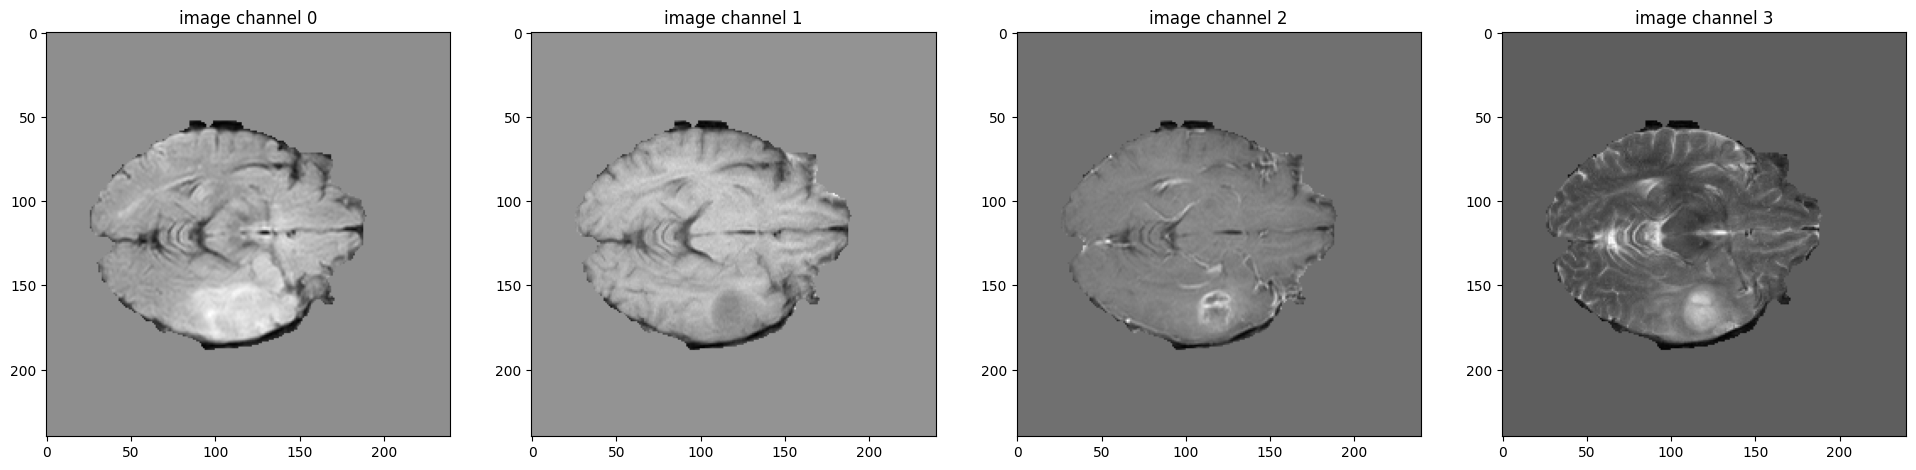

In [9]:
# pick one image from DecathlonDataset to visualize and check the 4 channel
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure('image', (24, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.title(f'image channel {i}')
    plt.imshow(val_data_example['image'][i, :, :, 60].detach().cpu(), cmap='gray')
plt.show()

label shape: torch.Size([3, 240, 240, 155])


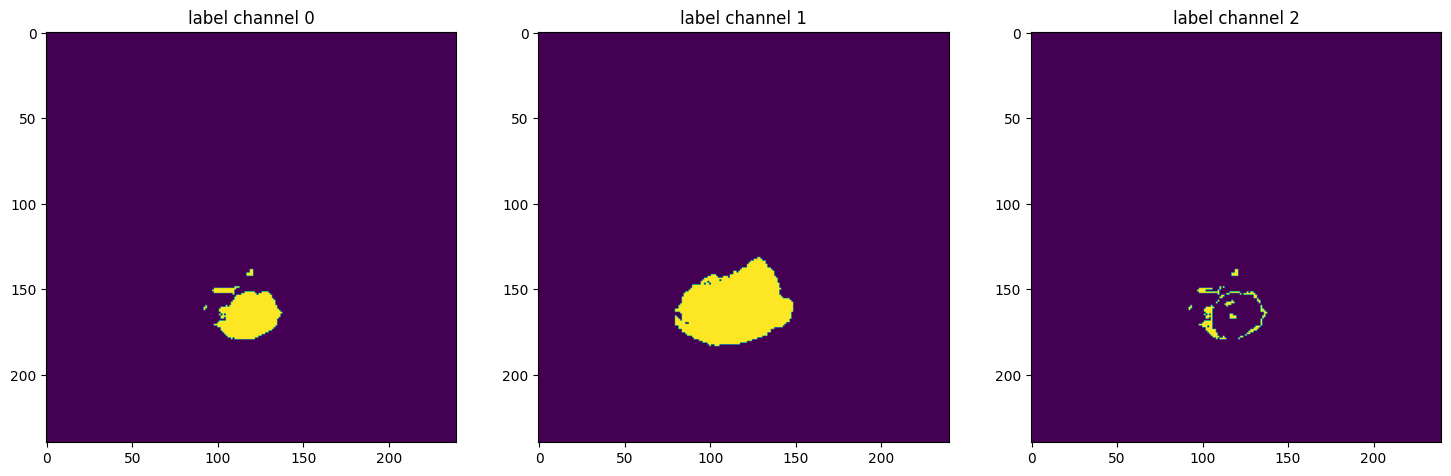

In [10]:
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure('label', (18, 6))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(f'label channel {i}')
    plt.imshow(val_data_example['label'][i, :, :, 60].detach().cpu())
plt.show()

## 2. モデル構築

In [11]:
# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0')
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16, 
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

In [12]:
max_epochs = 300

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [13]:
dice_metric = DiceMetric(include_background=True, reduction='mean')
dice_metric_batch = DiceMetric(include_background=True, reduction='mean_batch')

post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(threshold=0.5)
])

In [14]:
VAL_AMP = True

# define inference method
def inference(input):
    
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )
    
    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

In [15]:
# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()

# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

## 3. 学習
### 3.1 モデル学習

In [16]:
val_interval = 1

model_dir = './models/brain_tumor'

In [17]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print('-' * 10)
    print(f'epoch {epoch+1}/{max_epochs}')
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data['image'].to(device),
            batch_data['label'].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f'{step}/{len(train_ds) // train_loader.batch_size}'
            f', train_loss: {loss.item():.4f}'
            f', step time: {(time.time() - step_start):.4f}'
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f'epoch {epoch + 1} average loss: {epoch_loss:.4f}')
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data['image'].to(device),
                    val_data['label'].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)
                
            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(model_dir, 'best_metric_model.pth'),
                )
                print('saved new best metric model.')
            print(
                f'current epoch: {epoch + 1} current mean dice: {metric:.4f}'
                f' tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}'
                f'\nbst mean dice: {best_metric:.4f}'
                f' at epoch: {best_metric_epoch}'
            )
    print(f'time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}')
total_time = time.time() - total_start

----------
epoch 1/300
1/388, train_loss: 0.9770, step time: 10.2034
2/388, train_loss: 0.9647, step time: 0.4911
3/388, train_loss: 0.9768, step time: 0.4607
4/388, train_loss: 0.9547, step time: 0.4612
5/388, train_loss: 0.9178, step time: 0.4606
6/388, train_loss: 0.8799, step time: 0.4588
7/388, train_loss: 0.8952, step time: 0.4604
8/388, train_loss: 0.9346, step time: 0.4594
9/388, train_loss: 0.9265, step time: 0.4608
10/388, train_loss: 0.9329, step time: 0.4597
11/388, train_loss: 0.9869, step time: 0.4616
12/388, train_loss: 0.9087, step time: 0.4623
13/388, train_loss: 0.9533, step time: 0.4611
14/388, train_loss: 0.9071, step time: 0.4670
15/388, train_loss: 0.9057, step time: 0.4611
16/388, train_loss: 0.8822, step time: 0.4605
17/388, train_loss: 0.9074, step time: 0.4648
18/388, train_loss: 0.8517, step time: 0.4629
19/388, train_loss: 0.8530, step time: 0.4601
20/388, train_loss: 0.8907, step time: 0.4613
21/388, train_loss: 0.8508, step time: 0.4632
22/388, train_loss:

178/388, train_loss: 0.9549, step time: 0.4648
179/388, train_loss: 0.8829, step time: 0.4738
180/388, train_loss: 0.9046, step time: 0.4622
181/388, train_loss: 0.9098, step time: 0.4636
182/388, train_loss: 0.9345, step time: 0.4664
183/388, train_loss: 0.9901, step time: 0.4640
184/388, train_loss: 0.8721, step time: 0.4618
185/388, train_loss: 0.7970, step time: 0.4631
186/388, train_loss: 0.9826, step time: 0.4633
187/388, train_loss: 0.8210, step time: 0.4642
188/388, train_loss: 0.8542, step time: 0.4721
189/388, train_loss: 0.8987, step time: 0.4625
190/388, train_loss: 0.8834, step time: 0.4687
191/388, train_loss: 0.9531, step time: 0.4651
192/388, train_loss: 0.9890, step time: 0.4646
193/388, train_loss: 0.7760, step time: 0.4638
194/388, train_loss: 0.9277, step time: 0.4638
195/388, train_loss: 0.9692, step time: 0.4631
196/388, train_loss: 0.7876, step time: 0.4623
197/388, train_loss: 0.8545, step time: 0.4644
198/388, train_loss: 0.8927, step time: 0.4631
199/388, trai

353/388, train_loss: 0.9070, step time: 0.4620
354/388, train_loss: 0.8220, step time: 0.4638
355/388, train_loss: 0.9229, step time: 0.4639
356/388, train_loss: 0.9401, step time: 0.4649
357/388, train_loss: 0.8908, step time: 0.4746
358/388, train_loss: 0.9164, step time: 0.4637
359/388, train_loss: 0.8519, step time: 0.4663
360/388, train_loss: 0.9419, step time: 0.4630
361/388, train_loss: 0.9302, step time: 0.4639
362/388, train_loss: 0.9786, step time: 0.4632
363/388, train_loss: 0.7507, step time: 0.4641
364/388, train_loss: 0.9265, step time: 0.4648
365/388, train_loss: 0.8255, step time: 0.4633
366/388, train_loss: 0.9010, step time: 0.4647
367/388, train_loss: 0.8558, step time: 0.4642
368/388, train_loss: 0.7805, step time: 0.4622
369/388, train_loss: 0.8581, step time: 0.4655
370/388, train_loss: 0.8059, step time: 0.4647
371/388, train_loss: 0.9148, step time: 0.4637
372/388, train_loss: 0.8710, step time: 0.4606
373/388, train_loss: 0.7677, step time: 0.4670
374/388, trai

137/388, train_loss: 0.8702, step time: 0.4643
138/388, train_loss: 0.8342, step time: 0.4682
139/388, train_loss: 0.7726, step time: 0.4674
140/388, train_loss: 0.9746, step time: 0.4655
141/388, train_loss: 0.7881, step time: 0.4648
142/388, train_loss: 0.7350, step time: 0.4637
143/388, train_loss: 0.8490, step time: 0.4650
144/388, train_loss: 0.8959, step time: 0.4648
145/388, train_loss: 0.8135, step time: 0.4656
146/388, train_loss: 0.8954, step time: 0.4674
147/388, train_loss: 0.8157, step time: 0.4658
148/388, train_loss: 0.7779, step time: 0.4668
149/388, train_loss: 0.9302, step time: 0.4620
150/388, train_loss: 0.9057, step time: 0.4633
151/388, train_loss: 0.8239, step time: 0.4647
152/388, train_loss: 0.9461, step time: 0.4657
153/388, train_loss: 0.7430, step time: 0.4714
154/388, train_loss: 0.7179, step time: 0.4667
155/388, train_loss: 0.8646, step time: 0.4628
156/388, train_loss: 0.9652, step time: 0.4663
157/388, train_loss: 0.8424, step time: 0.4642
158/388, trai

312/388, train_loss: 0.6694, step time: 0.4651
313/388, train_loss: 0.7695, step time: 0.4639
314/388, train_loss: 0.7555, step time: 0.4650
315/388, train_loss: 0.7656, step time: 0.4646
316/388, train_loss: 0.7758, step time: 0.4652
317/388, train_loss: 0.7306, step time: 0.4631
318/388, train_loss: 0.6933, step time: 0.4649
319/388, train_loss: 0.8467, step time: 0.4626
320/388, train_loss: 0.7733, step time: 0.4647
321/388, train_loss: 0.7060, step time: 0.4632
322/388, train_loss: 0.7982, step time: 0.4646
323/388, train_loss: 0.9369, step time: 0.4669
324/388, train_loss: 0.8250, step time: 0.4660
325/388, train_loss: 0.9421, step time: 0.4689
326/388, train_loss: 0.8389, step time: 0.4635
327/388, train_loss: 0.7971, step time: 0.4644
328/388, train_loss: 0.7479, step time: 0.4661
329/388, train_loss: 0.9498, step time: 0.4646
330/388, train_loss: 0.8070, step time: 0.4664
331/388, train_loss: 0.8660, step time: 0.4620
332/388, train_loss: 0.7644, step time: 0.4787
333/388, trai

96/388, train_loss: 0.8397, step time: 0.4634
97/388, train_loss: 0.7287, step time: 0.4642
98/388, train_loss: 0.5901, step time: 0.4651
99/388, train_loss: 0.6834, step time: 0.4738
100/388, train_loss: 0.8495, step time: 0.4616
101/388, train_loss: 0.7725, step time: 0.4649
102/388, train_loss: 0.8374, step time: 0.4669
103/388, train_loss: 0.7698, step time: 0.4640
104/388, train_loss: 0.8532, step time: 0.4652
105/388, train_loss: 0.9452, step time: 0.4623
106/388, train_loss: 0.7790, step time: 0.4625
107/388, train_loss: 0.7813, step time: 0.4646
108/388, train_loss: 0.6842, step time: 0.4646
109/388, train_loss: 0.6973, step time: 0.4650
110/388, train_loss: 0.7687, step time: 0.4671
111/388, train_loss: 0.7932, step time: 0.4636
112/388, train_loss: 0.7448, step time: 0.4659
113/388, train_loss: 0.7045, step time: 0.4622
114/388, train_loss: 0.7926, step time: 0.4726
115/388, train_loss: 0.9744, step time: 0.4636
116/388, train_loss: 0.7052, step time: 0.4641
117/388, train_lo

271/388, train_loss: 0.6215, step time: 0.4647
272/388, train_loss: 0.8826, step time: 0.4648
273/388, train_loss: 0.7908, step time: 0.4626
274/388, train_loss: 0.7777, step time: 0.4638
275/388, train_loss: 0.6699, step time: 0.4649
276/388, train_loss: 0.8944, step time: 0.4617
277/388, train_loss: 0.7984, step time: 0.4653
278/388, train_loss: 0.6871, step time: 0.4609
279/388, train_loss: 0.7268, step time: 0.4653
280/388, train_loss: 0.7492, step time: 0.4617
281/388, train_loss: 0.8014, step time: 0.4662
282/388, train_loss: 0.8085, step time: 0.4645
283/388, train_loss: 0.7251, step time: 0.4659
284/388, train_loss: 0.8007, step time: 0.4632
285/388, train_loss: 0.6393, step time: 0.4636
286/388, train_loss: 0.7238, step time: 0.4643
287/388, train_loss: 0.7805, step time: 0.4656
288/388, train_loss: 0.6264, step time: 0.4649
289/388, train_loss: 0.9404, step time: 0.4649
290/388, train_loss: 0.6646, step time: 0.4650
291/388, train_loss: 0.7035, step time: 0.4765
292/388, trai

54/388, train_loss: 0.8167, step time: 0.4664
55/388, train_loss: 0.6556, step time: 0.4637
56/388, train_loss: 0.8357, step time: 0.4691
57/388, train_loss: 0.7131, step time: 0.4636
58/388, train_loss: 0.4879, step time: 0.4663
59/388, train_loss: 0.6511, step time: 0.4602
60/388, train_loss: 0.6342, step time: 0.4637
61/388, train_loss: 0.6300, step time: 0.4653
62/388, train_loss: 0.6245, step time: 0.4649
63/388, train_loss: 0.6296, step time: 0.4715
64/388, train_loss: 0.6675, step time: 0.4801
65/388, train_loss: 0.7479, step time: 0.4611
66/388, train_loss: 0.5239, step time: 0.4651
67/388, train_loss: 0.7883, step time: 0.4631
68/388, train_loss: 0.6542, step time: 0.4684
69/388, train_loss: 0.6806, step time: 0.4628
70/388, train_loss: 0.9157, step time: 0.4672
71/388, train_loss: 0.7400, step time: 0.4639
72/388, train_loss: 0.5811, step time: 0.4684
73/388, train_loss: 0.7008, step time: 0.4653
74/388, train_loss: 0.7457, step time: 0.4651
75/388, train_loss: 0.6232, step t

230/388, train_loss: 0.5491, step time: 0.4655
231/388, train_loss: 0.5509, step time: 0.4659
232/388, train_loss: 0.4807, step time: 0.4657
233/388, train_loss: 0.6652, step time: 0.4648
234/388, train_loss: 0.4964, step time: 0.4639
235/388, train_loss: 0.6263, step time: 0.4633
236/388, train_loss: 0.6921, step time: 0.4655
237/388, train_loss: 0.5411, step time: 0.4651
238/388, train_loss: 0.5911, step time: 0.4656
239/388, train_loss: 0.5685, step time: 0.4645
240/388, train_loss: 0.7844, step time: 0.4642
241/388, train_loss: 0.8015, step time: 0.4663
242/388, train_loss: 0.6005, step time: 0.4641
243/388, train_loss: 0.6182, step time: 0.4639
244/388, train_loss: 0.7487, step time: 0.4650
245/388, train_loss: 0.6460, step time: 0.4624
246/388, train_loss: 0.6801, step time: 0.4654
247/388, train_loss: 0.5089, step time: 0.4625
248/388, train_loss: 0.5101, step time: 0.4680
249/388, train_loss: 0.5968, step time: 0.4670
250/388, train_loss: 0.6819, step time: 0.4637
251/388, trai

12/388, train_loss: 0.5918, step time: 0.4633
13/388, train_loss: 0.6159, step time: 0.4628
14/388, train_loss: 0.6882, step time: 0.4613
15/388, train_loss: 0.5806, step time: 0.4623
16/388, train_loss: 0.5881, step time: 0.4620
17/388, train_loss: 0.5777, step time: 0.4634
18/388, train_loss: 0.5274, step time: 0.4647
19/388, train_loss: 0.6186, step time: 0.4599
20/388, train_loss: 0.6004, step time: 0.4624
21/388, train_loss: 0.7158, step time: 0.4590
22/388, train_loss: 0.6160, step time: 0.4645
23/388, train_loss: 0.6351, step time: 0.4616
24/388, train_loss: 0.6825, step time: 0.4630
25/388, train_loss: 0.4485, step time: 0.4617
26/388, train_loss: 0.6960, step time: 0.4645
27/388, train_loss: 0.7729, step time: 0.4613
28/388, train_loss: 0.4308, step time: 0.4666
29/388, train_loss: 0.6278, step time: 0.4621
30/388, train_loss: 0.6989, step time: 0.4658
31/388, train_loss: 0.4516, step time: 0.4605
32/388, train_loss: 0.6446, step time: 0.4625
33/388, train_loss: 0.5015, step t

189/388, train_loss: 0.6971, step time: 0.4646
190/388, train_loss: 0.6621, step time: 0.4653
191/388, train_loss: 0.5810, step time: 0.4643
192/388, train_loss: 0.6767, step time: 0.4645
193/388, train_loss: 0.6438, step time: 0.4647
194/388, train_loss: 0.7190, step time: 0.4648
195/388, train_loss: 0.3505, step time: 0.4650
196/388, train_loss: 0.8057, step time: 0.4666
197/388, train_loss: 0.5747, step time: 0.4644
198/388, train_loss: 0.4900, step time: 0.4629
199/388, train_loss: 0.3830, step time: 0.4668
200/388, train_loss: 0.5627, step time: 0.4653
201/388, train_loss: 0.3561, step time: 0.4637
202/388, train_loss: 0.7594, step time: 0.4635
203/388, train_loss: 0.5331, step time: 0.4627
204/388, train_loss: 0.5850, step time: 0.4651
205/388, train_loss: 0.3710, step time: 0.4618
206/388, train_loss: 0.4835, step time: 0.4659
207/388, train_loss: 0.5831, step time: 0.4645
208/388, train_loss: 0.2927, step time: 0.4661
209/388, train_loss: 0.6342, step time: 0.4616
210/388, trai

364/388, train_loss: 0.5812, step time: 0.4627
365/388, train_loss: 0.4552, step time: 0.4659
366/388, train_loss: 0.5607, step time: 0.4635
367/388, train_loss: 0.4572, step time: 0.4641
368/388, train_loss: 0.4763, step time: 0.4621
369/388, train_loss: 0.6430, step time: 0.4665
370/388, train_loss: 0.6793, step time: 0.4627
371/388, train_loss: 0.5812, step time: 0.4659
372/388, train_loss: 0.5983, step time: 0.4734
373/388, train_loss: 0.4305, step time: 0.4635
374/388, train_loss: 0.5190, step time: 0.4636
375/388, train_loss: 0.4960, step time: 0.4626
376/388, train_loss: 0.5889, step time: 0.4655
377/388, train_loss: 0.6705, step time: 0.4642
378/388, train_loss: 0.6506, step time: 0.4608
379/388, train_loss: 0.5028, step time: 0.4706
380/388, train_loss: 0.3945, step time: 0.4636
381/388, train_loss: 0.5011, step time: 0.4628
382/388, train_loss: 0.5452, step time: 0.4648
383/388, train_loss: 0.6607, step time: 0.4650
384/388, train_loss: 0.5325, step time: 0.4641
385/388, trai

148/388, train_loss: 0.3524, step time: 0.4647
149/388, train_loss: 0.3674, step time: 0.4642
150/388, train_loss: 0.8352, step time: 0.4642
151/388, train_loss: 0.6546, step time: 0.4621
152/388, train_loss: 0.3673, step time: 0.4765
153/388, train_loss: 0.4529, step time: 0.4674
154/388, train_loss: 0.3981, step time: 0.4728
155/388, train_loss: 0.5621, step time: 0.4657
156/388, train_loss: 0.4329, step time: 0.4654
157/388, train_loss: 0.5428, step time: 0.4627
158/388, train_loss: 0.6411, step time: 0.4666
159/388, train_loss: 0.5534, step time: 0.4631
160/388, train_loss: 0.3873, step time: 0.4665
161/388, train_loss: 0.2281, step time: 0.4631
162/388, train_loss: 0.6272, step time: 0.4745
163/388, train_loss: 0.6543, step time: 0.4642
164/388, train_loss: 0.6491, step time: 0.4676
165/388, train_loss: 0.4837, step time: 0.4628
166/388, train_loss: 0.3512, step time: 0.4661
167/388, train_loss: 0.3933, step time: 0.4652
168/388, train_loss: 0.4874, step time: 0.4689
169/388, trai

323/388, train_loss: 0.5924, step time: 0.4643
324/388, train_loss: 0.5331, step time: 0.4659
325/388, train_loss: 0.5590, step time: 0.4654
326/388, train_loss: 0.3372, step time: 0.4643
327/388, train_loss: 0.7150, step time: 0.4645
328/388, train_loss: 0.2714, step time: 0.4659
329/388, train_loss: 0.3746, step time: 0.4628
330/388, train_loss: 0.5015, step time: 0.4655
331/388, train_loss: 0.4322, step time: 0.4640
332/388, train_loss: 0.2821, step time: 0.4664
333/388, train_loss: 0.3258, step time: 0.4618
334/388, train_loss: 0.7217, step time: 0.4678
335/388, train_loss: 0.2830, step time: 0.4631
336/388, train_loss: 0.3815, step time: 0.4640
337/388, train_loss: 0.6179, step time: 0.4641
338/388, train_loss: 0.2417, step time: 0.4669
339/388, train_loss: 0.5076, step time: 0.4629
340/388, train_loss: 0.7051, step time: 0.4638
341/388, train_loss: 0.4940, step time: 0.4639
342/388, train_loss: 0.3287, step time: 0.4648
343/388, train_loss: 0.5227, step time: 0.4663
344/388, trai

107/388, train_loss: 0.1906, step time: 0.4648
108/388, train_loss: 0.5745, step time: 0.4658
109/388, train_loss: 0.3722, step time: 0.4656
110/388, train_loss: 0.3297, step time: 0.4646
111/388, train_loss: 0.5008, step time: 0.4662
112/388, train_loss: 0.4684, step time: 0.4633
113/388, train_loss: 0.2535, step time: 0.4663
114/388, train_loss: 0.4977, step time: 0.4640
115/388, train_loss: 0.6222, step time: 0.4628
116/388, train_loss: 0.2859, step time: 0.4644
117/388, train_loss: 0.6423, step time: 0.4615
118/388, train_loss: 0.3226, step time: 0.4670
119/388, train_loss: 0.2593, step time: 0.4645
120/388, train_loss: 0.3542, step time: 0.4656
121/388, train_loss: 0.5648, step time: 0.4645
122/388, train_loss: 0.3762, step time: 0.4646
123/388, train_loss: 0.3322, step time: 0.4647
124/388, train_loss: 0.4299, step time: 0.4664
125/388, train_loss: 0.3748, step time: 0.4623
126/388, train_loss: 0.9277, step time: 0.4667
127/388, train_loss: 0.6781, step time: 0.4636
128/388, trai

282/388, train_loss: 0.3585, step time: 0.4655
283/388, train_loss: 0.4011, step time: 0.4633
284/388, train_loss: 0.3072, step time: 0.4667
285/388, train_loss: 0.4265, step time: 0.4613
286/388, train_loss: 0.5581, step time: 0.4658
287/388, train_loss: 0.3002, step time: 0.4612
288/388, train_loss: 0.2710, step time: 0.4643
289/388, train_loss: 0.4197, step time: 0.4647
290/388, train_loss: 0.5066, step time: 0.4656
291/388, train_loss: 0.6360, step time: 0.4626
292/388, train_loss: 0.3199, step time: 0.4657
293/388, train_loss: 0.3169, step time: 0.4648
294/388, train_loss: 0.2122, step time: 0.4643
295/388, train_loss: 0.4607, step time: 0.4656
296/388, train_loss: 0.6236, step time: 0.4660
297/388, train_loss: 0.3007, step time: 0.4644
298/388, train_loss: 0.2949, step time: 0.4636
299/388, train_loss: 0.3322, step time: 0.4681
300/388, train_loss: 0.2376, step time: 0.4642
301/388, train_loss: 0.2236, step time: 0.4682
302/388, train_loss: 0.3343, step time: 0.4628
303/388, trai

65/388, train_loss: 0.2054, step time: 0.4623
66/388, train_loss: 0.3604, step time: 0.4672
67/388, train_loss: 0.1742, step time: 0.4629
68/388, train_loss: 0.5169, step time: 0.4661
69/388, train_loss: 0.2253, step time: 0.4638
70/388, train_loss: 0.4223, step time: 0.4656
71/388, train_loss: 0.3961, step time: 0.4632
72/388, train_loss: 0.3362, step time: 0.4657
73/388, train_loss: 0.1976, step time: 0.4632
74/388, train_loss: 0.3518, step time: 0.4619
75/388, train_loss: 0.3230, step time: 0.4600
76/388, train_loss: 0.8137, step time: 0.4659
77/388, train_loss: 0.3414, step time: 0.4606
78/388, train_loss: 0.5428, step time: 0.4726
79/388, train_loss: 0.2014, step time: 0.4643
80/388, train_loss: 0.3592, step time: 0.4666
81/388, train_loss: 0.2690, step time: 0.4612
82/388, train_loss: 0.4544, step time: 0.4668
83/388, train_loss: 0.1826, step time: 0.4629
84/388, train_loss: 0.3358, step time: 0.4666
85/388, train_loss: 0.5979, step time: 0.4651
86/388, train_loss: 0.2498, step t

241/388, train_loss: 0.3641, step time: 0.4629
242/388, train_loss: 0.3215, step time: 0.4652
243/388, train_loss: 0.2437, step time: 0.4633
244/388, train_loss: 0.2721, step time: 0.4652
245/388, train_loss: 0.1914, step time: 0.4634
246/388, train_loss: 0.3479, step time: 0.4668
247/388, train_loss: 0.4677, step time: 0.4640
248/388, train_loss: 0.1819, step time: 0.4654
249/388, train_loss: 0.4208, step time: 0.4629
250/388, train_loss: 0.1525, step time: 0.4664
251/388, train_loss: 0.1346, step time: 0.4651
252/388, train_loss: 0.8419, step time: 0.4639
253/388, train_loss: 0.2224, step time: 0.4642
254/388, train_loss: 0.3424, step time: 0.4649
255/388, train_loss: 0.5070, step time: 0.4641
256/388, train_loss: 0.2949, step time: 0.4634
257/388, train_loss: 0.4050, step time: 0.4631
258/388, train_loss: 0.3132, step time: 0.4668
259/388, train_loss: 0.5124, step time: 0.4637
260/388, train_loss: 0.3513, step time: 0.4620
261/388, train_loss: 0.2058, step time: 0.4644
262/388, trai

24/388, train_loss: 0.2611, step time: 0.4622
25/388, train_loss: 0.1081, step time: 0.4652
26/388, train_loss: 0.2865, step time: 0.4635
27/388, train_loss: 0.4488, step time: 0.4651
28/388, train_loss: 0.1677, step time: 0.4636
29/388, train_loss: 0.2956, step time: 0.4710
30/388, train_loss: 0.7649, step time: 0.4658
31/388, train_loss: 0.2489, step time: 0.4635
32/388, train_loss: 0.2120, step time: 0.4655
33/388, train_loss: 0.4325, step time: 0.4631
34/388, train_loss: 0.6710, step time: 0.4619
35/388, train_loss: 0.4514, step time: 0.4628
36/388, train_loss: 0.4408, step time: 0.4657
37/388, train_loss: 0.2429, step time: 0.4630
38/388, train_loss: 0.3849, step time: 0.4645
39/388, train_loss: 0.2207, step time: 0.4624
40/388, train_loss: 0.3943, step time: 0.4625
41/388, train_loss: 0.2147, step time: 0.4648
42/388, train_loss: 0.3354, step time: 0.4642
43/388, train_loss: 0.1334, step time: 0.4632
44/388, train_loss: 0.2737, step time: 0.4639
45/388, train_loss: 0.2513, step t

200/388, train_loss: 0.6881, step time: 0.4673
201/388, train_loss: 0.1604, step time: 0.4638
202/388, train_loss: 0.1563, step time: 0.4644
203/388, train_loss: 0.4405, step time: 0.4649
204/388, train_loss: 0.2894, step time: 0.4814
205/388, train_loss: 0.2321, step time: 0.4666
206/388, train_loss: 0.3161, step time: 0.4655
207/388, train_loss: 0.2978, step time: 0.4656
208/388, train_loss: 0.3928, step time: 0.4662
209/388, train_loss: 0.1831, step time: 0.4621
210/388, train_loss: 0.1767, step time: 0.4667
211/388, train_loss: 0.4529, step time: 0.4653
212/388, train_loss: 0.2339, step time: 0.4698
213/388, train_loss: 0.1885, step time: 0.4657
214/388, train_loss: 0.1746, step time: 0.4659
215/388, train_loss: 0.3181, step time: 0.4646
216/388, train_loss: 0.4170, step time: 0.4633
217/388, train_loss: 0.4033, step time: 0.4666
218/388, train_loss: 0.3271, step time: 0.4668
219/388, train_loss: 0.3098, step time: 0.4641
220/388, train_loss: 0.7085, step time: 0.4640
221/388, trai

375/388, train_loss: 0.6677, step time: 0.4642
376/388, train_loss: 0.2093, step time: 0.4657
377/388, train_loss: 0.5468, step time: 0.4631
378/388, train_loss: 0.4392, step time: 0.4804
379/388, train_loss: 0.2109, step time: 0.4646
380/388, train_loss: 0.1507, step time: 0.4662
381/388, train_loss: 0.3279, step time: 0.4638
382/388, train_loss: 0.1993, step time: 0.4653
383/388, train_loss: 0.5005, step time: 0.4666
384/388, train_loss: 0.4493, step time: 0.4642
385/388, train_loss: 0.4859, step time: 0.4659
386/388, train_loss: 0.1929, step time: 0.4679
387/388, train_loss: 0.7496, step time: 0.4631
388/388, train_loss: 0.4009, step time: 0.4634
epoch 9 average loss: 0.3258
current epoch: 9 current mean dice: 0.6761 tc: 0.7367 wt: 0.8651 et: 0.4265
bst mean dice: 0.6780 at epoch: 8
time consuming of epoch 9 is: 521.2989
----------
epoch 10/300
1/388, train_loss: 0.1891, step time: 0.4670
2/388, train_loss: 0.3772, step time: 0.4644
3/388, train_loss: 0.2793, step time: 0.4628
4/388

160/388, train_loss: 0.2524, step time: 0.4624
161/388, train_loss: 0.2735, step time: 0.4620
162/388, train_loss: 0.2046, step time: 0.4655
163/388, train_loss: 0.1391, step time: 0.4642
164/388, train_loss: 0.2366, step time: 0.4647
165/388, train_loss: 0.4275, step time: 0.4623
166/388, train_loss: 0.1013, step time: 0.4660
167/388, train_loss: 0.3083, step time: 0.4637
168/388, train_loss: 0.1253, step time: 0.4675
169/388, train_loss: 0.2594, step time: 0.4650
170/388, train_loss: 0.3707, step time: 0.4752
171/388, train_loss: 0.4815, step time: 0.4632
172/388, train_loss: 0.3416, step time: 0.4641
173/388, train_loss: 0.6387, step time: 0.4650
174/388, train_loss: 0.3858, step time: 0.4655
175/388, train_loss: 0.3705, step time: 0.4631
176/388, train_loss: 0.3845, step time: 0.4653
177/388, train_loss: 0.2740, step time: 0.4655
178/388, train_loss: 0.3018, step time: 0.4651
179/388, train_loss: 0.3542, step time: 0.4622
180/388, train_loss: 0.2003, step time: 0.4702
181/388, trai

335/388, train_loss: 0.2432, step time: 0.4689
336/388, train_loss: 0.7506, step time: 0.4652
337/388, train_loss: 0.1953, step time: 0.4630
338/388, train_loss: 0.2053, step time: 0.4661
339/388, train_loss: 0.4426, step time: 0.4628
340/388, train_loss: 0.3109, step time: 0.4671
341/388, train_loss: 0.2657, step time: 0.4635
342/388, train_loss: 0.5616, step time: 0.4656
343/388, train_loss: 0.1046, step time: 0.4642
344/388, train_loss: 0.2649, step time: 0.4662
345/388, train_loss: 0.1044, step time: 0.4623
346/388, train_loss: 0.4668, step time: 0.4644
347/388, train_loss: 0.2705, step time: 0.4625
348/388, train_loss: 0.2252, step time: 0.4666
349/388, train_loss: 0.1060, step time: 0.4631
350/388, train_loss: 0.3547, step time: 0.4665
351/388, train_loss: 0.4977, step time: 0.4635
352/388, train_loss: 0.2260, step time: 0.4641
353/388, train_loss: 0.3893, step time: 0.4627
354/388, train_loss: 0.2474, step time: 0.4645
355/388, train_loss: 0.3596, step time: 0.4626
356/388, trai

119/388, train_loss: 0.2050, step time: 0.4641
120/388, train_loss: 0.5885, step time: 0.4646
121/388, train_loss: 0.3157, step time: 0.4629
122/388, train_loss: 0.3969, step time: 0.4644
123/388, train_loss: 0.1059, step time: 0.4644
124/388, train_loss: 0.1057, step time: 0.4643
125/388, train_loss: 0.2272, step time: 0.4632
126/388, train_loss: 0.4799, step time: 0.4665
127/388, train_loss: 0.6089, step time: 0.4648
128/388, train_loss: 0.4955, step time: 0.4664
129/388, train_loss: 0.2065, step time: 0.4643
130/388, train_loss: 0.2161, step time: 0.4637
131/388, train_loss: 0.2467, step time: 0.4666
132/388, train_loss: 0.3895, step time: 0.4676
133/388, train_loss: 0.3926, step time: 0.4632
134/388, train_loss: 0.3014, step time: 0.4657
135/388, train_loss: 0.2471, step time: 0.4651
136/388, train_loss: 0.7482, step time: 0.4657
137/388, train_loss: 0.2473, step time: 0.4636
138/388, train_loss: 0.2284, step time: 0.4688
139/388, train_loss: 0.1512, step time: 0.4675
140/388, trai

294/388, train_loss: 0.2495, step time: 0.4659
295/388, train_loss: 0.2789, step time: 0.4634
296/388, train_loss: 0.2460, step time: 0.4641
297/388, train_loss: 0.2502, step time: 0.4648
298/388, train_loss: 0.3042, step time: 0.4648
299/388, train_loss: 0.2059, step time: 0.4703
300/388, train_loss: 0.3018, step time: 0.4669
301/388, train_loss: 0.1328, step time: 0.4629
302/388, train_loss: 0.3764, step time: 0.4676
303/388, train_loss: 0.3678, step time: 0.4655
304/388, train_loss: 0.2771, step time: 0.4733
305/388, train_loss: 0.1690, step time: 0.4625
306/388, train_loss: 0.1942, step time: 0.4688
307/388, train_loss: 0.4783, step time: 0.4629
308/388, train_loss: 0.2342, step time: 0.4647
309/388, train_loss: 0.5652, step time: 0.4646
310/388, train_loss: 0.5101, step time: 0.4661
311/388, train_loss: 0.4155, step time: 0.4642
312/388, train_loss: 0.3880, step time: 0.4639
313/388, train_loss: 0.5398, step time: 0.4650
314/388, train_loss: 0.2304, step time: 0.4652
315/388, trai

78/388, train_loss: 0.2129, step time: 0.4651
79/388, train_loss: 0.2281, step time: 0.4613
80/388, train_loss: 0.3191, step time: 0.4639
81/388, train_loss: 0.1605, step time: 0.4624
82/388, train_loss: 0.1083, step time: 0.4646
83/388, train_loss: 0.3130, step time: 0.4642
84/388, train_loss: 0.2068, step time: 0.4654
85/388, train_loss: 0.0994, step time: 0.4666
86/388, train_loss: 0.0712, step time: 0.4642
87/388, train_loss: 0.0992, step time: 0.4642
88/388, train_loss: 0.1340, step time: 0.4636
89/388, train_loss: 0.3526, step time: 0.4630
90/388, train_loss: 0.3424, step time: 0.4663
91/388, train_loss: 0.2295, step time: 0.4637
92/388, train_loss: 0.2153, step time: 0.4626
93/388, train_loss: 0.3243, step time: 0.4666
94/388, train_loss: 0.1052, step time: 0.4657
95/388, train_loss: 0.1815, step time: 0.4627
96/388, train_loss: 0.2667, step time: 0.4614
97/388, train_loss: 0.1857, step time: 0.4623
98/388, train_loss: 0.2809, step time: 0.4673
99/388, train_loss: 0.3293, step t

253/388, train_loss: 0.0874, step time: 0.4661
254/388, train_loss: 0.2005, step time: 0.4642
255/388, train_loss: 0.1904, step time: 0.4650
256/388, train_loss: 0.2595, step time: 0.4628
257/388, train_loss: 0.3816, step time: 0.4673
258/388, train_loss: 0.3070, step time: 0.4665
259/388, train_loss: 0.2137, step time: 0.4665
260/388, train_loss: 0.2139, step time: 0.4628
261/388, train_loss: 0.1868, step time: 0.4660
262/388, train_loss: 0.2190, step time: 0.4686
263/388, train_loss: 0.1706, step time: 0.4676
264/388, train_loss: 0.3700, step time: 0.4633
265/388, train_loss: 0.1000, step time: 0.4661
266/388, train_loss: 0.1924, step time: 0.4627
267/388, train_loss: 0.1971, step time: 0.4659
268/388, train_loss: 0.2866, step time: 0.4625
269/388, train_loss: 0.2013, step time: 0.4671
270/388, train_loss: 0.0533, step time: 0.4648
271/388, train_loss: 0.2173, step time: 0.4693
272/388, train_loss: 0.1849, step time: 0.4649
273/388, train_loss: 0.3002, step time: 0.4671
274/388, trai

36/388, train_loss: 0.6042, step time: 0.4644
37/388, train_loss: 0.1866, step time: 0.4617
38/388, train_loss: 0.3918, step time: 0.4673
39/388, train_loss: 0.3104, step time: 0.4623
40/388, train_loss: 0.2396, step time: 0.4671
41/388, train_loss: 0.1415, step time: 0.4631
42/388, train_loss: 0.1068, step time: 0.4656
43/388, train_loss: 0.3221, step time: 0.4615
44/388, train_loss: 0.2178, step time: 0.4644
45/388, train_loss: 0.2496, step time: 0.4591
46/388, train_loss: 0.3588, step time: 0.4660
47/388, train_loss: 0.1115, step time: 0.4602
48/388, train_loss: 0.2475, step time: 0.4653
49/388, train_loss: 0.1748, step time: 0.4628
50/388, train_loss: 0.2818, step time: 0.4679
51/388, train_loss: 0.3732, step time: 0.4616
52/388, train_loss: 0.1970, step time: 0.4649
53/388, train_loss: 0.3076, step time: 0.4631
54/388, train_loss: 0.2235, step time: 0.4678
55/388, train_loss: 0.2768, step time: 0.4612
56/388, train_loss: 0.1253, step time: 0.4652
57/388, train_loss: 0.1914, step t

212/388, train_loss: 0.0870, step time: 0.4656
213/388, train_loss: 0.1133, step time: 0.4638
214/388, train_loss: 0.2538, step time: 0.4700
215/388, train_loss: 0.4903, step time: 0.4647
216/388, train_loss: 0.3650, step time: 0.4673
217/388, train_loss: 0.1909, step time: 0.4642
218/388, train_loss: 0.1393, step time: 0.4660
219/388, train_loss: 0.1866, step time: 0.4628
220/388, train_loss: 0.1412, step time: 0.4647
221/388, train_loss: 0.1289, step time: 0.4615
222/388, train_loss: 0.3281, step time: 0.4685
223/388, train_loss: 0.3000, step time: 0.4637
224/388, train_loss: 0.2182, step time: 0.4647
225/388, train_loss: 0.2551, step time: 0.4609
226/388, train_loss: 0.1042, step time: 0.4675
227/388, train_loss: 0.2944, step time: 0.4633
228/388, train_loss: 0.2456, step time: 0.4655
229/388, train_loss: 0.2681, step time: 0.4624
230/388, train_loss: 0.6239, step time: 0.4664
231/388, train_loss: 0.0958, step time: 0.4635
232/388, train_loss: 0.2173, step time: 0.4640
233/388, trai

387/388, train_loss: 0.3556, step time: 0.4649
388/388, train_loss: 0.1369, step time: 0.4611
epoch 13 average loss: 0.2499
current epoch: 13 current mean dice: 0.7022 tc: 0.7454 wt: 0.8678 et: 0.4934
bst mean dice: 0.7091 at epoch: 12
time consuming of epoch 13 is: 522.3236
----------
epoch 14/300
1/388, train_loss: 0.2412, step time: 0.4660
2/388, train_loss: 0.0750, step time: 0.4632
3/388, train_loss: 0.3422, step time: 0.4594
4/388, train_loss: 0.2982, step time: 0.4630
5/388, train_loss: 0.1301, step time: 0.4598
6/388, train_loss: 0.1309, step time: 0.4624
7/388, train_loss: 0.1183, step time: 0.4621
8/388, train_loss: 0.1303, step time: 0.4610
9/388, train_loss: 0.0449, step time: 0.4617
10/388, train_loss: 0.2748, step time: 0.4633
11/388, train_loss: 0.4775, step time: 0.4622
12/388, train_loss: 0.3489, step time: 0.4627
13/388, train_loss: 0.5396, step time: 0.4616
14/388, train_loss: 0.2160, step time: 0.4643
15/388, train_loss: 0.2323, step time: 0.4636
16/388, train_loss:

172/388, train_loss: 0.1196, step time: 0.4657
173/388, train_loss: 0.0985, step time: 0.4645
174/388, train_loss: 0.3258, step time: 0.4626
175/388, train_loss: 0.2919, step time: 0.4622
176/388, train_loss: 0.3555, step time: 0.4652
177/388, train_loss: 0.1633, step time: 0.4646
178/388, train_loss: 0.2949, step time: 0.4634
179/388, train_loss: 0.3261, step time: 0.4651
180/388, train_loss: 0.3598, step time: 0.4665
181/388, train_loss: 0.1249, step time: 0.4626
182/388, train_loss: 0.2400, step time: 0.4636
183/388, train_loss: 0.4783, step time: 0.4652
184/388, train_loss: 0.1058, step time: 0.4677
185/388, train_loss: 0.1987, step time: 0.4631
186/388, train_loss: 0.2930, step time: 0.4636
187/388, train_loss: 0.1459, step time: 0.4637
188/388, train_loss: 0.3117, step time: 0.4651
189/388, train_loss: 0.3514, step time: 0.4672
190/388, train_loss: 0.2151, step time: 0.4644
191/388, train_loss: 0.4252, step time: 0.4635
192/388, train_loss: 0.1776, step time: 0.4649
193/388, trai

347/388, train_loss: 0.1614, step time: 0.4624
348/388, train_loss: 0.2598, step time: 0.4639
349/388, train_loss: 0.1010, step time: 0.4638
350/388, train_loss: 0.2069, step time: 0.4642
351/388, train_loss: 0.0997, step time: 0.4623
352/388, train_loss: 0.3259, step time: 0.4661
353/388, train_loss: 0.2952, step time: 0.4706
354/388, train_loss: 0.6510, step time: 0.4656
355/388, train_loss: 0.3968, step time: 0.4622
356/388, train_loss: 0.2003, step time: 0.4673
357/388, train_loss: 0.1002, step time: 0.4685
358/388, train_loss: 0.1774, step time: 0.4661
359/388, train_loss: 0.3203, step time: 0.4630
360/388, train_loss: 0.2304, step time: 0.4650
361/388, train_loss: 0.1453, step time: 0.4641
362/388, train_loss: 0.1447, step time: 0.4660
363/388, train_loss: 0.3589, step time: 0.4624
364/388, train_loss: 0.1597, step time: 0.4669
365/388, train_loss: 0.0845, step time: 0.4622
366/388, train_loss: 0.1804, step time: 0.4707
367/388, train_loss: 0.2510, step time: 0.4652
368/388, trai

131/388, train_loss: 0.3181, step time: 0.4664
132/388, train_loss: 0.0817, step time: 0.4688
133/388, train_loss: 0.2372, step time: 0.4648
134/388, train_loss: 0.1507, step time: 0.4681
135/388, train_loss: 0.2272, step time: 0.4631
136/388, train_loss: 0.1662, step time: 0.4666
137/388, train_loss: 0.2461, step time: 0.4657
138/388, train_loss: 0.3090, step time: 0.4692
139/388, train_loss: 0.4038, step time: 0.4658
140/388, train_loss: 0.2141, step time: 0.4766
141/388, train_loss: 0.2160, step time: 0.4633
142/388, train_loss: 0.1091, step time: 0.4681
143/388, train_loss: 0.2197, step time: 0.4641
144/388, train_loss: 0.2188, step time: 0.4660
145/388, train_loss: 0.1035, step time: 0.4627
146/388, train_loss: 0.3469, step time: 0.4667
147/388, train_loss: 0.1399, step time: 0.4623
148/388, train_loss: 0.1578, step time: 0.4686
149/388, train_loss: 0.2628, step time: 0.4629
150/388, train_loss: 0.1907, step time: 0.4691
151/388, train_loss: 0.1444, step time: 0.4663
152/388, trai

306/388, train_loss: 0.1557, step time: 0.4649
307/388, train_loss: 0.0971, step time: 0.4649
308/388, train_loss: 0.5793, step time: 0.4678
309/388, train_loss: 0.2979, step time: 0.4667
310/388, train_loss: 0.2804, step time: 0.4645
311/388, train_loss: 0.2437, step time: 0.4631
312/388, train_loss: 0.2680, step time: 0.4666
313/388, train_loss: 0.1671, step time: 0.4628
314/388, train_loss: 0.5038, step time: 0.4651
315/388, train_loss: 0.3083, step time: 0.4686
316/388, train_loss: 0.1849, step time: 0.4660
317/388, train_loss: 0.1500, step time: 0.4638
318/388, train_loss: 0.1749, step time: 0.4652
319/388, train_loss: 0.3864, step time: 0.4644
320/388, train_loss: 0.3129, step time: 0.4658
321/388, train_loss: 0.5014, step time: 0.4651
322/388, train_loss: 0.1833, step time: 0.4668
323/388, train_loss: 0.1990, step time: 0.4636
324/388, train_loss: 0.1465, step time: 0.4643
325/388, train_loss: 0.1249, step time: 0.4631
326/388, train_loss: 0.3928, step time: 0.4633
327/388, trai

90/388, train_loss: 0.1733, step time: 0.4658
91/388, train_loss: 0.2692, step time: 0.4625
92/388, train_loss: 0.1694, step time: 0.4651
93/388, train_loss: 0.2019, step time: 0.4623
94/388, train_loss: 0.1715, step time: 0.4660
95/388, train_loss: 0.3700, step time: 0.4654
96/388, train_loss: 0.1704, step time: 0.4677
97/388, train_loss: 0.2347, step time: 0.4642
98/388, train_loss: 0.1021, step time: 0.4650
99/388, train_loss: 0.5255, step time: 0.4626
100/388, train_loss: 0.1532, step time: 0.4662
101/388, train_loss: 0.1752, step time: 0.4627
102/388, train_loss: 0.3125, step time: 0.4658
103/388, train_loss: 0.6936, step time: 0.4640
104/388, train_loss: 0.1571, step time: 0.4656
105/388, train_loss: 0.4237, step time: 0.4658
106/388, train_loss: 0.1347, step time: 0.4644
107/388, train_loss: 0.0578, step time: 0.4651
108/388, train_loss: 0.2019, step time: 0.4645
109/388, train_loss: 0.1565, step time: 0.4632
110/388, train_loss: 0.2194, step time: 0.4686
111/388, train_loss: 0.

265/388, train_loss: 0.1843, step time: 0.4639
266/388, train_loss: 0.1243, step time: 0.4664
267/388, train_loss: 0.2946, step time: 0.4649
268/388, train_loss: 0.2403, step time: 0.4646
269/388, train_loss: 0.3270, step time: 0.4606
270/388, train_loss: 0.1440, step time: 0.4642
271/388, train_loss: 0.1290, step time: 0.4756
272/388, train_loss: 0.1345, step time: 0.4656
273/388, train_loss: 0.2172, step time: 0.4645
274/388, train_loss: 0.3726, step time: 0.4669
275/388, train_loss: 0.2042, step time: 0.4660
276/388, train_loss: 0.2586, step time: 0.4634
277/388, train_loss: 0.2668, step time: 0.4642
278/388, train_loss: 0.5826, step time: 0.4656
279/388, train_loss: 0.1257, step time: 0.4708
280/388, train_loss: 0.1876, step time: 0.4649
281/388, train_loss: 0.1043, step time: 0.4630
282/388, train_loss: 0.2045, step time: 0.4644
283/388, train_loss: 0.1117, step time: 0.4624
284/388, train_loss: 0.2314, step time: 0.4673
285/388, train_loss: 0.1397, step time: 0.4637
286/388, trai

49/388, train_loss: 0.1858, step time: 0.4623
50/388, train_loss: 0.1663, step time: 0.4665
51/388, train_loss: 0.1122, step time: 0.4598
52/388, train_loss: 0.2025, step time: 0.4616
53/388, train_loss: 0.0926, step time: 0.4631
54/388, train_loss: 0.1261, step time: 0.4621
55/388, train_loss: 0.1178, step time: 0.4610
56/388, train_loss: 0.1822, step time: 0.4627
57/388, train_loss: 0.1859, step time: 0.4631
58/388, train_loss: 0.1520, step time: 0.4653
59/388, train_loss: 0.2674, step time: 0.4652
60/388, train_loss: 0.3312, step time: 0.4705
61/388, train_loss: 0.0467, step time: 0.4654
62/388, train_loss: 0.2255, step time: 0.4652
63/388, train_loss: 0.1950, step time: 0.4643
64/388, train_loss: 0.1558, step time: 0.4639
65/388, train_loss: 0.2964, step time: 0.4613
66/388, train_loss: 0.1799, step time: 0.4617
67/388, train_loss: 0.2240, step time: 0.4624
68/388, train_loss: 0.1956, step time: 0.4646
69/388, train_loss: 0.2334, step time: 0.4629
70/388, train_loss: 0.3144, step t

225/388, train_loss: 0.3532, step time: 0.4636
226/388, train_loss: 0.1556, step time: 0.4653
227/388, train_loss: 0.4304, step time: 0.4637
228/388, train_loss: 0.1262, step time: 0.4660
229/388, train_loss: 0.4076, step time: 0.4672
230/388, train_loss: 0.2150, step time: 0.4660
231/388, train_loss: 0.2740, step time: 0.4621
232/388, train_loss: 0.5238, step time: 0.4642
233/388, train_loss: 0.2747, step time: 0.4632
234/388, train_loss: 0.2383, step time: 0.4744
235/388, train_loss: 0.2333, step time: 0.4649
236/388, train_loss: 0.6952, step time: 0.4649
237/388, train_loss: 0.1195, step time: 0.4613
238/388, train_loss: 0.1545, step time: 0.4667
239/388, train_loss: 0.6676, step time: 0.4627
240/388, train_loss: 0.1986, step time: 0.4648
241/388, train_loss: 0.5608, step time: 0.4633
242/388, train_loss: 0.1935, step time: 0.4657
243/388, train_loss: 0.3023, step time: 0.4656
244/388, train_loss: 0.2478, step time: 0.4683
245/388, train_loss: 0.1335, step time: 0.4625
246/388, trai

7/388, train_loss: 0.1696, step time: 0.4630
8/388, train_loss: 0.1278, step time: 0.4615
9/388, train_loss: 0.1436, step time: 0.4607
10/388, train_loss: 0.2249, step time: 0.4606
11/388, train_loss: 0.3101, step time: 0.4592
12/388, train_loss: 0.1390, step time: 0.4776
13/388, train_loss: 0.1309, step time: 0.4638
14/388, train_loss: 0.1044, step time: 0.4615
15/388, train_loss: 0.1734, step time: 0.4644
16/388, train_loss: 0.2548, step time: 0.4627
17/388, train_loss: 0.1799, step time: 0.4618
18/388, train_loss: 0.1665, step time: 0.4637
19/388, train_loss: 0.1566, step time: 0.4635
20/388, train_loss: 0.1566, step time: 0.4612
21/388, train_loss: 0.0783, step time: 0.4627
22/388, train_loss: 0.2318, step time: 0.4641
23/388, train_loss: 0.2077, step time: 0.4620
24/388, train_loss: 0.4802, step time: 0.4654
25/388, train_loss: 0.1420, step time: 0.4630
26/388, train_loss: 0.3179, step time: 0.4613
27/388, train_loss: 0.3723, step time: 0.4635
28/388, train_loss: 0.2816, step time

184/388, train_loss: 0.1730, step time: 0.4665
185/388, train_loss: 0.0760, step time: 0.4618
186/388, train_loss: 0.2580, step time: 0.4644
187/388, train_loss: 0.1334, step time: 0.4647
188/388, train_loss: 0.1292, step time: 0.4795
189/388, train_loss: 0.1924, step time: 0.4643
190/388, train_loss: 0.1499, step time: 0.4630
191/388, train_loss: 0.2575, step time: 0.4629
192/388, train_loss: 0.3182, step time: 0.4645
193/388, train_loss: 0.2294, step time: 0.4653
194/388, train_loss: 0.1390, step time: 0.4676
195/388, train_loss: 0.2358, step time: 0.4661
196/388, train_loss: 0.1567, step time: 0.4671
197/388, train_loss: 0.3545, step time: 0.4645
198/388, train_loss: 0.3055, step time: 0.4671
199/388, train_loss: 0.0795, step time: 0.4652
200/388, train_loss: 0.1064, step time: 0.4671
201/388, train_loss: 0.2274, step time: 0.4625
202/388, train_loss: 0.1150, step time: 0.4660
203/388, train_loss: 0.1603, step time: 0.4646
204/388, train_loss: 0.2595, step time: 0.4676
205/388, trai

359/388, train_loss: 0.0909, step time: 0.4633
360/388, train_loss: 0.0649, step time: 0.4669
361/388, train_loss: 0.1417, step time: 0.4646
362/388, train_loss: 0.1545, step time: 0.4637
363/388, train_loss: 0.1069, step time: 0.4639
364/388, train_loss: 0.0635, step time: 0.4655
365/388, train_loss: 0.2938, step time: 0.4651
366/388, train_loss: 0.5767, step time: 0.4661
367/388, train_loss: 0.1802, step time: 0.4631
368/388, train_loss: 0.2326, step time: 0.4651
369/388, train_loss: 0.2813, step time: 0.4647
370/388, train_loss: 0.2098, step time: 0.4673
371/388, train_loss: 0.5720, step time: 0.4728
372/388, train_loss: 0.0905, step time: 0.4652
373/388, train_loss: 0.1831, step time: 0.4648
374/388, train_loss: 0.7506, step time: 0.4671
375/388, train_loss: 0.1938, step time: 0.4598
376/388, train_loss: 0.1338, step time: 0.4658
377/388, train_loss: 0.3355, step time: 0.4615
378/388, train_loss: 0.5237, step time: 0.4715
379/388, train_loss: 0.1268, step time: 0.4631
380/388, trai

144/388, train_loss: 0.1746, step time: 0.4637
145/388, train_loss: 0.0758, step time: 0.4645
146/388, train_loss: 0.3113, step time: 0.4668
147/388, train_loss: 0.1166, step time: 0.4677
148/388, train_loss: 0.0863, step time: 0.4672
149/388, train_loss: 0.0988, step time: 0.4634
150/388, train_loss: 0.1500, step time: 0.4659
151/388, train_loss: 0.1136, step time: 0.4663
152/388, train_loss: 0.2944, step time: 0.4652
153/388, train_loss: 0.2614, step time: 0.4664
154/388, train_loss: 0.2939, step time: 0.4671
155/388, train_loss: 0.2762, step time: 0.4658
156/388, train_loss: 0.2413, step time: 0.4686
157/388, train_loss: 0.0729, step time: 0.4641
158/388, train_loss: 0.2031, step time: 0.4658
159/388, train_loss: 0.0981, step time: 0.4650
160/388, train_loss: 0.1133, step time: 0.4657
161/388, train_loss: 0.2132, step time: 0.4622
162/388, train_loss: 0.3249, step time: 0.4676
163/388, train_loss: 0.2919, step time: 0.4648
164/388, train_loss: 0.5686, step time: 0.4676
165/388, trai

319/388, train_loss: 0.5781, step time: 0.4695
320/388, train_loss: 0.2349, step time: 0.4634
321/388, train_loss: 0.3261, step time: 0.4651
322/388, train_loss: 0.4504, step time: 0.4657
323/388, train_loss: 0.3514, step time: 0.4655
324/388, train_loss: 0.1539, step time: 0.4627
325/388, train_loss: 0.0343, step time: 0.4642
326/388, train_loss: 0.2580, step time: 0.4634
327/388, train_loss: 0.1269, step time: 0.4689
328/388, train_loss: 0.1277, step time: 0.4628
329/388, train_loss: 0.1988, step time: 0.4620
330/388, train_loss: 0.2342, step time: 0.4616
331/388, train_loss: 0.2667, step time: 0.4630
332/388, train_loss: 0.2555, step time: 0.4650
333/388, train_loss: 0.0819, step time: 0.4633
334/388, train_loss: 0.3276, step time: 0.4670
335/388, train_loss: 0.2260, step time: 0.4624
336/388, train_loss: 0.5239, step time: 0.4653
337/388, train_loss: 0.0879, step time: 0.4629
338/388, train_loss: 0.2879, step time: 0.4648
339/388, train_loss: 0.0703, step time: 0.4692
340/388, trai

103/388, train_loss: 0.1428, step time: 0.4618
104/388, train_loss: 0.1754, step time: 0.4638
105/388, train_loss: 0.2004, step time: 0.4619
106/388, train_loss: 0.5156, step time: 0.4641
107/388, train_loss: 0.4036, step time: 0.4607
108/388, train_loss: 0.1212, step time: 0.4657
109/388, train_loss: 0.4157, step time: 0.4623
110/388, train_loss: 0.1178, step time: 0.4660
111/388, train_loss: 0.2068, step time: 0.4605
112/388, train_loss: 0.1205, step time: 0.4631
113/388, train_loss: 0.1633, step time: 0.4638
114/388, train_loss: 0.2615, step time: 0.4658
115/388, train_loss: 0.4539, step time: 0.4638
116/388, train_loss: 0.0808, step time: 0.4670
117/388, train_loss: 0.2115, step time: 0.4644
118/388, train_loss: 0.1293, step time: 0.4642
119/388, train_loss: 0.1699, step time: 0.4639
120/388, train_loss: 0.0598, step time: 0.4659
121/388, train_loss: 0.1925, step time: 0.4643
122/388, train_loss: 0.3341, step time: 0.4782
123/388, train_loss: 0.2015, step time: 0.4643
124/388, trai

278/388, train_loss: 0.1859, step time: 0.4656
279/388, train_loss: 0.2249, step time: 0.4622
280/388, train_loss: 0.3022, step time: 0.4659
281/388, train_loss: 0.2480, step time: 0.4629
282/388, train_loss: 0.1335, step time: 0.4654
283/388, train_loss: 0.1234, step time: 0.4612
284/388, train_loss: 0.1257, step time: 0.4649
285/388, train_loss: 0.1524, step time: 0.4627
286/388, train_loss: 0.2323, step time: 0.4675
287/388, train_loss: 0.1632, step time: 0.4651
288/388, train_loss: 0.1175, step time: 0.4648
289/388, train_loss: 0.1347, step time: 0.4624
290/388, train_loss: 0.3637, step time: 0.4651
291/388, train_loss: 0.2410, step time: 0.4659
292/388, train_loss: 0.3891, step time: 0.4650
293/388, train_loss: 0.2110, step time: 0.4628
294/388, train_loss: 0.1189, step time: 0.4647
295/388, train_loss: 0.0823, step time: 0.4646
296/388, train_loss: 0.3319, step time: 0.4625
297/388, train_loss: 0.2715, step time: 0.4637
298/388, train_loss: 0.7320, step time: 0.4641
299/388, trai

61/388, train_loss: 0.2428, step time: 0.4604
62/388, train_loss: 0.1017, step time: 0.4639
63/388, train_loss: 0.1669, step time: 0.4602
64/388, train_loss: 0.1582, step time: 0.4644
65/388, train_loss: 0.2871, step time: 0.4646
66/388, train_loss: 0.6553, step time: 0.4677
67/388, train_loss: 0.0766, step time: 0.4617
68/388, train_loss: 0.2169, step time: 0.4663
69/388, train_loss: 0.2504, step time: 0.4645
70/388, train_loss: 0.1209, step time: 0.4658
71/388, train_loss: 0.1228, step time: 0.4620
72/388, train_loss: 0.4945, step time: 0.4642
73/388, train_loss: 0.4266, step time: 0.4632
74/388, train_loss: 0.2851, step time: 0.4643
75/388, train_loss: 0.2735, step time: 0.4649
76/388, train_loss: 0.5181, step time: 0.4658
77/388, train_loss: 0.1074, step time: 0.4666
78/388, train_loss: 0.6196, step time: 0.4647
79/388, train_loss: 0.0948, step time: 0.4629
80/388, train_loss: 0.2471, step time: 0.4664
81/388, train_loss: 0.0989, step time: 0.4645
82/388, train_loss: 0.2244, step t

237/388, train_loss: 0.3201, step time: 0.4656
238/388, train_loss: 0.0891, step time: 0.4670
239/388, train_loss: 0.0933, step time: 0.4651
240/388, train_loss: 0.2425, step time: 0.4619
241/388, train_loss: 0.3322, step time: 0.4639
242/388, train_loss: 0.1766, step time: 0.4609
243/388, train_loss: 0.1892, step time: 0.4648
244/388, train_loss: 0.2168, step time: 0.4654
245/388, train_loss: 0.2257, step time: 0.4656
246/388, train_loss: 0.1653, step time: 0.4644
247/388, train_loss: 0.1980, step time: 0.4654
248/388, train_loss: 0.2558, step time: 0.4615
249/388, train_loss: 0.1254, step time: 0.4657
250/388, train_loss: 0.1083, step time: 0.4634
251/388, train_loss: 0.0696, step time: 0.4654
252/388, train_loss: 0.4075, step time: 0.4649
253/388, train_loss: 0.1307, step time: 0.4658
254/388, train_loss: 0.4194, step time: 0.4645
255/388, train_loss: 0.4074, step time: 0.4666
256/388, train_loss: 0.2105, step time: 0.4628
257/388, train_loss: 0.0752, step time: 0.4650
258/388, trai

20/388, train_loss: 0.2100, step time: 0.4644
21/388, train_loss: 0.1154, step time: 0.4620
22/388, train_loss: 0.0761, step time: 0.4640
23/388, train_loss: 0.1948, step time: 0.4619
24/388, train_loss: 0.0648, step time: 0.4656
25/388, train_loss: 0.1959, step time: 0.4619
26/388, train_loss: 0.1168, step time: 0.4650
27/388, train_loss: 0.1533, step time: 0.4630
28/388, train_loss: 0.1630, step time: 0.4648
29/388, train_loss: 0.3849, step time: 0.4610
30/388, train_loss: 0.3281, step time: 0.4654
31/388, train_loss: 0.3511, step time: 0.4626
32/388, train_loss: 0.1936, step time: 0.4636
33/388, train_loss: 0.1807, step time: 0.4632
34/388, train_loss: 0.1618, step time: 0.4728
35/388, train_loss: 0.3164, step time: 0.4625
36/388, train_loss: 0.1250, step time: 0.4640
37/388, train_loss: 0.5555, step time: 0.4612
38/388, train_loss: 0.1671, step time: 0.4652
39/388, train_loss: 0.3475, step time: 0.4616
40/388, train_loss: 0.6544, step time: 0.4657
41/388, train_loss: 0.1716, step t

197/388, train_loss: 0.4313, step time: 0.4668
198/388, train_loss: 0.1194, step time: 0.4622
199/388, train_loss: 0.5498, step time: 0.4680
200/388, train_loss: 0.1353, step time: 0.4647
201/388, train_loss: 0.5036, step time: 0.4643
202/388, train_loss: 0.1982, step time: 0.4653
203/388, train_loss: 0.3573, step time: 0.4629
204/388, train_loss: 0.0779, step time: 0.4660
205/388, train_loss: 0.1011, step time: 0.4661
206/388, train_loss: 0.3114, step time: 0.4653
207/388, train_loss: 0.1929, step time: 0.4648
208/388, train_loss: 0.2801, step time: 0.4639
209/388, train_loss: 0.2288, step time: 0.4679
210/388, train_loss: 0.0892, step time: 0.4673
211/388, train_loss: 0.4539, step time: 0.4679
212/388, train_loss: 0.0965, step time: 0.4656
213/388, train_loss: 0.2514, step time: 0.4661
214/388, train_loss: 0.1990, step time: 0.4635
215/388, train_loss: 0.2533, step time: 0.4658
216/388, train_loss: 0.2472, step time: 0.4727
217/388, train_loss: 0.1959, step time: 0.4677
218/388, trai

372/388, train_loss: 0.0919, step time: 0.4669
373/388, train_loss: 0.1138, step time: 0.4654
374/388, train_loss: 0.0861, step time: 0.4648
375/388, train_loss: 0.4456, step time: 0.4659
376/388, train_loss: 0.3068, step time: 0.4658
377/388, train_loss: 0.2866, step time: 0.4638
378/388, train_loss: 0.2845, step time: 0.4674
379/388, train_loss: 0.3271, step time: 0.4627
380/388, train_loss: 0.1926, step time: 0.4646
381/388, train_loss: 0.1504, step time: 0.4616
382/388, train_loss: 0.3182, step time: 0.4664
383/388, train_loss: 0.1334, step time: 0.4629
384/388, train_loss: 0.1071, step time: 0.4649
385/388, train_loss: 0.3088, step time: 0.4644
386/388, train_loss: 0.2192, step time: 0.4683
387/388, train_loss: 0.2050, step time: 0.4653
388/388, train_loss: 0.1197, step time: 0.4613
epoch 22 average loss: 0.2226
current epoch: 22 current mean dice: 0.7350 tc: 0.7879 wt: 0.8747 et: 0.5426
bst mean dice: 0.7373 at epoch: 20
time consuming of epoch 22 is: 520.4739
----------
epoch 23

157/388, train_loss: 0.2557, step time: 0.4632
158/388, train_loss: 0.2999, step time: 0.4607
159/388, train_loss: 0.2655, step time: 0.4646
160/388, train_loss: 0.1244, step time: 0.4635
161/388, train_loss: 0.2881, step time: 0.4707
162/388, train_loss: 0.0718, step time: 0.4648
163/388, train_loss: 0.1871, step time: 0.4640
164/388, train_loss: 0.1219, step time: 0.4658
165/388, train_loss: 0.1078, step time: 0.4670
166/388, train_loss: 0.1820, step time: 0.4647
167/388, train_loss: 0.1178, step time: 0.4630
168/388, train_loss: 0.0778, step time: 0.4642
169/388, train_loss: 0.3534, step time: 0.4643
170/388, train_loss: 0.1119, step time: 0.4659
171/388, train_loss: 0.0833, step time: 0.4645
172/388, train_loss: 0.4901, step time: 0.4689
173/388, train_loss: 0.5809, step time: 0.4663
174/388, train_loss: 0.1921, step time: 0.4621
175/388, train_loss: 0.1593, step time: 0.4653
176/388, train_loss: 0.3880, step time: 0.4648
177/388, train_loss: 0.2232, step time: 0.4670
178/388, trai

332/388, train_loss: 0.1258, step time: 0.4638
333/388, train_loss: 0.2744, step time: 0.4714
334/388, train_loss: 0.1956, step time: 0.4651
335/388, train_loss: 0.1195, step time: 0.4627
336/388, train_loss: 0.2353, step time: 0.4667
337/388, train_loss: 0.5141, step time: 0.4647
338/388, train_loss: 0.2466, step time: 0.4654
339/388, train_loss: 0.1551, step time: 0.4640
340/388, train_loss: 0.2368, step time: 0.4624
341/388, train_loss: 0.2431, step time: 0.4677
342/388, train_loss: 0.3838, step time: 0.4636
343/388, train_loss: 0.1484, step time: 0.4640
344/388, train_loss: 0.1439, step time: 0.4631
345/388, train_loss: 0.1577, step time: 0.4622
346/388, train_loss: 0.2138, step time: 0.4636
347/388, train_loss: 0.3121, step time: 0.4658
348/388, train_loss: 0.1002, step time: 0.4650
349/388, train_loss: 0.2367, step time: 0.4634
350/388, train_loss: 0.3564, step time: 0.4649
351/388, train_loss: 0.2943, step time: 0.4650
352/388, train_loss: 0.1250, step time: 0.4640
353/388, trai

117/388, train_loss: 0.4579, step time: 0.4625
118/388, train_loss: 0.2014, step time: 0.4656
119/388, train_loss: 0.1227, step time: 0.4622
120/388, train_loss: 0.4135, step time: 0.4636
121/388, train_loss: 0.3715, step time: 0.4615
122/388, train_loss: 0.2141, step time: 0.4650
123/388, train_loss: 0.0921, step time: 0.4631
124/388, train_loss: 0.1689, step time: 0.4655
125/388, train_loss: 0.3129, step time: 0.4624
126/388, train_loss: 0.1760, step time: 0.4640
127/388, train_loss: 0.1499, step time: 0.4636
128/388, train_loss: 0.1564, step time: 0.4620
129/388, train_loss: 0.4290, step time: 0.4638
130/388, train_loss: 0.1737, step time: 0.4671
131/388, train_loss: 0.0905, step time: 0.4627
132/388, train_loss: 0.6660, step time: 0.4629
133/388, train_loss: 0.3230, step time: 0.4638
134/388, train_loss: 0.1332, step time: 0.4667
135/388, train_loss: 0.0838, step time: 0.4626
136/388, train_loss: 0.1720, step time: 0.4645
137/388, train_loss: 0.1286, step time: 0.4628
138/388, trai

292/388, train_loss: 0.1460, step time: 0.4648
293/388, train_loss: 0.2379, step time: 0.4642
294/388, train_loss: 0.2614, step time: 0.4656
295/388, train_loss: 0.2204, step time: 0.4629
296/388, train_loss: 0.1285, step time: 0.4655
297/388, train_loss: 0.4405, step time: 0.4624
298/388, train_loss: 0.1691, step time: 0.4638
299/388, train_loss: 0.1672, step time: 0.4611
300/388, train_loss: 0.2347, step time: 0.4645
301/388, train_loss: 0.1613, step time: 0.4654
302/388, train_loss: 0.1863, step time: 0.4654
303/388, train_loss: 0.1635, step time: 0.4636
304/388, train_loss: 0.1385, step time: 0.4628
305/388, train_loss: 0.1294, step time: 0.4627
306/388, train_loss: 0.3412, step time: 0.4639
307/388, train_loss: 0.5154, step time: 0.4654
308/388, train_loss: 0.2968, step time: 0.4664
309/388, train_loss: 0.7096, step time: 0.4630
310/388, train_loss: 0.1571, step time: 0.4640
311/388, train_loss: 0.2174, step time: 0.4620
312/388, train_loss: 0.4270, step time: 0.4658
313/388, trai

76/388, train_loss: 0.1339, step time: 0.4660
77/388, train_loss: 0.6034, step time: 0.4650
78/388, train_loss: 0.1666, step time: 0.4656
79/388, train_loss: 0.1510, step time: 0.4644
80/388, train_loss: 0.4568, step time: 0.4657
81/388, train_loss: 0.3919, step time: 0.4636
82/388, train_loss: 0.1280, step time: 0.4645
83/388, train_loss: 0.1089, step time: 0.4635
84/388, train_loss: 0.0867, step time: 0.4665
85/388, train_loss: 0.0993, step time: 0.4633
86/388, train_loss: 0.2168, step time: 0.4639
87/388, train_loss: 0.0824, step time: 0.4628
88/388, train_loss: 0.2064, step time: 0.4643
89/388, train_loss: 0.0704, step time: 0.4645
90/388, train_loss: 0.4533, step time: 0.4671
91/388, train_loss: 0.2395, step time: 0.4631
92/388, train_loss: 0.1758, step time: 0.4648
93/388, train_loss: 0.3033, step time: 0.4665
94/388, train_loss: 0.1265, step time: 0.4665
95/388, train_loss: 0.2497, step time: 0.4722
96/388, train_loss: 0.1341, step time: 0.4660
97/388, train_loss: 0.2906, step t

251/388, train_loss: 0.1639, step time: 0.4645
252/388, train_loss: 0.2043, step time: 0.4643
253/388, train_loss: 0.2236, step time: 0.4670
254/388, train_loss: 0.3510, step time: 0.4660
255/388, train_loss: 0.2137, step time: 0.4646
256/388, train_loss: 0.3363, step time: 0.4692
257/388, train_loss: 0.0768, step time: 0.4676
258/388, train_loss: 0.2346, step time: 0.4639
259/388, train_loss: 0.1677, step time: 0.4651
260/388, train_loss: 0.3955, step time: 0.4653
261/388, train_loss: 0.1356, step time: 0.4725
262/388, train_loss: 0.1218, step time: 0.4652
263/388, train_loss: 0.1428, step time: 0.4666
264/388, train_loss: 0.4395, step time: 0.4677
265/388, train_loss: 0.3313, step time: 0.4642
266/388, train_loss: 0.0955, step time: 0.4672
267/388, train_loss: 0.0798, step time: 0.4644
268/388, train_loss: 0.2245, step time: 0.4700
269/388, train_loss: 0.1865, step time: 0.4644
270/388, train_loss: 0.4458, step time: 0.4686
271/388, train_loss: 0.2474, step time: 0.4650
272/388, trai

34/388, train_loss: 0.1979, step time: 0.4671
35/388, train_loss: 0.2382, step time: 0.4628
36/388, train_loss: 0.0930, step time: 0.4627
37/388, train_loss: 0.3841, step time: 0.4639
38/388, train_loss: 0.0929, step time: 0.4647
39/388, train_loss: 0.6171, step time: 0.4620
40/388, train_loss: 0.1293, step time: 0.4645
41/388, train_loss: 0.1420, step time: 0.4602
42/388, train_loss: 0.0983, step time: 0.4629
43/388, train_loss: 0.2388, step time: 0.4624
44/388, train_loss: 0.1177, step time: 0.4656
45/388, train_loss: 0.3123, step time: 0.4628
46/388, train_loss: 0.4239, step time: 0.4640
47/388, train_loss: 0.2569, step time: 0.4620
48/388, train_loss: 0.0758, step time: 0.4636
49/388, train_loss: 0.2428, step time: 0.4625
50/388, train_loss: 0.1159, step time: 0.4640
51/388, train_loss: 0.1858, step time: 0.4595
52/388, train_loss: 0.2874, step time: 0.4665
53/388, train_loss: 0.0722, step time: 0.4611
54/388, train_loss: 0.1761, step time: 0.4637
55/388, train_loss: 0.2585, step t

210/388, train_loss: 0.2738, step time: 0.4635
211/388, train_loss: 0.2283, step time: 0.4641
212/388, train_loss: 0.1699, step time: 0.4625
213/388, train_loss: 0.1785, step time: 0.4630
214/388, train_loss: 0.1159, step time: 0.4671
215/388, train_loss: 0.1553, step time: 0.4648
216/388, train_loss: 0.0928, step time: 0.4661
217/388, train_loss: 0.1464, step time: 0.4651
218/388, train_loss: 0.3351, step time: 0.4659
219/388, train_loss: 0.2658, step time: 0.4651
220/388, train_loss: 0.5944, step time: 0.4650
221/388, train_loss: 0.0869, step time: 0.4655
222/388, train_loss: 0.2641, step time: 0.4773
223/388, train_loss: 0.2229, step time: 0.4648
224/388, train_loss: 0.1740, step time: 0.4640
225/388, train_loss: 0.4245, step time: 0.4624
226/388, train_loss: 0.4009, step time: 0.4639
227/388, train_loss: 0.1344, step time: 0.4638
228/388, train_loss: 0.2796, step time: 0.4671
229/388, train_loss: 0.2647, step time: 0.4632
230/388, train_loss: 0.1100, step time: 0.4664
231/388, trai

385/388, train_loss: 0.1790, step time: 0.4665
386/388, train_loss: 0.1851, step time: 0.4649
387/388, train_loss: 0.1039, step time: 0.4655
388/388, train_loss: 0.1846, step time: 0.4722
epoch 26 average loss: 0.2189
current epoch: 26 current mean dice: 0.7406 tc: 0.7831 wt: 0.8935 et: 0.5451
bst mean dice: 0.7493 at epoch: 24
time consuming of epoch 26 is: 519.5844
----------
epoch 27/300
1/388, train_loss: 0.1444, step time: 0.4677
2/388, train_loss: 0.1347, step time: 0.4619
3/388, train_loss: 0.1035, step time: 0.4614
4/388, train_loss: 0.1032, step time: 0.4621
5/388, train_loss: 0.2325, step time: 0.4641
6/388, train_loss: 0.1221, step time: 0.4649
7/388, train_loss: 0.0330, step time: 0.4638
8/388, train_loss: 0.2545, step time: 0.4630
9/388, train_loss: 0.1470, step time: 0.4637
10/388, train_loss: 0.2199, step time: 0.4702
11/388, train_loss: 0.3551, step time: 0.4648
12/388, train_loss: 0.2382, step time: 0.4624
13/388, train_loss: 0.0948, step time: 0.4651
14/388, train_los

170/388, train_loss: 0.2732, step time: 0.4651
171/388, train_loss: 0.0717, step time: 0.4633
172/388, train_loss: 0.1285, step time: 0.4685
173/388, train_loss: 0.1278, step time: 0.4639
174/388, train_loss: 0.1314, step time: 0.4653
175/388, train_loss: 0.3217, step time: 0.4636
176/388, train_loss: 0.2643, step time: 0.4666
177/388, train_loss: 0.2426, step time: 0.4716
178/388, train_loss: 0.1621, step time: 0.4690
179/388, train_loss: 0.1124, step time: 0.4633
180/388, train_loss: 0.0911, step time: 0.4665
181/388, train_loss: 0.2422, step time: 0.4621
182/388, train_loss: 0.2304, step time: 0.4676
183/388, train_loss: 0.0495, step time: 0.4638
184/388, train_loss: 0.2095, step time: 0.4666
185/388, train_loss: 0.2978, step time: 0.4630
186/388, train_loss: 0.5300, step time: 0.4674
187/388, train_loss: 0.2331, step time: 0.4655
188/388, train_loss: 0.1536, step time: 0.4665
189/388, train_loss: 0.1389, step time: 0.4646
190/388, train_loss: 0.1234, step time: 0.4670
191/388, trai

345/388, train_loss: 0.3347, step time: 0.4669
346/388, train_loss: 0.1789, step time: 0.4646
347/388, train_loss: 0.3283, step time: 0.4684
348/388, train_loss: 0.1743, step time: 0.4641
349/388, train_loss: 0.2748, step time: 0.4642
350/388, train_loss: 0.2918, step time: 0.4643
351/388, train_loss: 0.4038, step time: 0.4659
352/388, train_loss: 0.1691, step time: 0.4647
353/388, train_loss: 0.1760, step time: 0.4648
354/388, train_loss: 0.2137, step time: 0.4662
355/388, train_loss: 0.1040, step time: 0.4644
356/388, train_loss: 0.1290, step time: 0.4657
357/388, train_loss: 0.1996, step time: 0.4716
358/388, train_loss: 0.2403, step time: 0.4636
359/388, train_loss: 0.1175, step time: 0.4650
360/388, train_loss: 0.1534, step time: 0.4659
361/388, train_loss: 0.1105, step time: 0.4637
362/388, train_loss: 0.1610, step time: 0.4663
363/388, train_loss: 0.1693, step time: 0.4628
364/388, train_loss: 0.4361, step time: 0.4651
365/388, train_loss: 0.1218, step time: 0.4623
366/388, trai

130/388, train_loss: 0.1341, step time: 0.4643
131/388, train_loss: 0.2829, step time: 0.4639
132/388, train_loss: 0.1642, step time: 0.4654
133/388, train_loss: 0.1086, step time: 0.4649
134/388, train_loss: 0.1005, step time: 0.4643
135/388, train_loss: 0.5758, step time: 0.4656
136/388, train_loss: 0.3525, step time: 0.4633
137/388, train_loss: 0.1494, step time: 0.4642
138/388, train_loss: 0.2090, step time: 0.4647
139/388, train_loss: 0.2505, step time: 0.4632
140/388, train_loss: 0.1585, step time: 0.4660
141/388, train_loss: 0.2146, step time: 0.4623
142/388, train_loss: 0.1582, step time: 0.4630
143/388, train_loss: 0.1798, step time: 0.4641
144/388, train_loss: 0.1383, step time: 0.4616
145/388, train_loss: 0.0786, step time: 0.4622
146/388, train_loss: 0.2431, step time: 0.4637
147/388, train_loss: 0.0817, step time: 0.4620
148/388, train_loss: 0.1042, step time: 0.4643
149/388, train_loss: 0.6141, step time: 0.4621
150/388, train_loss: 0.1060, step time: 0.4647
151/388, trai

305/388, train_loss: 0.1527, step time: 0.4656
306/388, train_loss: 0.2671, step time: 0.4637
307/388, train_loss: 0.1212, step time: 0.4658
308/388, train_loss: 0.4684, step time: 0.4624
309/388, train_loss: 0.5711, step time: 0.4648
310/388, train_loss: 0.2147, step time: 0.4632
311/388, train_loss: 0.1249, step time: 0.4648
312/388, train_loss: 0.1743, step time: 0.4635
313/388, train_loss: 0.2113, step time: 0.4660
314/388, train_loss: 0.3359, step time: 0.4635
315/388, train_loss: 0.4003, step time: 0.4786
316/388, train_loss: 0.1143, step time: 0.4612
317/388, train_loss: 0.1177, step time: 0.4622
318/388, train_loss: 0.5675, step time: 0.4620
319/388, train_loss: 0.1500, step time: 0.4703
320/388, train_loss: 0.4173, step time: 0.4647
321/388, train_loss: 0.2713, step time: 0.4665
322/388, train_loss: 0.2857, step time: 0.4646
323/388, train_loss: 0.0978, step time: 0.4639
324/388, train_loss: 0.2859, step time: 0.4616
325/388, train_loss: 0.1801, step time: 0.4665
326/388, trai

89/388, train_loss: 0.1791, step time: 0.4626
90/388, train_loss: 0.2765, step time: 0.4641
91/388, train_loss: 0.1576, step time: 0.4662
92/388, train_loss: 0.1372, step time: 0.4650
93/388, train_loss: 0.2353, step time: 0.4622
94/388, train_loss: 0.2534, step time: 0.4656
95/388, train_loss: 0.2976, step time: 0.4641
96/388, train_loss: 0.2052, step time: 0.4653
97/388, train_loss: 0.1245, step time: 0.4626
98/388, train_loss: 0.4803, step time: 0.4657
99/388, train_loss: 0.2881, step time: 0.4653
100/388, train_loss: 0.0747, step time: 0.4663
101/388, train_loss: 0.2320, step time: 0.4636
102/388, train_loss: 0.4097, step time: 0.4658
103/388, train_loss: 0.4279, step time: 0.4632
104/388, train_loss: 0.3065, step time: 0.4668
105/388, train_loss: 0.1409, step time: 0.4621
106/388, train_loss: 0.0662, step time: 0.4638
107/388, train_loss: 0.1497, step time: 0.4655
108/388, train_loss: 0.1253, step time: 0.4641
109/388, train_loss: 0.1475, step time: 0.4618
110/388, train_loss: 0.1

264/388, train_loss: 0.1161, step time: 0.4668
265/388, train_loss: 0.2219, step time: 0.4648
266/388, train_loss: 0.1421, step time: 0.4669
267/388, train_loss: 0.1878, step time: 0.4664
268/388, train_loss: 0.0590, step time: 0.4665
269/388, train_loss: 0.1675, step time: 0.4646
270/388, train_loss: 0.0947, step time: 0.4640
271/388, train_loss: 0.1859, step time: 0.4622
272/388, train_loss: 0.1035, step time: 0.4649
273/388, train_loss: 0.2487, step time: 0.4612
274/388, train_loss: 0.4081, step time: 0.4681
275/388, train_loss: 0.2014, step time: 0.4642
276/388, train_loss: 0.3371, step time: 0.4659
277/388, train_loss: 0.4667, step time: 0.4633
278/388, train_loss: 0.2257, step time: 0.4678
279/388, train_loss: 0.3048, step time: 0.4616
280/388, train_loss: 0.1271, step time: 0.4656
281/388, train_loss: 0.4698, step time: 0.4619
282/388, train_loss: 0.0449, step time: 0.4669
283/388, train_loss: 0.1560, step time: 0.4651
284/388, train_loss: 0.1934, step time: 0.4657
285/388, trai

48/388, train_loss: 0.1151, step time: 0.4626
49/388, train_loss: 0.2998, step time: 0.4601
50/388, train_loss: 0.2031, step time: 0.4653
51/388, train_loss: 0.2673, step time: 0.4610
52/388, train_loss: 0.2140, step time: 0.4629
53/388, train_loss: 0.3374, step time: 0.4610
54/388, train_loss: 0.1001, step time: 0.4638
55/388, train_loss: 0.4867, step time: 0.4609
56/388, train_loss: 0.0601, step time: 0.4638
57/388, train_loss: 0.1026, step time: 0.4613
58/388, train_loss: 0.2765, step time: 0.4659
59/388, train_loss: 0.2927, step time: 0.4668
60/388, train_loss: 0.1724, step time: 0.4632
61/388, train_loss: 0.0766, step time: 0.4631
62/388, train_loss: 0.1331, step time: 0.4675
63/388, train_loss: 0.2374, step time: 0.4617
64/388, train_loss: 0.1700, step time: 0.4647
65/388, train_loss: 0.3812, step time: 0.4632
66/388, train_loss: 0.1046, step time: 0.4643
67/388, train_loss: 0.0633, step time: 0.4632
68/388, train_loss: 0.0485, step time: 0.4649
69/388, train_loss: 0.1637, step t

224/388, train_loss: 0.2174, step time: 0.4679
225/388, train_loss: 0.2174, step time: 0.4641
226/388, train_loss: 0.1536, step time: 0.4655
227/388, train_loss: 0.3459, step time: 0.4619
228/388, train_loss: 0.1308, step time: 0.4680
229/388, train_loss: 0.0791, step time: 0.4629
230/388, train_loss: 0.2048, step time: 0.4662
231/388, train_loss: 0.1372, step time: 0.4620
232/388, train_loss: 0.2702, step time: 0.4656
233/388, train_loss: 0.3418, step time: 0.4644
234/388, train_loss: 0.2947, step time: 0.4654
235/388, train_loss: 0.0803, step time: 0.4643
236/388, train_loss: 0.4430, step time: 0.4645
237/388, train_loss: 0.1464, step time: 0.4615
238/388, train_loss: 0.2232, step time: 0.4741
239/388, train_loss: 0.1970, step time: 0.4669
240/388, train_loss: 0.2472, step time: 0.4645
241/388, train_loss: 0.2226, step time: 0.4623
242/388, train_loss: 0.1051, step time: 0.4634
243/388, train_loss: 0.1920, step time: 0.4653
244/388, train_loss: 0.0961, step time: 0.4674
245/388, trai

7/388, train_loss: 0.2529, step time: 0.4624
8/388, train_loss: 0.1359, step time: 0.4635
9/388, train_loss: 0.1161, step time: 0.4608
10/388, train_loss: 0.1257, step time: 0.4612
11/388, train_loss: 0.2493, step time: 0.4631
12/388, train_loss: 0.0967, step time: 0.4625
13/388, train_loss: 0.1707, step time: 0.4616
14/388, train_loss: 0.1454, step time: 0.4645
15/388, train_loss: 0.2812, step time: 0.4630
16/388, train_loss: 0.2263, step time: 0.4633
17/388, train_loss: 0.2636, step time: 0.4620
18/388, train_loss: 0.1761, step time: 0.4649
19/388, train_loss: 0.1461, step time: 0.4607
20/388, train_loss: 0.1061, step time: 0.4635
21/388, train_loss: 0.2391, step time: 0.4626
22/388, train_loss: 0.1813, step time: 0.4621
23/388, train_loss: 0.3975, step time: 0.4626
24/388, train_loss: 0.1277, step time: 0.4622
25/388, train_loss: 0.1940, step time: 0.4644
26/388, train_loss: 0.1000, step time: 0.4632
27/388, train_loss: 0.1005, step time: 0.4613
28/388, train_loss: 0.0853, step time

184/388, train_loss: 0.2025, step time: 0.4644
185/388, train_loss: 0.0829, step time: 0.4648
186/388, train_loss: 0.0700, step time: 0.4655
187/388, train_loss: 0.1108, step time: 0.4662
188/388, train_loss: 0.2323, step time: 0.4657
189/388, train_loss: 0.2746, step time: 0.4618
190/388, train_loss: 0.2712, step time: 0.4666
191/388, train_loss: 0.1163, step time: 0.4615
192/388, train_loss: 0.1298, step time: 0.4647
193/388, train_loss: 0.1142, step time: 0.4620
194/388, train_loss: 0.1168, step time: 0.4661
195/388, train_loss: 0.1317, step time: 0.4625
196/388, train_loss: 0.2678, step time: 0.4625
197/388, train_loss: 0.3243, step time: 0.4674
198/388, train_loss: 0.2664, step time: 0.4688
199/388, train_loss: 0.5251, step time: 0.4629
200/388, train_loss: 0.2289, step time: 0.4665
201/388, train_loss: 0.2397, step time: 0.4648
202/388, train_loss: 0.3148, step time: 0.4657
203/388, train_loss: 0.2247, step time: 0.4620
204/388, train_loss: 0.1811, step time: 0.4637
205/388, trai

359/388, train_loss: 0.1052, step time: 0.4604
360/388, train_loss: 0.0678, step time: 0.4642
361/388, train_loss: 0.1939, step time: 0.4634
362/388, train_loss: 0.3066, step time: 0.4633
363/388, train_loss: 0.1266, step time: 0.4646
364/388, train_loss: 0.0884, step time: 0.4655
365/388, train_loss: 0.2747, step time: 0.4641
366/388, train_loss: 0.1583, step time: 0.4680
367/388, train_loss: 0.2887, step time: 0.4643
368/388, train_loss: 0.0869, step time: 0.4635
369/388, train_loss: 0.2980, step time: 0.4718
370/388, train_loss: 0.1444, step time: 0.4710
371/388, train_loss: 0.3786, step time: 0.4629
372/388, train_loss: 0.2158, step time: 0.4677
373/388, train_loss: 0.1048, step time: 0.4621
374/388, train_loss: 0.1591, step time: 0.4639
375/388, train_loss: 0.0897, step time: 0.4604
376/388, train_loss: 0.3158, step time: 0.4633
377/388, train_loss: 0.1436, step time: 0.4634
378/388, train_loss: 0.2055, step time: 0.4648
379/388, train_loss: 0.3107, step time: 0.4645
380/388, trai

144/388, train_loss: 0.1419, step time: 0.4627
145/388, train_loss: 0.2508, step time: 0.4623
146/388, train_loss: 0.1950, step time: 0.4673
147/388, train_loss: 0.0905, step time: 0.4649
148/388, train_loss: 0.1279, step time: 0.4665
149/388, train_loss: 0.0598, step time: 0.4676
150/388, train_loss: 0.2162, step time: 0.4684
151/388, train_loss: 0.0888, step time: 0.4655
152/388, train_loss: 0.2350, step time: 0.4632
153/388, train_loss: 0.2372, step time: 0.4652
154/388, train_loss: 0.1762, step time: 0.4654
155/388, train_loss: 0.2492, step time: 0.4648
156/388, train_loss: 0.0708, step time: 0.4637
157/388, train_loss: 0.1228, step time: 0.4616
158/388, train_loss: 0.0723, step time: 0.4621
159/388, train_loss: 0.1286, step time: 0.4718
160/388, train_loss: 0.2371, step time: 0.4662
161/388, train_loss: 0.1420, step time: 0.4628
162/388, train_loss: 0.4935, step time: 0.4639
163/388, train_loss: 0.1052, step time: 0.4655
164/388, train_loss: 0.1702, step time: 0.4639
165/388, trai

319/388, train_loss: 0.2158, step time: 0.4656
320/388, train_loss: 0.2354, step time: 0.4644
321/388, train_loss: 0.1053, step time: 0.4635
322/388, train_loss: 0.1956, step time: 0.4634
323/388, train_loss: 0.2327, step time: 0.4628
324/388, train_loss: 0.2144, step time: 0.4641
325/388, train_loss: 0.2559, step time: 0.4651
326/388, train_loss: 0.2358, step time: 0.4725
327/388, train_loss: 0.0905, step time: 0.4635
328/388, train_loss: 0.2918, step time: 0.4670
329/388, train_loss: 0.2179, step time: 0.4629
330/388, train_loss: 0.0810, step time: 0.4673
331/388, train_loss: 0.0782, step time: 0.4610
332/388, train_loss: 0.1316, step time: 0.4637
333/388, train_loss: 0.2675, step time: 0.4648
334/388, train_loss: 0.1478, step time: 0.4646
335/388, train_loss: 0.1357, step time: 0.4653
336/388, train_loss: 0.0541, step time: 0.4636
337/388, train_loss: 0.2546, step time: 0.4652
338/388, train_loss: 0.2869, step time: 0.4615
339/388, train_loss: 0.1565, step time: 0.4634
340/388, trai

103/388, train_loss: 0.2133, step time: 0.4638
104/388, train_loss: 0.1175, step time: 0.4631
105/388, train_loss: 0.0888, step time: 0.4718
106/388, train_loss: 0.4811, step time: 0.4657
107/388, train_loss: 0.2130, step time: 0.4648
108/388, train_loss: 0.1292, step time: 0.4639
109/388, train_loss: 0.1926, step time: 0.4659
110/388, train_loss: 0.1888, step time: 0.4632
111/388, train_loss: 0.1242, step time: 0.4683
112/388, train_loss: 0.4670, step time: 0.4620
113/388, train_loss: 0.2798, step time: 0.4666
114/388, train_loss: 0.1447, step time: 0.4644
115/388, train_loss: 0.1835, step time: 0.4680
116/388, train_loss: 0.0967, step time: 0.4635
117/388, train_loss: 0.5643, step time: 0.4652
118/388, train_loss: 0.1127, step time: 0.4631
119/388, train_loss: 0.1574, step time: 0.4666
120/388, train_loss: 0.2036, step time: 0.4647
121/388, train_loss: 0.1526, step time: 0.4649
122/388, train_loss: 0.0744, step time: 0.4648
123/388, train_loss: 0.3984, step time: 0.4643
124/388, trai

278/388, train_loss: 0.1163, step time: 0.4664
279/388, train_loss: 0.1730, step time: 0.4652
280/388, train_loss: 0.0648, step time: 0.4634
281/388, train_loss: 0.1688, step time: 0.4661
282/388, train_loss: 0.1699, step time: 0.4631
283/388, train_loss: 0.1063, step time: 0.4636
284/388, train_loss: 0.2372, step time: 0.4646
285/388, train_loss: 0.1944, step time: 0.4654
286/388, train_loss: 0.0973, step time: 0.4653
287/388, train_loss: 0.4053, step time: 0.4657
288/388, train_loss: 0.2175, step time: 0.4650
289/388, train_loss: 0.2113, step time: 0.4653
290/388, train_loss: 0.1212, step time: 0.4631
291/388, train_loss: 0.1070, step time: 0.4630
292/388, train_loss: 0.6203, step time: 0.4653
293/388, train_loss: 0.6170, step time: 0.4643
294/388, train_loss: 0.1939, step time: 0.4647
295/388, train_loss: 0.2123, step time: 0.4653
296/388, train_loss: 0.3401, step time: 0.4670
297/388, train_loss: 0.1755, step time: 0.4714
298/388, train_loss: 0.1271, step time: 0.4676
299/388, trai

62/388, train_loss: 0.6026, step time: 0.4665
63/388, train_loss: 0.2123, step time: 0.4652
64/388, train_loss: 0.0965, step time: 0.4643
65/388, train_loss: 0.2163, step time: 0.4650
66/388, train_loss: 0.1534, step time: 0.4637
67/388, train_loss: 0.3090, step time: 0.4635
68/388, train_loss: 0.1865, step time: 0.4642
69/388, train_loss: 0.5473, step time: 0.4705
70/388, train_loss: 0.2762, step time: 0.4633
71/388, train_loss: 0.1720, step time: 0.4620
72/388, train_loss: 0.4949, step time: 0.4645
73/388, train_loss: 0.1158, step time: 0.4633
74/388, train_loss: 0.2128, step time: 0.4653
75/388, train_loss: 0.1796, step time: 0.4612
76/388, train_loss: 0.2815, step time: 0.4637
77/388, train_loss: 0.2782, step time: 0.4654
78/388, train_loss: 0.2272, step time: 0.4670
79/388, train_loss: 0.1206, step time: 0.4629
80/388, train_loss: 0.4093, step time: 0.4665
81/388, train_loss: 0.2857, step time: 0.4646
82/388, train_loss: 0.6109, step time: 0.4640
83/388, train_loss: 0.2040, step t

238/388, train_loss: 0.0915, step time: 0.4653
239/388, train_loss: 0.1058, step time: 0.4672
240/388, train_loss: 0.2474, step time: 0.4656
241/388, train_loss: 0.1500, step time: 0.4641
242/388, train_loss: 0.3055, step time: 0.4645
243/388, train_loss: 0.1797, step time: 0.4648
244/388, train_loss: 0.0997, step time: 0.4651
245/388, train_loss: 0.1348, step time: 0.4633
246/388, train_loss: 0.1536, step time: 0.4647
247/388, train_loss: 0.0752, step time: 0.4653
248/388, train_loss: 0.0539, step time: 0.4640
249/388, train_loss: 0.2253, step time: 0.4645
250/388, train_loss: 0.1785, step time: 0.4639
251/388, train_loss: 0.1704, step time: 0.4627
252/388, train_loss: 0.1510, step time: 0.4642
253/388, train_loss: 0.2781, step time: 0.4629
254/388, train_loss: 0.1859, step time: 0.4650
255/388, train_loss: 0.2291, step time: 0.4643
256/388, train_loss: 0.2063, step time: 0.4694
257/388, train_loss: 0.1362, step time: 0.4614
258/388, train_loss: 0.3971, step time: 0.4640
259/388, trai

20/388, train_loss: 0.0527, step time: 0.4621
21/388, train_loss: 0.1351, step time: 0.4619
22/388, train_loss: 0.0943, step time: 0.4636
23/388, train_loss: 0.1883, step time: 0.4651
24/388, train_loss: 0.0910, step time: 0.4649
25/388, train_loss: 0.1161, step time: 0.4620
26/388, train_loss: 0.2502, step time: 0.4655
27/388, train_loss: 0.3212, step time: 0.4614
28/388, train_loss: 0.1010, step time: 0.4633
29/388, train_loss: 0.1124, step time: 0.4629
30/388, train_loss: 0.0898, step time: 0.4653
31/388, train_loss: 0.2076, step time: 0.4625
32/388, train_loss: 0.1671, step time: 0.4667
33/388, train_loss: 0.2174, step time: 0.4598
34/388, train_loss: 0.2615, step time: 0.4659
35/388, train_loss: 0.1200, step time: 0.4619
36/388, train_loss: 0.2379, step time: 0.4640
37/388, train_loss: 0.1445, step time: 0.4615
38/388, train_loss: 0.2047, step time: 0.4640
39/388, train_loss: 0.1417, step time: 0.4626
40/388, train_loss: 0.2973, step time: 0.4666
41/388, train_loss: 0.2508, step t

197/388, train_loss: 0.1132, step time: 0.4669
198/388, train_loss: 0.1029, step time: 0.4636
199/388, train_loss: 0.1562, step time: 0.4649
200/388, train_loss: 0.1271, step time: 0.4652
201/388, train_loss: 0.0989, step time: 0.4644
202/388, train_loss: 0.3695, step time: 0.4682
203/388, train_loss: 0.2989, step time: 0.4629
204/388, train_loss: 0.0614, step time: 0.4691
205/388, train_loss: 0.5020, step time: 0.4650
206/388, train_loss: 0.3426, step time: 0.4669
207/388, train_loss: 0.0786, step time: 0.4657
208/388, train_loss: 0.1033, step time: 0.4660
209/388, train_loss: 0.1571, step time: 0.4646
210/388, train_loss: 0.0517, step time: 0.4643
211/388, train_loss: 0.4303, step time: 0.4666
212/388, train_loss: 0.0274, step time: 0.4635
213/388, train_loss: 0.1343, step time: 0.4655
214/388, train_loss: 0.5104, step time: 0.4676
215/388, train_loss: 0.1789, step time: 0.4640
216/388, train_loss: 0.2618, step time: 0.4652
217/388, train_loss: 0.7126, step time: 0.4655
218/388, trai

372/388, train_loss: 0.1229, step time: 0.4646
373/388, train_loss: 0.3268, step time: 0.4648
374/388, train_loss: 0.1143, step time: 0.4649
375/388, train_loss: 0.1278, step time: 0.4629
376/388, train_loss: 0.5514, step time: 0.4647
377/388, train_loss: 0.2336, step time: 0.4628
378/388, train_loss: 0.0998, step time: 0.4639
379/388, train_loss: 0.0756, step time: 0.4621
380/388, train_loss: 0.4433, step time: 0.4625
381/388, train_loss: 0.2939, step time: 0.4666
382/388, train_loss: 0.1230, step time: 0.4636
383/388, train_loss: 0.1431, step time: 0.4671
384/388, train_loss: 0.0710, step time: 0.4638
385/388, train_loss: 0.1051, step time: 0.4647
386/388, train_loss: 0.1652, step time: 0.4643
387/388, train_loss: 0.1018, step time: 0.4647
388/388, train_loss: 0.2374, step time: 0.4717
epoch 35 average loss: 0.2093
current epoch: 35 current mean dice: 0.7441 tc: 0.7978 wt: 0.8827 et: 0.5517
bst mean dice: 0.7539 at epoch: 34
time consuming of epoch 35 is: 523.4350
----------
epoch 36

157/388, train_loss: 0.1490, step time: 0.4656
158/388, train_loss: 0.0965, step time: 0.4649
159/388, train_loss: 0.1137, step time: 0.4633
160/388, train_loss: 0.0920, step time: 0.4639
161/388, train_loss: 0.2667, step time: 0.4681
162/388, train_loss: 0.0493, step time: 0.4670
163/388, train_loss: 0.5469, step time: 0.4675
164/388, train_loss: 0.1862, step time: 0.4656
165/388, train_loss: 0.1710, step time: 0.4640
166/388, train_loss: 0.1446, step time: 0.4672
167/388, train_loss: 0.0966, step time: 0.4647
168/388, train_loss: 0.1049, step time: 0.4648
169/388, train_loss: 0.4184, step time: 0.4654
170/388, train_loss: 0.2262, step time: 0.4655
171/388, train_loss: 0.1666, step time: 0.4658
172/388, train_loss: 0.2077, step time: 0.4649
173/388, train_loss: 0.1813, step time: 0.4661
174/388, train_loss: 0.3336, step time: 0.4651
175/388, train_loss: 0.2956, step time: 0.4668
176/388, train_loss: 0.1168, step time: 0.4638
177/388, train_loss: 0.1707, step time: 0.4645
178/388, trai

332/388, train_loss: 0.1676, step time: 0.4642
333/388, train_loss: 0.0623, step time: 0.4617
334/388, train_loss: 0.2036, step time: 0.4677
335/388, train_loss: 0.3444, step time: 0.4639
336/388, train_loss: 0.5434, step time: 0.4646
337/388, train_loss: 0.2361, step time: 0.4628
338/388, train_loss: 0.3878, step time: 0.4637
339/388, train_loss: 0.3861, step time: 0.4627
340/388, train_loss: 0.0971, step time: 0.4677
341/388, train_loss: 0.1485, step time: 0.4647
342/388, train_loss: 0.1484, step time: 0.4660
343/388, train_loss: 0.2734, step time: 0.4637
344/388, train_loss: 0.6159, step time: 0.4684
345/388, train_loss: 0.2806, step time: 0.4607
346/388, train_loss: 0.1511, step time: 0.4630
347/388, train_loss: 0.1089, step time: 0.4605
348/388, train_loss: 0.3427, step time: 0.4639
349/388, train_loss: 0.0575, step time: 0.4624
350/388, train_loss: 0.1901, step time: 0.4646
351/388, train_loss: 0.1831, step time: 0.4653
352/388, train_loss: 0.1837, step time: 0.4694
353/388, trai

117/388, train_loss: 0.1395, step time: 0.4633
118/388, train_loss: 0.4569, step time: 0.4653
119/388, train_loss: 0.2071, step time: 0.4623
120/388, train_loss: 0.1910, step time: 0.4646
121/388, train_loss: 0.2224, step time: 0.4646
122/388, train_loss: 0.1476, step time: 0.4678
123/388, train_loss: 0.1640, step time: 0.4634
124/388, train_loss: 0.1427, step time: 0.4828
125/388, train_loss: 0.3697, step time: 0.4624
126/388, train_loss: 0.1813, step time: 0.4635
127/388, train_loss: 0.2513, step time: 0.4630
128/388, train_loss: 0.1008, step time: 0.4641
129/388, train_loss: 0.1089, step time: 0.4625
130/388, train_loss: 0.1060, step time: 0.4633
131/388, train_loss: 0.0908, step time: 0.4641
132/388, train_loss: 0.1606, step time: 0.4666
133/388, train_loss: 0.3165, step time: 0.4637
134/388, train_loss: 0.0787, step time: 0.4635
135/388, train_loss: 0.0989, step time: 0.4631
136/388, train_loss: 0.2753, step time: 0.4673
137/388, train_loss: 0.2343, step time: 0.4640
138/388, trai

292/388, train_loss: 0.3570, step time: 0.4647
293/388, train_loss: 0.0633, step time: 0.4640
294/388, train_loss: 0.0641, step time: 0.4630
295/388, train_loss: 0.2381, step time: 0.4646
296/388, train_loss: 0.4530, step time: 0.4634
297/388, train_loss: 0.2181, step time: 0.4643
298/388, train_loss: 0.3042, step time: 0.4651
299/388, train_loss: 0.1815, step time: 0.4640
300/388, train_loss: 0.0583, step time: 0.4667
301/388, train_loss: 0.6377, step time: 0.4667
302/388, train_loss: 0.0819, step time: 0.4631
303/388, train_loss: 0.4899, step time: 0.4654
304/388, train_loss: 0.3124, step time: 0.4639
305/388, train_loss: 0.1472, step time: 0.4649
306/388, train_loss: 0.1773, step time: 0.4649
307/388, train_loss: 0.2391, step time: 0.4659
308/388, train_loss: 0.6682, step time: 0.4683
309/388, train_loss: 0.2823, step time: 0.4635
310/388, train_loss: 0.2979, step time: 0.4638
311/388, train_loss: 0.0872, step time: 0.4638
312/388, train_loss: 0.2569, step time: 0.4662
313/388, trai

76/388, train_loss: 0.2671, step time: 0.4639
77/388, train_loss: 0.1510, step time: 0.4648
78/388, train_loss: 0.2702, step time: 0.4611
79/388, train_loss: 0.2388, step time: 0.4643
80/388, train_loss: 0.3120, step time: 0.4614
81/388, train_loss: 0.5962, step time: 0.4655
82/388, train_loss: 0.0878, step time: 0.4683
83/388, train_loss: 0.1032, step time: 0.4642
84/388, train_loss: 0.0760, step time: 0.4654
85/388, train_loss: 0.1718, step time: 0.4662
86/388, train_loss: 0.1128, step time: 0.4617
87/388, train_loss: 0.0800, step time: 0.4649
88/388, train_loss: 0.1124, step time: 0.4636
89/388, train_loss: 0.2043, step time: 0.4645
90/388, train_loss: 0.0698, step time: 0.4636
91/388, train_loss: 0.1126, step time: 0.4654
92/388, train_loss: 0.5695, step time: 0.4636
93/388, train_loss: 0.3093, step time: 0.4649
94/388, train_loss: 0.0914, step time: 0.4653
95/388, train_loss: 0.1158, step time: 0.4609
96/388, train_loss: 0.0835, step time: 0.4640
97/388, train_loss: 0.1198, step t

251/388, train_loss: 0.0959, step time: 0.4626
252/388, train_loss: 0.1293, step time: 0.4647
253/388, train_loss: 0.2251, step time: 0.4681
254/388, train_loss: 0.0725, step time: 0.4634
255/388, train_loss: 0.0531, step time: 0.4649
256/388, train_loss: 0.2567, step time: 0.4648
257/388, train_loss: 0.1930, step time: 0.4671
258/388, train_loss: 0.1102, step time: 0.4647
259/388, train_loss: 0.1318, step time: 0.4688
260/388, train_loss: 0.0850, step time: 0.4619
261/388, train_loss: 0.3001, step time: 0.4666
262/388, train_loss: 0.5515, step time: 0.4671
263/388, train_loss: 0.1099, step time: 0.4671
264/388, train_loss: 0.3358, step time: 0.4667
265/388, train_loss: 0.2281, step time: 0.4673
266/388, train_loss: 0.0671, step time: 0.4665
267/388, train_loss: 0.1374, step time: 0.4675
268/388, train_loss: 0.1280, step time: 0.4650
269/388, train_loss: 0.0328, step time: 0.4678
270/388, train_loss: 0.1593, step time: 0.4624
271/388, train_loss: 0.1578, step time: 0.4673
272/388, trai

34/388, train_loss: 0.0940, step time: 0.4650
35/388, train_loss: 0.1948, step time: 0.4611
36/388, train_loss: 0.1935, step time: 0.4628
37/388, train_loss: 0.2568, step time: 0.4603
38/388, train_loss: 0.1067, step time: 0.4649
39/388, train_loss: 0.1654, step time: 0.4619
40/388, train_loss: 0.1402, step time: 0.4650
41/388, train_loss: 0.2615, step time: 0.4614
42/388, train_loss: 0.2535, step time: 0.4630
43/388, train_loss: 0.1725, step time: 0.4657
44/388, train_loss: 0.1218, step time: 0.4625
45/388, train_loss: 0.2733, step time: 0.4618
46/388, train_loss: 0.1493, step time: 0.4622
47/388, train_loss: 0.1467, step time: 0.4638
48/388, train_loss: 0.1526, step time: 0.4663
49/388, train_loss: 0.2093, step time: 0.4675
50/388, train_loss: 0.1962, step time: 0.4639
51/388, train_loss: 0.2988, step time: 0.4642
52/388, train_loss: 0.5662, step time: 0.4635
53/388, train_loss: 0.3700, step time: 0.4677
54/388, train_loss: 0.1919, step time: 0.4646
55/388, train_loss: 0.1263, step t

210/388, train_loss: 0.4039, step time: 0.4626
211/388, train_loss: 0.1029, step time: 0.4669
212/388, train_loss: 0.1987, step time: 0.4623
213/388, train_loss: 0.0940, step time: 0.4624
214/388, train_loss: 0.2768, step time: 0.4617
215/388, train_loss: 0.0470, step time: 0.4753
216/388, train_loss: 0.2815, step time: 0.4645
217/388, train_loss: 0.0662, step time: 0.4671
218/388, train_loss: 0.3699, step time: 0.4642
219/388, train_loss: 0.1582, step time: 0.4678
220/388, train_loss: 0.1780, step time: 0.4658
221/388, train_loss: 0.0874, step time: 0.4673
222/388, train_loss: 0.1371, step time: 0.4632
223/388, train_loss: 0.2930, step time: 0.4690
224/388, train_loss: 0.1057, step time: 0.4641
225/388, train_loss: 0.0872, step time: 0.4653
226/388, train_loss: 0.1007, step time: 0.4622
227/388, train_loss: 0.0908, step time: 0.4712
228/388, train_loss: 0.1237, step time: 0.4627
229/388, train_loss: 0.4752, step time: 0.4654
230/388, train_loss: 0.1028, step time: 0.4618
231/388, trai

385/388, train_loss: 0.0711, step time: 0.4638
386/388, train_loss: 0.2167, step time: 0.4632
387/388, train_loss: 0.2363, step time: 0.4678
388/388, train_loss: 0.2958, step time: 0.4637
epoch 39 average loss: 0.1997
current epoch: 39 current mean dice: 0.7407 tc: 0.7859 wt: 0.8952 et: 0.5409
bst mean dice: 0.7539 at epoch: 34
time consuming of epoch 39 is: 525.2882
----------
epoch 40/300
1/388, train_loss: 0.1350, step time: 0.4687
2/388, train_loss: 0.1961, step time: 0.4631
3/388, train_loss: 0.2099, step time: 0.4629
4/388, train_loss: 0.3673, step time: 0.4651
5/388, train_loss: 0.1594, step time: 0.4626
6/388, train_loss: 0.0676, step time: 0.4644
7/388, train_loss: 0.1898, step time: 0.4610
8/388, train_loss: 0.2289, step time: 0.4638
9/388, train_loss: 0.1117, step time: 0.4615
10/388, train_loss: 0.1469, step time: 0.4655
11/388, train_loss: 0.5025, step time: 0.4630
12/388, train_loss: 0.1426, step time: 0.4650
13/388, train_loss: 0.1010, step time: 0.4630
14/388, train_los

170/388, train_loss: 0.1311, step time: 0.4688
171/388, train_loss: 0.1028, step time: 0.4640
172/388, train_loss: 0.1451, step time: 0.4663
173/388, train_loss: 0.2836, step time: 0.4672
174/388, train_loss: 0.1594, step time: 0.4655
175/388, train_loss: 0.2483, step time: 0.4675
176/388, train_loss: 0.3045, step time: 0.4666
177/388, train_loss: 0.1059, step time: 0.4664
178/388, train_loss: 0.2495, step time: 0.4655
179/388, train_loss: 0.1219, step time: 0.4707
180/388, train_loss: 0.2131, step time: 0.4683
181/388, train_loss: 0.1459, step time: 0.4647
182/388, train_loss: 0.0881, step time: 0.4668
183/388, train_loss: 0.3874, step time: 0.4676
184/388, train_loss: 0.3186, step time: 0.4667
185/388, train_loss: 0.1696, step time: 0.4692
186/388, train_loss: 0.1841, step time: 0.4747
187/388, train_loss: 0.0957, step time: 0.4670
188/388, train_loss: 0.2838, step time: 0.4659
189/388, train_loss: 0.2098, step time: 0.4672
190/388, train_loss: 0.3820, step time: 0.4669
191/388, trai

345/388, train_loss: 0.2273, step time: 0.4617
346/388, train_loss: 0.0686, step time: 0.4683
347/388, train_loss: 0.3011, step time: 0.4654
348/388, train_loss: 0.2512, step time: 0.4661
349/388, train_loss: 0.1969, step time: 0.4634
350/388, train_loss: 0.1890, step time: 0.4667
351/388, train_loss: 0.3072, step time: 0.4654
352/388, train_loss: 0.0677, step time: 0.4642
353/388, train_loss: 0.1989, step time: 0.4654
354/388, train_loss: 0.1809, step time: 0.4663
355/388, train_loss: 0.1605, step time: 0.4632
356/388, train_loss: 0.3128, step time: 0.4643
357/388, train_loss: 0.2858, step time: 0.4620
358/388, train_loss: 0.2073, step time: 0.4644
359/388, train_loss: 0.3419, step time: 0.4646
360/388, train_loss: 0.2472, step time: 0.4660
361/388, train_loss: 0.2259, step time: 0.4636
362/388, train_loss: 0.2781, step time: 0.4661
363/388, train_loss: 0.1061, step time: 0.4636
364/388, train_loss: 0.1337, step time: 0.4679
365/388, train_loss: 0.2136, step time: 0.4640
366/388, trai

130/388, train_loss: 0.1935, step time: 0.4629
131/388, train_loss: 0.4273, step time: 0.4645
132/388, train_loss: 0.1367, step time: 0.4682
133/388, train_loss: 0.2496, step time: 0.4694
134/388, train_loss: 0.1829, step time: 0.4651
135/388, train_loss: 0.1041, step time: 0.4637
136/388, train_loss: 0.1185, step time: 0.4650
137/388, train_loss: 0.1624, step time: 0.4636
138/388, train_loss: 0.2964, step time: 0.4638
139/388, train_loss: 0.0961, step time: 0.4673
140/388, train_loss: 0.1322, step time: 0.4630
141/388, train_loss: 0.1040, step time: 0.4645
142/388, train_loss: 0.3006, step time: 0.4650
143/388, train_loss: 0.1691, step time: 0.4639
144/388, train_loss: 0.1513, step time: 0.4679
145/388, train_loss: 0.0607, step time: 0.4661
146/388, train_loss: 0.0959, step time: 0.4660
147/388, train_loss: 0.1124, step time: 0.4652
148/388, train_loss: 0.1266, step time: 0.4648
149/388, train_loss: 0.2278, step time: 0.4670
150/388, train_loss: 0.0790, step time: 0.4654
151/388, trai

305/388, train_loss: 0.1266, step time: 0.4623
306/388, train_loss: 0.3002, step time: 0.4671
307/388, train_loss: 0.1705, step time: 0.4629
308/388, train_loss: 0.2356, step time: 0.4684
309/388, train_loss: 0.0601, step time: 0.4639
310/388, train_loss: 0.2397, step time: 0.4645
311/388, train_loss: 0.1059, step time: 0.4639
312/388, train_loss: 0.2018, step time: 0.4660
313/388, train_loss: 0.2111, step time: 0.4650
314/388, train_loss: 0.2164, step time: 0.4639
315/388, train_loss: 0.4765, step time: 0.4767
316/388, train_loss: 0.1167, step time: 0.4628
317/388, train_loss: 0.2965, step time: 0.4630
318/388, train_loss: 0.1108, step time: 0.4633
319/388, train_loss: 0.4588, step time: 0.4640
320/388, train_loss: 0.1573, step time: 0.4771
321/388, train_loss: 0.1048, step time: 0.4695
322/388, train_loss: 0.3001, step time: 0.4645
323/388, train_loss: 0.1858, step time: 0.4640
324/388, train_loss: 0.4601, step time: 0.4639
325/388, train_loss: 0.3203, step time: 0.4657
326/388, trai

89/388, train_loss: 0.2123, step time: 0.4702
90/388, train_loss: 0.1999, step time: 0.4651
91/388, train_loss: 0.2080, step time: 0.4728
92/388, train_loss: 0.0779, step time: 0.4643
93/388, train_loss: 0.1105, step time: 0.4674
94/388, train_loss: 0.2941, step time: 0.4677
95/388, train_loss: 0.2034, step time: 0.4665
96/388, train_loss: 0.4415, step time: 0.4642
97/388, train_loss: 0.3723, step time: 0.4660
98/388, train_loss: 0.1406, step time: 0.4658
99/388, train_loss: 0.1992, step time: 0.4653
100/388, train_loss: 0.1591, step time: 0.4620
101/388, train_loss: 0.2174, step time: 0.4631
102/388, train_loss: 0.4134, step time: 0.4627
103/388, train_loss: 0.1280, step time: 0.4641
104/388, train_loss: 0.1103, step time: 0.4654
105/388, train_loss: 0.0693, step time: 0.4691
106/388, train_loss: 0.0624, step time: 0.4653
107/388, train_loss: 0.0701, step time: 0.4654
108/388, train_loss: 0.1589, step time: 0.4658
109/388, train_loss: 0.4881, step time: 0.4650
110/388, train_loss: 0.0

264/388, train_loss: 0.2127, step time: 0.4772
265/388, train_loss: 0.1522, step time: 0.4639
266/388, train_loss: 0.2511, step time: 0.4647
267/388, train_loss: 0.2719, step time: 0.4639
268/388, train_loss: 0.1510, step time: 0.4658
269/388, train_loss: 0.1083, step time: 0.4628
270/388, train_loss: 0.2276, step time: 0.4673
271/388, train_loss: 0.3143, step time: 0.4670
272/388, train_loss: 0.4080, step time: 0.4665
273/388, train_loss: 0.1443, step time: 0.4640
274/388, train_loss: 0.1182, step time: 0.4728
275/388, train_loss: 0.0528, step time: 0.4644
276/388, train_loss: 0.1396, step time: 0.4638
277/388, train_loss: 0.1008, step time: 0.4646
278/388, train_loss: 0.1979, step time: 0.4675
279/388, train_loss: 0.0367, step time: 0.4645
280/388, train_loss: 0.2723, step time: 0.4683
281/388, train_loss: 0.1507, step time: 0.4668
282/388, train_loss: 0.2462, step time: 0.4739
283/388, train_loss: 0.1631, step time: 0.4635
284/388, train_loss: 0.2739, step time: 0.4696
285/388, trai

48/388, train_loss: 0.1689, step time: 0.4644
49/388, train_loss: 0.0476, step time: 0.4635
50/388, train_loss: 0.0811, step time: 0.4648
51/388, train_loss: 0.1409, step time: 0.4626
52/388, train_loss: 0.0589, step time: 0.4625
53/388, train_loss: 0.1168, step time: 0.4643
54/388, train_loss: 0.2023, step time: 0.4637
55/388, train_loss: 0.0969, step time: 0.4627
56/388, train_loss: 0.1237, step time: 0.4624
57/388, train_loss: 0.2334, step time: 0.4656
58/388, train_loss: 0.1733, step time: 0.4661
59/388, train_loss: 0.1665, step time: 0.4641
60/388, train_loss: 0.3672, step time: 0.4642
61/388, train_loss: 0.2465, step time: 0.4623
62/388, train_loss: 0.1987, step time: 0.4665
63/388, train_loss: 0.2183, step time: 0.4605
64/388, train_loss: 0.0853, step time: 0.4670
65/388, train_loss: 0.3370, step time: 0.4634
66/388, train_loss: 0.2494, step time: 0.4618
67/388, train_loss: 0.0590, step time: 0.4639
68/388, train_loss: 0.0485, step time: 0.4621
69/388, train_loss: 0.0989, step t

224/388, train_loss: 0.2166, step time: 0.4639
225/388, train_loss: 0.0884, step time: 0.4646
226/388, train_loss: 0.1363, step time: 0.4653
227/388, train_loss: 0.0735, step time: 0.4641
228/388, train_loss: 0.2291, step time: 0.4698
229/388, train_loss: 0.1933, step time: 0.4650
230/388, train_loss: 0.0785, step time: 0.4655
231/388, train_loss: 0.4532, step time: 0.4665
232/388, train_loss: 0.4158, step time: 0.4657
233/388, train_loss: 0.3937, step time: 0.4693
234/388, train_loss: 0.3750, step time: 0.4641
235/388, train_loss: 0.1096, step time: 0.4652
236/388, train_loss: 0.2469, step time: 0.4638
237/388, train_loss: 0.1855, step time: 0.4610
238/388, train_loss: 0.1387, step time: 0.4655
239/388, train_loss: 0.1462, step time: 0.4657
240/388, train_loss: 0.1296, step time: 0.4643
241/388, train_loss: 0.2015, step time: 0.4662
242/388, train_loss: 0.1466, step time: 0.4651
243/388, train_loss: 0.1714, step time: 0.4658
244/388, train_loss: 0.0946, step time: 0.4679
245/388, trai

6/388, train_loss: 0.0768, step time: 0.4646
7/388, train_loss: 0.1537, step time: 0.4611
8/388, train_loss: 0.5833, step time: 0.4649
9/388, train_loss: 0.4757, step time: 0.4606
10/388, train_loss: 0.1590, step time: 0.4760
11/388, train_loss: 0.1113, step time: 0.4620
12/388, train_loss: 0.0833, step time: 0.4636
13/388, train_loss: 0.2071, step time: 0.4609
14/388, train_loss: 0.5614, step time: 0.4668
15/388, train_loss: 0.0738, step time: 0.4625
16/388, train_loss: 0.1745, step time: 0.4670
17/388, train_loss: 0.1348, step time: 0.4627
18/388, train_loss: 0.1515, step time: 0.4647
19/388, train_loss: 0.1753, step time: 0.4623
20/388, train_loss: 0.1779, step time: 0.4674
21/388, train_loss: 0.2326, step time: 0.4632
22/388, train_loss: 0.1477, step time: 0.4614
23/388, train_loss: 0.0928, step time: 0.4608
24/388, train_loss: 0.3857, step time: 0.4637
25/388, train_loss: 0.1052, step time: 0.4633
26/388, train_loss: 0.1049, step time: 0.4648
27/388, train_loss: 0.2630, step time:

183/388, train_loss: 0.1992, step time: 0.4643
184/388, train_loss: 0.1248, step time: 0.4627
185/388, train_loss: 0.1536, step time: 0.4651
186/388, train_loss: 0.1063, step time: 0.4682
187/388, train_loss: 0.3589, step time: 0.4653
188/388, train_loss: 0.2376, step time: 0.4684
189/388, train_loss: 0.2093, step time: 0.4636
190/388, train_loss: 0.3805, step time: 0.4630
191/388, train_loss: 0.1560, step time: 0.4637
192/388, train_loss: 0.1750, step time: 0.4655
193/388, train_loss: 0.1049, step time: 0.4623
194/388, train_loss: 0.1189, step time: 0.4636
195/388, train_loss: 0.4683, step time: 0.4654
196/388, train_loss: 0.2849, step time: 0.4676
197/388, train_loss: 0.2729, step time: 0.4654
198/388, train_loss: 0.1816, step time: 0.4664
199/388, train_loss: 0.2315, step time: 0.4635
200/388, train_loss: 0.2518, step time: 0.4646
201/388, train_loss: 0.1229, step time: 0.4644
202/388, train_loss: 0.2384, step time: 0.4645
203/388, train_loss: 0.1034, step time: 0.4642
204/388, trai

358/388, train_loss: 0.2621, step time: 0.4644
359/388, train_loss: 0.1172, step time: 0.4641
360/388, train_loss: 0.1448, step time: 0.4642
361/388, train_loss: 0.5390, step time: 0.4624
362/388, train_loss: 0.1250, step time: 0.4656
363/388, train_loss: 0.0957, step time: 0.4620
364/388, train_loss: 0.4267, step time: 0.4671
365/388, train_loss: 0.1426, step time: 0.4630
366/388, train_loss: 0.0915, step time: 0.4662
367/388, train_loss: 0.1304, step time: 0.4627
368/388, train_loss: 0.0683, step time: 0.4640
369/388, train_loss: 0.1676, step time: 0.4621
370/388, train_loss: 0.2416, step time: 0.4654
371/388, train_loss: 0.3202, step time: 0.4631
372/388, train_loss: 0.2878, step time: 0.4672
373/388, train_loss: 0.1852, step time: 0.4628
374/388, train_loss: 0.4998, step time: 0.4642
375/388, train_loss: 0.2503, step time: 0.4692
376/388, train_loss: 0.2721, step time: 0.4641
377/388, train_loss: 0.1285, step time: 0.4620
378/388, train_loss: 0.1352, step time: 0.4643
379/388, trai

143/388, train_loss: 0.2832, step time: 0.4689
144/388, train_loss: 0.2095, step time: 0.4625
145/388, train_loss: 0.1793, step time: 0.4667
146/388, train_loss: 0.2860, step time: 0.4720
147/388, train_loss: 0.2156, step time: 0.4657
148/388, train_loss: 0.1626, step time: 0.4660
149/388, train_loss: 0.2139, step time: 0.4649
150/388, train_loss: 0.0609, step time: 0.4650
151/388, train_loss: 0.2892, step time: 0.4685
152/388, train_loss: 0.3113, step time: 0.4665
153/388, train_loss: 0.2149, step time: 0.4764
154/388, train_loss: 0.1615, step time: 0.4660
155/388, train_loss: 0.1537, step time: 0.4686
156/388, train_loss: 0.1451, step time: 0.4650
157/388, train_loss: 0.4371, step time: 0.4672
158/388, train_loss: 0.1174, step time: 0.4681
159/388, train_loss: 0.1386, step time: 0.4782
160/388, train_loss: 0.1670, step time: 0.4699
161/388, train_loss: 0.0957, step time: 0.4649
162/388, train_loss: 0.0687, step time: 0.4642
163/388, train_loss: 0.5053, step time: 0.4651
164/388, trai

318/388, train_loss: 0.0968, step time: 0.4618
319/388, train_loss: 0.3441, step time: 0.4684
320/388, train_loss: 0.3388, step time: 0.4620
321/388, train_loss: 0.2434, step time: 0.4657
322/388, train_loss: 0.4781, step time: 0.4647
323/388, train_loss: 0.0569, step time: 0.4626
324/388, train_loss: 0.1907, step time: 0.4654
325/388, train_loss: 0.4952, step time: 0.4661
326/388, train_loss: 0.1890, step time: 0.4632
327/388, train_loss: 0.0698, step time: 0.4647
328/388, train_loss: 0.3027, step time: 0.4642
329/388, train_loss: 0.2129, step time: 0.4783
330/388, train_loss: 0.1827, step time: 0.4632
331/388, train_loss: 0.0811, step time: 0.4673
332/388, train_loss: 0.3212, step time: 0.4651
333/388, train_loss: 0.6042, step time: 0.4655
334/388, train_loss: 0.2546, step time: 0.4715
335/388, train_loss: 0.1524, step time: 0.4665
336/388, train_loss: 0.1959, step time: 0.4627
337/388, train_loss: 0.1169, step time: 0.4647
338/388, train_loss: 0.3770, step time: 0.4642
339/388, trai

103/388, train_loss: 0.0841, step time: 0.4618
104/388, train_loss: 0.2433, step time: 0.4659
105/388, train_loss: 0.1376, step time: 0.4633
106/388, train_loss: 0.2485, step time: 0.4743
107/388, train_loss: 0.1075, step time: 0.4648
108/388, train_loss: 0.1275, step time: 0.4642
109/388, train_loss: 0.2142, step time: 0.4626
110/388, train_loss: 0.2681, step time: 0.4642
111/388, train_loss: 0.3346, step time: 0.4633
112/388, train_loss: 0.4025, step time: 0.4674
113/388, train_loss: 0.2889, step time: 0.4649
114/388, train_loss: 0.0880, step time: 0.4643
115/388, train_loss: 0.1989, step time: 0.4639
116/388, train_loss: 0.0829, step time: 0.4634
117/388, train_loss: 0.1582, step time: 0.4614
118/388, train_loss: 0.2967, step time: 0.4671
119/388, train_loss: 0.3324, step time: 0.4681
120/388, train_loss: 0.2190, step time: 0.4651
121/388, train_loss: 0.1255, step time: 0.4702
122/388, train_loss: 0.2770, step time: 0.4688
123/388, train_loss: 0.2144, step time: 0.4637
124/388, trai

278/388, train_loss: 0.3054, step time: 0.4640
279/388, train_loss: 0.1014, step time: 0.4660
280/388, train_loss: 0.0310, step time: 0.4633
281/388, train_loss: 0.3518, step time: 0.4661
282/388, train_loss: 0.0700, step time: 0.4632
283/388, train_loss: 0.2938, step time: 0.4663
284/388, train_loss: 0.0719, step time: 0.4633
285/388, train_loss: 0.4752, step time: 0.4631
286/388, train_loss: 0.2021, step time: 0.4663
287/388, train_loss: 0.0682, step time: 0.4656
288/388, train_loss: 0.1492, step time: 0.4657
289/388, train_loss: 0.2151, step time: 0.4654
290/388, train_loss: 0.1020, step time: 0.4776
291/388, train_loss: 0.1613, step time: 0.4644
292/388, train_loss: 0.1047, step time: 0.4633
293/388, train_loss: 0.1924, step time: 0.4642
294/388, train_loss: 0.2986, step time: 0.4646
295/388, train_loss: 0.4607, step time: 0.4602
296/388, train_loss: 0.0348, step time: 0.4687
297/388, train_loss: 0.0855, step time: 0.4657
298/388, train_loss: 0.5320, step time: 0.4675
299/388, trai

62/388, train_loss: 0.1361, step time: 0.4639
63/388, train_loss: 0.1392, step time: 0.4662
64/388, train_loss: 0.1699, step time: 0.4635
65/388, train_loss: 0.2241, step time: 0.4631
66/388, train_loss: 0.0812, step time: 0.4644
67/388, train_loss: 0.4813, step time: 0.4671
68/388, train_loss: 0.4561, step time: 0.4645
69/388, train_loss: 0.1735, step time: 0.4633
70/388, train_loss: 0.1137, step time: 0.4662
71/388, train_loss: 0.2209, step time: 0.4647
72/388, train_loss: 0.1781, step time: 0.4617
73/388, train_loss: 0.0509, step time: 0.4644
74/388, train_loss: 0.1079, step time: 0.4661
75/388, train_loss: 0.1587, step time: 0.4727
76/388, train_loss: 0.2142, step time: 0.4635
77/388, train_loss: 0.0935, step time: 0.4689
78/388, train_loss: 0.1721, step time: 0.4644
79/388, train_loss: 0.1188, step time: 0.4606
80/388, train_loss: 0.1045, step time: 0.4653
81/388, train_loss: 0.2865, step time: 0.4615
82/388, train_loss: 0.1204, step time: 0.4635
83/388, train_loss: 0.1090, step t

238/388, train_loss: 0.5317, step time: 0.4686
239/388, train_loss: 0.3338, step time: 0.4702
240/388, train_loss: 0.1731, step time: 0.4673
241/388, train_loss: 0.1419, step time: 0.4654
242/388, train_loss: 0.2667, step time: 0.4652
243/388, train_loss: 0.1011, step time: 0.4645
244/388, train_loss: 0.1107, step time: 0.4682
245/388, train_loss: 0.1946, step time: 0.4645
246/388, train_loss: 0.0727, step time: 0.4797
247/388, train_loss: 0.1287, step time: 0.4615
248/388, train_loss: 0.0912, step time: 0.4655
249/388, train_loss: 0.1571, step time: 0.4657
250/388, train_loss: 0.2272, step time: 0.4816
251/388, train_loss: 0.1087, step time: 0.4628
252/388, train_loss: 0.0578, step time: 0.4655
253/388, train_loss: 0.0678, step time: 0.4631
254/388, train_loss: 0.0445, step time: 0.4666
255/388, train_loss: 0.1227, step time: 0.4637
256/388, train_loss: 0.1506, step time: 0.4675
257/388, train_loss: 0.3616, step time: 0.4632
258/388, train_loss: 0.1143, step time: 0.4755
259/388, trai

20/388, train_loss: 0.2815, step time: 0.4629
21/388, train_loss: 0.1725, step time: 0.4637
22/388, train_loss: 0.1182, step time: 0.4641
23/388, train_loss: 0.1149, step time: 0.4630
24/388, train_loss: 0.0689, step time: 0.4692
25/388, train_loss: 0.1048, step time: 0.4610
26/388, train_loss: 0.1590, step time: 0.4618
27/388, train_loss: 0.0715, step time: 0.4628
28/388, train_loss: 0.1618, step time: 0.4657
29/388, train_loss: 0.5370, step time: 0.4690
30/388, train_loss: 0.0811, step time: 0.4649
31/388, train_loss: 0.1599, step time: 0.4631
32/388, train_loss: 0.3992, step time: 0.4636
33/388, train_loss: 0.1357, step time: 0.4627
34/388, train_loss: 0.1267, step time: 0.4640
35/388, train_loss: 0.1331, step time: 0.4630
36/388, train_loss: 0.2217, step time: 0.4639
37/388, train_loss: 0.3019, step time: 0.4681
38/388, train_loss: 0.1637, step time: 0.4619
39/388, train_loss: 0.2745, step time: 0.4646
40/388, train_loss: 0.2033, step time: 0.4630
41/388, train_loss: 0.2864, step t

197/388, train_loss: 0.2479, step time: 0.4666
198/388, train_loss: 0.2634, step time: 0.4646
199/388, train_loss: 0.1498, step time: 0.4683
200/388, train_loss: 0.0974, step time: 0.4623
201/388, train_loss: 0.2597, step time: 0.4652
202/388, train_loss: 0.1619, step time: 0.4625
203/388, train_loss: 0.1888, step time: 0.4666
204/388, train_loss: 0.2136, step time: 0.4673
205/388, train_loss: 0.1862, step time: 0.4668
206/388, train_loss: 0.1101, step time: 0.4669
207/388, train_loss: 0.2492, step time: 0.4657
208/388, train_loss: 0.1524, step time: 0.4647
209/388, train_loss: 0.1531, step time: 0.4677
210/388, train_loss: 0.0982, step time: 0.4667
211/388, train_loss: 0.3238, step time: 0.4683
212/388, train_loss: 0.1643, step time: 0.4658
213/388, train_loss: 0.0538, step time: 0.4638
214/388, train_loss: 0.2389, step time: 0.4646
215/388, train_loss: 0.0917, step time: 0.4682
216/388, train_loss: 0.2327, step time: 0.4630
217/388, train_loss: 0.3121, step time: 0.4672
218/388, trai

372/388, train_loss: 0.0981, step time: 0.4648
373/388, train_loss: 0.0889, step time: 0.4671
374/388, train_loss: 0.4942, step time: 0.4621
375/388, train_loss: 0.2638, step time: 0.4659
376/388, train_loss: 0.3743, step time: 0.4621
377/388, train_loss: 0.1096, step time: 0.4645
378/388, train_loss: 0.2110, step time: 0.4681
379/388, train_loss: 0.2581, step time: 0.4643
380/388, train_loss: 0.1575, step time: 0.4637
381/388, train_loss: 0.3059, step time: 0.4638
382/388, train_loss: 0.2249, step time: 0.4631
383/388, train_loss: 0.0993, step time: 0.4650
384/388, train_loss: 0.1990, step time: 0.4685
385/388, train_loss: 0.1169, step time: 0.4657
386/388, train_loss: 0.3804, step time: 0.4664
387/388, train_loss: 0.2018, step time: 0.4650
388/388, train_loss: 0.3617, step time: 0.4663
epoch 48 average loss: 0.1964
current epoch: 48 current mean dice: 0.7625 tc: 0.8118 wt: 0.8941 et: 0.5816
bst mean dice: 0.7668 at epoch: 47
time consuming of epoch 48 is: 525.9281
----------
epoch 49

157/388, train_loss: 0.1277, step time: 0.4644
158/388, train_loss: 0.1063, step time: 0.4669
159/388, train_loss: 0.3479, step time: 0.4619
160/388, train_loss: 0.0325, step time: 0.4650
161/388, train_loss: 0.1442, step time: 0.4625
162/388, train_loss: 0.2440, step time: 0.4660
163/388, train_loss: 0.1327, step time: 0.4619
164/388, train_loss: 0.1210, step time: 0.4638
165/388, train_loss: 0.1047, step time: 0.4637
166/388, train_loss: 0.1374, step time: 0.4678
167/388, train_loss: 0.0874, step time: 0.4651
168/388, train_loss: 0.0925, step time: 0.4636
169/388, train_loss: 0.1325, step time: 0.4642
170/388, train_loss: 0.1122, step time: 0.4650
171/388, train_loss: 0.3472, step time: 0.4637
172/388, train_loss: 0.1833, step time: 0.4643
173/388, train_loss: 0.1571, step time: 0.4632
174/388, train_loss: 0.2283, step time: 0.4633
175/388, train_loss: 0.2195, step time: 0.4632
176/388, train_loss: 0.1191, step time: 0.4624
177/388, train_loss: 0.0997, step time: 0.4618
178/388, trai

332/388, train_loss: 0.1575, step time: 0.4650
333/388, train_loss: 0.2482, step time: 0.4664
334/388, train_loss: 0.1056, step time: 0.4672
335/388, train_loss: 0.0585, step time: 0.4644
336/388, train_loss: 0.1143, step time: 0.4657
337/388, train_loss: 0.0827, step time: 0.4610
338/388, train_loss: 0.0926, step time: 0.4644
339/388, train_loss: 0.3492, step time: 0.4608
340/388, train_loss: 0.0903, step time: 0.4662
341/388, train_loss: 0.3196, step time: 0.4638
342/388, train_loss: 0.1245, step time: 0.4671
343/388, train_loss: 0.2024, step time: 0.4631
344/388, train_loss: 0.3063, step time: 0.4642
345/388, train_loss: 0.4725, step time: 0.4645
346/388, train_loss: 0.1065, step time: 0.4659
347/388, train_loss: 0.2703, step time: 0.4625
348/388, train_loss: 0.1767, step time: 0.4655
349/388, train_loss: 0.2399, step time: 0.4639
350/388, train_loss: 0.0785, step time: 0.4645
351/388, train_loss: 0.1048, step time: 0.4635
352/388, train_loss: 0.3917, step time: 0.4632
353/388, trai

117/388, train_loss: 0.4018, step time: 0.4646
118/388, train_loss: 0.3752, step time: 0.4645
119/388, train_loss: 0.4089, step time: 0.4652
120/388, train_loss: 0.0906, step time: 0.4661
121/388, train_loss: 0.2406, step time: 0.4659
122/388, train_loss: 0.0610, step time: 0.4646
123/388, train_loss: 0.0473, step time: 0.4629
124/388, train_loss: 0.6287, step time: 0.4691
125/388, train_loss: 0.2851, step time: 0.4640
126/388, train_loss: 0.2693, step time: 0.4662
127/388, train_loss: 0.1012, step time: 0.4644
128/388, train_loss: 0.0902, step time: 0.4673
129/388, train_loss: 0.1477, step time: 0.4649
130/388, train_loss: 0.1125, step time: 0.4674
131/388, train_loss: 0.1319, step time: 0.4641
132/388, train_loss: 0.2239, step time: 0.4678
133/388, train_loss: 0.1647, step time: 0.4641
134/388, train_loss: 0.0650, step time: 0.4665
135/388, train_loss: 0.3579, step time: 0.4638
136/388, train_loss: 0.1567, step time: 0.4674
137/388, train_loss: 0.2242, step time: 0.4663
138/388, trai

292/388, train_loss: 0.1083, step time: 0.4654
293/388, train_loss: 0.1907, step time: 0.4659
294/388, train_loss: 0.1107, step time: 0.4672
295/388, train_loss: 0.1236, step time: 0.4699
296/388, train_loss: 0.1067, step time: 0.4645
297/388, train_loss: 0.3654, step time: 0.4666
298/388, train_loss: 0.0685, step time: 0.4780
299/388, train_loss: 0.2514, step time: 0.4626
300/388, train_loss: 0.1207, step time: 0.4640
301/388, train_loss: 0.2507, step time: 0.4673
302/388, train_loss: 0.2788, step time: 0.4672
303/388, train_loss: 0.1637, step time: 0.4646
304/388, train_loss: 0.1689, step time: 0.4683
305/388, train_loss: 0.0688, step time: 0.4668
306/388, train_loss: 0.1012, step time: 0.4715
307/388, train_loss: 0.0810, step time: 0.4645
308/388, train_loss: 0.0904, step time: 0.4663
309/388, train_loss: 0.0752, step time: 0.4636
310/388, train_loss: 0.1204, step time: 0.4652
311/388, train_loss: 0.5061, step time: 0.4658
312/388, train_loss: 0.1074, step time: 0.4632
313/388, trai

76/388, train_loss: 0.0906, step time: 0.4675
77/388, train_loss: 0.0520, step time: 0.4628
78/388, train_loss: 0.3634, step time: 0.4648
79/388, train_loss: 0.1322, step time: 0.4662
80/388, train_loss: 0.1772, step time: 0.4665
81/388, train_loss: 0.0975, step time: 0.4653
82/388, train_loss: 0.1383, step time: 0.4671
83/388, train_loss: 0.1051, step time: 0.4652
84/388, train_loss: 0.4339, step time: 0.4678
85/388, train_loss: 0.0896, step time: 0.4644
86/388, train_loss: 0.0927, step time: 0.4660
87/388, train_loss: 0.2087, step time: 0.4632
88/388, train_loss: 0.1141, step time: 0.4681
89/388, train_loss: 0.1825, step time: 0.4664
90/388, train_loss: 0.0714, step time: 0.4663
91/388, train_loss: 0.2013, step time: 0.4661
92/388, train_loss: 0.1154, step time: 0.4629
93/388, train_loss: 0.6115, step time: 0.4645
94/388, train_loss: 0.2085, step time: 0.4650
95/388, train_loss: 0.2927, step time: 0.4661
96/388, train_loss: 0.1016, step time: 0.4631
97/388, train_loss: 0.3076, step t

251/388, train_loss: 0.2160, step time: 0.4672
252/388, train_loss: 0.0797, step time: 0.4639
253/388, train_loss: 0.0648, step time: 0.4653
254/388, train_loss: 0.1349, step time: 0.4647
255/388, train_loss: 0.0980, step time: 0.4656
256/388, train_loss: 0.0698, step time: 0.4675
257/388, train_loss: 0.2024, step time: 0.4666
258/388, train_loss: 0.1085, step time: 0.4652
259/388, train_loss: 0.2332, step time: 0.4644
260/388, train_loss: 0.1645, step time: 0.4670
261/388, train_loss: 0.1338, step time: 0.4632
262/388, train_loss: 0.2836, step time: 0.4644
263/388, train_loss: 0.2858, step time: 0.4617
264/388, train_loss: 0.1464, step time: 0.4745
265/388, train_loss: 0.2084, step time: 0.4612
266/388, train_loss: 0.1282, step time: 0.4651
267/388, train_loss: 0.1599, step time: 0.4651
268/388, train_loss: 0.0889, step time: 0.4677
269/388, train_loss: 0.2200, step time: 0.4640
270/388, train_loss: 0.1109, step time: 0.4680
271/388, train_loss: 0.4690, step time: 0.4651
272/388, trai

34/388, train_loss: 0.0932, step time: 0.4674
35/388, train_loss: 0.4109, step time: 0.4693
36/388, train_loss: 0.1242, step time: 0.4654
37/388, train_loss: 0.2214, step time: 0.4626
38/388, train_loss: 0.1281, step time: 0.4642
39/388, train_loss: 0.3517, step time: 0.4619
40/388, train_loss: 0.0674, step time: 0.4660
41/388, train_loss: 0.0802, step time: 0.4626
42/388, train_loss: 0.3567, step time: 0.4660
43/388, train_loss: 0.1150, step time: 0.4652
44/388, train_loss: 0.1447, step time: 0.4640
45/388, train_loss: 0.2202, step time: 0.4619
46/388, train_loss: 0.2193, step time: 0.4659
47/388, train_loss: 0.3775, step time: 0.4625
48/388, train_loss: 0.0708, step time: 0.4656
49/388, train_loss: 0.2804, step time: 0.4625
50/388, train_loss: 0.1606, step time: 0.4649
51/388, train_loss: 0.0856, step time: 0.4643
52/388, train_loss: 0.1001, step time: 0.4663
53/388, train_loss: 0.2801, step time: 0.4634
54/388, train_loss: 0.1015, step time: 0.4681
55/388, train_loss: 0.3817, step t

210/388, train_loss: 0.1127, step time: 0.4641
211/388, train_loss: 0.1648, step time: 0.4638
212/388, train_loss: 0.3224, step time: 0.4624
213/388, train_loss: 0.1153, step time: 0.4638
214/388, train_loss: 0.2638, step time: 0.4667
215/388, train_loss: 0.1932, step time: 0.4608
216/388, train_loss: 0.4035, step time: 0.4668
217/388, train_loss: 0.1481, step time: 0.4633
218/388, train_loss: 0.2319, step time: 0.4650
219/388, train_loss: 0.1162, step time: 0.4648
220/388, train_loss: 0.2267, step time: 0.4683
221/388, train_loss: 0.2149, step time: 0.4627
222/388, train_loss: 0.0705, step time: 0.4663
223/388, train_loss: 0.1035, step time: 0.4611
224/388, train_loss: 0.1878, step time: 0.4645
225/388, train_loss: 0.3566, step time: 0.4628
226/388, train_loss: 0.1249, step time: 0.4639
227/388, train_loss: 0.1112, step time: 0.4637
228/388, train_loss: 0.1510, step time: 0.4660
229/388, train_loss: 0.0525, step time: 0.4657
230/388, train_loss: 0.1944, step time: 0.4667
231/388, trai

385/388, train_loss: 0.1945, step time: 0.4630
386/388, train_loss: 0.0440, step time: 0.4664
387/388, train_loss: 0.1369, step time: 0.4648
388/388, train_loss: 0.1158, step time: 0.4658
epoch 52 average loss: 0.1880
current epoch: 52 current mean dice: 0.7558 tc: 0.8009 wt: 0.9022 et: 0.5644
bst mean dice: 0.7668 at epoch: 47
time consuming of epoch 52 is: 525.5249
----------
epoch 53/300
1/388, train_loss: 0.1690, step time: 0.4688
2/388, train_loss: 0.0976, step time: 0.4651
3/388, train_loss: 0.0674, step time: 0.4620
4/388, train_loss: 0.1173, step time: 0.4641
5/388, train_loss: 0.2044, step time: 0.4615
6/388, train_loss: 0.2521, step time: 0.4650
7/388, train_loss: 0.1551, step time: 0.4604
8/388, train_loss: 0.1039, step time: 0.4623
9/388, train_loss: 0.2107, step time: 0.4626
10/388, train_loss: 0.1198, step time: 0.4634
11/388, train_loss: 0.3768, step time: 0.4619
12/388, train_loss: 0.1460, step time: 0.4734
13/388, train_loss: 0.2953, step time: 0.4607
14/388, train_los

170/388, train_loss: 0.2997, step time: 0.4663
171/388, train_loss: 0.3109, step time: 0.4637
172/388, train_loss: 0.1215, step time: 0.4633
173/388, train_loss: 0.1144, step time: 0.4625
174/388, train_loss: 0.1587, step time: 0.4620
175/388, train_loss: 0.1286, step time: 0.4630
176/388, train_loss: 0.0639, step time: 0.4665
177/388, train_loss: 0.2435, step time: 0.4654
178/388, train_loss: 0.1385, step time: 0.4726
179/388, train_loss: 0.1100, step time: 0.4659
180/388, train_loss: 0.2011, step time: 0.4651
181/388, train_loss: 0.0584, step time: 0.4663
182/388, train_loss: 0.0747, step time: 0.4640
183/388, train_loss: 0.3197, step time: 0.4655
184/388, train_loss: 0.2216, step time: 0.4665
185/388, train_loss: 0.0946, step time: 0.4654
186/388, train_loss: 0.1604, step time: 0.4655
187/388, train_loss: 0.1312, step time: 0.4656
188/388, train_loss: 0.0524, step time: 0.4642
189/388, train_loss: 0.1059, step time: 0.4647
190/388, train_loss: 0.1858, step time: 0.4663
191/388, trai

345/388, train_loss: 0.1332, step time: 0.4674
346/388, train_loss: 0.2135, step time: 0.4610
347/388, train_loss: 0.0901, step time: 0.4686
348/388, train_loss: 0.1735, step time: 0.4637
349/388, train_loss: 0.6436, step time: 0.4702
350/388, train_loss: 0.4580, step time: 0.4614
351/388, train_loss: 0.0710, step time: 0.4663
352/388, train_loss: 0.0911, step time: 0.4609
353/388, train_loss: 0.2870, step time: 0.4647
354/388, train_loss: 0.1552, step time: 0.4642
355/388, train_loss: 0.0990, step time: 0.4658
356/388, train_loss: 0.2225, step time: 0.4651
357/388, train_loss: 0.0931, step time: 0.4660
358/388, train_loss: 0.1362, step time: 0.4649
359/388, train_loss: 0.2486, step time: 0.4639
360/388, train_loss: 0.1832, step time: 0.4659
361/388, train_loss: 0.1250, step time: 0.4640
362/388, train_loss: 0.1434, step time: 0.4626
363/388, train_loss: 0.0268, step time: 0.4655
364/388, train_loss: 0.2817, step time: 0.4638
365/388, train_loss: 0.1111, step time: 0.4639
366/388, trai

130/388, train_loss: 0.1280, step time: 0.4680
131/388, train_loss: 0.2871, step time: 0.4633
132/388, train_loss: 0.2876, step time: 0.4644
133/388, train_loss: 0.1297, step time: 0.4623
134/388, train_loss: 0.1890, step time: 0.4673
135/388, train_loss: 0.1189, step time: 0.4632
136/388, train_loss: 0.1331, step time: 0.4653
137/388, train_loss: 0.2847, step time: 0.4660
138/388, train_loss: 0.2508, step time: 0.4673
139/388, train_loss: 0.5826, step time: 0.4650
140/388, train_loss: 0.2064, step time: 0.4667
141/388, train_loss: 0.1580, step time: 0.4645
142/388, train_loss: 0.0466, step time: 0.4689
143/388, train_loss: 0.0965, step time: 0.4632
144/388, train_loss: 0.2156, step time: 0.4658
145/388, train_loss: 0.2427, step time: 0.4626
146/388, train_loss: 0.3513, step time: 0.4645
147/388, train_loss: 0.1025, step time: 0.4615
148/388, train_loss: 0.4870, step time: 0.4664
149/388, train_loss: 0.0891, step time: 0.4622
150/388, train_loss: 0.0669, step time: 0.4666
151/388, trai

305/388, train_loss: 0.1410, step time: 0.4612
306/388, train_loss: 0.1175, step time: 0.4665
307/388, train_loss: 0.2170, step time: 0.4649
308/388, train_loss: 0.0661, step time: 0.4651
309/388, train_loss: 0.1953, step time: 0.4652
310/388, train_loss: 0.2122, step time: 0.4640
311/388, train_loss: 0.2366, step time: 0.4693
312/388, train_loss: 0.1944, step time: 0.4824
313/388, train_loss: 0.1925, step time: 0.4638
314/388, train_loss: 0.5448, step time: 0.4679
315/388, train_loss: 0.1321, step time: 0.4657
316/388, train_loss: 0.2425, step time: 0.4663
317/388, train_loss: 0.1582, step time: 0.4644
318/388, train_loss: 0.1077, step time: 0.4675
319/388, train_loss: 0.2471, step time: 0.4640
320/388, train_loss: 0.1265, step time: 0.4672
321/388, train_loss: 0.1677, step time: 0.4691
322/388, train_loss: 0.1062, step time: 0.4652
323/388, train_loss: 0.0616, step time: 0.4646
324/388, train_loss: 0.2371, step time: 0.4656
325/388, train_loss: 0.2110, step time: 0.4630
326/388, trai

89/388, train_loss: 0.1109, step time: 0.4684
90/388, train_loss: 0.2332, step time: 0.4644
91/388, train_loss: 0.1096, step time: 0.4686
92/388, train_loss: 0.2472, step time: 0.4622
93/388, train_loss: 0.0623, step time: 0.4636
94/388, train_loss: 0.0975, step time: 0.4618
95/388, train_loss: 0.4160, step time: 0.4636
96/388, train_loss: 0.2705, step time: 0.4642
97/388, train_loss: 0.1111, step time: 0.4638
98/388, train_loss: 0.1128, step time: 0.4621
99/388, train_loss: 0.2307, step time: 0.4639
100/388, train_loss: 0.0738, step time: 0.4623
101/388, train_loss: 0.2501, step time: 0.4652
102/388, train_loss: 0.1921, step time: 0.4622
103/388, train_loss: 0.1421, step time: 0.4652
104/388, train_loss: 0.2777, step time: 0.4636
105/388, train_loss: 0.1449, step time: 0.4637
106/388, train_loss: 0.3112, step time: 0.4659
107/388, train_loss: 0.1715, step time: 0.4654
108/388, train_loss: 0.1211, step time: 0.4638
109/388, train_loss: 0.0446, step time: 0.4650
110/388, train_loss: 0.2

264/388, train_loss: 0.2178, step time: 0.4636
265/388, train_loss: 0.4362, step time: 0.4690
266/388, train_loss: 0.1427, step time: 0.4637
267/388, train_loss: 0.1066, step time: 0.4644
268/388, train_loss: 0.0553, step time: 0.4617
269/388, train_loss: 0.1205, step time: 0.4769
270/388, train_loss: 0.1863, step time: 0.4625
271/388, train_loss: 0.0870, step time: 0.4673
272/388, train_loss: 0.1897, step time: 0.4643
273/388, train_loss: 0.1370, step time: 0.4679
274/388, train_loss: 0.4138, step time: 0.4681
275/388, train_loss: 0.2487, step time: 0.4645
276/388, train_loss: 0.1011, step time: 0.4663
277/388, train_loss: 0.0776, step time: 0.4672
278/388, train_loss: 0.0852, step time: 0.4639
279/388, train_loss: 0.0931, step time: 0.4646
280/388, train_loss: 0.4297, step time: 0.4657
281/388, train_loss: 0.1707, step time: 0.4659
282/388, train_loss: 0.0790, step time: 0.4650
283/388, train_loss: 0.1684, step time: 0.4643
284/388, train_loss: 0.0802, step time: 0.4719
285/388, trai

48/388, train_loss: 0.4140, step time: 0.4653
49/388, train_loss: 0.1119, step time: 0.4704
50/388, train_loss: 0.4007, step time: 0.4645
51/388, train_loss: 0.2680, step time: 0.4627
52/388, train_loss: 0.1038, step time: 0.4656
53/388, train_loss: 0.3055, step time: 0.4615
54/388, train_loss: 0.2055, step time: 0.4659
55/388, train_loss: 0.1636, step time: 0.4603
56/388, train_loss: 0.0928, step time: 0.4628
57/388, train_loss: 0.1126, step time: 0.4624
58/388, train_loss: 0.1567, step time: 0.4662
59/388, train_loss: 0.2299, step time: 0.4657
60/388, train_loss: 0.3302, step time: 0.4626
61/388, train_loss: 0.2162, step time: 0.4629
62/388, train_loss: 0.1381, step time: 0.4638
63/388, train_loss: 0.0964, step time: 0.4613
64/388, train_loss: 0.1044, step time: 0.4628
65/388, train_loss: 0.0954, step time: 0.4628
66/388, train_loss: 0.1587, step time: 0.4637
67/388, train_loss: 0.1673, step time: 0.4641
68/388, train_loss: 0.1014, step time: 0.4648
69/388, train_loss: 0.1110, step t

224/388, train_loss: 0.3711, step time: 0.4660
225/388, train_loss: 0.2034, step time: 0.4700
226/388, train_loss: 0.2967, step time: 0.4658
227/388, train_loss: 0.0708, step time: 0.4623
228/388, train_loss: 0.2858, step time: 0.4668
229/388, train_loss: 0.1287, step time: 0.4626
230/388, train_loss: 0.2935, step time: 0.4647
231/388, train_loss: 0.1436, step time: 0.4633
232/388, train_loss: 0.0886, step time: 0.4681
233/388, train_loss: 0.1417, step time: 0.4635
234/388, train_loss: 0.1029, step time: 0.4659
235/388, train_loss: 0.2963, step time: 0.4625
236/388, train_loss: 0.2007, step time: 0.4661
237/388, train_loss: 0.0566, step time: 0.4663
238/388, train_loss: 0.1557, step time: 0.4654
239/388, train_loss: 0.2838, step time: 0.4608
240/388, train_loss: 0.1367, step time: 0.4628
241/388, train_loss: 0.5373, step time: 0.4654
242/388, train_loss: 0.0930, step time: 0.4690
243/388, train_loss: 0.1870, step time: 0.4623
244/388, train_loss: 0.2553, step time: 0.4624
245/388, trai

7/388, train_loss: 0.2614, step time: 0.4634
8/388, train_loss: 0.0855, step time: 0.4632
9/388, train_loss: 0.1860, step time: 0.4601
10/388, train_loss: 0.2346, step time: 0.4636
11/388, train_loss: 0.2339, step time: 0.4590
12/388, train_loss: 0.2278, step time: 0.4627
13/388, train_loss: 0.2136, step time: 0.4613
14/388, train_loss: 0.1580, step time: 0.4640
15/388, train_loss: 0.1560, step time: 0.4597
16/388, train_loss: 0.0542, step time: 0.4640
17/388, train_loss: 0.1589, step time: 0.4619
18/388, train_loss: 0.4325, step time: 0.4678
19/388, train_loss: 0.0961, step time: 0.4623
20/388, train_loss: 0.1907, step time: 0.4669
21/388, train_loss: 0.2067, step time: 0.4629
22/388, train_loss: 0.1345, step time: 0.4622
23/388, train_loss: 0.3070, step time: 0.4637
24/388, train_loss: 0.2054, step time: 0.4658
25/388, train_loss: 0.0939, step time: 0.4613
26/388, train_loss: 0.0931, step time: 0.4686
27/388, train_loss: 0.1028, step time: 0.4609
28/388, train_loss: 0.1290, step time

184/388, train_loss: 0.0773, step time: 0.4663
185/388, train_loss: 0.2254, step time: 0.4628
186/388, train_loss: 0.1267, step time: 0.4682
187/388, train_loss: 0.1134, step time: 0.4649
188/388, train_loss: 0.0950, step time: 0.4673
189/388, train_loss: 0.1792, step time: 0.4661
190/388, train_loss: 0.1216, step time: 0.4657
191/388, train_loss: 0.0754, step time: 0.4615
192/388, train_loss: 0.2427, step time: 0.4662
193/388, train_loss: 0.0609, step time: 0.4624
194/388, train_loss: 0.2292, step time: 0.4657
195/388, train_loss: 0.2247, step time: 0.4627
196/388, train_loss: 0.2029, step time: 0.4664
197/388, train_loss: 0.1993, step time: 0.4632
198/388, train_loss: 0.4042, step time: 0.4696
199/388, train_loss: 0.0590, step time: 0.4636
200/388, train_loss: 0.1157, step time: 0.4653
201/388, train_loss: 0.1240, step time: 0.4645
202/388, train_loss: 0.1227, step time: 0.4639
203/388, train_loss: 0.1701, step time: 0.4611
204/388, train_loss: 0.0931, step time: 0.4648
205/388, trai

359/388, train_loss: 0.1697, step time: 0.4658
360/388, train_loss: 0.0828, step time: 0.4636
361/388, train_loss: 0.1259, step time: 0.4649
362/388, train_loss: 0.3201, step time: 0.4640
363/388, train_loss: 0.1573, step time: 0.4660
364/388, train_loss: 0.1190, step time: 0.4664
365/388, train_loss: 0.1389, step time: 0.4647
366/388, train_loss: 0.1014, step time: 0.4651
367/388, train_loss: 0.2915, step time: 0.4654
368/388, train_loss: 0.1113, step time: 0.4623
369/388, train_loss: 0.2308, step time: 0.4665
370/388, train_loss: 0.0842, step time: 0.4626
371/388, train_loss: 0.1214, step time: 0.4662
372/388, train_loss: 0.1877, step time: 0.4631
373/388, train_loss: 0.3586, step time: 0.4640
374/388, train_loss: 0.2023, step time: 0.4630
375/388, train_loss: 0.2174, step time: 0.4664
376/388, train_loss: 0.0688, step time: 0.4643
377/388, train_loss: 0.2507, step time: 0.4658
378/388, train_loss: 0.1351, step time: 0.4639
379/388, train_loss: 0.1484, step time: 0.4642
380/388, trai

143/388, train_loss: 0.0963, step time: 0.4625
144/388, train_loss: 0.2467, step time: 0.4642
145/388, train_loss: 0.4825, step time: 0.4640
146/388, train_loss: 0.0719, step time: 0.4719
147/388, train_loss: 0.0923, step time: 0.4808
148/388, train_loss: 0.1799, step time: 0.4627
149/388, train_loss: 0.3816, step time: 0.4625
150/388, train_loss: 0.3569, step time: 0.4712
151/388, train_loss: 0.1367, step time: 0.4657
152/388, train_loss: 0.0963, step time: 0.4655
153/388, train_loss: 0.4992, step time: 0.4663
154/388, train_loss: 0.2229, step time: 0.4646
155/388, train_loss: 0.0796, step time: 0.4664
156/388, train_loss: 0.1074, step time: 0.4672
157/388, train_loss: 0.1470, step time: 0.4653
158/388, train_loss: 0.3656, step time: 0.4653
159/388, train_loss: 0.2071, step time: 0.4657
160/388, train_loss: 0.1626, step time: 0.4668
161/388, train_loss: 0.2499, step time: 0.4649
162/388, train_loss: 0.2148, step time: 0.4673
163/388, train_loss: 0.1429, step time: 0.4634
164/388, trai

318/388, train_loss: 0.1893, step time: 0.4676
319/388, train_loss: 0.2498, step time: 0.4629
320/388, train_loss: 0.0573, step time: 0.4657
321/388, train_loss: 0.2404, step time: 0.4671
322/388, train_loss: 0.1760, step time: 0.4675
323/388, train_loss: 0.2076, step time: 0.4636
324/388, train_loss: 0.2093, step time: 0.4670
325/388, train_loss: 0.2390, step time: 0.4643
326/388, train_loss: 0.5016, step time: 0.4690
327/388, train_loss: 0.2106, step time: 0.4665
328/388, train_loss: 0.2474, step time: 0.4660
329/388, train_loss: 0.1627, step time: 0.4650
330/388, train_loss: 0.3956, step time: 0.4658
331/388, train_loss: 0.1612, step time: 0.4610
332/388, train_loss: 0.3910, step time: 0.4631
333/388, train_loss: 0.1649, step time: 0.4621
334/388, train_loss: 0.0966, step time: 0.4679
335/388, train_loss: 0.1026, step time: 0.4639
336/388, train_loss: 0.1062, step time: 0.4638
337/388, train_loss: 0.1540, step time: 0.4658
338/388, train_loss: 0.1611, step time: 0.4658
339/388, trai

103/388, train_loss: 0.2619, step time: 0.4642
104/388, train_loss: 0.2927, step time: 0.4641
105/388, train_loss: 0.1075, step time: 0.4647
106/388, train_loss: 0.0967, step time: 0.4644
107/388, train_loss: 0.1417, step time: 0.4617
108/388, train_loss: 0.2211, step time: 0.4671
109/388, train_loss: 0.2321, step time: 0.4657
110/388, train_loss: 0.2419, step time: 0.4650
111/388, train_loss: 0.3479, step time: 0.4648
112/388, train_loss: 0.1770, step time: 0.4650
113/388, train_loss: 0.1400, step time: 0.4637
114/388, train_loss: 0.1152, step time: 0.4651
115/388, train_loss: 0.5278, step time: 0.4627
116/388, train_loss: 0.1633, step time: 0.4663
117/388, train_loss: 0.1811, step time: 0.4617
118/388, train_loss: 0.1278, step time: 0.4648
119/388, train_loss: 0.0953, step time: 0.4661
120/388, train_loss: 0.3512, step time: 0.4647
121/388, train_loss: 0.1213, step time: 0.4658
122/388, train_loss: 0.0968, step time: 0.4658
123/388, train_loss: 0.1301, step time: 0.4682
124/388, trai

278/388, train_loss: 0.1791, step time: 0.4673
279/388, train_loss: 0.3523, step time: 0.4641
280/388, train_loss: 0.5323, step time: 0.4670
281/388, train_loss: 0.1550, step time: 0.4656
282/388, train_loss: 0.2230, step time: 0.4640
283/388, train_loss: 0.1784, step time: 0.4676
284/388, train_loss: 0.1072, step time: 0.4658
285/388, train_loss: 0.1831, step time: 0.4689
286/388, train_loss: 0.1001, step time: 0.4643
287/388, train_loss: 0.3651, step time: 0.4680
288/388, train_loss: 0.1016, step time: 0.4629
289/388, train_loss: 0.2751, step time: 0.4641
290/388, train_loss: 0.1919, step time: 0.4620
291/388, train_loss: 0.1878, step time: 0.4650
292/388, train_loss: 0.1496, step time: 0.4633
293/388, train_loss: 0.1345, step time: 0.4654
294/388, train_loss: 0.1125, step time: 0.4623
295/388, train_loss: 0.1433, step time: 0.4682
296/388, train_loss: 0.2962, step time: 0.4643
297/388, train_loss: 0.3088, step time: 0.4664
298/388, train_loss: 0.3193, step time: 0.4637
299/388, trai

61/388, train_loss: 0.1358, step time: 0.4681
62/388, train_loss: 0.0820, step time: 0.4703
63/388, train_loss: 0.1929, step time: 0.4655
64/388, train_loss: 0.1738, step time: 0.4605
65/388, train_loss: 0.3892, step time: 0.4645
66/388, train_loss: 0.4134, step time: 0.4602
67/388, train_loss: 0.1932, step time: 0.4668
68/388, train_loss: 0.2009, step time: 0.4640
69/388, train_loss: 0.1994, step time: 0.4667
70/388, train_loss: 0.0927, step time: 0.4620
71/388, train_loss: 0.1736, step time: 0.4669
72/388, train_loss: 0.1313, step time: 0.4614
73/388, train_loss: 0.1759, step time: 0.4623
74/388, train_loss: 0.0822, step time: 0.4649
75/388, train_loss: 0.3066, step time: 0.4776
76/388, train_loss: 0.0930, step time: 0.4659
77/388, train_loss: 0.0683, step time: 0.4662
78/388, train_loss: 0.2779, step time: 0.4619
79/388, train_loss: 0.0457, step time: 0.4656
80/388, train_loss: 0.0413, step time: 0.4648
81/388, train_loss: 0.1346, step time: 0.4659
82/388, train_loss: 0.0465, step t

237/388, train_loss: 0.1928, step time: 0.4661
238/388, train_loss: 0.1478, step time: 0.4623
239/388, train_loss: 0.2829, step time: 0.4705
240/388, train_loss: 0.1612, step time: 0.4641
241/388, train_loss: 0.0968, step time: 0.4682
242/388, train_loss: 0.1483, step time: 0.4640
243/388, train_loss: 0.2524, step time: 0.4661
244/388, train_loss: 0.2496, step time: 0.4638
245/388, train_loss: 0.5268, step time: 0.4655
246/388, train_loss: 0.1180, step time: 0.4663
247/388, train_loss: 0.1032, step time: 0.4644
248/388, train_loss: 0.1261, step time: 0.4619
249/388, train_loss: 0.1168, step time: 0.4632
250/388, train_loss: 0.1551, step time: 0.4656
251/388, train_loss: 0.1492, step time: 0.4627
252/388, train_loss: 0.1722, step time: 0.4650
253/388, train_loss: 0.1017, step time: 0.4640
254/388, train_loss: 0.3803, step time: 0.4693
255/388, train_loss: 0.0998, step time: 0.4667
256/388, train_loss: 0.3575, step time: 0.4666
257/388, train_loss: 0.2058, step time: 0.4626
258/388, trai

19/388, train_loss: 0.2046, step time: 0.4614
20/388, train_loss: 0.0624, step time: 0.4658
21/388, train_loss: 0.5122, step time: 0.4634
22/388, train_loss: 0.1833, step time: 0.4613
23/388, train_loss: 0.1975, step time: 0.4610
24/388, train_loss: 0.1520, step time: 0.4630
25/388, train_loss: 0.1730, step time: 0.4615
26/388, train_loss: 0.0695, step time: 0.4644
27/388, train_loss: 0.0661, step time: 0.4626
28/388, train_loss: 0.1620, step time: 0.4642
29/388, train_loss: 0.1899, step time: 0.4652
30/388, train_loss: 0.0928, step time: 0.4653
31/388, train_loss: 0.0900, step time: 0.4593
32/388, train_loss: 0.0337, step time: 0.4648
33/388, train_loss: 0.1695, step time: 0.4657
34/388, train_loss: 0.4201, step time: 0.4632
35/388, train_loss: 0.0987, step time: 0.4646
36/388, train_loss: 0.1912, step time: 0.4648
37/388, train_loss: 0.4141, step time: 0.4661
38/388, train_loss: 0.0890, step time: 0.4660
39/388, train_loss: 0.2585, step time: 0.4611
40/388, train_loss: 0.0959, step t

196/388, train_loss: 0.0893, step time: 0.4648
197/388, train_loss: 0.1184, step time: 0.4642
198/388, train_loss: 0.1643, step time: 0.4652
199/388, train_loss: 0.0957, step time: 0.4645
200/388, train_loss: 0.0822, step time: 0.4660
201/388, train_loss: 0.0645, step time: 0.4655
202/388, train_loss: 0.1802, step time: 0.4639
203/388, train_loss: 0.1343, step time: 0.4635
204/388, train_loss: 0.1071, step time: 0.4659
205/388, train_loss: 0.0671, step time: 0.4657
206/388, train_loss: 0.1785, step time: 0.4634
207/388, train_loss: 0.1482, step time: 0.4662
208/388, train_loss: 0.3237, step time: 0.4649
209/388, train_loss: 0.2051, step time: 0.4658
210/388, train_loss: 0.1822, step time: 0.4680
211/388, train_loss: 0.3943, step time: 0.4642
212/388, train_loss: 0.2719, step time: 0.4664
213/388, train_loss: 0.0816, step time: 0.4633
214/388, train_loss: 0.0977, step time: 0.4679
215/388, train_loss: 0.2305, step time: 0.4643
216/388, train_loss: 0.1023, step time: 0.4669
217/388, trai

371/388, train_loss: 0.2534, step time: 0.4616
372/388, train_loss: 0.1277, step time: 0.4622
373/388, train_loss: 0.3281, step time: 0.4627
374/388, train_loss: 0.1307, step time: 0.4659
375/388, train_loss: 0.0898, step time: 0.4677
376/388, train_loss: 0.0469, step time: 0.4641
377/388, train_loss: 0.2505, step time: 0.4640
378/388, train_loss: 0.1356, step time: 0.4803
379/388, train_loss: 0.1218, step time: 0.4634
380/388, train_loss: 0.1185, step time: 0.4642
381/388, train_loss: 0.2017, step time: 0.4641
382/388, train_loss: 0.1151, step time: 0.4658
383/388, train_loss: 0.1860, step time: 0.4640
384/388, train_loss: 0.0943, step time: 0.4669
385/388, train_loss: 0.1511, step time: 0.4640
386/388, train_loss: 0.2671, step time: 0.4651
387/388, train_loss: 0.3305, step time: 0.4634
388/388, train_loss: 0.2990, step time: 0.4643
epoch 61 average loss: 0.1876
current epoch: 61 current mean dice: 0.7663 tc: 0.8198 wt: 0.8927 et: 0.5865
bst mean dice: 0.7689 at epoch: 60
time consumi

156/388, train_loss: 0.0835, step time: 0.4668
157/388, train_loss: 0.2135, step time: 0.4637
158/388, train_loss: 0.1277, step time: 0.4657
159/388, train_loss: 0.1126, step time: 0.4634
160/388, train_loss: 0.1638, step time: 0.4677
161/388, train_loss: 0.3376, step time: 0.4621
162/388, train_loss: 0.1683, step time: 0.4652
163/388, train_loss: 0.2160, step time: 0.4631
164/388, train_loss: 0.1001, step time: 0.4750
165/388, train_loss: 0.0789, step time: 0.4654
166/388, train_loss: 0.1711, step time: 0.4657
167/388, train_loss: 0.1010, step time: 0.4638
168/388, train_loss: 0.2329, step time: 0.4641
169/388, train_loss: 0.1491, step time: 0.4669
170/388, train_loss: 0.0290, step time: 0.4646
171/388, train_loss: 0.0961, step time: 0.4629
172/388, train_loss: 0.0873, step time: 0.4640
173/388, train_loss: 0.2627, step time: 0.4674
174/388, train_loss: 0.1069, step time: 0.4674
175/388, train_loss: 0.1771, step time: 0.4669
176/388, train_loss: 0.1250, step time: 0.4646
177/388, trai

331/388, train_loss: 0.0860, step time: 0.4640
332/388, train_loss: 0.0456, step time: 0.4665
333/388, train_loss: 0.3775, step time: 0.4631
334/388, train_loss: 0.0678, step time: 0.4639
335/388, train_loss: 0.1378, step time: 0.4638
336/388, train_loss: 0.2892, step time: 0.4650
337/388, train_loss: 0.1913, step time: 0.4630
338/388, train_loss: 0.2534, step time: 0.4658
339/388, train_loss: 0.0525, step time: 0.4652
340/388, train_loss: 0.1974, step time: 0.4659
341/388, train_loss: 0.1538, step time: 0.4618
342/388, train_loss: 0.0628, step time: 0.4642
343/388, train_loss: 0.0615, step time: 0.4705
344/388, train_loss: 0.3705, step time: 0.4667
345/388, train_loss: 0.3258, step time: 0.4650
346/388, train_loss: 0.3722, step time: 0.4678
347/388, train_loss: 0.2734, step time: 0.4672
348/388, train_loss: 0.0463, step time: 0.4649
349/388, train_loss: 0.2262, step time: 0.4636
350/388, train_loss: 0.2004, step time: 0.4653
351/388, train_loss: 0.1784, step time: 0.4660
352/388, trai

116/388, train_loss: 0.1334, step time: 0.4631
117/388, train_loss: 0.2662, step time: 0.4739
118/388, train_loss: 0.2175, step time: 0.4625
119/388, train_loss: 0.1243, step time: 0.4677
120/388, train_loss: 0.3962, step time: 0.4646
121/388, train_loss: 0.2890, step time: 0.4662
122/388, train_loss: 0.2450, step time: 0.4652
123/388, train_loss: 0.4071, step time: 0.4672
124/388, train_loss: 0.1978, step time: 0.4634
125/388, train_loss: 0.0981, step time: 0.4670
126/388, train_loss: 0.2127, step time: 0.4645
127/388, train_loss: 0.2108, step time: 0.4659
128/388, train_loss: 0.2905, step time: 0.4651
129/388, train_loss: 0.1741, step time: 0.4644
130/388, train_loss: 0.4516, step time: 0.4666
131/388, train_loss: 0.4890, step time: 0.4713
132/388, train_loss: 0.0496, step time: 0.4620
133/388, train_loss: 0.1569, step time: 0.4659
134/388, train_loss: 0.1094, step time: 0.4612
135/388, train_loss: 0.1877, step time: 0.4672
136/388, train_loss: 0.1106, step time: 0.4656
137/388, trai

291/388, train_loss: 0.1120, step time: 0.4647
292/388, train_loss: 0.2003, step time: 0.4646
293/388, train_loss: 0.1375, step time: 0.4640
294/388, train_loss: 0.0865, step time: 0.4698
295/388, train_loss: 0.3793, step time: 0.4667
296/388, train_loss: 0.2082, step time: 0.4659
297/388, train_loss: 0.4804, step time: 0.4653
298/388, train_loss: 0.2249, step time: 0.4647
299/388, train_loss: 0.0607, step time: 0.4753
300/388, train_loss: 0.1389, step time: 0.4679
301/388, train_loss: 0.1291, step time: 0.4671
302/388, train_loss: 0.1969, step time: 0.4664
303/388, train_loss: 0.3432, step time: 0.4652
304/388, train_loss: 0.0881, step time: 0.4673
305/388, train_loss: 0.1069, step time: 0.4664
306/388, train_loss: 0.4603, step time: 0.4676
307/388, train_loss: 0.4644, step time: 0.4661
308/388, train_loss: 0.1450, step time: 0.4629
309/388, train_loss: 0.2494, step time: 0.4646
310/388, train_loss: 0.2868, step time: 0.4657
311/388, train_loss: 0.2643, step time: 0.4660
312/388, trai

75/388, train_loss: 0.2402, step time: 0.4621
76/388, train_loss: 0.1572, step time: 0.4647
77/388, train_loss: 0.1416, step time: 0.4643
78/388, train_loss: 0.1296, step time: 0.4624
79/388, train_loss: 0.2346, step time: 0.4686
80/388, train_loss: 0.1160, step time: 0.4636
81/388, train_loss: 0.3712, step time: 0.4657
82/388, train_loss: 0.0994, step time: 0.4639
83/388, train_loss: 0.2324, step time: 0.4634
84/388, train_loss: 0.2531, step time: 0.4646
85/388, train_loss: 0.0737, step time: 0.4655
86/388, train_loss: 0.0967, step time: 0.4650
87/388, train_loss: 0.1942, step time: 0.4641
88/388, train_loss: 0.1006, step time: 0.4654
89/388, train_loss: 0.0875, step time: 0.4646
90/388, train_loss: 0.2146, step time: 0.4649
91/388, train_loss: 0.3735, step time: 0.4682
92/388, train_loss: 0.1210, step time: 0.4637
93/388, train_loss: 0.1931, step time: 0.4653
94/388, train_loss: 0.2074, step time: 0.4698
95/388, train_loss: 0.1209, step time: 0.4670
96/388, train_loss: 0.1052, step t

250/388, train_loss: 0.0880, step time: 0.4647
251/388, train_loss: 0.2368, step time: 0.4644
252/388, train_loss: 0.0910, step time: 0.4664
253/388, train_loss: 0.1467, step time: 0.4628
254/388, train_loss: 0.1980, step time: 0.4638
255/388, train_loss: 0.2008, step time: 0.4655
256/388, train_loss: 0.1911, step time: 0.4677
257/388, train_loss: 0.1005, step time: 0.4637
258/388, train_loss: 0.1872, step time: 0.4637
259/388, train_loss: 0.1893, step time: 0.4616
260/388, train_loss: 0.3206, step time: 0.4632
261/388, train_loss: 0.1068, step time: 0.4620
262/388, train_loss: 0.2795, step time: 0.4656
263/388, train_loss: 0.0931, step time: 0.4646
264/388, train_loss: 0.1685, step time: 0.4671
265/388, train_loss: 0.1781, step time: 0.4627
266/388, train_loss: 0.2035, step time: 0.4632
267/388, train_loss: 0.0910, step time: 0.4662
268/388, train_loss: 0.2171, step time: 0.4674
269/388, train_loss: 0.0794, step time: 0.4653
270/388, train_loss: 0.1358, step time: 0.4651
271/388, trai

33/388, train_loss: 0.0623, step time: 0.4631
34/388, train_loss: 0.3864, step time: 0.4675
35/388, train_loss: 0.2287, step time: 0.4626
36/388, train_loss: 0.2461, step time: 0.4648
37/388, train_loss: 0.3523, step time: 0.4622
38/388, train_loss: 0.1074, step time: 0.4644
39/388, train_loss: 0.2084, step time: 0.4605
40/388, train_loss: 0.5766, step time: 0.4654
41/388, train_loss: 0.1873, step time: 0.4600
42/388, train_loss: 0.0905, step time: 0.4774
43/388, train_loss: 0.2677, step time: 0.4623
44/388, train_loss: 0.1669, step time: 0.4657
45/388, train_loss: 0.1616, step time: 0.4639
46/388, train_loss: 0.0842, step time: 0.4650
47/388, train_loss: 0.0537, step time: 0.4620
48/388, train_loss: 0.2338, step time: 0.4662
49/388, train_loss: 0.1882, step time: 0.4631
50/388, train_loss: 0.0765, step time: 0.4733
51/388, train_loss: 0.2950, step time: 0.4627
52/388, train_loss: 0.0748, step time: 0.4642
53/388, train_loss: 0.2898, step time: 0.4615
54/388, train_loss: 0.1006, step t

209/388, train_loss: 0.3631, step time: 0.4622
210/388, train_loss: 0.2274, step time: 0.4670
211/388, train_loss: 0.1557, step time: 0.4659
212/388, train_loss: 0.1975, step time: 0.4662
213/388, train_loss: 0.5365, step time: 0.4633
214/388, train_loss: 0.1082, step time: 0.4684
215/388, train_loss: 0.0753, step time: 0.4641
216/388, train_loss: 0.0967, step time: 0.4669
217/388, train_loss: 0.0754, step time: 0.4616
218/388, train_loss: 0.0312, step time: 0.4646
219/388, train_loss: 0.0889, step time: 0.4642
220/388, train_loss: 0.2035, step time: 0.4654
221/388, train_loss: 0.1431, step time: 0.4659
222/388, train_loss: 0.2342, step time: 0.4669
223/388, train_loss: 0.1080, step time: 0.4648
224/388, train_loss: 0.3381, step time: 0.4676
225/388, train_loss: 0.1095, step time: 0.4639
226/388, train_loss: 0.1023, step time: 0.4666
227/388, train_loss: 0.1227, step time: 0.4657
228/388, train_loss: 0.0981, step time: 0.4703
229/388, train_loss: 0.1174, step time: 0.4632
230/388, trai

384/388, train_loss: 0.2676, step time: 0.4643
385/388, train_loss: 0.1046, step time: 0.4646
386/388, train_loss: 0.0814, step time: 0.4655
387/388, train_loss: 0.2664, step time: 0.4661
388/388, train_loss: 0.1570, step time: 0.4666
epoch 65 average loss: 0.1798
saved new best metric model.
current epoch: 65 current mean dice: 0.7698 tc: 0.8231 wt: 0.8891 et: 0.5971
bst mean dice: 0.7698 at epoch: 65
time consuming of epoch 65 is: 525.1861
----------
epoch 66/300
1/388, train_loss: 0.3806, step time: 0.4738
2/388, train_loss: 0.2346, step time: 0.4639
3/388, train_loss: 0.1961, step time: 0.4630
4/388, train_loss: 0.1051, step time: 0.4654
5/388, train_loss: 0.1297, step time: 0.4603
6/388, train_loss: 0.1908, step time: 0.4635
7/388, train_loss: 0.1103, step time: 0.4595
8/388, train_loss: 0.2147, step time: 0.4626
9/388, train_loss: 0.3256, step time: 0.4600
10/388, train_loss: 0.1249, step time: 0.4635
11/388, train_loss: 0.1610, step time: 0.4632
12/388, train_loss: 0.1897, step 

168/388, train_loss: 0.3717, step time: 0.4661
169/388, train_loss: 0.1312, step time: 0.4663
170/388, train_loss: 0.1792, step time: 0.4660
171/388, train_loss: 0.1624, step time: 0.4633
172/388, train_loss: 0.1970, step time: 0.4659
173/388, train_loss: 0.1509, step time: 0.4647
174/388, train_loss: 0.0937, step time: 0.4653
175/388, train_loss: 0.2279, step time: 0.4627
176/388, train_loss: 0.1230, step time: 0.4642
177/388, train_loss: 0.3015, step time: 0.4665
178/388, train_loss: 0.1937, step time: 0.4660
179/388, train_loss: 0.1837, step time: 0.4641
180/388, train_loss: 0.2077, step time: 0.4656
181/388, train_loss: 0.2617, step time: 0.4607
182/388, train_loss: 0.3015, step time: 0.4638
183/388, train_loss: 0.1429, step time: 0.4665
184/388, train_loss: 0.0930, step time: 0.4613
185/388, train_loss: 0.0611, step time: 0.4661
186/388, train_loss: 0.2482, step time: 0.4622
187/388, train_loss: 0.1307, step time: 0.4642
188/388, train_loss: 0.1359, step time: 0.4610
189/388, trai

343/388, train_loss: 0.0981, step time: 0.4646
344/388, train_loss: 0.1484, step time: 0.4688
345/388, train_loss: 0.1492, step time: 0.4621
346/388, train_loss: 0.1565, step time: 0.4664
347/388, train_loss: 0.1169, step time: 0.4648
348/388, train_loss: 0.1007, step time: 0.4663
349/388, train_loss: 0.2208, step time: 0.4656
350/388, train_loss: 0.2918, step time: 0.4659
351/388, train_loss: 0.2825, step time: 0.4637
352/388, train_loss: 0.1548, step time: 0.4659
353/388, train_loss: 0.1973, step time: 0.4645
354/388, train_loss: 0.0316, step time: 0.4678
355/388, train_loss: 0.0945, step time: 0.4652
356/388, train_loss: 0.1807, step time: 0.4656
357/388, train_loss: 0.2280, step time: 0.4640
358/388, train_loss: 0.0685, step time: 0.4661
359/388, train_loss: 0.1581, step time: 0.4639
360/388, train_loss: 0.5951, step time: 0.4674
361/388, train_loss: 0.2820, step time: 0.4637
362/388, train_loss: 0.2384, step time: 0.4650
363/388, train_loss: 0.5293, step time: 0.4652
364/388, trai

128/388, train_loss: 0.1320, step time: 0.4645
129/388, train_loss: 0.2050, step time: 0.4646
130/388, train_loss: 0.1497, step time: 0.4637
131/388, train_loss: 0.1478, step time: 0.4675
132/388, train_loss: 0.3778, step time: 0.4658
133/388, train_loss: 0.2054, step time: 0.4665
134/388, train_loss: 0.1325, step time: 0.4659
135/388, train_loss: 0.0861, step time: 0.4670
136/388, train_loss: 0.1487, step time: 0.4667
137/388, train_loss: 0.1073, step time: 0.4664
138/388, train_loss: 0.2608, step time: 0.4624
139/388, train_loss: 0.2415, step time: 0.4695
140/388, train_loss: 0.0686, step time: 0.4675
141/388, train_loss: 0.1931, step time: 0.4697
142/388, train_loss: 0.2714, step time: 0.4652
143/388, train_loss: 0.3961, step time: 0.4679
144/388, train_loss: 0.2636, step time: 0.4668
145/388, train_loss: 0.0313, step time: 0.4683
146/388, train_loss: 0.0881, step time: 0.4649
147/388, train_loss: 0.1999, step time: 0.4675
148/388, train_loss: 0.1388, step time: 0.4655
149/388, trai

303/388, train_loss: 0.2141, step time: 0.4644
304/388, train_loss: 0.1388, step time: 0.4696
305/388, train_loss: 0.2265, step time: 0.4622
306/388, train_loss: 0.1045, step time: 0.4667
307/388, train_loss: 0.1172, step time: 0.4663
308/388, train_loss: 0.2951, step time: 0.4648
309/388, train_loss: 0.0955, step time: 0.4675
310/388, train_loss: 0.1190, step time: 0.4672
311/388, train_loss: 0.1100, step time: 0.4669
312/388, train_loss: 0.0944, step time: 0.4671
313/388, train_loss: 0.1692, step time: 0.4661
314/388, train_loss: 0.2570, step time: 0.4643
315/388, train_loss: 0.2415, step time: 0.4642
316/388, train_loss: 0.2157, step time: 0.4667
317/388, train_loss: 0.1527, step time: 0.4646
318/388, train_loss: 0.1992, step time: 0.4651
319/388, train_loss: 0.1314, step time: 0.4643
320/388, train_loss: 0.1397, step time: 0.4645
321/388, train_loss: 0.2658, step time: 0.4642
322/388, train_loss: 0.0601, step time: 0.4671
323/388, train_loss: 0.0659, step time: 0.4626
324/388, trai

87/388, train_loss: 0.2350, step time: 0.4651
88/388, train_loss: 0.1426, step time: 0.4653
89/388, train_loss: 0.1504, step time: 0.4636
90/388, train_loss: 0.0857, step time: 0.4650
91/388, train_loss: 0.1432, step time: 0.4623
92/388, train_loss: 0.2395, step time: 0.4657
93/388, train_loss: 0.0471, step time: 0.4600
94/388, train_loss: 0.1214, step time: 0.4643
95/388, train_loss: 0.3786, step time: 0.4661
96/388, train_loss: 0.1646, step time: 0.4648
97/388, train_loss: 0.3853, step time: 0.4662
98/388, train_loss: 0.1584, step time: 0.4624
99/388, train_loss: 0.3166, step time: 0.4648
100/388, train_loss: 0.0882, step time: 0.4653
101/388, train_loss: 0.1592, step time: 0.4745
102/388, train_loss: 0.1714, step time: 0.4615
103/388, train_loss: 0.1271, step time: 0.4633
104/388, train_loss: 0.1465, step time: 0.4669
105/388, train_loss: 0.1983, step time: 0.4691
106/388, train_loss: 0.0898, step time: 0.4653
107/388, train_loss: 0.1619, step time: 0.4639
108/388, train_loss: 0.032

262/388, train_loss: 0.0890, step time: 0.4626
263/388, train_loss: 0.2036, step time: 0.4622
264/388, train_loss: 0.1947, step time: 0.4638
265/388, train_loss: 0.2015, step time: 0.4652
266/388, train_loss: 0.1833, step time: 0.4646
267/388, train_loss: 0.1959, step time: 0.4659
268/388, train_loss: 0.0736, step time: 0.4635
269/388, train_loss: 0.2285, step time: 0.4658
270/388, train_loss: 0.2465, step time: 0.4631
271/388, train_loss: 0.3000, step time: 0.4684
272/388, train_loss: 0.3289, step time: 0.4640
273/388, train_loss: 0.5022, step time: 0.4663
274/388, train_loss: 0.1298, step time: 0.4646
275/388, train_loss: 0.1502, step time: 0.4672
276/388, train_loss: 0.0928, step time: 0.4641
277/388, train_loss: 0.1625, step time: 0.4662
278/388, train_loss: 0.0482, step time: 0.4639
279/388, train_loss: 0.2584, step time: 0.4654
280/388, train_loss: 0.1639, step time: 0.4643
281/388, train_loss: 0.0843, step time: 0.4660
282/388, train_loss: 0.2673, step time: 0.4630
283/388, trai

46/388, train_loss: 0.1611, step time: 0.4624
47/388, train_loss: 0.0988, step time: 0.4627
48/388, train_loss: 0.1545, step time: 0.4626
49/388, train_loss: 0.5606, step time: 0.4600
50/388, train_loss: 0.2122, step time: 0.4636
51/388, train_loss: 0.1419, step time: 0.4640
52/388, train_loss: 0.1536, step time: 0.4655
53/388, train_loss: 0.2013, step time: 0.4694
54/388, train_loss: 0.2693, step time: 0.4636
55/388, train_loss: 0.1878, step time: 0.4644
56/388, train_loss: 0.2693, step time: 0.4652
57/388, train_loss: 0.1414, step time: 0.4615
58/388, train_loss: 0.1243, step time: 0.4639
59/388, train_loss: 0.0893, step time: 0.4620
60/388, train_loss: 0.1169, step time: 0.4667
61/388, train_loss: 0.0612, step time: 0.4615
62/388, train_loss: 0.0489, step time: 0.4653
63/388, train_loss: 0.3570, step time: 0.4635
64/388, train_loss: 0.2228, step time: 0.4623
65/388, train_loss: 0.1712, step time: 0.4634
66/388, train_loss: 0.1347, step time: 0.4605
67/388, train_loss: 0.5543, step t

222/388, train_loss: 0.4788, step time: 0.4685
223/388, train_loss: 0.1704, step time: 0.4622
224/388, train_loss: 0.3865, step time: 0.4659
225/388, train_loss: 0.2452, step time: 0.4643
226/388, train_loss: 0.0834, step time: 0.4687
227/388, train_loss: 0.1233, step time: 0.4592
228/388, train_loss: 0.1277, step time: 0.4667
229/388, train_loss: 0.2346, step time: 0.4641
230/388, train_loss: 0.0907, step time: 0.4685
231/388, train_loss: 0.0890, step time: 0.4608
232/388, train_loss: 0.1113, step time: 0.4647
233/388, train_loss: 0.1278, step time: 0.4650
234/388, train_loss: 0.1600, step time: 0.4666
235/388, train_loss: 0.0703, step time: 0.4655
236/388, train_loss: 0.2640, step time: 0.4685
237/388, train_loss: 0.3314, step time: 0.4626
238/388, train_loss: 0.2069, step time: 0.4680
239/388, train_loss: 0.0994, step time: 0.4657
240/388, train_loss: 0.0707, step time: 0.4652
241/388, train_loss: 0.1202, step time: 0.4650
242/388, train_loss: 0.1024, step time: 0.4680
243/388, trai

5/388, train_loss: 0.1394, step time: 0.4620
6/388, train_loss: 0.1304, step time: 0.4638
7/388, train_loss: 0.1050, step time: 0.4619
8/388, train_loss: 0.0875, step time: 0.4645
9/388, train_loss: 0.2797, step time: 0.4617
10/388, train_loss: 0.0986, step time: 0.4636
11/388, train_loss: 0.2676, step time: 0.4607
12/388, train_loss: 0.2773, step time: 0.4640
13/388, train_loss: 0.1459, step time: 0.4625
14/388, train_loss: 0.2808, step time: 0.4632
15/388, train_loss: 0.0930, step time: 0.4643
16/388, train_loss: 0.0317, step time: 0.4667
17/388, train_loss: 0.2004, step time: 0.4614
18/388, train_loss: 0.2884, step time: 0.4667
19/388, train_loss: 0.0780, step time: 0.4623
20/388, train_loss: 0.1263, step time: 0.4695
21/388, train_loss: 0.0990, step time: 0.4627
22/388, train_loss: 0.2107, step time: 0.4656
23/388, train_loss: 0.1311, step time: 0.4647
24/388, train_loss: 0.2578, step time: 0.4625
25/388, train_loss: 0.1141, step time: 0.4616
26/388, train_loss: 0.1888, step time: 

182/388, train_loss: 0.1338, step time: 0.4804
183/388, train_loss: 0.0520, step time: 0.4634
184/388, train_loss: 0.2549, step time: 0.4664
185/388, train_loss: 0.1921, step time: 0.4639
186/388, train_loss: 0.0692, step time: 0.4669
187/388, train_loss: 0.2807, step time: 0.4647
188/388, train_loss: 0.1639, step time: 0.4670
189/388, train_loss: 0.0938, step time: 0.4638
190/388, train_loss: 0.1074, step time: 0.4754
191/388, train_loss: 0.0929, step time: 0.4632
192/388, train_loss: 0.1131, step time: 0.4695
193/388, train_loss: 0.1264, step time: 0.4626
194/388, train_loss: 0.2005, step time: 0.4680
195/388, train_loss: 0.2819, step time: 0.4626
196/388, train_loss: 0.1959, step time: 0.4661
197/388, train_loss: 0.1169, step time: 0.4638
198/388, train_loss: 0.0970, step time: 0.4634
199/388, train_loss: 0.1208, step time: 0.4638
200/388, train_loss: 0.2528, step time: 0.4640
201/388, train_loss: 0.2755, step time: 0.4643
202/388, train_loss: 0.1659, step time: 0.4657
203/388, trai

357/388, train_loss: 0.0359, step time: 0.4650
358/388, train_loss: 0.2938, step time: 0.4669
359/388, train_loss: 0.1445, step time: 0.4626
360/388, train_loss: 0.1520, step time: 0.4684
361/388, train_loss: 0.2113, step time: 0.4636
362/388, train_loss: 0.1162, step time: 0.4674
363/388, train_loss: 0.0797, step time: 0.4663
364/388, train_loss: 0.0960, step time: 0.4690
365/388, train_loss: 0.2748, step time: 0.4623
366/388, train_loss: 0.0906, step time: 0.4668
367/388, train_loss: 0.0859, step time: 0.4699
368/388, train_loss: 0.2312, step time: 0.4668
369/388, train_loss: 0.2433, step time: 0.4616
370/388, train_loss: 0.2285, step time: 0.4644
371/388, train_loss: 0.0757, step time: 0.4655
372/388, train_loss: 0.1693, step time: 0.4651
373/388, train_loss: 0.1809, step time: 0.4637
374/388, train_loss: 0.1890, step time: 0.4645
375/388, train_loss: 0.1076, step time: 0.4656
376/388, train_loss: 0.1678, step time: 0.4633
377/388, train_loss: 0.0947, step time: 0.4671
378/388, trai

141/388, train_loss: 0.1559, step time: 0.4634
142/388, train_loss: 0.1226, step time: 0.4662
143/388, train_loss: 0.1175, step time: 0.4627
144/388, train_loss: 0.1505, step time: 0.4649
145/388, train_loss: 0.4295, step time: 0.4678
146/388, train_loss: 0.3067, step time: 0.4649
147/388, train_loss: 0.1606, step time: 0.4658
148/388, train_loss: 0.0784, step time: 0.4630
149/388, train_loss: 0.1348, step time: 0.4645
150/388, train_loss: 0.1076, step time: 0.4676
151/388, train_loss: 0.1489, step time: 0.4675
152/388, train_loss: 0.3760, step time: 0.4667
153/388, train_loss: 0.1371, step time: 0.4665
154/388, train_loss: 0.1734, step time: 0.4652
155/388, train_loss: 0.1282, step time: 0.4666
156/388, train_loss: 0.1299, step time: 0.4645
157/388, train_loss: 0.0924, step time: 0.4652
158/388, train_loss: 0.0612, step time: 0.4666
159/388, train_loss: 0.1392, step time: 0.4676
160/388, train_loss: 0.1563, step time: 0.4664
161/388, train_loss: 0.3089, step time: 0.4654
162/388, trai

316/388, train_loss: 0.1056, step time: 0.4677
317/388, train_loss: 0.1240, step time: 0.4604
318/388, train_loss: 0.1638, step time: 0.4750
319/388, train_loss: 0.0896, step time: 0.4646
320/388, train_loss: 0.1675, step time: 0.4682
321/388, train_loss: 0.2179, step time: 0.4650
322/388, train_loss: 0.2344, step time: 0.4747
323/388, train_loss: 0.0799, step time: 0.4641
324/388, train_loss: 0.2452, step time: 0.4628
325/388, train_loss: 0.0909, step time: 0.4618
326/388, train_loss: 0.0754, step time: 0.4675
327/388, train_loss: 0.1504, step time: 0.4643
328/388, train_loss: 0.1098, step time: 0.4687
329/388, train_loss: 0.1656, step time: 0.4648
330/388, train_loss: 0.1757, step time: 0.4644
331/388, train_loss: 0.2632, step time: 0.4628
332/388, train_loss: 0.0920, step time: 0.4675
333/388, train_loss: 0.1256, step time: 0.4651
334/388, train_loss: 0.0930, step time: 0.4661
335/388, train_loss: 0.1862, step time: 0.4628
336/388, train_loss: 0.3407, step time: 0.4670
337/388, trai

101/388, train_loss: 0.1048, step time: 0.4632
102/388, train_loss: 0.2360, step time: 0.4685
103/388, train_loss: 0.4002, step time: 0.4652
104/388, train_loss: 0.1165, step time: 0.4650
105/388, train_loss: 0.4503, step time: 0.4660
106/388, train_loss: 0.2436, step time: 0.4641
107/388, train_loss: 0.5268, step time: 0.4644
108/388, train_loss: 0.0529, step time: 0.4644
109/388, train_loss: 0.3338, step time: 0.4639
110/388, train_loss: 0.0973, step time: 0.4667
111/388, train_loss: 0.1562, step time: 0.4630
112/388, train_loss: 0.4474, step time: 0.4662
113/388, train_loss: 0.2167, step time: 0.4669
114/388, train_loss: 0.1473, step time: 0.4657
115/388, train_loss: 0.2568, step time: 0.4678
116/388, train_loss: 0.2232, step time: 0.4777
117/388, train_loss: 0.2571, step time: 0.4659
118/388, train_loss: 0.1479, step time: 0.4672
119/388, train_loss: 0.0519, step time: 0.4664
120/388, train_loss: 0.2219, step time: 0.4651
121/388, train_loss: 0.1194, step time: 0.4648
122/388, trai

276/388, train_loss: 0.2644, step time: 0.4650
277/388, train_loss: 0.0994, step time: 0.4638
278/388, train_loss: 0.1267, step time: 0.4673
279/388, train_loss: 0.1819, step time: 0.4633
280/388, train_loss: 0.1963, step time: 0.4685
281/388, train_loss: 0.5568, step time: 0.4664
282/388, train_loss: 0.2859, step time: 0.4658
283/388, train_loss: 0.2543, step time: 0.4639
284/388, train_loss: 0.0589, step time: 0.4649
285/388, train_loss: 0.0696, step time: 0.4638
286/388, train_loss: 0.1688, step time: 0.4684
287/388, train_loss: 0.1494, step time: 0.4607
288/388, train_loss: 0.1112, step time: 0.4687
289/388, train_loss: 0.2809, step time: 0.4661
290/388, train_loss: 0.1299, step time: 0.4664
291/388, train_loss: 0.2198, step time: 0.4640
292/388, train_loss: 0.2458, step time: 0.4813
293/388, train_loss: 0.1047, step time: 0.4652
294/388, train_loss: 0.2617, step time: 0.4694
295/388, train_loss: 0.1391, step time: 0.4626
296/388, train_loss: 0.0529, step time: 0.4670
297/388, trai

59/388, train_loss: 0.1167, step time: 0.4640
60/388, train_loss: 0.2585, step time: 0.4654
61/388, train_loss: 0.0900, step time: 0.4608
62/388, train_loss: 0.2818, step time: 0.4611
63/388, train_loss: 0.1109, step time: 0.4646
64/388, train_loss: 0.1910, step time: 0.4628
65/388, train_loss: 0.1436, step time: 0.4648
66/388, train_loss: 0.1327, step time: 0.4623
67/388, train_loss: 0.2227, step time: 0.4630
68/388, train_loss: 0.1121, step time: 0.4598
69/388, train_loss: 0.0732, step time: 0.4617
70/388, train_loss: 0.1611, step time: 0.4637
71/388, train_loss: 0.0705, step time: 0.4606
72/388, train_loss: 0.1107, step time: 0.4620
73/388, train_loss: 0.0306, step time: 0.4621
74/388, train_loss: 0.2179, step time: 0.4616
75/388, train_loss: 0.2441, step time: 0.4654
76/388, train_loss: 0.1339, step time: 0.4631
77/388, train_loss: 0.3641, step time: 0.4634
78/388, train_loss: 0.1072, step time: 0.4627
79/388, train_loss: 0.2093, step time: 0.4654
80/388, train_loss: 0.0835, step t

235/388, train_loss: 0.2164, step time: 0.4636
236/388, train_loss: 0.2167, step time: 0.4719
237/388, train_loss: 0.0884, step time: 0.4662
238/388, train_loss: 0.2160, step time: 0.4677
239/388, train_loss: 0.0653, step time: 0.4660
240/388, train_loss: 0.2468, step time: 0.4642
241/388, train_loss: 0.4337, step time: 0.4667
242/388, train_loss: 0.0629, step time: 0.4617
243/388, train_loss: 0.6431, step time: 0.4661
244/388, train_loss: 0.2540, step time: 0.4619
245/388, train_loss: 0.0590, step time: 0.4659
246/388, train_loss: 0.2107, step time: 0.4658
247/388, train_loss: 0.1163, step time: 0.4660
248/388, train_loss: 0.1991, step time: 0.4656
249/388, train_loss: 0.2834, step time: 0.4694
250/388, train_loss: 0.0646, step time: 0.4635
251/388, train_loss: 0.3091, step time: 0.4648
252/388, train_loss: 0.2800, step time: 0.4646
253/388, train_loss: 0.2339, step time: 0.4660
254/388, train_loss: 0.1343, step time: 0.4639
255/388, train_loss: 0.1637, step time: 0.4682
256/388, trai

18/388, train_loss: 0.1300, step time: 0.4642
19/388, train_loss: 0.0504, step time: 0.4626
20/388, train_loss: 0.1759, step time: 0.4654
21/388, train_loss: 0.3329, step time: 0.4641
22/388, train_loss: 0.1641, step time: 0.4641
23/388, train_loss: 0.1858, step time: 0.4627
24/388, train_loss: 0.0987, step time: 0.4637
25/388, train_loss: 0.1825, step time: 0.4622
26/388, train_loss: 0.0694, step time: 0.4632
27/388, train_loss: 0.0463, step time: 0.4643
28/388, train_loss: 0.1758, step time: 0.4636
29/388, train_loss: 0.2985, step time: 0.4627
30/388, train_loss: 0.1478, step time: 0.4658
31/388, train_loss: 0.0894, step time: 0.4636
32/388, train_loss: 0.1959, step time: 0.4651
33/388, train_loss: 0.0648, step time: 0.4624
34/388, train_loss: 0.1595, step time: 0.4661
35/388, train_loss: 0.1029, step time: 0.4625
36/388, train_loss: 0.1450, step time: 0.4652
37/388, train_loss: 0.2151, step time: 0.4634
38/388, train_loss: 0.4270, step time: 0.4686
39/388, train_loss: 0.0616, step t

195/388, train_loss: 0.1353, step time: 0.4637
196/388, train_loss: 0.2008, step time: 0.4649
197/388, train_loss: 0.2381, step time: 0.4644
198/388, train_loss: 0.0669, step time: 0.4669
199/388, train_loss: 0.2640, step time: 0.4651
200/388, train_loss: 0.2063, step time: 0.4663
201/388, train_loss: 0.2246, step time: 0.4646
202/388, train_loss: 0.1225, step time: 0.4798
203/388, train_loss: 0.5611, step time: 0.4648
204/388, train_loss: 0.0982, step time: 0.4645
205/388, train_loss: 0.3037, step time: 0.4654
206/388, train_loss: 0.1668, step time: 0.4682
207/388, train_loss: 0.2287, step time: 0.4620
208/388, train_loss: 0.3182, step time: 0.4680
209/388, train_loss: 0.0937, step time: 0.4630
210/388, train_loss: 0.1811, step time: 0.4654
211/388, train_loss: 0.1005, step time: 0.4623
212/388, train_loss: 0.2566, step time: 0.4657
213/388, train_loss: 0.2756, step time: 0.4636
214/388, train_loss: 0.0295, step time: 0.4677
215/388, train_loss: 0.0962, step time: 0.4614
216/388, trai

370/388, train_loss: 0.2484, step time: 0.4673
371/388, train_loss: 0.1832, step time: 0.4647
372/388, train_loss: 0.5504, step time: 0.4655
373/388, train_loss: 0.0968, step time: 0.4605
374/388, train_loss: 0.0735, step time: 0.4637
375/388, train_loss: 0.0828, step time: 0.4664
376/388, train_loss: 0.1091, step time: 0.4656
377/388, train_loss: 0.0885, step time: 0.4641
378/388, train_loss: 0.2050, step time: 0.4632
379/388, train_loss: 0.0808, step time: 0.4655
380/388, train_loss: 0.2652, step time: 0.4652
381/388, train_loss: 0.2027, step time: 0.4686
382/388, train_loss: 0.1128, step time: 0.4665
383/388, train_loss: 0.0687, step time: 0.4661
384/388, train_loss: 0.1996, step time: 0.4645
385/388, train_loss: 0.1439, step time: 0.4653
386/388, train_loss: 0.2192, step time: 0.4647
387/388, train_loss: 0.0519, step time: 0.4692
388/388, train_loss: 0.3194, step time: 0.4629
epoch 74 average loss: 0.1804
current epoch: 74 current mean dice: 0.7599 tc: 0.8095 wt: 0.8990 et: 0.5711


155/388, train_loss: 0.5277, step time: 0.4646
156/388, train_loss: 0.1781, step time: 0.4676
157/388, train_loss: 0.1710, step time: 0.4613
158/388, train_loss: 0.3871, step time: 0.4639
159/388, train_loss: 0.2376, step time: 0.4635
160/388, train_loss: 0.1813, step time: 0.4688
161/388, train_loss: 0.2123, step time: 0.4632
162/388, train_loss: 0.1928, step time: 0.4667
163/388, train_loss: 0.4097, step time: 0.4650
164/388, train_loss: 0.2405, step time: 0.4644
165/388, train_loss: 0.2760, step time: 0.4703
166/388, train_loss: 0.2745, step time: 0.4646
167/388, train_loss: 0.2860, step time: 0.4625
168/388, train_loss: 0.1413, step time: 0.4664
169/388, train_loss: 0.0956, step time: 0.4652
170/388, train_loss: 0.0864, step time: 0.4638
171/388, train_loss: 0.1733, step time: 0.4646
172/388, train_loss: 0.0875, step time: 0.4640
173/388, train_loss: 0.1481, step time: 0.4638
174/388, train_loss: 0.2266, step time: 0.4670
175/388, train_loss: 0.2811, step time: 0.4661
176/388, trai

330/388, train_loss: 0.2550, step time: 0.4681
331/388, train_loss: 0.5283, step time: 0.4650
332/388, train_loss: 0.0939, step time: 0.4670
333/388, train_loss: 0.1069, step time: 0.4631
334/388, train_loss: 0.1398, step time: 0.4690
335/388, train_loss: 0.0921, step time: 0.4621
336/388, train_loss: 0.1479, step time: 0.4703
337/388, train_loss: 0.1589, step time: 0.4633
338/388, train_loss: 0.1429, step time: 0.4657
339/388, train_loss: 0.1264, step time: 0.4672
340/388, train_loss: 0.1726, step time: 0.4670
341/388, train_loss: 0.0743, step time: 0.4646
342/388, train_loss: 0.0984, step time: 0.4650
343/388, train_loss: 0.1843, step time: 0.4696
344/388, train_loss: 0.0812, step time: 0.4682
345/388, train_loss: 0.0543, step time: 0.4625
346/388, train_loss: 0.1350, step time: 0.4675
347/388, train_loss: 0.2195, step time: 0.4621
348/388, train_loss: 0.0985, step time: 0.4682
349/388, train_loss: 0.3300, step time: 0.4683
350/388, train_loss: 0.1533, step time: 0.4653
351/388, trai

115/388, train_loss: 0.1685, step time: 0.4735
116/388, train_loss: 0.0978, step time: 0.4623
117/388, train_loss: 0.2216, step time: 0.4650
118/388, train_loss: 0.0465, step time: 0.4637
119/388, train_loss: 0.5022, step time: 0.4656
120/388, train_loss: 0.1304, step time: 0.4663
121/388, train_loss: 0.1625, step time: 0.4676
122/388, train_loss: 0.2886, step time: 0.4642
123/388, train_loss: 0.2193, step time: 0.4653
124/388, train_loss: 0.1057, step time: 0.4636
125/388, train_loss: 0.1196, step time: 0.4635
126/388, train_loss: 0.2290, step time: 0.4637
127/388, train_loss: 0.2509, step time: 0.4651
128/388, train_loss: 0.0754, step time: 0.4640
129/388, train_loss: 0.1992, step time: 0.4650
130/388, train_loss: 0.1404, step time: 0.4652
131/388, train_loss: 0.0914, step time: 0.4663
132/388, train_loss: 0.3932, step time: 0.4637
133/388, train_loss: 0.1726, step time: 0.4644
134/388, train_loss: 0.2676, step time: 0.4624
135/388, train_loss: 0.1703, step time: 0.4650
136/388, trai

290/388, train_loss: 0.1045, step time: 0.4624
291/388, train_loss: 0.0545, step time: 0.4662
292/388, train_loss: 0.1672, step time: 0.4639
293/388, train_loss: 0.1511, step time: 0.4673
294/388, train_loss: 0.0725, step time: 0.4656
295/388, train_loss: 0.2462, step time: 0.4748
296/388, train_loss: 0.1102, step time: 0.4650
297/388, train_loss: 0.0946, step time: 0.4646
298/388, train_loss: 0.1008, step time: 0.4647
299/388, train_loss: 0.2239, step time: 0.4678
300/388, train_loss: 0.0966, step time: 0.4630
301/388, train_loss: 0.1552, step time: 0.4640
302/388, train_loss: 0.1525, step time: 0.4647
303/388, train_loss: 0.2274, step time: 0.4656
304/388, train_loss: 0.3234, step time: 0.4616
305/388, train_loss: 0.1589, step time: 0.4657
306/388, train_loss: 0.2351, step time: 0.4638
307/388, train_loss: 0.1096, step time: 0.4666
308/388, train_loss: 0.1064, step time: 0.4623
309/388, train_loss: 0.2149, step time: 0.4745
310/388, train_loss: 0.1096, step time: 0.4630
311/388, trai

74/388, train_loss: 0.1860, step time: 0.4665
75/388, train_loss: 0.0928, step time: 0.4650
76/388, train_loss: 0.1134, step time: 0.4650
77/388, train_loss: 0.0642, step time: 0.4647
78/388, train_loss: 0.1098, step time: 0.4643
79/388, train_loss: 0.1000, step time: 0.4635
80/388, train_loss: 0.1068, step time: 0.4664
81/388, train_loss: 0.0968, step time: 0.4660
82/388, train_loss: 0.1024, step time: 0.4658
83/388, train_loss: 0.2273, step time: 0.4625
84/388, train_loss: 0.1630, step time: 0.4695
85/388, train_loss: 0.2108, step time: 0.4642
86/388, train_loss: 0.1269, step time: 0.4659
87/388, train_loss: 0.2051, step time: 0.4625
88/388, train_loss: 0.2129, step time: 0.4681
89/388, train_loss: 0.1879, step time: 0.4653
90/388, train_loss: 0.1015, step time: 0.4675
91/388, train_loss: 0.3732, step time: 0.4637
92/388, train_loss: 0.0492, step time: 0.4668
93/388, train_loss: 0.4676, step time: 0.4615
94/388, train_loss: 0.0703, step time: 0.4661
95/388, train_loss: 0.2914, step t

249/388, train_loss: 0.2111, step time: 0.4647
250/388, train_loss: 0.0812, step time: 0.4655
251/388, train_loss: 0.1738, step time: 0.4649
252/388, train_loss: 0.0459, step time: 0.4755
253/388, train_loss: 0.2947, step time: 0.4631
254/388, train_loss: 0.2372, step time: 0.4648
255/388, train_loss: 0.0456, step time: 0.4669
256/388, train_loss: 0.2243, step time: 0.4641
257/388, train_loss: 0.0701, step time: 0.4695
258/388, train_loss: 0.2118, step time: 0.4652
259/388, train_loss: 0.2920, step time: 0.4655
260/388, train_loss: 0.2748, step time: 0.4686
261/388, train_loss: 0.2156, step time: 0.4625
262/388, train_loss: 0.0542, step time: 0.4669
263/388, train_loss: 0.1153, step time: 0.4620
264/388, train_loss: 0.0883, step time: 0.4672
265/388, train_loss: 0.0722, step time: 0.4633
266/388, train_loss: 0.1052, step time: 0.4658
267/388, train_loss: 0.5351, step time: 0.4646
268/388, train_loss: 0.2769, step time: 0.4640
269/388, train_loss: 0.1562, step time: 0.4643
270/388, trai

32/388, train_loss: 0.1838, step time: 0.4646
33/388, train_loss: 0.0306, step time: 0.4671
34/388, train_loss: 0.3260, step time: 0.4651
35/388, train_loss: 0.1276, step time: 0.4610
36/388, train_loss: 0.2287, step time: 0.4633
37/388, train_loss: 0.1684, step time: 0.4657
38/388, train_loss: 0.1979, step time: 0.4641
39/388, train_loss: 0.4276, step time: 0.4624
40/388, train_loss: 0.1446, step time: 0.4646
41/388, train_loss: 0.1007, step time: 0.4619
42/388, train_loss: 0.1993, step time: 0.4635
43/388, train_loss: 0.0590, step time: 0.4651
44/388, train_loss: 0.1955, step time: 0.4667
45/388, train_loss: 0.2483, step time: 0.4633
46/388, train_loss: 0.1099, step time: 0.4664
47/388, train_loss: 0.1786, step time: 0.4642
48/388, train_loss: 0.1502, step time: 0.4644
49/388, train_loss: 0.1079, step time: 0.4611
50/388, train_loss: 0.2693, step time: 0.4643
51/388, train_loss: 0.2318, step time: 0.4627
52/388, train_loss: 0.0880, step time: 0.4642
53/388, train_loss: 0.0624, step t

208/388, train_loss: 0.4923, step time: 0.4682
209/388, train_loss: 0.2419, step time: 0.4637
210/388, train_loss: 0.2083, step time: 0.4659
211/388, train_loss: 0.2866, step time: 0.4639
212/388, train_loss: 0.0756, step time: 0.4768
213/388, train_loss: 0.1567, step time: 0.4645
214/388, train_loss: 0.0986, step time: 0.4628
215/388, train_loss: 0.1258, step time: 0.4618
216/388, train_loss: 0.1250, step time: 0.4676
217/388, train_loss: 0.0902, step time: 0.4660
218/388, train_loss: 0.1183, step time: 0.4653
219/388, train_loss: 0.0896, step time: 0.4624
220/388, train_loss: 0.1680, step time: 0.4672
221/388, train_loss: 0.2366, step time: 0.4634
222/388, train_loss: 0.1900, step time: 0.4700
223/388, train_loss: 0.2137, step time: 0.4642
224/388, train_loss: 0.1416, step time: 0.4650
225/388, train_loss: 0.1715, step time: 0.4670
226/388, train_loss: 0.1012, step time: 0.4679
227/388, train_loss: 0.1531, step time: 0.4648
228/388, train_loss: 0.2490, step time: 0.4654
229/388, trai

383/388, train_loss: 0.0871, step time: 0.4607
384/388, train_loss: 0.2029, step time: 0.4637
385/388, train_loss: 0.2433, step time: 0.4642
386/388, train_loss: 0.1706, step time: 0.4653
387/388, train_loss: 0.1418, step time: 0.4636
388/388, train_loss: 0.2030, step time: 0.4615
epoch 78 average loss: 0.1771
current epoch: 78 current mean dice: 0.7738 tc: 0.8294 wt: 0.9017 et: 0.5902
bst mean dice: 0.7756 at epoch: 72
time consuming of epoch 78 is: 520.3125
----------
epoch 79/300
1/388, train_loss: 0.2248, step time: 0.4678
2/388, train_loss: 0.0824, step time: 0.4646
3/388, train_loss: 0.0348, step time: 0.4618
4/388, train_loss: 0.1921, step time: 0.4652
5/388, train_loss: 0.1399, step time: 0.4629
6/388, train_loss: 0.2865, step time: 0.4641
7/388, train_loss: 0.0752, step time: 0.4603
8/388, train_loss: 0.1166, step time: 0.4642
9/388, train_loss: 0.1736, step time: 0.4622
10/388, train_loss: 0.2198, step time: 0.4647
11/388, train_loss: 0.2399, step time: 0.4615
12/388, train_l

168/388, train_loss: 0.1313, step time: 0.4640
169/388, train_loss: 0.1439, step time: 0.4730
170/388, train_loss: 0.1805, step time: 0.4642
171/388, train_loss: 0.2635, step time: 0.4657
172/388, train_loss: 0.2031, step time: 0.4645
173/388, train_loss: 0.1352, step time: 0.4646
174/388, train_loss: 0.3195, step time: 0.4688
175/388, train_loss: 0.0902, step time: 0.4652
176/388, train_loss: 0.1217, step time: 0.4640
177/388, train_loss: 0.4991, step time: 0.4626
178/388, train_loss: 0.1034, step time: 0.4636
179/388, train_loss: 0.2778, step time: 0.4771
180/388, train_loss: 0.0919, step time: 0.4661
181/388, train_loss: 0.1550, step time: 0.4627
182/388, train_loss: 0.0802, step time: 0.4660
183/388, train_loss: 0.1205, step time: 0.4616
184/388, train_loss: 0.0904, step time: 0.4743
185/388, train_loss: 0.1046, step time: 0.4654
186/388, train_loss: 0.0277, step time: 0.4672
187/388, train_loss: 0.2384, step time: 0.4668
188/388, train_loss: 0.1011, step time: 0.4654
189/388, trai

343/388, train_loss: 0.0612, step time: 0.4630
344/388, train_loss: 0.2029, step time: 0.4683
345/388, train_loss: 0.1259, step time: 0.4666
346/388, train_loss: 0.1965, step time: 0.4653
347/388, train_loss: 0.0975, step time: 0.4726
348/388, train_loss: 0.1256, step time: 0.4679
349/388, train_loss: 0.3374, step time: 0.4655
350/388, train_loss: 0.1496, step time: 0.4665
351/388, train_loss: 0.0964, step time: 0.4679
352/388, train_loss: 0.0549, step time: 0.4656
353/388, train_loss: 0.0903, step time: 0.4665
354/388, train_loss: 0.2829, step time: 0.4674
355/388, train_loss: 0.0596, step time: 0.4619
356/388, train_loss: 0.1971, step time: 0.4667
357/388, train_loss: 0.1933, step time: 0.4622
358/388, train_loss: 0.1137, step time: 0.4676
359/388, train_loss: 0.3192, step time: 0.4628
360/388, train_loss: 0.1415, step time: 0.4670
361/388, train_loss: 0.1632, step time: 0.4648
362/388, train_loss: 0.0610, step time: 0.4669
363/388, train_loss: 0.1178, step time: 0.4612
364/388, trai

128/388, train_loss: 0.0507, step time: 0.4645
129/388, train_loss: 0.0913, step time: 0.4612
130/388, train_loss: 0.0725, step time: 0.4723
131/388, train_loss: 0.1671, step time: 0.4641
132/388, train_loss: 0.2822, step time: 0.4649
133/388, train_loss: 0.0618, step time: 0.4614
134/388, train_loss: 0.2180, step time: 0.4658
135/388, train_loss: 0.3372, step time: 0.4630
136/388, train_loss: 0.2757, step time: 0.4653
137/388, train_loss: 0.1417, step time: 0.4645
138/388, train_loss: 0.2481, step time: 0.4669
139/388, train_loss: 0.1466, step time: 0.4616
140/388, train_loss: 0.1954, step time: 0.4660
141/388, train_loss: 0.1788, step time: 0.4635
142/388, train_loss: 0.1637, step time: 0.4670
143/388, train_loss: 0.0913, step time: 0.4670
144/388, train_loss: 0.0773, step time: 0.4783
145/388, train_loss: 0.1929, step time: 0.4657
146/388, train_loss: 0.1983, step time: 0.4666
147/388, train_loss: 0.1663, step time: 0.4716
148/388, train_loss: 0.0955, step time: 0.4683
149/388, trai

303/388, train_loss: 0.1392, step time: 0.4644
304/388, train_loss: 0.1248, step time: 0.4682
305/388, train_loss: 0.3277, step time: 0.4676
306/388, train_loss: 0.1454, step time: 0.4657
307/388, train_loss: 0.2764, step time: 0.4637
308/388, train_loss: 0.0977, step time: 0.4664
309/388, train_loss: 0.1907, step time: 0.4640
310/388, train_loss: 0.3277, step time: 0.4636
311/388, train_loss: 0.2245, step time: 0.4654
312/388, train_loss: 0.2329, step time: 0.4659
313/388, train_loss: 0.0763, step time: 0.4635
314/388, train_loss: 0.0961, step time: 0.4654
315/388, train_loss: 0.0702, step time: 0.4629
316/388, train_loss: 0.2642, step time: 0.4673
317/388, train_loss: 0.4184, step time: 0.4650
318/388, train_loss: 0.0457, step time: 0.4675
319/388, train_loss: 0.0851, step time: 0.4635
320/388, train_loss: 0.0954, step time: 0.4684
321/388, train_loss: 0.3977, step time: 0.4642
322/388, train_loss: 0.0486, step time: 0.4678
323/388, train_loss: 0.0530, step time: 0.4627
324/388, trai

87/388, train_loss: 0.1841, step time: 0.4641
88/388, train_loss: 0.2110, step time: 0.4675
89/388, train_loss: 0.3094, step time: 0.4630
90/388, train_loss: 0.1813, step time: 0.4665
91/388, train_loss: 0.3001, step time: 0.4674
92/388, train_loss: 0.1579, step time: 0.4658
93/388, train_loss: 0.0873, step time: 0.4641
94/388, train_loss: 0.3447, step time: 0.4659
95/388, train_loss: 0.1322, step time: 0.4634
96/388, train_loss: 0.2563, step time: 0.4643
97/388, train_loss: 0.0610, step time: 0.4627
98/388, train_loss: 0.1234, step time: 0.4629
99/388, train_loss: 0.2437, step time: 0.4625
100/388, train_loss: 0.1594, step time: 0.4713
101/388, train_loss: 0.2124, step time: 0.4653
102/388, train_loss: 0.2364, step time: 0.4655
103/388, train_loss: 0.0815, step time: 0.4631
104/388, train_loss: 0.0826, step time: 0.4638
105/388, train_loss: 0.3300, step time: 0.4614
106/388, train_loss: 0.0816, step time: 0.4654
107/388, train_loss: 0.0721, step time: 0.4636
108/388, train_loss: 0.063

262/388, train_loss: 0.1233, step time: 0.4640
263/388, train_loss: 0.0957, step time: 0.4641
264/388, train_loss: 0.7249, step time: 0.4650
265/388, train_loss: 0.0738, step time: 0.4715
266/388, train_loss: 0.2363, step time: 0.4641
267/388, train_loss: 0.2000, step time: 0.4632
268/388, train_loss: 0.3338, step time: 0.4653
269/388, train_loss: 0.1610, step time: 0.4646
270/388, train_loss: 0.1678, step time: 0.4649
271/388, train_loss: 0.1784, step time: 0.4633
272/388, train_loss: 0.1525, step time: 0.4641
273/388, train_loss: 0.0682, step time: 0.4669
274/388, train_loss: 0.1427, step time: 0.4647
275/388, train_loss: 0.1087, step time: 0.4644
276/388, train_loss: 0.1740, step time: 0.4646
277/388, train_loss: 0.1751, step time: 0.4644
278/388, train_loss: 0.0953, step time: 0.4791
279/388, train_loss: 0.1597, step time: 0.4608
280/388, train_loss: 0.1210, step time: 0.4641
281/388, train_loss: 0.1955, step time: 0.4641
282/388, train_loss: 0.4112, step time: 0.4726
283/388, trai

46/388, train_loss: 0.3644, step time: 0.4669
47/388, train_loss: 0.1078, step time: 0.4646
48/388, train_loss: 0.0995, step time: 0.4637
49/388, train_loss: 0.0690, step time: 0.4637
50/388, train_loss: 0.1565, step time: 0.4666
51/388, train_loss: 0.2533, step time: 0.4615
52/388, train_loss: 0.2411, step time: 0.4627
53/388, train_loss: 0.0654, step time: 0.4628
54/388, train_loss: 0.2039, step time: 0.4668
55/388, train_loss: 0.1960, step time: 0.4640
56/388, train_loss: 0.1510, step time: 0.4650
57/388, train_loss: 0.2879, step time: 0.4620
58/388, train_loss: 0.3262, step time: 0.4675
59/388, train_loss: 0.1125, step time: 0.4645
60/388, train_loss: 0.1138, step time: 0.4659
61/388, train_loss: 0.1449, step time: 0.4641
62/388, train_loss: 0.2324, step time: 0.4642
63/388, train_loss: 0.1419, step time: 0.4623
64/388, train_loss: 0.3051, step time: 0.4652
65/388, train_loss: 0.0954, step time: 0.4641
66/388, train_loss: 0.0871, step time: 0.4640
67/388, train_loss: 0.1287, step t

222/388, train_loss: 0.1239, step time: 0.4674
223/388, train_loss: 0.1836, step time: 0.4650
224/388, train_loss: 0.0985, step time: 0.4645
225/388, train_loss: 0.1474, step time: 0.4651
226/388, train_loss: 0.0621, step time: 0.4768
227/388, train_loss: 0.1749, step time: 0.4647
228/388, train_loss: 0.2668, step time: 0.4678
229/388, train_loss: 0.1818, step time: 0.4635
230/388, train_loss: 0.2762, step time: 0.4663
231/388, train_loss: 0.1433, step time: 0.4639
232/388, train_loss: 0.4708, step time: 0.4664
233/388, train_loss: 0.1251, step time: 0.4628
234/388, train_loss: 0.1605, step time: 0.4664
235/388, train_loss: 0.2093, step time: 0.4670
236/388, train_loss: 0.1067, step time: 0.4631
237/388, train_loss: 0.0976, step time: 0.4641
238/388, train_loss: 0.0670, step time: 0.4679
239/388, train_loss: 0.1677, step time: 0.4650
240/388, train_loss: 0.0859, step time: 0.4674
241/388, train_loss: 0.2271, step time: 0.4629
242/388, train_loss: 0.1559, step time: 0.4668
243/388, trai

5/388, train_loss: 0.1641, step time: 0.4627
6/388, train_loss: 0.0438, step time: 0.4699
7/388, train_loss: 0.0707, step time: 0.4621
8/388, train_loss: 0.0974, step time: 0.4634
9/388, train_loss: 0.0814, step time: 0.4621
10/388, train_loss: 0.1191, step time: 0.4628
11/388, train_loss: 0.2589, step time: 0.4636
12/388, train_loss: 0.1184, step time: 0.4623
13/388, train_loss: 0.1273, step time: 0.4644
14/388, train_loss: 0.1897, step time: 0.4637
15/388, train_loss: 0.1015, step time: 0.4628
16/388, train_loss: 0.0316, step time: 0.4632
17/388, train_loss: 0.2524, step time: 0.4634
18/388, train_loss: 0.3957, step time: 0.4673
19/388, train_loss: 0.0984, step time: 0.4599
20/388, train_loss: 0.0450, step time: 0.4628
21/388, train_loss: 0.1515, step time: 0.4616
22/388, train_loss: 0.1303, step time: 0.4647
23/388, train_loss: 0.1177, step time: 0.4622
24/388, train_loss: 0.2979, step time: 0.4653
25/388, train_loss: 0.0807, step time: 0.4647
26/388, train_loss: 0.0767, step time: 

182/388, train_loss: 0.0779, step time: 0.4635
183/388, train_loss: 0.0936, step time: 0.4672
184/388, train_loss: 0.1089, step time: 0.4651
185/388, train_loss: 0.2258, step time: 0.4670
186/388, train_loss: 0.2036, step time: 0.4629
187/388, train_loss: 0.2187, step time: 0.4673
188/388, train_loss: 0.0659, step time: 0.4650
189/388, train_loss: 0.3435, step time: 0.4681
190/388, train_loss: 0.1400, step time: 0.4729
191/388, train_loss: 0.2014, step time: 0.4657
192/388, train_loss: 0.1213, step time: 0.4659
193/388, train_loss: 0.2052, step time: 0.4674
194/388, train_loss: 0.2654, step time: 0.4652
195/388, train_loss: 0.2632, step time: 0.4645
196/388, train_loss: 0.1596, step time: 0.4646
197/388, train_loss: 0.0923, step time: 0.4670
198/388, train_loss: 0.2079, step time: 0.4660
199/388, train_loss: 0.1889, step time: 0.4628
200/388, train_loss: 0.1877, step time: 0.4657
201/388, train_loss: 0.1782, step time: 0.4653
202/388, train_loss: 0.2126, step time: 0.4638
203/388, trai

357/388, train_loss: 0.1492, step time: 0.4679
358/388, train_loss: 0.1505, step time: 0.4641
359/388, train_loss: 0.1662, step time: 0.4641
360/388, train_loss: 0.2336, step time: 0.4639
361/388, train_loss: 0.1102, step time: 0.4652
362/388, train_loss: 0.0901, step time: 0.4639
363/388, train_loss: 0.0905, step time: 0.4628
364/388, train_loss: 0.1143, step time: 0.4646
365/388, train_loss: 0.1580, step time: 0.4673
366/388, train_loss: 0.1212, step time: 0.4637
367/388, train_loss: 0.0798, step time: 0.4629
368/388, train_loss: 0.0853, step time: 0.4633
369/388, train_loss: 0.1422, step time: 0.4631
370/388, train_loss: 0.3965, step time: 0.4673
371/388, train_loss: 0.1859, step time: 0.4630
372/388, train_loss: 0.1398, step time: 0.4643
373/388, train_loss: 0.1392, step time: 0.4619
374/388, train_loss: 0.1875, step time: 0.4641
375/388, train_loss: 0.2411, step time: 0.4642
376/388, train_loss: 0.1182, step time: 0.4645
377/388, train_loss: 0.4123, step time: 0.4658
378/388, trai

141/388, train_loss: 0.0957, step time: 0.4638
142/388, train_loss: 0.3614, step time: 0.4793
143/388, train_loss: 0.2146, step time: 0.4638
144/388, train_loss: 0.3826, step time: 0.4683
145/388, train_loss: 0.1812, step time: 0.4647
146/388, train_loss: 0.1367, step time: 0.4648
147/388, train_loss: 0.1744, step time: 0.4614
148/388, train_loss: 0.1379, step time: 0.4672
149/388, train_loss: 0.0894, step time: 0.4626
150/388, train_loss: 0.0849, step time: 0.4642
151/388, train_loss: 0.2468, step time: 0.4630
152/388, train_loss: 0.2079, step time: 0.4697
153/388, train_loss: 0.1604, step time: 0.4636
154/388, train_loss: 0.2350, step time: 0.4666
155/388, train_loss: 0.0519, step time: 0.4656
156/388, train_loss: 0.4855, step time: 0.4663
157/388, train_loss: 0.1989, step time: 0.4682
158/388, train_loss: 0.0915, step time: 0.4638
159/388, train_loss: 0.1810, step time: 0.4667
160/388, train_loss: 0.1582, step time: 0.4648
161/388, train_loss: 0.0612, step time: 0.4712
162/388, trai

316/388, train_loss: 0.1180, step time: 0.4666
317/388, train_loss: 0.1164, step time: 0.4646
318/388, train_loss: 0.1685, step time: 0.4666
319/388, train_loss: 0.2021, step time: 0.4635
320/388, train_loss: 0.2310, step time: 0.4683
321/388, train_loss: 0.1040, step time: 0.4656
322/388, train_loss: 0.1755, step time: 0.4680
323/388, train_loss: 0.1229, step time: 0.4614
324/388, train_loss: 0.2050, step time: 0.4651
325/388, train_loss: 0.2752, step time: 0.4626
326/388, train_loss: 0.1034, step time: 0.4673
327/388, train_loss: 0.2346, step time: 0.4619
328/388, train_loss: 0.1309, step time: 0.4725
329/388, train_loss: 0.1481, step time: 0.4618
330/388, train_loss: 0.1255, step time: 0.4734
331/388, train_loss: 0.1803, step time: 0.4649
332/388, train_loss: 0.2137, step time: 0.4711
333/388, train_loss: 0.0849, step time: 0.4606
334/388, train_loss: 0.1094, step time: 0.4678
335/388, train_loss: 0.3030, step time: 0.4701
336/388, train_loss: 0.1837, step time: 0.4647
337/388, trai

101/388, train_loss: 0.1213, step time: 0.4635
102/388, train_loss: 0.2080, step time: 0.4648
103/388, train_loss: 0.1470, step time: 0.4648
104/388, train_loss: 0.0852, step time: 0.4635
105/388, train_loss: 0.1886, step time: 0.4653
106/388, train_loss: 0.0991, step time: 0.4661
107/388, train_loss: 0.3090, step time: 0.4641
108/388, train_loss: 0.4083, step time: 0.4656
109/388, train_loss: 0.3025, step time: 0.4619
110/388, train_loss: 0.1278, step time: 0.4633
111/388, train_loss: 0.1947, step time: 0.4661
112/388, train_loss: 0.0513, step time: 0.4649
113/388, train_loss: 0.1752, step time: 0.4671
114/388, train_loss: 0.2772, step time: 0.4640
115/388, train_loss: 0.2219, step time: 0.4667
116/388, train_loss: 0.0927, step time: 0.4666
117/388, train_loss: 0.4374, step time: 0.4671
118/388, train_loss: 0.1602, step time: 0.4647
119/388, train_loss: 0.2719, step time: 0.4648
120/388, train_loss: 0.2422, step time: 0.4684
121/388, train_loss: 0.1937, step time: 0.4654
122/388, trai

276/388, train_loss: 0.0265, step time: 0.4645
277/388, train_loss: 0.0795, step time: 0.4637
278/388, train_loss: 0.1496, step time: 0.4662
279/388, train_loss: 0.2638, step time: 0.4632
280/388, train_loss: 0.2611, step time: 0.4654
281/388, train_loss: 0.1837, step time: 0.4646
282/388, train_loss: 0.0954, step time: 0.4660
283/388, train_loss: 0.1324, step time: 0.4642
284/388, train_loss: 0.1329, step time: 0.4683
285/388, train_loss: 0.0748, step time: 0.4656
286/388, train_loss: 0.1753, step time: 0.4666
287/388, train_loss: 0.1249, step time: 0.4643
288/388, train_loss: 0.1033, step time: 0.4667
289/388, train_loss: 0.2042, step time: 0.4648
290/388, train_loss: 0.1017, step time: 0.4646
291/388, train_loss: 0.1382, step time: 0.4668
292/388, train_loss: 0.1772, step time: 0.4663
293/388, train_loss: 0.1336, step time: 0.4652
294/388, train_loss: 0.2902, step time: 0.4676
295/388, train_loss: 0.0841, step time: 0.4663
296/388, train_loss: 0.2266, step time: 0.4681
297/388, trai

60/388, train_loss: 0.1793, step time: 0.4628
61/388, train_loss: 0.1234, step time: 0.4631
62/388, train_loss: 0.2301, step time: 0.4630
63/388, train_loss: 0.1869, step time: 0.4646
64/388, train_loss: 0.1347, step time: 0.4634
65/388, train_loss: 0.0987, step time: 0.4651
66/388, train_loss: 0.1536, step time: 0.4618
67/388, train_loss: 0.1215, step time: 0.4629
68/388, train_loss: 0.3268, step time: 0.4637
69/388, train_loss: 0.3778, step time: 0.4620
70/388, train_loss: 0.1873, step time: 0.4632
71/388, train_loss: 0.0919, step time: 0.4636
72/388, train_loss: 0.1818, step time: 0.4625
73/388, train_loss: 0.2518, step time: 0.4637
74/388, train_loss: 0.1494, step time: 0.4622
75/388, train_loss: 0.2015, step time: 0.4639
76/388, train_loss: 0.2985, step time: 0.4657
77/388, train_loss: 0.0777, step time: 0.4645
78/388, train_loss: 0.1879, step time: 0.4612
79/388, train_loss: 0.2416, step time: 0.4653
80/388, train_loss: 0.1403, step time: 0.4625
81/388, train_loss: 0.3043, step t

236/388, train_loss: 0.1078, step time: 0.4637
237/388, train_loss: 0.1789, step time: 0.4634
238/388, train_loss: 0.1093, step time: 0.4658
239/388, train_loss: 0.1093, step time: 0.4639
240/388, train_loss: 0.1920, step time: 0.4666
241/388, train_loss: 0.1544, step time: 0.4625
242/388, train_loss: 0.5619, step time: 0.4662
243/388, train_loss: 0.4536, step time: 0.4627
244/388, train_loss: 0.2847, step time: 0.4645
245/388, train_loss: 0.2186, step time: 0.4630
246/388, train_loss: 0.0592, step time: 0.4650
247/388, train_loss: 0.1524, step time: 0.4641
248/388, train_loss: 0.1164, step time: 0.4652
249/388, train_loss: 0.0899, step time: 0.4613
250/388, train_loss: 0.1675, step time: 0.4664
251/388, train_loss: 0.2186, step time: 0.4636
252/388, train_loss: 0.1482, step time: 0.4689
253/388, train_loss: 0.1401, step time: 0.4625
254/388, train_loss: 0.2889, step time: 0.4671
255/388, train_loss: 0.1589, step time: 0.4641
256/388, train_loss: 0.1187, step time: 0.4688
257/388, trai

19/388, train_loss: 0.1192, step time: 0.4629
20/388, train_loss: 0.1493, step time: 0.4600
21/388, train_loss: 0.0884, step time: 0.4605
22/388, train_loss: 0.4733, step time: 0.4651
23/388, train_loss: 0.2974, step time: 0.4624
24/388, train_loss: 0.1363, step time: 0.4626
25/388, train_loss: 0.1027, step time: 0.4626
26/388, train_loss: 0.0958, step time: 0.4645
27/388, train_loss: 0.2726, step time: 0.4640
28/388, train_loss: 0.1427, step time: 0.4650
29/388, train_loss: 0.2371, step time: 0.4636
30/388, train_loss: 0.2055, step time: 0.4663
31/388, train_loss: 0.1421, step time: 0.4634
32/388, train_loss: 0.1373, step time: 0.4636
33/388, train_loss: 0.1671, step time: 0.4639
34/388, train_loss: 0.4024, step time: 0.4643
35/388, train_loss: 0.0796, step time: 0.4608
36/388, train_loss: 0.1362, step time: 0.4651
37/388, train_loss: 0.1112, step time: 0.4615
38/388, train_loss: 0.0879, step time: 0.4635
39/388, train_loss: 0.3261, step time: 0.4592
40/388, train_loss: 0.1095, step t

196/388, train_loss: 0.1512, step time: 0.4668
197/388, train_loss: 0.0860, step time: 0.4633
198/388, train_loss: 0.0862, step time: 0.4666
199/388, train_loss: 0.0986, step time: 0.4642
200/388, train_loss: 0.0767, step time: 0.4656
201/388, train_loss: 0.1132, step time: 0.4628
202/388, train_loss: 0.1814, step time: 0.4654
203/388, train_loss: 0.2776, step time: 0.4641
204/388, train_loss: 0.2130, step time: 0.4662
205/388, train_loss: 0.0652, step time: 0.4603
206/388, train_loss: 0.2377, step time: 0.4777
207/388, train_loss: 0.1523, step time: 0.4606
208/388, train_loss: 0.1425, step time: 0.4620
209/388, train_loss: 0.5017, step time: 0.4636
210/388, train_loss: 0.0920, step time: 0.4654
211/388, train_loss: 0.0555, step time: 0.4638
212/388, train_loss: 0.1810, step time: 0.4767
213/388, train_loss: 0.2185, step time: 0.4714
214/388, train_loss: 0.1334, step time: 0.4676
215/388, train_loss: 0.1372, step time: 0.4644
216/388, train_loss: 0.0595, step time: 0.4681
217/388, trai

371/388, train_loss: 0.0612, step time: 0.4631
372/388, train_loss: 0.1949, step time: 0.4658
373/388, train_loss: 0.0988, step time: 0.4621
374/388, train_loss: 0.1449, step time: 0.4644
375/388, train_loss: 0.3388, step time: 0.4655
376/388, train_loss: 0.1495, step time: 0.4628
377/388, train_loss: 0.0837, step time: 0.4634
378/388, train_loss: 0.4863, step time: 0.4676
379/388, train_loss: 0.1002, step time: 0.4628
380/388, train_loss: 0.0991, step time: 0.4652
381/388, train_loss: 0.1676, step time: 0.4639
382/388, train_loss: 0.2108, step time: 0.4650
383/388, train_loss: 0.0921, step time: 0.4635
384/388, train_loss: 0.3694, step time: 0.4660
385/388, train_loss: 0.2065, step time: 0.4641
386/388, train_loss: 0.1460, step time: 0.4684
387/388, train_loss: 0.0729, step time: 0.4631
388/388, train_loss: 0.0659, step time: 0.4610
epoch 87 average loss: 0.1727
current epoch: 87 current mean dice: 0.7720 tc: 0.8221 wt: 0.9034 et: 0.5904
bst mean dice: 0.7759 at epoch: 83
time consumi

156/388, train_loss: 0.1471, step time: 0.4663
157/388, train_loss: 0.1459, step time: 0.4648
158/388, train_loss: 0.6113, step time: 0.4681
159/388, train_loss: 0.0813, step time: 0.4651
160/388, train_loss: 0.1000, step time: 0.4676
161/388, train_loss: 0.1743, step time: 0.4662
162/388, train_loss: 0.0868, step time: 0.4680
163/388, train_loss: 0.3240, step time: 0.4663
164/388, train_loss: 0.1874, step time: 0.4688
165/388, train_loss: 0.1618, step time: 0.4645
166/388, train_loss: 0.1820, step time: 0.4674
167/388, train_loss: 0.1290, step time: 0.4630
168/388, train_loss: 0.2793, step time: 0.4664
169/388, train_loss: 0.1006, step time: 0.4654
170/388, train_loss: 0.2742, step time: 0.4654
171/388, train_loss: 0.2422, step time: 0.4627
172/388, train_loss: 0.1191, step time: 0.4667
173/388, train_loss: 0.2280, step time: 0.4613
174/388, train_loss: 0.2233, step time: 0.4678
175/388, train_loss: 0.4857, step time: 0.4614
176/388, train_loss: 0.0721, step time: 0.4641
177/388, trai

331/388, train_loss: 0.0885, step time: 0.4617
332/388, train_loss: 0.2301, step time: 0.4665
333/388, train_loss: 0.0838, step time: 0.4626
334/388, train_loss: 0.0939, step time: 0.4651
335/388, train_loss: 0.0900, step time: 0.4633
336/388, train_loss: 0.5262, step time: 0.4643
337/388, train_loss: 0.3811, step time: 0.4640
338/388, train_loss: 0.0951, step time: 0.4644
339/388, train_loss: 0.0493, step time: 0.4632
340/388, train_loss: 0.1650, step time: 0.4644
341/388, train_loss: 0.3014, step time: 0.4667
342/388, train_loss: 0.0987, step time: 0.4652
343/388, train_loss: 0.0940, step time: 0.4643
344/388, train_loss: 0.1630, step time: 0.4654
345/388, train_loss: 0.1376, step time: 0.4651
346/388, train_loss: 0.0874, step time: 0.4665
347/388, train_loss: 0.0962, step time: 0.4658
348/388, train_loss: 0.0664, step time: 0.4630
349/388, train_loss: 0.1081, step time: 0.4667
350/388, train_loss: 0.2244, step time: 0.4684
351/388, train_loss: 0.0978, step time: 0.4680
352/388, trai

116/388, train_loss: 0.0850, step time: 0.4629
117/388, train_loss: 0.3541, step time: 0.4665
118/388, train_loss: 0.1088, step time: 0.4635
119/388, train_loss: 0.2039, step time: 0.4671
120/388, train_loss: 0.1265, step time: 0.4636
121/388, train_loss: 0.1250, step time: 0.4654
122/388, train_loss: 0.4910, step time: 0.4646
123/388, train_loss: 0.1177, step time: 0.4644
124/388, train_loss: 0.2845, step time: 0.4639
125/388, train_loss: 0.0530, step time: 0.4629
126/388, train_loss: 0.1934, step time: 0.4645
127/388, train_loss: 0.1257, step time: 0.4654
128/388, train_loss: 0.0955, step time: 0.4661
129/388, train_loss: 0.3065, step time: 0.4653
130/388, train_loss: 0.2269, step time: 0.4633
131/388, train_loss: 0.1327, step time: 0.4614
132/388, train_loss: 0.2209, step time: 0.4651
133/388, train_loss: 0.5178, step time: 0.4622
134/388, train_loss: 0.1346, step time: 0.4652
135/388, train_loss: 0.1466, step time: 0.4638
136/388, train_loss: 0.0728, step time: 0.4640
137/388, trai

291/388, train_loss: 0.0586, step time: 0.4680
292/388, train_loss: 0.1309, step time: 0.4634
293/388, train_loss: 0.1223, step time: 0.4650
294/388, train_loss: 0.2153, step time: 0.4643
295/388, train_loss: 0.1344, step time: 0.4666
296/388, train_loss: 0.2474, step time: 0.4644
297/388, train_loss: 0.1450, step time: 0.4648
298/388, train_loss: 0.2760, step time: 0.4638
299/388, train_loss: 0.1440, step time: 0.4668
300/388, train_loss: 0.2700, step time: 0.4659
301/388, train_loss: 0.2199, step time: 0.4669
302/388, train_loss: 0.1203, step time: 0.4659
303/388, train_loss: 0.1882, step time: 0.4693
304/388, train_loss: 0.3392, step time: 0.4631
305/388, train_loss: 0.0989, step time: 0.4672
306/388, train_loss: 0.2893, step time: 0.4652
307/388, train_loss: 0.4000, step time: 0.4669
308/388, train_loss: 0.2276, step time: 0.4645
309/388, train_loss: 0.1722, step time: 0.4648
310/388, train_loss: 0.1725, step time: 0.4656
311/388, train_loss: 0.1471, step time: 0.4698
312/388, trai

75/388, train_loss: 0.1996, step time: 0.4641
76/388, train_loss: 0.1602, step time: 0.4649
77/388, train_loss: 0.3962, step time: 0.4637
78/388, train_loss: 0.1681, step time: 0.4646
79/388, train_loss: 0.3446, step time: 0.4618
80/388, train_loss: 0.3706, step time: 0.4657
81/388, train_loss: 0.2271, step time: 0.4661
82/388, train_loss: 0.0713, step time: 0.4646
83/388, train_loss: 0.0580, step time: 0.4631
84/388, train_loss: 0.1078, step time: 0.4647
85/388, train_loss: 0.1290, step time: 0.4636
86/388, train_loss: 0.1058, step time: 0.4676
87/388, train_loss: 0.1474, step time: 0.4638
88/388, train_loss: 0.2777, step time: 0.4640
89/388, train_loss: 0.0817, step time: 0.4619
90/388, train_loss: 0.2037, step time: 0.4644
91/388, train_loss: 0.0547, step time: 0.4633
92/388, train_loss: 0.2226, step time: 0.4682
93/388, train_loss: 0.1772, step time: 0.4669
94/388, train_loss: 0.2019, step time: 0.4700
95/388, train_loss: 0.1836, step time: 0.4632
96/388, train_loss: 0.0611, step t

250/388, train_loss: 0.2219, step time: 0.4657
251/388, train_loss: 0.2507, step time: 0.4692
252/388, train_loss: 0.1246, step time: 0.4673
253/388, train_loss: 0.1804, step time: 0.4631
254/388, train_loss: 0.0877, step time: 0.4667
255/388, train_loss: 0.4160, step time: 0.4627
256/388, train_loss: 0.1948, step time: 0.4664
257/388, train_loss: 0.1190, step time: 0.4680
258/388, train_loss: 0.4737, step time: 0.4695
259/388, train_loss: 0.0741, step time: 0.4622
260/388, train_loss: 0.2525, step time: 0.4678
261/388, train_loss: 0.1919, step time: 0.4629
262/388, train_loss: 0.0616, step time: 0.4664
263/388, train_loss: 0.2515, step time: 0.4635
264/388, train_loss: 0.1031, step time: 0.4666
265/388, train_loss: 0.1204, step time: 0.4674
266/388, train_loss: 0.1908, step time: 0.4676
267/388, train_loss: 0.2372, step time: 0.4646
268/388, train_loss: 0.1878, step time: 0.4638
269/388, train_loss: 0.2000, step time: 0.4658
270/388, train_loss: 0.2098, step time: 0.4651
271/388, trai

33/388, train_loss: 0.4610, step time: 0.4652
34/388, train_loss: 0.1442, step time: 0.4657
35/388, train_loss: 0.3041, step time: 0.4639
36/388, train_loss: 0.1673, step time: 0.4633
37/388, train_loss: 0.1057, step time: 0.4613
38/388, train_loss: 0.4282, step time: 0.4631
39/388, train_loss: 0.0631, step time: 0.4627
40/388, train_loss: 0.2566, step time: 0.4641
41/388, train_loss: 0.1002, step time: 0.4607
42/388, train_loss: 0.3079, step time: 0.4645
43/388, train_loss: 0.1908, step time: 0.4642
44/388, train_loss: 0.1293, step time: 0.4622
45/388, train_loss: 0.0593, step time: 0.4644
46/388, train_loss: 0.0951, step time: 0.4623
47/388, train_loss: 0.1363, step time: 0.4628
48/388, train_loss: 0.1343, step time: 0.4630
49/388, train_loss: 0.2220, step time: 0.4650
50/388, train_loss: 0.1651, step time: 0.4635
51/388, train_loss: 0.1133, step time: 0.4648
52/388, train_loss: 0.1537, step time: 0.4639
53/388, train_loss: 0.1924, step time: 0.4645
54/388, train_loss: 0.0410, step t

209/388, train_loss: 0.0986, step time: 0.4629
210/388, train_loss: 0.1928, step time: 0.4693
211/388, train_loss: 0.1594, step time: 0.4648
212/388, train_loss: 0.2947, step time: 0.4645
213/388, train_loss: 0.1905, step time: 0.4649
214/388, train_loss: 0.2909, step time: 0.4649
215/388, train_loss: 0.1360, step time: 0.4673
216/388, train_loss: 0.1074, step time: 0.4660
217/388, train_loss: 0.0674, step time: 0.4628
218/388, train_loss: 0.0536, step time: 0.4650
219/388, train_loss: 0.2089, step time: 0.4648
220/388, train_loss: 0.0851, step time: 0.4675
221/388, train_loss: 0.0940, step time: 0.4644
222/388, train_loss: 0.3021, step time: 0.4676
223/388, train_loss: 0.0650, step time: 0.4623
224/388, train_loss: 0.2714, step time: 0.4653
225/388, train_loss: 0.2497, step time: 0.4636
226/388, train_loss: 0.1484, step time: 0.4655
227/388, train_loss: 0.0926, step time: 0.4625
228/388, train_loss: 0.1674, step time: 0.4698
229/388, train_loss: 0.0673, step time: 0.4634
230/388, trai

384/388, train_loss: 0.1256, step time: 0.4697
385/388, train_loss: 0.0950, step time: 0.4659
386/388, train_loss: 0.1327, step time: 0.4643
387/388, train_loss: 0.1043, step time: 0.4692
388/388, train_loss: 0.0844, step time: 0.4645
epoch 91 average loss: 0.1716
current epoch: 91 current mean dice: 0.7627 tc: 0.8139 wt: 0.8979 et: 0.5763
bst mean dice: 0.7806 at epoch: 90
time consuming of epoch 91 is: 523.4823
----------
epoch 92/300
1/388, train_loss: 0.1105, step time: 0.4675
2/388, train_loss: 0.1627, step time: 0.4727
3/388, train_loss: 0.1900, step time: 0.4618
4/388, train_loss: 0.4134, step time: 0.4624
5/388, train_loss: 0.4678, step time: 0.4617
6/388, train_loss: 0.1802, step time: 0.4658
7/388, train_loss: 0.0920, step time: 0.4618
8/388, train_loss: 0.1484, step time: 0.4640
9/388, train_loss: 0.1824, step time: 0.4623
10/388, train_loss: 0.1951, step time: 0.4633
11/388, train_loss: 0.1363, step time: 0.4626
12/388, train_loss: 0.3123, step time: 0.4624
13/388, train_lo

169/388, train_loss: 0.1035, step time: 0.4658
170/388, train_loss: 0.2048, step time: 0.4628
171/388, train_loss: 0.1412, step time: 0.4744
172/388, train_loss: 0.0946, step time: 0.4621
173/388, train_loss: 0.0818, step time: 0.4676
174/388, train_loss: 0.1596, step time: 0.4650
175/388, train_loss: 0.1668, step time: 0.4644
176/388, train_loss: 0.0820, step time: 0.4640
177/388, train_loss: 0.1798, step time: 0.4668
178/388, train_loss: 0.1735, step time: 0.4641
179/388, train_loss: 0.1047, step time: 0.4644
180/388, train_loss: 0.0939, step time: 0.4653
181/388, train_loss: 0.1666, step time: 0.4633
182/388, train_loss: 0.3185, step time: 0.4649
183/388, train_loss: 0.0980, step time: 0.4636
184/388, train_loss: 0.2590, step time: 0.4657
185/388, train_loss: 0.0877, step time: 0.4638
186/388, train_loss: 0.3846, step time: 0.4623
187/388, train_loss: 0.2447, step time: 0.4653
188/388, train_loss: 0.1797, step time: 0.4636
189/388, train_loss: 0.1548, step time: 0.4647
190/388, trai

344/388, train_loss: 0.2527, step time: 0.4647
345/388, train_loss: 0.0607, step time: 0.4624
346/388, train_loss: 0.1024, step time: 0.4676
347/388, train_loss: 0.1463, step time: 0.4653
348/388, train_loss: 0.2251, step time: 0.4651
349/388, train_loss: 0.1927, step time: 0.4631
350/388, train_loss: 0.2242, step time: 0.4649
351/388, train_loss: 0.2083, step time: 0.4671
352/388, train_loss: 0.2782, step time: 0.4626
353/388, train_loss: 0.0748, step time: 0.4636
354/388, train_loss: 0.1512, step time: 0.4629
355/388, train_loss: 0.4643, step time: 0.4627
356/388, train_loss: 0.1151, step time: 0.4623
357/388, train_loss: 0.1712, step time: 0.4642
358/388, train_loss: 0.0593, step time: 0.4654
359/388, train_loss: 0.2427, step time: 0.4653
360/388, train_loss: 0.3241, step time: 0.4654
361/388, train_loss: 0.1169, step time: 0.4637
362/388, train_loss: 0.2383, step time: 0.4691
363/388, train_loss: 0.1263, step time: 0.4624
364/388, train_loss: 0.1305, step time: 0.4662
365/388, trai

129/388, train_loss: 0.0457, step time: 0.4775
130/388, train_loss: 0.0826, step time: 0.4645
131/388, train_loss: 0.1502, step time: 0.4653
132/388, train_loss: 0.0915, step time: 0.4636
133/388, train_loss: 0.1221, step time: 0.4662
134/388, train_loss: 0.0296, step time: 0.4681
135/388, train_loss: 0.1160, step time: 0.4661
136/388, train_loss: 0.1937, step time: 0.4636
137/388, train_loss: 0.2506, step time: 0.4668
138/388, train_loss: 0.1248, step time: 0.4689
139/388, train_loss: 0.1825, step time: 0.4666
140/388, train_loss: 0.0446, step time: 0.4627
141/388, train_loss: 0.1062, step time: 0.4667
142/388, train_loss: 0.0298, step time: 0.4649
143/388, train_loss: 0.2688, step time: 0.4708
144/388, train_loss: 0.2940, step time: 0.4612
145/388, train_loss: 0.1726, step time: 0.4688
146/388, train_loss: 0.3283, step time: 0.4663
147/388, train_loss: 0.2441, step time: 0.4692
148/388, train_loss: 0.2497, step time: 0.4648
149/388, train_loss: 0.0881, step time: 0.4664
150/388, trai

304/388, train_loss: 0.1026, step time: 0.4652
305/388, train_loss: 0.3197, step time: 0.4680
306/388, train_loss: 0.1792, step time: 0.4613
307/388, train_loss: 0.3512, step time: 0.4662
308/388, train_loss: 0.1548, step time: 0.4622
309/388, train_loss: 0.0686, step time: 0.4652
310/388, train_loss: 0.2117, step time: 0.4645
311/388, train_loss: 0.2652, step time: 0.4754
312/388, train_loss: 0.1395, step time: 0.4629
313/388, train_loss: 0.1336, step time: 0.4671
314/388, train_loss: 0.1531, step time: 0.4654
315/388, train_loss: 0.0906, step time: 0.4748
316/388, train_loss: 0.0697, step time: 0.4640
317/388, train_loss: 0.2617, step time: 0.4647
318/388, train_loss: 0.2330, step time: 0.4650
319/388, train_loss: 0.1821, step time: 0.4646
320/388, train_loss: 0.0487, step time: 0.4716
321/388, train_loss: 0.2001, step time: 0.4663
322/388, train_loss: 0.1572, step time: 0.4649
323/388, train_loss: 0.3487, step time: 0.4671
324/388, train_loss: 0.1849, step time: 0.4630
325/388, trai

88/388, train_loss: 0.1171, step time: 0.4655
89/388, train_loss: 0.4327, step time: 0.4634
90/388, train_loss: 0.1832, step time: 0.4639
91/388, train_loss: 0.0497, step time: 0.4625
92/388, train_loss: 0.2193, step time: 0.4643
93/388, train_loss: 0.1144, step time: 0.4629
94/388, train_loss: 0.2297, step time: 0.4663
95/388, train_loss: 0.1114, step time: 0.4671
96/388, train_loss: 0.0567, step time: 0.4610
97/388, train_loss: 0.1467, step time: 0.4672
98/388, train_loss: 0.1809, step time: 0.4644
99/388, train_loss: 0.3862, step time: 0.4665
100/388, train_loss: 0.2784, step time: 0.4622
101/388, train_loss: 0.1465, step time: 0.4673
102/388, train_loss: 0.1905, step time: 0.4641
103/388, train_loss: 0.0749, step time: 0.4674
104/388, train_loss: 0.1413, step time: 0.4624
105/388, train_loss: 0.0647, step time: 0.4632
106/388, train_loss: 0.4685, step time: 0.4639
107/388, train_loss: 0.2136, step time: 0.4651
108/388, train_loss: 0.2875, step time: 0.4656
109/388, train_loss: 0.16

263/388, train_loss: 0.1231, step time: 0.4673
264/388, train_loss: 0.0944, step time: 0.4651
265/388, train_loss: 0.0742, step time: 0.4791
266/388, train_loss: 0.1980, step time: 0.4618
267/388, train_loss: 0.1512, step time: 0.4720
268/388, train_loss: 0.2414, step time: 0.4706
269/388, train_loss: 0.0834, step time: 0.4779
270/388, train_loss: 0.2275, step time: 0.4634
271/388, train_loss: 0.1206, step time: 0.4636
272/388, train_loss: 0.1179, step time: 0.4676
273/388, train_loss: 0.1295, step time: 0.4681
274/388, train_loss: 0.1124, step time: 0.4642
275/388, train_loss: 0.1852, step time: 0.4682
276/388, train_loss: 0.0976, step time: 0.4636
277/388, train_loss: 0.1012, step time: 0.4675
278/388, train_loss: 0.0482, step time: 0.4613
279/388, train_loss: 0.1255, step time: 0.4693
280/388, train_loss: 0.0848, step time: 0.4633
281/388, train_loss: 0.0889, step time: 0.4759
282/388, train_loss: 0.0812, step time: 0.4630
283/388, train_loss: 0.1641, step time: 0.4678
284/388, trai

47/388, train_loss: 0.0960, step time: 0.4653
48/388, train_loss: 0.4357, step time: 0.4643
49/388, train_loss: 0.0953, step time: 0.4643
50/388, train_loss: 0.2162, step time: 0.4655
51/388, train_loss: 0.1564, step time: 0.4665
52/388, train_loss: 0.1497, step time: 0.4663
53/388, train_loss: 0.0970, step time: 0.4642
54/388, train_loss: 0.1617, step time: 0.4663
55/388, train_loss: 0.1012, step time: 0.4650
56/388, train_loss: 0.0650, step time: 0.4627
57/388, train_loss: 0.1346, step time: 0.4650
58/388, train_loss: 0.3681, step time: 0.4672
59/388, train_loss: 0.2148, step time: 0.4623
60/388, train_loss: 0.1899, step time: 0.4657
61/388, train_loss: 0.2002, step time: 0.4675
62/388, train_loss: 0.0965, step time: 0.4649
63/388, train_loss: 0.1608, step time: 0.4654
64/388, train_loss: 0.2726, step time: 0.4654
65/388, train_loss: 0.2819, step time: 0.4634
66/388, train_loss: 0.1053, step time: 0.4641
67/388, train_loss: 0.0796, step time: 0.4662
68/388, train_loss: 0.0529, step t

223/388, train_loss: 0.1854, step time: 0.4626
224/388, train_loss: 0.1247, step time: 0.4669
225/388, train_loss: 0.2080, step time: 0.4628
226/388, train_loss: 0.1845, step time: 0.4744
227/388, train_loss: 0.2275, step time: 0.4642
228/388, train_loss: 0.2704, step time: 0.4658
229/388, train_loss: 0.1537, step time: 0.4610
230/388, train_loss: 0.0999, step time: 0.4659
231/388, train_loss: 0.1030, step time: 0.4626
232/388, train_loss: 0.4083, step time: 0.4772
233/388, train_loss: 0.4124, step time: 0.4655
234/388, train_loss: 0.1496, step time: 0.4665
235/388, train_loss: 0.1769, step time: 0.4636
236/388, train_loss: 0.1233, step time: 0.4675
237/388, train_loss: 0.0968, step time: 0.4627
238/388, train_loss: 0.1353, step time: 0.4662
239/388, train_loss: 0.0943, step time: 0.4618
240/388, train_loss: 0.1412, step time: 0.4657
241/388, train_loss: 0.1042, step time: 0.4661
242/388, train_loss: 0.4551, step time: 0.4624
243/388, train_loss: 0.0803, step time: 0.4634
244/388, trai

6/388, train_loss: 0.1613, step time: 0.4645
7/388, train_loss: 0.2540, step time: 0.4611
8/388, train_loss: 0.2727, step time: 0.4648
9/388, train_loss: 0.1244, step time: 0.4611
10/388, train_loss: 0.3104, step time: 0.4644
11/388, train_loss: 0.0949, step time: 0.4675
12/388, train_loss: 0.1711, step time: 0.4637
13/388, train_loss: 0.2247, step time: 0.4615
14/388, train_loss: 0.3039, step time: 0.4630
15/388, train_loss: 0.2738, step time: 0.4634
16/388, train_loss: 0.1449, step time: 0.4649
17/388, train_loss: 0.1895, step time: 0.4676
18/388, train_loss: 0.2551, step time: 0.4649
19/388, train_loss: 0.2405, step time: 0.4621
20/388, train_loss: 0.3220, step time: 0.4661
21/388, train_loss: 0.1113, step time: 0.4636
22/388, train_loss: 0.1730, step time: 0.4630
23/388, train_loss: 0.2350, step time: 0.4645
24/388, train_loss: 0.0927, step time: 0.4684
25/388, train_loss: 0.2118, step time: 0.4638
26/388, train_loss: 0.2148, step time: 0.4652
27/388, train_loss: 0.2261, step time:

183/388, train_loss: 0.0939, step time: 0.4673
184/388, train_loss: 0.0606, step time: 0.4655
185/388, train_loss: 0.0926, step time: 0.4655
186/388, train_loss: 0.2305, step time: 0.4659
187/388, train_loss: 0.1422, step time: 0.4678
188/388, train_loss: 0.1865, step time: 0.4687
189/388, train_loss: 0.1274, step time: 0.4669
190/388, train_loss: 0.1802, step time: 0.4669
191/388, train_loss: 0.2043, step time: 0.4649
192/388, train_loss: 0.0420, step time: 0.4664
193/388, train_loss: 0.1537, step time: 0.4626
194/388, train_loss: 0.2381, step time: 0.4659
195/388, train_loss: 0.2583, step time: 0.4643
196/388, train_loss: 0.1873, step time: 0.4667
197/388, train_loss: 0.1596, step time: 0.4634
198/388, train_loss: 0.1829, step time: 0.4653
199/388, train_loss: 0.1533, step time: 0.4632
200/388, train_loss: 0.1040, step time: 0.4655
201/388, train_loss: 0.2817, step time: 0.4668
202/388, train_loss: 0.1457, step time: 0.4688
203/388, train_loss: 0.1973, step time: 0.4643
204/388, trai

358/388, train_loss: 0.2554, step time: 0.4674
359/388, train_loss: 0.2893, step time: 0.4632
360/388, train_loss: 0.2250, step time: 0.4655
361/388, train_loss: 0.1154, step time: 0.4619
362/388, train_loss: 0.2359, step time: 0.4702
363/388, train_loss: 0.1136, step time: 0.4673
364/388, train_loss: 0.1320, step time: 0.4670
365/388, train_loss: 0.2094, step time: 0.4636
366/388, train_loss: 0.2243, step time: 0.4670
367/388, train_loss: 0.0963, step time: 0.4653
368/388, train_loss: 0.1004, step time: 0.4672
369/388, train_loss: 0.1230, step time: 0.4647
370/388, train_loss: 0.1081, step time: 0.4673
371/388, train_loss: 0.3288, step time: 0.4651
372/388, train_loss: 0.0940, step time: 0.4644
373/388, train_loss: 0.1925, step time: 0.4627
374/388, train_loss: 0.1273, step time: 0.4660
375/388, train_loss: 0.1864, step time: 0.4620
376/388, train_loss: 0.0924, step time: 0.4658
377/388, train_loss: 0.1012, step time: 0.4616
378/388, train_loss: 0.1334, step time: 0.4645
379/388, trai

143/388, train_loss: 0.1442, step time: 0.4650
144/388, train_loss: 0.0435, step time: 0.4654
145/388, train_loss: 0.0866, step time: 0.4636
146/388, train_loss: 0.1976, step time: 0.4705
147/388, train_loss: 0.1933, step time: 0.4652
148/388, train_loss: 0.1371, step time: 0.4662
149/388, train_loss: 0.0921, step time: 0.4663
150/388, train_loss: 0.2645, step time: 0.4689
151/388, train_loss: 0.1096, step time: 0.4619
152/388, train_loss: 0.0957, step time: 0.4656
153/388, train_loss: 0.3645, step time: 0.4638
154/388, train_loss: 0.1739, step time: 0.4683
155/388, train_loss: 0.1788, step time: 0.4644
156/388, train_loss: 0.0770, step time: 0.4699
157/388, train_loss: 0.4399, step time: 0.4634
158/388, train_loss: 0.0558, step time: 0.4651
159/388, train_loss: 0.4896, step time: 0.4639
160/388, train_loss: 0.1764, step time: 0.4658
161/388, train_loss: 0.1671, step time: 0.4620
162/388, train_loss: 0.2544, step time: 0.4673
163/388, train_loss: 0.1924, step time: 0.4657
164/388, trai

318/388, train_loss: 0.1866, step time: 0.4665
319/388, train_loss: 0.0907, step time: 0.4742
320/388, train_loss: 0.2184, step time: 0.4636
321/388, train_loss: 0.0861, step time: 0.4632
322/388, train_loss: 0.0965, step time: 0.4670
323/388, train_loss: 0.2555, step time: 0.4698
324/388, train_loss: 0.0861, step time: 0.4661
325/388, train_loss: 0.0897, step time: 0.4639
326/388, train_loss: 0.5996, step time: 0.4678
327/388, train_loss: 0.0719, step time: 0.4633
328/388, train_loss: 0.2583, step time: 0.4654
329/388, train_loss: 0.3390, step time: 0.4646
330/388, train_loss: 0.4325, step time: 0.4628
331/388, train_loss: 0.2200, step time: 0.4672
332/388, train_loss: 0.1278, step time: 0.4653
333/388, train_loss: 0.1178, step time: 0.4668
334/388, train_loss: 0.1566, step time: 0.4644
335/388, train_loss: 0.0776, step time: 0.4647
336/388, train_loss: 0.1363, step time: 0.4620
337/388, train_loss: 0.1001, step time: 0.4656
338/388, train_loss: 0.0587, step time: 0.4606
339/388, trai

103/388, train_loss: 0.2456, step time: 0.4654
104/388, train_loss: 0.0872, step time: 0.4658
105/388, train_loss: 0.0632, step time: 0.4660
106/388, train_loss: 0.0936, step time: 0.4681
107/388, train_loss: 0.2617, step time: 0.4666
108/388, train_loss: 0.2035, step time: 0.4680
109/388, train_loss: 0.2910, step time: 0.4664
110/388, train_loss: 0.2264, step time: 0.4822
111/388, train_loss: 0.2257, step time: 0.4694
112/388, train_loss: 0.2417, step time: 0.4641
113/388, train_loss: 0.1057, step time: 0.4631
114/388, train_loss: 0.2660, step time: 0.4634
115/388, train_loss: 0.1317, step time: 0.4653
116/388, train_loss: 0.1118, step time: 0.4646
117/388, train_loss: 0.1643, step time: 0.4637
118/388, train_loss: 0.1582, step time: 0.4720
119/388, train_loss: 0.0535, step time: 0.4636
120/388, train_loss: 0.6014, step time: 0.4671
121/388, train_loss: 0.0919, step time: 0.4623
122/388, train_loss: 0.1688, step time: 0.4773
123/388, train_loss: 0.0907, step time: 0.4656
124/388, trai

278/388, train_loss: 0.2761, step time: 0.4642
279/388, train_loss: 0.1450, step time: 0.4648
280/388, train_loss: 0.1752, step time: 0.4650
281/388, train_loss: 0.1228, step time: 0.4657
282/388, train_loss: 0.1442, step time: 0.4649
283/388, train_loss: 0.1986, step time: 0.4643
284/388, train_loss: 0.1747, step time: 0.4648
285/388, train_loss: 0.1457, step time: 0.4634
286/388, train_loss: 0.0987, step time: 0.4701
287/388, train_loss: 0.1527, step time: 0.4625
288/388, train_loss: 0.0718, step time: 0.4634
289/388, train_loss: 0.1109, step time: 0.4649
290/388, train_loss: 0.1042, step time: 0.4673
291/388, train_loss: 0.2246, step time: 0.4645
292/388, train_loss: 0.0721, step time: 0.4653
293/388, train_loss: 0.1953, step time: 0.4647
294/388, train_loss: 0.1720, step time: 0.4742
295/388, train_loss: 0.0757, step time: 0.4632
296/388, train_loss: 0.2321, step time: 0.4656
297/388, train_loss: 0.5419, step time: 0.4658
298/388, train_loss: 0.1703, step time: 0.4649
299/388, trai

62/388, train_loss: 0.2378, step time: 0.4638
63/388, train_loss: 0.4299, step time: 0.4640
64/388, train_loss: 0.0947, step time: 0.4681
65/388, train_loss: 0.4226, step time: 0.4692
66/388, train_loss: 0.2898, step time: 0.4670
67/388, train_loss: 0.1274, step time: 0.4648
68/388, train_loss: 0.1359, step time: 0.4662
69/388, train_loss: 0.4582, step time: 0.4649
70/388, train_loss: 0.1487, step time: 0.4676
71/388, train_loss: 0.0865, step time: 0.4630
72/388, train_loss: 0.0390, step time: 0.4668
73/388, train_loss: 0.3836, step time: 0.4623
74/388, train_loss: 0.2042, step time: 0.4668
75/388, train_loss: 0.1387, step time: 0.4630
76/388, train_loss: 0.1062, step time: 0.4647
77/388, train_loss: 0.1222, step time: 0.4663
78/388, train_loss: 0.5101, step time: 0.4660
79/388, train_loss: 0.1664, step time: 0.4632
80/388, train_loss: 0.1995, step time: 0.4670
81/388, train_loss: 0.1727, step time: 0.4714
82/388, train_loss: 0.1026, step time: 0.4681
83/388, train_loss: 0.1411, step t

238/388, train_loss: 0.0930, step time: 0.4633
239/388, train_loss: 0.1018, step time: 0.4722
240/388, train_loss: 0.1391, step time: 0.4640
241/388, train_loss: 0.2284, step time: 0.4644
242/388, train_loss: 0.1579, step time: 0.4669
243/388, train_loss: 0.1296, step time: 0.4622
244/388, train_loss: 0.1917, step time: 0.4701
245/388, train_loss: 0.1172, step time: 0.4632
246/388, train_loss: 0.1520, step time: 0.4641
247/388, train_loss: 0.1239, step time: 0.4630
248/388, train_loss: 0.0853, step time: 0.4673
249/388, train_loss: 0.0970, step time: 0.4623
250/388, train_loss: 0.0978, step time: 0.4761
251/388, train_loss: 0.1386, step time: 0.4653
252/388, train_loss: 0.0981, step time: 0.4645
253/388, train_loss: 0.0666, step time: 0.4642
254/388, train_loss: 0.0893, step time: 0.4657
255/388, train_loss: 0.1245, step time: 0.4659
256/388, train_loss: 0.1490, step time: 0.4659
257/388, train_loss: 0.1385, step time: 0.4641
258/388, train_loss: 0.0772, step time: 0.4657
259/388, trai

21/388, train_loss: 0.0466, step time: 0.4634
22/388, train_loss: 0.1281, step time: 0.4634
23/388, train_loss: 0.1514, step time: 0.4602
24/388, train_loss: 0.1653, step time: 0.4658
25/388, train_loss: 0.2194, step time: 0.4644
26/388, train_loss: 0.0993, step time: 0.4624
27/388, train_loss: 0.1408, step time: 0.4605
28/388, train_loss: 0.2111, step time: 0.4688
29/388, train_loss: 0.0724, step time: 0.4627
30/388, train_loss: 0.0861, step time: 0.4639
31/388, train_loss: 0.0929, step time: 0.4628
32/388, train_loss: 0.1092, step time: 0.4622
33/388, train_loss: 0.2010, step time: 0.4694
34/388, train_loss: 0.0868, step time: 0.4634
35/388, train_loss: 0.3241, step time: 0.4672
36/388, train_loss: 0.2013, step time: 0.4652
37/388, train_loss: 0.2373, step time: 0.4627
38/388, train_loss: 0.0900, step time: 0.4628
39/388, train_loss: 0.1133, step time: 0.4652
40/388, train_loss: 0.1527, step time: 0.4629
41/388, train_loss: 0.1665, step time: 0.4665
42/388, train_loss: 0.0867, step t

197/388, train_loss: 0.2949, step time: 0.4657
198/388, train_loss: 0.1344, step time: 0.4643
199/388, train_loss: 0.2362, step time: 0.4644
200/388, train_loss: 0.0977, step time: 0.4626
201/388, train_loss: 0.0790, step time: 0.4691
202/388, train_loss: 0.2370, step time: 0.4648
203/388, train_loss: 0.2101, step time: 0.4669
204/388, train_loss: 0.1056, step time: 0.4644
205/388, train_loss: 0.1303, step time: 0.4658
206/388, train_loss: 0.1794, step time: 0.4637
207/388, train_loss: 0.4854, step time: 0.4645
208/388, train_loss: 0.2354, step time: 0.4637
209/388, train_loss: 0.0904, step time: 0.4653
210/388, train_loss: 0.1070, step time: 0.4659
211/388, train_loss: 0.2806, step time: 0.4651
212/388, train_loss: 0.1118, step time: 0.4651
213/388, train_loss: 0.0585, step time: 0.4723
214/388, train_loss: 0.3692, step time: 0.4690
215/388, train_loss: 0.0710, step time: 0.4652
216/388, train_loss: 0.1393, step time: 0.4652
217/388, train_loss: 0.2147, step time: 0.4639
218/388, trai

372/388, train_loss: 0.3234, step time: 0.4648
373/388, train_loss: 0.2710, step time: 0.4640
374/388, train_loss: 0.2558, step time: 0.4694
375/388, train_loss: 0.1488, step time: 0.4627
376/388, train_loss: 0.1562, step time: 0.4760
377/388, train_loss: 0.0915, step time: 0.4625
378/388, train_loss: 0.2998, step time: 0.4670
379/388, train_loss: 0.0944, step time: 0.4623
380/388, train_loss: 0.2977, step time: 0.4667
381/388, train_loss: 0.1859, step time: 0.4635
382/388, train_loss: 0.1060, step time: 0.4674
383/388, train_loss: 0.1337, step time: 0.4646
384/388, train_loss: 0.0423, step time: 0.4694
385/388, train_loss: 0.1998, step time: 0.4639
386/388, train_loss: 0.1495, step time: 0.4677
387/388, train_loss: 0.1909, step time: 0.4623
388/388, train_loss: 0.1589, step time: 0.4640
epoch 100 average loss: 0.1678
saved new best metric model.
current epoch: 100 current mean dice: 0.7825 tc: 0.8325 wt: 0.9071 et: 0.6078
bst mean dice: 0.7825 at epoch: 100
time consuming of epoch 100

156/388, train_loss: 0.1961, step time: 0.4649
157/388, train_loss: 0.1691, step time: 0.4656
158/388, train_loss: 0.0907, step time: 0.4623
159/388, train_loss: 0.2335, step time: 0.4638
160/388, train_loss: 0.1604, step time: 0.4656
161/388, train_loss: 0.0930, step time: 0.4645
162/388, train_loss: 0.0972, step time: 0.4623
163/388, train_loss: 0.0928, step time: 0.4675
164/388, train_loss: 0.0633, step time: 0.4632
165/388, train_loss: 0.0462, step time: 0.4689
166/388, train_loss: 0.0816, step time: 0.4628
167/388, train_loss: 0.3011, step time: 0.4636
168/388, train_loss: 0.2152, step time: 0.4684
169/388, train_loss: 0.0935, step time: 0.4662
170/388, train_loss: 0.1541, step time: 0.4636
171/388, train_loss: 0.2341, step time: 0.4633
172/388, train_loss: 0.1935, step time: 0.4635
173/388, train_loss: 0.3016, step time: 0.4660
174/388, train_loss: 0.3597, step time: 0.4645
175/388, train_loss: 0.0869, step time: 0.4646
176/388, train_loss: 0.0619, step time: 0.4650
177/388, trai

331/388, train_loss: 0.0981, step time: 0.4664
332/388, train_loss: 0.0832, step time: 0.4633
333/388, train_loss: 0.2162, step time: 0.4627
334/388, train_loss: 0.1513, step time: 0.4667
335/388, train_loss: 0.0978, step time: 0.4645
336/388, train_loss: 0.1082, step time: 0.4659
337/388, train_loss: 0.1260, step time: 0.4622
338/388, train_loss: 0.2020, step time: 0.4673
339/388, train_loss: 0.1753, step time: 0.4649
340/388, train_loss: 0.2455, step time: 0.4682
341/388, train_loss: 0.1958, step time: 0.4621
342/388, train_loss: 0.2228, step time: 0.4674
343/388, train_loss: 0.2071, step time: 0.4641
344/388, train_loss: 0.1329, step time: 0.4654
345/388, train_loss: 0.3249, step time: 0.4625
346/388, train_loss: 0.0860, step time: 0.4677
347/388, train_loss: 0.2722, step time: 0.4621
348/388, train_loss: 0.1470, step time: 0.4669
349/388, train_loss: 0.1916, step time: 0.4634
350/388, train_loss: 0.2320, step time: 0.4672
351/388, train_loss: 0.0861, step time: 0.4623
352/388, trai

116/388, train_loss: 0.1025, step time: 0.4696
117/388, train_loss: 0.2858, step time: 0.4645
118/388, train_loss: 0.1947, step time: 0.4660
119/388, train_loss: 0.1149, step time: 0.4641
120/388, train_loss: 0.1155, step time: 0.4662
121/388, train_loss: 0.2985, step time: 0.4638
122/388, train_loss: 0.1477, step time: 0.4674
123/388, train_loss: 0.2141, step time: 0.4620
124/388, train_loss: 0.0594, step time: 0.4663
125/388, train_loss: 0.1435, step time: 0.4703
126/388, train_loss: 0.0918, step time: 0.4676
127/388, train_loss: 0.1190, step time: 0.4666
128/388, train_loss: 0.1649, step time: 0.4654
129/388, train_loss: 0.1302, step time: 0.4645
130/388, train_loss: 0.0986, step time: 0.4704
131/388, train_loss: 0.0529, step time: 0.4627
132/388, train_loss: 0.0978, step time: 0.4646
133/388, train_loss: 0.1488, step time: 0.4639
134/388, train_loss: 0.1162, step time: 0.4678
135/388, train_loss: 0.2171, step time: 0.4702
136/388, train_loss: 0.1870, step time: 0.4690
137/388, trai

291/388, train_loss: 0.3981, step time: 0.4735
292/388, train_loss: 0.1582, step time: 0.4757
293/388, train_loss: 0.1283, step time: 0.4625
294/388, train_loss: 0.1500, step time: 0.4809
295/388, train_loss: 0.0401, step time: 0.4665
296/388, train_loss: 0.1449, step time: 0.4623
297/388, train_loss: 0.1126, step time: 0.4623
298/388, train_loss: 0.1436, step time: 0.4643
299/388, train_loss: 0.1210, step time: 0.4641
300/388, train_loss: 0.0659, step time: 0.4621
301/388, train_loss: 0.1027, step time: 0.4641
302/388, train_loss: 0.2856, step time: 0.4659
303/388, train_loss: 0.1684, step time: 0.4649
304/388, train_loss: 0.1366, step time: 0.4800
305/388, train_loss: 0.2563, step time: 0.4628
306/388, train_loss: 0.0935, step time: 0.4644
307/388, train_loss: 0.2945, step time: 0.4645
308/388, train_loss: 0.1494, step time: 0.4708
309/388, train_loss: 0.1437, step time: 0.4660
310/388, train_loss: 0.1721, step time: 0.4650
311/388, train_loss: 0.4041, step time: 0.4663
312/388, trai

75/388, train_loss: 0.1320, step time: 0.4626
76/388, train_loss: 0.1723, step time: 0.4677
77/388, train_loss: 0.1434, step time: 0.4618
78/388, train_loss: 0.0846, step time: 0.4673
79/388, train_loss: 0.0257, step time: 0.4625
80/388, train_loss: 0.0851, step time: 0.4645
81/388, train_loss: 0.1453, step time: 0.4613
82/388, train_loss: 0.1417, step time: 0.4662
83/388, train_loss: 0.0811, step time: 0.4648
84/388, train_loss: 0.0971, step time: 0.4650
85/388, train_loss: 0.1070, step time: 0.4652
86/388, train_loss: 0.1467, step time: 0.4703
87/388, train_loss: 0.1571, step time: 0.4685
88/388, train_loss: 0.0974, step time: 0.4641
89/388, train_loss: 0.0743, step time: 0.4643
90/388, train_loss: 0.1197, step time: 0.4637
91/388, train_loss: 0.0858, step time: 0.4630
92/388, train_loss: 0.1908, step time: 0.4685
93/388, train_loss: 0.2110, step time: 0.4641
94/388, train_loss: 0.1355, step time: 0.4665
95/388, train_loss: 0.3291, step time: 0.4620
96/388, train_loss: 0.1620, step t

250/388, train_loss: 0.3022, step time: 0.4659
251/388, train_loss: 0.1104, step time: 0.4651
252/388, train_loss: 0.2668, step time: 0.4644
253/388, train_loss: 0.0875, step time: 0.4656
254/388, train_loss: 0.0627, step time: 0.4635
255/388, train_loss: 0.3292, step time: 0.4659
256/388, train_loss: 0.1954, step time: 0.4670
257/388, train_loss: 0.1466, step time: 0.4656
258/388, train_loss: 0.0665, step time: 0.4651
259/388, train_loss: 0.1838, step time: 0.4663
260/388, train_loss: 0.0871, step time: 0.4630
261/388, train_loss: 0.1939, step time: 0.4695
262/388, train_loss: 0.2573, step time: 0.4665
263/388, train_loss: 0.2102, step time: 0.4665
264/388, train_loss: 0.1412, step time: 0.4652
265/388, train_loss: 0.1448, step time: 0.4648
266/388, train_loss: 0.2278, step time: 0.4665
267/388, train_loss: 0.1015, step time: 0.4666
268/388, train_loss: 0.1968, step time: 0.4682
269/388, train_loss: 0.1584, step time: 0.4637
270/388, train_loss: 0.4040, step time: 0.4675
271/388, trai

33/388, train_loss: 0.2650, step time: 0.4628
34/388, train_loss: 0.0800, step time: 0.4655
35/388, train_loss: 0.1102, step time: 0.4628
36/388, train_loss: 0.2381, step time: 0.4624
37/388, train_loss: 0.1373, step time: 0.4628
38/388, train_loss: 0.3943, step time: 0.4662
39/388, train_loss: 0.0777, step time: 0.4619
40/388, train_loss: 0.0880, step time: 0.4626
41/388, train_loss: 0.1442, step time: 0.4625
42/388, train_loss: 0.2972, step time: 0.4665
43/388, train_loss: 0.1363, step time: 0.4613
44/388, train_loss: 0.1296, step time: 0.4645
45/388, train_loss: 0.0569, step time: 0.4629
46/388, train_loss: 0.1068, step time: 0.4662
47/388, train_loss: 0.0850, step time: 0.4600
48/388, train_loss: 0.1076, step time: 0.4629
49/388, train_loss: 0.0877, step time: 0.4613
50/388, train_loss: 0.1385, step time: 0.4659
51/388, train_loss: 0.0552, step time: 0.4623
52/388, train_loss: 0.1745, step time: 0.4618
53/388, train_loss: 0.2387, step time: 0.4647
54/388, train_loss: 0.0969, step t

209/388, train_loss: 0.2224, step time: 0.4658
210/388, train_loss: 0.1445, step time: 0.4662
211/388, train_loss: 0.1799, step time: 0.4680
212/388, train_loss: 0.1429, step time: 0.4678
213/388, train_loss: 0.1731, step time: 0.4664
214/388, train_loss: 0.1437, step time: 0.4658
215/388, train_loss: 0.1156, step time: 0.4629
216/388, train_loss: 0.1376, step time: 0.4691
217/388, train_loss: 0.1003, step time: 0.4672
218/388, train_loss: 0.2388, step time: 0.4684
219/388, train_loss: 0.1193, step time: 0.4663
220/388, train_loss: 0.1598, step time: 0.4657
221/388, train_loss: 0.1320, step time: 0.4660
222/388, train_loss: 0.0870, step time: 0.4663
223/388, train_loss: 0.2919, step time: 0.4655
224/388, train_loss: 0.1213, step time: 0.4648
225/388, train_loss: 0.1925, step time: 0.4669
226/388, train_loss: 0.2537, step time: 0.4658
227/388, train_loss: 0.1767, step time: 0.4658
228/388, train_loss: 0.0662, step time: 0.4643
229/388, train_loss: 0.0861, step time: 0.4654
230/388, trai

384/388, train_loss: 0.2167, step time: 0.4693
385/388, train_loss: 0.1853, step time: 0.4634
386/388, train_loss: 0.0846, step time: 0.4675
387/388, train_loss: 0.1550, step time: 0.4721
388/388, train_loss: 0.5796, step time: 0.4630
epoch 104 average loss: 0.1647
current epoch: 104 current mean dice: 0.7786 tc: 0.8317 wt: 0.9025 et: 0.6017
bst mean dice: 0.7825 at epoch: 100
time consuming of epoch 104 is: 518.9106
----------
epoch 105/300
1/388, train_loss: 0.1495, step time: 0.4640
2/388, train_loss: 0.1481, step time: 0.4640
3/388, train_loss: 0.2085, step time: 0.4602
4/388, train_loss: 0.1557, step time: 0.4626
5/388, train_loss: 0.1883, step time: 0.4623
6/388, train_loss: 0.1727, step time: 0.4638
7/388, train_loss: 0.1434, step time: 0.4612
8/388, train_loss: 0.0917, step time: 0.4657
9/388, train_loss: 0.3336, step time: 0.4620
10/388, train_loss: 0.0770, step time: 0.4654
11/388, train_loss: 0.0711, step time: 0.4631
12/388, train_loss: 0.0942, step time: 0.4664
13/388, tra

169/388, train_loss: 0.0867, step time: 0.4650
170/388, train_loss: 0.1599, step time: 0.4636
171/388, train_loss: 0.1547, step time: 0.4648
172/388, train_loss: 0.2431, step time: 0.4655
173/388, train_loss: 0.2218, step time: 0.4682
174/388, train_loss: 0.1169, step time: 0.4653
175/388, train_loss: 0.2157, step time: 0.4658
176/388, train_loss: 0.1860, step time: 0.4667
177/388, train_loss: 0.2121, step time: 0.4686
178/388, train_loss: 0.1658, step time: 0.4640
179/388, train_loss: 0.0502, step time: 0.4660
180/388, train_loss: 0.1572, step time: 0.4651
181/388, train_loss: 0.0820, step time: 0.4649
182/388, train_loss: 0.1872, step time: 0.4646
183/388, train_loss: 0.2194, step time: 0.4686
184/388, train_loss: 0.1193, step time: 0.4613
185/388, train_loss: 0.1857, step time: 0.4667
186/388, train_loss: 0.0624, step time: 0.4656
187/388, train_loss: 0.1727, step time: 0.4637
188/388, train_loss: 0.1007, step time: 0.4638
189/388, train_loss: 0.0425, step time: 0.4637
190/388, trai

344/388, train_loss: 0.3065, step time: 0.4627
345/388, train_loss: 0.1133, step time: 0.4649
346/388, train_loss: 0.4280, step time: 0.4663
347/388, train_loss: 0.2323, step time: 0.4670
348/388, train_loss: 0.2064, step time: 0.4645
349/388, train_loss: 0.2046, step time: 0.4652
350/388, train_loss: 0.2354, step time: 0.4683
351/388, train_loss: 0.1988, step time: 0.4651
352/388, train_loss: 0.3311, step time: 0.4660
353/388, train_loss: 0.1011, step time: 0.4642
354/388, train_loss: 0.1964, step time: 0.4648
355/388, train_loss: 0.1616, step time: 0.4659
356/388, train_loss: 0.1921, step time: 0.4671
357/388, train_loss: 0.0782, step time: 0.4670
358/388, train_loss: 0.0922, step time: 0.4636
359/388, train_loss: 0.1771, step time: 0.4677
360/388, train_loss: 0.2111, step time: 0.4641
361/388, train_loss: 0.1596, step time: 0.4660
362/388, train_loss: 0.2086, step time: 0.4630
363/388, train_loss: 0.1372, step time: 0.4657
364/388, train_loss: 0.0414, step time: 0.4655
365/388, trai

129/388, train_loss: 0.1979, step time: 0.4637
130/388, train_loss: 0.1065, step time: 0.4661
131/388, train_loss: 0.1440, step time: 0.4653
132/388, train_loss: 0.1253, step time: 0.4632
133/388, train_loss: 0.0755, step time: 0.4615
134/388, train_loss: 0.1488, step time: 0.4656
135/388, train_loss: 0.0796, step time: 0.4635
136/388, train_loss: 0.1017, step time: 0.4655
137/388, train_loss: 0.1963, step time: 0.4645
138/388, train_loss: 0.1433, step time: 0.4694
139/388, train_loss: 0.0840, step time: 0.4633
140/388, train_loss: 0.0932, step time: 0.4646
141/388, train_loss: 0.1104, step time: 0.4626
142/388, train_loss: 0.2560, step time: 0.4643
143/388, train_loss: 0.1652, step time: 0.4639
144/388, train_loss: 0.1797, step time: 0.4668
145/388, train_loss: 0.1428, step time: 0.4636
146/388, train_loss: 0.2037, step time: 0.4666
147/388, train_loss: 0.1046, step time: 0.4630
148/388, train_loss: 0.1807, step time: 0.4685
149/388, train_loss: 0.1739, step time: 0.4687
150/388, trai

304/388, train_loss: 0.1457, step time: 0.4684
305/388, train_loss: 0.1416, step time: 0.4650
306/388, train_loss: 0.1280, step time: 0.4669
307/388, train_loss: 0.1930, step time: 0.4641
308/388, train_loss: 0.0666, step time: 0.4666
309/388, train_loss: 0.0880, step time: 0.4640
310/388, train_loss: 0.0963, step time: 0.4685
311/388, train_loss: 0.1374, step time: 0.4647
312/388, train_loss: 0.2868, step time: 0.4656
313/388, train_loss: 0.5203, step time: 0.4648
314/388, train_loss: 0.1660, step time: 0.4623
315/388, train_loss: 0.1189, step time: 0.4672
316/388, train_loss: 0.1407, step time: 0.4709
317/388, train_loss: 0.2834, step time: 0.4630
318/388, train_loss: 0.1840, step time: 0.4643
319/388, train_loss: 0.1998, step time: 0.4636
320/388, train_loss: 0.2587, step time: 0.4684
321/388, train_loss: 0.2239, step time: 0.4638
322/388, train_loss: 0.1343, step time: 0.4655
323/388, train_loss: 0.0650, step time: 0.4635
324/388, train_loss: 0.0930, step time: 0.4662
325/388, trai

88/388, train_loss: 0.1007, step time: 0.4661
89/388, train_loss: 0.2347, step time: 0.4638
90/388, train_loss: 0.0937, step time: 0.4645
91/388, train_loss: 0.3422, step time: 0.4658
92/388, train_loss: 0.1305, step time: 0.4669
93/388, train_loss: 0.2698, step time: 0.4685
94/388, train_loss: 0.2023, step time: 0.4646
95/388, train_loss: 0.5746, step time: 0.4644
96/388, train_loss: 0.1477, step time: 0.4640
97/388, train_loss: 0.2295, step time: 0.4652
98/388, train_loss: 0.0686, step time: 0.4662
99/388, train_loss: 0.0443, step time: 0.4658
100/388, train_loss: 0.1025, step time: 0.4647
101/388, train_loss: 0.6006, step time: 0.4648
102/388, train_loss: 0.3897, step time: 0.4662
103/388, train_loss: 0.1003, step time: 0.4652
104/388, train_loss: 0.0784, step time: 0.4654
105/388, train_loss: 0.0387, step time: 0.4630
106/388, train_loss: 0.1978, step time: 0.4668
107/388, train_loss: 0.1123, step time: 0.4645
108/388, train_loss: 0.1702, step time: 0.4686
109/388, train_loss: 0.05

263/388, train_loss: 0.0988, step time: 0.4647
264/388, train_loss: 0.1061, step time: 0.4651
265/388, train_loss: 0.0497, step time: 0.4630
266/388, train_loss: 0.0353, step time: 0.4623
267/388, train_loss: 0.1390, step time: 0.4632
268/388, train_loss: 0.0999, step time: 0.4637
269/388, train_loss: 0.2396, step time: 0.4651
270/388, train_loss: 0.0848, step time: 0.4643
271/388, train_loss: 0.2367, step time: 0.4708
272/388, train_loss: 0.1062, step time: 0.4634
273/388, train_loss: 0.1132, step time: 0.4661
274/388, train_loss: 0.2361, step time: 0.4639
275/388, train_loss: 0.0676, step time: 0.4675
276/388, train_loss: 0.0468, step time: 0.4619
277/388, train_loss: 0.2467, step time: 0.4671
278/388, train_loss: 0.2718, step time: 0.4671
279/388, train_loss: 0.1293, step time: 0.4686
280/388, train_loss: 0.3387, step time: 0.4661
281/388, train_loss: 0.1737, step time: 0.4655
282/388, train_loss: 0.1270, step time: 0.4669
283/388, train_loss: 0.2332, step time: 0.4675
284/388, trai

46/388, train_loss: 0.0861, step time: 0.4639
47/388, train_loss: 0.1920, step time: 0.4644
48/388, train_loss: 0.1479, step time: 0.4629
49/388, train_loss: 0.3022, step time: 0.4647
50/388, train_loss: 0.0901, step time: 0.4659
51/388, train_loss: 0.2562, step time: 0.4637
52/388, train_loss: 0.1903, step time: 0.4663
53/388, train_loss: 0.0800, step time: 0.4714
54/388, train_loss: 0.0415, step time: 0.4642
55/388, train_loss: 0.0669, step time: 0.4622
56/388, train_loss: 0.2085, step time: 0.4679
57/388, train_loss: 0.0666, step time: 0.4613
58/388, train_loss: 0.3988, step time: 0.4664
59/388, train_loss: 0.1383, step time: 0.4625
60/388, train_loss: 0.2101, step time: 0.4654
61/388, train_loss: 0.1551, step time: 0.4635
62/388, train_loss: 0.2297, step time: 0.4646
63/388, train_loss: 0.2004, step time: 0.4614
64/388, train_loss: 0.1009, step time: 0.4653
65/388, train_loss: 0.0935, step time: 0.4651
66/388, train_loss: 0.3409, step time: 0.4677
67/388, train_loss: 0.1725, step t

222/388, train_loss: 0.1996, step time: 0.4672
223/388, train_loss: 0.1044, step time: 0.4623
224/388, train_loss: 0.1524, step time: 0.4662
225/388, train_loss: 0.1712, step time: 0.4645
226/388, train_loss: 0.0462, step time: 0.4687
227/388, train_loss: 0.1454, step time: 0.4661
228/388, train_loss: 0.3095, step time: 0.4696
229/388, train_loss: 0.1163, step time: 0.4650
230/388, train_loss: 0.1671, step time: 0.4663
231/388, train_loss: 0.0565, step time: 0.4634
232/388, train_loss: 0.1495, step time: 0.4676
233/388, train_loss: 0.0588, step time: 0.4654
234/388, train_loss: 0.2178, step time: 0.4682
235/388, train_loss: 0.1774, step time: 0.4652
236/388, train_loss: 0.1981, step time: 0.4681
237/388, train_loss: 0.0941, step time: 0.4653
238/388, train_loss: 0.1425, step time: 0.4702
239/388, train_loss: 0.0330, step time: 0.4633
240/388, train_loss: 0.1370, step time: 0.4692
241/388, train_loss: 0.0818, step time: 0.4622
242/388, train_loss: 0.1996, step time: 0.4617
243/388, trai

4/388, train_loss: 0.0951, step time: 0.4644
5/388, train_loss: 0.4521, step time: 0.4597
6/388, train_loss: 0.1583, step time: 0.4640
7/388, train_loss: 0.0909, step time: 0.4617
8/388, train_loss: 0.1070, step time: 0.4615
9/388, train_loss: 0.1328, step time: 0.4620
10/388, train_loss: 0.0938, step time: 0.4628
11/388, train_loss: 0.2856, step time: 0.4629
12/388, train_loss: 0.1071, step time: 0.4668
13/388, train_loss: 0.1033, step time: 0.4611
14/388, train_loss: 0.1453, step time: 0.4653
15/388, train_loss: 0.1058, step time: 0.4677
16/388, train_loss: 0.3469, step time: 0.4665
17/388, train_loss: 0.0594, step time: 0.4650
18/388, train_loss: 0.0710, step time: 0.4656
19/388, train_loss: 0.3278, step time: 0.4634
20/388, train_loss: 0.1313, step time: 0.4667
21/388, train_loss: 0.2033, step time: 0.4636
22/388, train_loss: 0.0841, step time: 0.4659
23/388, train_loss: 0.1216, step time: 0.4629
24/388, train_loss: 0.1139, step time: 0.4643
25/388, train_loss: 0.3179, step time: 0

181/388, train_loss: 0.1309, step time: 0.4669
182/388, train_loss: 0.1403, step time: 0.4644
183/388, train_loss: 0.1006, step time: 0.4678
184/388, train_loss: 0.2791, step time: 0.4698
185/388, train_loss: 0.0869, step time: 0.4657
186/388, train_loss: 0.1377, step time: 0.4784
187/388, train_loss: 0.1298, step time: 0.4673
188/388, train_loss: 0.0895, step time: 0.4662
189/388, train_loss: 0.1466, step time: 0.4645
190/388, train_loss: 0.0900, step time: 0.4679
191/388, train_loss: 0.1433, step time: 0.4650
192/388, train_loss: 0.1518, step time: 0.4658
193/388, train_loss: 0.4191, step time: 0.4629
194/388, train_loss: 0.1454, step time: 0.4692
195/388, train_loss: 0.1401, step time: 0.4697
196/388, train_loss: 0.0849, step time: 0.4687
197/388, train_loss: 0.0947, step time: 0.4645
198/388, train_loss: 0.1183, step time: 0.4696
199/388, train_loss: 0.1015, step time: 0.4663
200/388, train_loss: 0.0868, step time: 0.4655
201/388, train_loss: 0.0647, step time: 0.4639
202/388, trai

356/388, train_loss: 0.0681, step time: 0.4646
357/388, train_loss: 0.0976, step time: 0.4638
358/388, train_loss: 0.0871, step time: 0.4663
359/388, train_loss: 0.1090, step time: 0.4607
360/388, train_loss: 0.0773, step time: 0.4663
361/388, train_loss: 0.2815, step time: 0.4666
362/388, train_loss: 0.3861, step time: 0.4780
363/388, train_loss: 0.1883, step time: 0.4643
364/388, train_loss: 0.1533, step time: 0.4658
365/388, train_loss: 0.2156, step time: 0.4667
366/388, train_loss: 0.0937, step time: 0.4644
367/388, train_loss: 0.1477, step time: 0.4649
368/388, train_loss: 0.0840, step time: 0.4657
369/388, train_loss: 0.1916, step time: 0.4632
370/388, train_loss: 0.1414, step time: 0.4660
371/388, train_loss: 0.3137, step time: 0.4640
372/388, train_loss: 0.3018, step time: 0.4663
373/388, train_loss: 0.1174, step time: 0.4607
374/388, train_loss: 0.1931, step time: 0.4655
375/388, train_loss: 0.2887, step time: 0.4651
376/388, train_loss: 0.1498, step time: 0.4650
377/388, trai

141/388, train_loss: 0.3304, step time: 0.4621
142/388, train_loss: 0.0996, step time: 0.4653
143/388, train_loss: 0.0851, step time: 0.4638
144/388, train_loss: 0.1641, step time: 0.4669
145/388, train_loss: 0.2116, step time: 0.4686
146/388, train_loss: 0.1468, step time: 0.4653
147/388, train_loss: 0.0646, step time: 0.4663
148/388, train_loss: 0.1355, step time: 0.4640
149/388, train_loss: 0.0748, step time: 0.4625
150/388, train_loss: 0.1348, step time: 0.4652
151/388, train_loss: 0.1094, step time: 0.4631
152/388, train_loss: 0.1059, step time: 0.4655
153/388, train_loss: 0.1152, step time: 0.4632
154/388, train_loss: 0.0329, step time: 0.4647
155/388, train_loss: 0.1934, step time: 0.4645
156/388, train_loss: 0.1722, step time: 0.4709
157/388, train_loss: 0.2049, step time: 0.4630
158/388, train_loss: 0.0619, step time: 0.4673
159/388, train_loss: 0.3969, step time: 0.4644
160/388, train_loss: 0.1269, step time: 0.4665
161/388, train_loss: 0.0855, step time: 0.4626
162/388, trai

316/388, train_loss: 0.1089, step time: 0.4660
317/388, train_loss: 0.0600, step time: 0.4622
318/388, train_loss: 0.4262, step time: 0.4686
319/388, train_loss: 0.1529, step time: 0.4617
320/388, train_loss: 0.1027, step time: 0.4656
321/388, train_loss: 0.1871, step time: 0.4670
322/388, train_loss: 0.2675, step time: 0.4671
323/388, train_loss: 0.1462, step time: 0.4642
324/388, train_loss: 0.1259, step time: 0.4666
325/388, train_loss: 0.0842, step time: 0.4642
326/388, train_loss: 0.1802, step time: 0.4685
327/388, train_loss: 0.2353, step time: 0.4639
328/388, train_loss: 0.1709, step time: 0.4668
329/388, train_loss: 0.1902, step time: 0.4646
330/388, train_loss: 0.1406, step time: 0.4659
331/388, train_loss: 0.0779, step time: 0.4653
332/388, train_loss: 0.2691, step time: 0.4643
333/388, train_loss: 0.1467, step time: 0.4632
334/388, train_loss: 0.1886, step time: 0.4699
335/388, train_loss: 0.1269, step time: 0.4652
336/388, train_loss: 0.1222, step time: 0.4664
337/388, trai

101/388, train_loss: 0.0975, step time: 0.4653
102/388, train_loss: 0.1903, step time: 0.4625
103/388, train_loss: 0.0441, step time: 0.4706
104/388, train_loss: 0.0799, step time: 0.4630
105/388, train_loss: 0.1345, step time: 0.4612
106/388, train_loss: 0.1922, step time: 0.4617
107/388, train_loss: 0.2147, step time: 0.4664
108/388, train_loss: 0.0692, step time: 0.4623
109/388, train_loss: 0.0823, step time: 0.4642
110/388, train_loss: 0.0846, step time: 0.4641
111/388, train_loss: 0.2015, step time: 0.4645
112/388, train_loss: 0.0614, step time: 0.4634
113/388, train_loss: 0.1994, step time: 0.4631
114/388, train_loss: 0.1081, step time: 0.4641
115/388, train_loss: 0.1955, step time: 0.4667
116/388, train_loss: 0.1687, step time: 0.4644
117/388, train_loss: 0.0878, step time: 0.4647
118/388, train_loss: 0.3839, step time: 0.4634
119/388, train_loss: 0.0424, step time: 0.4647
120/388, train_loss: 0.1915, step time: 0.4633
121/388, train_loss: 0.1056, step time: 0.4711
122/388, trai

276/388, train_loss: 0.1538, step time: 0.4648
277/388, train_loss: 0.2628, step time: 0.4650
278/388, train_loss: 0.0823, step time: 0.4637
279/388, train_loss: 0.1312, step time: 0.4675
280/388, train_loss: 0.3179, step time: 0.4660
281/388, train_loss: 0.1930, step time: 0.4654
282/388, train_loss: 0.4015, step time: 0.4640
283/388, train_loss: 0.1025, step time: 0.4663
284/388, train_loss: 0.1976, step time: 0.4659
285/388, train_loss: 0.2823, step time: 0.4692
286/388, train_loss: 0.1327, step time: 0.4646
287/388, train_loss: 0.1773, step time: 0.4667
288/388, train_loss: 0.3002, step time: 0.4643
289/388, train_loss: 0.1108, step time: 0.4631
290/388, train_loss: 0.0984, step time: 0.4627
291/388, train_loss: 0.1358, step time: 0.4671
292/388, train_loss: 0.0764, step time: 0.4628
293/388, train_loss: 0.1533, step time: 0.4639
294/388, train_loss: 0.2450, step time: 0.4708
295/388, train_loss: 0.2724, step time: 0.4661
296/388, train_loss: 0.1710, step time: 0.4628
297/388, trai

60/388, train_loss: 0.5315, step time: 0.4631
61/388, train_loss: 0.2084, step time: 0.4618
62/388, train_loss: 0.0914, step time: 0.4654
63/388, train_loss: 0.1532, step time: 0.4621
64/388, train_loss: 0.2047, step time: 0.4634
65/388, train_loss: 0.0798, step time: 0.4618
66/388, train_loss: 0.0963, step time: 0.4653
67/388, train_loss: 0.1001, step time: 0.4620
68/388, train_loss: 0.0814, step time: 0.4676
69/388, train_loss: 0.0999, step time: 0.4629
70/388, train_loss: 0.2323, step time: 0.4669
71/388, train_loss: 0.1819, step time: 0.4660
72/388, train_loss: 0.0931, step time: 0.4677
73/388, train_loss: 0.1442, step time: 0.4625
74/388, train_loss: 0.1072, step time: 0.4658
75/388, train_loss: 0.0676, step time: 0.4662
76/388, train_loss: 0.1749, step time: 0.4669
77/388, train_loss: 0.0835, step time: 0.4652
78/388, train_loss: 0.0957, step time: 0.4789
79/388, train_loss: 0.0936, step time: 0.4632
80/388, train_loss: 0.0882, step time: 0.4650
81/388, train_loss: 0.1020, step t

236/388, train_loss: 0.1888, step time: 0.4684
237/388, train_loss: 0.2389, step time: 0.4669
238/388, train_loss: 0.1340, step time: 0.4662
239/388, train_loss: 0.2605, step time: 0.4634
240/388, train_loss: 0.1276, step time: 0.4670
241/388, train_loss: 0.3432, step time: 0.4626
242/388, train_loss: 0.1751, step time: 0.4625
243/388, train_loss: 0.1268, step time: 0.4640
244/388, train_loss: 0.0532, step time: 0.4666
245/388, train_loss: 0.1055, step time: 0.4631
246/388, train_loss: 0.0847, step time: 0.4672
247/388, train_loss: 0.1188, step time: 0.4645
248/388, train_loss: 0.2013, step time: 0.4653
249/388, train_loss: 0.1892, step time: 0.4646
250/388, train_loss: 0.2539, step time: 0.4686
251/388, train_loss: 0.0567, step time: 0.4713
252/388, train_loss: 0.1479, step time: 0.4685
253/388, train_loss: 0.1048, step time: 0.4653
254/388, train_loss: 0.0424, step time: 0.4717
255/388, train_loss: 0.0869, step time: 0.4630
256/388, train_loss: 0.1316, step time: 0.4656
257/388, trai

19/388, train_loss: 0.0858, step time: 0.4611
20/388, train_loss: 0.4784, step time: 0.4636
21/388, train_loss: 0.1811, step time: 0.4614
22/388, train_loss: 0.2622, step time: 0.4643
23/388, train_loss: 0.1210, step time: 0.4631
24/388, train_loss: 0.0784, step time: 0.4626
25/388, train_loss: 0.1125, step time: 0.4604
26/388, train_loss: 0.0946, step time: 0.4664
27/388, train_loss: 0.0722, step time: 0.4608
28/388, train_loss: 0.0790, step time: 0.4631
29/388, train_loss: 0.2495, step time: 0.4631
30/388, train_loss: 0.0637, step time: 0.4629
31/388, train_loss: 0.0867, step time: 0.4642
32/388, train_loss: 0.3849, step time: 0.4635
33/388, train_loss: 0.0940, step time: 0.4630
34/388, train_loss: 0.1779, step time: 0.4678
35/388, train_loss: 0.0898, step time: 0.4624
36/388, train_loss: 0.3203, step time: 0.4651
37/388, train_loss: 0.1290, step time: 0.4624
38/388, train_loss: 0.1040, step time: 0.4654
39/388, train_loss: 0.3131, step time: 0.4639
40/388, train_loss: 0.2490, step t

196/388, train_loss: 0.0937, step time: 0.4641
197/388, train_loss: 0.3597, step time: 0.4686
198/388, train_loss: 0.1046, step time: 0.4661
199/388, train_loss: 0.5545, step time: 0.4633
200/388, train_loss: 0.2311, step time: 0.4649
201/388, train_loss: 0.2339, step time: 0.4656
202/388, train_loss: 0.2018, step time: 0.4740
203/388, train_loss: 0.0837, step time: 0.4657
204/388, train_loss: 0.1505, step time: 0.4645
205/388, train_loss: 0.2147, step time: 0.4676
206/388, train_loss: 0.2103, step time: 0.4644
207/388, train_loss: 0.1464, step time: 0.4666
208/388, train_loss: 0.0676, step time: 0.4628
209/388, train_loss: 0.1479, step time: 0.4680
210/388, train_loss: 0.0797, step time: 0.4649
211/388, train_loss: 0.4573, step time: 0.4674
212/388, train_loss: 0.1062, step time: 0.4640
213/388, train_loss: 0.1903, step time: 0.4663
214/388, train_loss: 0.1852, step time: 0.4646
215/388, train_loss: 0.1606, step time: 0.4657
216/388, train_loss: 0.0988, step time: 0.4608
217/388, trai

371/388, train_loss: 0.0553, step time: 0.4662
372/388, train_loss: 0.1788, step time: 0.4625
373/388, train_loss: 0.0798, step time: 0.4661
374/388, train_loss: 0.0731, step time: 0.4637
375/388, train_loss: 0.1043, step time: 0.4649
376/388, train_loss: 0.1672, step time: 0.4780
377/388, train_loss: 0.1894, step time: 0.4625
378/388, train_loss: 0.1065, step time: 0.4628
379/388, train_loss: 0.2397, step time: 0.4660
380/388, train_loss: 0.4537, step time: 0.4640
381/388, train_loss: 0.1518, step time: 0.4652
382/388, train_loss: 0.1386, step time: 0.4621
383/388, train_loss: 0.2457, step time: 0.4682
384/388, train_loss: 0.1032, step time: 0.4635
385/388, train_loss: 0.1063, step time: 0.4673
386/388, train_loss: 0.0923, step time: 0.4640
387/388, train_loss: 0.1466, step time: 0.4661
388/388, train_loss: 0.3399, step time: 0.4672
epoch 113 average loss: 0.1600
current epoch: 113 current mean dice: 0.7817 tc: 0.8303 wt: 0.9044 et: 0.6103
bst mean dice: 0.7825 at epoch: 100
time cons

156/388, train_loss: 0.1803, step time: 0.4649
157/388, train_loss: 0.3070, step time: 0.4649
158/388, train_loss: 0.1148, step time: 0.4646
159/388, train_loss: 0.0431, step time: 0.4645
160/388, train_loss: 0.1655, step time: 0.4670
161/388, train_loss: 0.1894, step time: 0.4648
162/388, train_loss: 0.2010, step time: 0.4659
163/388, train_loss: 0.1554, step time: 0.4624
164/388, train_loss: 0.1415, step time: 0.4742
165/388, train_loss: 0.4648, step time: 0.4660
166/388, train_loss: 0.0938, step time: 0.4677
167/388, train_loss: 0.1186, step time: 0.4621
168/388, train_loss: 0.1356, step time: 0.4644
169/388, train_loss: 0.0891, step time: 0.4626
170/388, train_loss: 0.4435, step time: 0.4690
171/388, train_loss: 0.1326, step time: 0.4637
172/388, train_loss: 0.0426, step time: 0.4645
173/388, train_loss: 0.1431, step time: 0.4643
174/388, train_loss: 0.2740, step time: 0.4651
175/388, train_loss: 0.0990, step time: 0.4622
176/388, train_loss: 0.0692, step time: 0.4640
177/388, trai

331/388, train_loss: 0.1853, step time: 0.4658
332/388, train_loss: 0.1703, step time: 0.4653
333/388, train_loss: 0.0522, step time: 0.4654
334/388, train_loss: 0.1374, step time: 0.4689
335/388, train_loss: 0.1639, step time: 0.4647
336/388, train_loss: 0.0856, step time: 0.4653
337/388, train_loss: 0.2870, step time: 0.4642
338/388, train_loss: 0.3273, step time: 0.4660
339/388, train_loss: 0.1825, step time: 0.4632
340/388, train_loss: 0.2413, step time: 0.4666
341/388, train_loss: 0.0972, step time: 0.4642
342/388, train_loss: 0.4723, step time: 0.4653
343/388, train_loss: 0.1718, step time: 0.4638
344/388, train_loss: 0.0450, step time: 0.4678
345/388, train_loss: 0.0969, step time: 0.4637
346/388, train_loss: 0.0704, step time: 0.4650
347/388, train_loss: 0.1996, step time: 0.4662
348/388, train_loss: 0.1588, step time: 0.4679
349/388, train_loss: 0.1586, step time: 0.4654
350/388, train_loss: 0.1863, step time: 0.4641
351/388, train_loss: 0.2525, step time: 0.4624
352/388, trai

116/388, train_loss: 0.0973, step time: 0.4692
117/388, train_loss: 0.0820, step time: 0.4626
118/388, train_loss: 0.0781, step time: 0.4641
119/388, train_loss: 0.0953, step time: 0.4651
120/388, train_loss: 0.1558, step time: 0.4707
121/388, train_loss: 0.1188, step time: 0.4621
122/388, train_loss: 0.1214, step time: 0.4681
123/388, train_loss: 0.0982, step time: 0.4643
124/388, train_loss: 0.1948, step time: 0.4679
125/388, train_loss: 0.2171, step time: 0.4623
126/388, train_loss: 0.1950, step time: 0.4684
127/388, train_loss: 0.1556, step time: 0.4627
128/388, train_loss: 0.0879, step time: 0.4739
129/388, train_loss: 0.1406, step time: 0.4654
130/388, train_loss: 0.2831, step time: 0.4654
131/388, train_loss: 0.1141, step time: 0.4630
132/388, train_loss: 0.2445, step time: 0.4683
133/388, train_loss: 0.2466, step time: 0.4665
134/388, train_loss: 0.1846, step time: 0.4694
135/388, train_loss: 0.1456, step time: 0.4610
136/388, train_loss: 0.1004, step time: 0.4663
137/388, trai

291/388, train_loss: 0.1209, step time: 0.4626
292/388, train_loss: 0.1732, step time: 0.4670
293/388, train_loss: 0.1230, step time: 0.4660
294/388, train_loss: 0.0358, step time: 0.4666
295/388, train_loss: 0.0450, step time: 0.4655
296/388, train_loss: 0.1991, step time: 0.4689
297/388, train_loss: 0.1063, step time: 0.4633
298/388, train_loss: 0.1124, step time: 0.4659
299/388, train_loss: 0.1852, step time: 0.4633
300/388, train_loss: 0.1300, step time: 0.4667
301/388, train_loss: 0.2953, step time: 0.4654
302/388, train_loss: 0.0648, step time: 0.4672
303/388, train_loss: 0.1909, step time: 0.4655
304/388, train_loss: 0.1166, step time: 0.4645
305/388, train_loss: 0.1823, step time: 0.4657
306/388, train_loss: 0.1495, step time: 0.4670
307/388, train_loss: 0.1405, step time: 0.4644
308/388, train_loss: 0.0824, step time: 0.4668
309/388, train_loss: 0.1033, step time: 0.4656
310/388, train_loss: 0.1697, step time: 0.4678
311/388, train_loss: 0.0603, step time: 0.4644
312/388, trai

75/388, train_loss: 0.2378, step time: 0.4651
76/388, train_loss: 0.1254, step time: 0.4743
77/388, train_loss: 0.0990, step time: 0.4642
78/388, train_loss: 0.0875, step time: 0.4669
79/388, train_loss: 0.1574, step time: 0.4634
80/388, train_loss: 0.1645, step time: 0.4662
81/388, train_loss: 0.1450, step time: 0.4635
82/388, train_loss: 0.1600, step time: 0.4677
83/388, train_loss: 0.2005, step time: 0.4639
84/388, train_loss: 0.3764, step time: 0.4652
85/388, train_loss: 0.1950, step time: 0.4619
86/388, train_loss: 0.0464, step time: 0.4697
87/388, train_loss: 0.1110, step time: 0.4639
88/388, train_loss: 0.1952, step time: 0.4689
89/388, train_loss: 0.2935, step time: 0.4646
90/388, train_loss: 0.2036, step time: 0.4659
91/388, train_loss: 0.2451, step time: 0.4646
92/388, train_loss: 0.3164, step time: 0.4701
93/388, train_loss: 0.2294, step time: 0.4630
94/388, train_loss: 0.0670, step time: 0.4685
95/388, train_loss: 0.0800, step time: 0.4673
96/388, train_loss: 0.0902, step t

250/388, train_loss: 0.0766, step time: 0.4673
251/388, train_loss: 0.2378, step time: 0.4637
252/388, train_loss: 0.1430, step time: 0.4674
253/388, train_loss: 0.2336, step time: 0.4711
254/388, train_loss: 0.1105, step time: 0.4685
255/388, train_loss: 0.1084, step time: 0.4633
256/388, train_loss: 0.3313, step time: 0.4689
257/388, train_loss: 0.0766, step time: 0.4629
258/388, train_loss: 0.1918, step time: 0.4674
259/388, train_loss: 0.1466, step time: 0.4636
260/388, train_loss: 0.1247, step time: 0.4673
261/388, train_loss: 0.1341, step time: 0.4654
262/388, train_loss: 0.2265, step time: 0.4679
263/388, train_loss: 0.2566, step time: 0.4653
264/388, train_loss: 0.1919, step time: 0.4655
265/388, train_loss: 0.4833, step time: 0.4664
266/388, train_loss: 0.1851, step time: 0.4671
267/388, train_loss: 0.1826, step time: 0.4641
268/388, train_loss: 0.2389, step time: 0.4653
269/388, train_loss: 0.0693, step time: 0.4622
270/388, train_loss: 0.2021, step time: 0.4681
271/388, trai

33/388, train_loss: 0.2638, step time: 0.4662
34/388, train_loss: 0.1539, step time: 0.4599
35/388, train_loss: 0.0474, step time: 0.4632
36/388, train_loss: 0.1875, step time: 0.4624
37/388, train_loss: 0.1951, step time: 0.4637
38/388, train_loss: 0.3278, step time: 0.4624
39/388, train_loss: 0.2710, step time: 0.4651
40/388, train_loss: 0.2410, step time: 0.4632
41/388, train_loss: 0.0732, step time: 0.4647
42/388, train_loss: 0.1328, step time: 0.4644
43/388, train_loss: 0.0832, step time: 0.4655
44/388, train_loss: 0.2489, step time: 0.4632
45/388, train_loss: 0.0485, step time: 0.4626
46/388, train_loss: 0.1130, step time: 0.4616
47/388, train_loss: 0.0971, step time: 0.4684
48/388, train_loss: 0.1482, step time: 0.4639
49/388, train_loss: 0.1136, step time: 0.4645
50/388, train_loss: 0.2162, step time: 0.4614
51/388, train_loss: 0.0741, step time: 0.4631
52/388, train_loss: 0.1076, step time: 0.4631
53/388, train_loss: 0.0798, step time: 0.4626
54/388, train_loss: 0.1334, step t

209/388, train_loss: 0.3924, step time: 0.4659
210/388, train_loss: 0.0411, step time: 0.4653
211/388, train_loss: 0.1585, step time: 0.4648
212/388, train_loss: 0.2259, step time: 0.4617
213/388, train_loss: 0.0624, step time: 0.4663
214/388, train_loss: 0.1044, step time: 0.4642
215/388, train_loss: 0.0837, step time: 0.4652
216/388, train_loss: 0.2137, step time: 0.4655
217/388, train_loss: 0.1745, step time: 0.4627
218/388, train_loss: 0.1344, step time: 0.4660
219/388, train_loss: 0.2305, step time: 0.4649
220/388, train_loss: 0.1019, step time: 0.4678
221/388, train_loss: 0.0794, step time: 0.4670
222/388, train_loss: 0.1954, step time: 0.4648
223/388, train_loss: 0.4113, step time: 0.4654
224/388, train_loss: 0.0927, step time: 0.4712
225/388, train_loss: 0.0759, step time: 0.4627
226/388, train_loss: 0.1654, step time: 0.4635
227/388, train_loss: 0.2514, step time: 0.4654
228/388, train_loss: 0.1405, step time: 0.4681
229/388, train_loss: 0.1846, step time: 0.4621
230/388, trai

384/388, train_loss: 0.1970, step time: 0.4648
385/388, train_loss: 0.0671, step time: 0.4646
386/388, train_loss: 0.0820, step time: 0.4611
387/388, train_loss: 0.1244, step time: 0.4637
388/388, train_loss: 0.1317, step time: 0.4640
epoch 117 average loss: 0.1603
saved new best metric model.
current epoch: 117 current mean dice: 0.7843 tc: 0.8357 wt: 0.9039 et: 0.6132
bst mean dice: 0.7843 at epoch: 117
time consuming of epoch 117 is: 524.9983
----------
epoch 118/300
1/388, train_loss: 0.3496, step time: 0.4698
2/388, train_loss: 0.1654, step time: 0.4663
3/388, train_loss: 0.2019, step time: 0.4704
4/388, train_loss: 0.0969, step time: 0.4649
5/388, train_loss: 0.1317, step time: 0.4634
6/388, train_loss: 0.1082, step time: 0.4674
7/388, train_loss: 0.1449, step time: 0.4604
8/388, train_loss: 0.0772, step time: 0.4624
9/388, train_loss: 0.2410, step time: 0.4626
10/388, train_loss: 0.0745, step time: 0.4628
11/388, train_loss: 0.0661, step time: 0.4612
12/388, train_loss: 0.1070, 

168/388, train_loss: 0.0898, step time: 0.4636
169/388, train_loss: 0.0677, step time: 0.4657
170/388, train_loss: 0.0874, step time: 0.4660
171/388, train_loss: 0.3416, step time: 0.4645
172/388, train_loss: 0.1354, step time: 0.4662
173/388, train_loss: 0.1523, step time: 0.4664
174/388, train_loss: 0.1938, step time: 0.4656
175/388, train_loss: 0.1005, step time: 0.4646
176/388, train_loss: 0.0977, step time: 0.4637
177/388, train_loss: 0.0887, step time: 0.4651
178/388, train_loss: 0.3141, step time: 0.4641
179/388, train_loss: 0.2533, step time: 0.4625
180/388, train_loss: 0.0635, step time: 0.4646
181/388, train_loss: 0.2112, step time: 0.4636
182/388, train_loss: 0.1263, step time: 0.4633
183/388, train_loss: 0.2013, step time: 0.4649
184/388, train_loss: 0.2333, step time: 0.4690
185/388, train_loss: 0.2014, step time: 0.4628
186/388, train_loss: 0.1424, step time: 0.4659
187/388, train_loss: 0.1455, step time: 0.4631
188/388, train_loss: 0.0874, step time: 0.4673
189/388, trai

343/388, train_loss: 0.1473, step time: 0.4659
344/388, train_loss: 0.1399, step time: 0.4661
345/388, train_loss: 0.1610, step time: 0.4666
346/388, train_loss: 0.3623, step time: 0.4758
347/388, train_loss: 0.2089, step time: 0.4658
348/388, train_loss: 0.2071, step time: 0.4708
349/388, train_loss: 0.0455, step time: 0.4633
350/388, train_loss: 0.0963, step time: 0.4655
351/388, train_loss: 0.1912, step time: 0.4647
352/388, train_loss: 0.1988, step time: 0.4647
353/388, train_loss: 0.0920, step time: 0.4640
354/388, train_loss: 0.1027, step time: 0.4624
355/388, train_loss: 0.1329, step time: 0.4667
356/388, train_loss: 0.0672, step time: 0.4622
357/388, train_loss: 0.1097, step time: 0.4651
358/388, train_loss: 0.1015, step time: 0.4679
359/388, train_loss: 0.1243, step time: 0.4658
360/388, train_loss: 0.0242, step time: 0.4633
361/388, train_loss: 0.2089, step time: 0.4655
362/388, train_loss: 0.1668, step time: 0.4675
363/388, train_loss: 0.1314, step time: 0.4670
364/388, trai

128/388, train_loss: 0.0762, step time: 0.4651
129/388, train_loss: 0.0992, step time: 0.4669
130/388, train_loss: 0.1908, step time: 0.4632
131/388, train_loss: 0.2015, step time: 0.4643
132/388, train_loss: 0.2583, step time: 0.4791
133/388, train_loss: 0.1657, step time: 0.4620
134/388, train_loss: 0.1956, step time: 0.4655
135/388, train_loss: 0.2002, step time: 0.4640
136/388, train_loss: 0.1305, step time: 0.4656
137/388, train_loss: 0.0913, step time: 0.4622
138/388, train_loss: 0.1143, step time: 0.4651
139/388, train_loss: 0.1628, step time: 0.4644
140/388, train_loss: 0.2615, step time: 0.4695
141/388, train_loss: 0.0895, step time: 0.4625
142/388, train_loss: 0.0488, step time: 0.4773
143/388, train_loss: 0.1054, step time: 0.4640
144/388, train_loss: 0.0666, step time: 0.4677
145/388, train_loss: 0.1837, step time: 0.4656
146/388, train_loss: 0.1500, step time: 0.4655
147/388, train_loss: 0.1755, step time: 0.4646
148/388, train_loss: 0.1741, step time: 0.4679
149/388, trai

303/388, train_loss: 0.2470, step time: 0.4722
304/388, train_loss: 0.1967, step time: 0.4644
305/388, train_loss: 0.3190, step time: 0.4663
306/388, train_loss: 0.1617, step time: 0.4651
307/388, train_loss: 0.0639, step time: 0.4635
308/388, train_loss: 0.5510, step time: 0.4651
309/388, train_loss: 0.3090, step time: 0.4679
310/388, train_loss: 0.0745, step time: 0.4678
311/388, train_loss: 0.1732, step time: 0.4626
312/388, train_loss: 0.1041, step time: 0.4676
313/388, train_loss: 0.1634, step time: 0.4676
314/388, train_loss: 0.0772, step time: 0.4735
315/388, train_loss: 0.1010, step time: 0.4636
316/388, train_loss: 0.1221, step time: 0.4807
317/388, train_loss: 0.1671, step time: 0.4618
318/388, train_loss: 0.1573, step time: 0.4654
319/388, train_loss: 0.1481, step time: 0.4636
320/388, train_loss: 0.2979, step time: 0.4668
321/388, train_loss: 0.0647, step time: 0.4611
322/388, train_loss: 0.1549, step time: 0.4647
323/388, train_loss: 0.2008, step time: 0.4662
324/388, trai

87/388, train_loss: 0.0559, step time: 0.4654
88/388, train_loss: 0.1013, step time: 0.4657
89/388, train_loss: 0.1071, step time: 0.4638
90/388, train_loss: 0.1520, step time: 0.4673
91/388, train_loss: 0.2129, step time: 0.4677
92/388, train_loss: 0.1510, step time: 0.4772
93/388, train_loss: 0.0926, step time: 0.4669
94/388, train_loss: 0.2321, step time: 0.4663
95/388, train_loss: 0.1618, step time: 0.4654
96/388, train_loss: 0.1184, step time: 0.4644
97/388, train_loss: 0.1388, step time: 0.4635
98/388, train_loss: 0.1249, step time: 0.4646
99/388, train_loss: 0.0849, step time: 0.4625
100/388, train_loss: 0.0827, step time: 0.4639
101/388, train_loss: 0.0629, step time: 0.4626
102/388, train_loss: 0.0690, step time: 0.4653
103/388, train_loss: 0.1576, step time: 0.4625
104/388, train_loss: 0.1672, step time: 0.4672
105/388, train_loss: 0.2754, step time: 0.4654
106/388, train_loss: 0.1880, step time: 0.4662
107/388, train_loss: 0.0430, step time: 0.4630
108/388, train_loss: 0.159

262/388, train_loss: 0.1626, step time: 0.4650
263/388, train_loss: 0.2106, step time: 0.4635
264/388, train_loss: 0.3566, step time: 0.4664
265/388, train_loss: 0.0697, step time: 0.4635
266/388, train_loss: 0.0973, step time: 0.4645
267/388, train_loss: 0.1649, step time: 0.4654
268/388, train_loss: 0.4636, step time: 0.4643
269/388, train_loss: 0.0910, step time: 0.4650
270/388, train_loss: 0.0842, step time: 0.4669
271/388, train_loss: 0.1473, step time: 0.4656
272/388, train_loss: 0.0512, step time: 0.4672
273/388, train_loss: 0.1497, step time: 0.4732
274/388, train_loss: 0.0753, step time: 0.4739
275/388, train_loss: 0.0962, step time: 0.4664
276/388, train_loss: 0.2160, step time: 0.4653
277/388, train_loss: 0.0800, step time: 0.4640
278/388, train_loss: 0.0828, step time: 0.4666
279/388, train_loss: 0.0396, step time: 0.4641
280/388, train_loss: 0.2296, step time: 0.4675
281/388, train_loss: 0.0947, step time: 0.4641
282/388, train_loss: 0.2065, step time: 0.4683
283/388, trai

45/388, train_loss: 0.2181, step time: 0.4622
46/388, train_loss: 0.0750, step time: 0.4639
47/388, train_loss: 0.1146, step time: 0.4618
48/388, train_loss: 0.1533, step time: 0.4635
49/388, train_loss: 0.1006, step time: 0.4607
50/388, train_loss: 0.0941, step time: 0.4650
51/388, train_loss: 0.1218, step time: 0.4630
52/388, train_loss: 0.1130, step time: 0.4713
53/388, train_loss: 0.2600, step time: 0.4606
54/388, train_loss: 0.0925, step time: 0.4659
55/388, train_loss: 0.1943, step time: 0.4628
56/388, train_loss: 0.0668, step time: 0.4648
57/388, train_loss: 0.1637, step time: 0.4631
58/388, train_loss: 0.2505, step time: 0.4733
59/388, train_loss: 0.2297, step time: 0.4772
60/388, train_loss: 0.0739, step time: 0.4649
61/388, train_loss: 0.1622, step time: 0.4624
62/388, train_loss: 0.3019, step time: 0.4619
63/388, train_loss: 0.1426, step time: 0.4609
64/388, train_loss: 0.1612, step time: 0.4650
65/388, train_loss: 0.0543, step time: 0.4622
66/388, train_loss: 0.1612, step t

221/388, train_loss: 0.1567, step time: 0.4617
222/388, train_loss: 0.0840, step time: 0.4688
223/388, train_loss: 0.1809, step time: 0.4614
224/388, train_loss: 0.0668, step time: 0.4643
225/388, train_loss: 0.1345, step time: 0.4610
226/388, train_loss: 0.2875, step time: 0.4677
227/388, train_loss: 0.0957, step time: 0.4688
228/388, train_loss: 0.1002, step time: 0.4658
229/388, train_loss: 0.2772, step time: 0.4637
230/388, train_loss: 0.4166, step time: 0.4685
231/388, train_loss: 0.2086, step time: 0.4637
232/388, train_loss: 0.2572, step time: 0.4659
233/388, train_loss: 0.1828, step time: 0.4644
234/388, train_loss: 0.0731, step time: 0.4645
235/388, train_loss: 0.0693, step time: 0.4670
236/388, train_loss: 0.0647, step time: 0.4657
237/388, train_loss: 0.1464, step time: 0.4662
238/388, train_loss: 0.0965, step time: 0.4676
239/388, train_loss: 0.1972, step time: 0.4664
240/388, train_loss: 0.0926, step time: 0.4653
241/388, train_loss: 0.0805, step time: 0.4627
242/388, trai

3/388, train_loss: 0.0921, step time: 0.4616
4/388, train_loss: 0.0768, step time: 0.4647
5/388, train_loss: 0.1548, step time: 0.4613
6/388, train_loss: 0.1885, step time: 0.4656
7/388, train_loss: 0.0904, step time: 0.4618
8/388, train_loss: 0.1982, step time: 0.4625
9/388, train_loss: 0.0888, step time: 0.4622
10/388, train_loss: 0.0423, step time: 0.4634
11/388, train_loss: 0.1492, step time: 0.4622
12/388, train_loss: 0.1268, step time: 0.4784
13/388, train_loss: 0.1270, step time: 0.4622
14/388, train_loss: 0.1651, step time: 0.4662
15/388, train_loss: 0.1589, step time: 0.4643
16/388, train_loss: 0.0842, step time: 0.4639
17/388, train_loss: 0.1371, step time: 0.4672
18/388, train_loss: 0.0717, step time: 0.4639
19/388, train_loss: 0.0724, step time: 0.4639
20/388, train_loss: 0.1028, step time: 0.4616
21/388, train_loss: 0.0829, step time: 0.4633
22/388, train_loss: 0.0833, step time: 0.4652
23/388, train_loss: 0.1902, step time: 0.4634
24/388, train_loss: 0.1811, step time: 0.

180/388, train_loss: 0.1555, step time: 0.4640
181/388, train_loss: 0.1164, step time: 0.4669
182/388, train_loss: 0.2685, step time: 0.4634
183/388, train_loss: 0.1448, step time: 0.4678
184/388, train_loss: 0.3677, step time: 0.4644
185/388, train_loss: 0.2231, step time: 0.4681
186/388, train_loss: 0.0860, step time: 0.4642
187/388, train_loss: 0.2854, step time: 0.4680
188/388, train_loss: 0.0626, step time: 0.4638
189/388, train_loss: 0.2628, step time: 0.4662
190/388, train_loss: 0.0938, step time: 0.4655
191/388, train_loss: 0.2548, step time: 0.4670
192/388, train_loss: 0.1003, step time: 0.4667
193/388, train_loss: 0.0877, step time: 0.4680
194/388, train_loss: 0.1499, step time: 0.4727
195/388, train_loss: 0.0877, step time: 0.4663
196/388, train_loss: 0.0808, step time: 0.4661
197/388, train_loss: 0.1033, step time: 0.4651
198/388, train_loss: 0.2162, step time: 0.4654
199/388, train_loss: 0.0852, step time: 0.4686
200/388, train_loss: 0.0744, step time: 0.4656
201/388, trai

355/388, train_loss: 0.1165, step time: 0.4634
356/388, train_loss: 0.1826, step time: 0.4641
357/388, train_loss: 0.0716, step time: 0.4686
358/388, train_loss: 0.0730, step time: 0.4634
359/388, train_loss: 0.0488, step time: 0.4660
360/388, train_loss: 0.1006, step time: 0.4653
361/388, train_loss: 0.0494, step time: 0.4645
362/388, train_loss: 0.1442, step time: 0.4668
363/388, train_loss: 0.1224, step time: 0.4630
364/388, train_loss: 0.2409, step time: 0.4646
365/388, train_loss: 0.0879, step time: 0.4697
366/388, train_loss: 0.1442, step time: 0.4642
367/388, train_loss: 0.1544, step time: 0.4658
368/388, train_loss: 0.0980, step time: 0.4662
369/388, train_loss: 0.1748, step time: 0.4668
370/388, train_loss: 0.0757, step time: 0.4622
371/388, train_loss: 0.0670, step time: 0.4655
372/388, train_loss: 0.1890, step time: 0.4633
373/388, train_loss: 0.1017, step time: 0.4636
374/388, train_loss: 0.1148, step time: 0.4642
375/388, train_loss: 0.0957, step time: 0.4638
376/388, trai

140/388, train_loss: 0.1207, step time: 0.4662
141/388, train_loss: 0.0733, step time: 0.4639
142/388, train_loss: 0.5802, step time: 0.4653
143/388, train_loss: 0.1076, step time: 0.4638
144/388, train_loss: 0.1378, step time: 0.4657
145/388, train_loss: 0.0668, step time: 0.4638
146/388, train_loss: 0.0801, step time: 0.4644
147/388, train_loss: 0.1715, step time: 0.4638
148/388, train_loss: 0.0968, step time: 0.4647
149/388, train_loss: 0.0925, step time: 0.4634
150/388, train_loss: 0.1777, step time: 0.4649
151/388, train_loss: 0.0523, step time: 0.4641
152/388, train_loss: 0.0752, step time: 0.4638
153/388, train_loss: 0.1037, step time: 0.4636
154/388, train_loss: 0.0827, step time: 0.4659
155/388, train_loss: 0.1920, step time: 0.4635
156/388, train_loss: 0.1118, step time: 0.4651
157/388, train_loss: 0.1477, step time: 0.4635
158/388, train_loss: 0.1885, step time: 0.4657
159/388, train_loss: 0.2307, step time: 0.4611
160/388, train_loss: 0.1343, step time: 0.4648
161/388, trai

315/388, train_loss: 0.2070, step time: 0.4640
316/388, train_loss: 0.1905, step time: 0.4663
317/388, train_loss: 0.1953, step time: 0.4669
318/388, train_loss: 0.1155, step time: 0.4651
319/388, train_loss: 0.0607, step time: 0.4664
320/388, train_loss: 0.1128, step time: 0.4654
321/388, train_loss: 0.0571, step time: 0.4638
322/388, train_loss: 0.1227, step time: 0.4656
323/388, train_loss: 0.1120, step time: 0.4658
324/388, train_loss: 0.2589, step time: 0.4647
325/388, train_loss: 0.2892, step time: 0.4643
326/388, train_loss: 0.0822, step time: 0.4658
327/388, train_loss: 0.1987, step time: 0.4670
328/388, train_loss: 0.1011, step time: 0.4671
329/388, train_loss: 0.2749, step time: 0.4625
330/388, train_loss: 0.0609, step time: 0.4630
331/388, train_loss: 0.0697, step time: 0.4643
332/388, train_loss: 0.2613, step time: 0.4661
333/388, train_loss: 0.2059, step time: 0.4651
334/388, train_loss: 0.1799, step time: 0.4677
335/388, train_loss: 0.2431, step time: 0.4639
336/388, trai

100/388, train_loss: 0.0820, step time: 0.4661
101/388, train_loss: 0.1684, step time: 0.4631
102/388, train_loss: 0.0877, step time: 0.4661
103/388, train_loss: 0.1573, step time: 0.4644
104/388, train_loss: 0.1509, step time: 0.4680
105/388, train_loss: 0.1607, step time: 0.4649
106/388, train_loss: 0.1834, step time: 0.4681
107/388, train_loss: 0.1787, step time: 0.4615
108/388, train_loss: 0.0930, step time: 0.4678
109/388, train_loss: 0.0682, step time: 0.4641
110/388, train_loss: 0.1357, step time: 0.4668
111/388, train_loss: 0.1342, step time: 0.4660
112/388, train_loss: 0.1172, step time: 0.4773
113/388, train_loss: 0.4190, step time: 0.4658
114/388, train_loss: 0.1413, step time: 0.4678
115/388, train_loss: 0.2237, step time: 0.4644
116/388, train_loss: 0.1524, step time: 0.4675
117/388, train_loss: 0.1360, step time: 0.4627
118/388, train_loss: 0.2422, step time: 0.4672
119/388, train_loss: 0.1080, step time: 0.4633
120/388, train_loss: 0.0885, step time: 0.4655
121/388, trai

275/388, train_loss: 0.0918, step time: 0.4676
276/388, train_loss: 0.1960, step time: 0.4632
277/388, train_loss: 0.0959, step time: 0.4654
278/388, train_loss: 0.1392, step time: 0.4648
279/388, train_loss: 0.2067, step time: 0.4684
280/388, train_loss: 0.2218, step time: 0.4623
281/388, train_loss: 0.1515, step time: 0.4652
282/388, train_loss: 0.2564, step time: 0.4661
283/388, train_loss: 0.1460, step time: 0.4657
284/388, train_loss: 0.1303, step time: 0.4625
285/388, train_loss: 0.1969, step time: 0.4653
286/388, train_loss: 0.2559, step time: 0.4651
287/388, train_loss: 0.0475, step time: 0.4636
288/388, train_loss: 0.1476, step time: 0.4632
289/388, train_loss: 0.2236, step time: 0.4696
290/388, train_loss: 0.3809, step time: 0.4664
291/388, train_loss: 0.1785, step time: 0.4668
292/388, train_loss: 0.1573, step time: 0.4635
293/388, train_loss: 0.0987, step time: 0.4787
294/388, train_loss: 0.1287, step time: 0.4629
295/388, train_loss: 0.1129, step time: 0.4677
296/388, trai

59/388, train_loss: 0.2430, step time: 0.4645
60/388, train_loss: 0.1361, step time: 0.4667
61/388, train_loss: 0.1750, step time: 0.4639
62/388, train_loss: 0.1089, step time: 0.4662
63/388, train_loss: 0.1067, step time: 0.4589
64/388, train_loss: 0.0987, step time: 0.4640
65/388, train_loss: 0.1523, step time: 0.4606
66/388, train_loss: 0.0930, step time: 0.4644
67/388, train_loss: 0.1144, step time: 0.4617
68/388, train_loss: 0.1176, step time: 0.4664
69/388, train_loss: 0.0449, step time: 0.4640
70/388, train_loss: 0.1206, step time: 0.4696
71/388, train_loss: 0.1995, step time: 0.4636
72/388, train_loss: 0.1318, step time: 0.4652
73/388, train_loss: 0.3179, step time: 0.4629
74/388, train_loss: 0.2701, step time: 0.4677
75/388, train_loss: 0.2813, step time: 0.4619
76/388, train_loss: 0.1450, step time: 0.4661
77/388, train_loss: 0.1816, step time: 0.4629
78/388, train_loss: 0.2576, step time: 0.4681
79/388, train_loss: 0.0630, step time: 0.4648
80/388, train_loss: 0.0764, step t

235/388, train_loss: 0.0657, step time: 0.4637
236/388, train_loss: 0.1742, step time: 0.4657
237/388, train_loss: 0.1537, step time: 0.4634
238/388, train_loss: 0.2350, step time: 0.4659
239/388, train_loss: 0.1805, step time: 0.4636
240/388, train_loss: 0.0466, step time: 0.4655
241/388, train_loss: 0.0614, step time: 0.4634
242/388, train_loss: 0.1540, step time: 0.4646
243/388, train_loss: 0.3015, step time: 0.4647
244/388, train_loss: 0.1939, step time: 0.4643
245/388, train_loss: 0.1398, step time: 0.4649
246/388, train_loss: 0.0737, step time: 0.4661
247/388, train_loss: 0.1111, step time: 0.4646
248/388, train_loss: 0.0463, step time: 0.4750
249/388, train_loss: 0.1741, step time: 0.4642
250/388, train_loss: 0.0509, step time: 0.4676
251/388, train_loss: 0.2245, step time: 0.4627
252/388, train_loss: 0.1422, step time: 0.4653
253/388, train_loss: 0.1987, step time: 0.4643
254/388, train_loss: 0.0761, step time: 0.4690
255/388, train_loss: 0.2725, step time: 0.4646
256/388, trai

17/388, train_loss: 0.1476, step time: 0.4645
18/388, train_loss: 0.2860, step time: 0.4652
19/388, train_loss: 0.1293, step time: 0.4635
20/388, train_loss: 0.1526, step time: 0.4633
21/388, train_loss: 0.1559, step time: 0.4631
22/388, train_loss: 0.1813, step time: 0.4659
23/388, train_loss: 0.0968, step time: 0.4614
24/388, train_loss: 0.1409, step time: 0.4654
25/388, train_loss: 0.2512, step time: 0.4619
26/388, train_loss: 0.1654, step time: 0.4649
27/388, train_loss: 0.1484, step time: 0.4622
28/388, train_loss: 0.1560, step time: 0.4660
29/388, train_loss: 0.2731, step time: 0.4649
30/388, train_loss: 0.1347, step time: 0.4644
31/388, train_loss: 0.0924, step time: 0.4612
32/388, train_loss: 0.0880, step time: 0.4641
33/388, train_loss: 0.1154, step time: 0.4616
34/388, train_loss: 0.2405, step time: 0.4641
35/388, train_loss: 0.1143, step time: 0.4646
36/388, train_loss: 0.0918, step time: 0.4654
37/388, train_loss: 0.3612, step time: 0.4644
38/388, train_loss: 0.1139, step t

194/388, train_loss: 0.4246, step time: 0.4677
195/388, train_loss: 0.2378, step time: 0.4635
196/388, train_loss: 0.0995, step time: 0.4656
197/388, train_loss: 0.0810, step time: 0.4629
198/388, train_loss: 0.1298, step time: 0.4648
199/388, train_loss: 0.1135, step time: 0.4654
200/388, train_loss: 0.0860, step time: 0.4655
201/388, train_loss: 0.0782, step time: 0.4624
202/388, train_loss: 0.0863, step time: 0.4677
203/388, train_loss: 0.1391, step time: 0.4652
204/388, train_loss: 0.1549, step time: 0.4747
205/388, train_loss: 0.0566, step time: 0.4649
206/388, train_loss: 0.1051, step time: 0.4678
207/388, train_loss: 0.1605, step time: 0.4634
208/388, train_loss: 0.1080, step time: 0.4648
209/388, train_loss: 0.2248, step time: 0.4637
210/388, train_loss: 0.1913, step time: 0.4656
211/388, train_loss: 0.0441, step time: 0.4665
212/388, train_loss: 0.0967, step time: 0.4675
213/388, train_loss: 0.1409, step time: 0.4655
214/388, train_loss: 0.1759, step time: 0.4645
215/388, trai

369/388, train_loss: 0.1734, step time: 0.4631
370/388, train_loss: 0.0854, step time: 0.4663
371/388, train_loss: 0.0698, step time: 0.4635
372/388, train_loss: 0.2004, step time: 0.4685
373/388, train_loss: 0.1669, step time: 0.4647
374/388, train_loss: 0.2171, step time: 0.4625
375/388, train_loss: 0.0454, step time: 0.4642
376/388, train_loss: 0.0673, step time: 0.4683
377/388, train_loss: 0.0540, step time: 0.4699
378/388, train_loss: 0.1663, step time: 0.4637
379/388, train_loss: 0.0743, step time: 0.4655
380/388, train_loss: 0.0995, step time: 0.4671
381/388, train_loss: 0.1533, step time: 0.4637
382/388, train_loss: 0.2491, step time: 0.4661
383/388, train_loss: 0.3234, step time: 0.4645
384/388, train_loss: 0.0912, step time: 0.4678
385/388, train_loss: 0.1095, step time: 0.4648
386/388, train_loss: 0.1128, step time: 0.4634
387/388, train_loss: 0.0738, step time: 0.4620
388/388, train_loss: 0.1199, step time: 0.4654
epoch 126 average loss: 0.1589
current epoch: 126 current me

154/388, train_loss: 0.1815, step time: 0.4661
155/388, train_loss: 0.1007, step time: 0.4676
156/388, train_loss: 0.2289, step time: 0.4647
157/388, train_loss: 0.0426, step time: 0.4674
158/388, train_loss: 0.1915, step time: 0.4650
159/388, train_loss: 0.2461, step time: 0.4690
160/388, train_loss: 0.1897, step time: 0.4632
161/388, train_loss: 0.1396, step time: 0.4685
162/388, train_loss: 0.0614, step time: 0.4656
163/388, train_loss: 0.2112, step time: 0.4655
164/388, train_loss: 0.1735, step time: 0.4693
165/388, train_loss: 0.1318, step time: 0.4678
166/388, train_loss: 0.1682, step time: 0.4626
167/388, train_loss: 0.0579, step time: 0.4644
168/388, train_loss: 0.1614, step time: 0.4670
169/388, train_loss: 0.0804, step time: 0.4645
170/388, train_loss: 0.1009, step time: 0.4665
171/388, train_loss: 0.1979, step time: 0.4630
172/388, train_loss: 0.1878, step time: 0.4638
173/388, train_loss: 0.2068, step time: 0.4656
174/388, train_loss: 0.1454, step time: 0.4627
175/388, trai

329/388, train_loss: 0.1080, step time: 0.4629
330/388, train_loss: 0.0649, step time: 0.4642
331/388, train_loss: 0.1251, step time: 0.4629
332/388, train_loss: 0.0703, step time: 0.4669
333/388, train_loss: 0.1584, step time: 0.4633
334/388, train_loss: 0.0928, step time: 0.4650
335/388, train_loss: 0.0915, step time: 0.4641
336/388, train_loss: 0.0937, step time: 0.4621
337/388, train_loss: 0.2290, step time: 0.4654
338/388, train_loss: 0.1733, step time: 0.4640
339/388, train_loss: 0.1503, step time: 0.4628
340/388, train_loss: 0.1941, step time: 0.4642
341/388, train_loss: 0.1225, step time: 0.4651
342/388, train_loss: 0.1854, step time: 0.4637
343/388, train_loss: 0.2273, step time: 0.4674
344/388, train_loss: 0.1273, step time: 0.4614
345/388, train_loss: 0.0840, step time: 0.4662
346/388, train_loss: 0.0905, step time: 0.4621
347/388, train_loss: 0.2298, step time: 0.4673
348/388, train_loss: 0.0726, step time: 0.4633
349/388, train_loss: 0.0838, step time: 0.4674
350/388, trai

114/388, train_loss: 0.1423, step time: 0.4648
115/388, train_loss: 0.0846, step time: 0.4635
116/388, train_loss: 0.2697, step time: 0.4665
117/388, train_loss: 0.0934, step time: 0.4641
118/388, train_loss: 0.1934, step time: 0.4651
119/388, train_loss: 0.2309, step time: 0.4629
120/388, train_loss: 0.0296, step time: 0.4643
121/388, train_loss: 0.1161, step time: 0.4632
122/388, train_loss: 0.0650, step time: 0.4649
123/388, train_loss: 0.0662, step time: 0.4653
124/388, train_loss: 0.1431, step time: 0.4659
125/388, train_loss: 0.0884, step time: 0.4641
126/388, train_loss: 0.1741, step time: 0.4670
127/388, train_loss: 0.1564, step time: 0.4628
128/388, train_loss: 0.0381, step time: 0.4631
129/388, train_loss: 0.0734, step time: 0.4629
130/388, train_loss: 0.2297, step time: 0.4691
131/388, train_loss: 0.1621, step time: 0.4659
132/388, train_loss: 0.1880, step time: 0.4656
133/388, train_loss: 0.3244, step time: 0.4653
134/388, train_loss: 0.1295, step time: 0.4661
135/388, trai

289/388, train_loss: 0.0465, step time: 0.4622
290/388, train_loss: 0.1170, step time: 0.4663
291/388, train_loss: 0.1124, step time: 0.4636
292/388, train_loss: 0.2191, step time: 0.4662
293/388, train_loss: 0.2728, step time: 0.4660
294/388, train_loss: 0.0987, step time: 0.4671
295/388, train_loss: 0.1445, step time: 0.4707
296/388, train_loss: 0.1192, step time: 0.4657
297/388, train_loss: 0.2414, step time: 0.4649
298/388, train_loss: 0.1445, step time: 0.4646
299/388, train_loss: 0.1820, step time: 0.4655
300/388, train_loss: 0.2212, step time: 0.4734
301/388, train_loss: 0.0857, step time: 0.4639
302/388, train_loss: 0.1197, step time: 0.4636
303/388, train_loss: 0.0636, step time: 0.4630
304/388, train_loss: 0.1782, step time: 0.4664
305/388, train_loss: 0.2140, step time: 0.4646
306/388, train_loss: 0.1136, step time: 0.4654
307/388, train_loss: 0.2443, step time: 0.4636
308/388, train_loss: 0.2381, step time: 0.4632
309/388, train_loss: 0.1019, step time: 0.4683
310/388, trai

73/388, train_loss: 0.0492, step time: 0.4637
74/388, train_loss: 0.1213, step time: 0.4648
75/388, train_loss: 0.1163, step time: 0.4637
76/388, train_loss: 0.1042, step time: 0.4667
77/388, train_loss: 0.1232, step time: 0.4652
78/388, train_loss: 0.2502, step time: 0.4609
79/388, train_loss: 0.0915, step time: 0.4628
80/388, train_loss: 0.1554, step time: 0.4659
81/388, train_loss: 0.1704, step time: 0.4637
82/388, train_loss: 0.5593, step time: 0.4658
83/388, train_loss: 0.1143, step time: 0.4624
84/388, train_loss: 0.2097, step time: 0.4660
85/388, train_loss: 0.0521, step time: 0.4597
86/388, train_loss: 0.0964, step time: 0.4681
87/388, train_loss: 0.2521, step time: 0.4636
88/388, train_loss: 0.0341, step time: 0.4670
89/388, train_loss: 0.1045, step time: 0.4613
90/388, train_loss: 0.0963, step time: 0.4638
91/388, train_loss: 0.2341, step time: 0.4644
92/388, train_loss: 0.0985, step time: 0.4696
93/388, train_loss: 0.1403, step time: 0.4632
94/388, train_loss: 0.1363, step t

248/388, train_loss: 0.0557, step time: 0.4647
249/388, train_loss: 0.0711, step time: 0.4643
250/388, train_loss: 0.0985, step time: 0.4669
251/388, train_loss: 0.0470, step time: 0.4639
252/388, train_loss: 0.2357, step time: 0.4686
253/388, train_loss: 0.1020, step time: 0.4630
254/388, train_loss: 0.0885, step time: 0.4634
255/388, train_loss: 0.0598, step time: 0.4653
256/388, train_loss: 0.1690, step time: 0.4651
257/388, train_loss: 0.0918, step time: 0.4648
258/388, train_loss: 0.1341, step time: 0.4630
259/388, train_loss: 0.0440, step time: 0.4646
260/388, train_loss: 0.1484, step time: 0.4653
261/388, train_loss: 0.1671, step time: 0.4680
262/388, train_loss: 0.1415, step time: 0.4667
263/388, train_loss: 0.0927, step time: 0.4624
264/388, train_loss: 0.0613, step time: 0.4621
265/388, train_loss: 0.1932, step time: 0.4639
266/388, train_loss: 0.0854, step time: 0.4649
267/388, train_loss: 0.0783, step time: 0.4612
268/388, train_loss: 0.1025, step time: 0.4621
269/388, trai

31/388, train_loss: 0.0680, step time: 0.4617
32/388, train_loss: 0.3045, step time: 0.4615
33/388, train_loss: 0.0872, step time: 0.4632
34/388, train_loss: 0.1198, step time: 0.4634
35/388, train_loss: 0.1423, step time: 0.4627
36/388, train_loss: 0.1618, step time: 0.4637
37/388, train_loss: 0.2125, step time: 0.4696
38/388, train_loss: 0.1610, step time: 0.4633
39/388, train_loss: 0.0962, step time: 0.4619
40/388, train_loss: 0.2661, step time: 0.4637
41/388, train_loss: 0.1685, step time: 0.4651
42/388, train_loss: 0.2542, step time: 0.4644
43/388, train_loss: 0.0907, step time: 0.4621
44/388, train_loss: 0.1047, step time: 0.4661
45/388, train_loss: 0.1468, step time: 0.4650
46/388, train_loss: 0.0862, step time: 0.4655
47/388, train_loss: 0.3274, step time: 0.4628
48/388, train_loss: 0.0849, step time: 0.4631
49/388, train_loss: 0.0929, step time: 0.4620
50/388, train_loss: 0.1694, step time: 0.4656
51/388, train_loss: 0.1135, step time: 0.4623
52/388, train_loss: 0.2015, step t

207/388, train_loss: 0.1642, step time: 0.4620
208/388, train_loss: 0.1454, step time: 0.4684
209/388, train_loss: 0.1348, step time: 0.4619
210/388, train_loss: 0.1118, step time: 0.4651
211/388, train_loss: 0.1391, step time: 0.4623
212/388, train_loss: 0.0785, step time: 0.4659
213/388, train_loss: 0.1369, step time: 0.4623
214/388, train_loss: 0.0665, step time: 0.4646
215/388, train_loss: 0.0842, step time: 0.4623
216/388, train_loss: 0.2157, step time: 0.4653
217/388, train_loss: 0.1625, step time: 0.4614
218/388, train_loss: 0.1462, step time: 0.4628
219/388, train_loss: 0.1086, step time: 0.4624
220/388, train_loss: 0.0975, step time: 0.4661
221/388, train_loss: 0.1248, step time: 0.4656
222/388, train_loss: 0.0892, step time: 0.4654
223/388, train_loss: 0.0917, step time: 0.4663
224/388, train_loss: 0.0863, step time: 0.4657
225/388, train_loss: 0.1648, step time: 0.4620
226/388, train_loss: 0.0752, step time: 0.4636
227/388, train_loss: 0.1856, step time: 0.4712
228/388, trai

382/388, train_loss: 0.0638, step time: 0.4694
383/388, train_loss: 0.1242, step time: 0.4638
384/388, train_loss: 0.1834, step time: 0.4662
385/388, train_loss: 0.0891, step time: 0.4657
386/388, train_loss: 0.1152, step time: 0.4679
387/388, train_loss: 0.3399, step time: 0.4645
388/388, train_loss: 0.1574, step time: 0.4632
epoch 130 average loss: 0.1564
current epoch: 130 current mean dice: 0.7841 tc: 0.8341 wt: 0.9053 et: 0.6130
bst mean dice: 0.7854 at epoch: 125
time consuming of epoch 130 is: 523.7985
----------
epoch 131/300
1/388, train_loss: 0.1009, step time: 0.4739
2/388, train_loss: 0.0990, step time: 0.4639
3/388, train_loss: 0.3676, step time: 0.4607
4/388, train_loss: 0.1569, step time: 0.4615
5/388, train_loss: 0.0888, step time: 0.4614
6/388, train_loss: 0.0485, step time: 0.4634
7/388, train_loss: 0.1317, step time: 0.4615
8/388, train_loss: 0.1910, step time: 0.4651
9/388, train_loss: 0.0666, step time: 0.4635
10/388, train_loss: 0.2433, step time: 0.4653
11/388, t

167/388, train_loss: 0.2161, step time: 0.4645
168/388, train_loss: 0.0258, step time: 0.4672
169/388, train_loss: 0.2111, step time: 0.4645
170/388, train_loss: 0.3115, step time: 0.4664
171/388, train_loss: 0.1038, step time: 0.4635
172/388, train_loss: 0.2912, step time: 0.4664
173/388, train_loss: 0.2074, step time: 0.4697
174/388, train_loss: 0.1602, step time: 0.4684
175/388, train_loss: 0.1445, step time: 0.4677
176/388, train_loss: 0.0517, step time: 0.4700
177/388, train_loss: 0.2646, step time: 0.4655
178/388, train_loss: 0.1661, step time: 0.4640
179/388, train_loss: 0.0873, step time: 0.4681
180/388, train_loss: 0.1283, step time: 0.4661
181/388, train_loss: 0.1295, step time: 0.4641
182/388, train_loss: 0.5087, step time: 0.4660
183/388, train_loss: 0.1950, step time: 0.4659
184/388, train_loss: 0.1909, step time: 0.4675
185/388, train_loss: 0.0828, step time: 0.4628
186/388, train_loss: 0.2729, step time: 0.4699
187/388, train_loss: 0.1438, step time: 0.4634
188/388, trai

342/388, train_loss: 0.2205, step time: 0.4665
343/388, train_loss: 0.1483, step time: 0.4643
344/388, train_loss: 0.1518, step time: 0.4654
345/388, train_loss: 0.0822, step time: 0.4666
346/388, train_loss: 0.1517, step time: 0.4649
347/388, train_loss: 0.1016, step time: 0.4636
348/388, train_loss: 0.2033, step time: 0.4654
349/388, train_loss: 0.0661, step time: 0.4642
350/388, train_loss: 0.3207, step time: 0.4674
351/388, train_loss: 0.1747, step time: 0.4643
352/388, train_loss: 0.1198, step time: 0.4645
353/388, train_loss: 0.2136, step time: 0.4641
354/388, train_loss: 0.1016, step time: 0.4646
355/388, train_loss: 0.1938, step time: 0.4612
356/388, train_loss: 0.0787, step time: 0.4635
357/388, train_loss: 0.1807, step time: 0.4639
358/388, train_loss: 0.0639, step time: 0.4640
359/388, train_loss: 0.2371, step time: 0.4648
360/388, train_loss: 0.0300, step time: 0.4748
361/388, train_loss: 0.0898, step time: 0.4630
362/388, train_loss: 0.2538, step time: 0.4688
363/388, trai

127/388, train_loss: 0.1043, step time: 0.4647
128/388, train_loss: 0.0822, step time: 0.4665
129/388, train_loss: 0.0682, step time: 0.4633
130/388, train_loss: 0.0685, step time: 0.4652
131/388, train_loss: 0.1364, step time: 0.4641
132/388, train_loss: 0.1800, step time: 0.4660
133/388, train_loss: 0.0769, step time: 0.4655
134/388, train_loss: 0.5213, step time: 0.4646
135/388, train_loss: 0.1567, step time: 0.4660
136/388, train_loss: 0.2414, step time: 0.4676
137/388, train_loss: 0.1628, step time: 0.4621
138/388, train_loss: 0.1924, step time: 0.4674
139/388, train_loss: 0.2121, step time: 0.4637
140/388, train_loss: 0.1494, step time: 0.4630
141/388, train_loss: 0.0744, step time: 0.4654
142/388, train_loss: 0.1579, step time: 0.4694
143/388, train_loss: 0.0898, step time: 0.4636
144/388, train_loss: 0.1838, step time: 0.4669
145/388, train_loss: 0.0831, step time: 0.4640
146/388, train_loss: 0.2194, step time: 0.4642
147/388, train_loss: 0.1839, step time: 0.4659
148/388, trai

302/388, train_loss: 0.1999, step time: 0.4668
303/388, train_loss: 0.2415, step time: 0.4642
304/388, train_loss: 0.1606, step time: 0.4675
305/388, train_loss: 0.1381, step time: 0.4622
306/388, train_loss: 0.1914, step time: 0.4672
307/388, train_loss: 0.1704, step time: 0.4639
308/388, train_loss: 0.2435, step time: 0.4653
309/388, train_loss: 0.0789, step time: 0.4649
310/388, train_loss: 0.2364, step time: 0.4660
311/388, train_loss: 0.0530, step time: 0.4638
312/388, train_loss: 0.1923, step time: 0.4697
313/388, train_loss: 0.0848, step time: 0.4620
314/388, train_loss: 0.3804, step time: 0.4678
315/388, train_loss: 0.1778, step time: 0.4633
316/388, train_loss: 0.2018, step time: 0.4654
317/388, train_loss: 0.1622, step time: 0.4699
318/388, train_loss: 0.1234, step time: 0.4713
319/388, train_loss: 0.1207, step time: 0.4627
320/388, train_loss: 0.1991, step time: 0.4675
321/388, train_loss: 0.2209, step time: 0.4653
322/388, train_loss: 0.1822, step time: 0.4656
323/388, trai

86/388, train_loss: 0.2334, step time: 0.4635
87/388, train_loss: 0.2278, step time: 0.4633
88/388, train_loss: 0.0986, step time: 0.4808
89/388, train_loss: 0.2130, step time: 0.4665
90/388, train_loss: 0.0772, step time: 0.4636
91/388, train_loss: 0.1924, step time: 0.4686
92/388, train_loss: 0.2843, step time: 0.4642
93/388, train_loss: 0.0774, step time: 0.4652
94/388, train_loss: 0.1524, step time: 0.4660
95/388, train_loss: 0.1578, step time: 0.4652
96/388, train_loss: 0.1148, step time: 0.4652
97/388, train_loss: 0.2575, step time: 0.4648
98/388, train_loss: 0.0966, step time: 0.4657
99/388, train_loss: 0.2010, step time: 0.4645
100/388, train_loss: 0.1168, step time: 0.4686
101/388, train_loss: 0.3022, step time: 0.4646
102/388, train_loss: 0.0594, step time: 0.4690
103/388, train_loss: 0.1422, step time: 0.4622
104/388, train_loss: 0.1579, step time: 0.4651
105/388, train_loss: 0.1716, step time: 0.4647
106/388, train_loss: 0.1274, step time: 0.4659
107/388, train_loss: 0.0795

261/388, train_loss: 0.2444, step time: 0.4635
262/388, train_loss: 0.1598, step time: 0.4662
263/388, train_loss: 0.1396, step time: 0.4656
264/388, train_loss: 0.0806, step time: 0.4666
265/388, train_loss: 0.1582, step time: 0.4670
266/388, train_loss: 0.0761, step time: 0.4655
267/388, train_loss: 0.2680, step time: 0.4652
268/388, train_loss: 0.2056, step time: 0.4775
269/388, train_loss: 0.2005, step time: 0.4626
270/388, train_loss: 0.0844, step time: 0.4654
271/388, train_loss: 0.0504, step time: 0.4670
272/388, train_loss: 0.1231, step time: 0.4672
273/388, train_loss: 0.1992, step time: 0.4688
274/388, train_loss: 0.1299, step time: 0.4640
275/388, train_loss: 0.1210, step time: 0.4651
276/388, train_loss: 0.0993, step time: 0.4659
277/388, train_loss: 0.3552, step time: 0.4622
278/388, train_loss: 0.1731, step time: 0.4687
279/388, train_loss: 0.1588, step time: 0.4660
280/388, train_loss: 0.2752, step time: 0.4640
281/388, train_loss: 0.2071, step time: 0.4659
282/388, trai

44/388, train_loss: 0.1310, step time: 0.4641
45/388, train_loss: 0.0912, step time: 0.4631
46/388, train_loss: 0.1578, step time: 0.4615
47/388, train_loss: 0.1208, step time: 0.4618
48/388, train_loss: 0.0783, step time: 0.4629
49/388, train_loss: 0.2382, step time: 0.4672
50/388, train_loss: 0.1210, step time: 0.4621
51/388, train_loss: 0.1547, step time: 0.4634
52/388, train_loss: 0.2770, step time: 0.4626
53/388, train_loss: 0.0498, step time: 0.4608
54/388, train_loss: 0.2195, step time: 0.4631
55/388, train_loss: 0.0736, step time: 0.4617
56/388, train_loss: 0.1164, step time: 0.4642
57/388, train_loss: 0.2476, step time: 0.4634
58/388, train_loss: 0.0788, step time: 0.4633
59/388, train_loss: 0.2258, step time: 0.4683
60/388, train_loss: 0.0891, step time: 0.4636
61/388, train_loss: 0.0995, step time: 0.4750
62/388, train_loss: 0.1040, step time: 0.4648
63/388, train_loss: 0.1672, step time: 0.4612
64/388, train_loss: 0.1814, step time: 0.4630
65/388, train_loss: 0.0622, step t

220/388, train_loss: 0.1733, step time: 0.4644
221/388, train_loss: 0.2052, step time: 0.4641
222/388, train_loss: 0.0693, step time: 0.4671
223/388, train_loss: 0.2091, step time: 0.4646
224/388, train_loss: 0.0549, step time: 0.4658
225/388, train_loss: 0.1506, step time: 0.4653
226/388, train_loss: 0.0783, step time: 0.4655
227/388, train_loss: 0.0880, step time: 0.4650
228/388, train_loss: 0.1616, step time: 0.4625
229/388, train_loss: 0.2498, step time: 0.4636
230/388, train_loss: 0.1017, step time: 0.4663
231/388, train_loss: 0.1600, step time: 0.4626
232/388, train_loss: 0.2070, step time: 0.4668
233/388, train_loss: 0.1555, step time: 0.4625
234/388, train_loss: 0.1380, step time: 0.4654
235/388, train_loss: 0.1479, step time: 0.4631
236/388, train_loss: 0.0587, step time: 0.4650
237/388, train_loss: 0.2078, step time: 0.4652
238/388, train_loss: 0.4741, step time: 0.4682
239/388, train_loss: 0.2232, step time: 0.4655
240/388, train_loss: 0.0802, step time: 0.4666
241/388, trai

2/388, train_loss: 0.1948, step time: 0.4642
3/388, train_loss: 0.2085, step time: 0.4632
4/388, train_loss: 0.2502, step time: 0.4653
5/388, train_loss: 0.1432, step time: 0.4608
6/388, train_loss: 0.0854, step time: 0.4651
7/388, train_loss: 0.0850, step time: 0.4615
8/388, train_loss: 0.0898, step time: 0.4653
9/388, train_loss: 0.0983, step time: 0.4648
10/388, train_loss: 0.1005, step time: 0.4657
11/388, train_loss: 0.0497, step time: 0.4613
12/388, train_loss: 0.0729, step time: 0.4648
13/388, train_loss: 0.1493, step time: 0.4623
14/388, train_loss: 0.1372, step time: 0.4646
15/388, train_loss: 0.2323, step time: 0.4644
16/388, train_loss: 0.1786, step time: 0.4635
17/388, train_loss: 0.0948, step time: 0.4624
18/388, train_loss: 0.1951, step time: 0.4670
19/388, train_loss: 0.0681, step time: 0.4631
20/388, train_loss: 0.2351, step time: 0.4670
21/388, train_loss: 0.0752, step time: 0.4629
22/388, train_loss: 0.0769, step time: 0.4630
23/388, train_loss: 0.0846, step time: 0.4

179/388, train_loss: 0.1890, step time: 0.4646
180/388, train_loss: 0.0650, step time: 0.4673
181/388, train_loss: 0.2697, step time: 0.4723
182/388, train_loss: 0.2928, step time: 0.4668
183/388, train_loss: 0.2412, step time: 0.4644
184/388, train_loss: 0.0610, step time: 0.4714
185/388, train_loss: 0.0779, step time: 0.4654
186/388, train_loss: 0.1656, step time: 0.4699
187/388, train_loss: 0.0698, step time: 0.4622
188/388, train_loss: 0.3522, step time: 0.4667
189/388, train_loss: 0.2004, step time: 0.4639
190/388, train_loss: 0.2186, step time: 0.4674
191/388, train_loss: 0.1071, step time: 0.4645
192/388, train_loss: 0.1809, step time: 0.4658
193/388, train_loss: 0.1073, step time: 0.4666
194/388, train_loss: 0.2746, step time: 0.4781
195/388, train_loss: 0.0950, step time: 0.4647
196/388, train_loss: 0.3688, step time: 0.4645
197/388, train_loss: 0.2913, step time: 0.4650
198/388, train_loss: 0.1516, step time: 0.4679
199/388, train_loss: 0.0931, step time: 0.4646
200/388, trai

354/388, train_loss: 0.4573, step time: 0.4653
355/388, train_loss: 0.0734, step time: 0.4643
356/388, train_loss: 0.0935, step time: 0.4636
357/388, train_loss: 0.1239, step time: 0.4666
358/388, train_loss: 0.0702, step time: 0.4641
359/388, train_loss: 0.1624, step time: 0.4632
360/388, train_loss: 0.1372, step time: 0.4630
361/388, train_loss: 0.2851, step time: 0.4651
362/388, train_loss: 0.1303, step time: 0.4612
363/388, train_loss: 0.1070, step time: 0.4644
364/388, train_loss: 0.1589, step time: 0.4631
365/388, train_loss: 0.2919, step time: 0.4683
366/388, train_loss: 0.2290, step time: 0.4647
367/388, train_loss: 0.3545, step time: 0.4689
368/388, train_loss: 0.1209, step time: 0.4621
369/388, train_loss: 0.1019, step time: 0.4661
370/388, train_loss: 0.1745, step time: 0.4671
371/388, train_loss: 0.0448, step time: 0.4649
372/388, train_loss: 0.0754, step time: 0.4663
373/388, train_loss: 0.0853, step time: 0.4656
374/388, train_loss: 0.1099, step time: 0.4659
375/388, trai

139/388, train_loss: 0.0670, step time: 0.4635
140/388, train_loss: 0.1171, step time: 0.4651
141/388, train_loss: 0.2298, step time: 0.4616
142/388, train_loss: 0.0815, step time: 0.4638
143/388, train_loss: 0.0433, step time: 0.4639
144/388, train_loss: 0.2328, step time: 0.4658
145/388, train_loss: 0.1024, step time: 0.4676
146/388, train_loss: 0.1135, step time: 0.4654
147/388, train_loss: 0.0512, step time: 0.4659
148/388, train_loss: 0.0819, step time: 0.4660
149/388, train_loss: 0.1300, step time: 0.4643
150/388, train_loss: 0.1410, step time: 0.4628
151/388, train_loss: 0.1430, step time: 0.4655
152/388, train_loss: 0.1627, step time: 0.4654
153/388, train_loss: 0.2937, step time: 0.4678
154/388, train_loss: 0.1057, step time: 0.4662
155/388, train_loss: 0.1259, step time: 0.4660
156/388, train_loss: 0.0952, step time: 0.4660
157/388, train_loss: 0.1653, step time: 0.4669
158/388, train_loss: 0.1424, step time: 0.4659
159/388, train_loss: 0.0849, step time: 0.4680
160/388, trai

314/388, train_loss: 0.2504, step time: 0.4616
315/388, train_loss: 0.2020, step time: 0.4655
316/388, train_loss: 0.1366, step time: 0.4645
317/388, train_loss: 0.1147, step time: 0.4637
318/388, train_loss: 0.1323, step time: 0.4606
319/388, train_loss: 0.0504, step time: 0.4658
320/388, train_loss: 0.0798, step time: 0.4654
321/388, train_loss: 0.0885, step time: 0.4656
322/388, train_loss: 0.0862, step time: 0.4649
323/388, train_loss: 0.2122, step time: 0.4661
324/388, train_loss: 0.0611, step time: 0.4624
325/388, train_loss: 0.1237, step time: 0.4655
326/388, train_loss: 0.1713, step time: 0.4636
327/388, train_loss: 0.1661, step time: 0.4655
328/388, train_loss: 0.1678, step time: 0.4638
329/388, train_loss: 0.1526, step time: 0.4725
330/388, train_loss: 0.1873, step time: 0.4656
331/388, train_loss: 0.0771, step time: 0.4649
332/388, train_loss: 0.3161, step time: 0.4649
333/388, train_loss: 0.1255, step time: 0.4678
334/388, train_loss: 0.0275, step time: 0.4653
335/388, trai

99/388, train_loss: 0.0648, step time: 0.4648
100/388, train_loss: 0.1365, step time: 0.4674
101/388, train_loss: 0.2293, step time: 0.4654
102/388, train_loss: 0.1641, step time: 0.4691
103/388, train_loss: 0.1574, step time: 0.4635
104/388, train_loss: 0.4293, step time: 0.4678
105/388, train_loss: 0.0897, step time: 0.4691
106/388, train_loss: 0.1055, step time: 0.4671
107/388, train_loss: 0.1490, step time: 0.4622
108/388, train_loss: 0.1401, step time: 0.4675
109/388, train_loss: 0.2538, step time: 0.4630
110/388, train_loss: 0.1860, step time: 0.4761
111/388, train_loss: 0.1148, step time: 0.4635
112/388, train_loss: 0.1907, step time: 0.4639
113/388, train_loss: 0.0603, step time: 0.4649
114/388, train_loss: 0.0962, step time: 0.4679
115/388, train_loss: 0.1613, step time: 0.4646
116/388, train_loss: 0.0244, step time: 0.4657
117/388, train_loss: 0.0874, step time: 0.4634
118/388, train_loss: 0.1280, step time: 0.4658
119/388, train_loss: 0.1460, step time: 0.4647
120/388, train

274/388, train_loss: 0.1134, step time: 0.4648
275/388, train_loss: 0.1133, step time: 0.4664
276/388, train_loss: 0.2010, step time: 0.4750
277/388, train_loss: 0.1405, step time: 0.4662
278/388, train_loss: 0.2443, step time: 0.4644
279/388, train_loss: 0.1260, step time: 0.4651
280/388, train_loss: 0.1328, step time: 0.4668
281/388, train_loss: 0.1186, step time: 0.4640
282/388, train_loss: 0.4447, step time: 0.4641
283/388, train_loss: 0.2755, step time: 0.4654
284/388, train_loss: 0.0834, step time: 0.4674
285/388, train_loss: 0.0626, step time: 0.4640
286/388, train_loss: 0.0554, step time: 0.4673
287/388, train_loss: 0.0844, step time: 0.4637
288/388, train_loss: 0.2336, step time: 0.4671
289/388, train_loss: 0.2048, step time: 0.4654
290/388, train_loss: 0.2176, step time: 0.4655
291/388, train_loss: 0.1905, step time: 0.4673
292/388, train_loss: 0.1066, step time: 0.4681
293/388, train_loss: 0.4405, step time: 0.4647
294/388, train_loss: 0.2707, step time: 0.4642
295/388, trai

58/388, train_loss: 0.0912, step time: 0.4625
59/388, train_loss: 0.1952, step time: 0.4618
60/388, train_loss: 0.0638, step time: 0.4700
61/388, train_loss: 0.1668, step time: 0.4644
62/388, train_loss: 0.1314, step time: 0.4651
63/388, train_loss: 0.3387, step time: 0.4646
64/388, train_loss: 0.1571, step time: 0.4711
65/388, train_loss: 0.1453, step time: 0.4613
66/388, train_loss: 0.1083, step time: 0.4641
67/388, train_loss: 0.4463, step time: 0.4638
68/388, train_loss: 0.1620, step time: 0.4655
69/388, train_loss: 0.0815, step time: 0.4649
70/388, train_loss: 0.2536, step time: 0.4670
71/388, train_loss: 0.2897, step time: 0.4644
72/388, train_loss: 0.0853, step time: 0.4665
73/388, train_loss: 0.0707, step time: 0.4638
74/388, train_loss: 0.1453, step time: 0.4669
75/388, train_loss: 0.1112, step time: 0.4648
76/388, train_loss: 0.5044, step time: 0.4754
77/388, train_loss: 0.1002, step time: 0.4633
78/388, train_loss: 0.0811, step time: 0.4643
79/388, train_loss: 0.0417, step t

234/388, train_loss: 0.2677, step time: 0.4658
235/388, train_loss: 0.1766, step time: 0.4646
236/388, train_loss: 0.1831, step time: 0.4670
237/388, train_loss: 0.0818, step time: 0.4644
238/388, train_loss: 0.1278, step time: 0.4662
239/388, train_loss: 0.2147, step time: 0.4647
240/388, train_loss: 0.1878, step time: 0.4636
241/388, train_loss: 0.1483, step time: 0.4664
242/388, train_loss: 0.1802, step time: 0.4656
243/388, train_loss: 0.2579, step time: 0.4642
244/388, train_loss: 0.1408, step time: 0.4663
245/388, train_loss: 0.0679, step time: 0.4635
246/388, train_loss: 0.1517, step time: 0.4662
247/388, train_loss: 0.0916, step time: 0.4634
248/388, train_loss: 0.1573, step time: 0.4659
249/388, train_loss: 0.1608, step time: 0.4640
250/388, train_loss: 0.2289, step time: 0.4661
251/388, train_loss: 0.2490, step time: 0.4676
252/388, train_loss: 0.1745, step time: 0.4671
253/388, train_loss: 0.1958, step time: 0.4662
254/388, train_loss: 0.1328, step time: 0.4636
255/388, trai

16/388, train_loss: 0.1015, step time: 0.4647
17/388, train_loss: 0.1179, step time: 0.4652
18/388, train_loss: 0.0886, step time: 0.4668
19/388, train_loss: 0.2231, step time: 0.4605
20/388, train_loss: 0.2044, step time: 0.4631
21/388, train_loss: 0.1398, step time: 0.4620
22/388, train_loss: 0.1246, step time: 0.4657
23/388, train_loss: 0.2858, step time: 0.4616
24/388, train_loss: 0.0669, step time: 0.4659
25/388, train_loss: 0.1494, step time: 0.4610
26/388, train_loss: 0.0507, step time: 0.4664
27/388, train_loss: 0.1638, step time: 0.4619
28/388, train_loss: 0.1098, step time: 0.4633
29/388, train_loss: 0.1596, step time: 0.4618
30/388, train_loss: 0.0607, step time: 0.4661
31/388, train_loss: 0.1298, step time: 0.4612
32/388, train_loss: 0.0855, step time: 0.4655
33/388, train_loss: 0.1477, step time: 0.4613
34/388, train_loss: 0.1245, step time: 0.4666
35/388, train_loss: 0.0998, step time: 0.4617
36/388, train_loss: 0.0703, step time: 0.4667
37/388, train_loss: 0.0891, step t

193/388, train_loss: 0.2936, step time: 0.4635
194/388, train_loss: 0.2360, step time: 0.4681
195/388, train_loss: 0.1427, step time: 0.4647
196/388, train_loss: 0.0621, step time: 0.4648
197/388, train_loss: 0.0960, step time: 0.4658
198/388, train_loss: 0.0706, step time: 0.4657
199/388, train_loss: 0.0831, step time: 0.4643
200/388, train_loss: 0.1212, step time: 0.4652
201/388, train_loss: 0.0768, step time: 0.4653
202/388, train_loss: 0.0430, step time: 0.4644
203/388, train_loss: 0.2283, step time: 0.4676
204/388, train_loss: 0.1598, step time: 0.4698
205/388, train_loss: 0.1501, step time: 0.4705
206/388, train_loss: 0.1507, step time: 0.4658
207/388, train_loss: 0.0914, step time: 0.4650
208/388, train_loss: 0.2418, step time: 0.4672
209/388, train_loss: 0.1040, step time: 0.4644
210/388, train_loss: 0.1146, step time: 0.4659
211/388, train_loss: 0.0947, step time: 0.4642
212/388, train_loss: 0.0319, step time: 0.4632
213/388, train_loss: 0.0953, step time: 0.4666
214/388, trai

368/388, train_loss: 0.1306, step time: 0.4672
369/388, train_loss: 0.1913, step time: 0.4642
370/388, train_loss: 0.0729, step time: 0.4679
371/388, train_loss: 0.0899, step time: 0.4671
372/388, train_loss: 0.1449, step time: 0.4643
373/388, train_loss: 0.2595, step time: 0.4687
374/388, train_loss: 0.0255, step time: 0.4685
375/388, train_loss: 0.1582, step time: 0.4665
376/388, train_loss: 0.0980, step time: 0.4687
377/388, train_loss: 0.2043, step time: 0.4696
378/388, train_loss: 0.1018, step time: 0.4785
379/388, train_loss: 0.1019, step time: 0.4625
380/388, train_loss: 0.0772, step time: 0.4642
381/388, train_loss: 0.1582, step time: 0.4666
382/388, train_loss: 0.1603, step time: 0.4635
383/388, train_loss: 0.0814, step time: 0.4636
384/388, train_loss: 0.1604, step time: 0.4629
385/388, train_loss: 0.0845, step time: 0.4678
386/388, train_loss: 0.0923, step time: 0.4652
387/388, train_loss: 0.1148, step time: 0.4723
388/388, train_loss: 0.1517, step time: 0.4623
epoch 139 ave

153/388, train_loss: 0.1581, step time: 0.4640
154/388, train_loss: 0.1293, step time: 0.4686
155/388, train_loss: 0.0880, step time: 0.4651
156/388, train_loss: 0.1305, step time: 0.4670
157/388, train_loss: 0.1690, step time: 0.4657
158/388, train_loss: 0.0784, step time: 0.4652
159/388, train_loss: 0.0587, step time: 0.4656
160/388, train_loss: 0.2145, step time: 0.4665
161/388, train_loss: 0.1264, step time: 0.4637
162/388, train_loss: 0.1453, step time: 0.4690
163/388, train_loss: 0.1234, step time: 0.4637
164/388, train_loss: 0.1327, step time: 0.4673
165/388, train_loss: 0.0839, step time: 0.4666
166/388, train_loss: 0.1594, step time: 0.4658
167/388, train_loss: 0.1881, step time: 0.4643
168/388, train_loss: 0.0565, step time: 0.4682
169/388, train_loss: 0.1007, step time: 0.4647
170/388, train_loss: 0.1029, step time: 0.4787
171/388, train_loss: 0.0724, step time: 0.4643
172/388, train_loss: 0.3919, step time: 0.4655
173/388, train_loss: 0.0943, step time: 0.4618
174/388, trai

328/388, train_loss: 0.4521, step time: 0.4643
329/388, train_loss: 0.0904, step time: 0.4648
330/388, train_loss: 0.1936, step time: 0.4630
331/388, train_loss: 0.0948, step time: 0.4661
332/388, train_loss: 0.1151, step time: 0.4646
333/388, train_loss: 0.1888, step time: 0.4649
334/388, train_loss: 0.0819, step time: 0.4651
335/388, train_loss: 0.0619, step time: 0.4655
336/388, train_loss: 0.2120, step time: 0.4662
337/388, train_loss: 0.1849, step time: 0.4636
338/388, train_loss: 0.1679, step time: 0.4655
339/388, train_loss: 0.1099, step time: 0.4618
340/388, train_loss: 0.0978, step time: 0.4639
341/388, train_loss: 0.1221, step time: 0.4648
342/388, train_loss: 0.1385, step time: 0.4654
343/388, train_loss: 0.2178, step time: 0.4676
344/388, train_loss: 0.0916, step time: 0.4641
345/388, train_loss: 0.1168, step time: 0.4644
346/388, train_loss: 0.1181, step time: 0.4646
347/388, train_loss: 0.0687, step time: 0.4629
348/388, train_loss: 0.1161, step time: 0.4756
349/388, trai

113/388, train_loss: 0.1890, step time: 0.4662
114/388, train_loss: 0.1743, step time: 0.4656
115/388, train_loss: 0.1447, step time: 0.4635
116/388, train_loss: 0.2304, step time: 0.4651
117/388, train_loss: 0.0984, step time: 0.4648
118/388, train_loss: 0.0817, step time: 0.4620
119/388, train_loss: 0.4238, step time: 0.4634
120/388, train_loss: 0.0897, step time: 0.4623
121/388, train_loss: 0.0897, step time: 0.4665
122/388, train_loss: 0.1798, step time: 0.4659
123/388, train_loss: 0.0881, step time: 0.4637
124/388, train_loss: 0.2235, step time: 0.4619
125/388, train_loss: 0.0710, step time: 0.4680
126/388, train_loss: 0.1585, step time: 0.4641
127/388, train_loss: 0.0727, step time: 0.4629
128/388, train_loss: 0.1271, step time: 0.4665
129/388, train_loss: 0.1371, step time: 0.4664
130/388, train_loss: 0.1734, step time: 0.4681
131/388, train_loss: 0.3370, step time: 0.4635
132/388, train_loss: 0.2856, step time: 0.4659
133/388, train_loss: 0.0933, step time: 0.4617
134/388, trai

288/388, train_loss: 0.1287, step time: 0.4678
289/388, train_loss: 0.2200, step time: 0.4649
290/388, train_loss: 0.0704, step time: 0.4661
291/388, train_loss: 0.0809, step time: 0.4628
292/388, train_loss: 0.1364, step time: 0.4665
293/388, train_loss: 0.0542, step time: 0.4611
294/388, train_loss: 0.3554, step time: 0.4669
295/388, train_loss: 0.4719, step time: 0.4634
296/388, train_loss: 0.2755, step time: 0.4653
297/388, train_loss: 0.2580, step time: 0.4637
298/388, train_loss: 0.0934, step time: 0.4674
299/388, train_loss: 0.3103, step time: 0.4636
300/388, train_loss: 0.1840, step time: 0.4643
301/388, train_loss: 0.1339, step time: 0.4657
302/388, train_loss: 0.1941, step time: 0.4683
303/388, train_loss: 0.1347, step time: 0.4633
304/388, train_loss: 0.3340, step time: 0.4682
305/388, train_loss: 0.2012, step time: 0.4634
306/388, train_loss: 0.2208, step time: 0.4675
307/388, train_loss: 0.0813, step time: 0.4680
308/388, train_loss: 0.0998, step time: 0.4644
309/388, trai

72/388, train_loss: 0.0359, step time: 0.4669
73/388, train_loss: 0.0927, step time: 0.4616
74/388, train_loss: 0.4429, step time: 0.4675
75/388, train_loss: 0.1301, step time: 0.4632
76/388, train_loss: 0.0938, step time: 0.4654
77/388, train_loss: 0.1226, step time: 0.4627
78/388, train_loss: 0.1060, step time: 0.4646
79/388, train_loss: 0.1146, step time: 0.4637
80/388, train_loss: 0.1941, step time: 0.4653
81/388, train_loss: 0.0656, step time: 0.4644
82/388, train_loss: 0.1763, step time: 0.4678
83/388, train_loss: 0.1967, step time: 0.4626
84/388, train_loss: 0.0902, step time: 0.4633
85/388, train_loss: 0.1431, step time: 0.4626
86/388, train_loss: 0.1608, step time: 0.4659
87/388, train_loss: 0.0479, step time: 0.4624
88/388, train_loss: 0.2162, step time: 0.4659
89/388, train_loss: 0.1471, step time: 0.4663
90/388, train_loss: 0.1214, step time: 0.4665
91/388, train_loss: 0.0832, step time: 0.4689
92/388, train_loss: 0.1154, step time: 0.4650
93/388, train_loss: 0.0907, step t

247/388, train_loss: 0.2241, step time: 0.4650
248/388, train_loss: 0.0716, step time: 0.4695
249/388, train_loss: 0.1187, step time: 0.4637
250/388, train_loss: 0.2278, step time: 0.4668
251/388, train_loss: 0.0862, step time: 0.4647
252/388, train_loss: 0.1731, step time: 0.4671
253/388, train_loss: 0.0579, step time: 0.4641
254/388, train_loss: 0.0930, step time: 0.4674
255/388, train_loss: 0.1063, step time: 0.4652
256/388, train_loss: 0.0850, step time: 0.4641
257/388, train_loss: 0.0920, step time: 0.4653
258/388, train_loss: 0.2685, step time: 0.4669
259/388, train_loss: 0.2750, step time: 0.4720
260/388, train_loss: 0.3795, step time: 0.4647
261/388, train_loss: 0.0734, step time: 0.4724
262/388, train_loss: 0.0457, step time: 0.4637
263/388, train_loss: 0.1250, step time: 0.4637
264/388, train_loss: 0.0835, step time: 0.4670
265/388, train_loss: 0.1029, step time: 0.4647
266/388, train_loss: 0.1360, step time: 0.4638
267/388, train_loss: 0.1236, step time: 0.4655
268/388, trai

30/388, train_loss: 0.1818, step time: 0.4652
31/388, train_loss: 0.1971, step time: 0.4635
32/388, train_loss: 0.0820, step time: 0.4669
33/388, train_loss: 0.1708, step time: 0.4650
34/388, train_loss: 0.0686, step time: 0.4663
35/388, train_loss: 0.2637, step time: 0.4609
36/388, train_loss: 0.2043, step time: 0.4701
37/388, train_loss: 0.1379, step time: 0.4630
38/388, train_loss: 0.1380, step time: 0.4648
39/388, train_loss: 0.1804, step time: 0.4614
40/388, train_loss: 0.1830, step time: 0.4614
41/388, train_loss: 0.1554, step time: 0.4670
42/388, train_loss: 0.1053, step time: 0.4641
43/388, train_loss: 0.0759, step time: 0.4641
44/388, train_loss: 0.2248, step time: 0.4682
45/388, train_loss: 0.0935, step time: 0.4619
46/388, train_loss: 0.0684, step time: 0.4663
47/388, train_loss: 0.1325, step time: 0.4628
48/388, train_loss: 0.1283, step time: 0.4643
49/388, train_loss: 0.0354, step time: 0.4643
50/388, train_loss: 0.2375, step time: 0.4655
51/388, train_loss: 0.0404, step t

206/388, train_loss: 0.0637, step time: 0.4660
207/388, train_loss: 0.2519, step time: 0.4654
208/388, train_loss: 0.1561, step time: 0.4659
209/388, train_loss: 0.2096, step time: 0.4653
210/388, train_loss: 0.0707, step time: 0.4675
211/388, train_loss: 0.0718, step time: 0.4623
212/388, train_loss: 0.0797, step time: 0.4640
213/388, train_loss: 0.0519, step time: 0.4648
214/388, train_loss: 0.1205, step time: 0.4668
215/388, train_loss: 0.0747, step time: 0.4646
216/388, train_loss: 0.2706, step time: 0.4692
217/388, train_loss: 0.2122, step time: 0.4645
218/388, train_loss: 0.0805, step time: 0.4668
219/388, train_loss: 0.1288, step time: 0.4706
220/388, train_loss: 0.2080, step time: 0.4668
221/388, train_loss: 0.0904, step time: 0.4639
222/388, train_loss: 0.2147, step time: 0.4658
223/388, train_loss: 0.1483, step time: 0.4648
224/388, train_loss: 0.2829, step time: 0.4643
225/388, train_loss: 0.1092, step time: 0.4674
226/388, train_loss: 0.0818, step time: 0.4681
227/388, trai

381/388, train_loss: 0.0552, step time: 0.4639
382/388, train_loss: 0.2599, step time: 0.4675
383/388, train_loss: 0.3746, step time: 0.4624
384/388, train_loss: 0.5056, step time: 0.4660
385/388, train_loss: 0.0725, step time: 0.4662
386/388, train_loss: 0.1836, step time: 0.4671
387/388, train_loss: 0.1346, step time: 0.4639
388/388, train_loss: 0.2209, step time: 0.4641
epoch 143 average loss: 0.1533
current epoch: 143 current mean dice: 0.7806 tc: 0.8315 wt: 0.9046 et: 0.6057
bst mean dice: 0.7869 at epoch: 138
time consuming of epoch 143 is: 521.7938
----------
epoch 144/300
1/388, train_loss: 0.0534, step time: 0.4698
2/388, train_loss: 0.1113, step time: 0.4648
3/388, train_loss: 0.2450, step time: 0.4656
4/388, train_loss: 0.1371, step time: 0.4629
5/388, train_loss: 0.0934, step time: 0.4610
6/388, train_loss: 0.1778, step time: 0.4629
7/388, train_loss: 0.2002, step time: 0.4608
8/388, train_loss: 0.1976, step time: 0.4604
9/388, train_loss: 0.0738, step time: 0.4612
10/388, 

166/388, train_loss: 0.3252, step time: 0.4667
167/388, train_loss: 0.1504, step time: 0.4633
168/388, train_loss: 0.5065, step time: 0.4640
169/388, train_loss: 0.1008, step time: 0.4641
170/388, train_loss: 0.0901, step time: 0.4713
171/388, train_loss: 0.0655, step time: 0.4668
172/388, train_loss: 0.2369, step time: 0.4649
173/388, train_loss: 0.4091, step time: 0.4659
174/388, train_loss: 0.0693, step time: 0.4676
175/388, train_loss: 0.1637, step time: 0.4690
176/388, train_loss: 0.1128, step time: 0.4654
177/388, train_loss: 0.2699, step time: 0.4682
178/388, train_loss: 0.0277, step time: 0.4644
179/388, train_loss: 0.1534, step time: 0.4640
180/388, train_loss: 0.1714, step time: 0.4655
181/388, train_loss: 0.1193, step time: 0.4625
182/388, train_loss: 0.1590, step time: 0.4635
183/388, train_loss: 0.0628, step time: 0.4651
184/388, train_loss: 0.1596, step time: 0.4643
185/388, train_loss: 0.1539, step time: 0.4656
186/388, train_loss: 0.0794, step time: 0.4648
187/388, trai

341/388, train_loss: 0.1131, step time: 0.4628
342/388, train_loss: 0.2832, step time: 0.4658
343/388, train_loss: 0.2827, step time: 0.4665
344/388, train_loss: 0.0952, step time: 0.4635
345/388, train_loss: 0.1331, step time: 0.4643
346/388, train_loss: 0.0948, step time: 0.4663
347/388, train_loss: 0.1906, step time: 0.4701
348/388, train_loss: 0.1726, step time: 0.4651
349/388, train_loss: 0.0732, step time: 0.4622
350/388, train_loss: 0.1193, step time: 0.4659
351/388, train_loss: 0.1735, step time: 0.4649
352/388, train_loss: 0.1792, step time: 0.4628
353/388, train_loss: 0.2966, step time: 0.4628
354/388, train_loss: 0.1022, step time: 0.4613
355/388, train_loss: 0.1753, step time: 0.4796
356/388, train_loss: 0.0945, step time: 0.4610
357/388, train_loss: 0.1142, step time: 0.4661
358/388, train_loss: 0.1067, step time: 0.4651
359/388, train_loss: 0.1634, step time: 0.4645
360/388, train_loss: 0.1277, step time: 0.4627
361/388, train_loss: 0.2947, step time: 0.4659
362/388, trai

126/388, train_loss: 0.2212, step time: 0.4662
127/388, train_loss: 0.0738, step time: 0.4620
128/388, train_loss: 0.1149, step time: 0.4655
129/388, train_loss: 0.2385, step time: 0.4640
130/388, train_loss: 0.1490, step time: 0.4667
131/388, train_loss: 0.1791, step time: 0.4625
132/388, train_loss: 0.2752, step time: 0.4673
133/388, train_loss: 0.2279, step time: 0.4651
134/388, train_loss: 0.0459, step time: 0.4637
135/388, train_loss: 0.1750, step time: 0.4664
136/388, train_loss: 0.0765, step time: 0.4679
137/388, train_loss: 0.1230, step time: 0.4636
138/388, train_loss: 0.2183, step time: 0.4655
139/388, train_loss: 0.1892, step time: 0.4650
140/388, train_loss: 0.0686, step time: 0.4654
141/388, train_loss: 0.1799, step time: 0.4631
142/388, train_loss: 0.1952, step time: 0.4676
143/388, train_loss: 0.0828, step time: 0.4634
144/388, train_loss: 0.0695, step time: 0.4654
145/388, train_loss: 0.2097, step time: 0.4658
146/388, train_loss: 0.1545, step time: 0.4648
147/388, trai

301/388, train_loss: 0.1590, step time: 0.4652
302/388, train_loss: 0.0397, step time: 0.4646
303/388, train_loss: 0.1250, step time: 0.4647
304/388, train_loss: 0.0784, step time: 0.4633
305/388, train_loss: 0.0998, step time: 0.4633
306/388, train_loss: 0.0967, step time: 0.4637
307/388, train_loss: 0.1397, step time: 0.4647
308/388, train_loss: 0.1532, step time: 0.4621
309/388, train_loss: 0.2244, step time: 0.4647
310/388, train_loss: 0.0892, step time: 0.4644
311/388, train_loss: 0.1473, step time: 0.4644
312/388, train_loss: 0.2009, step time: 0.4672
313/388, train_loss: 0.0961, step time: 0.4672
314/388, train_loss: 0.3718, step time: 0.4689
315/388, train_loss: 0.0615, step time: 0.4635
316/388, train_loss: 0.0443, step time: 0.4662
317/388, train_loss: 0.1949, step time: 0.4652
318/388, train_loss: 0.1763, step time: 0.4655
319/388, train_loss: 0.3291, step time: 0.4649
320/388, train_loss: 0.1968, step time: 0.4640
321/388, train_loss: 0.0546, step time: 0.4635
322/388, trai

85/388, train_loss: 0.1753, step time: 0.4661
86/388, train_loss: 0.1546, step time: 0.4676
87/388, train_loss: 0.0717, step time: 0.4642
88/388, train_loss: 0.0767, step time: 0.4634
89/388, train_loss: 0.0726, step time: 0.4638
90/388, train_loss: 0.1084, step time: 0.4650
91/388, train_loss: 0.0774, step time: 0.4659
92/388, train_loss: 0.1114, step time: 0.4634
93/388, train_loss: 0.0367, step time: 0.4643
94/388, train_loss: 0.1285, step time: 0.4639
95/388, train_loss: 0.2082, step time: 0.4646
96/388, train_loss: 0.1218, step time: 0.4648
97/388, train_loss: 0.1535, step time: 0.4649
98/388, train_loss: 0.3315, step time: 0.4675
99/388, train_loss: 0.1807, step time: 0.4665
100/388, train_loss: 0.1022, step time: 0.4654
101/388, train_loss: 0.2262, step time: 0.4639
102/388, train_loss: 0.4994, step time: 0.4640
103/388, train_loss: 0.2068, step time: 0.4647
104/388, train_loss: 0.1775, step time: 0.4646
105/388, train_loss: 0.0766, step time: 0.4647
106/388, train_loss: 0.2132,

260/388, train_loss: 0.1722, step time: 0.4655
261/388, train_loss: 0.0815, step time: 0.4652
262/388, train_loss: 0.2434, step time: 0.4709
263/388, train_loss: 0.2026, step time: 0.4658
264/388, train_loss: 0.0800, step time: 0.4628
265/388, train_loss: 0.0634, step time: 0.4659
266/388, train_loss: 0.0646, step time: 0.4658
267/388, train_loss: 0.3099, step time: 0.4649
268/388, train_loss: 0.1178, step time: 0.4637
269/388, train_loss: 0.1773, step time: 0.4627
270/388, train_loss: 0.2554, step time: 0.4646
271/388, train_loss: 0.3148, step time: 0.4645
272/388, train_loss: 0.2015, step time: 0.4647
273/388, train_loss: 0.0966, step time: 0.4627
274/388, train_loss: 0.1226, step time: 0.4663
275/388, train_loss: 0.1170, step time: 0.4639
276/388, train_loss: 0.2462, step time: 0.4685
277/388, train_loss: 0.2906, step time: 0.4638
278/388, train_loss: 0.2232, step time: 0.4660
279/388, train_loss: 0.2033, step time: 0.4644
280/388, train_loss: 0.1041, step time: 0.4644
281/388, trai

43/388, train_loss: 0.3531, step time: 0.4649
44/388, train_loss: 0.1079, step time: 0.4659
45/388, train_loss: 0.1304, step time: 0.4647
46/388, train_loss: 0.1560, step time: 0.4636
47/388, train_loss: 0.1581, step time: 0.4615
48/388, train_loss: 0.2031, step time: 0.4671
49/388, train_loss: 0.0768, step time: 0.4618
50/388, train_loss: 0.1359, step time: 0.4643
51/388, train_loss: 0.3339, step time: 0.4649
52/388, train_loss: 0.1896, step time: 0.4635
53/388, train_loss: 0.0955, step time: 0.4633
54/388, train_loss: 0.1678, step time: 0.4627
55/388, train_loss: 0.0818, step time: 0.4642
56/388, train_loss: 0.4305, step time: 0.4652
57/388, train_loss: 0.2164, step time: 0.4619
58/388, train_loss: 0.0947, step time: 0.4624
59/388, train_loss: 0.0658, step time: 0.4631
60/388, train_loss: 0.1731, step time: 0.4645
61/388, train_loss: 0.1954, step time: 0.4628
62/388, train_loss: 0.2475, step time: 0.4663
63/388, train_loss: 0.1680, step time: 0.4627
64/388, train_loss: 0.1562, step t

219/388, train_loss: 0.1657, step time: 0.4642
220/388, train_loss: 0.1015, step time: 0.4663
221/388, train_loss: 0.1288, step time: 0.4660
222/388, train_loss: 0.3494, step time: 0.4657
223/388, train_loss: 0.0959, step time: 0.4652
224/388, train_loss: 0.0941, step time: 0.4649
225/388, train_loss: 0.0778, step time: 0.4648
226/388, train_loss: 0.0448, step time: 0.4672
227/388, train_loss: 0.3080, step time: 0.4650
228/388, train_loss: 0.1875, step time: 0.4643
229/388, train_loss: 0.1418, step time: 0.4644
230/388, train_loss: 0.1344, step time: 0.4658
231/388, train_loss: 0.1682, step time: 0.4652
232/388, train_loss: 0.1754, step time: 0.4649
233/388, train_loss: 0.1296, step time: 0.4651
234/388, train_loss: 0.1570, step time: 0.4641
235/388, train_loss: 0.2073, step time: 0.4750
236/388, train_loss: 0.4096, step time: 0.4658
237/388, train_loss: 0.0679, step time: 0.4660
238/388, train_loss: 0.1128, step time: 0.4635
239/388, train_loss: 0.1792, step time: 0.4638
240/388, trai

1/388, train_loss: 0.3510, step time: 0.4671
2/388, train_loss: 0.0943, step time: 0.4678
3/388, train_loss: 0.1047, step time: 0.4652
4/388, train_loss: 0.1260, step time: 0.4624
5/388, train_loss: 0.1062, step time: 0.4636
6/388, train_loss: 0.2512, step time: 0.4682
7/388, train_loss: 0.2396, step time: 0.4600
8/388, train_loss: 0.1909, step time: 0.4641
9/388, train_loss: 0.0289, step time: 0.4597
10/388, train_loss: 0.0713, step time: 0.4652
11/388, train_loss: 0.1504, step time: 0.4634
12/388, train_loss: 0.2033, step time: 0.4652
13/388, train_loss: 0.1393, step time: 0.4639
14/388, train_loss: 0.1438, step time: 0.4644
15/388, train_loss: 0.0636, step time: 0.4624
16/388, train_loss: 0.0883, step time: 0.4656
17/388, train_loss: 0.0866, step time: 0.4631
18/388, train_loss: 0.2046, step time: 0.4661
19/388, train_loss: 0.0631, step time: 0.4677
20/388, train_loss: 0.0994, step time: 0.4657
21/388, train_loss: 0.1526, step time: 0.4638
22/388, train_loss: 0.2141, step time: 0.46

178/388, train_loss: 0.1194, step time: 0.4672
179/388, train_loss: 0.0886, step time: 0.4619
180/388, train_loss: 0.0763, step time: 0.4700
181/388, train_loss: 0.2570, step time: 0.4620
182/388, train_loss: 0.1021, step time: 0.4670
183/388, train_loss: 0.1188, step time: 0.4716
184/388, train_loss: 0.2154, step time: 0.4646
185/388, train_loss: 0.0971, step time: 0.4674
186/388, train_loss: 0.0948, step time: 0.4676
187/388, train_loss: 0.1148, step time: 0.4682
188/388, train_loss: 0.1886, step time: 0.4640
189/388, train_loss: 0.0934, step time: 0.4650
190/388, train_loss: 0.1759, step time: 0.4666
191/388, train_loss: 0.0540, step time: 0.4626
192/388, train_loss: 0.2266, step time: 0.4657
193/388, train_loss: 0.1912, step time: 0.4654
194/388, train_loss: 0.1850, step time: 0.4676
195/388, train_loss: 0.0693, step time: 0.4739
196/388, train_loss: 0.0525, step time: 0.4653
197/388, train_loss: 0.0688, step time: 0.4651
198/388, train_loss: 0.2392, step time: 0.4669
199/388, trai

353/388, train_loss: 0.0967, step time: 0.4627
354/388, train_loss: 0.0659, step time: 0.4634
355/388, train_loss: 0.2680, step time: 0.4649
356/388, train_loss: 0.0607, step time: 0.4658
357/388, train_loss: 0.2782, step time: 0.4628
358/388, train_loss: 0.0712, step time: 0.4651
359/388, train_loss: 0.2939, step time: 0.4654
360/388, train_loss: 0.4307, step time: 0.4633
361/388, train_loss: 0.1013, step time: 0.4644
362/388, train_loss: 0.0423, step time: 0.4625
363/388, train_loss: 0.1850, step time: 0.4672
364/388, train_loss: 0.1307, step time: 0.4643
365/388, train_loss: 0.1244, step time: 0.4669
366/388, train_loss: 0.1746, step time: 0.4625
367/388, train_loss: 0.2552, step time: 0.4650
368/388, train_loss: 0.0793, step time: 0.4654
369/388, train_loss: 0.1940, step time: 0.4653
370/388, train_loss: 0.1354, step time: 0.4658
371/388, train_loss: 0.0741, step time: 0.4655
372/388, train_loss: 0.1645, step time: 0.4697
373/388, train_loss: 0.1798, step time: 0.4630
374/388, trai

138/388, train_loss: 0.0421, step time: 0.4635
139/388, train_loss: 0.0421, step time: 0.4659
140/388, train_loss: 0.0814, step time: 0.4631
141/388, train_loss: 0.1625, step time: 0.4679
142/388, train_loss: 0.0842, step time: 0.4649
143/388, train_loss: 0.1611, step time: 0.4688
144/388, train_loss: 0.1648, step time: 0.4657
145/388, train_loss: 0.0885, step time: 0.4629
146/388, train_loss: 0.2191, step time: 0.4641
147/388, train_loss: 0.0798, step time: 0.4663
148/388, train_loss: 0.2516, step time: 0.4630
149/388, train_loss: 0.0294, step time: 0.4657
150/388, train_loss: 0.0390, step time: 0.4639
151/388, train_loss: 0.1425, step time: 0.4644
152/388, train_loss: 0.2797, step time: 0.4648
153/388, train_loss: 0.1072, step time: 0.4675
154/388, train_loss: 0.1111, step time: 0.4668
155/388, train_loss: 0.0890, step time: 0.4656
156/388, train_loss: 0.2109, step time: 0.4669
157/388, train_loss: 0.0867, step time: 0.4788
158/388, train_loss: 0.1130, step time: 0.4684
159/388, trai

313/388, train_loss: 0.1054, step time: 0.4646
314/388, train_loss: 0.2659, step time: 0.4675
315/388, train_loss: 0.1695, step time: 0.4636
316/388, train_loss: 0.1080, step time: 0.4662
317/388, train_loss: 0.1706, step time: 0.4652
318/388, train_loss: 0.4489, step time: 0.4650
319/388, train_loss: 0.2836, step time: 0.4728
320/388, train_loss: 0.0444, step time: 0.4677
321/388, train_loss: 0.3625, step time: 0.4677
322/388, train_loss: 0.1305, step time: 0.4654
323/388, train_loss: 0.1250, step time: 0.4637
324/388, train_loss: 0.1046, step time: 0.4677
325/388, train_loss: 0.1038, step time: 0.4673
326/388, train_loss: 0.1104, step time: 0.4651
327/388, train_loss: 0.1603, step time: 0.4656
328/388, train_loss: 0.0975, step time: 0.4663
329/388, train_loss: 0.1183, step time: 0.4666
330/388, train_loss: 0.0485, step time: 0.4641
331/388, train_loss: 0.0947, step time: 0.4640
332/388, train_loss: 0.0646, step time: 0.4630
333/388, train_loss: 0.1288, step time: 0.4668
334/388, trai

98/388, train_loss: 0.2434, step time: 0.4683
99/388, train_loss: 0.0850, step time: 0.4636
100/388, train_loss: 0.1388, step time: 0.4646
101/388, train_loss: 0.0521, step time: 0.4633
102/388, train_loss: 0.2016, step time: 0.4665
103/388, train_loss: 0.0824, step time: 0.4633
104/388, train_loss: 0.0949, step time: 0.4651
105/388, train_loss: 0.0491, step time: 0.4605
106/388, train_loss: 0.1750, step time: 0.4786
107/388, train_loss: 0.0992, step time: 0.4614
108/388, train_loss: 0.1098, step time: 0.4645
109/388, train_loss: 0.1278, step time: 0.4617
110/388, train_loss: 0.1232, step time: 0.4705
111/388, train_loss: 0.1525, step time: 0.4641
112/388, train_loss: 0.2073, step time: 0.4647
113/388, train_loss: 0.0684, step time: 0.4655
114/388, train_loss: 0.0557, step time: 0.4629
115/388, train_loss: 0.3019, step time: 0.4662
116/388, train_loss: 0.1394, step time: 0.4652
117/388, train_loss: 0.1022, step time: 0.4689
118/388, train_loss: 0.0872, step time: 0.4678
119/388, train_

273/388, train_loss: 0.1369, step time: 0.4635
274/388, train_loss: 0.2714, step time: 0.4675
275/388, train_loss: 0.2300, step time: 0.4640
276/388, train_loss: 0.1164, step time: 0.4678
277/388, train_loss: 0.0647, step time: 0.4618
278/388, train_loss: 0.1089, step time: 0.4658
279/388, train_loss: 0.2217, step time: 0.4635
280/388, train_loss: 0.1817, step time: 0.4670
281/388, train_loss: 0.2043, step time: 0.4635
282/388, train_loss: 0.0890, step time: 0.4661
283/388, train_loss: 0.0813, step time: 0.4656
284/388, train_loss: 0.1606, step time: 0.4680
285/388, train_loss: 0.0829, step time: 0.4641
286/388, train_loss: 0.2952, step time: 0.4628
287/388, train_loss: 0.1001, step time: 0.4642
288/388, train_loss: 0.2406, step time: 0.4682
289/388, train_loss: 0.1450, step time: 0.4625
290/388, train_loss: 0.0777, step time: 0.4715
291/388, train_loss: 0.3171, step time: 0.4661
292/388, train_loss: 0.0918, step time: 0.4674
293/388, train_loss: 0.1774, step time: 0.4652
294/388, trai

57/388, train_loss: 0.1912, step time: 0.4649
58/388, train_loss: 0.2963, step time: 0.4631
59/388, train_loss: 0.2650, step time: 0.4635
60/388, train_loss: 0.0901, step time: 0.4618
61/388, train_loss: 0.2239, step time: 0.4651
62/388, train_loss: 0.1029, step time: 0.4638
63/388, train_loss: 0.1154, step time: 0.4643
64/388, train_loss: 0.2238, step time: 0.4639
65/388, train_loss: 0.1235, step time: 0.4632
66/388, train_loss: 0.1350, step time: 0.4648
67/388, train_loss: 0.0757, step time: 0.4665
68/388, train_loss: 0.0814, step time: 0.4658
69/388, train_loss: 0.1148, step time: 0.4638
70/388, train_loss: 0.4656, step time: 0.4697
71/388, train_loss: 0.3470, step time: 0.4637
72/388, train_loss: 0.2338, step time: 0.4644
73/388, train_loss: 0.0593, step time: 0.4632
74/388, train_loss: 0.0926, step time: 0.4642
75/388, train_loss: 0.0429, step time: 0.4617
76/388, train_loss: 0.1775, step time: 0.4651
77/388, train_loss: 0.0586, step time: 0.4620
78/388, train_loss: 0.1776, step t

233/388, train_loss: 0.1050, step time: 0.4654
234/388, train_loss: 0.1235, step time: 0.4672
235/388, train_loss: 0.0872, step time: 0.4627
236/388, train_loss: 0.1131, step time: 0.4665
237/388, train_loss: 0.1668, step time: 0.4655
238/388, train_loss: 0.0857, step time: 0.4673
239/388, train_loss: 0.1195, step time: 0.4664
240/388, train_loss: 0.2228, step time: 0.4692
241/388, train_loss: 0.1992, step time: 0.4637
242/388, train_loss: 0.2110, step time: 0.4668
243/388, train_loss: 0.1199, step time: 0.4673
244/388, train_loss: 0.1136, step time: 0.4656
245/388, train_loss: 0.1363, step time: 0.4628
246/388, train_loss: 0.2649, step time: 0.4655
247/388, train_loss: 0.0377, step time: 0.4660
248/388, train_loss: 0.2938, step time: 0.4671
249/388, train_loss: 0.3210, step time: 0.4655
250/388, train_loss: 0.0443, step time: 0.4658
251/388, train_loss: 0.2113, step time: 0.4670
252/388, train_loss: 0.0755, step time: 0.4683
253/388, train_loss: 0.1844, step time: 0.4634
254/388, trai

16/388, train_loss: 0.1964, step time: 0.4649
17/388, train_loss: 0.1259, step time: 0.4626
18/388, train_loss: 0.0830, step time: 0.4644
19/388, train_loss: 0.1637, step time: 0.4605
20/388, train_loss: 0.0958, step time: 0.4623
21/388, train_loss: 0.0274, step time: 0.4632
22/388, train_loss: 0.1778, step time: 0.4630
23/388, train_loss: 0.1470, step time: 0.4627
24/388, train_loss: 0.1272, step time: 0.4634
25/388, train_loss: 0.1540, step time: 0.4592
26/388, train_loss: 0.1807, step time: 0.4642
27/388, train_loss: 0.0593, step time: 0.4624
28/388, train_loss: 0.0872, step time: 0.4667
29/388, train_loss: 0.1041, step time: 0.4615
30/388, train_loss: 0.0664, step time: 0.4665
31/388, train_loss: 0.1912, step time: 0.4627
32/388, train_loss: 0.1304, step time: 0.4677
33/388, train_loss: 0.0813, step time: 0.4584
34/388, train_loss: 0.1575, step time: 0.4740
35/388, train_loss: 0.1261, step time: 0.4625
36/388, train_loss: 0.1358, step time: 0.4659
37/388, train_loss: 0.2686, step t

193/388, train_loss: 0.0840, step time: 0.4649
194/388, train_loss: 0.1897, step time: 0.4639
195/388, train_loss: 0.1699, step time: 0.4656
196/388, train_loss: 0.0753, step time: 0.4665
197/388, train_loss: 0.1908, step time: 0.4654
198/388, train_loss: 0.1968, step time: 0.4641
199/388, train_loss: 0.2225, step time: 0.4645
200/388, train_loss: 0.0715, step time: 0.4649
201/388, train_loss: 0.1042, step time: 0.4650
202/388, train_loss: 0.1826, step time: 0.4620
203/388, train_loss: 0.0869, step time: 0.4643
204/388, train_loss: 0.2409, step time: 0.4631
205/388, train_loss: 0.1428, step time: 0.4659
206/388, train_loss: 0.0896, step time: 0.4652
207/388, train_loss: 0.1678, step time: 0.4649
208/388, train_loss: 0.0293, step time: 0.4647
209/388, train_loss: 0.1321, step time: 0.4633
210/388, train_loss: 0.1796, step time: 0.4627
211/388, train_loss: 0.0651, step time: 0.4633
212/388, train_loss: 0.1049, step time: 0.4624
213/388, train_loss: 0.0696, step time: 0.4642
214/388, trai

368/388, train_loss: 0.1531, step time: 0.4675
369/388, train_loss: 0.1696, step time: 0.4634
370/388, train_loss: 0.1159, step time: 0.4657
371/388, train_loss: 0.0628, step time: 0.4616
372/388, train_loss: 0.1623, step time: 0.4668
373/388, train_loss: 0.1862, step time: 0.4615
374/388, train_loss: 0.1205, step time: 0.4643
375/388, train_loss: 0.0730, step time: 0.4619
376/388, train_loss: 0.0726, step time: 0.4647
377/388, train_loss: 0.2660, step time: 0.4621
378/388, train_loss: 0.2653, step time: 0.4646
379/388, train_loss: 0.1522, step time: 0.4613
380/388, train_loss: 0.1473, step time: 0.4640
381/388, train_loss: 0.2406, step time: 0.4603
382/388, train_loss: 0.1993, step time: 0.4661
383/388, train_loss: 0.0665, step time: 0.4607
384/388, train_loss: 0.1481, step time: 0.4661
385/388, train_loss: 0.3404, step time: 0.4605
386/388, train_loss: 0.2344, step time: 0.4672
387/388, train_loss: 0.0799, step time: 0.4685
388/388, train_loss: 0.3705, step time: 0.4630
epoch 152 ave

153/388, train_loss: 0.1832, step time: 0.4630
154/388, train_loss: 0.0967, step time: 0.4642
155/388, train_loss: 0.1001, step time: 0.4617
156/388, train_loss: 0.1335, step time: 0.4647
157/388, train_loss: 0.1860, step time: 0.4634
158/388, train_loss: 0.0859, step time: 0.4673
159/388, train_loss: 0.1352, step time: 0.4628
160/388, train_loss: 0.0896, step time: 0.4636
161/388, train_loss: 0.1234, step time: 0.4689
162/388, train_loss: 0.1656, step time: 0.4663
163/388, train_loss: 0.1956, step time: 0.4706
164/388, train_loss: 0.2820, step time: 0.4662
165/388, train_loss: 0.2141, step time: 0.4637
166/388, train_loss: 0.0644, step time: 0.4662
167/388, train_loss: 0.0737, step time: 0.4712
168/388, train_loss: 0.2338, step time: 0.4685
169/388, train_loss: 0.1559, step time: 0.4629
170/388, train_loss: 0.0519, step time: 0.4693
171/388, train_loss: 0.1607, step time: 0.4645
172/388, train_loss: 0.1383, step time: 0.4748
173/388, train_loss: 0.2346, step time: 0.4689
174/388, trai

328/388, train_loss: 0.4418, step time: 0.4635
329/388, train_loss: 0.0374, step time: 0.4627
330/388, train_loss: 0.0531, step time: 0.4674
331/388, train_loss: 0.1518, step time: 0.4628
332/388, train_loss: 0.1953, step time: 0.4645
333/388, train_loss: 0.1393, step time: 0.4647
334/388, train_loss: 0.2829, step time: 0.4662
335/388, train_loss: 0.1443, step time: 0.4682
336/388, train_loss: 0.2631, step time: 0.4629
337/388, train_loss: 0.0900, step time: 0.4654
338/388, train_loss: 0.0933, step time: 0.4663
339/388, train_loss: 0.1783, step time: 0.4666
340/388, train_loss: 0.1484, step time: 0.4662
341/388, train_loss: 0.0580, step time: 0.4626
342/388, train_loss: 0.0738, step time: 0.4648
343/388, train_loss: 0.2321, step time: 0.4628
344/388, train_loss: 0.0418, step time: 0.4634
345/388, train_loss: 0.1690, step time: 0.4681
346/388, train_loss: 0.1977, step time: 0.4635
347/388, train_loss: 0.2580, step time: 0.4661
348/388, train_loss: 0.2750, step time: 0.4657
349/388, trai

113/388, train_loss: 0.0837, step time: 0.4637
114/388, train_loss: 0.1968, step time: 0.4651
115/388, train_loss: 0.1784, step time: 0.4625
116/388, train_loss: 0.1911, step time: 0.4672
117/388, train_loss: 0.1348, step time: 0.4619
118/388, train_loss: 0.0890, step time: 0.4700
119/388, train_loss: 0.0784, step time: 0.4708
120/388, train_loss: 0.1676, step time: 0.4652
121/388, train_loss: 0.0716, step time: 0.4638
122/388, train_loss: 0.1419, step time: 0.4661
123/388, train_loss: 0.1207, step time: 0.4648
124/388, train_loss: 0.1505, step time: 0.4645
125/388, train_loss: 0.0779, step time: 0.4650
126/388, train_loss: 0.2110, step time: 0.4672
127/388, train_loss: 0.1429, step time: 0.4639
128/388, train_loss: 0.3375, step time: 0.4674
129/388, train_loss: 0.1262, step time: 0.4662
130/388, train_loss: 0.1443, step time: 0.4636
131/388, train_loss: 0.1792, step time: 0.4638
132/388, train_loss: 0.0483, step time: 0.4655
133/388, train_loss: 0.0779, step time: 0.4647
134/388, trai

288/388, train_loss: 0.0958, step time: 0.4638
289/388, train_loss: 0.0845, step time: 0.4633
290/388, train_loss: 0.1503, step time: 0.4668
291/388, train_loss: 0.2504, step time: 0.4644
292/388, train_loss: 0.0897, step time: 0.4652
293/388, train_loss: 0.0974, step time: 0.4634
294/388, train_loss: 0.1614, step time: 0.4645
295/388, train_loss: 0.0751, step time: 0.4667
296/388, train_loss: 0.2218, step time: 0.4631
297/388, train_loss: 0.1740, step time: 0.4801
298/388, train_loss: 0.1721, step time: 0.4615
299/388, train_loss: 0.2831, step time: 0.4672
300/388, train_loss: 0.1527, step time: 0.4640
301/388, train_loss: 0.1448, step time: 0.4663
302/388, train_loss: 0.0992, step time: 0.4623
303/388, train_loss: 0.0544, step time: 0.4683
304/388, train_loss: 0.0562, step time: 0.4651
305/388, train_loss: 0.1699, step time: 0.4642
306/388, train_loss: 0.2574, step time: 0.4655
307/388, train_loss: 0.1305, step time: 0.4680
308/388, train_loss: 0.0695, step time: 0.4630
309/388, trai

71/388, train_loss: 0.1670, step time: 0.4620
72/388, train_loss: 0.1756, step time: 0.4623
73/388, train_loss: 0.5231, step time: 0.4629
74/388, train_loss: 0.1175, step time: 0.4650
75/388, train_loss: 0.0682, step time: 0.4643
76/388, train_loss: 0.2001, step time: 0.4662
77/388, train_loss: 0.4466, step time: 0.4651
78/388, train_loss: 0.1188, step time: 0.4620
79/388, train_loss: 0.1738, step time: 0.4633
80/388, train_loss: 0.2839, step time: 0.4636
81/388, train_loss: 0.1832, step time: 0.4658
82/388, train_loss: 0.1956, step time: 0.4659
83/388, train_loss: 0.4809, step time: 0.4666
84/388, train_loss: 0.3073, step time: 0.4676
85/388, train_loss: 0.1881, step time: 0.4662
86/388, train_loss: 0.1455, step time: 0.4655
87/388, train_loss: 0.2624, step time: 0.4651
88/388, train_loss: 0.1621, step time: 0.4668
89/388, train_loss: 0.1741, step time: 0.4652
90/388, train_loss: 0.2696, step time: 0.4667
91/388, train_loss: 0.1267, step time: 0.4617
92/388, train_loss: 0.1430, step t

246/388, train_loss: 0.0902, step time: 0.4666
247/388, train_loss: 0.1673, step time: 0.4640
248/388, train_loss: 0.1954, step time: 0.4657
249/388, train_loss: 0.2227, step time: 0.4625
250/388, train_loss: 0.2722, step time: 0.4665
251/388, train_loss: 0.1068, step time: 0.4723
252/388, train_loss: 0.1653, step time: 0.4671
253/388, train_loss: 0.1331, step time: 0.4651
254/388, train_loss: 0.1340, step time: 0.4653
255/388, train_loss: 0.1896, step time: 0.4653
256/388, train_loss: 0.0867, step time: 0.4739
257/388, train_loss: 0.0644, step time: 0.4639
258/388, train_loss: 0.1196, step time: 0.4664
259/388, train_loss: 0.2650, step time: 0.4698
260/388, train_loss: 0.1434, step time: 0.4652
261/388, train_loss: 0.0965, step time: 0.4623
262/388, train_loss: 0.1047, step time: 0.4635
263/388, train_loss: 0.1263, step time: 0.4656
264/388, train_loss: 0.0458, step time: 0.4652
265/388, train_loss: 0.0457, step time: 0.4633
266/388, train_loss: 0.1499, step time: 0.4633
267/388, trai

29/388, train_loss: 0.1464, step time: 0.4611
30/388, train_loss: 0.1751, step time: 0.4644
31/388, train_loss: 0.2535, step time: 0.4618
32/388, train_loss: 0.4740, step time: 0.4644
33/388, train_loss: 0.2676, step time: 0.4620
34/388, train_loss: 0.0942, step time: 0.4619
35/388, train_loss: 0.2243, step time: 0.4600
36/388, train_loss: 0.1217, step time: 0.4624
37/388, train_loss: 0.0886, step time: 0.4615
38/388, train_loss: 0.1142, step time: 0.4658
39/388, train_loss: 0.0945, step time: 0.4617
40/388, train_loss: 0.0399, step time: 0.4654
41/388, train_loss: 0.1185, step time: 0.4627
42/388, train_loss: 0.1317, step time: 0.4661
43/388, train_loss: 0.2614, step time: 0.4636
44/388, train_loss: 0.0991, step time: 0.4631
45/388, train_loss: 0.0616, step time: 0.4633
46/388, train_loss: 0.0866, step time: 0.4641
47/388, train_loss: 0.0933, step time: 0.4630
48/388, train_loss: 0.2056, step time: 0.4647
49/388, train_loss: 0.1874, step time: 0.4637
50/388, train_loss: 0.1102, step t

205/388, train_loss: 0.0979, step time: 0.4675
206/388, train_loss: 0.0793, step time: 0.4637
207/388, train_loss: 0.0730, step time: 0.4674
208/388, train_loss: 0.2049, step time: 0.4625
209/388, train_loss: 0.0893, step time: 0.4656
210/388, train_loss: 0.1361, step time: 0.4652
211/388, train_loss: 0.2231, step time: 0.4687
212/388, train_loss: 0.0637, step time: 0.4630
213/388, train_loss: 0.1417, step time: 0.4673
214/388, train_loss: 0.0414, step time: 0.4630
215/388, train_loss: 0.0960, step time: 0.4661
216/388, train_loss: 0.1176, step time: 0.4629
217/388, train_loss: 0.1972, step time: 0.4674
218/388, train_loss: 0.0840, step time: 0.4651
219/388, train_loss: 0.2860, step time: 0.4649
220/388, train_loss: 0.1338, step time: 0.4662
221/388, train_loss: 0.0907, step time: 0.4661
222/388, train_loss: 0.1146, step time: 0.4636
223/388, train_loss: 0.0838, step time: 0.4667
224/388, train_loss: 0.1962, step time: 0.4638
225/388, train_loss: 0.1426, step time: 0.4655
226/388, trai

380/388, train_loss: 0.0784, step time: 0.4640
381/388, train_loss: 0.1916, step time: 0.4679
382/388, train_loss: 0.1710, step time: 0.4656
383/388, train_loss: 0.0867, step time: 0.4647
384/388, train_loss: 0.1633, step time: 0.4645
385/388, train_loss: 0.1056, step time: 0.4667
386/388, train_loss: 0.0633, step time: 0.4600
387/388, train_loss: 0.1202, step time: 0.4658
388/388, train_loss: 0.0668, step time: 0.4650
epoch 156 average loss: 0.1498
current epoch: 156 current mean dice: 0.7835 tc: 0.8318 wt: 0.9070 et: 0.6118
bst mean dice: 0.7871 at epoch: 154
time consuming of epoch 156 is: 523.4510
----------
epoch 157/300
1/388, train_loss: 0.2518, step time: 0.4665
2/388, train_loss: 0.2154, step time: 0.4647
3/388, train_loss: 0.1813, step time: 0.4638
4/388, train_loss: 0.0747, step time: 0.4635
5/388, train_loss: 0.0651, step time: 0.4625
6/388, train_loss: 0.1470, step time: 0.4677
7/388, train_loss: 0.1928, step time: 0.4623
8/388, train_loss: 0.1447, step time: 0.4657
9/388,

165/388, train_loss: 0.1127, step time: 0.4655
166/388, train_loss: 0.2301, step time: 0.4666
167/388, train_loss: 0.2099, step time: 0.4626
168/388, train_loss: 0.1853, step time: 0.4649
169/388, train_loss: 0.0624, step time: 0.4682
170/388, train_loss: 0.0756, step time: 0.4640
171/388, train_loss: 0.1714, step time: 0.4653
172/388, train_loss: 0.2736, step time: 0.4683
173/388, train_loss: 0.4102, step time: 0.4659
174/388, train_loss: 0.0521, step time: 0.4680
175/388, train_loss: 0.4125, step time: 0.4632
176/388, train_loss: 0.1650, step time: 0.4730
177/388, train_loss: 0.0933, step time: 0.4641
178/388, train_loss: 0.3266, step time: 0.4699
179/388, train_loss: 0.2084, step time: 0.4670
180/388, train_loss: 0.1352, step time: 0.4716
181/388, train_loss: 0.2557, step time: 0.4646
182/388, train_loss: 0.2077, step time: 0.4658
183/388, train_loss: 0.0515, step time: 0.4670
184/388, train_loss: 0.3001, step time: 0.4676
185/388, train_loss: 0.2298, step time: 0.4669
186/388, trai

340/388, train_loss: 0.1869, step time: 0.4646
341/388, train_loss: 0.3152, step time: 0.4656
342/388, train_loss: 0.1229, step time: 0.4647
343/388, train_loss: 0.1673, step time: 0.4639
344/388, train_loss: 0.0747, step time: 0.4643
345/388, train_loss: 0.1861, step time: 0.4627
346/388, train_loss: 0.1733, step time: 0.4620
347/388, train_loss: 0.1146, step time: 0.4634
348/388, train_loss: 0.1873, step time: 0.4641
349/388, train_loss: 0.1187, step time: 0.4637
350/388, train_loss: 0.2210, step time: 0.4651
351/388, train_loss: 0.1588, step time: 0.4658
352/388, train_loss: 0.1031, step time: 0.4640
353/388, train_loss: 0.1674, step time: 0.4642
354/388, train_loss: 0.0792, step time: 0.4653
355/388, train_loss: 0.1000, step time: 0.4671
356/388, train_loss: 0.1077, step time: 0.4615
357/388, train_loss: 0.1343, step time: 0.4651
358/388, train_loss: 0.0465, step time: 0.4612
359/388, train_loss: 0.0599, step time: 0.4647
360/388, train_loss: 0.0860, step time: 0.4674
361/388, trai

125/388, train_loss: 0.1491, step time: 0.4648
126/388, train_loss: 0.1910, step time: 0.4622
127/388, train_loss: 0.1461, step time: 0.4660
128/388, train_loss: 0.0821, step time: 0.4628
129/388, train_loss: 0.0779, step time: 0.4684
130/388, train_loss: 0.2290, step time: 0.4646
131/388, train_loss: 0.1357, step time: 0.4675
132/388, train_loss: 0.1841, step time: 0.4629
133/388, train_loss: 0.2826, step time: 0.4659
134/388, train_loss: 0.0748, step time: 0.4637
135/388, train_loss: 0.0793, step time: 0.4645
136/388, train_loss: 0.1411, step time: 0.4653
137/388, train_loss: 0.0546, step time: 0.4670
138/388, train_loss: 0.0859, step time: 0.4634
139/388, train_loss: 0.2028, step time: 0.4658
140/388, train_loss: 0.0337, step time: 0.4713
141/388, train_loss: 0.1524, step time: 0.4686
142/388, train_loss: 0.1685, step time: 0.4629
143/388, train_loss: 0.0699, step time: 0.4665
144/388, train_loss: 0.2100, step time: 0.4649
145/388, train_loss: 0.2268, step time: 0.4666
146/388, trai

300/388, train_loss: 0.1550, step time: 0.4666
301/388, train_loss: 0.1750, step time: 0.4678
302/388, train_loss: 0.1179, step time: 0.4642
303/388, train_loss: 0.3691, step time: 0.4631
304/388, train_loss: 0.1213, step time: 0.4664
305/388, train_loss: 0.0590, step time: 0.4645
306/388, train_loss: 0.0270, step time: 0.4661
307/388, train_loss: 0.0751, step time: 0.4648
308/388, train_loss: 0.2411, step time: 0.4663
309/388, train_loss: 0.0900, step time: 0.4637
310/388, train_loss: 0.2119, step time: 0.4688
311/388, train_loss: 0.1609, step time: 0.4678
312/388, train_loss: 0.0678, step time: 0.4634
313/388, train_loss: 0.0396, step time: 0.4657
314/388, train_loss: 0.0851, step time: 0.4657
315/388, train_loss: 0.0933, step time: 0.4659
316/388, train_loss: 0.1003, step time: 0.4656
317/388, train_loss: 0.1440, step time: 0.4625
318/388, train_loss: 0.2790, step time: 0.4663
319/388, train_loss: 0.2714, step time: 0.4655
320/388, train_loss: 0.1124, step time: 0.4655
321/388, trai

84/388, train_loss: 0.1832, step time: 0.4640
85/388, train_loss: 0.1164, step time: 0.4651
86/388, train_loss: 0.1363, step time: 0.4658
87/388, train_loss: 0.0872, step time: 0.4634
88/388, train_loss: 0.1285, step time: 0.4657
89/388, train_loss: 0.2745, step time: 0.4659
90/388, train_loss: 0.1601, step time: 0.4736
91/388, train_loss: 0.2413, step time: 0.4650
92/388, train_loss: 0.2006, step time: 0.4659
93/388, train_loss: 0.2362, step time: 0.4645
94/388, train_loss: 0.1839, step time: 0.4674
95/388, train_loss: 0.0715, step time: 0.4641
96/388, train_loss: 0.1462, step time: 0.4659
97/388, train_loss: 0.2251, step time: 0.4618
98/388, train_loss: 0.4034, step time: 0.4638
99/388, train_loss: 0.0950, step time: 0.4646
100/388, train_loss: 0.1420, step time: 0.4636
101/388, train_loss: 0.0881, step time: 0.4636
102/388, train_loss: 0.0737, step time: 0.4641
103/388, train_loss: 0.0510, step time: 0.4658
104/388, train_loss: 0.1432, step time: 0.4664
105/388, train_loss: 0.0718, 

259/388, train_loss: 0.1909, step time: 0.4647
260/388, train_loss: 0.0474, step time: 0.4672
261/388, train_loss: 0.1438, step time: 0.4637
262/388, train_loss: 0.0550, step time: 0.4644
263/388, train_loss: 0.1707, step time: 0.4664
264/388, train_loss: 0.1501, step time: 0.4658
265/388, train_loss: 0.2870, step time: 0.4616
266/388, train_loss: 0.0850, step time: 0.4655
267/388, train_loss: 0.1581, step time: 0.4635
268/388, train_loss: 0.1499, step time: 0.4663
269/388, train_loss: 0.1509, step time: 0.4634
270/388, train_loss: 0.1476, step time: 0.4646
271/388, train_loss: 0.1140, step time: 0.4626
272/388, train_loss: 0.2509, step time: 0.4726
273/388, train_loss: 0.0980, step time: 0.4655
274/388, train_loss: 0.0793, step time: 0.4656
275/388, train_loss: 0.2319, step time: 0.4659
276/388, train_loss: 0.1714, step time: 0.4659
277/388, train_loss: 0.1282, step time: 0.4659
278/388, train_loss: 0.2824, step time: 0.4670
279/388, train_loss: 0.0889, step time: 0.4645
280/388, trai

42/388, train_loss: 0.0651, step time: 0.4640
43/388, train_loss: 0.0707, step time: 0.4632
44/388, train_loss: 0.0731, step time: 0.4691
45/388, train_loss: 0.0940, step time: 0.4616
46/388, train_loss: 0.1582, step time: 0.4666
47/388, train_loss: 0.1027, step time: 0.4628
48/388, train_loss: 0.0936, step time: 0.4653
49/388, train_loss: 0.1263, step time: 0.4629
50/388, train_loss: 0.1291, step time: 0.4659
51/388, train_loss: 0.0868, step time: 0.4616
52/388, train_loss: 0.1627, step time: 0.4660
53/388, train_loss: 0.2310, step time: 0.4639
54/388, train_loss: 0.1401, step time: 0.4676
55/388, train_loss: 0.1232, step time: 0.4630
56/388, train_loss: 0.0860, step time: 0.4645
57/388, train_loss: 0.0907, step time: 0.4645
58/388, train_loss: 0.1170, step time: 0.4649
59/388, train_loss: 0.0535, step time: 0.4602
60/388, train_loss: 0.1259, step time: 0.4666
61/388, train_loss: 0.0652, step time: 0.4615
62/388, train_loss: 0.0810, step time: 0.4638
63/388, train_loss: 0.0822, step t

218/388, train_loss: 0.1416, step time: 0.4660
219/388, train_loss: 0.1450, step time: 0.4711
220/388, train_loss: 0.1032, step time: 0.4661
221/388, train_loss: 0.2133, step time: 0.4648
222/388, train_loss: 0.0780, step time: 0.4813
223/388, train_loss: 0.0729, step time: 0.4633
224/388, train_loss: 0.1478, step time: 0.4662
225/388, train_loss: 0.1359, step time: 0.4650
226/388, train_loss: 0.1518, step time: 0.4687
227/388, train_loss: 0.2396, step time: 0.4654
228/388, train_loss: 0.1090, step time: 0.4668
229/388, train_loss: 0.2728, step time: 0.4630
230/388, train_loss: 0.2963, step time: 0.4665
231/388, train_loss: 0.2353, step time: 0.4678
232/388, train_loss: 0.1149, step time: 0.4660
233/388, train_loss: 0.0858, step time: 0.4639
234/388, train_loss: 0.1973, step time: 0.4674
235/388, train_loss: 0.3263, step time: 0.4648
236/388, train_loss: 0.0293, step time: 0.4666
237/388, train_loss: 0.1330, step time: 0.4668
238/388, train_loss: 0.2222, step time: 0.4790
239/388, trai

1/388, train_loss: 0.1638, step time: 0.4683
2/388, train_loss: 0.1566, step time: 0.4664
3/388, train_loss: 0.1384, step time: 0.4619
4/388, train_loss: 0.1028, step time: 0.4728
5/388, train_loss: 0.0760, step time: 0.4641
6/388, train_loss: 0.1230, step time: 0.4643
7/388, train_loss: 0.0895, step time: 0.4634
8/388, train_loss: 0.1403, step time: 0.4648
9/388, train_loss: 0.0965, step time: 0.4617
10/388, train_loss: 0.0835, step time: 0.4641
11/388, train_loss: 0.1800, step time: 0.4627
12/388, train_loss: 0.0842, step time: 0.4661
13/388, train_loss: 0.2726, step time: 0.4629
14/388, train_loss: 0.0708, step time: 0.4633
15/388, train_loss: 0.3279, step time: 0.4615
16/388, train_loss: 0.2454, step time: 0.4677
17/388, train_loss: 0.0742, step time: 0.4599
18/388, train_loss: 0.0786, step time: 0.4640
19/388, train_loss: 0.1306, step time: 0.4614
20/388, train_loss: 0.1278, step time: 0.4641
21/388, train_loss: 0.1727, step time: 0.4639
22/388, train_loss: 0.1952, step time: 0.46

178/388, train_loss: 0.1330, step time: 0.4640
179/388, train_loss: 0.0979, step time: 0.4634
180/388, train_loss: 0.0983, step time: 0.4643
181/388, train_loss: 0.0838, step time: 0.4649
182/388, train_loss: 0.1231, step time: 0.4643
183/388, train_loss: 0.1449, step time: 0.4643
184/388, train_loss: 0.1686, step time: 0.4644
185/388, train_loss: 0.1095, step time: 0.4642
186/388, train_loss: 0.2528, step time: 0.4639
187/388, train_loss: 0.0980, step time: 0.4649
188/388, train_loss: 0.0630, step time: 0.4679
189/388, train_loss: 0.0967, step time: 0.4627
190/388, train_loss: 0.0995, step time: 0.4679
191/388, train_loss: 0.3437, step time: 0.4607
192/388, train_loss: 0.1397, step time: 0.4649
193/388, train_loss: 0.0662, step time: 0.4640
194/388, train_loss: 0.1721, step time: 0.4657
195/388, train_loss: 0.1738, step time: 0.4621
196/388, train_loss: 0.1103, step time: 0.4654
197/388, train_loss: 0.0613, step time: 0.4650
198/388, train_loss: 0.0861, step time: 0.4666
199/388, trai

353/388, train_loss: 0.1960, step time: 0.4647
354/388, train_loss: 0.1991, step time: 0.4685
355/388, train_loss: 0.1924, step time: 0.4635
356/388, train_loss: 0.0496, step time: 0.4653
357/388, train_loss: 0.1475, step time: 0.4655
358/388, train_loss: 0.0942, step time: 0.4639
359/388, train_loss: 0.0753, step time: 0.4650
360/388, train_loss: 0.2004, step time: 0.4641
361/388, train_loss: 0.0911, step time: 0.4622
362/388, train_loss: 0.1684, step time: 0.4637
363/388, train_loss: 0.0646, step time: 0.4657
364/388, train_loss: 0.1486, step time: 0.4674
365/388, train_loss: 0.0858, step time: 0.4642
366/388, train_loss: 0.0887, step time: 0.4669
367/388, train_loss: 0.2025, step time: 0.4626
368/388, train_loss: 0.1710, step time: 0.4659
369/388, train_loss: 0.2361, step time: 0.4679
370/388, train_loss: 0.0951, step time: 0.4655
371/388, train_loss: 0.2343, step time: 0.4660
372/388, train_loss: 0.0795, step time: 0.4657
373/388, train_loss: 0.2173, step time: 0.4661
374/388, trai

138/388, train_loss: 0.0949, step time: 0.4678
139/388, train_loss: 0.0420, step time: 0.4628
140/388, train_loss: 0.1733, step time: 0.4661
141/388, train_loss: 0.1733, step time: 0.4644
142/388, train_loss: 0.1068, step time: 0.4685
143/388, train_loss: 0.1385, step time: 0.4651
144/388, train_loss: 0.1919, step time: 0.4654
145/388, train_loss: 0.1845, step time: 0.4643
146/388, train_loss: 0.2313, step time: 0.4675
147/388, train_loss: 0.2770, step time: 0.4624
148/388, train_loss: 0.0905, step time: 0.4651
149/388, train_loss: 0.0752, step time: 0.4621
150/388, train_loss: 0.0742, step time: 0.4637
151/388, train_loss: 0.0703, step time: 0.4688
152/388, train_loss: 0.3070, step time: 0.4677
153/388, train_loss: 0.1379, step time: 0.4623
154/388, train_loss: 0.0680, step time: 0.4677
155/388, train_loss: 0.1693, step time: 0.4644
156/388, train_loss: 0.1207, step time: 0.4660
157/388, train_loss: 0.1712, step time: 0.4678
158/388, train_loss: 0.2503, step time: 0.4644
159/388, trai

313/388, train_loss: 0.0651, step time: 0.4671
314/388, train_loss: 0.1615, step time: 0.4623
315/388, train_loss: 0.2678, step time: 0.4652
316/388, train_loss: 0.0878, step time: 0.4640
317/388, train_loss: 0.0846, step time: 0.4638
318/388, train_loss: 0.1301, step time: 0.4622
319/388, train_loss: 0.2547, step time: 0.4656
320/388, train_loss: 0.0930, step time: 0.4660
321/388, train_loss: 0.0415, step time: 0.4661
322/388, train_loss: 0.3101, step time: 0.4628
323/388, train_loss: 0.0761, step time: 0.4654
324/388, train_loss: 0.1347, step time: 0.4632
325/388, train_loss: 0.1825, step time: 0.4648
326/388, train_loss: 0.1623, step time: 0.4645
327/388, train_loss: 0.2467, step time: 0.4669
328/388, train_loss: 0.2072, step time: 0.4648
329/388, train_loss: 0.1146, step time: 0.4655
330/388, train_loss: 0.4668, step time: 0.4644
331/388, train_loss: 0.1113, step time: 0.4660
332/388, train_loss: 0.1197, step time: 0.4635
333/388, train_loss: 0.1403, step time: 0.4642
334/388, trai

98/388, train_loss: 0.0810, step time: 0.4666
99/388, train_loss: 0.1637, step time: 0.4635
100/388, train_loss: 0.0889, step time: 0.4665
101/388, train_loss: 0.1022, step time: 0.4647
102/388, train_loss: 0.2264, step time: 0.4631
103/388, train_loss: 0.1525, step time: 0.4651
104/388, train_loss: 0.0656, step time: 0.4659
105/388, train_loss: 0.1294, step time: 0.4634
106/388, train_loss: 0.2298, step time: 0.4685
107/388, train_loss: 0.1023, step time: 0.4637
108/388, train_loss: 0.0976, step time: 0.4651
109/388, train_loss: 0.0865, step time: 0.4634
110/388, train_loss: 0.0292, step time: 0.4660
111/388, train_loss: 0.1776, step time: 0.4629
112/388, train_loss: 0.0739, step time: 0.4665
113/388, train_loss: 0.0884, step time: 0.4637
114/388, train_loss: 0.1297, step time: 0.4655
115/388, train_loss: 0.0971, step time: 0.4640
116/388, train_loss: 0.0923, step time: 0.4649
117/388, train_loss: 0.1437, step time: 0.4664
118/388, train_loss: 0.2225, step time: 0.4671
119/388, train_

273/388, train_loss: 0.2070, step time: 0.4665
274/388, train_loss: 0.0593, step time: 0.4651
275/388, train_loss: 0.0988, step time: 0.4642
276/388, train_loss: 0.0752, step time: 0.4709
277/388, train_loss: 0.1298, step time: 0.4652
278/388, train_loss: 0.1016, step time: 0.4681
279/388, train_loss: 0.1402, step time: 0.4645
280/388, train_loss: 0.1084, step time: 0.4673
281/388, train_loss: 0.1712, step time: 0.4635
282/388, train_loss: 0.1455, step time: 0.4628
283/388, train_loss: 0.1844, step time: 0.4669
284/388, train_loss: 0.0699, step time: 0.4665
285/388, train_loss: 0.1323, step time: 0.4654
286/388, train_loss: 0.1932, step time: 0.4641
287/388, train_loss: 0.1364, step time: 0.4668
288/388, train_loss: 0.4012, step time: 0.4663
289/388, train_loss: 0.1653, step time: 0.4643
290/388, train_loss: 0.2206, step time: 0.4626
291/388, train_loss: 0.5103, step time: 0.4673
292/388, train_loss: 0.0961, step time: 0.4619
293/388, train_loss: 0.2085, step time: 0.4666
294/388, trai

57/388, train_loss: 0.0688, step time: 0.4636
58/388, train_loss: 0.2179, step time: 0.4663
59/388, train_loss: 0.1098, step time: 0.4636
60/388, train_loss: 0.0661, step time: 0.4644
61/388, train_loss: 0.1382, step time: 0.4620
62/388, train_loss: 0.1576, step time: 0.4650
63/388, train_loss: 0.1534, step time: 0.4660
64/388, train_loss: 0.2772, step time: 0.4655
65/388, train_loss: 0.1905, step time: 0.4657
66/388, train_loss: 0.2095, step time: 0.4673
67/388, train_loss: 0.1375, step time: 0.4628
68/388, train_loss: 0.0978, step time: 0.4647
69/388, train_loss: 0.1552, step time: 0.4610
70/388, train_loss: 0.1199, step time: 0.4669
71/388, train_loss: 0.2077, step time: 0.4627
72/388, train_loss: 0.0938, step time: 0.4739
73/388, train_loss: 0.1765, step time: 0.4601
74/388, train_loss: 0.0837, step time: 0.4643
75/388, train_loss: 0.0816, step time: 0.4608
76/388, train_loss: 0.2048, step time: 0.4674
77/388, train_loss: 0.1074, step time: 0.4611
78/388, train_loss: 0.0891, step t

233/388, train_loss: 0.0546, step time: 0.4623
234/388, train_loss: 0.0598, step time: 0.4769
235/388, train_loss: 0.0797, step time: 0.4664
236/388, train_loss: 0.1120, step time: 0.4644
237/388, train_loss: 0.1199, step time: 0.4652
238/388, train_loss: 0.0800, step time: 0.4638
239/388, train_loss: 0.1816, step time: 0.4613
240/388, train_loss: 0.1792, step time: 0.4649
241/388, train_loss: 0.2572, step time: 0.4668
242/388, train_loss: 0.0654, step time: 0.4637
243/388, train_loss: 0.2206, step time: 0.4672
244/388, train_loss: 0.1992, step time: 0.4642
245/388, train_loss: 0.1282, step time: 0.4645
246/388, train_loss: 0.2371, step time: 0.4666
247/388, train_loss: 0.1030, step time: 0.4658
248/388, train_loss: 0.2410, step time: 0.4673
249/388, train_loss: 0.0505, step time: 0.4644
250/388, train_loss: 0.4522, step time: 0.4686
251/388, train_loss: 0.0727, step time: 0.4615
252/388, train_loss: 0.1261, step time: 0.4659
253/388, train_loss: 0.1847, step time: 0.4657
254/388, trai

16/388, train_loss: 0.2546, step time: 0.4649
17/388, train_loss: 0.1908, step time: 0.4622
18/388, train_loss: 0.1200, step time: 0.4669
19/388, train_loss: 0.0713, step time: 0.4625
20/388, train_loss: 0.0978, step time: 0.4650
21/388, train_loss: 0.2327, step time: 0.4613
22/388, train_loss: 0.0740, step time: 0.4761
23/388, train_loss: 0.1152, step time: 0.4643
24/388, train_loss: 0.0561, step time: 0.4625
25/388, train_loss: 0.1868, step time: 0.4687
26/388, train_loss: 0.0777, step time: 0.4640
27/388, train_loss: 0.1254, step time: 0.4651
28/388, train_loss: 0.1396, step time: 0.4635
29/388, train_loss: 0.1063, step time: 0.4657
30/388, train_loss: 0.1343, step time: 0.4666
31/388, train_loss: 0.2128, step time: 0.4671
32/388, train_loss: 0.2334, step time: 0.4646
33/388, train_loss: 0.0922, step time: 0.4611
34/388, train_loss: 0.1443, step time: 0.4660
35/388, train_loss: 0.1380, step time: 0.4614
36/388, train_loss: 0.0733, step time: 0.4657
37/388, train_loss: 0.2240, step t

193/388, train_loss: 0.0724, step time: 0.4644
194/388, train_loss: 0.0897, step time: 0.4675
195/388, train_loss: 0.1544, step time: 0.4642
196/388, train_loss: 0.0589, step time: 0.4667
197/388, train_loss: 0.1632, step time: 0.4644
198/388, train_loss: 0.2310, step time: 0.4686
199/388, train_loss: 0.1308, step time: 0.4639
200/388, train_loss: 0.0665, step time: 0.4678
201/388, train_loss: 0.0951, step time: 0.4645
202/388, train_loss: 0.1218, step time: 0.4686
203/388, train_loss: 0.0596, step time: 0.4635
204/388, train_loss: 0.2316, step time: 0.4675
205/388, train_loss: 0.0545, step time: 0.4649
206/388, train_loss: 0.1953, step time: 0.4787
207/388, train_loss: 0.1462, step time: 0.4656
208/388, train_loss: 0.1206, step time: 0.4753
209/388, train_loss: 0.0975, step time: 0.4663
210/388, train_loss: 0.1192, step time: 0.4688
211/388, train_loss: 0.1528, step time: 0.4651
212/388, train_loss: 0.2184, step time: 0.4651
213/388, train_loss: 0.0803, step time: 0.4645
214/388, trai

368/388, train_loss: 0.1590, step time: 0.4656
369/388, train_loss: 0.2305, step time: 0.4664
370/388, train_loss: 0.1815, step time: 0.4639
371/388, train_loss: 0.1676, step time: 0.4626
372/388, train_loss: 0.1482, step time: 0.4638
373/388, train_loss: 0.1507, step time: 0.4626
374/388, train_loss: 0.2023, step time: 0.4821
375/388, train_loss: 0.2039, step time: 0.4658
376/388, train_loss: 0.0712, step time: 0.4687
377/388, train_loss: 0.1575, step time: 0.4634
378/388, train_loss: 0.2860, step time: 0.4657
379/388, train_loss: 0.1753, step time: 0.4646
380/388, train_loss: 0.0936, step time: 0.4659
381/388, train_loss: 0.0425, step time: 0.4634
382/388, train_loss: 0.0464, step time: 0.4636
383/388, train_loss: 0.1242, step time: 0.4705
384/388, train_loss: 0.2096, step time: 0.4658
385/388, train_loss: 0.1200, step time: 0.4656
386/388, train_loss: 0.1585, step time: 0.4659
387/388, train_loss: 0.1045, step time: 0.4651
388/388, train_loss: 0.0582, step time: 0.4625
epoch 165 ave

153/388, train_loss: 0.1098, step time: 0.4625
154/388, train_loss: 0.1201, step time: 0.4656
155/388, train_loss: 0.1386, step time: 0.4648
156/388, train_loss: 0.1579, step time: 0.4676
157/388, train_loss: 0.1581, step time: 0.4642
158/388, train_loss: 0.2399, step time: 0.4654
159/388, train_loss: 0.3762, step time: 0.4658
160/388, train_loss: 0.1660, step time: 0.4655
161/388, train_loss: 0.2279, step time: 0.4676
162/388, train_loss: 0.1676, step time: 0.4681
163/388, train_loss: 0.2796, step time: 0.4634
164/388, train_loss: 0.1214, step time: 0.4648
165/388, train_loss: 0.0916, step time: 0.4707
166/388, train_loss: 0.2057, step time: 0.4654
167/388, train_loss: 0.1121, step time: 0.4666
168/388, train_loss: 0.1972, step time: 0.4660
169/388, train_loss: 0.0820, step time: 0.4647
170/388, train_loss: 0.1377, step time: 0.4673
171/388, train_loss: 0.1197, step time: 0.4621
172/388, train_loss: 0.1061, step time: 0.4639
173/388, train_loss: 0.1213, step time: 0.4624
174/388, trai

328/388, train_loss: 0.1381, step time: 0.4687
329/388, train_loss: 0.0379, step time: 0.4623
330/388, train_loss: 0.2718, step time: 0.4666
331/388, train_loss: 0.3417, step time: 0.4646
332/388, train_loss: 0.1740, step time: 0.4676
333/388, train_loss: 0.2573, step time: 0.4639
334/388, train_loss: 0.0824, step time: 0.4677
335/388, train_loss: 0.0960, step time: 0.4661
336/388, train_loss: 0.3428, step time: 0.4661
337/388, train_loss: 0.0698, step time: 0.4634
338/388, train_loss: 0.2214, step time: 0.4664
339/388, train_loss: 0.1525, step time: 0.4651
340/388, train_loss: 0.1485, step time: 0.4686
341/388, train_loss: 0.1493, step time: 0.4620
342/388, train_loss: 0.2139, step time: 0.4696
343/388, train_loss: 0.1204, step time: 0.4708
344/388, train_loss: 0.1203, step time: 0.4661
345/388, train_loss: 0.0541, step time: 0.4613
346/388, train_loss: 0.1670, step time: 0.4651
347/388, train_loss: 0.0737, step time: 0.4646
348/388, train_loss: 0.1531, step time: 0.4668
349/388, trai

113/388, train_loss: 0.1500, step time: 0.4647
114/388, train_loss: 0.0979, step time: 0.4655
115/388, train_loss: 0.0848, step time: 0.4669
116/388, train_loss: 0.0933, step time: 0.4630
117/388, train_loss: 0.0366, step time: 0.4678
118/388, train_loss: 0.1928, step time: 0.4626
119/388, train_loss: 0.0876, step time: 0.4671
120/388, train_loss: 0.1619, step time: 0.4656
121/388, train_loss: 0.1429, step time: 0.4807
122/388, train_loss: 0.2770, step time: 0.4634
123/388, train_loss: 0.1270, step time: 0.4657
124/388, train_loss: 0.0843, step time: 0.4627
125/388, train_loss: 0.1529, step time: 0.4670
126/388, train_loss: 0.0631, step time: 0.4621
127/388, train_loss: 0.0855, step time: 0.4675
128/388, train_loss: 0.1320, step time: 0.4693
129/388, train_loss: 0.3492, step time: 0.4676
130/388, train_loss: 0.0684, step time: 0.4633
131/388, train_loss: 0.1778, step time: 0.4654
132/388, train_loss: 0.2112, step time: 0.4612
133/388, train_loss: 0.1961, step time: 0.4654
134/388, trai

288/388, train_loss: 0.0899, step time: 0.4620
289/388, train_loss: 0.1062, step time: 0.4639
290/388, train_loss: 0.2231, step time: 0.4648
291/388, train_loss: 0.1235, step time: 0.4640
292/388, train_loss: 0.0765, step time: 0.4693
293/388, train_loss: 0.1265, step time: 0.4635
294/388, train_loss: 0.0782, step time: 0.4668
295/388, train_loss: 0.1452, step time: 0.4657
296/388, train_loss: 0.1282, step time: 0.4679
297/388, train_loss: 0.1592, step time: 0.4669
298/388, train_loss: 0.5091, step time: 0.4652
299/388, train_loss: 0.1342, step time: 0.4649
300/388, train_loss: 0.2799, step time: 0.4667
301/388, train_loss: 0.0997, step time: 0.4660
302/388, train_loss: 0.0832, step time: 0.4649
303/388, train_loss: 0.1721, step time: 0.4655
304/388, train_loss: 0.0906, step time: 0.4624
305/388, train_loss: 0.2658, step time: 0.4665
306/388, train_loss: 0.0985, step time: 0.4640
307/388, train_loss: 0.0827, step time: 0.4643
308/388, train_loss: 0.0660, step time: 0.4655
309/388, trai

72/388, train_loss: 0.0920, step time: 0.4627
73/388, train_loss: 0.0770, step time: 0.4619
74/388, train_loss: 0.2590, step time: 0.4639
75/388, train_loss: 0.0609, step time: 0.4669
76/388, train_loss: 0.0754, step time: 0.4640
77/388, train_loss: 0.1690, step time: 0.4638
78/388, train_loss: 0.1439, step time: 0.4632
79/388, train_loss: 0.1318, step time: 0.4637
80/388, train_loss: 0.1552, step time: 0.4637
81/388, train_loss: 0.1830, step time: 0.4632
82/388, train_loss: 0.1041, step time: 0.4650
83/388, train_loss: 0.1326, step time: 0.4619
84/388, train_loss: 0.2211, step time: 0.4657
85/388, train_loss: 0.0983, step time: 0.4646
86/388, train_loss: 0.0775, step time: 0.4628
87/388, train_loss: 0.0821, step time: 0.4675
88/388, train_loss: 0.1446, step time: 0.4686
89/388, train_loss: 0.0964, step time: 0.4668
90/388, train_loss: 0.0663, step time: 0.4646
91/388, train_loss: 0.1416, step time: 0.4658
92/388, train_loss: 0.1855, step time: 0.4636
93/388, train_loss: 0.1005, step t

247/388, train_loss: 0.0435, step time: 0.4669
248/388, train_loss: 0.1287, step time: 0.4637
249/388, train_loss: 0.0897, step time: 0.4648
250/388, train_loss: 0.1425, step time: 0.4625
251/388, train_loss: 0.1896, step time: 0.4655
252/388, train_loss: 0.1674, step time: 0.4641
253/388, train_loss: 0.1400, step time: 0.4648
254/388, train_loss: 0.2429, step time: 0.4655
255/388, train_loss: 0.2792, step time: 0.4649
256/388, train_loss: 0.1276, step time: 0.4633
257/388, train_loss: 0.1676, step time: 0.4672
258/388, train_loss: 0.1861, step time: 0.4635
259/388, train_loss: 0.1081, step time: 0.4655
260/388, train_loss: 0.0545, step time: 0.4617
261/388, train_loss: 0.2405, step time: 0.4630
262/388, train_loss: 0.0874, step time: 0.4635
263/388, train_loss: 0.1281, step time: 0.4633
264/388, train_loss: 0.0947, step time: 0.4648
265/388, train_loss: 0.0256, step time: 0.4649
266/388, train_loss: 0.2033, step time: 0.4640
267/388, train_loss: 0.1263, step time: 0.4665
268/388, trai

30/388, train_loss: 0.2241, step time: 0.4614
31/388, train_loss: 0.0408, step time: 0.4618
32/388, train_loss: 0.1911, step time: 0.4639
33/388, train_loss: 0.1584, step time: 0.4606
34/388, train_loss: 0.1296, step time: 0.4717
35/388, train_loss: 0.1944, step time: 0.4636
36/388, train_loss: 0.4678, step time: 0.4653
37/388, train_loss: 0.1493, step time: 0.4620
38/388, train_loss: 0.0888, step time: 0.4653
39/388, train_loss: 0.0999, step time: 0.4630
40/388, train_loss: 0.2674, step time: 0.4609
41/388, train_loss: 0.1241, step time: 0.4634
42/388, train_loss: 0.2153, step time: 0.4636
43/388, train_loss: 0.0735, step time: 0.4647
44/388, train_loss: 0.2628, step time: 0.4618
45/388, train_loss: 0.0604, step time: 0.4639
46/388, train_loss: 0.2175, step time: 0.4635
47/388, train_loss: 0.1792, step time: 0.4639
48/388, train_loss: 0.1855, step time: 0.4636
49/388, train_loss: 0.1115, step time: 0.4618
50/388, train_loss: 0.1834, step time: 0.4728
51/388, train_loss: 0.1685, step t

206/388, train_loss: 0.1124, step time: 0.4677
207/388, train_loss: 0.1400, step time: 0.4652
208/388, train_loss: 0.0945, step time: 0.4674
209/388, train_loss: 0.0920, step time: 0.4636
210/388, train_loss: 0.0439, step time: 0.4659
211/388, train_loss: 0.0414, step time: 0.4645
212/388, train_loss: 0.1964, step time: 0.4623
213/388, train_loss: 0.2348, step time: 0.4708
214/388, train_loss: 0.2760, step time: 0.4651
215/388, train_loss: 0.1056, step time: 0.4647
216/388, train_loss: 0.0629, step time: 0.4656
217/388, train_loss: 0.2161, step time: 0.4626
218/388, train_loss: 0.1470, step time: 0.4765
219/388, train_loss: 0.1376, step time: 0.4625
220/388, train_loss: 0.1548, step time: 0.4707
221/388, train_loss: 0.1417, step time: 0.4667
222/388, train_loss: 0.2172, step time: 0.4693
223/388, train_loss: 0.2583, step time: 0.4659
224/388, train_loss: 0.0782, step time: 0.4642
225/388, train_loss: 0.1184, step time: 0.4661
226/388, train_loss: 0.1716, step time: 0.4690
227/388, trai

381/388, train_loss: 0.1191, step time: 0.4666
382/388, train_loss: 0.1827, step time: 0.4639
383/388, train_loss: 0.0721, step time: 0.4664
384/388, train_loss: 0.0816, step time: 0.4613
385/388, train_loss: 0.0945, step time: 0.4638
386/388, train_loss: 0.1890, step time: 0.4615
387/388, train_loss: 0.2089, step time: 0.4645
388/388, train_loss: 0.0912, step time: 0.4644
epoch 169 average loss: 0.1463
current epoch: 169 current mean dice: 0.7868 tc: 0.8364 wt: 0.9084 et: 0.6156
bst mean dice: 0.7879 at epoch: 160
time consuming of epoch 169 is: 526.0840
----------
epoch 170/300
1/388, train_loss: 0.1067, step time: 0.4713
2/388, train_loss: 0.2827, step time: 0.4624
3/388, train_loss: 0.2063, step time: 0.4650
4/388, train_loss: 0.1293, step time: 0.4638
5/388, train_loss: 0.1851, step time: 0.4635
6/388, train_loss: 0.1878, step time: 0.4628
7/388, train_loss: 0.2357, step time: 0.4661
8/388, train_loss: 0.1530, step time: 0.4625
9/388, train_loss: 0.0946, step time: 0.4625
10/388, 

166/388, train_loss: 0.0821, step time: 0.4699
167/388, train_loss: 0.0536, step time: 0.4617
168/388, train_loss: 0.1640, step time: 0.4648
169/388, train_loss: 0.1393, step time: 0.4663
170/388, train_loss: 0.1479, step time: 0.4637
171/388, train_loss: 0.1129, step time: 0.4645
172/388, train_loss: 0.1237, step time: 0.4633
173/388, train_loss: 0.0679, step time: 0.4657
174/388, train_loss: 0.2774, step time: 0.4654
175/388, train_loss: 0.0951, step time: 0.4650
176/388, train_loss: 0.1626, step time: 0.4632
177/388, train_loss: 0.1588, step time: 0.4632
178/388, train_loss: 0.1491, step time: 0.4653
179/388, train_loss: 0.1630, step time: 0.4670
180/388, train_loss: 0.0520, step time: 0.4680
181/388, train_loss: 0.3120, step time: 0.4628
182/388, train_loss: 0.1239, step time: 0.4638
183/388, train_loss: 0.0729, step time: 0.4673
184/388, train_loss: 0.3043, step time: 0.4653
185/388, train_loss: 0.1237, step time: 0.4733
186/388, train_loss: 0.2731, step time: 0.4649
187/388, trai

341/388, train_loss: 0.0612, step time: 0.4628
342/388, train_loss: 0.0929, step time: 0.4652
343/388, train_loss: 0.0733, step time: 0.4642
344/388, train_loss: 0.1484, step time: 0.4637
345/388, train_loss: 0.2368, step time: 0.4657
346/388, train_loss: 0.3308, step time: 0.4642
347/388, train_loss: 0.1563, step time: 0.4633
348/388, train_loss: 0.1807, step time: 0.4643
349/388, train_loss: 0.1104, step time: 0.4636
350/388, train_loss: 0.0821, step time: 0.4628
351/388, train_loss: 0.1440, step time: 0.4663
352/388, train_loss: 0.0892, step time: 0.4661
353/388, train_loss: 0.1596, step time: 0.4639
354/388, train_loss: 0.2368, step time: 0.4654
355/388, train_loss: 0.1187, step time: 0.4651
356/388, train_loss: 0.1893, step time: 0.4638
357/388, train_loss: 0.2371, step time: 0.4668
358/388, train_loss: 0.0298, step time: 0.4619
359/388, train_loss: 0.1881, step time: 0.4703
360/388, train_loss: 0.1747, step time: 0.4633
361/388, train_loss: 0.0544, step time: 0.4652
362/388, trai

126/388, train_loss: 0.1902, step time: 0.4663
127/388, train_loss: 0.0949, step time: 0.4621
128/388, train_loss: 0.1188, step time: 0.4646
129/388, train_loss: 0.0950, step time: 0.4628
130/388, train_loss: 0.0872, step time: 0.4642
131/388, train_loss: 0.0742, step time: 0.4666
132/388, train_loss: 0.0955, step time: 0.4651
133/388, train_loss: 0.1261, step time: 0.4646
134/388, train_loss: 0.1465, step time: 0.4679
135/388, train_loss: 0.2394, step time: 0.4648
136/388, train_loss: 0.0536, step time: 0.4659
137/388, train_loss: 0.1830, step time: 0.4634
138/388, train_loss: 0.1108, step time: 0.4646
139/388, train_loss: 0.4816, step time: 0.4642
140/388, train_loss: 0.0611, step time: 0.4659
141/388, train_loss: 0.0686, step time: 0.4636
142/388, train_loss: 0.1420, step time: 0.4656
143/388, train_loss: 0.2137, step time: 0.4633
144/388, train_loss: 0.1508, step time: 0.4666
145/388, train_loss: 0.0562, step time: 0.4648
146/388, train_loss: 0.0693, step time: 0.4635
147/388, trai

301/388, train_loss: 0.1585, step time: 0.4649
302/388, train_loss: 0.1074, step time: 0.4654
303/388, train_loss: 0.0934, step time: 0.4639
304/388, train_loss: 0.0761, step time: 0.4679
305/388, train_loss: 0.2429, step time: 0.4644
306/388, train_loss: 0.0826, step time: 0.4684
307/388, train_loss: 0.1145, step time: 0.4620
308/388, train_loss: 0.0423, step time: 0.4660
309/388, train_loss: 0.1518, step time: 0.4643
310/388, train_loss: 0.0653, step time: 0.4666
311/388, train_loss: 0.1389, step time: 0.4628
312/388, train_loss: 0.1128, step time: 0.4663
313/388, train_loss: 0.1949, step time: 0.4635
314/388, train_loss: 0.0663, step time: 0.4652
315/388, train_loss: 0.0878, step time: 0.4645
316/388, train_loss: 0.1511, step time: 0.4650
317/388, train_loss: 0.1741, step time: 0.4647
318/388, train_loss: 0.1510, step time: 0.4657
319/388, train_loss: 0.1122, step time: 0.4633
320/388, train_loss: 0.0714, step time: 0.4703
321/388, train_loss: 0.0609, step time: 0.4618
322/388, trai

85/388, train_loss: 0.0977, step time: 0.4648
86/388, train_loss: 0.1711, step time: 0.4675
87/388, train_loss: 0.1160, step time: 0.4639
88/388, train_loss: 0.3198, step time: 0.4632
89/388, train_loss: 0.1466, step time: 0.4665
90/388, train_loss: 0.0499, step time: 0.4688
91/388, train_loss: 0.0968, step time: 0.4618
92/388, train_loss: 0.1836, step time: 0.4653
93/388, train_loss: 0.1557, step time: 0.4661
94/388, train_loss: 0.0976, step time: 0.4777
95/388, train_loss: 0.1456, step time: 0.4640
96/388, train_loss: 0.1106, step time: 0.4626
97/388, train_loss: 0.1288, step time: 0.4664
98/388, train_loss: 0.1695, step time: 0.4641
99/388, train_loss: 0.1136, step time: 0.4690
100/388, train_loss: 0.1638, step time: 0.4632
101/388, train_loss: 0.2487, step time: 0.4674
102/388, train_loss: 0.0744, step time: 0.4657
103/388, train_loss: 0.2105, step time: 0.4668
104/388, train_loss: 0.1251, step time: 0.4631
105/388, train_loss: 0.2729, step time: 0.4637
106/388, train_loss: 0.1000,

260/388, train_loss: 0.1975, step time: 0.4637
261/388, train_loss: 0.0573, step time: 0.4648
262/388, train_loss: 0.1116, step time: 0.4664
263/388, train_loss: 0.1030, step time: 0.4640
264/388, train_loss: 0.0693, step time: 0.4673
265/388, train_loss: 0.0784, step time: 0.4636
266/388, train_loss: 0.2271, step time: 0.4679
267/388, train_loss: 0.4182, step time: 0.4643
268/388, train_loss: 0.0903, step time: 0.4653
269/388, train_loss: 0.1697, step time: 0.4623
270/388, train_loss: 0.0679, step time: 0.4745
271/388, train_loss: 0.1657, step time: 0.4651
272/388, train_loss: 0.1518, step time: 0.4659
273/388, train_loss: 0.0399, step time: 0.4671
274/388, train_loss: 0.1827, step time: 0.4651
275/388, train_loss: 0.1243, step time: 0.4652
276/388, train_loss: 0.0912, step time: 0.4669
277/388, train_loss: 0.1455, step time: 0.4659
278/388, train_loss: 0.2350, step time: 0.4826
279/388, train_loss: 0.0655, step time: 0.4666
280/388, train_loss: 0.0949, step time: 0.4641
281/388, trai

43/388, train_loss: 0.1337, step time: 0.4636
44/388, train_loss: 0.1890, step time: 0.4654
45/388, train_loss: 0.0979, step time: 0.4630
46/388, train_loss: 0.2025, step time: 0.4655
47/388, train_loss: 0.0994, step time: 0.4646
48/388, train_loss: 0.1063, step time: 0.4641
49/388, train_loss: 0.1197, step time: 0.4653
50/388, train_loss: 0.3473, step time: 0.4648
51/388, train_loss: 0.0500, step time: 0.4664
52/388, train_loss: 0.0761, step time: 0.4653
53/388, train_loss: 0.1464, step time: 0.4651
54/388, train_loss: 0.1145, step time: 0.4689
55/388, train_loss: 0.1742, step time: 0.4647
56/388, train_loss: 0.0785, step time: 0.4640
57/388, train_loss: 0.0723, step time: 0.4658
58/388, train_loss: 0.0696, step time: 0.4737
59/388, train_loss: 0.0902, step time: 0.4640
60/388, train_loss: 0.2250, step time: 0.4755
61/388, train_loss: 0.1909, step time: 0.4641
62/388, train_loss: 0.1943, step time: 0.4644
63/388, train_loss: 0.0880, step time: 0.4645
64/388, train_loss: 0.0863, step t

219/388, train_loss: 0.0778, step time: 0.4664
220/388, train_loss: 0.4327, step time: 0.4669
221/388, train_loss: 0.1757, step time: 0.4647
222/388, train_loss: 0.0860, step time: 0.4654
223/388, train_loss: 0.3565, step time: 0.4663
224/388, train_loss: 0.1300, step time: 0.4667
225/388, train_loss: 0.0710, step time: 0.4611
226/388, train_loss: 0.1396, step time: 0.4650
227/388, train_loss: 0.3357, step time: 0.4638
228/388, train_loss: 0.0692, step time: 0.4656
229/388, train_loss: 0.1236, step time: 0.4642
230/388, train_loss: 0.1444, step time: 0.4669
231/388, train_loss: 0.0954, step time: 0.4664
232/388, train_loss: 0.5245, step time: 0.4681
233/388, train_loss: 0.0849, step time: 0.4643
234/388, train_loss: 0.1799, step time: 0.4671
235/388, train_loss: 0.1917, step time: 0.4653
236/388, train_loss: 0.0559, step time: 0.4667
237/388, train_loss: 0.0772, step time: 0.4642
238/388, train_loss: 0.2083, step time: 0.4665
239/388, train_loss: 0.1061, step time: 0.4654
240/388, trai

1/388, train_loss: 0.1633, step time: 0.4679
2/388, train_loss: 0.1243, step time: 0.4639
3/388, train_loss: 0.0761, step time: 0.4615
4/388, train_loss: 0.1860, step time: 0.4635
5/388, train_loss: 0.0836, step time: 0.4616
6/388, train_loss: 0.0850, step time: 0.4647
7/388, train_loss: 0.2432, step time: 0.4621
8/388, train_loss: 0.1696, step time: 0.4669
9/388, train_loss: 0.1848, step time: 0.4610
10/388, train_loss: 0.0790, step time: 0.4768
11/388, train_loss: 0.2234, step time: 0.4615
12/388, train_loss: 0.0827, step time: 0.4646
13/388, train_loss: 0.1137, step time: 0.4602
14/388, train_loss: 0.0804, step time: 0.4629
15/388, train_loss: 0.2154, step time: 0.4622
16/388, train_loss: 0.1445, step time: 0.4667
17/388, train_loss: 0.1527, step time: 0.4621
18/388, train_loss: 0.0907, step time: 0.4636
19/388, train_loss: 0.1811, step time: 0.4628
20/388, train_loss: 0.0962, step time: 0.4635
21/388, train_loss: 0.1384, step time: 0.4621
22/388, train_loss: 0.0663, step time: 0.46

178/388, train_loss: 0.2176, step time: 0.4630
179/388, train_loss: 0.1356, step time: 0.4668
180/388, train_loss: 0.0673, step time: 0.4672
181/388, train_loss: 0.2146, step time: 0.4648
182/388, train_loss: 0.2076, step time: 0.4669
183/388, train_loss: 0.1642, step time: 0.4675
184/388, train_loss: 0.1267, step time: 0.4680
185/388, train_loss: 0.3126, step time: 0.4688
186/388, train_loss: 0.0898, step time: 0.4650
187/388, train_loss: 0.1707, step time: 0.4677
188/388, train_loss: 0.1287, step time: 0.4628
189/388, train_loss: 0.1796, step time: 0.4664
190/388, train_loss: 0.1944, step time: 0.4644
191/388, train_loss: 0.1376, step time: 0.4675
192/388, train_loss: 0.0488, step time: 0.4646
193/388, train_loss: 0.1609, step time: 0.4652
194/388, train_loss: 0.1036, step time: 0.4763
195/388, train_loss: 0.1624, step time: 0.4634
196/388, train_loss: 0.0780, step time: 0.4668
197/388, train_loss: 0.1390, step time: 0.4636
198/388, train_loss: 0.1386, step time: 0.4642
199/388, trai

353/388, train_loss: 0.1205, step time: 0.4610
354/388, train_loss: 0.1233, step time: 0.4685
355/388, train_loss: 0.0468, step time: 0.4618
356/388, train_loss: 0.4710, step time: 0.4640
357/388, train_loss: 0.0509, step time: 0.4636
358/388, train_loss: 0.1470, step time: 0.4639
359/388, train_loss: 0.0800, step time: 0.4637
360/388, train_loss: 0.0916, step time: 0.4662
361/388, train_loss: 0.1098, step time: 0.4666
362/388, train_loss: 0.1075, step time: 0.4651
363/388, train_loss: 0.1427, step time: 0.4650
364/388, train_loss: 0.4635, step time: 0.4639
365/388, train_loss: 0.0637, step time: 0.4642
366/388, train_loss: 0.1261, step time: 0.4673
367/388, train_loss: 0.0988, step time: 0.4647
368/388, train_loss: 0.0410, step time: 0.4617
369/388, train_loss: 0.1262, step time: 0.4645
370/388, train_loss: 0.0918, step time: 0.4647
371/388, train_loss: 0.1292, step time: 0.4680
372/388, train_loss: 0.1868, step time: 0.4647
373/388, train_loss: 0.1307, step time: 0.4656
374/388, trai

138/388, train_loss: 0.0791, step time: 0.4699
139/388, train_loss: 0.1448, step time: 0.4629
140/388, train_loss: 0.0789, step time: 0.4676
141/388, train_loss: 0.1654, step time: 0.4642
142/388, train_loss: 0.1140, step time: 0.4644
143/388, train_loss: 0.1285, step time: 0.4635
144/388, train_loss: 0.1889, step time: 0.4639
145/388, train_loss: 0.1143, step time: 0.4651
146/388, train_loss: 0.1462, step time: 0.4679
147/388, train_loss: 0.0395, step time: 0.4631
148/388, train_loss: 0.1013, step time: 0.4656
149/388, train_loss: 0.2656, step time: 0.4668
150/388, train_loss: 0.2956, step time: 0.4654
151/388, train_loss: 0.2411, step time: 0.4648
152/388, train_loss: 0.0785, step time: 0.4683
153/388, train_loss: 0.0773, step time: 0.4653
154/388, train_loss: 0.1437, step time: 0.4677
155/388, train_loss: 0.1597, step time: 0.4615
156/388, train_loss: 0.1920, step time: 0.4688
157/388, train_loss: 0.0421, step time: 0.4657
158/388, train_loss: 0.0673, step time: 0.4662
159/388, trai

313/388, train_loss: 0.1126, step time: 0.4657
314/388, train_loss: 0.0871, step time: 0.4662
315/388, train_loss: 0.1641, step time: 0.4639
316/388, train_loss: 0.2327, step time: 0.4686
317/388, train_loss: 0.1266, step time: 0.4635
318/388, train_loss: 0.1416, step time: 0.4667
319/388, train_loss: 0.1864, step time: 0.4646
320/388, train_loss: 0.0908, step time: 0.4698
321/388, train_loss: 0.0546, step time: 0.4638
322/388, train_loss: 0.1208, step time: 0.4683
323/388, train_loss: 0.1116, step time: 0.4650
324/388, train_loss: 0.4990, step time: 0.4684
325/388, train_loss: 0.1248, step time: 0.4621
326/388, train_loss: 0.1046, step time: 0.4649
327/388, train_loss: 0.0972, step time: 0.4633
328/388, train_loss: 0.1570, step time: 0.4679
329/388, train_loss: 0.3627, step time: 0.4638
330/388, train_loss: 0.0745, step time: 0.4666
331/388, train_loss: 0.0735, step time: 0.4617
332/388, train_loss: 0.1811, step time: 0.4686
333/388, train_loss: 0.1028, step time: 0.4650
334/388, trai

98/388, train_loss: 0.3159, step time: 0.4649
99/388, train_loss: 0.1354, step time: 0.4649
100/388, train_loss: 0.3107, step time: 0.4658
101/388, train_loss: 0.1951, step time: 0.4636
102/388, train_loss: 0.3014, step time: 0.4616
103/388, train_loss: 0.2303, step time: 0.4686
104/388, train_loss: 0.1687, step time: 0.4644
105/388, train_loss: 0.0752, step time: 0.4645
106/388, train_loss: 0.2055, step time: 0.4664
107/388, train_loss: 0.1887, step time: 0.4635
108/388, train_loss: 0.2662, step time: 0.4696
109/388, train_loss: 0.4028, step time: 0.4653
110/388, train_loss: 0.0264, step time: 0.4650
111/388, train_loss: 0.1854, step time: 0.4646
112/388, train_loss: 0.1170, step time: 0.4670
113/388, train_loss: 0.0378, step time: 0.4642
114/388, train_loss: 0.1798, step time: 0.4797
115/388, train_loss: 0.0995, step time: 0.4642
116/388, train_loss: 0.1267, step time: 0.4665
117/388, train_loss: 0.0685, step time: 0.4624
118/388, train_loss: 0.2122, step time: 0.4663
119/388, train_

273/388, train_loss: 0.1323, step time: 0.4631
274/388, train_loss: 0.1963, step time: 0.4678
275/388, train_loss: 0.0896, step time: 0.4630
276/388, train_loss: 0.0826, step time: 0.4675
277/388, train_loss: 0.1892, step time: 0.4607
278/388, train_loss: 0.1558, step time: 0.4676
279/388, train_loss: 0.1390, step time: 0.4634
280/388, train_loss: 0.1051, step time: 0.4682
281/388, train_loss: 0.2450, step time: 0.4630
282/388, train_loss: 0.1558, step time: 0.4638
283/388, train_loss: 0.1685, step time: 0.4625
284/388, train_loss: 0.0970, step time: 0.4694
285/388, train_loss: 0.1655, step time: 0.4623
286/388, train_loss: 0.0881, step time: 0.4645
287/388, train_loss: 0.2209, step time: 0.4619
288/388, train_loss: 0.0864, step time: 0.4665
289/388, train_loss: 0.0410, step time: 0.4613
290/388, train_loss: 0.0540, step time: 0.4639
291/388, train_loss: 0.3182, step time: 0.4605
292/388, train_loss: 0.1363, step time: 0.4683
293/388, train_loss: 0.1422, step time: 0.4634
294/388, trai

57/388, train_loss: 0.1333, step time: 0.4630
58/388, train_loss: 0.1623, step time: 0.4626
59/388, train_loss: 0.0907, step time: 0.4620
60/388, train_loss: 0.1981, step time: 0.4617
61/388, train_loss: 0.0794, step time: 0.4596
62/388, train_loss: 0.1680, step time: 0.4626
63/388, train_loss: 0.1900, step time: 0.4622
64/388, train_loss: 0.2070, step time: 0.4769
65/388, train_loss: 0.0732, step time: 0.4631
66/388, train_loss: 0.1064, step time: 0.4656
67/388, train_loss: 0.0935, step time: 0.4628
68/388, train_loss: 0.1019, step time: 0.4644
69/388, train_loss: 0.1619, step time: 0.4608
70/388, train_loss: 0.1157, step time: 0.4636
71/388, train_loss: 0.0813, step time: 0.4691
72/388, train_loss: 0.0847, step time: 0.4631
73/388, train_loss: 0.0530, step time: 0.4623
74/388, train_loss: 0.1062, step time: 0.4631
75/388, train_loss: 0.1426, step time: 0.4672
76/388, train_loss: 0.2112, step time: 0.4673
77/388, train_loss: 0.0991, step time: 0.4596
78/388, train_loss: 0.3591, step t

233/388, train_loss: 0.0570, step time: 0.4649
234/388, train_loss: 0.1571, step time: 0.4638
235/388, train_loss: 0.1490, step time: 0.4668
236/388, train_loss: 0.0509, step time: 0.4640
237/388, train_loss: 0.1185, step time: 0.4638
238/388, train_loss: 0.1253, step time: 0.4650
239/388, train_loss: 0.1051, step time: 0.4638
240/388, train_loss: 0.0728, step time: 0.4638
241/388, train_loss: 0.2295, step time: 0.4619
242/388, train_loss: 0.2274, step time: 0.4630
243/388, train_loss: 0.1064, step time: 0.4660
244/388, train_loss: 0.1927, step time: 0.4645
245/388, train_loss: 0.2410, step time: 0.4637
246/388, train_loss: 0.0823, step time: 0.4620
247/388, train_loss: 0.0624, step time: 0.4658
248/388, train_loss: 0.1557, step time: 0.4658
249/388, train_loss: 0.1519, step time: 0.4665
250/388, train_loss: 0.2122, step time: 0.4652
251/388, train_loss: 0.1424, step time: 0.4636
252/388, train_loss: 0.0893, step time: 0.4666
253/388, train_loss: 0.2099, step time: 0.4639
254/388, trai

16/388, train_loss: 0.1371, step time: 0.4680
17/388, train_loss: 0.2749, step time: 0.4625
18/388, train_loss: 0.1423, step time: 0.4625
19/388, train_loss: 0.1051, step time: 0.4641
20/388, train_loss: 0.0983, step time: 0.4772
21/388, train_loss: 0.1276, step time: 0.4603
22/388, train_loss: 0.1881, step time: 0.4624
23/388, train_loss: 0.2590, step time: 0.4623
24/388, train_loss: 0.2256, step time: 0.4650
25/388, train_loss: 0.0921, step time: 0.4600
26/388, train_loss: 0.1247, step time: 0.4667
27/388, train_loss: 0.1747, step time: 0.4632
28/388, train_loss: 0.1385, step time: 0.4778
29/388, train_loss: 0.0432, step time: 0.4602
30/388, train_loss: 0.0746, step time: 0.4657
31/388, train_loss: 0.0565, step time: 0.4603
32/388, train_loss: 0.0604, step time: 0.4640
33/388, train_loss: 0.0268, step time: 0.4626
34/388, train_loss: 0.4017, step time: 0.4668
35/388, train_loss: 0.0835, step time: 0.4618
36/388, train_loss: 0.1622, step time: 0.4661
37/388, train_loss: 0.1538, step t

193/388, train_loss: 0.1664, step time: 0.4630
194/388, train_loss: 0.1305, step time: 0.4635
195/388, train_loss: 0.0764, step time: 0.4639
196/388, train_loss: 0.1925, step time: 0.4646
197/388, train_loss: 0.2768, step time: 0.4655
198/388, train_loss: 0.0740, step time: 0.4695
199/388, train_loss: 0.1897, step time: 0.4626
200/388, train_loss: 0.1273, step time: 0.4640
201/388, train_loss: 0.0735, step time: 0.4619
202/388, train_loss: 0.1299, step time: 0.4644
203/388, train_loss: 0.0903, step time: 0.4618
204/388, train_loss: 0.1312, step time: 0.4658
205/388, train_loss: 0.0876, step time: 0.4611
206/388, train_loss: 0.0774, step time: 0.4636
207/388, train_loss: 0.2061, step time: 0.4638
208/388, train_loss: 0.1335, step time: 0.4629
209/388, train_loss: 0.1450, step time: 0.4629
210/388, train_loss: 0.1480, step time: 0.4652
211/388, train_loss: 0.0578, step time: 0.4630
212/388, train_loss: 0.2933, step time: 0.4676
213/388, train_loss: 0.1785, step time: 0.4632
214/388, trai

368/388, train_loss: 0.1289, step time: 0.4735
369/388, train_loss: 0.1197, step time: 0.4647
370/388, train_loss: 0.1356, step time: 0.4643
371/388, train_loss: 0.3513, step time: 0.4675
372/388, train_loss: 0.0946, step time: 0.4671
373/388, train_loss: 0.1544, step time: 0.4648
374/388, train_loss: 0.1144, step time: 0.4635
375/388, train_loss: 0.1044, step time: 0.4641
376/388, train_loss: 0.0947, step time: 0.4635
377/388, train_loss: 0.2245, step time: 0.4649
378/388, train_loss: 0.1343, step time: 0.4658
379/388, train_loss: 0.0756, step time: 0.4627
380/388, train_loss: 0.0633, step time: 0.4638
381/388, train_loss: 0.0806, step time: 0.4644
382/388, train_loss: 0.2155, step time: 0.4663
383/388, train_loss: 0.1779, step time: 0.4640
384/388, train_loss: 0.0737, step time: 0.4645
385/388, train_loss: 0.1386, step time: 0.4644
386/388, train_loss: 0.1134, step time: 0.4648
387/388, train_loss: 0.2719, step time: 0.4651
388/388, train_loss: 0.1161, step time: 0.4640
epoch 178 ave

153/388, train_loss: 0.0772, step time: 0.4633
154/388, train_loss: 0.0737, step time: 0.4644
155/388, train_loss: 0.0956, step time: 0.4658
156/388, train_loss: 0.1687, step time: 0.4643
157/388, train_loss: 0.0791, step time: 0.4665
158/388, train_loss: 0.1389, step time: 0.4666
159/388, train_loss: 0.1183, step time: 0.4636
160/388, train_loss: 0.1148, step time: 0.4653
161/388, train_loss: 0.1930, step time: 0.4656
162/388, train_loss: 0.0622, step time: 0.4639
163/388, train_loss: 0.3646, step time: 0.4651
164/388, train_loss: 0.2765, step time: 0.4681
165/388, train_loss: 0.0812, step time: 0.4656
166/388, train_loss: 0.1296, step time: 0.4643
167/388, train_loss: 0.1873, step time: 0.4631
168/388, train_loss: 0.2590, step time: 0.4650
169/388, train_loss: 0.1151, step time: 0.4616
170/388, train_loss: 0.0788, step time: 0.4664
171/388, train_loss: 0.0758, step time: 0.4633
172/388, train_loss: 0.1022, step time: 0.4683
173/388, train_loss: 0.2244, step time: 0.4632
174/388, trai

328/388, train_loss: 0.0752, step time: 0.4672
329/388, train_loss: 0.0499, step time: 0.4624
330/388, train_loss: 0.1535, step time: 0.4648
331/388, train_loss: 0.0922, step time: 0.4623
332/388, train_loss: 0.0805, step time: 0.4661
333/388, train_loss: 0.2121, step time: 0.4641
334/388, train_loss: 0.2962, step time: 0.4657
335/388, train_loss: 0.1616, step time: 0.4627
336/388, train_loss: 0.3537, step time: 0.4673
337/388, train_loss: 0.1615, step time: 0.4603
338/388, train_loss: 0.2637, step time: 0.4655
339/388, train_loss: 0.1758, step time: 0.4649
340/388, train_loss: 0.1121, step time: 0.4639
341/388, train_loss: 0.0734, step time: 0.4632
342/388, train_loss: 0.1651, step time: 0.4669
343/388, train_loss: 0.1847, step time: 0.4641
344/388, train_loss: 0.0266, step time: 0.4670
345/388, train_loss: 0.1068, step time: 0.4626
346/388, train_loss: 0.0985, step time: 0.4695
347/388, train_loss: 0.2144, step time: 0.4625
348/388, train_loss: 0.0672, step time: 0.4658
349/388, trai

113/388, train_loss: 0.2463, step time: 0.4660
114/388, train_loss: 0.1109, step time: 0.4648
115/388, train_loss: 0.0863, step time: 0.4656
116/388, train_loss: 0.1402, step time: 0.4630
117/388, train_loss: 0.0865, step time: 0.4630
118/388, train_loss: 0.1504, step time: 0.4650
119/388, train_loss: 0.1056, step time: 0.4621
120/388, train_loss: 0.1399, step time: 0.4634
121/388, train_loss: 0.0727, step time: 0.4660
122/388, train_loss: 0.2220, step time: 0.4652
123/388, train_loss: 0.0904, step time: 0.4659
124/388, train_loss: 0.2080, step time: 0.4634
125/388, train_loss: 0.1169, step time: 0.4643
126/388, train_loss: 0.1454, step time: 0.4679
127/388, train_loss: 0.1817, step time: 0.4627
128/388, train_loss: 0.1817, step time: 0.4636
129/388, train_loss: 0.1358, step time: 0.4642
130/388, train_loss: 0.1387, step time: 0.4630
131/388, train_loss: 0.1432, step time: 0.4655
132/388, train_loss: 0.1769, step time: 0.4646
133/388, train_loss: 0.0831, step time: 0.4640
134/388, trai

288/388, train_loss: 0.0393, step time: 0.4691
289/388, train_loss: 0.1655, step time: 0.4638
290/388, train_loss: 0.0835, step time: 0.4661
291/388, train_loss: 0.1155, step time: 0.4692
292/388, train_loss: 0.0711, step time: 0.4637
293/388, train_loss: 0.1529, step time: 0.4663
294/388, train_loss: 0.0745, step time: 0.4646
295/388, train_loss: 0.0935, step time: 0.4670
296/388, train_loss: 0.1163, step time: 0.4635
297/388, train_loss: 0.0851, step time: 0.4673
298/388, train_loss: 0.1872, step time: 0.4627
299/388, train_loss: 0.0902, step time: 0.4699
300/388, train_loss: 0.0728, step time: 0.4632
301/388, train_loss: 0.1563, step time: 0.4661
302/388, train_loss: 0.0749, step time: 0.4637
303/388, train_loss: 0.1286, step time: 0.4662
304/388, train_loss: 0.0678, step time: 0.4635
305/388, train_loss: 0.0292, step time: 0.4645
306/388, train_loss: 0.5932, step time: 0.4642
307/388, train_loss: 0.1509, step time: 0.4640
308/388, train_loss: 0.1348, step time: 0.4666
309/388, trai

72/388, train_loss: 0.2134, step time: 0.4622
73/388, train_loss: 0.0629, step time: 0.4633
74/388, train_loss: 0.1067, step time: 0.4668
75/388, train_loss: 0.1887, step time: 0.4636
76/388, train_loss: 0.0833, step time: 0.4617
77/388, train_loss: 0.0620, step time: 0.4623
78/388, train_loss: 0.1733, step time: 0.4639
79/388, train_loss: 0.0613, step time: 0.4622
80/388, train_loss: 0.1210, step time: 0.4633
81/388, train_loss: 0.3263, step time: 0.4649
82/388, train_loss: 0.1291, step time: 0.4660
83/388, train_loss: 0.0506, step time: 0.4655
84/388, train_loss: 0.2102, step time: 0.4647
85/388, train_loss: 0.0838, step time: 0.4634
86/388, train_loss: 0.0846, step time: 0.4629
87/388, train_loss: 0.2415, step time: 0.4685
88/388, train_loss: 0.1594, step time: 0.4695
89/388, train_loss: 0.0682, step time: 0.4639
90/388, train_loss: 0.2597, step time: 0.4627
91/388, train_loss: 0.1482, step time: 0.4637
92/388, train_loss: 0.0456, step time: 0.4626
93/388, train_loss: 0.0856, step t

247/388, train_loss: 0.0747, step time: 0.4651
248/388, train_loss: 0.0941, step time: 0.4658
249/388, train_loss: 0.1618, step time: 0.4657
250/388, train_loss: 0.1947, step time: 0.4661
251/388, train_loss: 0.1366, step time: 0.4638
252/388, train_loss: 0.1808, step time: 0.4636
253/388, train_loss: 0.1048, step time: 0.4659
254/388, train_loss: 0.2621, step time: 0.4646
255/388, train_loss: 0.2274, step time: 0.4641
256/388, train_loss: 0.2058, step time: 0.4645
257/388, train_loss: 0.0547, step time: 0.4674
258/388, train_loss: 0.0977, step time: 0.4610
259/388, train_loss: 0.1001, step time: 0.4638
260/388, train_loss: 0.0929, step time: 0.4611
261/388, train_loss: 0.1555, step time: 0.4644
262/388, train_loss: 0.1310, step time: 0.4634
263/388, train_loss: 0.1458, step time: 0.4666
264/388, train_loss: 0.1008, step time: 0.4640
265/388, train_loss: 0.0777, step time: 0.4668
266/388, train_loss: 0.1627, step time: 0.4612
267/388, train_loss: 0.0626, step time: 0.4654
268/388, trai

29/388, train_loss: 0.0890, step time: 0.4617
30/388, train_loss: 0.1454, step time: 0.4646
31/388, train_loss: 0.0943, step time: 0.4633
32/388, train_loss: 0.0639, step time: 0.4655
33/388, train_loss: 0.0932, step time: 0.4639
34/388, train_loss: 0.0925, step time: 0.4634
35/388, train_loss: 0.1041, step time: 0.4617
36/388, train_loss: 0.0867, step time: 0.4658
37/388, train_loss: 0.2257, step time: 0.4654
38/388, train_loss: 0.2185, step time: 0.4651
39/388, train_loss: 0.0286, step time: 0.4610
40/388, train_loss: 0.0526, step time: 0.4624
41/388, train_loss: 0.0905, step time: 0.4631
42/388, train_loss: 0.0591, step time: 0.4638
43/388, train_loss: 0.1563, step time: 0.4637
44/388, train_loss: 0.1250, step time: 0.4632
45/388, train_loss: 0.0738, step time: 0.4653
46/388, train_loss: 0.1048, step time: 0.4638
47/388, train_loss: 0.3260, step time: 0.4634
48/388, train_loss: 0.1717, step time: 0.4643
49/388, train_loss: 0.0783, step time: 0.4651
50/388, train_loss: 0.1254, step t

205/388, train_loss: 0.0829, step time: 0.4622
206/388, train_loss: 0.1097, step time: 0.4674
207/388, train_loss: 0.1635, step time: 0.4660
208/388, train_loss: 0.2348, step time: 0.4684
209/388, train_loss: 0.1312, step time: 0.4659
210/388, train_loss: 0.0282, step time: 0.4630
211/388, train_loss: 0.0851, step time: 0.4638
212/388, train_loss: 0.2297, step time: 0.4694
213/388, train_loss: 0.0913, step time: 0.4650
214/388, train_loss: 0.1655, step time: 0.4689
215/388, train_loss: 0.0718, step time: 0.4633
216/388, train_loss: 0.0986, step time: 0.4643
217/388, train_loss: 0.2033, step time: 0.4687
218/388, train_loss: 0.0807, step time: 0.4661
219/388, train_loss: 0.0653, step time: 0.4643
220/388, train_loss: 0.0681, step time: 0.4669
221/388, train_loss: 0.0812, step time: 0.4642
222/388, train_loss: 0.1899, step time: 0.4650
223/388, train_loss: 0.0702, step time: 0.4645
224/388, train_loss: 0.2121, step time: 0.4654
225/388, train_loss: 0.5136, step time: 0.4635
226/388, trai

380/388, train_loss: 0.1385, step time: 0.4674
381/388, train_loss: 0.1385, step time: 0.4647
382/388, train_loss: 0.0988, step time: 0.4658
383/388, train_loss: 0.3421, step time: 0.4631
384/388, train_loss: 0.0516, step time: 0.4639
385/388, train_loss: 0.0945, step time: 0.4668
386/388, train_loss: 0.2825, step time: 0.4669
387/388, train_loss: 0.1554, step time: 0.4630
388/388, train_loss: 0.0498, step time: 0.4737
epoch 182 average loss: 0.1416
current epoch: 182 current mean dice: 0.7863 tc: 0.8358 wt: 0.9085 et: 0.6145
bst mean dice: 0.7883 at epoch: 181
time consuming of epoch 182 is: 523.8575
----------
epoch 183/300
1/388, train_loss: 0.2012, step time: 0.4676
2/388, train_loss: 0.2021, step time: 0.4641
3/388, train_loss: 0.0811, step time: 0.4617
4/388, train_loss: 0.0645, step time: 0.4651
5/388, train_loss: 0.2267, step time: 0.4632
6/388, train_loss: 0.1036, step time: 0.4640
7/388, train_loss: 0.0546, step time: 0.4634
8/388, train_loss: 0.2374, step time: 0.4668
9/388,

165/388, train_loss: 0.1530, step time: 0.4666
166/388, train_loss: 0.2696, step time: 0.4674
167/388, train_loss: 0.0421, step time: 0.4646
168/388, train_loss: 0.1138, step time: 0.4643
169/388, train_loss: 0.0938, step time: 0.4632
170/388, train_loss: 0.0858, step time: 0.4650
171/388, train_loss: 0.0615, step time: 0.4623
172/388, train_loss: 0.1816, step time: 0.4667
173/388, train_loss: 0.0790, step time: 0.4641
174/388, train_loss: 0.1295, step time: 0.4644
175/388, train_loss: 0.1479, step time: 0.4629
176/388, train_loss: 0.2043, step time: 0.4658
177/388, train_loss: 0.1472, step time: 0.4621
178/388, train_loss: 0.2254, step time: 0.4636
179/388, train_loss: 0.0627, step time: 0.4625
180/388, train_loss: 0.0814, step time: 0.4680
181/388, train_loss: 0.1676, step time: 0.4628
182/388, train_loss: 0.1440, step time: 0.4627
183/388, train_loss: 0.0880, step time: 0.4655
184/388, train_loss: 0.0629, step time: 0.4642
185/388, train_loss: 0.1093, step time: 0.4632
186/388, trai

340/388, train_loss: 0.1340, step time: 0.4628
341/388, train_loss: 0.0853, step time: 0.4650
342/388, train_loss: 0.1625, step time: 0.4627
343/388, train_loss: 0.1875, step time: 0.4674
344/388, train_loss: 0.1092, step time: 0.4643
345/388, train_loss: 0.3729, step time: 0.4661
346/388, train_loss: 0.0886, step time: 0.4697
347/388, train_loss: 0.1050, step time: 0.4655
348/388, train_loss: 0.1264, step time: 0.4629
349/388, train_loss: 0.1020, step time: 0.4659
350/388, train_loss: 0.1430, step time: 0.4617
351/388, train_loss: 0.4900, step time: 0.4647
352/388, train_loss: 0.2045, step time: 0.4652
353/388, train_loss: 0.1235, step time: 0.4653
354/388, train_loss: 0.1215, step time: 0.4632
355/388, train_loss: 0.1497, step time: 0.4653
356/388, train_loss: 0.1556, step time: 0.4617
357/388, train_loss: 0.1343, step time: 0.4632
358/388, train_loss: 0.2242, step time: 0.4614
359/388, train_loss: 0.2092, step time: 0.4661
360/388, train_loss: 0.0744, step time: 0.4621
361/388, trai

125/388, train_loss: 0.1272, step time: 0.4648
126/388, train_loss: 0.0620, step time: 0.4676
127/388, train_loss: 0.1142, step time: 0.4633
128/388, train_loss: 0.1386, step time: 0.4637
129/388, train_loss: 0.0623, step time: 0.4657
130/388, train_loss: 0.0709, step time: 0.4673
131/388, train_loss: 0.1584, step time: 0.4636
132/388, train_loss: 0.1566, step time: 0.4641
133/388, train_loss: 0.1343, step time: 0.4636
134/388, train_loss: 0.1092, step time: 0.4683
135/388, train_loss: 0.1251, step time: 0.4622
136/388, train_loss: 0.1262, step time: 0.4644
137/388, train_loss: 0.1198, step time: 0.4637
138/388, train_loss: 0.1104, step time: 0.4665
139/388, train_loss: 0.3411, step time: 0.4631
140/388, train_loss: 0.1105, step time: 0.4655
141/388, train_loss: 0.0944, step time: 0.4655
142/388, train_loss: 0.1920, step time: 0.4670
143/388, train_loss: 0.1335, step time: 0.4624
144/388, train_loss: 0.1032, step time: 0.4657
145/388, train_loss: 0.0937, step time: 0.4618
146/388, trai

300/388, train_loss: 0.2359, step time: 0.4677
301/388, train_loss: 0.1337, step time: 0.4629
302/388, train_loss: 0.2389, step time: 0.4676
303/388, train_loss: 0.1971, step time: 0.4666
304/388, train_loss: 0.1420, step time: 0.4687
305/388, train_loss: 0.0771, step time: 0.4638
306/388, train_loss: 0.0958, step time: 0.4679
307/388, train_loss: 0.1408, step time: 0.4644
308/388, train_loss: 0.0727, step time: 0.4666
309/388, train_loss: 0.1673, step time: 0.4626
310/388, train_loss: 0.0597, step time: 0.4661
311/388, train_loss: 0.0985, step time: 0.4603
312/388, train_loss: 0.0763, step time: 0.4668
313/388, train_loss: 0.3026, step time: 0.4618
314/388, train_loss: 0.1777, step time: 0.4661
315/388, train_loss: 0.1885, step time: 0.4614
316/388, train_loss: 0.0802, step time: 0.4663
317/388, train_loss: 0.0605, step time: 0.4705
318/388, train_loss: 0.1409, step time: 0.4640
319/388, train_loss: 0.1767, step time: 0.4621
320/388, train_loss: 0.0919, step time: 0.4669
321/388, trai

84/388, train_loss: 0.1613, step time: 0.4683
85/388, train_loss: 0.0745, step time: 0.4646
86/388, train_loss: 0.0985, step time: 0.4671
87/388, train_loss: 0.1321, step time: 0.4616
88/388, train_loss: 0.1710, step time: 0.4658
89/388, train_loss: 0.1460, step time: 0.4593
90/388, train_loss: 0.1076, step time: 0.4655
91/388, train_loss: 0.2464, step time: 0.4633
92/388, train_loss: 0.0836, step time: 0.4656
93/388, train_loss: 0.2232, step time: 0.4633
94/388, train_loss: 0.1432, step time: 0.4653
95/388, train_loss: 0.0817, step time: 0.4642
96/388, train_loss: 0.1692, step time: 0.4672
97/388, train_loss: 0.1852, step time: 0.4627
98/388, train_loss: 0.1130, step time: 0.4651
99/388, train_loss: 0.1192, step time: 0.4628
100/388, train_loss: 0.2159, step time: 0.4665
101/388, train_loss: 0.2326, step time: 0.4631
102/388, train_loss: 0.1285, step time: 0.4664
103/388, train_loss: 0.2276, step time: 0.4642
104/388, train_loss: 0.1596, step time: 0.4672
105/388, train_loss: 0.0831, 

259/388, train_loss: 0.0930, step time: 0.4628
260/388, train_loss: 0.0826, step time: 0.4669
261/388, train_loss: 0.2191, step time: 0.4625
262/388, train_loss: 0.1850, step time: 0.4768
263/388, train_loss: 0.0692, step time: 0.4619
264/388, train_loss: 0.2799, step time: 0.4673
265/388, train_loss: 0.0776, step time: 0.4623
266/388, train_loss: 0.2087, step time: 0.4689
267/388, train_loss: 0.1858, step time: 0.4640
268/388, train_loss: 0.1490, step time: 0.4650
269/388, train_loss: 0.1163, step time: 0.4652
270/388, train_loss: 0.3203, step time: 0.4696
271/388, train_loss: 0.2314, step time: 0.4655
272/388, train_loss: 0.1735, step time: 0.4723
273/388, train_loss: 0.0972, step time: 0.4662
274/388, train_loss: 0.2493, step time: 0.4667
275/388, train_loss: 0.1420, step time: 0.4651
276/388, train_loss: 0.5047, step time: 0.4688
277/388, train_loss: 0.3363, step time: 0.4668
278/388, train_loss: 0.2424, step time: 0.4647
279/388, train_loss: 0.1374, step time: 0.4642
280/388, trai

42/388, train_loss: 0.0891, step time: 0.4644
43/388, train_loss: 0.0828, step time: 0.4622
44/388, train_loss: 0.0871, step time: 0.4675
45/388, train_loss: 0.0764, step time: 0.4619
46/388, train_loss: 0.1294, step time: 0.4658
47/388, train_loss: 0.1822, step time: 0.4618
48/388, train_loss: 0.1802, step time: 0.4621
49/388, train_loss: 0.0818, step time: 0.4626
50/388, train_loss: 0.0863, step time: 0.4647
51/388, train_loss: 0.0996, step time: 0.4728
52/388, train_loss: 0.2027, step time: 0.4658
53/388, train_loss: 0.0858, step time: 0.4627
54/388, train_loss: 0.0822, step time: 0.4675
55/388, train_loss: 0.0797, step time: 0.4627
56/388, train_loss: 0.0994, step time: 0.4666
57/388, train_loss: 0.0400, step time: 0.4616
58/388, train_loss: 0.1947, step time: 0.4666
59/388, train_loss: 0.0717, step time: 0.4622
60/388, train_loss: 0.1138, step time: 0.4641
61/388, train_loss: 0.1026, step time: 0.4619
62/388, train_loss: 0.4245, step time: 0.4652
63/388, train_loss: 0.3673, step t

218/388, train_loss: 0.1119, step time: 0.4673
219/388, train_loss: 0.0809, step time: 0.4672
220/388, train_loss: 0.0953, step time: 0.4676
221/388, train_loss: 0.0757, step time: 0.4638
222/388, train_loss: 0.1320, step time: 0.4667
223/388, train_loss: 0.1240, step time: 0.4634
224/388, train_loss: 0.0707, step time: 0.4638
225/388, train_loss: 0.0959, step time: 0.4667
226/388, train_loss: 0.2353, step time: 0.4652
227/388, train_loss: 0.0792, step time: 0.4644
228/388, train_loss: 0.0841, step time: 0.4638
229/388, train_loss: 0.1911, step time: 0.4654
230/388, train_loss: 0.0967, step time: 0.4627
231/388, train_loss: 0.1804, step time: 0.4632
232/388, train_loss: 0.1612, step time: 0.4651
233/388, train_loss: 0.2430, step time: 0.4651
234/388, train_loss: 0.1193, step time: 0.4794
235/388, train_loss: 0.0752, step time: 0.4626
236/388, train_loss: 0.2012, step time: 0.4625
237/388, train_loss: 0.1092, step time: 0.4655
238/388, train_loss: 0.1859, step time: 0.4669
239/388, trai

1/388, train_loss: 0.0821, step time: 0.4687
2/388, train_loss: 0.1429, step time: 0.4622
3/388, train_loss: 0.1336, step time: 0.4630
4/388, train_loss: 0.0848, step time: 0.4633
5/388, train_loss: 0.1101, step time: 0.4650
6/388, train_loss: 0.2917, step time: 0.4636
7/388, train_loss: 0.0980, step time: 0.4608
8/388, train_loss: 0.0801, step time: 0.4650
9/388, train_loss: 0.3135, step time: 0.4616
10/388, train_loss: 0.1873, step time: 0.4619
11/388, train_loss: 0.2012, step time: 0.4597
12/388, train_loss: 0.1555, step time: 0.4628
13/388, train_loss: 0.1814, step time: 0.4603
14/388, train_loss: 0.0875, step time: 0.4599
15/388, train_loss: 0.0861, step time: 0.4619
16/388, train_loss: 0.0823, step time: 0.4648
17/388, train_loss: 0.1408, step time: 0.4612
18/388, train_loss: 0.1470, step time: 0.4633
19/388, train_loss: 0.1375, step time: 0.4611
20/388, train_loss: 0.3449, step time: 0.4660
21/388, train_loss: 0.0787, step time: 0.4633
22/388, train_loss: 0.1265, step time: 0.46

178/388, train_loss: 0.1455, step time: 0.4691
179/388, train_loss: 0.1911, step time: 0.4645
180/388, train_loss: 0.0824, step time: 0.4666
181/388, train_loss: 0.2045, step time: 0.4640
182/388, train_loss: 0.1326, step time: 0.4673
183/388, train_loss: 0.0914, step time: 0.4658
184/388, train_loss: 0.2373, step time: 0.4688
185/388, train_loss: 0.0911, step time: 0.4644
186/388, train_loss: 0.1527, step time: 0.4644
187/388, train_loss: 0.1591, step time: 0.4618
188/388, train_loss: 0.0559, step time: 0.4801
189/388, train_loss: 0.2824, step time: 0.4662
190/388, train_loss: 0.0909, step time: 0.4656
191/388, train_loss: 0.0926, step time: 0.4625
192/388, train_loss: 0.1040, step time: 0.4684
193/388, train_loss: 0.1264, step time: 0.4637
194/388, train_loss: 0.0887, step time: 0.4627
195/388, train_loss: 0.0979, step time: 0.4663
196/388, train_loss: 0.1325, step time: 0.4665
197/388, train_loss: 0.1227, step time: 0.4652
198/388, train_loss: 0.1926, step time: 0.4660
199/388, trai

353/388, train_loss: 0.0692, step time: 0.4619
354/388, train_loss: 0.1236, step time: 0.4687
355/388, train_loss: 0.0842, step time: 0.4626
356/388, train_loss: 0.0302, step time: 0.4665
357/388, train_loss: 0.1383, step time: 0.4656
358/388, train_loss: 0.1957, step time: 0.4670
359/388, train_loss: 0.1773, step time: 0.4638
360/388, train_loss: 0.1804, step time: 0.4657
361/388, train_loss: 0.1368, step time: 0.4640
362/388, train_loss: 0.1821, step time: 0.4684
363/388, train_loss: 0.1057, step time: 0.4655
364/388, train_loss: 0.0910, step time: 0.4674
365/388, train_loss: 0.3196, step time: 0.4639
366/388, train_loss: 0.2029, step time: 0.4669
367/388, train_loss: 0.1523, step time: 0.4628
368/388, train_loss: 0.1145, step time: 0.4692
369/388, train_loss: 0.1526, step time: 0.4622
370/388, train_loss: 0.1494, step time: 0.4654
371/388, train_loss: 0.2490, step time: 0.4636
372/388, train_loss: 0.0693, step time: 0.4664
373/388, train_loss: 0.0688, step time: 0.4632
374/388, trai

138/388, train_loss: 0.0641, step time: 0.4639
139/388, train_loss: 0.0839, step time: 0.4675
140/388, train_loss: 0.0512, step time: 0.4649
141/388, train_loss: 0.1708, step time: 0.4645
142/388, train_loss: 0.1664, step time: 0.4682
143/388, train_loss: 0.3701, step time: 0.4637
144/388, train_loss: 0.1546, step time: 0.4658
145/388, train_loss: 0.0370, step time: 0.4623
146/388, train_loss: 0.2081, step time: 0.4675
147/388, train_loss: 0.0679, step time: 0.4611
148/388, train_loss: 0.0793, step time: 0.4629
149/388, train_loss: 0.1916, step time: 0.4652
150/388, train_loss: 0.4525, step time: 0.4676
151/388, train_loss: 0.0848, step time: 0.4676
152/388, train_loss: 0.0820, step time: 0.4633
153/388, train_loss: 0.0801, step time: 0.4620
154/388, train_loss: 0.1602, step time: 0.4663
155/388, train_loss: 0.1519, step time: 0.4662
156/388, train_loss: 0.0759, step time: 0.4677
157/388, train_loss: 0.0650, step time: 0.4646
158/388, train_loss: 0.0897, step time: 0.4638
159/388, trai

313/388, train_loss: 0.2329, step time: 0.4624
314/388, train_loss: 0.1148, step time: 0.4679
315/388, train_loss: 0.0687, step time: 0.4613
316/388, train_loss: 0.1030, step time: 0.4658
317/388, train_loss: 0.1400, step time: 0.4622
318/388, train_loss: 0.0780, step time: 0.4635
319/388, train_loss: 0.1098, step time: 0.4656
320/388, train_loss: 0.0407, step time: 0.4666
321/388, train_loss: 0.0933, step time: 0.4633
322/388, train_loss: 0.1171, step time: 0.4645
323/388, train_loss: 0.1195, step time: 0.4647
324/388, train_loss: 0.1087, step time: 0.4633
325/388, train_loss: 0.1621, step time: 0.4649
326/388, train_loss: 0.2096, step time: 0.4659
327/388, train_loss: 0.0925, step time: 0.4656
328/388, train_loss: 0.0654, step time: 0.4676
329/388, train_loss: 0.1690, step time: 0.4642
330/388, train_loss: 0.0421, step time: 0.4643
331/388, train_loss: 0.1480, step time: 0.4638
332/388, train_loss: 0.1925, step time: 0.4636
333/388, train_loss: 0.0750, step time: 0.4664
334/388, trai

98/388, train_loss: 0.0288, step time: 0.4660
99/388, train_loss: 0.1414, step time: 0.4648
100/388, train_loss: 0.1763, step time: 0.4669
101/388, train_loss: 0.2200, step time: 0.4747
102/388, train_loss: 0.2130, step time: 0.4651
103/388, train_loss: 0.0912, step time: 0.4632
104/388, train_loss: 0.1526, step time: 0.4672
105/388, train_loss: 0.1361, step time: 0.4645
106/388, train_loss: 0.2034, step time: 0.4643
107/388, train_loss: 0.0680, step time: 0.4641
108/388, train_loss: 0.1777, step time: 0.4637
109/388, train_loss: 0.1430, step time: 0.4650
110/388, train_loss: 0.1181, step time: 0.4683
111/388, train_loss: 0.3269, step time: 0.4640
112/388, train_loss: 0.1197, step time: 0.4689
113/388, train_loss: 0.1413, step time: 0.4653
114/388, train_loss: 0.0651, step time: 0.4648
115/388, train_loss: 0.0846, step time: 0.4644
116/388, train_loss: 0.1010, step time: 0.4654
117/388, train_loss: 0.0510, step time: 0.4652
118/388, train_loss: 0.2413, step time: 0.4659
119/388, train_

273/388, train_loss: 0.1384, step time: 0.4608
274/388, train_loss: 0.1626, step time: 0.4638
275/388, train_loss: 0.0810, step time: 0.4625
276/388, train_loss: 0.1316, step time: 0.4659
277/388, train_loss: 0.4118, step time: 0.4625
278/388, train_loss: 0.0523, step time: 0.4642
279/388, train_loss: 0.1230, step time: 0.4659
280/388, train_loss: 0.1641, step time: 0.4631
281/388, train_loss: 0.0550, step time: 0.4657
282/388, train_loss: 0.1205, step time: 0.4660
283/388, train_loss: 0.1999, step time: 0.4629
284/388, train_loss: 0.0891, step time: 0.4701
285/388, train_loss: 0.2011, step time: 0.4612
286/388, train_loss: 0.1178, step time: 0.4645
287/388, train_loss: 0.1758, step time: 0.4646
288/388, train_loss: 0.0692, step time: 0.4626
289/388, train_loss: 0.1603, step time: 0.4633
290/388, train_loss: 0.3254, step time: 0.4642
291/388, train_loss: 0.0966, step time: 0.4640
292/388, train_loss: 0.1727, step time: 0.4640
293/388, train_loss: 0.1558, step time: 0.4646
294/388, trai

57/388, train_loss: 0.1159, step time: 0.4636
58/388, train_loss: 0.3795, step time: 0.4647
59/388, train_loss: 0.0630, step time: 0.4642
60/388, train_loss: 0.1386, step time: 0.4609
61/388, train_loss: 0.0623, step time: 0.4628
62/388, train_loss: 0.0814, step time: 0.4668
63/388, train_loss: 0.0518, step time: 0.4617
64/388, train_loss: 0.2126, step time: 0.4619
65/388, train_loss: 0.1842, step time: 0.4651
66/388, train_loss: 0.0642, step time: 0.4608
67/388, train_loss: 0.1854, step time: 0.4633
68/388, train_loss: 0.0819, step time: 0.4629
69/388, train_loss: 0.1296, step time: 0.4624
70/388, train_loss: 0.0706, step time: 0.4629
71/388, train_loss: 0.1849, step time: 0.4644
72/388, train_loss: 0.0448, step time: 0.4644
73/388, train_loss: 0.1498, step time: 0.4647
74/388, train_loss: 0.0404, step time: 0.4652
75/388, train_loss: 0.1335, step time: 0.4618
76/388, train_loss: 0.2198, step time: 0.4624
77/388, train_loss: 0.1047, step time: 0.4671
78/388, train_loss: 0.4571, step t

233/388, train_loss: 0.1929, step time: 0.4638
234/388, train_loss: 0.1274, step time: 0.4641
235/388, train_loss: 0.0955, step time: 0.4624
236/388, train_loss: 0.0760, step time: 0.4668
237/388, train_loss: 0.2788, step time: 0.4647
238/388, train_loss: 0.0827, step time: 0.4668
239/388, train_loss: 0.2634, step time: 0.4650
240/388, train_loss: 0.1204, step time: 0.4665
241/388, train_loss: 0.0919, step time: 0.4622
242/388, train_loss: 0.2108, step time: 0.4639
243/388, train_loss: 0.1092, step time: 0.4659
244/388, train_loss: 0.1367, step time: 0.4641
245/388, train_loss: 0.1207, step time: 0.4650
246/388, train_loss: 0.1186, step time: 0.4788
247/388, train_loss: 0.1260, step time: 0.4639
248/388, train_loss: 0.1529, step time: 0.4661
249/388, train_loss: 0.0793, step time: 0.4648
250/388, train_loss: 0.1271, step time: 0.4664
251/388, train_loss: 0.1183, step time: 0.4648
252/388, train_loss: 0.1670, step time: 0.4651
253/388, train_loss: 0.0750, step time: 0.4632
254/388, trai

15/388, train_loss: 0.0853, step time: 0.4615
16/388, train_loss: 0.0800, step time: 0.4644
17/388, train_loss: 0.0909, step time: 0.4642
18/388, train_loss: 0.0735, step time: 0.4769
19/388, train_loss: 0.0830, step time: 0.4606
20/388, train_loss: 0.2457, step time: 0.4643
21/388, train_loss: 0.1243, step time: 0.4647
22/388, train_loss: 0.0852, step time: 0.4646
23/388, train_loss: 0.1823, step time: 0.4614
24/388, train_loss: 0.4902, step time: 0.4631
25/388, train_loss: 0.0702, step time: 0.4634
26/388, train_loss: 0.1484, step time: 0.4653
27/388, train_loss: 0.1247, step time: 0.4587
28/388, train_loss: 0.0821, step time: 0.4643
29/388, train_loss: 0.2173, step time: 0.4640
30/388, train_loss: 0.0713, step time: 0.4669
31/388, train_loss: 0.3018, step time: 0.4662
32/388, train_loss: 0.1600, step time: 0.4647
33/388, train_loss: 0.1624, step time: 0.4706
34/388, train_loss: 0.2890, step time: 0.4666
35/388, train_loss: 0.0911, step time: 0.4635
36/388, train_loss: 0.0995, step t

192/388, train_loss: 0.0806, step time: 0.4648
193/388, train_loss: 0.1431, step time: 0.4653
194/388, train_loss: 0.1162, step time: 0.4673
195/388, train_loss: 0.1290, step time: 0.4637
196/388, train_loss: 0.0838, step time: 0.4683
197/388, train_loss: 0.1500, step time: 0.4692
198/388, train_loss: 0.1176, step time: 0.4670
199/388, train_loss: 0.1753, step time: 0.4631
200/388, train_loss: 0.1330, step time: 0.4670
201/388, train_loss: 0.1341, step time: 0.4634
202/388, train_loss: 0.1189, step time: 0.4684
203/388, train_loss: 0.1512, step time: 0.4628
204/388, train_loss: 0.1987, step time: 0.4641
205/388, train_loss: 0.1825, step time: 0.4637
206/388, train_loss: 0.2142, step time: 0.4652
207/388, train_loss: 0.2010, step time: 0.4664
208/388, train_loss: 0.0850, step time: 0.4660
209/388, train_loss: 0.1303, step time: 0.4635
210/388, train_loss: 0.0754, step time: 0.4667
211/388, train_loss: 0.1680, step time: 0.4634
212/388, train_loss: 0.2078, step time: 0.4648
213/388, trai

367/388, train_loss: 0.1642, step time: 0.4659
368/388, train_loss: 0.0838, step time: 0.4665
369/388, train_loss: 0.1772, step time: 0.4621
370/388, train_loss: 0.2512, step time: 0.4687
371/388, train_loss: 0.2171, step time: 0.4644
372/388, train_loss: 0.2062, step time: 0.4674
373/388, train_loss: 0.3717, step time: 0.4700
374/388, train_loss: 0.1226, step time: 0.4647
375/388, train_loss: 0.2087, step time: 0.4647
376/388, train_loss: 0.0861, step time: 0.4646
377/388, train_loss: 0.0736, step time: 0.4616
378/388, train_loss: 0.0967, step time: 0.4668
379/388, train_loss: 0.1329, step time: 0.4680
380/388, train_loss: 0.1073, step time: 0.4655
381/388, train_loss: 0.0399, step time: 0.4671
382/388, train_loss: 0.2591, step time: 0.4623
383/388, train_loss: 0.1977, step time: 0.4646
384/388, train_loss: 0.1305, step time: 0.4643
385/388, train_loss: 0.0899, step time: 0.4622
386/388, train_loss: 0.1280, step time: 0.4651
387/388, train_loss: 0.1870, step time: 0.4643
388/388, trai

152/388, train_loss: 0.2078, step time: 0.4804
153/388, train_loss: 0.0849, step time: 0.4667
154/388, train_loss: 0.0828, step time: 0.4630
155/388, train_loss: 0.1462, step time: 0.4629
156/388, train_loss: 0.0849, step time: 0.4657
157/388, train_loss: 0.1503, step time: 0.4629
158/388, train_loss: 0.0875, step time: 0.4686
159/388, train_loss: 0.0547, step time: 0.4645
160/388, train_loss: 0.1977, step time: 0.4668
161/388, train_loss: 0.1079, step time: 0.4658
162/388, train_loss: 0.2794, step time: 0.4675
163/388, train_loss: 0.0365, step time: 0.4657
164/388, train_loss: 0.1363, step time: 0.4686
165/388, train_loss: 0.2292, step time: 0.4656
166/388, train_loss: 0.0980, step time: 0.4686
167/388, train_loss: 0.1273, step time: 0.4633
168/388, train_loss: 0.2610, step time: 0.4653
169/388, train_loss: 0.1494, step time: 0.4675
170/388, train_loss: 0.0953, step time: 0.4648
171/388, train_loss: 0.2549, step time: 0.4666
172/388, train_loss: 0.3549, step time: 0.4658
173/388, trai

327/388, train_loss: 0.0618, step time: 0.4650
328/388, train_loss: 0.2240, step time: 0.4633
329/388, train_loss: 0.0530, step time: 0.4631
330/388, train_loss: 0.0283, step time: 0.4738
331/388, train_loss: 0.0595, step time: 0.4643
332/388, train_loss: 0.0676, step time: 0.4669
333/388, train_loss: 0.1060, step time: 0.4624
334/388, train_loss: 0.0708, step time: 0.4625
335/388, train_loss: 0.0402, step time: 0.4607
336/388, train_loss: 0.1331, step time: 0.4660
337/388, train_loss: 0.0786, step time: 0.4645
338/388, train_loss: 0.0472, step time: 0.4670
339/388, train_loss: 0.5157, step time: 0.4669
340/388, train_loss: 0.0911, step time: 0.4658
341/388, train_loss: 0.0943, step time: 0.4646
342/388, train_loss: 0.1854, step time: 0.4679
343/388, train_loss: 0.1399, step time: 0.4666
344/388, train_loss: 0.1968, step time: 0.4667
345/388, train_loss: 0.2373, step time: 0.4648
346/388, train_loss: 0.1308, step time: 0.4634
347/388, train_loss: 0.1065, step time: 0.4657
348/388, trai

112/388, train_loss: 0.2063, step time: 0.4678
113/388, train_loss: 0.0981, step time: 0.4648
114/388, train_loss: 0.3236, step time: 0.4641
115/388, train_loss: 0.0728, step time: 0.4648
116/388, train_loss: 0.1501, step time: 0.4669
117/388, train_loss: 0.1291, step time: 0.4649
118/388, train_loss: 0.1617, step time: 0.4665
119/388, train_loss: 0.0987, step time: 0.4669
120/388, train_loss: 0.0966, step time: 0.4637
121/388, train_loss: 0.1201, step time: 0.4628
122/388, train_loss: 0.1777, step time: 0.4667
123/388, train_loss: 0.1587, step time: 0.4678
124/388, train_loss: 0.1879, step time: 0.4651
125/388, train_loss: 0.3379, step time: 0.4629
126/388, train_loss: 0.1383, step time: 0.4662
127/388, train_loss: 0.1178, step time: 0.4635
128/388, train_loss: 0.0604, step time: 0.4799
129/388, train_loss: 0.1709, step time: 0.4672
130/388, train_loss: 0.0813, step time: 0.4656
131/388, train_loss: 0.1556, step time: 0.4643
132/388, train_loss: 0.1876, step time: 0.4644
133/388, trai

287/388, train_loss: 0.0755, step time: 0.4641
288/388, train_loss: 0.1507, step time: 0.4664
289/388, train_loss: 0.2937, step time: 0.4648
290/388, train_loss: 0.0743, step time: 0.4637
291/388, train_loss: 0.0670, step time: 0.4635
292/388, train_loss: 0.0895, step time: 0.4654
293/388, train_loss: 0.0373, step time: 0.4623
294/388, train_loss: 0.1678, step time: 0.4659
295/388, train_loss: 0.0676, step time: 0.4624
296/388, train_loss: 0.1460, step time: 0.4666
297/388, train_loss: 0.1107, step time: 0.4638
298/388, train_loss: 0.0912, step time: 0.4647
299/388, train_loss: 0.2009, step time: 0.4643
300/388, train_loss: 0.1644, step time: 0.4663
301/388, train_loss: 0.1335, step time: 0.4620
302/388, train_loss: 0.0601, step time: 0.4661
303/388, train_loss: 0.1493, step time: 0.4666
304/388, train_loss: 0.0696, step time: 0.4659
305/388, train_loss: 0.2041, step time: 0.4631
306/388, train_loss: 0.1007, step time: 0.4670
307/388, train_loss: 0.0911, step time: 0.4624
308/388, trai

71/388, train_loss: 0.1173, step time: 0.4653
72/388, train_loss: 0.0787, step time: 0.4652
73/388, train_loss: 0.1720, step time: 0.4656
74/388, train_loss: 0.1354, step time: 0.4625
75/388, train_loss: 0.0742, step time: 0.4724
76/388, train_loss: 0.0617, step time: 0.4644
77/388, train_loss: 0.2315, step time: 0.4659
78/388, train_loss: 0.0802, step time: 0.4694
79/388, train_loss: 0.0747, step time: 0.4602
80/388, train_loss: 0.0709, step time: 0.4675
81/388, train_loss: 0.0759, step time: 0.4612
82/388, train_loss: 0.1424, step time: 0.4659
83/388, train_loss: 0.0358, step time: 0.4600
84/388, train_loss: 0.0816, step time: 0.4661
85/388, train_loss: 0.0752, step time: 0.4665
86/388, train_loss: 0.1785, step time: 0.4636
87/388, train_loss: 0.0883, step time: 0.4646
88/388, train_loss: 0.1926, step time: 0.4649
89/388, train_loss: 0.0676, step time: 0.4650
90/388, train_loss: 0.2434, step time: 0.4639
91/388, train_loss: 0.0743, step time: 0.4659
92/388, train_loss: 0.1237, step t

246/388, train_loss: 0.0638, step time: 0.4682
247/388, train_loss: 0.0811, step time: 0.4674
248/388, train_loss: 0.1041, step time: 0.4645
249/388, train_loss: 0.0719, step time: 0.4658
250/388, train_loss: 0.4109, step time: 0.4638
251/388, train_loss: 0.3033, step time: 0.4639
252/388, train_loss: 0.4514, step time: 0.4701
253/388, train_loss: 0.1716, step time: 0.4639
254/388, train_loss: 0.1520, step time: 0.4624
255/388, train_loss: 0.1463, step time: 0.4666
256/388, train_loss: 0.0687, step time: 0.4666
257/388, train_loss: 0.0394, step time: 0.4635
258/388, train_loss: 0.0820, step time: 0.4678
259/388, train_loss: 0.1459, step time: 0.4646
260/388, train_loss: 0.0487, step time: 0.4676
261/388, train_loss: 0.0812, step time: 0.4638
262/388, train_loss: 0.0966, step time: 0.4671
263/388, train_loss: 0.2122, step time: 0.4654
264/388, train_loss: 0.0793, step time: 0.4663
265/388, train_loss: 0.1064, step time: 0.4622
266/388, train_loss: 0.2045, step time: 0.4672
267/388, trai

29/388, train_loss: 0.2120, step time: 0.4607
30/388, train_loss: 0.1373, step time: 0.4652
31/388, train_loss: 0.1865, step time: 0.4615
32/388, train_loss: 0.1560, step time: 0.4643
33/388, train_loss: 0.1224, step time: 0.4633
34/388, train_loss: 0.0751, step time: 0.4650
35/388, train_loss: 0.1526, step time: 0.4634
36/388, train_loss: 0.2890, step time: 0.4644
37/388, train_loss: 0.2004, step time: 0.4617
38/388, train_loss: 0.1161, step time: 0.4631
39/388, train_loss: 0.0957, step time: 0.4618
40/388, train_loss: 0.2351, step time: 0.4644
41/388, train_loss: 0.1360, step time: 0.4714
42/388, train_loss: 0.1242, step time: 0.4640
43/388, train_loss: 0.1443, step time: 0.4669
44/388, train_loss: 0.1096, step time: 0.4644
45/388, train_loss: 0.0584, step time: 0.4635
46/388, train_loss: 0.1595, step time: 0.4639
47/388, train_loss: 0.1085, step time: 0.4619
48/388, train_loss: 0.0779, step time: 0.4656
49/388, train_loss: 0.1591, step time: 0.4633
50/388, train_loss: 0.4560, step t

205/388, train_loss: 0.0538, step time: 0.4634
206/388, train_loss: 0.1010, step time: 0.4674
207/388, train_loss: 0.0825, step time: 0.4625
208/388, train_loss: 0.0760, step time: 0.4670
209/388, train_loss: 0.0780, step time: 0.4614
210/388, train_loss: 0.1498, step time: 0.4682
211/388, train_loss: 0.2060, step time: 0.4633
212/388, train_loss: 0.4149, step time: 0.4802
213/388, train_loss: 0.0791, step time: 0.4738
214/388, train_loss: 0.1219, step time: 0.4689
215/388, train_loss: 0.0736, step time: 0.4717
216/388, train_loss: 0.1333, step time: 0.4665
217/388, train_loss: 0.1903, step time: 0.4643
218/388, train_loss: 0.1966, step time: 0.4651
219/388, train_loss: 0.0944, step time: 0.4669
220/388, train_loss: 0.1825, step time: 0.4672
221/388, train_loss: 0.1297, step time: 0.4658
222/388, train_loss: 0.2135, step time: 0.4650
223/388, train_loss: 0.1501, step time: 0.4671
224/388, train_loss: 0.0512, step time: 0.4647
225/388, train_loss: 0.1360, step time: 0.4651
226/388, trai

380/388, train_loss: 0.2625, step time: 0.4662
381/388, train_loss: 0.1548, step time: 0.4627
382/388, train_loss: 0.2460, step time: 0.4694
383/388, train_loss: 0.1771, step time: 0.4646
384/388, train_loss: 0.1778, step time: 0.4674
385/388, train_loss: 0.0836, step time: 0.4658
386/388, train_loss: 0.1375, step time: 0.4648
387/388, train_loss: 0.0893, step time: 0.4667
388/388, train_loss: 0.2620, step time: 0.4632
epoch 195 average loss: 0.1402
current epoch: 195 current mean dice: 0.7878 tc: 0.8368 wt: 0.9088 et: 0.6177
bst mean dice: 0.7888 at epoch: 190
time consuming of epoch 195 is: 520.2397
----------
epoch 196/300
1/388, train_loss: 0.1744, step time: 0.4683
2/388, train_loss: 0.1192, step time: 0.4652
3/388, train_loss: 0.1115, step time: 0.4628
4/388, train_loss: 0.0883, step time: 0.4663
5/388, train_loss: 0.0597, step time: 0.4617
6/388, train_loss: 0.1698, step time: 0.4655
7/388, train_loss: 0.1547, step time: 0.4609
8/388, train_loss: 0.0901, step time: 0.4641
9/388,

165/388, train_loss: 0.1553, step time: 0.4670
166/388, train_loss: 0.3135, step time: 0.4660
167/388, train_loss: 0.3579, step time: 0.4636
168/388, train_loss: 0.2838, step time: 0.4677
169/388, train_loss: 0.1620, step time: 0.4653
170/388, train_loss: 0.0740, step time: 0.4614
171/388, train_loss: 0.1430, step time: 0.4686
172/388, train_loss: 0.0870, step time: 0.4651
173/388, train_loss: 0.2296, step time: 0.4648
174/388, train_loss: 0.2150, step time: 0.4630
175/388, train_loss: 0.0624, step time: 0.4673
176/388, train_loss: 0.2552, step time: 0.4658
177/388, train_loss: 0.2279, step time: 0.4659
178/388, train_loss: 0.1311, step time: 0.4641
179/388, train_loss: 0.0850, step time: 0.4683
180/388, train_loss: 0.0593, step time: 0.4626
181/388, train_loss: 0.1532, step time: 0.4652
182/388, train_loss: 0.1162, step time: 0.4644
183/388, train_loss: 0.0828, step time: 0.4696
184/388, train_loss: 0.1494, step time: 0.4622
185/388, train_loss: 0.1429, step time: 0.4676
186/388, trai

340/388, train_loss: 0.3507, step time: 0.4637
341/388, train_loss: 0.2298, step time: 0.4665
342/388, train_loss: 0.1844, step time: 0.4668
343/388, train_loss: 0.0888, step time: 0.4666
344/388, train_loss: 0.0910, step time: 0.4644
345/388, train_loss: 0.0735, step time: 0.4643
346/388, train_loss: 0.1063, step time: 0.4643
347/388, train_loss: 0.0758, step time: 0.4657
348/388, train_loss: 0.1324, step time: 0.4636
349/388, train_loss: 0.1197, step time: 0.4660
350/388, train_loss: 0.2427, step time: 0.4657
351/388, train_loss: 0.0750, step time: 0.4669
352/388, train_loss: 0.1088, step time: 0.4662
353/388, train_loss: 0.1372, step time: 0.4653
354/388, train_loss: 0.0442, step time: 0.4659
355/388, train_loss: 0.4393, step time: 0.4643
356/388, train_loss: 0.3584, step time: 0.4636
357/388, train_loss: 0.1391, step time: 0.4653
358/388, train_loss: 0.0940, step time: 0.4643
359/388, train_loss: 0.1996, step time: 0.4648
360/388, train_loss: 0.0767, step time: 0.4653
361/388, trai

125/388, train_loss: 0.1272, step time: 0.4707
126/388, train_loss: 0.1027, step time: 0.4675
127/388, train_loss: 0.1081, step time: 0.4641
128/388, train_loss: 0.0876, step time: 0.4638
129/388, train_loss: 0.1684, step time: 0.4651
130/388, train_loss: 0.1249, step time: 0.4653
131/388, train_loss: 0.1812, step time: 0.4667
132/388, train_loss: 0.1553, step time: 0.4683
133/388, train_loss: 0.0723, step time: 0.4652
134/388, train_loss: 0.2212, step time: 0.4651
135/388, train_loss: 0.0775, step time: 0.4642
136/388, train_loss: 0.1662, step time: 0.4646
137/388, train_loss: 0.0979, step time: 0.4653
138/388, train_loss: 0.1206, step time: 0.4643
139/388, train_loss: 0.1287, step time: 0.4616
140/388, train_loss: 0.2600, step time: 0.4712
141/388, train_loss: 0.1530, step time: 0.4628
142/388, train_loss: 0.1714, step time: 0.4723
143/388, train_loss: 0.0396, step time: 0.4621
144/388, train_loss: 0.2064, step time: 0.4637
145/388, train_loss: 0.0796, step time: 0.4623
146/388, trai

300/388, train_loss: 0.1339, step time: 0.4651
301/388, train_loss: 0.0814, step time: 0.4660
302/388, train_loss: 0.0597, step time: 0.4674
303/388, train_loss: 0.1851, step time: 0.4686
304/388, train_loss: 0.0865, step time: 0.4675
305/388, train_loss: 0.0950, step time: 0.4646
306/388, train_loss: 0.1147, step time: 0.4654
307/388, train_loss: 0.1064, step time: 0.4642
308/388, train_loss: 0.4382, step time: 0.4660
309/388, train_loss: 0.1390, step time: 0.4632
310/388, train_loss: 0.1660, step time: 0.4654
311/388, train_loss: 0.0712, step time: 0.4656
312/388, train_loss: 0.0788, step time: 0.4673
313/388, train_loss: 0.0956, step time: 0.4660
314/388, train_loss: 0.1849, step time: 0.4658
315/388, train_loss: 0.1385, step time: 0.4644
316/388, train_loss: 0.1136, step time: 0.4649
317/388, train_loss: 0.0912, step time: 0.4628
318/388, train_loss: 0.1504, step time: 0.4648
319/388, train_loss: 0.2081, step time: 0.4659
320/388, train_loss: 0.1563, step time: 0.4646
321/388, trai

84/388, train_loss: 0.0450, step time: 0.4663
85/388, train_loss: 0.0810, step time: 0.4646
86/388, train_loss: 0.2314, step time: 0.4687
87/388, train_loss: 0.1271, step time: 0.4701
88/388, train_loss: 0.1579, step time: 0.4623
89/388, train_loss: 0.0829, step time: 0.4623
90/388, train_loss: 0.1663, step time: 0.4666
91/388, train_loss: 0.1367, step time: 0.4623
92/388, train_loss: 0.1180, step time: 0.4653
93/388, train_loss: 0.0466, step time: 0.4601
94/388, train_loss: 0.4448, step time: 0.4649
95/388, train_loss: 0.1945, step time: 0.4650
96/388, train_loss: 0.0881, step time: 0.4647
97/388, train_loss: 0.1954, step time: 0.4647
98/388, train_loss: 0.1204, step time: 0.4656
99/388, train_loss: 0.1636, step time: 0.4690
100/388, train_loss: 0.1652, step time: 0.4678
101/388, train_loss: 0.1232, step time: 0.4655
102/388, train_loss: 0.1517, step time: 0.4624
103/388, train_loss: 0.1137, step time: 0.4660
104/388, train_loss: 0.0730, step time: 0.4656
105/388, train_loss: 0.0777, 

259/388, train_loss: 0.0583, step time: 0.4638
260/388, train_loss: 0.1369, step time: 0.4666
261/388, train_loss: 0.1036, step time: 0.4639
262/388, train_loss: 0.1064, step time: 0.4681
263/388, train_loss: 0.0710, step time: 0.4633
264/388, train_loss: 0.0938, step time: 0.4661
265/388, train_loss: 0.0959, step time: 0.4610
266/388, train_loss: 0.1900, step time: 0.4666
267/388, train_loss: 0.2395, step time: 0.4659
268/388, train_loss: 0.1145, step time: 0.4653
269/388, train_loss: 0.1753, step time: 0.4658
270/388, train_loss: 0.0873, step time: 0.4686
271/388, train_loss: 0.1370, step time: 0.4638
272/388, train_loss: 0.0513, step time: 0.4668
273/388, train_loss: 0.1055, step time: 0.4639
274/388, train_loss: 0.0745, step time: 0.4690
275/388, train_loss: 0.1776, step time: 0.4627
276/388, train_loss: 0.0875, step time: 0.4671
277/388, train_loss: 0.0522, step time: 0.4654
278/388, train_loss: 0.0386, step time: 0.4669
279/388, train_loss: 0.1458, step time: 0.4633
280/388, trai

42/388, train_loss: 0.1540, step time: 0.4641
43/388, train_loss: 0.0833, step time: 0.4637
44/388, train_loss: 0.1547, step time: 0.4614
45/388, train_loss: 0.0832, step time: 0.4649
46/388, train_loss: 0.1577, step time: 0.4609
47/388, train_loss: 0.2075, step time: 0.4622
48/388, train_loss: 0.1172, step time: 0.4624
49/388, train_loss: 0.0661, step time: 0.4609
50/388, train_loss: 0.0846, step time: 0.4627
51/388, train_loss: 0.2406, step time: 0.4633
52/388, train_loss: 0.4530, step time: 0.4626
53/388, train_loss: 0.1314, step time: 0.4650
54/388, train_loss: 0.1693, step time: 0.4648
55/388, train_loss: 0.1831, step time: 0.4632
56/388, train_loss: 0.2129, step time: 0.4652
57/388, train_loss: 0.2027, step time: 0.4647
58/388, train_loss: 0.0508, step time: 0.4655
59/388, train_loss: 0.1587, step time: 0.4685
60/388, train_loss: 0.1124, step time: 0.4676
61/388, train_loss: 0.1303, step time: 0.4622
62/388, train_loss: 0.1611, step time: 0.4659
63/388, train_loss: 0.0679, step t

218/388, train_loss: 0.1858, step time: 0.4664
219/388, train_loss: 0.0356, step time: 0.4652
220/388, train_loss: 0.1350, step time: 0.4673
221/388, train_loss: 0.1617, step time: 0.4628
222/388, train_loss: 0.0822, step time: 0.4673
223/388, train_loss: 0.1613, step time: 0.4646
224/388, train_loss: 0.1520, step time: 0.4683
225/388, train_loss: 0.4105, step time: 0.4676
226/388, train_loss: 0.1930, step time: 0.4649
227/388, train_loss: 0.0839, step time: 0.4664
228/388, train_loss: 0.1595, step time: 0.4645
229/388, train_loss: 0.0669, step time: 0.4648
230/388, train_loss: 0.0783, step time: 0.4640
231/388, train_loss: 0.1596, step time: 0.4655
232/388, train_loss: 0.1812, step time: 0.4657
233/388, train_loss: 0.1616, step time: 0.4647
234/388, train_loss: 0.0937, step time: 0.4705
235/388, train_loss: 0.1167, step time: 0.4645
236/388, train_loss: 0.1944, step time: 0.4675
237/388, train_loss: 0.2484, step time: 0.4644
238/388, train_loss: 0.1601, step time: 0.4667
239/388, trai

1/388, train_loss: 0.1216, step time: 0.4661
2/388, train_loss: 0.1034, step time: 0.4769
3/388, train_loss: 0.1091, step time: 0.4607
4/388, train_loss: 0.0806, step time: 0.4612
5/388, train_loss: 0.0544, step time: 0.4635
6/388, train_loss: 0.1431, step time: 0.4609
7/388, train_loss: 0.2164, step time: 0.4691
8/388, train_loss: 0.1718, step time: 0.4626
9/388, train_loss: 0.1864, step time: 0.4629
10/388, train_loss: 0.0728, step time: 0.4619
11/388, train_loss: 0.2408, step time: 0.4645
12/388, train_loss: 0.1524, step time: 0.4638
13/388, train_loss: 0.0931, step time: 0.4607
14/388, train_loss: 0.1051, step time: 0.4616
15/388, train_loss: 0.0784, step time: 0.4633
16/388, train_loss: 0.1832, step time: 0.4634
17/388, train_loss: 0.0653, step time: 0.4640
18/388, train_loss: 0.0840, step time: 0.4613
19/388, train_loss: 0.2016, step time: 0.4621
20/388, train_loss: 0.0962, step time: 0.4622
21/388, train_loss: 0.2804, step time: 0.4616
22/388, train_loss: 0.0937, step time: 0.46

178/388, train_loss: 0.1789, step time: 0.4657
179/388, train_loss: 0.2370, step time: 0.4655
180/388, train_loss: 0.0908, step time: 0.4669
181/388, train_loss: 0.1147, step time: 0.4630
182/388, train_loss: 0.5144, step time: 0.4651
183/388, train_loss: 0.0362, step time: 0.4671
184/388, train_loss: 0.0801, step time: 0.4623
185/388, train_loss: 0.1527, step time: 0.4673
186/388, train_loss: 0.0675, step time: 0.4641
187/388, train_loss: 0.0532, step time: 0.4705
188/388, train_loss: 0.1582, step time: 0.4661
189/388, train_loss: 0.1492, step time: 0.4647
190/388, train_loss: 0.1228, step time: 0.4621
191/388, train_loss: 0.1230, step time: 0.4674
192/388, train_loss: 0.1194, step time: 0.4649
193/388, train_loss: 0.0716, step time: 0.4665
194/388, train_loss: 0.2226, step time: 0.4626
195/388, train_loss: 0.2349, step time: 0.4641
196/388, train_loss: 0.0562, step time: 0.4633
197/388, train_loss: 0.1232, step time: 0.4635
198/388, train_loss: 0.0667, step time: 0.4643
199/388, trai

353/388, train_loss: 0.1234, step time: 0.4645
354/388, train_loss: 0.2189, step time: 0.4654
355/388, train_loss: 0.1511, step time: 0.4623
356/388, train_loss: 0.1461, step time: 0.4658
357/388, train_loss: 0.1631, step time: 0.4656
358/388, train_loss: 0.1394, step time: 0.4669
359/388, train_loss: 0.1106, step time: 0.4617
360/388, train_loss: 0.4276, step time: 0.4638
361/388, train_loss: 0.2758, step time: 0.4643
362/388, train_loss: 0.1281, step time: 0.4629
363/388, train_loss: 0.0957, step time: 0.4649
364/388, train_loss: 0.1446, step time: 0.4676
365/388, train_loss: 0.1087, step time: 0.4639
366/388, train_loss: 0.1309, step time: 0.4667
367/388, train_loss: 0.1261, step time: 0.4650
368/388, train_loss: 0.1632, step time: 0.4646
369/388, train_loss: 0.0385, step time: 0.4645
370/388, train_loss: 0.2095, step time: 0.4660
371/388, train_loss: 0.1062, step time: 0.4638
372/388, train_loss: 0.1813, step time: 0.4643
373/388, train_loss: 0.0936, step time: 0.4664
374/388, trai

138/388, train_loss: 0.1005, step time: 0.4665
139/388, train_loss: 0.1933, step time: 0.4734
140/388, train_loss: 0.1435, step time: 0.4657
141/388, train_loss: 0.0412, step time: 0.4655
142/388, train_loss: 0.0751, step time: 0.4650
143/388, train_loss: 0.1646, step time: 0.4625
144/388, train_loss: 0.0769, step time: 0.4661
145/388, train_loss: 0.1093, step time: 0.4660
146/388, train_loss: 0.1237, step time: 0.4646
147/388, train_loss: 0.0408, step time: 0.4648
148/388, train_loss: 0.1465, step time: 0.4665
149/388, train_loss: 0.1905, step time: 0.4633
150/388, train_loss: 0.1438, step time: 0.4677
151/388, train_loss: 0.0855, step time: 0.4652
152/388, train_loss: 0.0767, step time: 0.4655
153/388, train_loss: 0.0823, step time: 0.4648
154/388, train_loss: 0.1276, step time: 0.4667
155/388, train_loss: 0.0945, step time: 0.4651
156/388, train_loss: 0.0813, step time: 0.4648
157/388, train_loss: 0.1439, step time: 0.4714
158/388, train_loss: 0.2405, step time: 0.4702
159/388, trai

313/388, train_loss: 0.1617, step time: 0.4624
314/388, train_loss: 0.0835, step time: 0.4669
315/388, train_loss: 0.1021, step time: 0.4658
316/388, train_loss: 0.0881, step time: 0.4668
317/388, train_loss: 0.0481, step time: 0.4622
318/388, train_loss: 0.0922, step time: 0.4676
319/388, train_loss: 0.0936, step time: 0.4640
320/388, train_loss: 0.1905, step time: 0.4660
321/388, train_loss: 0.2499, step time: 0.4630
322/388, train_loss: 0.1342, step time: 0.4641
323/388, train_loss: 0.1294, step time: 0.4616
324/388, train_loss: 0.0807, step time: 0.4641
325/388, train_loss: 0.2134, step time: 0.4644
326/388, train_loss: 0.0774, step time: 0.4653
327/388, train_loss: 0.1191, step time: 0.4641
328/388, train_loss: 0.0584, step time: 0.4687
329/388, train_loss: 0.0819, step time: 0.4611
330/388, train_loss: 0.1450, step time: 0.4647
331/388, train_loss: 0.0361, step time: 0.4651
332/388, train_loss: 0.3471, step time: 0.4646
333/388, train_loss: 0.1093, step time: 0.4699
334/388, trai

98/388, train_loss: 0.0779, step time: 0.4605
99/388, train_loss: 0.0839, step time: 0.4651
100/388, train_loss: 0.0816, step time: 0.4645
101/388, train_loss: 0.0449, step time: 0.4637
102/388, train_loss: 0.1125, step time: 0.4636
103/388, train_loss: 0.1230, step time: 0.4634
104/388, train_loss: 0.0404, step time: 0.4667
105/388, train_loss: 0.2334, step time: 0.4647
106/388, train_loss: 0.2326, step time: 0.4642
107/388, train_loss: 0.1368, step time: 0.4647
108/388, train_loss: 0.1801, step time: 0.4660
109/388, train_loss: 0.0979, step time: 0.4627
110/388, train_loss: 0.1423, step time: 0.4673
111/388, train_loss: 0.1633, step time: 0.4665
112/388, train_loss: 0.1702, step time: 0.4657
113/388, train_loss: 0.1189, step time: 0.4667
114/388, train_loss: 0.3875, step time: 0.4649
115/388, train_loss: 0.0856, step time: 0.4669
116/388, train_loss: 0.1573, step time: 0.4641
117/388, train_loss: 0.1881, step time: 0.4657
118/388, train_loss: 0.1754, step time: 0.4640
119/388, train_

273/388, train_loss: 0.0861, step time: 0.4681
274/388, train_loss: 0.0855, step time: 0.4663
275/388, train_loss: 0.0980, step time: 0.4640
276/388, train_loss: 0.1891, step time: 0.4631
277/388, train_loss: 0.1198, step time: 0.4641
278/388, train_loss: 0.0707, step time: 0.4658
279/388, train_loss: 0.0722, step time: 0.4655
280/388, train_loss: 0.1332, step time: 0.4659
281/388, train_loss: 0.1075, step time: 0.4663
282/388, train_loss: 0.1479, step time: 0.4620
283/388, train_loss: 0.0847, step time: 0.4667
284/388, train_loss: 0.0816, step time: 0.4651
285/388, train_loss: 0.1230, step time: 0.4665
286/388, train_loss: 0.2167, step time: 0.4632
287/388, train_loss: 0.1133, step time: 0.4663
288/388, train_loss: 0.1430, step time: 0.4629
289/388, train_loss: 0.0898, step time: 0.4696
290/388, train_loss: 0.0780, step time: 0.4668
291/388, train_loss: 0.1162, step time: 0.4662
292/388, train_loss: 0.0260, step time: 0.4646
293/388, train_loss: 0.1241, step time: 0.4628
294/388, trai

57/388, train_loss: 0.0777, step time: 0.4606
58/388, train_loss: 0.1181, step time: 0.4642
59/388, train_loss: 0.0924, step time: 0.4612
60/388, train_loss: 0.0727, step time: 0.4657
61/388, train_loss: 0.1429, step time: 0.4621
62/388, train_loss: 0.1347, step time: 0.4659
63/388, train_loss: 0.1965, step time: 0.4613
64/388, train_loss: 0.0887, step time: 0.4645
65/388, train_loss: 0.1801, step time: 0.4607
66/388, train_loss: 0.1462, step time: 0.4650
67/388, train_loss: 0.1442, step time: 0.4595
68/388, train_loss: 0.2662, step time: 0.4639
69/388, train_loss: 0.0698, step time: 0.4629
70/388, train_loss: 0.1479, step time: 0.4625
71/388, train_loss: 0.1215, step time: 0.4655
72/388, train_loss: 0.0924, step time: 0.4659
73/388, train_loss: 0.0795, step time: 0.4644
74/388, train_loss: 0.2107, step time: 0.4624
75/388, train_loss: 0.1261, step time: 0.4617
76/388, train_loss: 0.1410, step time: 0.4637
77/388, train_loss: 0.2130, step time: 0.4628
78/388, train_loss: 0.1233, step t

233/388, train_loss: 0.1504, step time: 0.4655
234/388, train_loss: 0.1058, step time: 0.4625
235/388, train_loss: 0.1652, step time: 0.4654
236/388, train_loss: 0.1941, step time: 0.4660
237/388, train_loss: 0.1719, step time: 0.4651
238/388, train_loss: 0.1159, step time: 0.4618
239/388, train_loss: 0.2439, step time: 0.4626
240/388, train_loss: 0.4100, step time: 0.4652
241/388, train_loss: 0.1029, step time: 0.4635
242/388, train_loss: 0.0599, step time: 0.4635
243/388, train_loss: 0.3405, step time: 0.4646
244/388, train_loss: 0.1259, step time: 0.4631
245/388, train_loss: 0.1177, step time: 0.4644
246/388, train_loss: 0.1544, step time: 0.4637
247/388, train_loss: 0.0690, step time: 0.4645
248/388, train_loss: 0.0812, step time: 0.4618
249/388, train_loss: 0.0494, step time: 0.4676
250/388, train_loss: 0.2553, step time: 0.4650
251/388, train_loss: 0.1741, step time: 0.4644
252/388, train_loss: 0.0688, step time: 0.4652
253/388, train_loss: 0.1016, step time: 0.4674
254/388, trai

16/388, train_loss: 0.0578, step time: 0.4627
17/388, train_loss: 0.0996, step time: 0.4616
18/388, train_loss: 0.1885, step time: 0.4630
19/388, train_loss: 0.2367, step time: 0.4670
20/388, train_loss: 0.1223, step time: 0.4670
21/388, train_loss: 0.0593, step time: 0.4668
22/388, train_loss: 0.1596, step time: 0.4649
23/388, train_loss: 0.0724, step time: 0.4594
24/388, train_loss: 0.0876, step time: 0.4643
25/388, train_loss: 0.0646, step time: 0.4655
26/388, train_loss: 0.0867, step time: 0.4615
27/388, train_loss: 0.1765, step time: 0.4648
28/388, train_loss: 0.0963, step time: 0.4632
29/388, train_loss: 0.1361, step time: 0.4657
30/388, train_loss: 0.0971, step time: 0.4657
31/388, train_loss: 0.1475, step time: 0.4666
32/388, train_loss: 0.0970, step time: 0.4617
33/388, train_loss: 0.1813, step time: 0.4659
34/388, train_loss: 0.0911, step time: 0.4626
35/388, train_loss: 0.1205, step time: 0.4737
36/388, train_loss: 0.0707, step time: 0.4606
37/388, train_loss: 0.1645, step t

193/388, train_loss: 0.0517, step time: 0.4646
194/388, train_loss: 0.1430, step time: 0.4670
195/388, train_loss: 0.0638, step time: 0.4644
196/388, train_loss: 0.0328, step time: 0.4660
197/388, train_loss: 0.1274, step time: 0.4657
198/388, train_loss: 0.2501, step time: 0.4652
199/388, train_loss: 0.0460, step time: 0.4655
200/388, train_loss: 0.3300, step time: 0.4663
201/388, train_loss: 0.1334, step time: 0.4680
202/388, train_loss: 0.1492, step time: 0.4645
203/388, train_loss: 0.0810, step time: 0.4635
204/388, train_loss: 0.1669, step time: 0.4701
205/388, train_loss: 0.2334, step time: 0.4638
206/388, train_loss: 0.1831, step time: 0.4624
207/388, train_loss: 0.1544, step time: 0.4642
208/388, train_loss: 0.1357, step time: 0.4636
209/388, train_loss: 0.0744, step time: 0.4655
210/388, train_loss: 0.1049, step time: 0.4658
211/388, train_loss: 0.1304, step time: 0.4658
212/388, train_loss: 0.1449, step time: 0.4653
213/388, train_loss: 0.1635, step time: 0.4672
214/388, trai

368/388, train_loss: 0.0715, step time: 0.4616
369/388, train_loss: 0.0448, step time: 0.4670
370/388, train_loss: 0.1093, step time: 0.4625
371/388, train_loss: 0.0608, step time: 0.4658
372/388, train_loss: 0.1578, step time: 0.4661
373/388, train_loss: 0.0272, step time: 0.4646
374/388, train_loss: 0.0836, step time: 0.4623
375/388, train_loss: 0.2010, step time: 0.4691
376/388, train_loss: 0.1648, step time: 0.4647
377/388, train_loss: 0.1520, step time: 0.4662
378/388, train_loss: 0.1198, step time: 0.4650
379/388, train_loss: 0.0946, step time: 0.4698
380/388, train_loss: 0.0702, step time: 0.4624
381/388, train_loss: 0.1313, step time: 0.4668
382/388, train_loss: 0.2669, step time: 0.4632
383/388, train_loss: 0.1631, step time: 0.4668
384/388, train_loss: 0.0698, step time: 0.4652
385/388, train_loss: 0.1252, step time: 0.4680
386/388, train_loss: 0.0803, step time: 0.4624
387/388, train_loss: 0.1921, step time: 0.4656
388/388, train_loss: 0.0994, step time: 0.4638
epoch 204 ave

153/388, train_loss: 0.1436, step time: 0.4625
154/388, train_loss: 0.0726, step time: 0.4689
155/388, train_loss: 0.1385, step time: 0.4624
156/388, train_loss: 0.1827, step time: 0.4766
157/388, train_loss: 0.1702, step time: 0.4647
158/388, train_loss: 0.1145, step time: 0.4640
159/388, train_loss: 0.2725, step time: 0.4615
160/388, train_loss: 0.1993, step time: 0.4718
161/388, train_loss: 0.1227, step time: 0.4631
162/388, train_loss: 0.1021, step time: 0.4661
163/388, train_loss: 0.1754, step time: 0.4620
164/388, train_loss: 0.0886, step time: 0.4662
165/388, train_loss: 0.1413, step time: 0.4628
166/388, train_loss: 0.0690, step time: 0.4656
167/388, train_loss: 0.1592, step time: 0.4667
168/388, train_loss: 0.1726, step time: 0.4666
169/388, train_loss: 0.0525, step time: 0.4635
170/388, train_loss: 0.1006, step time: 0.4645
171/388, train_loss: 0.1354, step time: 0.4660
172/388, train_loss: 0.0946, step time: 0.4665
173/388, train_loss: 0.0807, step time: 0.4638
174/388, trai

328/388, train_loss: 0.1795, step time: 0.4774
329/388, train_loss: 0.2445, step time: 0.4652
330/388, train_loss: 0.1734, step time: 0.4657
331/388, train_loss: 0.4040, step time: 0.4645
332/388, train_loss: 0.0778, step time: 0.4655
333/388, train_loss: 0.1587, step time: 0.4641
334/388, train_loss: 0.0912, step time: 0.4673
335/388, train_loss: 0.0505, step time: 0.4633
336/388, train_loss: 0.0674, step time: 0.4676
337/388, train_loss: 0.1585, step time: 0.4650
338/388, train_loss: 0.0665, step time: 0.4678
339/388, train_loss: 0.1304, step time: 0.4638
340/388, train_loss: 0.1164, step time: 0.4676
341/388, train_loss: 0.1537, step time: 0.4699
342/388, train_loss: 0.0803, step time: 0.4674
343/388, train_loss: 0.0904, step time: 0.4652
344/388, train_loss: 0.4870, step time: 0.4663
345/388, train_loss: 0.1486, step time: 0.4625
346/388, train_loss: 0.1607, step time: 0.4671
347/388, train_loss: 0.0712, step time: 0.4618
348/388, train_loss: 0.1834, step time: 0.4633
349/388, trai

113/388, train_loss: 0.0807, step time: 0.4623
114/388, train_loss: 0.0957, step time: 0.4674
115/388, train_loss: 0.1366, step time: 0.4728
116/388, train_loss: 0.1256, step time: 0.4689
117/388, train_loss: 0.0871, step time: 0.4636
118/388, train_loss: 0.1961, step time: 0.4665
119/388, train_loss: 0.1280, step time: 0.4653
120/388, train_loss: 0.1703, step time: 0.4695
121/388, train_loss: 0.0789, step time: 0.4648
122/388, train_loss: 0.0917, step time: 0.4654
123/388, train_loss: 0.1148, step time: 0.4653
124/388, train_loss: 0.0803, step time: 0.4662
125/388, train_loss: 0.0789, step time: 0.4645
126/388, train_loss: 0.0660, step time: 0.4648
127/388, train_loss: 0.2135, step time: 0.4634
128/388, train_loss: 0.1564, step time: 0.4666
129/388, train_loss: 0.1075, step time: 0.4659
130/388, train_loss: 0.1118, step time: 0.4655
131/388, train_loss: 0.1528, step time: 0.4650
132/388, train_loss: 0.2279, step time: 0.4781
133/388, train_loss: 0.0739, step time: 0.4645
134/388, trai

288/388, train_loss: 0.0889, step time: 0.4689
289/388, train_loss: 0.2608, step time: 0.4635
290/388, train_loss: 0.1663, step time: 0.4647
291/388, train_loss: 0.0895, step time: 0.4624
292/388, train_loss: 0.1501, step time: 0.4641
293/388, train_loss: 0.0671, step time: 0.4623
294/388, train_loss: 0.1572, step time: 0.4670
295/388, train_loss: 0.0736, step time: 0.4656
296/388, train_loss: 0.2688, step time: 0.4690
297/388, train_loss: 0.1473, step time: 0.4639
298/388, train_loss: 0.0409, step time: 0.4676
299/388, train_loss: 0.0825, step time: 0.4645
300/388, train_loss: 0.1111, step time: 0.4667
301/388, train_loss: 0.3116, step time: 0.4627
302/388, train_loss: 0.1253, step time: 0.4673
303/388, train_loss: 0.0281, step time: 0.4649
304/388, train_loss: 0.1320, step time: 0.4644
305/388, train_loss: 0.1469, step time: 0.4677
306/388, train_loss: 0.4370, step time: 0.4661
307/388, train_loss: 0.1382, step time: 0.4651
308/388, train_loss: 0.1379, step time: 0.4636
309/388, trai

71/388, train_loss: 0.1212, step time: 0.4608
72/388, train_loss: 0.0818, step time: 0.4633
73/388, train_loss: 0.1429, step time: 0.4638
74/388, train_loss: 0.0869, step time: 0.4640
75/388, train_loss: 0.0934, step time: 0.4625
76/388, train_loss: 0.0814, step time: 0.4654
77/388, train_loss: 0.0723, step time: 0.4611
78/388, train_loss: 0.0707, step time: 0.4649
79/388, train_loss: 0.2555, step time: 0.4620
80/388, train_loss: 0.1502, step time: 0.4658
81/388, train_loss: 0.0458, step time: 0.4640
82/388, train_loss: 0.1845, step time: 0.4650
83/388, train_loss: 0.1142, step time: 0.4629
84/388, train_loss: 0.3562, step time: 0.4676
85/388, train_loss: 0.0916, step time: 0.4615
86/388, train_loss: 0.0932, step time: 0.4681
87/388, train_loss: 0.1138, step time: 0.4687
88/388, train_loss: 0.0438, step time: 0.4659
89/388, train_loss: 0.1346, step time: 0.4610
90/388, train_loss: 0.0285, step time: 0.4658
91/388, train_loss: 0.2252, step time: 0.4629
92/388, train_loss: 0.1631, step t

246/388, train_loss: 0.1386, step time: 0.4636
247/388, train_loss: 0.1192, step time: 0.4636
248/388, train_loss: 0.0771, step time: 0.4654
249/388, train_loss: 0.1767, step time: 0.4637
250/388, train_loss: 0.1091, step time: 0.4663
251/388, train_loss: 0.0712, step time: 0.4711
252/388, train_loss: 0.1110, step time: 0.4643
253/388, train_loss: 0.0928, step time: 0.4644
254/388, train_loss: 0.0606, step time: 0.4668
255/388, train_loss: 0.0820, step time: 0.4693
256/388, train_loss: 0.1492, step time: 0.4661
257/388, train_loss: 0.1307, step time: 0.4656
258/388, train_loss: 0.1492, step time: 0.4672
259/388, train_loss: 0.0723, step time: 0.4628
260/388, train_loss: 0.1007, step time: 0.4676
261/388, train_loss: 0.0591, step time: 0.4640
262/388, train_loss: 0.2051, step time: 0.4675
263/388, train_loss: 0.1538, step time: 0.4637
264/388, train_loss: 0.1041, step time: 0.4676
265/388, train_loss: 0.1396, step time: 0.4676
266/388, train_loss: 0.1408, step time: 0.4636
267/388, trai

29/388, train_loss: 0.1418, step time: 0.4622
30/388, train_loss: 0.0305, step time: 0.4632
31/388, train_loss: 0.0932, step time: 0.4638
32/388, train_loss: 0.0732, step time: 0.4629
33/388, train_loss: 0.1451, step time: 0.4638
34/388, train_loss: 0.1084, step time: 0.4616
35/388, train_loss: 0.1979, step time: 0.4624
36/388, train_loss: 0.0822, step time: 0.4634
37/388, train_loss: 0.0607, step time: 0.4655
38/388, train_loss: 0.0857, step time: 0.4611
39/388, train_loss: 0.3227, step time: 0.4614
40/388, train_loss: 0.0620, step time: 0.4641
41/388, train_loss: 0.0884, step time: 0.4618
42/388, train_loss: 0.0866, step time: 0.4670
43/388, train_loss: 0.1078, step time: 0.4625
44/388, train_loss: 0.2190, step time: 0.4655
45/388, train_loss: 0.0428, step time: 0.4624
46/388, train_loss: 0.1370, step time: 0.4608
47/388, train_loss: 0.0449, step time: 0.4622
48/388, train_loss: 0.1274, step time: 0.4641
49/388, train_loss: 0.2112, step time: 0.4624
50/388, train_loss: 0.1162, step t

205/388, train_loss: 0.0884, step time: 0.4619
206/388, train_loss: 0.1414, step time: 0.4660
207/388, train_loss: 0.0767, step time: 0.4639
208/388, train_loss: 0.1976, step time: 0.4647
209/388, train_loss: 0.0700, step time: 0.4637
210/388, train_loss: 0.0662, step time: 0.4653
211/388, train_loss: 0.1936, step time: 0.4620
212/388, train_loss: 0.2044, step time: 0.4662
213/388, train_loss: 0.4138, step time: 0.4626
214/388, train_loss: 0.0965, step time: 0.4655
215/388, train_loss: 0.1661, step time: 0.4635
216/388, train_loss: 0.0845, step time: 0.4743
217/388, train_loss: 0.1875, step time: 0.4618
218/388, train_loss: 0.1328, step time: 0.4650
219/388, train_loss: 0.5204, step time: 0.4630
220/388, train_loss: 0.2534, step time: 0.4669
221/388, train_loss: 0.1888, step time: 0.4627
222/388, train_loss: 0.1209, step time: 0.4666
223/388, train_loss: 0.0670, step time: 0.4662
224/388, train_loss: 0.0585, step time: 0.4679
225/388, train_loss: 0.2413, step time: 0.4642
226/388, trai

380/388, train_loss: 0.1395, step time: 0.4638
381/388, train_loss: 0.0635, step time: 0.4613
382/388, train_loss: 0.0615, step time: 0.4668
383/388, train_loss: 0.1238, step time: 0.4631
384/388, train_loss: 0.1139, step time: 0.4666
385/388, train_loss: 0.1251, step time: 0.4629
386/388, train_loss: 0.1264, step time: 0.4658
387/388, train_loss: 0.1645, step time: 0.4670
388/388, train_loss: 0.1682, step time: 0.4658
epoch 208 average loss: 0.1375
current epoch: 208 current mean dice: 0.7852 tc: 0.8340 wt: 0.9079 et: 0.6138
bst mean dice: 0.7897 at epoch: 206
time consuming of epoch 208 is: 520.5375
----------
epoch 209/300
1/388, train_loss: 0.2429, step time: 0.4706
2/388, train_loss: 0.0588, step time: 0.4635
3/388, train_loss: 0.0959, step time: 0.4615
4/388, train_loss: 0.0984, step time: 0.4629
5/388, train_loss: 0.0741, step time: 0.4694
6/388, train_loss: 0.1384, step time: 0.4627
7/388, train_loss: 0.1612, step time: 0.4623
8/388, train_loss: 0.0527, step time: 0.4640
9/388,

165/388, train_loss: 0.1352, step time: 0.4681
166/388, train_loss: 0.0685, step time: 0.4675
167/388, train_loss: 0.1706, step time: 0.4664
168/388, train_loss: 0.2412, step time: 0.4633
169/388, train_loss: 0.2243, step time: 0.4656
170/388, train_loss: 0.0952, step time: 0.4646
171/388, train_loss: 0.1612, step time: 0.4649
172/388, train_loss: 0.0737, step time: 0.4643
173/388, train_loss: 0.1239, step time: 0.4653
174/388, train_loss: 0.0793, step time: 0.4644
175/388, train_loss: 0.0832, step time: 0.4650
176/388, train_loss: 0.3159, step time: 0.4668
177/388, train_loss: 0.0586, step time: 0.4667
178/388, train_loss: 0.0834, step time: 0.4632
179/388, train_loss: 0.1246, step time: 0.4629
180/388, train_loss: 0.2742, step time: 0.4673
181/388, train_loss: 0.0643, step time: 0.4682
182/388, train_loss: 0.1409, step time: 0.4668
183/388, train_loss: 0.1407, step time: 0.4661
184/388, train_loss: 0.1153, step time: 0.4637
185/388, train_loss: 0.1576, step time: 0.4659
186/388, trai

340/388, train_loss: 0.0728, step time: 0.4652
341/388, train_loss: 0.1522, step time: 0.4680
342/388, train_loss: 0.0440, step time: 0.4629
343/388, train_loss: 0.2257, step time: 0.4668
344/388, train_loss: 0.0685, step time: 0.4635
345/388, train_loss: 0.0883, step time: 0.4639
346/388, train_loss: 0.1960, step time: 0.4625
347/388, train_loss: 0.0675, step time: 0.4665
348/388, train_loss: 0.1382, step time: 0.4641
349/388, train_loss: 0.1085, step time: 0.4660
350/388, train_loss: 0.3054, step time: 0.4662
351/388, train_loss: 0.0658, step time: 0.4658
352/388, train_loss: 0.1304, step time: 0.4620
353/388, train_loss: 0.0761, step time: 0.4683
354/388, train_loss: 0.2869, step time: 0.4694
355/388, train_loss: 0.1042, step time: 0.4664
356/388, train_loss: 0.1190, step time: 0.4644
357/388, train_loss: 0.1083, step time: 0.4670
358/388, train_loss: 0.1250, step time: 0.4727
359/388, train_loss: 0.1471, step time: 0.4689
360/388, train_loss: 0.1487, step time: 0.4625
361/388, trai

125/388, train_loss: 0.1435, step time: 0.4662
126/388, train_loss: 0.0637, step time: 0.4634
127/388, train_loss: 0.0771, step time: 0.4639
128/388, train_loss: 0.1987, step time: 0.4676
129/388, train_loss: 0.1628, step time: 0.4669
130/388, train_loss: 0.0809, step time: 0.4659
131/388, train_loss: 0.1009, step time: 0.4650
132/388, train_loss: 0.2075, step time: 0.4664
133/388, train_loss: 0.4209, step time: 0.4638
134/388, train_loss: 0.1302, step time: 0.4665
135/388, train_loss: 0.1715, step time: 0.4644
136/388, train_loss: 0.0714, step time: 0.4677
137/388, train_loss: 0.1032, step time: 0.4641
138/388, train_loss: 0.0529, step time: 0.4642
139/388, train_loss: 0.1175, step time: 0.4659
140/388, train_loss: 0.1321, step time: 0.4657
141/388, train_loss: 0.1389, step time: 0.4717
142/388, train_loss: 0.0510, step time: 0.4684
143/388, train_loss: 0.1245, step time: 0.4640
144/388, train_loss: 0.1099, step time: 0.4662
145/388, train_loss: 0.2176, step time: 0.4670
146/388, trai

300/388, train_loss: 0.0505, step time: 0.4636
301/388, train_loss: 0.1264, step time: 0.4652
302/388, train_loss: 0.0302, step time: 0.4676
303/388, train_loss: 0.1054, step time: 0.4643
304/388, train_loss: 0.1554, step time: 0.4679
305/388, train_loss: 0.1609, step time: 0.4636
306/388, train_loss: 0.1528, step time: 0.4682
307/388, train_loss: 0.0681, step time: 0.4648
308/388, train_loss: 0.1492, step time: 0.4650
309/388, train_loss: 0.1392, step time: 0.4620
310/388, train_loss: 0.1837, step time: 0.4662
311/388, train_loss: 0.1232, step time: 0.4635
312/388, train_loss: 0.1965, step time: 0.4650
313/388, train_loss: 0.1143, step time: 0.4635
314/388, train_loss: 0.1694, step time: 0.4658
315/388, train_loss: 0.0840, step time: 0.4770
316/388, train_loss: 0.3955, step time: 0.4672
317/388, train_loss: 0.0905, step time: 0.4613
318/388, train_loss: 0.0376, step time: 0.4664
319/388, train_loss: 0.0759, step time: 0.4643
320/388, train_loss: 0.0978, step time: 0.4676
321/388, trai

84/388, train_loss: 0.1426, step time: 0.4604
85/388, train_loss: 0.1009, step time: 0.4679
86/388, train_loss: 0.1456, step time: 0.4641
87/388, train_loss: 0.1416, step time: 0.4750
88/388, train_loss: 0.1567, step time: 0.4627
89/388, train_loss: 0.1878, step time: 0.4730
90/388, train_loss: 0.1515, step time: 0.4610
91/388, train_loss: 0.3071, step time: 0.4653
92/388, train_loss: 0.1318, step time: 0.4629
93/388, train_loss: 0.1839, step time: 0.4780
94/388, train_loss: 0.0644, step time: 0.4627
95/388, train_loss: 0.1593, step time: 0.4658
96/388, train_loss: 0.1831, step time: 0.4651
97/388, train_loss: 0.0868, step time: 0.4657
98/388, train_loss: 0.2320, step time: 0.4642
99/388, train_loss: 0.1434, step time: 0.4657
100/388, train_loss: 0.0679, step time: 0.4629
101/388, train_loss: 0.1510, step time: 0.4672
102/388, train_loss: 0.2629, step time: 0.4667
103/388, train_loss: 0.0971, step time: 0.4655
104/388, train_loss: 0.0760, step time: 0.4656
105/388, train_loss: 0.1288, 

259/388, train_loss: 0.3711, step time: 0.4663
260/388, train_loss: 0.1450, step time: 0.4659
261/388, train_loss: 0.1497, step time: 0.4674
262/388, train_loss: 0.0853, step time: 0.4641
263/388, train_loss: 0.0653, step time: 0.4673
264/388, train_loss: 0.0969, step time: 0.4628
265/388, train_loss: 0.1076, step time: 0.4653
266/388, train_loss: 0.1181, step time: 0.4728
267/388, train_loss: 0.0791, step time: 0.4665
268/388, train_loss: 0.1592, step time: 0.4701
269/388, train_loss: 0.2429, step time: 0.4655
270/388, train_loss: 0.2010, step time: 0.4652
271/388, train_loss: 0.1585, step time: 0.4647
272/388, train_loss: 0.1243, step time: 0.4619
273/388, train_loss: 0.1119, step time: 0.4666
274/388, train_loss: 0.1759, step time: 0.4672
275/388, train_loss: 0.1670, step time: 0.4684
276/388, train_loss: 0.2255, step time: 0.4631
277/388, train_loss: 0.1242, step time: 0.4670
278/388, train_loss: 0.0512, step time: 0.4652
279/388, train_loss: 0.0838, step time: 0.4673
280/388, trai

42/388, train_loss: 0.0970, step time: 0.4663
43/388, train_loss: 0.1037, step time: 0.4644
44/388, train_loss: 0.1578, step time: 0.4634
45/388, train_loss: 0.1822, step time: 0.4652
46/388, train_loss: 0.0766, step time: 0.4658
47/388, train_loss: 0.1849, step time: 0.4697
48/388, train_loss: 0.2217, step time: 0.4625
49/388, train_loss: 0.0386, step time: 0.4627
50/388, train_loss: 0.0432, step time: 0.4640
51/388, train_loss: 0.1361, step time: 0.4639
52/388, train_loss: 0.0593, step time: 0.4631
53/388, train_loss: 0.1727, step time: 0.4604
54/388, train_loss: 0.1615, step time: 0.4626
55/388, train_loss: 0.1634, step time: 0.4631
56/388, train_loss: 0.1434, step time: 0.4647
57/388, train_loss: 0.0623, step time: 0.4628
58/388, train_loss: 0.1256, step time: 0.4663
59/388, train_loss: 0.0636, step time: 0.4622
60/388, train_loss: 0.1363, step time: 0.4633
61/388, train_loss: 0.0780, step time: 0.4645
62/388, train_loss: 0.2926, step time: 0.4649
63/388, train_loss: 0.2013, step t

218/388, train_loss: 0.1948, step time: 0.4648
219/388, train_loss: 0.1451, step time: 0.4640
220/388, train_loss: 0.0990, step time: 0.4674
221/388, train_loss: 0.2617, step time: 0.4652
222/388, train_loss: 0.0824, step time: 0.4669
223/388, train_loss: 0.0960, step time: 0.4641
224/388, train_loss: 0.1519, step time: 0.4767
225/388, train_loss: 0.0812, step time: 0.4635
226/388, train_loss: 0.0451, step time: 0.4688
227/388, train_loss: 0.3410, step time: 0.4638
228/388, train_loss: 0.0847, step time: 0.4640
229/388, train_loss: 0.2114, step time: 0.4625
230/388, train_loss: 0.0731, step time: 0.4656
231/388, train_loss: 0.0656, step time: 0.4660
232/388, train_loss: 0.1028, step time: 0.4648
233/388, train_loss: 0.1725, step time: 0.4630
234/388, train_loss: 0.1140, step time: 0.4632
235/388, train_loss: 0.1259, step time: 0.4635
236/388, train_loss: 0.2879, step time: 0.4657
237/388, train_loss: 0.4260, step time: 0.4653
238/388, train_loss: 0.1090, step time: 0.4661
239/388, trai

1/388, train_loss: 0.2348, step time: 0.4701
2/388, train_loss: 0.1176, step time: 0.4660
3/388, train_loss: 0.0983, step time: 0.4610
4/388, train_loss: 0.0764, step time: 0.4618
5/388, train_loss: 0.0770, step time: 0.4617
6/388, train_loss: 0.1948, step time: 0.4644
7/388, train_loss: 0.1030, step time: 0.4642
8/388, train_loss: 0.0855, step time: 0.4644
9/388, train_loss: 0.0915, step time: 0.4616
10/388, train_loss: 0.2245, step time: 0.4655
11/388, train_loss: 0.2219, step time: 0.4614
12/388, train_loss: 0.1057, step time: 0.4630
13/388, train_loss: 0.0816, step time: 0.4626
14/388, train_loss: 0.1075, step time: 0.4657
15/388, train_loss: 0.2589, step time: 0.4632
16/388, train_loss: 0.0759, step time: 0.4640
17/388, train_loss: 0.1906, step time: 0.4653
18/388, train_loss: 0.1037, step time: 0.4637
19/388, train_loss: 0.0841, step time: 0.4616
20/388, train_loss: 0.2569, step time: 0.4618
21/388, train_loss: 0.0540, step time: 0.4644
22/388, train_loss: 0.1443, step time: 0.46

178/388, train_loss: 0.2338, step time: 0.4680
179/388, train_loss: 0.1540, step time: 0.4679
180/388, train_loss: 0.2007, step time: 0.4654
181/388, train_loss: 0.1834, step time: 0.4629
182/388, train_loss: 0.1803, step time: 0.4643
183/388, train_loss: 0.1454, step time: 0.4656
184/388, train_loss: 0.1140, step time: 0.4639
185/388, train_loss: 0.0537, step time: 0.4654
186/388, train_loss: 0.1388, step time: 0.4665
187/388, train_loss: 0.1139, step time: 0.4663
188/388, train_loss: 0.2003, step time: 0.4678
189/388, train_loss: 0.1292, step time: 0.4646
190/388, train_loss: 0.1544, step time: 0.4650
191/388, train_loss: 0.0910, step time: 0.4618
192/388, train_loss: 0.0832, step time: 0.4644
193/388, train_loss: 0.2710, step time: 0.4640
194/388, train_loss: 0.1317, step time: 0.4657
195/388, train_loss: 0.1125, step time: 0.4662
196/388, train_loss: 0.0564, step time: 0.4671
197/388, train_loss: 0.1306, step time: 0.4629
198/388, train_loss: 0.2407, step time: 0.4773
199/388, trai

353/388, train_loss: 0.0656, step time: 0.4631
354/388, train_loss: 0.0927, step time: 0.4665
355/388, train_loss: 0.0663, step time: 0.4713
356/388, train_loss: 0.1368, step time: 0.4658
357/388, train_loss: 0.0938, step time: 0.4633
358/388, train_loss: 0.1259, step time: 0.4672
359/388, train_loss: 0.1364, step time: 0.4661
360/388, train_loss: 0.1881, step time: 0.4683
361/388, train_loss: 0.2661, step time: 0.4632
362/388, train_loss: 0.4457, step time: 0.4672
363/388, train_loss: 0.1030, step time: 0.4651
364/388, train_loss: 0.0835, step time: 0.4666
365/388, train_loss: 0.1359, step time: 0.4650
366/388, train_loss: 0.3331, step time: 0.4670
367/388, train_loss: 0.1781, step time: 0.4664
368/388, train_loss: 0.0770, step time: 0.4674
369/388, train_loss: 0.1314, step time: 0.4620
370/388, train_loss: 0.1122, step time: 0.4648
371/388, train_loss: 0.1070, step time: 0.4632
372/388, train_loss: 0.3629, step time: 0.4675
373/388, train_loss: 0.0998, step time: 0.4645
374/388, trai

138/388, train_loss: 0.1594, step time: 0.4635
139/388, train_loss: 0.1822, step time: 0.4626
140/388, train_loss: 0.1172, step time: 0.4658
141/388, train_loss: 0.0604, step time: 0.4670
142/388, train_loss: 0.0717, step time: 0.4664
143/388, train_loss: 0.2078, step time: 0.4645
144/388, train_loss: 0.1670, step time: 0.4637
145/388, train_loss: 0.1258, step time: 0.4632
146/388, train_loss: 0.2177, step time: 0.4666
147/388, train_loss: 0.0624, step time: 0.4648
148/388, train_loss: 0.1916, step time: 0.4713
149/388, train_loss: 0.1248, step time: 0.4618
150/388, train_loss: 0.0786, step time: 0.4628
151/388, train_loss: 0.1136, step time: 0.4645
152/388, train_loss: 0.2144, step time: 0.4672
153/388, train_loss: 0.0637, step time: 0.4623
154/388, train_loss: 0.2451, step time: 0.4681
155/388, train_loss: 0.1598, step time: 0.4611
156/388, train_loss: 0.0894, step time: 0.4662
157/388, train_loss: 0.2356, step time: 0.4650
158/388, train_loss: 0.1686, step time: 0.4645
159/388, trai

313/388, train_loss: 0.0830, step time: 0.4652
314/388, train_loss: 0.0982, step time: 0.4649
315/388, train_loss: 0.1039, step time: 0.4647
316/388, train_loss: 0.1799, step time: 0.4637
317/388, train_loss: 0.1330, step time: 0.4631
318/388, train_loss: 0.1724, step time: 0.4628
319/388, train_loss: 0.2229, step time: 0.4633
320/388, train_loss: 0.0533, step time: 0.4633
321/388, train_loss: 0.0478, step time: 0.4686
322/388, train_loss: 0.0840, step time: 0.4639
323/388, train_loss: 0.2167, step time: 0.4613
324/388, train_loss: 0.1581, step time: 0.4732
325/388, train_loss: 0.1302, step time: 0.4636
326/388, train_loss: 0.1059, step time: 0.4670
327/388, train_loss: 0.1957, step time: 0.4622
328/388, train_loss: 0.4687, step time: 0.4690
329/388, train_loss: 0.1144, step time: 0.4644
330/388, train_loss: 0.3138, step time: 0.4674
331/388, train_loss: 0.0885, step time: 0.4637
332/388, train_loss: 0.2232, step time: 0.4647
333/388, train_loss: 0.1228, step time: 0.4622
334/388, trai

98/388, train_loss: 0.0529, step time: 0.4659
99/388, train_loss: 0.1557, step time: 0.4618
100/388, train_loss: 0.1583, step time: 0.4684
101/388, train_loss: 0.1202, step time: 0.4629
102/388, train_loss: 0.1869, step time: 0.4651
103/388, train_loss: 0.0692, step time: 0.4627
104/388, train_loss: 0.0822, step time: 0.4660
105/388, train_loss: 0.1772, step time: 0.4644
106/388, train_loss: 0.1501, step time: 0.4637
107/388, train_loss: 0.0725, step time: 0.4633
108/388, train_loss: 0.1096, step time: 0.4651
109/388, train_loss: 0.1241, step time: 0.4632
110/388, train_loss: 0.0798, step time: 0.4656
111/388, train_loss: 0.1523, step time: 0.4650
112/388, train_loss: 0.0640, step time: 0.4691
113/388, train_loss: 0.0661, step time: 0.4648
114/388, train_loss: 0.1335, step time: 0.4655
115/388, train_loss: 0.1389, step time: 0.4631
116/388, train_loss: 0.1267, step time: 0.4716
117/388, train_loss: 0.1172, step time: 0.4656
118/388, train_loss: 0.0556, step time: 0.4638
119/388, train_

273/388, train_loss: 0.1558, step time: 0.4635
274/388, train_loss: 0.1760, step time: 0.4654
275/388, train_loss: 0.0754, step time: 0.4650
276/388, train_loss: 0.1546, step time: 0.4672
277/388, train_loss: 0.1713, step time: 0.4634
278/388, train_loss: 0.1145, step time: 0.4651
279/388, train_loss: 0.0915, step time: 0.4656
280/388, train_loss: 0.1149, step time: 0.4644
281/388, train_loss: 0.1204, step time: 0.4659
282/388, train_loss: 0.1509, step time: 0.4630
283/388, train_loss: 0.1238, step time: 0.4668
284/388, train_loss: 0.0882, step time: 0.4623
285/388, train_loss: 0.0690, step time: 0.4638
286/388, train_loss: 0.1182, step time: 0.4652
287/388, train_loss: 0.0790, step time: 0.4622
288/388, train_loss: 0.2467, step time: 0.4627
289/388, train_loss: 0.0483, step time: 0.4634
290/388, train_loss: 0.1824, step time: 0.4650
291/388, train_loss: 0.1839, step time: 0.4674
292/388, train_loss: 0.1241, step time: 0.4635
293/388, train_loss: 0.1454, step time: 0.4648
294/388, trai

57/388, train_loss: 0.0657, step time: 0.4654
58/388, train_loss: 0.1881, step time: 0.4609
59/388, train_loss: 0.0940, step time: 0.4620
60/388, train_loss: 0.0980, step time: 0.4665
61/388, train_loss: 0.1970, step time: 0.4630
62/388, train_loss: 0.0834, step time: 0.4615
63/388, train_loss: 0.3138, step time: 0.4640
64/388, train_loss: 0.0835, step time: 0.4636
65/388, train_loss: 0.2407, step time: 0.4640
66/388, train_loss: 0.2418, step time: 0.4672
67/388, train_loss: 0.0394, step time: 0.4621
68/388, train_loss: 0.1071, step time: 0.4657
69/388, train_loss: 0.0525, step time: 0.4655
70/388, train_loss: 0.1435, step time: 0.4654
71/388, train_loss: 0.2177, step time: 0.4615
72/388, train_loss: 0.2151, step time: 0.4639
73/388, train_loss: 0.0707, step time: 0.4642
74/388, train_loss: 0.0715, step time: 0.4632
75/388, train_loss: 0.0932, step time: 0.4680
76/388, train_loss: 0.1115, step time: 0.4668
77/388, train_loss: 0.0595, step time: 0.4655
78/388, train_loss: 0.1232, step t

233/388, train_loss: 0.1536, step time: 0.4629
234/388, train_loss: 0.2486, step time: 0.4632
235/388, train_loss: 0.2473, step time: 0.4674
236/388, train_loss: 0.1001, step time: 0.4644
237/388, train_loss: 0.0873, step time: 0.4614
238/388, train_loss: 0.1263, step time: 0.4700
239/388, train_loss: 0.0503, step time: 0.4641
240/388, train_loss: 0.1446, step time: 0.4635
241/388, train_loss: 0.1308, step time: 0.4638
242/388, train_loss: 0.1080, step time: 0.4649
243/388, train_loss: 0.1174, step time: 0.4658
244/388, train_loss: 0.1689, step time: 0.4666
245/388, train_loss: 0.1208, step time: 0.4655
246/388, train_loss: 0.1843, step time: 0.4636
247/388, train_loss: 0.1026, step time: 0.4674
248/388, train_loss: 0.0645, step time: 0.4652
249/388, train_loss: 0.1298, step time: 0.4672
250/388, train_loss: 0.0855, step time: 0.4649
251/388, train_loss: 0.0741, step time: 0.4673
252/388, train_loss: 0.1317, step time: 0.4649
253/388, train_loss: 0.0659, step time: 0.4655
254/388, trai

15/388, train_loss: 0.1729, step time: 0.4607
16/388, train_loss: 0.0941, step time: 0.4630
17/388, train_loss: 0.0683, step time: 0.4629
18/388, train_loss: 0.1944, step time: 0.4632
19/388, train_loss: 0.2209, step time: 0.4607
20/388, train_loss: 0.1083, step time: 0.4639
21/388, train_loss: 0.0871, step time: 0.4700
22/388, train_loss: 0.0699, step time: 0.4651
23/388, train_loss: 0.0379, step time: 0.4634
24/388, train_loss: 0.0859, step time: 0.4653
25/388, train_loss: 0.0681, step time: 0.4628
26/388, train_loss: 0.1586, step time: 0.4635
27/388, train_loss: 0.1180, step time: 0.4616
28/388, train_loss: 0.1424, step time: 0.4628
29/388, train_loss: 0.0758, step time: 0.4600
30/388, train_loss: 0.0700, step time: 0.4637
31/388, train_loss: 0.0824, step time: 0.4620
32/388, train_loss: 0.1321, step time: 0.4636
33/388, train_loss: 0.0805, step time: 0.4606
34/388, train_loss: 0.1374, step time: 0.4620
35/388, train_loss: 0.0284, step time: 0.4622
36/388, train_loss: 0.0371, step t

192/388, train_loss: 0.0761, step time: 0.4657
193/388, train_loss: 0.0688, step time: 0.4641
194/388, train_loss: 0.0463, step time: 0.4659
195/388, train_loss: 0.1726, step time: 0.4655
196/388, train_loss: 0.1002, step time: 0.4632
197/388, train_loss: 0.2833, step time: 0.4638
198/388, train_loss: 0.2190, step time: 0.4677
199/388, train_loss: 0.1568, step time: 0.4631
200/388, train_loss: 0.2818, step time: 0.4652
201/388, train_loss: 0.0656, step time: 0.4637
202/388, train_loss: 0.0965, step time: 0.4669
203/388, train_loss: 0.1484, step time: 0.4641
204/388, train_loss: 0.2388, step time: 0.4677
205/388, train_loss: 0.1145, step time: 0.4634
206/388, train_loss: 0.1099, step time: 0.4647
207/388, train_loss: 0.1331, step time: 0.4616
208/388, train_loss: 0.1020, step time: 0.4637
209/388, train_loss: 0.1343, step time: 0.4631
210/388, train_loss: 0.0644, step time: 0.4662
211/388, train_loss: 0.0469, step time: 0.4639
212/388, train_loss: 0.1191, step time: 0.4639
213/388, trai

367/388, train_loss: 0.0631, step time: 0.4625
368/388, train_loss: 0.2812, step time: 0.4759
369/388, train_loss: 0.2218, step time: 0.4647
370/388, train_loss: 0.1581, step time: 0.4671
371/388, train_loss: 0.0594, step time: 0.4658
372/388, train_loss: 0.1069, step time: 0.4647
373/388, train_loss: 0.1398, step time: 0.4647
374/388, train_loss: 0.2130, step time: 0.4728
375/388, train_loss: 0.1659, step time: 0.4663
376/388, train_loss: 0.3923, step time: 0.4693
377/388, train_loss: 0.0946, step time: 0.4645
378/388, train_loss: 0.0702, step time: 0.4663
379/388, train_loss: 0.1076, step time: 0.4643
380/388, train_loss: 0.1896, step time: 0.4651
381/388, train_loss: 0.0728, step time: 0.4637
382/388, train_loss: 0.0412, step time: 0.4651
383/388, train_loss: 0.1758, step time: 0.4626
384/388, train_loss: 0.0537, step time: 0.4682
385/388, train_loss: 0.2987, step time: 0.4659
386/388, train_loss: 0.2158, step time: 0.4660
387/388, train_loss: 0.2050, step time: 0.4682
388/388, trai

152/388, train_loss: 0.1981, step time: 0.4688
153/388, train_loss: 0.1859, step time: 0.4644
154/388, train_loss: 0.2451, step time: 0.4689
155/388, train_loss: 0.0828, step time: 0.4623
156/388, train_loss: 0.1671, step time: 0.4684
157/388, train_loss: 0.1456, step time: 0.4645
158/388, train_loss: 0.1515, step time: 0.4702
159/388, train_loss: 0.2093, step time: 0.4655
160/388, train_loss: 0.1394, step time: 0.4700
161/388, train_loss: 0.1240, step time: 0.4643
162/388, train_loss: 0.1346, step time: 0.4668
163/388, train_loss: 0.1016, step time: 0.4689
164/388, train_loss: 0.2513, step time: 0.4659
165/388, train_loss: 0.0874, step time: 0.4683
166/388, train_loss: 0.0834, step time: 0.4667
167/388, train_loss: 0.1082, step time: 0.4638
168/388, train_loss: 0.1071, step time: 0.4646
169/388, train_loss: 0.0712, step time: 0.4686
170/388, train_loss: 0.1247, step time: 0.4650
171/388, train_loss: 0.0859, step time: 0.4666
172/388, train_loss: 0.0713, step time: 0.4676
173/388, trai

327/388, train_loss: 0.0515, step time: 0.4651
328/388, train_loss: 0.1810, step time: 0.4678
329/388, train_loss: 0.1314, step time: 0.4641
330/388, train_loss: 0.0808, step time: 0.4656
331/388, train_loss: 0.2482, step time: 0.4637
332/388, train_loss: 0.1907, step time: 0.4664
333/388, train_loss: 0.1695, step time: 0.4631
334/388, train_loss: 0.0893, step time: 0.4651
335/388, train_loss: 0.0675, step time: 0.4637
336/388, train_loss: 0.0746, step time: 0.4680
337/388, train_loss: 0.1050, step time: 0.4636
338/388, train_loss: 0.0999, step time: 0.4656
339/388, train_loss: 0.0757, step time: 0.4634
340/388, train_loss: 0.1339, step time: 0.4678
341/388, train_loss: 0.0844, step time: 0.4636
342/388, train_loss: 0.3687, step time: 0.4680
343/388, train_loss: 0.0833, step time: 0.4688
344/388, train_loss: 0.1858, step time: 0.4651
345/388, train_loss: 0.1075, step time: 0.4636
346/388, train_loss: 0.1047, step time: 0.4675
347/388, train_loss: 0.0880, step time: 0.4646
348/388, trai

112/388, train_loss: 0.1220, step time: 0.4655
113/388, train_loss: 0.1347, step time: 0.4711
114/388, train_loss: 0.0691, step time: 0.4667
115/388, train_loss: 0.1771, step time: 0.4638
116/388, train_loss: 0.0968, step time: 0.4655
117/388, train_loss: 0.1531, step time: 0.4644
118/388, train_loss: 0.1256, step time: 0.4663
119/388, train_loss: 0.0889, step time: 0.4705
120/388, train_loss: 0.1386, step time: 0.4664
121/388, train_loss: 0.2194, step time: 0.4651
122/388, train_loss: 0.2558, step time: 0.4676
123/388, train_loss: 0.0937, step time: 0.4664
124/388, train_loss: 0.1372, step time: 0.4654
125/388, train_loss: 0.1987, step time: 0.4641
126/388, train_loss: 0.1260, step time: 0.4650
127/388, train_loss: 0.1212, step time: 0.4645
128/388, train_loss: 0.1634, step time: 0.4635
129/388, train_loss: 0.1887, step time: 0.4661
130/388, train_loss: 0.0746, step time: 0.4680
131/388, train_loss: 0.1487, step time: 0.4670
132/388, train_loss: 0.0968, step time: 0.4634
133/388, trai

287/388, train_loss: 0.0710, step time: 0.4651
288/388, train_loss: 0.1131, step time: 0.4664
289/388, train_loss: 0.1002, step time: 0.4659
290/388, train_loss: 0.1174, step time: 0.4667
291/388, train_loss: 0.1023, step time: 0.4769
292/388, train_loss: 0.1681, step time: 0.4652
293/388, train_loss: 0.1695, step time: 0.4663
294/388, train_loss: 0.0780, step time: 0.4629
295/388, train_loss: 0.0822, step time: 0.4680
296/388, train_loss: 0.1079, step time: 0.4658
297/388, train_loss: 0.0950, step time: 0.4655
298/388, train_loss: 0.0694, step time: 0.4638
299/388, train_loss: 0.0335, step time: 0.4646
300/388, train_loss: 0.0787, step time: 0.4624
301/388, train_loss: 0.1959, step time: 0.4644
302/388, train_loss: 0.3446, step time: 0.4677
303/388, train_loss: 0.0849, step time: 0.4645
304/388, train_loss: 0.0773, step time: 0.4681
305/388, train_loss: 0.0249, step time: 0.4626
306/388, train_loss: 0.1014, step time: 0.4667
307/388, train_loss: 0.1596, step time: 0.4648
308/388, trai

71/388, train_loss: 0.1696, step time: 0.4623
72/388, train_loss: 0.2214, step time: 0.4640
73/388, train_loss: 0.1770, step time: 0.4617
74/388, train_loss: 0.1329, step time: 0.4619
75/388, train_loss: 0.1874, step time: 0.4653
76/388, train_loss: 0.1055, step time: 0.4645
77/388, train_loss: 0.1634, step time: 0.4637
78/388, train_loss: 0.1018, step time: 0.4655
79/388, train_loss: 0.1813, step time: 0.4627
80/388, train_loss: 0.0574, step time: 0.4671
81/388, train_loss: 0.1934, step time: 0.4658
82/388, train_loss: 0.0951, step time: 0.4690
83/388, train_loss: 0.1899, step time: 0.4627
84/388, train_loss: 0.1168, step time: 0.4656
85/388, train_loss: 0.1709, step time: 0.4651
86/388, train_loss: 0.0589, step time: 0.4679
87/388, train_loss: 0.0920, step time: 0.4648
88/388, train_loss: 0.1464, step time: 0.4665
89/388, train_loss: 0.0914, step time: 0.4671
90/388, train_loss: 0.1190, step time: 0.4634
91/388, train_loss: 0.1176, step time: 0.4673
92/388, train_loss: 0.1313, step t

246/388, train_loss: 0.1868, step time: 0.4646
247/388, train_loss: 0.2197, step time: 0.4645
248/388, train_loss: 0.1094, step time: 0.4683
249/388, train_loss: 0.0628, step time: 0.4687
250/388, train_loss: 0.1256, step time: 0.4684
251/388, train_loss: 0.2147, step time: 0.4632
252/388, train_loss: 0.0597, step time: 0.4646
253/388, train_loss: 0.3124, step time: 0.4658
254/388, train_loss: 0.0933, step time: 0.4650
255/388, train_loss: 0.2233, step time: 0.4645
256/388, train_loss: 0.0533, step time: 0.4645
257/388, train_loss: 0.0904, step time: 0.4636
258/388, train_loss: 0.2518, step time: 0.4667
259/388, train_loss: 0.0409, step time: 0.4624
260/388, train_loss: 0.0991, step time: 0.4663
261/388, train_loss: 0.1496, step time: 0.4717
262/388, train_loss: 0.1272, step time: 0.4650
263/388, train_loss: 0.1052, step time: 0.4638
264/388, train_loss: 0.0605, step time: 0.4650
265/388, train_loss: 0.1464, step time: 0.4665
266/388, train_loss: 0.1645, step time: 0.4655
267/388, trai

29/388, train_loss: 0.1112, step time: 0.4649
30/388, train_loss: 0.1687, step time: 0.4647
31/388, train_loss: 0.1525, step time: 0.4658
32/388, train_loss: 0.0653, step time: 0.4645
33/388, train_loss: 0.1431, step time: 0.4643
34/388, train_loss: 0.1346, step time: 0.4612
35/388, train_loss: 0.2250, step time: 0.4642
36/388, train_loss: 0.1653, step time: 0.4653
37/388, train_loss: 0.1336, step time: 0.4610
38/388, train_loss: 0.1056, step time: 0.4631
39/388, train_loss: 0.2193, step time: 0.4630
40/388, train_loss: 0.1341, step time: 0.4608
41/388, train_loss: 0.0781, step time: 0.4612
42/388, train_loss: 0.1757, step time: 0.4700
43/388, train_loss: 0.1674, step time: 0.4629
44/388, train_loss: 0.0924, step time: 0.4650
45/388, train_loss: 0.0685, step time: 0.4643
46/388, train_loss: 0.1778, step time: 0.4620
47/388, train_loss: 0.1100, step time: 0.4622
48/388, train_loss: 0.1618, step time: 0.4647
49/388, train_loss: 0.1529, step time: 0.4633
50/388, train_loss: 0.1316, step t

205/388, train_loss: 0.1033, step time: 0.4661
206/388, train_loss: 0.1427, step time: 0.4639
207/388, train_loss: 0.1061, step time: 0.4660
208/388, train_loss: 0.1704, step time: 0.4635
209/388, train_loss: 0.2008, step time: 0.4660
210/388, train_loss: 0.0829, step time: 0.4670
211/388, train_loss: 0.1302, step time: 0.4669
212/388, train_loss: 0.0694, step time: 0.4659
213/388, train_loss: 0.2227, step time: 0.4674
214/388, train_loss: 0.1339, step time: 0.4650
215/388, train_loss: 0.1238, step time: 0.4672
216/388, train_loss: 0.2065, step time: 0.4632
217/388, train_loss: 0.2540, step time: 0.4670
218/388, train_loss: 0.2339, step time: 0.4646
219/388, train_loss: 0.2307, step time: 0.4680
220/388, train_loss: 0.0566, step time: 0.4643
221/388, train_loss: 0.1267, step time: 0.4656
222/388, train_loss: 0.1170, step time: 0.4648
223/388, train_loss: 0.2525, step time: 0.4646
224/388, train_loss: 0.0981, step time: 0.4669
225/388, train_loss: 0.2143, step time: 0.4665
226/388, trai

380/388, train_loss: 0.1964, step time: 0.4676
381/388, train_loss: 0.2375, step time: 0.4668
382/388, train_loss: 0.0831, step time: 0.4670
383/388, train_loss: 0.0922, step time: 0.4654
384/388, train_loss: 0.3567, step time: 0.4667
385/388, train_loss: 0.1334, step time: 0.4657
386/388, train_loss: 0.0882, step time: 0.4654
387/388, train_loss: 0.0830, step time: 0.4626
388/388, train_loss: 0.0363, step time: 0.4603
epoch 221 average loss: 0.1346
current epoch: 221 current mean dice: 0.7841 tc: 0.8338 wt: 0.9080 et: 0.6106
bst mean dice: 0.7916 at epoch: 216
time consuming of epoch 221 is: 520.3315
----------
epoch 222/300
1/388, train_loss: 0.1301, step time: 0.4641
2/388, train_loss: 0.2115, step time: 0.4663
3/388, train_loss: 0.0879, step time: 0.4635
4/388, train_loss: 0.0722, step time: 0.4637
5/388, train_loss: 0.1038, step time: 0.4613
6/388, train_loss: 0.2104, step time: 0.4634
7/388, train_loss: 0.1740, step time: 0.4606
8/388, train_loss: 0.1055, step time: 0.4641
9/388,

165/388, train_loss: 0.1431, step time: 0.4655
166/388, train_loss: 0.1782, step time: 0.4651
167/388, train_loss: 0.4057, step time: 0.4648
168/388, train_loss: 0.1229, step time: 0.4660
169/388, train_loss: 0.2114, step time: 0.4645
170/388, train_loss: 0.0772, step time: 0.4658
171/388, train_loss: 0.1532, step time: 0.4663
172/388, train_loss: 0.1912, step time: 0.4656
173/388, train_loss: 0.2417, step time: 0.4648
174/388, train_loss: 0.1097, step time: 0.4646
175/388, train_loss: 0.1246, step time: 0.4661
176/388, train_loss: 0.0292, step time: 0.4634
177/388, train_loss: 0.0426, step time: 0.4625
178/388, train_loss: 0.0623, step time: 0.4635
179/388, train_loss: 0.2354, step time: 0.4650
180/388, train_loss: 0.0811, step time: 0.4653
181/388, train_loss: 0.0576, step time: 0.4623
182/388, train_loss: 0.0505, step time: 0.4645
183/388, train_loss: 0.2028, step time: 0.4668
184/388, train_loss: 0.3387, step time: 0.4680
185/388, train_loss: 0.2744, step time: 0.4652
186/388, trai

340/388, train_loss: 0.2451, step time: 0.4711
341/388, train_loss: 0.1004, step time: 0.4626
342/388, train_loss: 0.0386, step time: 0.4677
343/388, train_loss: 0.2413, step time: 0.4723
344/388, train_loss: 0.1142, step time: 0.4673
345/388, train_loss: 0.1025, step time: 0.4636
346/388, train_loss: 0.1351, step time: 0.4634
347/388, train_loss: 0.0807, step time: 0.4621
348/388, train_loss: 0.0927, step time: 0.4654
349/388, train_loss: 0.0797, step time: 0.4624
350/388, train_loss: 0.2269, step time: 0.4734
351/388, train_loss: 0.0617, step time: 0.4641
352/388, train_loss: 0.3914, step time: 0.4673
353/388, train_loss: 0.1469, step time: 0.4609
354/388, train_loss: 0.0607, step time: 0.4643
355/388, train_loss: 0.1098, step time: 0.4633
356/388, train_loss: 0.0821, step time: 0.4670
357/388, train_loss: 0.1006, step time: 0.4652
358/388, train_loss: 0.1123, step time: 0.4650
359/388, train_loss: 0.1370, step time: 0.4627
360/388, train_loss: 0.1556, step time: 0.4656
361/388, trai

125/388, train_loss: 0.1715, step time: 0.4638
126/388, train_loss: 0.1493, step time: 0.4639
127/388, train_loss: 0.1505, step time: 0.4641
128/388, train_loss: 0.1006, step time: 0.4663
129/388, train_loss: 0.1730, step time: 0.4632
130/388, train_loss: 0.0568, step time: 0.4635
131/388, train_loss: 0.2618, step time: 0.4653
132/388, train_loss: 0.1152, step time: 0.4660
133/388, train_loss: 0.3003, step time: 0.4637
134/388, train_loss: 0.1577, step time: 0.4635
135/388, train_loss: 0.1379, step time: 0.4630
136/388, train_loss: 0.0917, step time: 0.4652
137/388, train_loss: 0.0518, step time: 0.4626
138/388, train_loss: 0.1031, step time: 0.4667
139/388, train_loss: 0.0904, step time: 0.4702
140/388, train_loss: 0.1212, step time: 0.4651
141/388, train_loss: 0.0869, step time: 0.4623
142/388, train_loss: 0.0918, step time: 0.4666
143/388, train_loss: 0.1253, step time: 0.4705
144/388, train_loss: 0.2169, step time: 0.4662
145/388, train_loss: 0.1913, step time: 0.4651
146/388, trai

300/388, train_loss: 0.1298, step time: 0.4659
301/388, train_loss: 0.0783, step time: 0.4641
302/388, train_loss: 0.2145, step time: 0.4742
303/388, train_loss: 0.2163, step time: 0.4631
304/388, train_loss: 0.1157, step time: 0.4680
305/388, train_loss: 0.0743, step time: 0.4629
306/388, train_loss: 0.0641, step time: 0.4672
307/388, train_loss: 0.1273, step time: 0.4644
308/388, train_loss: 0.1141, step time: 0.4682
309/388, train_loss: 0.0642, step time: 0.4678
310/388, train_loss: 0.0938, step time: 0.4674
311/388, train_loss: 0.0406, step time: 0.4631
312/388, train_loss: 0.0825, step time: 0.4664
313/388, train_loss: 0.1191, step time: 0.4637
314/388, train_loss: 0.1272, step time: 0.4673
315/388, train_loss: 0.1220, step time: 0.4643
316/388, train_loss: 0.0703, step time: 0.4641
317/388, train_loss: 0.1663, step time: 0.4625
318/388, train_loss: 0.0834, step time: 0.4654
319/388, train_loss: 0.0718, step time: 0.4637
320/388, train_loss: 0.1141, step time: 0.4769
321/388, trai

84/388, train_loss: 0.1441, step time: 0.4654
85/388, train_loss: 0.2285, step time: 0.4653
86/388, train_loss: 0.0846, step time: 0.4660
87/388, train_loss: 0.2115, step time: 0.4642
88/388, train_loss: 0.1223, step time: 0.4659
89/388, train_loss: 0.0780, step time: 0.4646
90/388, train_loss: 0.1949, step time: 0.4658
91/388, train_loss: 0.0762, step time: 0.4654
92/388, train_loss: 0.0720, step time: 0.4638
93/388, train_loss: 0.2056, step time: 0.4656
94/388, train_loss: 0.1966, step time: 0.4679
95/388, train_loss: 0.0954, step time: 0.4645
96/388, train_loss: 0.0833, step time: 0.4650
97/388, train_loss: 0.0519, step time: 0.4625
98/388, train_loss: 0.1268, step time: 0.4644
99/388, train_loss: 0.1449, step time: 0.4624
100/388, train_loss: 0.5161, step time: 0.4659
101/388, train_loss: 0.1240, step time: 0.4654
102/388, train_loss: 0.0820, step time: 0.4619
103/388, train_loss: 0.1104, step time: 0.4643
104/388, train_loss: 0.0729, step time: 0.4635
105/388, train_loss: 0.1222, 

259/388, train_loss: 0.0413, step time: 0.4642
260/388, train_loss: 0.1001, step time: 0.4679
261/388, train_loss: 0.1238, step time: 0.4652
262/388, train_loss: 0.1118, step time: 0.4655
263/388, train_loss: 0.1056, step time: 0.4634
264/388, train_loss: 0.1381, step time: 0.4638
265/388, train_loss: 0.1210, step time: 0.4631
266/388, train_loss: 0.0878, step time: 0.4679
267/388, train_loss: 0.0609, step time: 0.4619
268/388, train_loss: 0.3461, step time: 0.4668
269/388, train_loss: 0.1819, step time: 0.4639
270/388, train_loss: 0.1827, step time: 0.4662
271/388, train_loss: 0.1521, step time: 0.4611
272/388, train_loss: 0.1139, step time: 0.4664
273/388, train_loss: 0.0668, step time: 0.4664
274/388, train_loss: 0.1276, step time: 0.4667
275/388, train_loss: 0.1182, step time: 0.4635
276/388, train_loss: 0.1543, step time: 0.4669
277/388, train_loss: 0.1527, step time: 0.4629
278/388, train_loss: 0.1356, step time: 0.4683
279/388, train_loss: 0.2109, step time: 0.4641
280/388, trai

42/388, train_loss: 0.0456, step time: 0.4617
43/388, train_loss: 0.0598, step time: 0.4593
44/388, train_loss: 0.1758, step time: 0.4656
45/388, train_loss: 0.1604, step time: 0.4622
46/388, train_loss: 0.1312, step time: 0.4649
47/388, train_loss: 0.2004, step time: 0.4647
48/388, train_loss: 0.0707, step time: 0.4650
49/388, train_loss: 0.0773, step time: 0.4648
50/388, train_loss: 0.0796, step time: 0.4631
51/388, train_loss: 0.0401, step time: 0.4603
52/388, train_loss: 0.1065, step time: 0.4646
53/388, train_loss: 0.1268, step time: 0.4623
54/388, train_loss: 0.2329, step time: 0.4648
55/388, train_loss: 0.1192, step time: 0.4629
56/388, train_loss: 0.1921, step time: 0.4643
57/388, train_loss: 0.0891, step time: 0.4624
58/388, train_loss: 0.1581, step time: 0.4657
59/388, train_loss: 0.1272, step time: 0.4605
60/388, train_loss: 0.0686, step time: 0.4665
61/388, train_loss: 0.1585, step time: 0.4645
62/388, train_loss: 0.0587, step time: 0.4652
63/388, train_loss: 0.0499, step t

218/388, train_loss: 0.2154, step time: 0.4694
219/388, train_loss: 0.1510, step time: 0.4658
220/388, train_loss: 0.1960, step time: 0.4659
221/388, train_loss: 0.0622, step time: 0.4668
222/388, train_loss: 0.2257, step time: 0.4672
223/388, train_loss: 0.1467, step time: 0.4646
224/388, train_loss: 0.0774, step time: 0.4678
225/388, train_loss: 0.2837, step time: 0.4678
226/388, train_loss: 0.0641, step time: 0.4646
227/388, train_loss: 0.0741, step time: 0.4645
228/388, train_loss: 0.0761, step time: 0.4632
229/388, train_loss: 0.0637, step time: 0.4664
230/388, train_loss: 0.0720, step time: 0.4648
231/388, train_loss: 0.0707, step time: 0.4647
232/388, train_loss: 0.2047, step time: 0.4632
233/388, train_loss: 0.1197, step time: 0.4685
234/388, train_loss: 0.1258, step time: 0.4655
235/388, train_loss: 0.3212, step time: 0.4659
236/388, train_loss: 0.0348, step time: 0.4654
237/388, train_loss: 0.0677, step time: 0.4667
238/388, train_loss: 0.2140, step time: 0.4640
239/388, trai

1/388, train_loss: 0.1097, step time: 0.4674
2/388, train_loss: 0.0255, step time: 0.4655
3/388, train_loss: 0.0688, step time: 0.4592
4/388, train_loss: 0.0903, step time: 0.4632
5/388, train_loss: 0.1404, step time: 0.4607
6/388, train_loss: 0.0792, step time: 0.4646
7/388, train_loss: 0.0730, step time: 0.4639
8/388, train_loss: 0.2186, step time: 0.4642
9/388, train_loss: 0.1384, step time: 0.4655
10/388, train_loss: 0.1919, step time: 0.4636
11/388, train_loss: 0.2145, step time: 0.4627
12/388, train_loss: 0.1843, step time: 0.4646
13/388, train_loss: 0.1118, step time: 0.4620
14/388, train_loss: 0.1934, step time: 0.4648
15/388, train_loss: 0.1144, step time: 0.4615
16/388, train_loss: 0.1385, step time: 0.4639
17/388, train_loss: 0.1126, step time: 0.4622
18/388, train_loss: 0.0670, step time: 0.4632
19/388, train_loss: 0.1418, step time: 0.4625
20/388, train_loss: 0.0567, step time: 0.4652
21/388, train_loss: 0.0636, step time: 0.4619
22/388, train_loss: 0.1760, step time: 0.46

178/388, train_loss: 0.0856, step time: 0.4677
179/388, train_loss: 0.0770, step time: 0.4638
180/388, train_loss: 0.1510, step time: 0.4694
181/388, train_loss: 0.2791, step time: 0.4634
182/388, train_loss: 0.3482, step time: 0.4743
183/388, train_loss: 0.1271, step time: 0.4646
184/388, train_loss: 0.1345, step time: 0.4685
185/388, train_loss: 0.0642, step time: 0.4627
186/388, train_loss: 0.2005, step time: 0.4666
187/388, train_loss: 0.0675, step time: 0.4652
188/388, train_loss: 0.2621, step time: 0.4692
189/388, train_loss: 0.1250, step time: 0.4641
190/388, train_loss: 0.1208, step time: 0.4665
191/388, train_loss: 0.0438, step time: 0.4622
192/388, train_loss: 0.1115, step time: 0.4680
193/388, train_loss: 0.0811, step time: 0.4643
194/388, train_loss: 0.1618, step time: 0.4712
195/388, train_loss: 0.1868, step time: 0.4613
196/388, train_loss: 0.0777, step time: 0.4667
197/388, train_loss: 0.2228, step time: 0.4647
198/388, train_loss: 0.2200, step time: 0.4680
199/388, trai

353/388, train_loss: 0.1219, step time: 0.4665
354/388, train_loss: 0.1763, step time: 0.4652
355/388, train_loss: 0.0907, step time: 0.4625
356/388, train_loss: 0.1153, step time: 0.4749
357/388, train_loss: 0.1754, step time: 0.4653
358/388, train_loss: 0.1278, step time: 0.4644
359/388, train_loss: 0.1299, step time: 0.4625
360/388, train_loss: 0.2360, step time: 0.4689
361/388, train_loss: 0.1629, step time: 0.4646
362/388, train_loss: 0.0570, step time: 0.4650
363/388, train_loss: 0.1324, step time: 0.4671
364/388, train_loss: 0.1072, step time: 0.4658
365/388, train_loss: 0.0770, step time: 0.4647
366/388, train_loss: 0.0841, step time: 0.4682
367/388, train_loss: 0.0985, step time: 0.4621
368/388, train_loss: 0.0767, step time: 0.4668
369/388, train_loss: 0.1929, step time: 0.4645
370/388, train_loss: 0.1035, step time: 0.4668
371/388, train_loss: 0.1180, step time: 0.4641
372/388, train_loss: 0.0457, step time: 0.4666
373/388, train_loss: 0.1994, step time: 0.4717
374/388, trai

138/388, train_loss: 0.1243, step time: 0.4648
139/388, train_loss: 0.0678, step time: 0.4656
140/388, train_loss: 0.1497, step time: 0.4634
141/388, train_loss: 0.0617, step time: 0.4655
142/388, train_loss: 0.1465, step time: 0.4685
143/388, train_loss: 0.0702, step time: 0.4653
144/388, train_loss: 0.1446, step time: 0.4640
145/388, train_loss: 0.1403, step time: 0.4674
146/388, train_loss: 0.0537, step time: 0.4665
147/388, train_loss: 0.1900, step time: 0.4641
148/388, train_loss: 0.1830, step time: 0.4681
149/388, train_loss: 0.1183, step time: 0.4662
150/388, train_loss: 0.2124, step time: 0.4675
151/388, train_loss: 0.1512, step time: 0.4690
152/388, train_loss: 0.1189, step time: 0.4647
153/388, train_loss: 0.1325, step time: 0.4684
154/388, train_loss: 0.1434, step time: 0.4656
155/388, train_loss: 0.3065, step time: 0.4678
156/388, train_loss: 0.2077, step time: 0.4648
157/388, train_loss: 0.0790, step time: 0.4631
158/388, train_loss: 0.0792, step time: 0.4657
159/388, trai

313/388, train_loss: 0.3182, step time: 0.4679
314/388, train_loss: 0.2204, step time: 0.4648
315/388, train_loss: 0.0873, step time: 0.4667
316/388, train_loss: 0.1983, step time: 0.4633
317/388, train_loss: 0.0776, step time: 0.4671
318/388, train_loss: 0.0880, step time: 0.4634
319/388, train_loss: 0.0769, step time: 0.4657
320/388, train_loss: 0.0657, step time: 0.4638
321/388, train_loss: 0.0839, step time: 0.4651
322/388, train_loss: 0.1931, step time: 0.4632
323/388, train_loss: 0.0907, step time: 0.4646
324/388, train_loss: 0.1121, step time: 0.4624
325/388, train_loss: 0.1470, step time: 0.4664
326/388, train_loss: 0.0914, step time: 0.4635
327/388, train_loss: 0.1208, step time: 0.4672
328/388, train_loss: 0.1947, step time: 0.4643
329/388, train_loss: 0.0775, step time: 0.4661
330/388, train_loss: 0.0646, step time: 0.4608
331/388, train_loss: 0.0937, step time: 0.4657
332/388, train_loss: 0.2639, step time: 0.4647
333/388, train_loss: 0.1170, step time: 0.4670
334/388, trai

98/388, train_loss: 0.0572, step time: 0.4647
99/388, train_loss: 0.1384, step time: 0.4644
100/388, train_loss: 0.1208, step time: 0.4657
101/388, train_loss: 0.1440, step time: 0.4625
102/388, train_loss: 0.0693, step time: 0.4643
103/388, train_loss: 0.2086, step time: 0.4643
104/388, train_loss: 0.0764, step time: 0.4647
105/388, train_loss: 0.1209, step time: 0.4627
106/388, train_loss: 0.4927, step time: 0.4671
107/388, train_loss: 0.1242, step time: 0.4635
108/388, train_loss: 0.0773, step time: 0.4701
109/388, train_loss: 0.0865, step time: 0.4665
110/388, train_loss: 0.1279, step time: 0.4695
111/388, train_loss: 0.1343, step time: 0.4638
112/388, train_loss: 0.1147, step time: 0.4645
113/388, train_loss: 0.1382, step time: 0.4617
114/388, train_loss: 0.1126, step time: 0.4686
115/388, train_loss: 0.1582, step time: 0.4625
116/388, train_loss: 0.0620, step time: 0.4665
117/388, train_loss: 0.3385, step time: 0.4646
118/388, train_loss: 0.0905, step time: 0.4680
119/388, train_

273/388, train_loss: 0.1500, step time: 0.4633
274/388, train_loss: 0.1530, step time: 0.4643
275/388, train_loss: 0.3197, step time: 0.4642
276/388, train_loss: 0.0686, step time: 0.4657
277/388, train_loss: 0.3469, step time: 0.4637
278/388, train_loss: 0.2678, step time: 0.4659
279/388, train_loss: 0.1028, step time: 0.4652
280/388, train_loss: 0.0787, step time: 0.4674
281/388, train_loss: 0.1288, step time: 0.4643
282/388, train_loss: 0.0794, step time: 0.4737
283/388, train_loss: 0.1505, step time: 0.4649
284/388, train_loss: 0.1123, step time: 0.4632
285/388, train_loss: 0.1130, step time: 0.4677
286/388, train_loss: 0.2154, step time: 0.4655
287/388, train_loss: 0.2054, step time: 0.4623
288/388, train_loss: 0.1348, step time: 0.4652
289/388, train_loss: 0.1644, step time: 0.4655
290/388, train_loss: 0.4060, step time: 0.4668
291/388, train_loss: 0.2400, step time: 0.4649
292/388, train_loss: 0.1421, step time: 0.4664
293/388, train_loss: 0.1681, step time: 0.4609
294/388, trai

57/388, train_loss: 0.0590, step time: 0.4606
58/388, train_loss: 0.2485, step time: 0.4659
59/388, train_loss: 0.1837, step time: 0.4623
60/388, train_loss: 0.1620, step time: 0.4659
61/388, train_loss: 0.1564, step time: 0.4610
62/388, train_loss: 0.0966, step time: 0.4641
63/388, train_loss: 0.1909, step time: 0.4622
64/388, train_loss: 0.1831, step time: 0.4626
65/388, train_loss: 0.4171, step time: 0.4659
66/388, train_loss: 0.1304, step time: 0.4643
67/388, train_loss: 0.1597, step time: 0.4638
68/388, train_loss: 0.1037, step time: 0.4640
69/388, train_loss: 0.1605, step time: 0.4659
70/388, train_loss: 0.0516, step time: 0.4651
71/388, train_loss: 0.1833, step time: 0.4633
72/388, train_loss: 0.1345, step time: 0.4648
73/388, train_loss: 0.0936, step time: 0.4626
74/388, train_loss: 0.1221, step time: 0.4646
75/388, train_loss: 0.1072, step time: 0.4619
76/388, train_loss: 0.0807, step time: 0.4642
77/388, train_loss: 0.0332, step time: 0.4629
78/388, train_loss: 0.0908, step t

233/388, train_loss: 0.0833, step time: 0.4657
234/388, train_loss: 0.1348, step time: 0.4678
235/388, train_loss: 0.1183, step time: 0.4661
236/388, train_loss: 0.1284, step time: 0.4647
237/388, train_loss: 0.1449, step time: 0.4702
238/388, train_loss: 0.1296, step time: 0.4684
239/388, train_loss: 0.1643, step time: 0.4660
240/388, train_loss: 0.1145, step time: 0.4670
241/388, train_loss: 0.1128, step time: 0.4627
242/388, train_loss: 0.0486, step time: 0.4676
243/388, train_loss: 0.1488, step time: 0.4636
244/388, train_loss: 0.1718, step time: 0.4686
245/388, train_loss: 0.2329, step time: 0.4625
246/388, train_loss: 0.1408, step time: 0.4661
247/388, train_loss: 0.0676, step time: 0.4793
248/388, train_loss: 0.2547, step time: 0.4675
249/388, train_loss: 0.0932, step time: 0.4623
250/388, train_loss: 0.1105, step time: 0.4654
251/388, train_loss: 0.0596, step time: 0.4627
252/388, train_loss: 0.0909, step time: 0.4673
253/388, train_loss: 0.1484, step time: 0.4646
254/388, trai

16/388, train_loss: 0.0838, step time: 0.4658
17/388, train_loss: 0.1461, step time: 0.4631
18/388, train_loss: 0.5045, step time: 0.4648
19/388, train_loss: 0.1582, step time: 0.4641
20/388, train_loss: 0.0637, step time: 0.4677
21/388, train_loss: 0.1196, step time: 0.4631
22/388, train_loss: 0.3076, step time: 0.4637
23/388, train_loss: 0.0815, step time: 0.4617
24/388, train_loss: 0.1578, step time: 0.4656
25/388, train_loss: 0.0763, step time: 0.4610
26/388, train_loss: 0.0689, step time: 0.4653
27/388, train_loss: 0.1319, step time: 0.4655
28/388, train_loss: 0.1103, step time: 0.4652
29/388, train_loss: 0.1541, step time: 0.4654
30/388, train_loss: 0.0585, step time: 0.4664
31/388, train_loss: 0.2116, step time: 0.4616
32/388, train_loss: 0.0731, step time: 0.4634
33/388, train_loss: 0.1528, step time: 0.4606
34/388, train_loss: 0.0801, step time: 0.4656
35/388, train_loss: 0.2402, step time: 0.4638
36/388, train_loss: 0.1781, step time: 0.4657
37/388, train_loss: 0.1202, step t

193/388, train_loss: 0.1837, step time: 0.4662
194/388, train_loss: 0.1612, step time: 0.4685
195/388, train_loss: 0.1363, step time: 0.4657
196/388, train_loss: 0.1143, step time: 0.4666
197/388, train_loss: 0.0702, step time: 0.4655
198/388, train_loss: 0.0647, step time: 0.4664
199/388, train_loss: 0.0926, step time: 0.4659
200/388, train_loss: 0.0557, step time: 0.4674
201/388, train_loss: 0.1642, step time: 0.4649
202/388, train_loss: 0.0822, step time: 0.4680
203/388, train_loss: 0.0975, step time: 0.4650
204/388, train_loss: 0.0917, step time: 0.4670
205/388, train_loss: 0.1077, step time: 0.4646
206/388, train_loss: 0.0953, step time: 0.4661
207/388, train_loss: 0.2111, step time: 0.4648
208/388, train_loss: 0.1223, step time: 0.4687
209/388, train_loss: 0.2402, step time: 0.4638
210/388, train_loss: 0.1428, step time: 0.4669
211/388, train_loss: 0.0809, step time: 0.4631
212/388, train_loss: 0.2586, step time: 0.4673
213/388, train_loss: 0.1153, step time: 0.4643
214/388, trai

368/388, train_loss: 0.1966, step time: 0.4653
369/388, train_loss: 0.1861, step time: 0.4674
370/388, train_loss: 0.2319, step time: 0.4679
371/388, train_loss: 0.1153, step time: 0.4646
372/388, train_loss: 0.3302, step time: 0.4645
373/388, train_loss: 0.1494, step time: 0.4665
374/388, train_loss: 0.1774, step time: 0.4638
375/388, train_loss: 0.1137, step time: 0.4690
376/388, train_loss: 0.2171, step time: 0.4628
377/388, train_loss: 0.1251, step time: 0.4688
378/388, train_loss: 0.0919, step time: 0.4632
379/388, train_loss: 0.3075, step time: 0.4703
380/388, train_loss: 0.1436, step time: 0.4639
381/388, train_loss: 0.1177, step time: 0.4666
382/388, train_loss: 0.1148, step time: 0.4627
383/388, train_loss: 0.1506, step time: 0.4669
384/388, train_loss: 0.2191, step time: 0.4647
385/388, train_loss: 0.2182, step time: 0.4668
386/388, train_loss: 0.1642, step time: 0.4652
387/388, train_loss: 0.1191, step time: 0.4654
388/388, train_loss: 0.1581, step time: 0.4634
epoch 230 ave

153/388, train_loss: 0.1008, step time: 0.4625
154/388, train_loss: 0.0710, step time: 0.4644
155/388, train_loss: 0.1027, step time: 0.4640
156/388, train_loss: 0.0541, step time: 0.4676
157/388, train_loss: 0.1044, step time: 0.4631
158/388, train_loss: 0.1234, step time: 0.4639
159/388, train_loss: 0.1323, step time: 0.4668
160/388, train_loss: 0.1535, step time: 0.4656
161/388, train_loss: 0.1318, step time: 0.4663
162/388, train_loss: 0.1627, step time: 0.4648
163/388, train_loss: 0.3013, step time: 0.4680
164/388, train_loss: 0.1359, step time: 0.4655
165/388, train_loss: 0.2461, step time: 0.4635
166/388, train_loss: 0.0652, step time: 0.4678
167/388, train_loss: 0.0661, step time: 0.4658
168/388, train_loss: 0.4082, step time: 0.4670
169/388, train_loss: 0.1209, step time: 0.4649
170/388, train_loss: 0.0722, step time: 0.4669
171/388, train_loss: 0.1498, step time: 0.4626
172/388, train_loss: 0.1824, step time: 0.4662
173/388, train_loss: 0.0854, step time: 0.4651
174/388, trai

328/388, train_loss: 0.1550, step time: 0.4657
329/388, train_loss: 0.1548, step time: 0.4662
330/388, train_loss: 0.1047, step time: 0.4665
331/388, train_loss: 0.0353, step time: 0.4655
332/388, train_loss: 0.1183, step time: 0.4665
333/388, train_loss: 0.0625, step time: 0.4652
334/388, train_loss: 0.0391, step time: 0.4660
335/388, train_loss: 0.1094, step time: 0.4637
336/388, train_loss: 0.1700, step time: 0.4655
337/388, train_loss: 0.1803, step time: 0.4638
338/388, train_loss: 0.1275, step time: 0.4656
339/388, train_loss: 0.2008, step time: 0.4620
340/388, train_loss: 0.3561, step time: 0.4659
341/388, train_loss: 0.1516, step time: 0.4656
342/388, train_loss: 0.0786, step time: 0.4682
343/388, train_loss: 0.0760, step time: 0.4644
344/388, train_loss: 0.1403, step time: 0.4683
345/388, train_loss: 0.0782, step time: 0.4643
346/388, train_loss: 0.1873, step time: 0.4688
347/388, train_loss: 0.0701, step time: 0.4644
348/388, train_loss: 0.0831, step time: 0.4660
349/388, trai

113/388, train_loss: 0.2068, step time: 0.4638
114/388, train_loss: 0.2152, step time: 0.4666
115/388, train_loss: 0.0935, step time: 0.4634
116/388, train_loss: 0.1426, step time: 0.4642
117/388, train_loss: 0.1165, step time: 0.4611
118/388, train_loss: 0.2654, step time: 0.4638
119/388, train_loss: 0.1192, step time: 0.4636
120/388, train_loss: 0.0762, step time: 0.4624
121/388, train_loss: 0.1105, step time: 0.4610
122/388, train_loss: 0.1321, step time: 0.4668
123/388, train_loss: 0.0846, step time: 0.4617
124/388, train_loss: 0.0866, step time: 0.4665
125/388, train_loss: 0.1355, step time: 0.4689
126/388, train_loss: 0.1035, step time: 0.4705
127/388, train_loss: 0.0563, step time: 0.4629
128/388, train_loss: 0.1657, step time: 0.4664
129/388, train_loss: 0.1336, step time: 0.4630
130/388, train_loss: 0.1895, step time: 0.4679
131/388, train_loss: 0.1760, step time: 0.4656
132/388, train_loss: 0.1749, step time: 0.4665
133/388, train_loss: 0.1016, step time: 0.4647
134/388, trai

288/388, train_loss: 0.0774, step time: 0.4727
289/388, train_loss: 0.0808, step time: 0.4654
290/388, train_loss: 0.1284, step time: 0.4684
291/388, train_loss: 0.1470, step time: 0.4631
292/388, train_loss: 0.3046, step time: 0.4646
293/388, train_loss: 0.0810, step time: 0.4625
294/388, train_loss: 0.1891, step time: 0.4696
295/388, train_loss: 0.0796, step time: 0.4627
296/388, train_loss: 0.2376, step time: 0.4629
297/388, train_loss: 0.1565, step time: 0.4648
298/388, train_loss: 0.0827, step time: 0.4669
299/388, train_loss: 0.0705, step time: 0.4665
300/388, train_loss: 0.0950, step time: 0.4662
301/388, train_loss: 0.0858, step time: 0.4667
302/388, train_loss: 0.1471, step time: 0.4650
303/388, train_loss: 0.0931, step time: 0.4650
304/388, train_loss: 0.1845, step time: 0.4680
305/388, train_loss: 0.1896, step time: 0.4649
306/388, train_loss: 0.1784, step time: 0.4685
307/388, train_loss: 0.1081, step time: 0.4634
308/388, train_loss: 0.1524, step time: 0.4674
309/388, trai

72/388, train_loss: 0.0897, step time: 0.4668
73/388, train_loss: 0.0840, step time: 0.4650
74/388, train_loss: 0.1763, step time: 0.4658
75/388, train_loss: 0.0748, step time: 0.4632
76/388, train_loss: 0.0687, step time: 0.4642
77/388, train_loss: 0.2975, step time: 0.4660
78/388, train_loss: 0.1983, step time: 0.4650
79/388, train_loss: 0.0765, step time: 0.4643
80/388, train_loss: 0.0675, step time: 0.4624
81/388, train_loss: 0.1205, step time: 0.4659
82/388, train_loss: 0.1513, step time: 0.4643
83/388, train_loss: 0.0806, step time: 0.4660
84/388, train_loss: 0.1175, step time: 0.4695
85/388, train_loss: 0.1060, step time: 0.4617
86/388, train_loss: 0.0495, step time: 0.4658
87/388, train_loss: 0.2947, step time: 0.4639
88/388, train_loss: 0.1304, step time: 0.4650
89/388, train_loss: 0.0717, step time: 0.4612
90/388, train_loss: 0.1468, step time: 0.4667
91/388, train_loss: 0.0651, step time: 0.4644
92/388, train_loss: 0.0667, step time: 0.4693
93/388, train_loss: 0.1324, step t

247/388, train_loss: 0.1396, step time: 0.4614
248/388, train_loss: 0.2475, step time: 0.4666
249/388, train_loss: 0.4183, step time: 0.4650
250/388, train_loss: 0.1421, step time: 0.4657
251/388, train_loss: 0.1202, step time: 0.4664
252/388, train_loss: 0.1954, step time: 0.4651
253/388, train_loss: 0.0860, step time: 0.4632
254/388, train_loss: 0.1331, step time: 0.4637
255/388, train_loss: 0.1885, step time: 0.4664
256/388, train_loss: 0.2740, step time: 0.4664
257/388, train_loss: 0.3375, step time: 0.4634
258/388, train_loss: 0.0774, step time: 0.4661
259/388, train_loss: 0.0835, step time: 0.4667
260/388, train_loss: 0.1564, step time: 0.4659
261/388, train_loss: 0.1545, step time: 0.4650
262/388, train_loss: 0.1280, step time: 0.4679
263/388, train_loss: 0.0893, step time: 0.4661
264/388, train_loss: 0.0827, step time: 0.4637
265/388, train_loss: 0.1296, step time: 0.4651
266/388, train_loss: 0.0905, step time: 0.4660
267/388, train_loss: 0.1903, step time: 0.4640
268/388, trai

30/388, train_loss: 0.1297, step time: 0.4639
31/388, train_loss: 0.0500, step time: 0.4604
32/388, train_loss: 0.1164, step time: 0.4638
33/388, train_loss: 0.1075, step time: 0.4607
34/388, train_loss: 0.0826, step time: 0.4643
35/388, train_loss: 0.0484, step time: 0.4611
36/388, train_loss: 0.1162, step time: 0.4630
37/388, train_loss: 0.0970, step time: 0.4633
38/388, train_loss: 0.0462, step time: 0.4648
39/388, train_loss: 0.1933, step time: 0.4641
40/388, train_loss: 0.0859, step time: 0.4635
41/388, train_loss: 0.1424, step time: 0.4634
42/388, train_loss: 0.2162, step time: 0.4656
43/388, train_loss: 0.1251, step time: 0.4642
44/388, train_loss: 0.0753, step time: 0.4641
45/388, train_loss: 0.0638, step time: 0.4597
46/388, train_loss: 0.1181, step time: 0.4636
47/388, train_loss: 0.1870, step time: 0.4612
48/388, train_loss: 0.0812, step time: 0.4614
49/388, train_loss: 0.3030, step time: 0.4617
50/388, train_loss: 0.1646, step time: 0.4666
51/388, train_loss: 0.0715, step t

206/388, train_loss: 0.1228, step time: 0.4649
207/388, train_loss: 0.1493, step time: 0.4644
208/388, train_loss: 0.1087, step time: 0.4649
209/388, train_loss: 0.1887, step time: 0.4632
210/388, train_loss: 0.0831, step time: 0.4654
211/388, train_loss: 0.0934, step time: 0.4636
212/388, train_loss: 0.3156, step time: 0.4669
213/388, train_loss: 0.2059, step time: 0.4633
214/388, train_loss: 0.1560, step time: 0.4665
215/388, train_loss: 0.0823, step time: 0.4637
216/388, train_loss: 0.0794, step time: 0.4652
217/388, train_loss: 0.1181, step time: 0.4610
218/388, train_loss: 0.0816, step time: 0.4657
219/388, train_loss: 0.1306, step time: 0.4644
220/388, train_loss: 0.0878, step time: 0.4671
221/388, train_loss: 0.4189, step time: 0.4654
222/388, train_loss: 0.0394, step time: 0.4832
223/388, train_loss: 0.1179, step time: 0.4637
224/388, train_loss: 0.1219, step time: 0.4662
225/388, train_loss: 0.1270, step time: 0.4654
226/388, train_loss: 0.2326, step time: 0.4642
227/388, trai

381/388, train_loss: 0.1944, step time: 0.4617
382/388, train_loss: 0.1248, step time: 0.4681
383/388, train_loss: 0.0916, step time: 0.4631
384/388, train_loss: 0.1095, step time: 0.4658
385/388, train_loss: 0.0725, step time: 0.4631
386/388, train_loss: 0.1636, step time: 0.4649
387/388, train_loss: 0.0771, step time: 0.4632
388/388, train_loss: 0.1738, step time: 0.4646
epoch 234 average loss: 0.1338
current epoch: 234 current mean dice: 0.7889 tc: 0.8403 wt: 0.9086 et: 0.6177
bst mean dice: 0.7916 at epoch: 216
time consuming of epoch 234 is: 521.5955
----------
epoch 235/300
1/388, train_loss: 0.2867, step time: 0.4709
2/388, train_loss: 0.1140, step time: 0.4623
3/388, train_loss: 0.1741, step time: 0.4621
4/388, train_loss: 0.1658, step time: 0.4635
5/388, train_loss: 0.0575, step time: 0.4654
6/388, train_loss: 0.1441, step time: 0.4613
7/388, train_loss: 0.1187, step time: 0.4656
8/388, train_loss: 0.0955, step time: 0.4627
9/388, train_loss: 0.0824, step time: 0.4632
10/388, 

166/388, train_loss: 0.1719, step time: 0.4667
167/388, train_loss: 0.1013, step time: 0.4637
168/388, train_loss: 0.0774, step time: 0.4653
169/388, train_loss: 0.2344, step time: 0.4649
170/388, train_loss: 0.1596, step time: 0.4669
171/388, train_loss: 0.1370, step time: 0.4662
172/388, train_loss: 0.2176, step time: 0.4666
173/388, train_loss: 0.0674, step time: 0.4657
174/388, train_loss: 0.0630, step time: 0.4665
175/388, train_loss: 0.1140, step time: 0.4635
176/388, train_loss: 0.0789, step time: 0.4666
177/388, train_loss: 0.2273, step time: 0.4624
178/388, train_loss: 0.1441, step time: 0.4660
179/388, train_loss: 0.0790, step time: 0.4646
180/388, train_loss: 0.1148, step time: 0.4676
181/388, train_loss: 0.5085, step time: 0.4636
182/388, train_loss: 0.0878, step time: 0.4633
183/388, train_loss: 0.0778, step time: 0.4656
184/388, train_loss: 0.0578, step time: 0.4676
185/388, train_loss: 0.1767, step time: 0.4654
186/388, train_loss: 0.0476, step time: 0.4662
187/388, trai

341/388, train_loss: 0.1137, step time: 0.4631
342/388, train_loss: 0.1319, step time: 0.4645
343/388, train_loss: 0.0989, step time: 0.4638
344/388, train_loss: 0.0615, step time: 0.4753
345/388, train_loss: 0.2067, step time: 0.4629
346/388, train_loss: 0.1202, step time: 0.4642
347/388, train_loss: 0.0943, step time: 0.4637
348/388, train_loss: 0.0928, step time: 0.4640
349/388, train_loss: 0.0784, step time: 0.4611
350/388, train_loss: 0.0636, step time: 0.4643
351/388, train_loss: 0.1156, step time: 0.4634
352/388, train_loss: 0.0976, step time: 0.4652
353/388, train_loss: 0.1683, step time: 0.4637
354/388, train_loss: 0.1301, step time: 0.4635
355/388, train_loss: 0.0791, step time: 0.4653
356/388, train_loss: 0.1206, step time: 0.4788
357/388, train_loss: 0.0422, step time: 0.4690
358/388, train_loss: 0.2080, step time: 0.4641
359/388, train_loss: 0.1428, step time: 0.4665
360/388, train_loss: 0.0781, step time: 0.4628
361/388, train_loss: 0.2316, step time: 0.4655
362/388, trai

126/388, train_loss: 0.0981, step time: 0.4659
127/388, train_loss: 0.0702, step time: 0.4664
128/388, train_loss: 0.1373, step time: 0.4664
129/388, train_loss: 0.1263, step time: 0.4654
130/388, train_loss: 0.0591, step time: 0.4640
131/388, train_loss: 0.1017, step time: 0.4639
132/388, train_loss: 0.1015, step time: 0.4672
133/388, train_loss: 0.1131, step time: 0.4652
134/388, train_loss: 0.2012, step time: 0.4681
135/388, train_loss: 0.3644, step time: 0.4641
136/388, train_loss: 0.0903, step time: 0.4638
137/388, train_loss: 0.0765, step time: 0.4636
138/388, train_loss: 0.2443, step time: 0.4646
139/388, train_loss: 0.1286, step time: 0.4653
140/388, train_loss: 0.0791, step time: 0.4630
141/388, train_loss: 0.1482, step time: 0.4653
142/388, train_loss: 0.2255, step time: 0.4661
143/388, train_loss: 0.2380, step time: 0.4659
144/388, train_loss: 0.1487, step time: 0.4672
145/388, train_loss: 0.0663, step time: 0.4617
146/388, train_loss: 0.0788, step time: 0.4664
147/388, trai

301/388, train_loss: 0.1295, step time: 0.4647
302/388, train_loss: 0.0685, step time: 0.4655
303/388, train_loss: 0.1375, step time: 0.4644
304/388, train_loss: 0.1721, step time: 0.4680
305/388, train_loss: 0.0663, step time: 0.4639
306/388, train_loss: 0.1398, step time: 0.4657
307/388, train_loss: 0.2413, step time: 0.4634
308/388, train_loss: 0.1731, step time: 0.4654
309/388, train_loss: 0.1676, step time: 0.4649
310/388, train_loss: 0.2986, step time: 0.4665
311/388, train_loss: 0.0737, step time: 0.4617
312/388, train_loss: 0.0615, step time: 0.4673
313/388, train_loss: 0.3602, step time: 0.4633
314/388, train_loss: 0.1597, step time: 0.4679
315/388, train_loss: 0.0609, step time: 0.4645
316/388, train_loss: 0.2957, step time: 0.4698
317/388, train_loss: 0.0966, step time: 0.4647
318/388, train_loss: 0.1778, step time: 0.4669
319/388, train_loss: 0.0897, step time: 0.4633
320/388, train_loss: 0.0779, step time: 0.4663
321/388, train_loss: 0.1262, step time: 0.4635
322/388, trai

85/388, train_loss: 0.0441, step time: 0.4630
86/388, train_loss: 0.1770, step time: 0.4653
87/388, train_loss: 0.1565, step time: 0.4620
88/388, train_loss: 0.0991, step time: 0.4668
89/388, train_loss: 0.1074, step time: 0.4601
90/388, train_loss: 0.0814, step time: 0.4649
91/388, train_loss: 0.1878, step time: 0.4609
92/388, train_loss: 0.0819, step time: 0.4671
93/388, train_loss: 0.0842, step time: 0.4633
94/388, train_loss: 0.2773, step time: 0.4669
95/388, train_loss: 0.1273, step time: 0.4619
96/388, train_loss: 0.0593, step time: 0.4628
97/388, train_loss: 0.1251, step time: 0.4627
98/388, train_loss: 0.2065, step time: 0.4635
99/388, train_loss: 0.1099, step time: 0.4691
100/388, train_loss: 0.0755, step time: 0.4617
101/388, train_loss: 0.0795, step time: 0.4656
102/388, train_loss: 0.1484, step time: 0.4637
103/388, train_loss: 0.0665, step time: 0.4624
104/388, train_loss: 0.1298, step time: 0.4625
105/388, train_loss: 0.0482, step time: 0.4628
106/388, train_loss: 0.2040,

260/388, train_loss: 0.1421, step time: 0.4668
261/388, train_loss: 0.0847, step time: 0.4632
262/388, train_loss: 0.1384, step time: 0.4661
263/388, train_loss: 0.1295, step time: 0.4630
264/388, train_loss: 0.1024, step time: 0.4685
265/388, train_loss: 0.1552, step time: 0.4625
266/388, train_loss: 0.0936, step time: 0.4664
267/388, train_loss: 0.0459, step time: 0.4608
268/388, train_loss: 0.0879, step time: 0.4689
269/388, train_loss: 0.1894, step time: 0.4636
270/388, train_loss: 0.0993, step time: 0.4661
271/388, train_loss: 0.0720, step time: 0.4627
272/388, train_loss: 0.1236, step time: 0.4708
273/388, train_loss: 0.1144, step time: 0.4613
274/388, train_loss: 0.1559, step time: 0.4654
275/388, train_loss: 0.0621, step time: 0.4651
276/388, train_loss: 0.0305, step time: 0.4777
277/388, train_loss: 0.0816, step time: 0.4640
278/388, train_loss: 0.1748, step time: 0.4653
279/388, train_loss: 0.0659, step time: 0.4649
280/388, train_loss: 0.1475, step time: 0.4674
281/388, trai

43/388, train_loss: 0.1010, step time: 0.4628
44/388, train_loss: 0.1739, step time: 0.4643
45/388, train_loss: 0.1235, step time: 0.4625
46/388, train_loss: 0.0780, step time: 0.4669
47/388, train_loss: 0.0769, step time: 0.4605
48/388, train_loss: 0.0882, step time: 0.4761
49/388, train_loss: 0.1632, step time: 0.4615
50/388, train_loss: 0.1146, step time: 0.4776
51/388, train_loss: 0.0615, step time: 0.4623
52/388, train_loss: 0.1115, step time: 0.4665
53/388, train_loss: 0.0917, step time: 0.4606
54/388, train_loss: 0.1223, step time: 0.4679
55/388, train_loss: 0.1207, step time: 0.4637
56/388, train_loss: 0.2523, step time: 0.4641
57/388, train_loss: 0.3350, step time: 0.4626
58/388, train_loss: 0.0795, step time: 0.4662
59/388, train_loss: 0.1140, step time: 0.4617
60/388, train_loss: 0.0717, step time: 0.4666
61/388, train_loss: 0.1071, step time: 0.4639
62/388, train_loss: 0.1196, step time: 0.4669
63/388, train_loss: 0.0856, step time: 0.4597
64/388, train_loss: 0.1283, step t

219/388, train_loss: 0.0822, step time: 0.4629
220/388, train_loss: 0.1172, step time: 0.4654
221/388, train_loss: 0.0535, step time: 0.4642
222/388, train_loss: 0.1052, step time: 0.4634
223/388, train_loss: 0.2610, step time: 0.4666
224/388, train_loss: 0.1315, step time: 0.4673
225/388, train_loss: 0.1666, step time: 0.4653
226/388, train_loss: 0.1205, step time: 0.4629
227/388, train_loss: 0.1671, step time: 0.4632
228/388, train_loss: 0.0701, step time: 0.4765
229/388, train_loss: 0.0949, step time: 0.4631
230/388, train_loss: 0.1719, step time: 0.4651
231/388, train_loss: 0.1822, step time: 0.4646
232/388, train_loss: 0.1664, step time: 0.4660
233/388, train_loss: 0.1379, step time: 0.4633
234/388, train_loss: 0.1302, step time: 0.4655
235/388, train_loss: 0.1457, step time: 0.4641
236/388, train_loss: 0.0400, step time: 0.4653
237/388, train_loss: 0.2090, step time: 0.4722
238/388, train_loss: 0.2184, step time: 0.4652
239/388, train_loss: 0.1575, step time: 0.4637
240/388, trai

1/388, train_loss: 0.0620, step time: 0.4655
2/388, train_loss: 0.0879, step time: 0.4655
3/388, train_loss: 0.1412, step time: 0.4645
4/388, train_loss: 0.1519, step time: 0.4651
5/388, train_loss: 0.0899, step time: 0.4647
6/388, train_loss: 0.1829, step time: 0.4647
7/388, train_loss: 0.1096, step time: 0.4644
8/388, train_loss: 0.1424, step time: 0.4642
9/388, train_loss: 0.0371, step time: 0.4623
10/388, train_loss: 0.0474, step time: 0.4664
11/388, train_loss: 0.0901, step time: 0.4648
12/388, train_loss: 0.0600, step time: 0.4701
13/388, train_loss: 0.1653, step time: 0.4614
14/388, train_loss: 0.1423, step time: 0.4614
15/388, train_loss: 0.1235, step time: 0.4619
16/388, train_loss: 0.3493, step time: 0.4634
17/388, train_loss: 0.2978, step time: 0.4623
18/388, train_loss: 0.1635, step time: 0.4634
19/388, train_loss: 0.0682, step time: 0.4653
20/388, train_loss: 0.1393, step time: 0.4629
21/388, train_loss: 0.1374, step time: 0.4601
22/388, train_loss: 0.0970, step time: 0.46

178/388, train_loss: 0.0951, step time: 0.4663
179/388, train_loss: 0.1165, step time: 0.4639
180/388, train_loss: 0.0875, step time: 0.4656
181/388, train_loss: 0.0834, step time: 0.4625
182/388, train_loss: 0.1007, step time: 0.4664
183/388, train_loss: 0.0436, step time: 0.4616
184/388, train_loss: 0.1861, step time: 0.4670
185/388, train_loss: 0.1466, step time: 0.4634
186/388, train_loss: 0.1207, step time: 0.4657
187/388, train_loss: 0.0692, step time: 0.4617
188/388, train_loss: 0.3493, step time: 0.4667
189/388, train_loss: 0.0874, step time: 0.4621
190/388, train_loss: 0.1275, step time: 0.4639
191/388, train_loss: 0.0728, step time: 0.4645
192/388, train_loss: 0.1154, step time: 0.4649
193/388, train_loss: 0.2410, step time: 0.4640
194/388, train_loss: 0.1214, step time: 0.4657
195/388, train_loss: 0.3169, step time: 0.4634
196/388, train_loss: 0.0635, step time: 0.4655
197/388, train_loss: 0.0721, step time: 0.4671
198/388, train_loss: 0.1006, step time: 0.4664
199/388, trai

353/388, train_loss: 0.0916, step time: 0.4630
354/388, train_loss: 0.2067, step time: 0.4657
355/388, train_loss: 0.2374, step time: 0.4611
356/388, train_loss: 0.0579, step time: 0.4629
357/388, train_loss: 0.1244, step time: 0.4655
358/388, train_loss: 0.1191, step time: 0.4663
359/388, train_loss: 0.1700, step time: 0.4654
360/388, train_loss: 0.1665, step time: 0.4647
361/388, train_loss: 0.0827, step time: 0.4653
362/388, train_loss: 0.2270, step time: 0.4653
363/388, train_loss: 0.0930, step time: 0.4655
364/388, train_loss: 0.0641, step time: 0.4661
365/388, train_loss: 0.0872, step time: 0.4686
366/388, train_loss: 0.0362, step time: 0.4627
367/388, train_loss: 0.1151, step time: 0.4637
368/388, train_loss: 0.1160, step time: 0.4641
369/388, train_loss: 0.1297, step time: 0.4649
370/388, train_loss: 0.1390, step time: 0.4648
371/388, train_loss: 0.0531, step time: 0.4677
372/388, train_loss: 0.1382, step time: 0.4628
373/388, train_loss: 0.0826, step time: 0.4673
374/388, trai

138/388, train_loss: 0.0673, step time: 0.4642
139/388, train_loss: 0.1701, step time: 0.4645
140/388, train_loss: 0.0836, step time: 0.4645
141/388, train_loss: 0.2068, step time: 0.4644
142/388, train_loss: 0.1119, step time: 0.4671
143/388, train_loss: 0.1411, step time: 0.4654
144/388, train_loss: 0.1339, step time: 0.4652
145/388, train_loss: 0.1469, step time: 0.4636
146/388, train_loss: 0.2242, step time: 0.4640
147/388, train_loss: 0.1114, step time: 0.4638
148/388, train_loss: 0.0645, step time: 0.4651
149/388, train_loss: 0.1087, step time: 0.4605
150/388, train_loss: 0.1287, step time: 0.4662
151/388, train_loss: 0.1194, step time: 0.4627
152/388, train_loss: 0.1600, step time: 0.4673
153/388, train_loss: 0.0642, step time: 0.4648
154/388, train_loss: 0.0569, step time: 0.4669
155/388, train_loss: 0.2434, step time: 0.4669
156/388, train_loss: 0.0244, step time: 0.4645
157/388, train_loss: 0.0688, step time: 0.4634
158/388, train_loss: 0.2033, step time: 0.4656
159/388, trai

313/388, train_loss: 0.1799, step time: 0.4661
314/388, train_loss: 0.1586, step time: 0.4671
315/388, train_loss: 0.2039, step time: 0.4665
316/388, train_loss: 0.0688, step time: 0.4633
317/388, train_loss: 0.0920, step time: 0.4651
318/388, train_loss: 0.1360, step time: 0.4619
319/388, train_loss: 0.1048, step time: 0.4665
320/388, train_loss: 0.1197, step time: 0.4659
321/388, train_loss: 0.2451, step time: 0.4671
322/388, train_loss: 0.1601, step time: 0.4618
323/388, train_loss: 0.1087, step time: 0.4722
324/388, train_loss: 0.0947, step time: 0.4657
325/388, train_loss: 0.0846, step time: 0.4681
326/388, train_loss: 0.1046, step time: 0.4642
327/388, train_loss: 0.1113, step time: 0.4648
328/388, train_loss: 0.1284, step time: 0.4639
329/388, train_loss: 0.1144, step time: 0.4629
330/388, train_loss: 0.0922, step time: 0.4659
331/388, train_loss: 0.1227, step time: 0.4620
332/388, train_loss: 0.0831, step time: 0.4667
333/388, train_loss: 0.0476, step time: 0.4643
334/388, trai

98/388, train_loss: 0.1292, step time: 0.4669
99/388, train_loss: 0.0651, step time: 0.4637
100/388, train_loss: 0.1592, step time: 0.4672
101/388, train_loss: 0.1715, step time: 0.4634
102/388, train_loss: 0.1137, step time: 0.4670
103/388, train_loss: 0.0844, step time: 0.4636
104/388, train_loss: 0.1164, step time: 0.4691
105/388, train_loss: 0.0866, step time: 0.4625
106/388, train_loss: 0.1551, step time: 0.4625
107/388, train_loss: 0.0850, step time: 0.4614
108/388, train_loss: 0.1513, step time: 0.4652
109/388, train_loss: 0.2319, step time: 0.4637
110/388, train_loss: 0.0808, step time: 0.4628
111/388, train_loss: 0.0271, step time: 0.4713
112/388, train_loss: 0.1253, step time: 0.4641
113/388, train_loss: 0.1186, step time: 0.4651
114/388, train_loss: 0.0778, step time: 0.4642
115/388, train_loss: 0.1270, step time: 0.4648
116/388, train_loss: 0.0424, step time: 0.4637
117/388, train_loss: 0.1213, step time: 0.4614
118/388, train_loss: 0.2207, step time: 0.4671
119/388, train_

273/388, train_loss: 0.1188, step time: 0.4645
274/388, train_loss: 0.0663, step time: 0.4659
275/388, train_loss: 0.1957, step time: 0.4626
276/388, train_loss: 0.0643, step time: 0.4680
277/388, train_loss: 0.0498, step time: 0.4631
278/388, train_loss: 0.1340, step time: 0.4664
279/388, train_loss: 0.1158, step time: 0.4630
280/388, train_loss: 0.0719, step time: 0.4675
281/388, train_loss: 0.1596, step time: 0.4630
282/388, train_loss: 0.1560, step time: 0.4648
283/388, train_loss: 0.0785, step time: 0.4642
284/388, train_loss: 0.0713, step time: 0.4669
285/388, train_loss: 0.2222, step time: 0.4636
286/388, train_loss: 0.1271, step time: 0.4664
287/388, train_loss: 0.2179, step time: 0.4632
288/388, train_loss: 0.0840, step time: 0.4664
289/388, train_loss: 0.1108, step time: 0.4643
290/388, train_loss: 0.0956, step time: 0.4669
291/388, train_loss: 0.1125, step time: 0.4639
292/388, train_loss: 0.2457, step time: 0.4654
293/388, train_loss: 0.0858, step time: 0.4666
294/388, trai

57/388, train_loss: 0.1741, step time: 0.4623
58/388, train_loss: 0.0567, step time: 0.4600
59/388, train_loss: 0.2478, step time: 0.4631
60/388, train_loss: 0.1593, step time: 0.4634
61/388, train_loss: 0.4142, step time: 0.4652
62/388, train_loss: 0.1354, step time: 0.4628
63/388, train_loss: 0.1087, step time: 0.4618
64/388, train_loss: 0.0932, step time: 0.4639
65/388, train_loss: 0.2419, step time: 0.4624
66/388, train_loss: 0.1423, step time: 0.4623
67/388, train_loss: 0.0638, step time: 0.4642
68/388, train_loss: 0.0413, step time: 0.4634
69/388, train_loss: 0.0658, step time: 0.4637
70/388, train_loss: 0.1776, step time: 0.4657
71/388, train_loss: 0.0731, step time: 0.4620
72/388, train_loss: 0.1175, step time: 0.4662
73/388, train_loss: 0.1345, step time: 0.4639
74/388, train_loss: 0.1261, step time: 0.4654
75/388, train_loss: 0.1186, step time: 0.4637
76/388, train_loss: 0.0877, step time: 0.4647
77/388, train_loss: 0.2477, step time: 0.4677
78/388, train_loss: 0.1291, step t

233/388, train_loss: 0.2705, step time: 0.4706
234/388, train_loss: 0.1073, step time: 0.4646
235/388, train_loss: 0.1994, step time: 0.4639
236/388, train_loss: 0.1355, step time: 0.4725
237/388, train_loss: 0.1515, step time: 0.4637
238/388, train_loss: 0.0695, step time: 0.4651
239/388, train_loss: 0.4688, step time: 0.4651
240/388, train_loss: 0.1391, step time: 0.4663
241/388, train_loss: 0.1298, step time: 0.4643
242/388, train_loss: 0.1673, step time: 0.4646
243/388, train_loss: 0.4175, step time: 0.4661
244/388, train_loss: 0.3978, step time: 0.4659
245/388, train_loss: 0.1887, step time: 0.4636
246/388, train_loss: 0.0868, step time: 0.4649
247/388, train_loss: 0.1842, step time: 0.4766
248/388, train_loss: 0.1302, step time: 0.4670
249/388, train_loss: 0.1761, step time: 0.4702
250/388, train_loss: 0.1222, step time: 0.4653
251/388, train_loss: 0.0997, step time: 0.4708
252/388, train_loss: 0.4377, step time: 0.4667
253/388, train_loss: 0.1353, step time: 0.4619
254/388, trai

16/388, train_loss: 0.1587, step time: 0.4610
17/388, train_loss: 0.0590, step time: 0.4629
18/388, train_loss: 0.1172, step time: 0.4604
19/388, train_loss: 0.2103, step time: 0.4662
20/388, train_loss: 0.0290, step time: 0.4630
21/388, train_loss: 0.1381, step time: 0.4624
22/388, train_loss: 0.0813, step time: 0.4611
23/388, train_loss: 0.1808, step time: 0.4617
24/388, train_loss: 0.3675, step time: 0.4644
25/388, train_loss: 0.1423, step time: 0.4660
26/388, train_loss: 0.1021, step time: 0.4617
27/388, train_loss: 0.0904, step time: 0.4638
28/388, train_loss: 0.0922, step time: 0.4615
29/388, train_loss: 0.0941, step time: 0.4638
30/388, train_loss: 0.0997, step time: 0.4644
31/388, train_loss: 0.1318, step time: 0.4620
32/388, train_loss: 0.0456, step time: 0.4625
33/388, train_loss: 0.1354, step time: 0.4637
34/388, train_loss: 0.1168, step time: 0.4635
35/388, train_loss: 0.1255, step time: 0.4613
36/388, train_loss: 0.3200, step time: 0.4627
37/388, train_loss: 0.1177, step t

193/388, train_loss: 0.2036, step time: 0.4675
194/388, train_loss: 0.1388, step time: 0.4626
195/388, train_loss: 0.0675, step time: 0.4670
196/388, train_loss: 0.3431, step time: 0.4662
197/388, train_loss: 0.1479, step time: 0.4654
198/388, train_loss: 0.1521, step time: 0.4659
199/388, train_loss: 0.1640, step time: 0.4651
200/388, train_loss: 0.1340, step time: 0.4648
201/388, train_loss: 0.1522, step time: 0.4637
202/388, train_loss: 0.0708, step time: 0.4637
203/388, train_loss: 0.4612, step time: 0.4649
204/388, train_loss: 0.0985, step time: 0.4633
205/388, train_loss: 0.1017, step time: 0.4677
206/388, train_loss: 0.1812, step time: 0.4633
207/388, train_loss: 0.1517, step time: 0.4656
208/388, train_loss: 0.0525, step time: 0.4624
209/388, train_loss: 0.2156, step time: 0.4652
210/388, train_loss: 0.0621, step time: 0.4640
211/388, train_loss: 0.1577, step time: 0.4649
212/388, train_loss: 0.0748, step time: 0.4650
213/388, train_loss: 0.1439, step time: 0.4630
214/388, trai

368/388, train_loss: 0.1025, step time: 0.4636
369/388, train_loss: 0.1810, step time: 0.4671
370/388, train_loss: 0.0239, step time: 0.4627
371/388, train_loss: 0.0568, step time: 0.4683
372/388, train_loss: 0.0880, step time: 0.4707
373/388, train_loss: 0.1092, step time: 0.4644
374/388, train_loss: 0.1240, step time: 0.4617
375/388, train_loss: 0.1036, step time: 0.4744
376/388, train_loss: 0.2211, step time: 0.4647
377/388, train_loss: 0.1582, step time: 0.4656
378/388, train_loss: 0.1690, step time: 0.4620
379/388, train_loss: 0.2601, step time: 0.4666
380/388, train_loss: 0.0969, step time: 0.4639
381/388, train_loss: 0.0387, step time: 0.4653
382/388, train_loss: 0.1381, step time: 0.4642
383/388, train_loss: 0.0722, step time: 0.4654
384/388, train_loss: 0.1148, step time: 0.4653
385/388, train_loss: 0.1363, step time: 0.4672
386/388, train_loss: 0.2282, step time: 0.4664
387/388, train_loss: 0.1533, step time: 0.4634
388/388, train_loss: 0.0424, step time: 0.4631
epoch 243 ave

153/388, train_loss: 0.0687, step time: 0.4660
154/388, train_loss: 0.0797, step time: 0.4651
155/388, train_loss: 0.0853, step time: 0.4667
156/388, train_loss: 0.0684, step time: 0.4648
157/388, train_loss: 0.1483, step time: 0.4648
158/388, train_loss: 0.1197, step time: 0.4644
159/388, train_loss: 0.1778, step time: 0.4634
160/388, train_loss: 0.1504, step time: 0.4716
161/388, train_loss: 0.0476, step time: 0.4626
162/388, train_loss: 0.1244, step time: 0.4649
163/388, train_loss: 0.2065, step time: 0.4627
164/388, train_loss: 0.1495, step time: 0.4658
165/388, train_loss: 0.0612, step time: 0.4647
166/388, train_loss: 0.3421, step time: 0.4674
167/388, train_loss: 0.1339, step time: 0.4659
168/388, train_loss: 0.1325, step time: 0.4645
169/388, train_loss: 0.2170, step time: 0.4648
170/388, train_loss: 0.1688, step time: 0.4669
171/388, train_loss: 0.1201, step time: 0.4667
172/388, train_loss: 0.1221, step time: 0.4656
173/388, train_loss: 0.1640, step time: 0.4625
174/388, trai

328/388, train_loss: 0.1402, step time: 0.4634
329/388, train_loss: 0.0998, step time: 0.4626
330/388, train_loss: 0.1353, step time: 0.4670
331/388, train_loss: 0.1020, step time: 0.4625
332/388, train_loss: 0.1813, step time: 0.4674
333/388, train_loss: 0.1397, step time: 0.4625
334/388, train_loss: 0.0758, step time: 0.4642
335/388, train_loss: 0.1278, step time: 0.4620
336/388, train_loss: 0.1004, step time: 0.4651
337/388, train_loss: 0.1614, step time: 0.4637
338/388, train_loss: 0.2175, step time: 0.4657
339/388, train_loss: 0.0808, step time: 0.4673
340/388, train_loss: 0.0375, step time: 0.4617
341/388, train_loss: 0.2949, step time: 0.4628
342/388, train_loss: 0.0443, step time: 0.4665
343/388, train_loss: 0.0823, step time: 0.4613
344/388, train_loss: 0.0834, step time: 0.4657
345/388, train_loss: 0.1094, step time: 0.4641
346/388, train_loss: 0.0303, step time: 0.4665
347/388, train_loss: 0.0776, step time: 0.4636
348/388, train_loss: 0.1687, step time: 0.4637
349/388, trai

113/388, train_loss: 0.0460, step time: 0.4634
114/388, train_loss: 0.0670, step time: 0.4647
115/388, train_loss: 0.0657, step time: 0.4638
116/388, train_loss: 0.2683, step time: 0.4678
117/388, train_loss: 0.0702, step time: 0.4630
118/388, train_loss: 0.0840, step time: 0.4663
119/388, train_loss: 0.1281, step time: 0.4639
120/388, train_loss: 0.1492, step time: 0.4663
121/388, train_loss: 0.0784, step time: 0.4643
122/388, train_loss: 0.0892, step time: 0.4738
123/388, train_loss: 0.0821, step time: 0.4630
124/388, train_loss: 0.1590, step time: 0.4705
125/388, train_loss: 0.2108, step time: 0.4644
126/388, train_loss: 0.1245, step time: 0.4637
127/388, train_loss: 0.1300, step time: 0.4647
128/388, train_loss: 0.1051, step time: 0.4649
129/388, train_loss: 0.1454, step time: 0.4624
130/388, train_loss: 0.0931, step time: 0.4662
131/388, train_loss: 0.1162, step time: 0.4638
132/388, train_loss: 0.0277, step time: 0.4668
133/388, train_loss: 0.1822, step time: 0.4629
134/388, trai

288/388, train_loss: 0.0739, step time: 0.4684
289/388, train_loss: 0.0506, step time: 0.4627
290/388, train_loss: 0.1278, step time: 0.4653
291/388, train_loss: 0.0924, step time: 0.4649
292/388, train_loss: 0.1075, step time: 0.4644
293/388, train_loss: 0.0792, step time: 0.4653
294/388, train_loss: 0.1353, step time: 0.4683
295/388, train_loss: 0.1099, step time: 0.4650
296/388, train_loss: 0.0773, step time: 0.4674
297/388, train_loss: 0.0667, step time: 0.4637
298/388, train_loss: 0.1312, step time: 0.4687
299/388, train_loss: 0.1672, step time: 0.4640
300/388, train_loss: 0.0703, step time: 0.4655
301/388, train_loss: 0.0356, step time: 0.4640
302/388, train_loss: 0.0727, step time: 0.4680
303/388, train_loss: 0.0550, step time: 0.4636
304/388, train_loss: 0.1092, step time: 0.4673
305/388, train_loss: 0.0660, step time: 0.4622
306/388, train_loss: 0.2095, step time: 0.4656
307/388, train_loss: 0.1296, step time: 0.4656
308/388, train_loss: 0.1802, step time: 0.4653
309/388, trai

72/388, train_loss: 0.1459, step time: 0.4646
73/388, train_loss: 0.1768, step time: 0.4625
74/388, train_loss: 0.0658, step time: 0.4668
75/388, train_loss: 0.2629, step time: 0.4638
76/388, train_loss: 0.0400, step time: 0.4655
77/388, train_loss: 0.3033, step time: 0.4651
78/388, train_loss: 0.1756, step time: 0.4641
79/388, train_loss: 0.1077, step time: 0.4624
80/388, train_loss: 0.1455, step time: 0.4639
81/388, train_loss: 0.0745, step time: 0.4649
82/388, train_loss: 0.1801, step time: 0.4661
83/388, train_loss: 0.1055, step time: 0.4644
84/388, train_loss: 0.0582, step time: 0.4665
85/388, train_loss: 0.0906, step time: 0.4625
86/388, train_loss: 0.1402, step time: 0.4652
87/388, train_loss: 0.1134, step time: 0.4667
88/388, train_loss: 0.0841, step time: 0.4652
89/388, train_loss: 0.0648, step time: 0.4651
90/388, train_loss: 0.0724, step time: 0.4662
91/388, train_loss: 0.1538, step time: 0.4651
92/388, train_loss: 0.1423, step time: 0.4643
93/388, train_loss: 0.1199, step t

247/388, train_loss: 0.1462, step time: 0.4631
248/388, train_loss: 0.0586, step time: 0.4660
249/388, train_loss: 0.0833, step time: 0.4598
250/388, train_loss: 0.1589, step time: 0.4649
251/388, train_loss: 0.0717, step time: 0.4619
252/388, train_loss: 0.1919, step time: 0.4636
253/388, train_loss: 0.1483, step time: 0.4659
254/388, train_loss: 0.0816, step time: 0.4669
255/388, train_loss: 0.3851, step time: 0.4684
256/388, train_loss: 0.1930, step time: 0.4645
257/388, train_loss: 0.1807, step time: 0.4639
258/388, train_loss: 0.1200, step time: 0.4649
259/388, train_loss: 0.0646, step time: 0.4612
260/388, train_loss: 0.1321, step time: 0.4651
261/388, train_loss: 0.1271, step time: 0.4625
262/388, train_loss: 0.0713, step time: 0.4678
263/388, train_loss: 0.0785, step time: 0.4636
264/388, train_loss: 0.0915, step time: 0.4672
265/388, train_loss: 0.2016, step time: 0.4625
266/388, train_loss: 0.2315, step time: 0.4648
267/388, train_loss: 0.1298, step time: 0.4629
268/388, trai

30/388, train_loss: 0.0649, step time: 0.4641
31/388, train_loss: 0.1000, step time: 0.4606
32/388, train_loss: 0.1245, step time: 0.4630
33/388, train_loss: 0.1880, step time: 0.4630
34/388, train_loss: 0.2403, step time: 0.4654
35/388, train_loss: 0.0273, step time: 0.4593
36/388, train_loss: 0.1076, step time: 0.4625
37/388, train_loss: 0.1234, step time: 0.4645
38/388, train_loss: 0.1928, step time: 0.4657
39/388, train_loss: 0.1819, step time: 0.4618
40/388, train_loss: 0.2792, step time: 0.4659
41/388, train_loss: 0.0841, step time: 0.4634
42/388, train_loss: 0.2027, step time: 0.4657
43/388, train_loss: 0.1441, step time: 0.4599
44/388, train_loss: 0.1206, step time: 0.4660
45/388, train_loss: 0.1036, step time: 0.4611
46/388, train_loss: 0.0651, step time: 0.4634
47/388, train_loss: 0.1065, step time: 0.4612
48/388, train_loss: 0.1374, step time: 0.4657
49/388, train_loss: 0.1366, step time: 0.4633
50/388, train_loss: 0.1288, step time: 0.4657
51/388, train_loss: 0.0681, step t

206/388, train_loss: 0.0633, step time: 0.4641
207/388, train_loss: 0.1035, step time: 0.4655
208/388, train_loss: 0.1225, step time: 0.4649
209/388, train_loss: 0.1129, step time: 0.4666
210/388, train_loss: 0.1563, step time: 0.4693
211/388, train_loss: 0.1563, step time: 0.4643
212/388, train_loss: 0.2423, step time: 0.4660
213/388, train_loss: 0.2129, step time: 0.4665
214/388, train_loss: 0.1297, step time: 0.4651
215/388, train_loss: 0.0698, step time: 0.4638
216/388, train_loss: 0.1875, step time: 0.4680
217/388, train_loss: 0.1453, step time: 0.4609
218/388, train_loss: 0.1189, step time: 0.4666
219/388, train_loss: 0.0897, step time: 0.4642
220/388, train_loss: 0.1198, step time: 0.4667
221/388, train_loss: 0.0757, step time: 0.4633
222/388, train_loss: 0.1219, step time: 0.4638
223/388, train_loss: 0.1017, step time: 0.4614
224/388, train_loss: 0.1970, step time: 0.4653
225/388, train_loss: 0.1893, step time: 0.4624
226/388, train_loss: 0.1001, step time: 0.4650
227/388, trai

381/388, train_loss: 0.0381, step time: 0.4634
382/388, train_loss: 0.0690, step time: 0.4651
383/388, train_loss: 0.0586, step time: 0.4661
384/388, train_loss: 0.1727, step time: 0.4758
385/388, train_loss: 0.1127, step time: 0.4648
386/388, train_loss: 0.1185, step time: 0.4642
387/388, train_loss: 0.0942, step time: 0.4650
388/388, train_loss: 0.0561, step time: 0.4584
epoch 247 average loss: 0.1313
current epoch: 247 current mean dice: 0.7890 tc: 0.8381 wt: 0.9102 et: 0.6188
bst mean dice: 0.7916 at epoch: 216
time consuming of epoch 247 is: 523.2129
----------
epoch 248/300
1/388, train_loss: 0.0671, step time: 0.4694
2/388, train_loss: 0.1626, step time: 0.4677
3/388, train_loss: 0.1386, step time: 0.4624
4/388, train_loss: 0.0928, step time: 0.4628
5/388, train_loss: 0.1259, step time: 0.4599
6/388, train_loss: 0.0887, step time: 0.4647
7/388, train_loss: 0.0749, step time: 0.4593
8/388, train_loss: 0.0598, step time: 0.4618
9/388, train_loss: 0.1015, step time: 0.4592
10/388, 

166/388, train_loss: 0.0811, step time: 0.4624
167/388, train_loss: 0.0924, step time: 0.4751
168/388, train_loss: 0.1286, step time: 0.4659
169/388, train_loss: 0.0650, step time: 0.4677
170/388, train_loss: 0.1819, step time: 0.4628
171/388, train_loss: 0.0785, step time: 0.4655
172/388, train_loss: 0.1949, step time: 0.4637
173/388, train_loss: 0.1250, step time: 0.4638
174/388, train_loss: 0.1535, step time: 0.4634
175/388, train_loss: 0.1272, step time: 0.4664
176/388, train_loss: 0.2082, step time: 0.4624
177/388, train_loss: 0.1802, step time: 0.4667
178/388, train_loss: 0.0961, step time: 0.4613
179/388, train_loss: 0.0951, step time: 0.4665
180/388, train_loss: 0.0710, step time: 0.4625
181/388, train_loss: 0.1881, step time: 0.4659
182/388, train_loss: 0.0412, step time: 0.4628
183/388, train_loss: 0.0779, step time: 0.4637
184/388, train_loss: 0.2881, step time: 0.4660
185/388, train_loss: 0.1152, step time: 0.4699
186/388, train_loss: 0.0958, step time: 0.4643
187/388, trai

341/388, train_loss: 0.1869, step time: 0.4667
342/388, train_loss: 0.0794, step time: 0.4626
343/388, train_loss: 0.2982, step time: 0.4629
344/388, train_loss: 0.0814, step time: 0.4644
345/388, train_loss: 0.3837, step time: 0.4652
346/388, train_loss: 0.1642, step time: 0.4668
347/388, train_loss: 0.0750, step time: 0.4637
348/388, train_loss: 0.1276, step time: 0.4657
349/388, train_loss: 0.1937, step time: 0.4644
350/388, train_loss: 0.2853, step time: 0.4660
351/388, train_loss: 0.1072, step time: 0.4669
352/388, train_loss: 0.0846, step time: 0.4662
353/388, train_loss: 0.1146, step time: 0.4640
354/388, train_loss: 0.0993, step time: 0.4666
355/388, train_loss: 0.2383, step time: 0.4628
356/388, train_loss: 0.1334, step time: 0.4695
357/388, train_loss: 0.0744, step time: 0.4629
358/388, train_loss: 0.3442, step time: 0.4670
359/388, train_loss: 0.1123, step time: 0.4635
360/388, train_loss: 0.2380, step time: 0.4668
361/388, train_loss: 0.1115, step time: 0.4714
362/388, trai

126/388, train_loss: 0.0689, step time: 0.4787
127/388, train_loss: 0.0679, step time: 0.4627
128/388, train_loss: 0.1705, step time: 0.4629
129/388, train_loss: 0.1354, step time: 0.4622
130/388, train_loss: 0.1144, step time: 0.4655
131/388, train_loss: 0.0604, step time: 0.4626
132/388, train_loss: 0.0609, step time: 0.4657
133/388, train_loss: 0.1628, step time: 0.4636
134/388, train_loss: 0.2352, step time: 0.4667
135/388, train_loss: 0.1127, step time: 0.4615
136/388, train_loss: 0.1714, step time: 0.4762
137/388, train_loss: 0.1699, step time: 0.4643
138/388, train_loss: 0.1887, step time: 0.4656
139/388, train_loss: 0.1658, step time: 0.4626
140/388, train_loss: 0.1236, step time: 0.4664
141/388, train_loss: 0.0710, step time: 0.4643
142/388, train_loss: 0.0872, step time: 0.4639
143/388, train_loss: 0.1659, step time: 0.4639
144/388, train_loss: 0.0507, step time: 0.4661
145/388, train_loss: 0.1196, step time: 0.4615
146/388, train_loss: 0.1069, step time: 0.4647
147/388, trai

301/388, train_loss: 0.1456, step time: 0.4648
302/388, train_loss: 0.0691, step time: 0.4653
303/388, train_loss: 0.0834, step time: 0.4654
304/388, train_loss: 0.1053, step time: 0.4682
305/388, train_loss: 0.1032, step time: 0.4636
306/388, train_loss: 0.2121, step time: 0.4686
307/388, train_loss: 0.0784, step time: 0.4615
308/388, train_loss: 0.1761, step time: 0.4686
309/388, train_loss: 0.0772, step time: 0.4632
310/388, train_loss: 0.1760, step time: 0.4659
311/388, train_loss: 0.0852, step time: 0.4636
312/388, train_loss: 0.0842, step time: 0.4667
313/388, train_loss: 0.1091, step time: 0.4624
314/388, train_loss: 0.0755, step time: 0.4668
315/388, train_loss: 0.0879, step time: 0.4627
316/388, train_loss: 0.1379, step time: 0.4679
317/388, train_loss: 0.0478, step time: 0.4650
318/388, train_loss: 0.1635, step time: 0.4630
319/388, train_loss: 0.1224, step time: 0.4641
320/388, train_loss: 0.2555, step time: 0.4678
321/388, train_loss: 0.0562, step time: 0.4648
322/388, trai

85/388, train_loss: 0.0657, step time: 0.4669
86/388, train_loss: 0.0935, step time: 0.4701
87/388, train_loss: 0.1069, step time: 0.4682
88/388, train_loss: 0.1771, step time: 0.4617
89/388, train_loss: 0.0737, step time: 0.4652
90/388, train_loss: 0.1757, step time: 0.4637
91/388, train_loss: 0.1797, step time: 0.4650
92/388, train_loss: 0.1582, step time: 0.4634
93/388, train_loss: 0.3320, step time: 0.4665
94/388, train_loss: 0.1685, step time: 0.4604
95/388, train_loss: 0.1270, step time: 0.4657
96/388, train_loss: 0.1229, step time: 0.4631
97/388, train_loss: 0.1695, step time: 0.4681
98/388, train_loss: 0.0733, step time: 0.4632
99/388, train_loss: 0.1362, step time: 0.4642
100/388, train_loss: 0.0784, step time: 0.4653
101/388, train_loss: 0.0759, step time: 0.4680
102/388, train_loss: 0.1275, step time: 0.4632
103/388, train_loss: 0.0982, step time: 0.4649
104/388, train_loss: 0.0746, step time: 0.4634
105/388, train_loss: 0.1160, step time: 0.4647
106/388, train_loss: 0.0701,

260/388, train_loss: 0.1131, step time: 0.4665
261/388, train_loss: 0.0953, step time: 0.4679
262/388, train_loss: 0.0475, step time: 0.4646
263/388, train_loss: 0.0837, step time: 0.4671
264/388, train_loss: 0.4601, step time: 0.4639
265/388, train_loss: 0.0426, step time: 0.4671
266/388, train_loss: 0.0476, step time: 0.4649
267/388, train_loss: 0.1193, step time: 0.4670
268/388, train_loss: 0.0849, step time: 0.4649
269/388, train_loss: 0.0664, step time: 0.4668
270/388, train_loss: 0.1524, step time: 0.4631
271/388, train_loss: 0.0833, step time: 0.4672
272/388, train_loss: 0.0486, step time: 0.4635
273/388, train_loss: 0.0828, step time: 0.4687
274/388, train_loss: 0.0834, step time: 0.4658
275/388, train_loss: 0.2567, step time: 0.4651
276/388, train_loss: 0.0946, step time: 0.4632
277/388, train_loss: 0.0270, step time: 0.4656
278/388, train_loss: 0.1090, step time: 0.4671
279/388, train_loss: 0.1699, step time: 0.4664
280/388, train_loss: 0.2218, step time: 0.4652
281/388, trai

43/388, train_loss: 0.1549, step time: 0.4623
44/388, train_loss: 0.0600, step time: 0.4680
45/388, train_loss: 0.1395, step time: 0.4618
46/388, train_loss: 0.1885, step time: 0.4652
47/388, train_loss: 0.1630, step time: 0.4609
48/388, train_loss: 0.1318, step time: 0.4627
49/388, train_loss: 0.0494, step time: 0.4645
50/388, train_loss: 0.1439, step time: 0.4666
51/388, train_loss: 0.1451, step time: 0.4621
52/388, train_loss: 0.1733, step time: 0.4639
53/388, train_loss: 0.1168, step time: 0.4626
54/388, train_loss: 0.1142, step time: 0.4637
55/388, train_loss: 0.1205, step time: 0.4639
56/388, train_loss: 0.1372, step time: 0.4667
57/388, train_loss: 0.0972, step time: 0.4659
58/388, train_loss: 0.0767, step time: 0.4655
59/388, train_loss: 0.1544, step time: 0.4605
60/388, train_loss: 0.2225, step time: 0.4645
61/388, train_loss: 0.1038, step time: 0.4625
62/388, train_loss: 0.0649, step time: 0.4641
63/388, train_loss: 0.2080, step time: 0.4641
64/388, train_loss: 0.0987, step t

219/388, train_loss: 0.1586, step time: 0.4626
220/388, train_loss: 0.1545, step time: 0.4672
221/388, train_loss: 0.1786, step time: 0.4650
222/388, train_loss: 0.1214, step time: 0.4680
223/388, train_loss: 0.3396, step time: 0.4647
224/388, train_loss: 0.0501, step time: 0.4647
225/388, train_loss: 0.1211, step time: 0.4636
226/388, train_loss: 0.1155, step time: 0.4664
227/388, train_loss: 0.1176, step time: 0.4650
228/388, train_loss: 0.1289, step time: 0.4651
229/388, train_loss: 0.0429, step time: 0.4620
230/388, train_loss: 0.2981, step time: 0.4644
231/388, train_loss: 0.1297, step time: 0.4607
232/388, train_loss: 0.0676, step time: 0.4649
233/388, train_loss: 0.1238, step time: 0.4645
234/388, train_loss: 0.1389, step time: 0.4646
235/388, train_loss: 0.4927, step time: 0.4652
236/388, train_loss: 0.0753, step time: 0.4654
237/388, train_loss: 0.0672, step time: 0.4683
238/388, train_loss: 0.0794, step time: 0.4646
239/388, train_loss: 0.0388, step time: 0.4651
240/388, trai

1/388, train_loss: 0.1290, step time: 0.4691
2/388, train_loss: 0.3540, step time: 0.4661
3/388, train_loss: 0.1920, step time: 0.4614
4/388, train_loss: 0.1457, step time: 0.4666
5/388, train_loss: 0.1174, step time: 0.4619
6/388, train_loss: 0.0827, step time: 0.4636
7/388, train_loss: 0.1038, step time: 0.4626
8/388, train_loss: 0.0962, step time: 0.4658
9/388, train_loss: 0.1226, step time: 0.4625
10/388, train_loss: 0.1174, step time: 0.4641
11/388, train_loss: 0.0816, step time: 0.4620
12/388, train_loss: 0.1037, step time: 0.4662
13/388, train_loss: 0.0460, step time: 0.4646
14/388, train_loss: 0.0727, step time: 0.4654
15/388, train_loss: 0.0754, step time: 0.4616
16/388, train_loss: 0.1585, step time: 0.4664
17/388, train_loss: 0.0654, step time: 0.4617
18/388, train_loss: 0.0653, step time: 0.4647
19/388, train_loss: 0.0707, step time: 0.4623
20/388, train_loss: 0.0970, step time: 0.4656
21/388, train_loss: 0.3287, step time: 0.4617
22/388, train_loss: 0.0765, step time: 0.46

178/388, train_loss: 0.0411, step time: 0.4646
179/388, train_loss: 0.0612, step time: 0.4667
180/388, train_loss: 0.1159, step time: 0.4745
181/388, train_loss: 0.1727, step time: 0.4664
182/388, train_loss: 0.0773, step time: 0.4647
183/388, train_loss: 0.0578, step time: 0.4632
184/388, train_loss: 0.2175, step time: 0.4653
185/388, train_loss: 0.1539, step time: 0.4665
186/388, train_loss: 0.0792, step time: 0.4677
187/388, train_loss: 0.0523, step time: 0.4644
188/388, train_loss: 0.1839, step time: 0.4660
189/388, train_loss: 0.0509, step time: 0.4627
190/388, train_loss: 0.0704, step time: 0.4732
191/388, train_loss: 0.1352, step time: 0.4639
192/388, train_loss: 0.0686, step time: 0.4657
193/388, train_loss: 0.0982, step time: 0.4627
194/388, train_loss: 0.1615, step time: 0.4690
195/388, train_loss: 0.0581, step time: 0.4624
196/388, train_loss: 0.1316, step time: 0.4673
197/388, train_loss: 0.4775, step time: 0.4677
198/388, train_loss: 0.1421, step time: 0.4652
199/388, trai

353/388, train_loss: 0.0610, step time: 0.4642
354/388, train_loss: 0.0844, step time: 0.4647
355/388, train_loss: 0.4018, step time: 0.4646
356/388, train_loss: 0.2306, step time: 0.4670
357/388, train_loss: 0.1147, step time: 0.4610
358/388, train_loss: 0.1289, step time: 0.4648
359/388, train_loss: 0.0738, step time: 0.4667
360/388, train_loss: 0.1725, step time: 0.4688
361/388, train_loss: 0.2316, step time: 0.4639
362/388, train_loss: 0.0753, step time: 0.4679
363/388, train_loss: 0.0657, step time: 0.4645
364/388, train_loss: 0.0941, step time: 0.4677
365/388, train_loss: 0.0673, step time: 0.4629
366/388, train_loss: 0.1034, step time: 0.4683
367/388, train_loss: 0.1515, step time: 0.4642
368/388, train_loss: 0.1273, step time: 0.4678
369/388, train_loss: 0.1186, step time: 0.4661
370/388, train_loss: 0.4084, step time: 0.4678
371/388, train_loss: 0.0912, step time: 0.4657
372/388, train_loss: 0.0780, step time: 0.4682
373/388, train_loss: 0.0769, step time: 0.4635
374/388, trai

138/388, train_loss: 0.1321, step time: 0.4634
139/388, train_loss: 0.0743, step time: 0.4628
140/388, train_loss: 0.0554, step time: 0.4636
141/388, train_loss: 0.0622, step time: 0.4645
142/388, train_loss: 0.1722, step time: 0.4656
143/388, train_loss: 0.1186, step time: 0.4631
144/388, train_loss: 0.1588, step time: 0.4609
145/388, train_loss: 0.1884, step time: 0.4646
146/388, train_loss: 0.2168, step time: 0.4648
147/388, train_loss: 0.0897, step time: 0.4652
148/388, train_loss: 0.1580, step time: 0.4612
149/388, train_loss: 0.3053, step time: 0.4659
150/388, train_loss: 0.1732, step time: 0.4637
151/388, train_loss: 0.0752, step time: 0.4674
152/388, train_loss: 0.3371, step time: 0.4633
153/388, train_loss: 0.0998, step time: 0.4664
154/388, train_loss: 0.1391, step time: 0.4651
155/388, train_loss: 0.3341, step time: 0.4647
156/388, train_loss: 0.0343, step time: 0.4653
157/388, train_loss: 0.2693, step time: 0.4623
158/388, train_loss: 0.0592, step time: 0.4654
159/388, trai

313/388, train_loss: 0.1176, step time: 0.4646
314/388, train_loss: 0.0790, step time: 0.4648
315/388, train_loss: 0.1475, step time: 0.4641
316/388, train_loss: 0.0780, step time: 0.4607
317/388, train_loss: 0.1284, step time: 0.4632
318/388, train_loss: 0.0400, step time: 0.4634
319/388, train_loss: 0.1507, step time: 0.4659
320/388, train_loss: 0.0595, step time: 0.4707
321/388, train_loss: 0.0769, step time: 0.4615
322/388, train_loss: 0.2258, step time: 0.4653
323/388, train_loss: 0.4304, step time: 0.4623
324/388, train_loss: 0.2254, step time: 0.4724
325/388, train_loss: 0.2124, step time: 0.4654
326/388, train_loss: 0.0725, step time: 0.4646
327/388, train_loss: 0.1009, step time: 0.4668
328/388, train_loss: 0.0801, step time: 0.4626
329/388, train_loss: 0.2266, step time: 0.4629
330/388, train_loss: 0.1243, step time: 0.4623
331/388, train_loss: 0.1534, step time: 0.4645
332/388, train_loss: 0.1729, step time: 0.4642
333/388, train_loss: 0.1872, step time: 0.4656
334/388, trai

97/388, train_loss: 0.0830, step time: 0.4653
98/388, train_loss: 0.1844, step time: 0.4630
99/388, train_loss: 0.1862, step time: 0.4674
100/388, train_loss: 0.1433, step time: 0.4631
101/388, train_loss: 0.0817, step time: 0.4644
102/388, train_loss: 0.0783, step time: 0.4657
103/388, train_loss: 0.2044, step time: 0.4647
104/388, train_loss: 0.1699, step time: 0.4658
105/388, train_loss: 0.0650, step time: 0.4651
106/388, train_loss: 0.0995, step time: 0.4662
107/388, train_loss: 0.1297, step time: 0.4632
108/388, train_loss: 0.0836, step time: 0.4659
109/388, train_loss: 0.1433, step time: 0.4622
110/388, train_loss: 0.0794, step time: 0.4653
111/388, train_loss: 0.0881, step time: 0.4633
112/388, train_loss: 0.1843, step time: 0.4630
113/388, train_loss: 0.1035, step time: 0.4638
114/388, train_loss: 0.0573, step time: 0.4651
115/388, train_loss: 0.0798, step time: 0.4634
116/388, train_loss: 0.1889, step time: 0.4608
117/388, train_loss: 0.1678, step time: 0.4619
118/388, train_l

272/388, train_loss: 0.0577, step time: 0.4657
273/388, train_loss: 0.1012, step time: 0.4651
274/388, train_loss: 0.1881, step time: 0.4787
275/388, train_loss: 0.1273, step time: 0.4631
276/388, train_loss: 0.1274, step time: 0.4667
277/388, train_loss: 0.0616, step time: 0.4655
278/388, train_loss: 0.1651, step time: 0.4632
279/388, train_loss: 0.1495, step time: 0.4664
280/388, train_loss: 0.0516, step time: 0.4642
281/388, train_loss: 0.0922, step time: 0.4666
282/388, train_loss: 0.1518, step time: 0.4683
283/388, train_loss: 0.1094, step time: 0.4631
284/388, train_loss: 0.1696, step time: 0.4640
285/388, train_loss: 0.0904, step time: 0.4636
286/388, train_loss: 0.0670, step time: 0.4639
287/388, train_loss: 0.0812, step time: 0.4664
288/388, train_loss: 0.2238, step time: 0.4666
289/388, train_loss: 0.0386, step time: 0.4649
290/388, train_loss: 0.1206, step time: 0.4653
291/388, train_loss: 0.0465, step time: 0.4655
292/388, train_loss: 0.1809, step time: 0.4650
293/388, trai

56/388, train_loss: 0.1196, step time: 0.4646
57/388, train_loss: 0.0941, step time: 0.4640
58/388, train_loss: 0.1926, step time: 0.4658
59/388, train_loss: 0.2026, step time: 0.4634
60/388, train_loss: 0.1505, step time: 0.4647
61/388, train_loss: 0.0703, step time: 0.4629
62/388, train_loss: 0.0979, step time: 0.4671
63/388, train_loss: 0.0673, step time: 0.4633
64/388, train_loss: 0.0830, step time: 0.4662
65/388, train_loss: 0.1010, step time: 0.4622
66/388, train_loss: 0.0800, step time: 0.4662
67/388, train_loss: 0.1024, step time: 0.4616
68/388, train_loss: 0.0605, step time: 0.4663
69/388, train_loss: 0.1506, step time: 0.4627
70/388, train_loss: 0.0865, step time: 0.4664
71/388, train_loss: 0.1191, step time: 0.4650
72/388, train_loss: 0.1179, step time: 0.4668
73/388, train_loss: 0.1636, step time: 0.4641
74/388, train_loss: 0.0918, step time: 0.4651
75/388, train_loss: 0.1344, step time: 0.4642
76/388, train_loss: 0.0996, step time: 0.4676
77/388, train_loss: 0.1292, step t

232/388, train_loss: 0.1769, step time: 0.4638
233/388, train_loss: 0.0930, step time: 0.4651
234/388, train_loss: 0.0830, step time: 0.4646
235/388, train_loss: 0.1152, step time: 0.4627
236/388, train_loss: 0.2618, step time: 0.4680
237/388, train_loss: 0.1005, step time: 0.4672
238/388, train_loss: 0.1456, step time: 0.4682
239/388, train_loss: 0.2898, step time: 0.4663
240/388, train_loss: 0.1455, step time: 0.4700
241/388, train_loss: 0.1172, step time: 0.4636
242/388, train_loss: 0.3435, step time: 0.4668
243/388, train_loss: 0.1390, step time: 0.4626
244/388, train_loss: 0.0793, step time: 0.4678
245/388, train_loss: 0.1579, step time: 0.4613
246/388, train_loss: 0.0860, step time: 0.4676
247/388, train_loss: 0.1170, step time: 0.4650
248/388, train_loss: 0.1895, step time: 0.4648
249/388, train_loss: 0.0824, step time: 0.4618
250/388, train_loss: 0.0405, step time: 0.4668
251/388, train_loss: 0.1506, step time: 0.4655
252/388, train_loss: 0.1444, step time: 0.4661
253/388, trai

15/388, train_loss: 0.0702, step time: 0.4622
16/388, train_loss: 0.1239, step time: 0.4659
17/388, train_loss: 0.1201, step time: 0.4641
18/388, train_loss: 0.1040, step time: 0.4651
19/388, train_loss: 0.0874, step time: 0.4613
20/388, train_loss: 0.0672, step time: 0.4647
21/388, train_loss: 0.1490, step time: 0.4654
22/388, train_loss: 0.0456, step time: 0.4643
23/388, train_loss: 0.1089, step time: 0.4606
24/388, train_loss: 0.1221, step time: 0.4627
25/388, train_loss: 0.0814, step time: 0.4613
26/388, train_loss: 0.0847, step time: 0.4668
27/388, train_loss: 0.0669, step time: 0.4630
28/388, train_loss: 0.1743, step time: 0.4632
29/388, train_loss: 0.1057, step time: 0.4624
30/388, train_loss: 0.0495, step time: 0.4626
31/388, train_loss: 0.0789, step time: 0.4646
32/388, train_loss: 0.1019, step time: 0.4641
33/388, train_loss: 0.1861, step time: 0.4628
34/388, train_loss: 0.0997, step time: 0.4663
35/388, train_loss: 0.2099, step time: 0.4623
36/388, train_loss: 0.1128, step t

192/388, train_loss: 0.2303, step time: 0.4635
193/388, train_loss: 0.0596, step time: 0.4680
194/388, train_loss: 0.0838, step time: 0.4644
195/388, train_loss: 0.0545, step time: 0.4647
196/388, train_loss: 0.1119, step time: 0.4663
197/388, train_loss: 0.0929, step time: 0.4646
198/388, train_loss: 0.0974, step time: 0.4666
199/388, train_loss: 0.1389, step time: 0.4646
200/388, train_loss: 0.1923, step time: 0.4691
201/388, train_loss: 0.0820, step time: 0.4662
202/388, train_loss: 0.0667, step time: 0.4664
203/388, train_loss: 0.1229, step time: 0.4642
204/388, train_loss: 0.0682, step time: 0.4650
205/388, train_loss: 0.1259, step time: 0.4627
206/388, train_loss: 0.0979, step time: 0.4671
207/388, train_loss: 0.4029, step time: 0.4634
208/388, train_loss: 0.0773, step time: 0.4680
209/388, train_loss: 0.0786, step time: 0.4650
210/388, train_loss: 0.0369, step time: 0.4674
211/388, train_loss: 0.0673, step time: 0.4664
212/388, train_loss: 0.1246, step time: 0.4663
213/388, trai

367/388, train_loss: 0.1385, step time: 0.4630
368/388, train_loss: 0.1756, step time: 0.4638
369/388, train_loss: 0.0750, step time: 0.4655
370/388, train_loss: 0.1792, step time: 0.4679
371/388, train_loss: 0.1280, step time: 0.4702
372/388, train_loss: 0.1611, step time: 0.4629
373/388, train_loss: 0.3448, step time: 0.4565
374/388, train_loss: 0.2379, step time: 0.4664
375/388, train_loss: 0.0711, step time: 0.4622
376/388, train_loss: 0.0952, step time: 0.4724
377/388, train_loss: 0.1398, step time: 0.4653
378/388, train_loss: 0.0445, step time: 0.4724
379/388, train_loss: 0.2331, step time: 0.4660
380/388, train_loss: 0.1290, step time: 0.4656
381/388, train_loss: 0.1936, step time: 0.4654
382/388, train_loss: 0.1441, step time: 0.4679
383/388, train_loss: 0.1882, step time: 0.4638
384/388, train_loss: 0.0805, step time: 0.4684
385/388, train_loss: 0.1555, step time: 0.4638
386/388, train_loss: 0.1232, step time: 0.4660
387/388, train_loss: 0.0759, step time: 0.4627
388/388, trai

152/388, train_loss: 0.1037, step time: 0.4643
153/388, train_loss: 0.1683, step time: 0.4675
154/388, train_loss: 0.1139, step time: 0.4664
155/388, train_loss: 0.1623, step time: 0.4628
156/388, train_loss: 0.1034, step time: 0.4660
157/388, train_loss: 0.1246, step time: 0.4657
158/388, train_loss: 0.1385, step time: 0.4646
159/388, train_loss: 0.1403, step time: 0.4649
160/388, train_loss: 0.0885, step time: 0.4665
161/388, train_loss: 0.1357, step time: 0.4637
162/388, train_loss: 0.0963, step time: 0.4662
163/388, train_loss: 0.2573, step time: 0.4635
164/388, train_loss: 0.0796, step time: 0.4652
165/388, train_loss: 0.0728, step time: 0.4635
166/388, train_loss: 0.1743, step time: 0.4652
167/388, train_loss: 0.5166, step time: 0.4682
168/388, train_loss: 0.0469, step time: 0.4641
169/388, train_loss: 0.1272, step time: 0.4670
170/388, train_loss: 0.1601, step time: 0.4671
171/388, train_loss: 0.0565, step time: 0.4645
172/388, train_loss: 0.3711, step time: 0.4674
173/388, trai

327/388, train_loss: 0.2741, step time: 0.4608
328/388, train_loss: 0.1252, step time: 0.4678
329/388, train_loss: 0.2369, step time: 0.4640
330/388, train_loss: 0.0686, step time: 0.4635
331/388, train_loss: 0.0921, step time: 0.4626
332/388, train_loss: 0.1266, step time: 0.4648
333/388, train_loss: 0.0488, step time: 0.4659
334/388, train_loss: 0.0358, step time: 0.4648
335/388, train_loss: 0.1108, step time: 0.4686
336/388, train_loss: 0.0921, step time: 0.4655
337/388, train_loss: 0.1303, step time: 0.4647
338/388, train_loss: 0.1717, step time: 0.4638
339/388, train_loss: 0.1662, step time: 0.4663
340/388, train_loss: 0.0433, step time: 0.4670
341/388, train_loss: 0.1297, step time: 0.4671
342/388, train_loss: 0.0954, step time: 0.4642
343/388, train_loss: 0.2506, step time: 0.4662
344/388, train_loss: 0.0625, step time: 0.4640
345/388, train_loss: 0.0950, step time: 0.4651
346/388, train_loss: 0.0491, step time: 0.4631
347/388, train_loss: 0.1268, step time: 0.4678
348/388, trai

112/388, train_loss: 0.1071, step time: 0.4608
113/388, train_loss: 0.1148, step time: 0.4671
114/388, train_loss: 0.1661, step time: 0.4619
115/388, train_loss: 0.1184, step time: 0.4653
116/388, train_loss: 0.0838, step time: 0.4638
117/388, train_loss: 0.1097, step time: 0.4652
118/388, train_loss: 0.0994, step time: 0.4706
119/388, train_loss: 0.1823, step time: 0.4640
120/388, train_loss: 0.1612, step time: 0.4644
121/388, train_loss: 0.0941, step time: 0.4644
122/388, train_loss: 0.1912, step time: 0.4633
123/388, train_loss: 0.0722, step time: 0.4652
124/388, train_loss: 0.1168, step time: 0.4670
125/388, train_loss: 0.1205, step time: 0.4651
126/388, train_loss: 0.2091, step time: 0.4729
127/388, train_loss: 0.0807, step time: 0.4632
128/388, train_loss: 0.1196, step time: 0.4734
129/388, train_loss: 0.1029, step time: 0.4640
130/388, train_loss: 0.1050, step time: 0.4636
131/388, train_loss: 0.0625, step time: 0.4642
132/388, train_loss: 0.1335, step time: 0.4677
133/388, trai

287/388, train_loss: 0.0260, step time: 0.4635
288/388, train_loss: 0.0769, step time: 0.4647
289/388, train_loss: 0.2432, step time: 0.4667
290/388, train_loss: 0.1340, step time: 0.4624
291/388, train_loss: 0.0536, step time: 0.4637
292/388, train_loss: 0.2294, step time: 0.4632
293/388, train_loss: 0.1598, step time: 0.4640
294/388, train_loss: 0.1460, step time: 0.4636
295/388, train_loss: 0.1557, step time: 0.4648
296/388, train_loss: 0.2689, step time: 0.4663
297/388, train_loss: 0.1060, step time: 0.4662
298/388, train_loss: 0.0706, step time: 0.4642
299/388, train_loss: 0.0591, step time: 0.4658
300/388, train_loss: 0.2600, step time: 0.4648
301/388, train_loss: 0.1016, step time: 0.4649
302/388, train_loss: 0.1360, step time: 0.4652
303/388, train_loss: 0.1339, step time: 0.4664
304/388, train_loss: 0.1782, step time: 0.4678
305/388, train_loss: 0.1365, step time: 0.4648
306/388, train_loss: 0.2776, step time: 0.4657
307/388, train_loss: 0.1810, step time: 0.4642
308/388, trai

71/388, train_loss: 0.0648, step time: 0.4646
72/388, train_loss: 0.1043, step time: 0.4684
73/388, train_loss: 0.1152, step time: 0.4632
74/388, train_loss: 0.0721, step time: 0.4680
75/388, train_loss: 0.0648, step time: 0.4613
76/388, train_loss: 0.2056, step time: 0.4675
77/388, train_loss: 0.1478, step time: 0.4634
78/388, train_loss: 0.2463, step time: 0.4668
79/388, train_loss: 0.0377, step time: 0.4616
80/388, train_loss: 0.0893, step time: 0.4670
81/388, train_loss: 0.0826, step time: 0.4637
82/388, train_loss: 0.1011, step time: 0.4663
83/388, train_loss: 0.0773, step time: 0.4630
84/388, train_loss: 0.1220, step time: 0.4660
85/388, train_loss: 0.1695, step time: 0.4663
86/388, train_loss: 0.0430, step time: 0.4672
87/388, train_loss: 0.0766, step time: 0.4685
88/388, train_loss: 0.0345, step time: 0.4655
89/388, train_loss: 0.0679, step time: 0.4631
90/388, train_loss: 0.1000, step time: 0.4652
91/388, train_loss: 0.1133, step time: 0.4609
92/388, train_loss: 0.1500, step t

246/388, train_loss: 0.0766, step time: 0.4661
247/388, train_loss: 0.2459, step time: 0.4631
248/388, train_loss: 0.0601, step time: 0.4655
249/388, train_loss: 0.1700, step time: 0.4614
250/388, train_loss: 0.0859, step time: 0.4664
251/388, train_loss: 0.1416, step time: 0.4615
252/388, train_loss: 0.0709, step time: 0.4654
253/388, train_loss: 0.1060, step time: 0.4615
254/388, train_loss: 0.0283, step time: 0.4665
255/388, train_loss: 0.3500, step time: 0.4649
256/388, train_loss: 0.1466, step time: 0.4671
257/388, train_loss: 0.1159, step time: 0.4632
258/388, train_loss: 0.1257, step time: 0.4681
259/388, train_loss: 0.1184, step time: 0.4631
260/388, train_loss: 0.1644, step time: 0.4656
261/388, train_loss: 0.1327, step time: 0.4617
262/388, train_loss: 0.1592, step time: 0.4675
263/388, train_loss: 0.1268, step time: 0.4620
264/388, train_loss: 0.0865, step time: 0.4673
265/388, train_loss: 0.0961, step time: 0.4646
266/388, train_loss: 0.0533, step time: 0.4668
267/388, trai

29/388, train_loss: 0.1084, step time: 0.4612
30/388, train_loss: 0.0482, step time: 0.4649
31/388, train_loss: 0.0943, step time: 0.4648
32/388, train_loss: 0.0334, step time: 0.4631
33/388, train_loss: 0.0590, step time: 0.4660
34/388, train_loss: 0.1291, step time: 0.4629
35/388, train_loss: 0.2445, step time: 0.4630
36/388, train_loss: 0.1025, step time: 0.4641
37/388, train_loss: 0.1319, step time: 0.4628
38/388, train_loss: 0.0817, step time: 0.4627
39/388, train_loss: 0.0788, step time: 0.4600
40/388, train_loss: 0.1256, step time: 0.4624
41/388, train_loss: 0.2594, step time: 0.4632
42/388, train_loss: 0.0747, step time: 0.4766
43/388, train_loss: 0.0997, step time: 0.4621
44/388, train_loss: 0.1249, step time: 0.4637
45/388, train_loss: 0.0670, step time: 0.4631
46/388, train_loss: 0.1294, step time: 0.4664
47/388, train_loss: 0.3268, step time: 0.4647
48/388, train_loss: 0.1338, step time: 0.4673
49/388, train_loss: 0.1144, step time: 0.4632
50/388, train_loss: 0.1862, step t

205/388, train_loss: 0.2009, step time: 0.4622
206/388, train_loss: 0.0786, step time: 0.4645
207/388, train_loss: 0.1497, step time: 0.4651
208/388, train_loss: 0.0671, step time: 0.4659
209/388, train_loss: 0.1106, step time: 0.4654
210/388, train_loss: 0.0756, step time: 0.4678
211/388, train_loss: 0.1229, step time: 0.4624
212/388, train_loss: 0.1341, step time: 0.4654
213/388, train_loss: 0.0570, step time: 0.4620
214/388, train_loss: 0.2159, step time: 0.4681
215/388, train_loss: 0.1130, step time: 0.4641
216/388, train_loss: 0.1078, step time: 0.4681
217/388, train_loss: 0.1484, step time: 0.4638
218/388, train_loss: 0.1448, step time: 0.4652
219/388, train_loss: 0.0637, step time: 0.4653
220/388, train_loss: 0.1251, step time: 0.4680
221/388, train_loss: 0.1324, step time: 0.4635
222/388, train_loss: 0.1491, step time: 0.4675
223/388, train_loss: 0.2677, step time: 0.4644
224/388, train_loss: 0.0747, step time: 0.4658
225/388, train_loss: 0.1306, step time: 0.4644
226/388, trai

380/388, train_loss: 0.1254, step time: 0.4655
381/388, train_loss: 0.0895, step time: 0.4662
382/388, train_loss: 0.0571, step time: 0.4692
383/388, train_loss: 0.1231, step time: 0.4639
384/388, train_loss: 0.0677, step time: 0.4657
385/388, train_loss: 0.0374, step time: 0.4724
386/388, train_loss: 0.1552, step time: 0.4654
387/388, train_loss: 0.0874, step time: 0.4687
388/388, train_loss: 0.1278, step time: 0.4608
epoch 260 average loss: 0.1295
current epoch: 260 current mean dice: 0.7904 tc: 0.8394 wt: 0.9100 et: 0.6218
bst mean dice: 0.7917 at epoch: 253
time consuming of epoch 260 is: 519.8230
----------
epoch 261/300
1/388, train_loss: 0.1563, step time: 0.4705
2/388, train_loss: 0.1273, step time: 0.4622
3/388, train_loss: 0.1230, step time: 0.4636
4/388, train_loss: 0.0917, step time: 0.4643
5/388, train_loss: 0.0882, step time: 0.4591
6/388, train_loss: 0.1434, step time: 0.4626
7/388, train_loss: 0.1560, step time: 0.4613
8/388, train_loss: 0.1498, step time: 0.4663
9/388,

165/388, train_loss: 0.1890, step time: 0.4679
166/388, train_loss: 0.0661, step time: 0.4689
167/388, train_loss: 0.1543, step time: 0.4667
168/388, train_loss: 0.1950, step time: 0.4672
169/388, train_loss: 0.0532, step time: 0.4649
170/388, train_loss: 0.1319, step time: 0.4639
171/388, train_loss: 0.1222, step time: 0.4645
172/388, train_loss: 0.1230, step time: 0.4637
173/388, train_loss: 0.1456, step time: 0.4639
174/388, train_loss: 0.0479, step time: 0.4634
175/388, train_loss: 0.1751, step time: 0.4622
176/388, train_loss: 0.0682, step time: 0.4646
177/388, train_loss: 0.1537, step time: 0.4639
178/388, train_loss: 0.3042, step time: 0.4646
179/388, train_loss: 0.1336, step time: 0.4664
180/388, train_loss: 0.1425, step time: 0.4640
181/388, train_loss: 0.5048, step time: 0.4637
182/388, train_loss: 0.1673, step time: 0.4625
183/388, train_loss: 0.1708, step time: 0.4642
184/388, train_loss: 0.1083, step time: 0.4712
185/388, train_loss: 0.1213, step time: 0.4634
186/388, trai

340/388, train_loss: 0.1905, step time: 0.4650
341/388, train_loss: 0.0672, step time: 0.4600
342/388, train_loss: 0.1439, step time: 0.4685
343/388, train_loss: 0.2012, step time: 0.4731
344/388, train_loss: 0.1968, step time: 0.4661
345/388, train_loss: 0.1697, step time: 0.4629
346/388, train_loss: 0.0651, step time: 0.4690
347/388, train_loss: 0.1254, step time: 0.4650
348/388, train_loss: 0.1949, step time: 0.4680
349/388, train_loss: 0.1282, step time: 0.4625
350/388, train_loss: 0.1148, step time: 0.4683
351/388, train_loss: 0.1495, step time: 0.4629
352/388, train_loss: 0.0770, step time: 0.4636
353/388, train_loss: 0.0783, step time: 0.4633
354/388, train_loss: 0.2065, step time: 0.4659
355/388, train_loss: 0.1531, step time: 0.4622
356/388, train_loss: 0.0677, step time: 0.4684
357/388, train_loss: 0.1245, step time: 0.4619
358/388, train_loss: 0.0399, step time: 0.4661
359/388, train_loss: 0.1148, step time: 0.4630
360/388, train_loss: 0.1112, step time: 0.4649
361/388, trai

125/388, train_loss: 0.1151, step time: 0.4620
126/388, train_loss: 0.1105, step time: 0.4652
127/388, train_loss: 0.1523, step time: 0.4663
128/388, train_loss: 0.2074, step time: 0.4634
129/388, train_loss: 0.1076, step time: 0.4621
130/388, train_loss: 0.1060, step time: 0.4619
131/388, train_loss: 0.1169, step time: 0.4641
132/388, train_loss: 0.1269, step time: 0.4626
133/388, train_loss: 0.0887, step time: 0.4620
134/388, train_loss: 0.1360, step time: 0.4692
135/388, train_loss: 0.1204, step time: 0.4625
136/388, train_loss: 0.0642, step time: 0.4651
137/388, train_loss: 0.0659, step time: 0.4643
138/388, train_loss: 0.2413, step time: 0.4673
139/388, train_loss: 0.1658, step time: 0.4656
140/388, train_loss: 0.0754, step time: 0.4640
141/388, train_loss: 0.2786, step time: 0.4640
142/388, train_loss: 0.1275, step time: 0.4649
143/388, train_loss: 0.0653, step time: 0.4613
144/388, train_loss: 0.1758, step time: 0.4648
145/388, train_loss: 0.1655, step time: 0.4620
146/388, trai

300/388, train_loss: 0.0817, step time: 0.4642
301/388, train_loss: 0.0666, step time: 0.4635
302/388, train_loss: 0.0517, step time: 0.4673
303/388, train_loss: 0.1439, step time: 0.4604
304/388, train_loss: 0.1089, step time: 0.4647
305/388, train_loss: 0.1032, step time: 0.4627
306/388, train_loss: 0.0992, step time: 0.4657
307/388, train_loss: 0.1147, step time: 0.4701
308/388, train_loss: 0.3357, step time: 0.4660
309/388, train_loss: 0.0839, step time: 0.4622
310/388, train_loss: 0.1173, step time: 0.4646
311/388, train_loss: 0.1248, step time: 0.4660
312/388, train_loss: 0.5034, step time: 0.4653
313/388, train_loss: 0.0923, step time: 0.4657
314/388, train_loss: 0.0844, step time: 0.4655
315/388, train_loss: 0.1098, step time: 0.4631
316/388, train_loss: 0.1542, step time: 0.4655
317/388, train_loss: 0.1122, step time: 0.4685
318/388, train_loss: 0.1614, step time: 0.4667
319/388, train_loss: 0.0905, step time: 0.4645
320/388, train_loss: 0.2318, step time: 0.4671
321/388, trai

84/388, train_loss: 0.1296, step time: 0.4708
85/388, train_loss: 0.1215, step time: 0.4627
86/388, train_loss: 0.2952, step time: 0.4667
87/388, train_loss: 0.2852, step time: 0.4631
88/388, train_loss: 0.1843, step time: 0.4670
89/388, train_loss: 0.0646, step time: 0.4616
90/388, train_loss: 0.0963, step time: 0.4641
91/388, train_loss: 0.0777, step time: 0.4633
92/388, train_loss: 0.0775, step time: 0.4635
93/388, train_loss: 0.0477, step time: 0.4621
94/388, train_loss: 0.1340, step time: 0.4649
95/388, train_loss: 0.0721, step time: 0.4638
96/388, train_loss: 0.0578, step time: 0.4642
97/388, train_loss: 0.1139, step time: 0.4637
98/388, train_loss: 0.3407, step time: 0.4655
99/388, train_loss: 0.1576, step time: 0.4634
100/388, train_loss: 0.0644, step time: 0.4685
101/388, train_loss: 0.0636, step time: 0.4663
102/388, train_loss: 0.0746, step time: 0.4653
103/388, train_loss: 0.2768, step time: 0.4653
104/388, train_loss: 0.0681, step time: 0.4660
105/388, train_loss: 0.0582, 

259/388, train_loss: 0.0912, step time: 0.4649
260/388, train_loss: 0.0414, step time: 0.4647
261/388, train_loss: 0.0766, step time: 0.4621
262/388, train_loss: 0.1306, step time: 0.4646
263/388, train_loss: 0.2005, step time: 0.4641
264/388, train_loss: 0.1496, step time: 0.4686
265/388, train_loss: 0.0717, step time: 0.4638
266/388, train_loss: 0.2025, step time: 0.4653
267/388, train_loss: 0.0609, step time: 0.4618
268/388, train_loss: 0.1281, step time: 0.4684
269/388, train_loss: 0.0528, step time: 0.4650
270/388, train_loss: 0.1704, step time: 0.4655
271/388, train_loss: 0.1462, step time: 0.4618
272/388, train_loss: 0.0478, step time: 0.4677
273/388, train_loss: 0.0817, step time: 0.4641
274/388, train_loss: 0.1708, step time: 0.4665
275/388, train_loss: 0.1910, step time: 0.4651
276/388, train_loss: 0.1304, step time: 0.4689
277/388, train_loss: 0.0803, step time: 0.4647
278/388, train_loss: 0.0863, step time: 0.4677
279/388, train_loss: 0.1892, step time: 0.4652
280/388, trai

42/388, train_loss: 0.0761, step time: 0.4654
43/388, train_loss: 0.1694, step time: 0.4632
44/388, train_loss: 0.1020, step time: 0.4653
45/388, train_loss: 0.2243, step time: 0.4619
46/388, train_loss: 0.1736, step time: 0.4649
47/388, train_loss: 0.1297, step time: 0.4610
48/388, train_loss: 0.2119, step time: 0.4627
49/388, train_loss: 0.1902, step time: 0.4610
50/388, train_loss: 0.1722, step time: 0.4652
51/388, train_loss: 0.0783, step time: 0.4608
52/388, train_loss: 0.1350, step time: 0.4621
53/388, train_loss: 0.0977, step time: 0.4649
54/388, train_loss: 0.1832, step time: 0.4650
55/388, train_loss: 0.1286, step time: 0.4633
56/388, train_loss: 0.1512, step time: 0.4652
57/388, train_loss: 0.0734, step time: 0.4649
58/388, train_loss: 0.0698, step time: 0.4633
59/388, train_loss: 0.1225, step time: 0.4648
60/388, train_loss: 0.0621, step time: 0.4627
61/388, train_loss: 0.1065, step time: 0.4657
62/388, train_loss: 0.1246, step time: 0.4638
63/388, train_loss: 0.2203, step t

218/388, train_loss: 0.0774, step time: 0.4648
219/388, train_loss: 0.1170, step time: 0.4621
220/388, train_loss: 0.0663, step time: 0.4682
221/388, train_loss: 0.0803, step time: 0.4626
222/388, train_loss: 0.1834, step time: 0.4635
223/388, train_loss: 0.2394, step time: 0.4644
224/388, train_loss: 0.0850, step time: 0.4640
225/388, train_loss: 0.3237, step time: 0.4634
226/388, train_loss: 0.0860, step time: 0.4653
227/388, train_loss: 0.0788, step time: 0.4632
228/388, train_loss: 0.0403, step time: 0.4661
229/388, train_loss: 0.1563, step time: 0.4656
230/388, train_loss: 0.2109, step time: 0.4681
231/388, train_loss: 0.0960, step time: 0.4627
232/388, train_loss: 0.1251, step time: 0.4721
233/388, train_loss: 0.1283, step time: 0.4649
234/388, train_loss: 0.0761, step time: 0.4657
235/388, train_loss: 0.1053, step time: 0.4642
236/388, train_loss: 0.1601, step time: 0.4673
237/388, train_loss: 0.1181, step time: 0.4638
238/388, train_loss: 0.1118, step time: 0.4655
239/388, trai

1/388, train_loss: 0.1085, step time: 0.4690
2/388, train_loss: 0.0807, step time: 0.4649
3/388, train_loss: 0.0692, step time: 0.4636
4/388, train_loss: 0.1426, step time: 0.4638
5/388, train_loss: 0.0825, step time: 0.4658
6/388, train_loss: 0.1078, step time: 0.4644
7/388, train_loss: 0.1098, step time: 0.4653
8/388, train_loss: 0.0835, step time: 0.4621
9/388, train_loss: 0.0522, step time: 0.4646
10/388, train_loss: 0.1310, step time: 0.4646
11/388, train_loss: 0.0848, step time: 0.4646
12/388, train_loss: 0.1805, step time: 0.4647
13/388, train_loss: 0.0796, step time: 0.4636
14/388, train_loss: 0.0962, step time: 0.4621
15/388, train_loss: 0.2168, step time: 0.4637
16/388, train_loss: 0.0824, step time: 0.4618
17/388, train_loss: 0.0578, step time: 0.4652
18/388, train_loss: 0.1398, step time: 0.4621
19/388, train_loss: 0.0755, step time: 0.4666
20/388, train_loss: 0.0706, step time: 0.4630
21/388, train_loss: 0.0268, step time: 0.4645
22/388, train_loss: 0.2059, step time: 0.46

178/388, train_loss: 0.1515, step time: 0.4638
179/388, train_loss: 0.0678, step time: 0.4670
180/388, train_loss: 0.0807, step time: 0.4636
181/388, train_loss: 0.0627, step time: 0.4649
182/388, train_loss: 0.1061, step time: 0.4668
183/388, train_loss: 0.0987, step time: 0.4670
184/388, train_loss: 0.1537, step time: 0.4655
185/388, train_loss: 0.1751, step time: 0.4651
186/388, train_loss: 0.1357, step time: 0.4643
187/388, train_loss: 0.1811, step time: 0.4659
188/388, train_loss: 0.1155, step time: 0.4632
189/388, train_loss: 0.1279, step time: 0.4650
190/388, train_loss: 0.1252, step time: 0.4637
191/388, train_loss: 0.1497, step time: 0.4668
192/388, train_loss: 0.1007, step time: 0.4657
193/388, train_loss: 0.1109, step time: 0.4653
194/388, train_loss: 0.1478, step time: 0.4671
195/388, train_loss: 0.0385, step time: 0.4672
196/388, train_loss: 0.1445, step time: 0.4662
197/388, train_loss: 0.0538, step time: 0.4688
198/388, train_loss: 0.1632, step time: 0.4640
199/388, trai

353/388, train_loss: 0.1152, step time: 0.4661
354/388, train_loss: 0.1756, step time: 0.4678
355/388, train_loss: 0.1685, step time: 0.4653
356/388, train_loss: 0.0597, step time: 0.4647
357/388, train_loss: 0.1208, step time: 0.4635
358/388, train_loss: 0.0535, step time: 0.4661
359/388, train_loss: 0.1686, step time: 0.4645
360/388, train_loss: 0.0908, step time: 0.4652
361/388, train_loss: 0.1126, step time: 0.4645
362/388, train_loss: 0.0370, step time: 0.4672
363/388, train_loss: 0.1005, step time: 0.4641
364/388, train_loss: 0.1120, step time: 0.4646
365/388, train_loss: 0.0843, step time: 0.4636
366/388, train_loss: 0.0681, step time: 0.4641
367/388, train_loss: 0.0437, step time: 0.4654
368/388, train_loss: 0.0585, step time: 0.4660
369/388, train_loss: 0.1473, step time: 0.4641
370/388, train_loss: 0.1057, step time: 0.4652
371/388, train_loss: 0.1636, step time: 0.4669
372/388, train_loss: 0.1576, step time: 0.4653
373/388, train_loss: 0.2365, step time: 0.4659
374/388, trai

138/388, train_loss: 0.1072, step time: 0.4653
139/388, train_loss: 0.0660, step time: 0.4672
140/388, train_loss: 0.0703, step time: 0.4707
141/388, train_loss: 0.0626, step time: 0.4629
142/388, train_loss: 0.1807, step time: 0.4673
143/388, train_loss: 0.2312, step time: 0.4622
144/388, train_loss: 0.0708, step time: 0.4660
145/388, train_loss: 0.1969, step time: 0.4707
146/388, train_loss: 0.0276, step time: 0.4656
147/388, train_loss: 0.0669, step time: 0.4634
148/388, train_loss: 0.0871, step time: 0.4668
149/388, train_loss: 0.1172, step time: 0.4615
150/388, train_loss: 0.1525, step time: 0.4679
151/388, train_loss: 0.1386, step time: 0.4622
152/388, train_loss: 0.2090, step time: 0.4656
153/388, train_loss: 0.1955, step time: 0.4624
154/388, train_loss: 0.1202, step time: 0.4668
155/388, train_loss: 0.1551, step time: 0.4622
156/388, train_loss: 0.0958, step time: 0.4687
157/388, train_loss: 0.1962, step time: 0.4708
158/388, train_loss: 0.2108, step time: 0.4644
159/388, trai

313/388, train_loss: 0.1520, step time: 0.4625
314/388, train_loss: 0.2021, step time: 0.4715
315/388, train_loss: 0.0856, step time: 0.4618
316/388, train_loss: 0.1039, step time: 0.4783
317/388, train_loss: 0.1308, step time: 0.4622
318/388, train_loss: 0.3184, step time: 0.4764
319/388, train_loss: 0.1099, step time: 0.4656
320/388, train_loss: 0.1315, step time: 0.4656
321/388, train_loss: 0.1025, step time: 0.4624
322/388, train_loss: 0.0545, step time: 0.4680
323/388, train_loss: 0.0440, step time: 0.4680
324/388, train_loss: 0.1058, step time: 0.4655
325/388, train_loss: 0.2433, step time: 0.4621
326/388, train_loss: 0.1750, step time: 0.4654
327/388, train_loss: 0.2647, step time: 0.4619
328/388, train_loss: 0.1252, step time: 0.4668
329/388, train_loss: 0.1329, step time: 0.4637
330/388, train_loss: 0.0855, step time: 0.4671
331/388, train_loss: 0.0719, step time: 0.4679
332/388, train_loss: 0.0798, step time: 0.4642
333/388, train_loss: 0.0659, step time: 0.4676
334/388, trai

98/388, train_loss: 0.1072, step time: 0.4647
99/388, train_loss: 0.2411, step time: 0.4630
100/388, train_loss: 0.0689, step time: 0.4680
101/388, train_loss: 0.2242, step time: 0.4661
102/388, train_loss: 0.1087, step time: 0.4650
103/388, train_loss: 0.1041, step time: 0.4644
104/388, train_loss: 0.1942, step time: 0.4701
105/388, train_loss: 0.1129, step time: 0.4623
106/388, train_loss: 0.0808, step time: 0.4651
107/388, train_loss: 0.0596, step time: 0.4623
108/388, train_loss: 0.1343, step time: 0.4654
109/388, train_loss: 0.1669, step time: 0.4645
110/388, train_loss: 0.1198, step time: 0.4664
111/388, train_loss: 0.1575, step time: 0.4653
112/388, train_loss: 0.0659, step time: 0.4784
113/388, train_loss: 0.1755, step time: 0.4635
114/388, train_loss: 0.0703, step time: 0.4654
115/388, train_loss: 0.1261, step time: 0.4657
116/388, train_loss: 0.0754, step time: 0.4642
117/388, train_loss: 0.1471, step time: 0.4645
118/388, train_loss: 0.1424, step time: 0.4667
119/388, train_

273/388, train_loss: 0.1061, step time: 0.4638
274/388, train_loss: 0.1169, step time: 0.4683
275/388, train_loss: 0.1105, step time: 0.4627
276/388, train_loss: 0.0776, step time: 0.4674
277/388, train_loss: 0.0863, step time: 0.4639
278/388, train_loss: 0.1267, step time: 0.4665
279/388, train_loss: 0.0731, step time: 0.4637
280/388, train_loss: 0.0757, step time: 0.4688
281/388, train_loss: 0.3403, step time: 0.4652
282/388, train_loss: 0.1297, step time: 0.4654
283/388, train_loss: 0.2026, step time: 0.4651
284/388, train_loss: 0.1682, step time: 0.4665
285/388, train_loss: 0.1795, step time: 0.4630
286/388, train_loss: 0.1364, step time: 0.4645
287/388, train_loss: 0.1668, step time: 0.4665
288/388, train_loss: 0.0288, step time: 0.4772
289/388, train_loss: 0.1148, step time: 0.4667
290/388, train_loss: 0.1805, step time: 0.4656
291/388, train_loss: 0.2193, step time: 0.4636
292/388, train_loss: 0.0642, step time: 0.4684
293/388, train_loss: 0.1602, step time: 0.4648
294/388, trai

57/388, train_loss: 0.0652, step time: 0.4632
58/388, train_loss: 0.2163, step time: 0.4666
59/388, train_loss: 0.0790, step time: 0.4623
60/388, train_loss: 0.1615, step time: 0.4648
61/388, train_loss: 0.0779, step time: 0.4601
62/388, train_loss: 0.1572, step time: 0.4630
63/388, train_loss: 0.0851, step time: 0.4622
64/388, train_loss: 0.1847, step time: 0.4670
65/388, train_loss: 0.0535, step time: 0.4626
66/388, train_loss: 0.1124, step time: 0.4650
67/388, train_loss: 0.1001, step time: 0.4653
68/388, train_loss: 0.0291, step time: 0.4662
69/388, train_loss: 0.1765, step time: 0.4641
70/388, train_loss: 0.1152, step time: 0.4658
71/388, train_loss: 0.1955, step time: 0.4632
72/388, train_loss: 0.1164, step time: 0.4635
73/388, train_loss: 0.0798, step time: 0.4603
74/388, train_loss: 0.0909, step time: 0.4639
75/388, train_loss: 0.0450, step time: 0.4634
76/388, train_loss: 0.1010, step time: 0.4663
77/388, train_loss: 0.1117, step time: 0.4635
78/388, train_loss: 0.2450, step t

233/388, train_loss: 0.1641, step time: 0.4622
234/388, train_loss: 0.1483, step time: 0.4647
235/388, train_loss: 0.0252, step time: 0.4613
236/388, train_loss: 0.1849, step time: 0.4641
237/388, train_loss: 0.1500, step time: 0.4622
238/388, train_loss: 0.1099, step time: 0.4668
239/388, train_loss: 0.1228, step time: 0.4635
240/388, train_loss: 0.1415, step time: 0.4672
241/388, train_loss: 0.1094, step time: 0.4647
242/388, train_loss: 0.0764, step time: 0.4651
243/388, train_loss: 0.1322, step time: 0.4635
244/388, train_loss: 0.1133, step time: 0.4677
245/388, train_loss: 0.0423, step time: 0.4620
246/388, train_loss: 0.4279, step time: 0.4650
247/388, train_loss: 0.0957, step time: 0.4625
248/388, train_loss: 0.0742, step time: 0.4671
249/388, train_loss: 0.2182, step time: 0.4633
250/388, train_loss: 0.0412, step time: 0.4665
251/388, train_loss: 0.0620, step time: 0.4625
252/388, train_loss: 0.2320, step time: 0.4662
253/388, train_loss: 0.1299, step time: 0.4616
254/388, trai

16/388, train_loss: 0.1665, step time: 0.4655
17/388, train_loss: 0.1012, step time: 0.4646
18/388, train_loss: 0.0913, step time: 0.4655
19/388, train_loss: 0.1483, step time: 0.4623
20/388, train_loss: 0.0412, step time: 0.4657
21/388, train_loss: 0.1462, step time: 0.4608
22/388, train_loss: 0.2929, step time: 0.4641
23/388, train_loss: 0.1369, step time: 0.4638
24/388, train_loss: 0.1099, step time: 0.4646
25/388, train_loss: 0.2383, step time: 0.4610
26/388, train_loss: 0.1450, step time: 0.4658
27/388, train_loss: 0.1620, step time: 0.4621
28/388, train_loss: 0.0841, step time: 0.4652
29/388, train_loss: 0.2225, step time: 0.4609
30/388, train_loss: 0.1204, step time: 0.4645
31/388, train_loss: 0.1694, step time: 0.4628
32/388, train_loss: 0.1670, step time: 0.4636
33/388, train_loss: 0.1334, step time: 0.4630
34/388, train_loss: 0.1778, step time: 0.4649
35/388, train_loss: 0.0536, step time: 0.4619
36/388, train_loss: 0.2036, step time: 0.4631
37/388, train_loss: 0.1506, step t

193/388, train_loss: 0.1063, step time: 0.4653
194/388, train_loss: 0.1856, step time: 0.4657
195/388, train_loss: 0.1330, step time: 0.4630
196/388, train_loss: 0.1054, step time: 0.4648
197/388, train_loss: 0.1449, step time: 0.4639
198/388, train_loss: 0.0943, step time: 0.4673
199/388, train_loss: 0.1557, step time: 0.4629
200/388, train_loss: 0.1068, step time: 0.4623
201/388, train_loss: 0.0623, step time: 0.4634
202/388, train_loss: 0.0864, step time: 0.4656
203/388, train_loss: 0.1310, step time: 0.4637
204/388, train_loss: 0.1228, step time: 0.4649
205/388, train_loss: 0.1084, step time: 0.4654
206/388, train_loss: 0.1262, step time: 0.4665
207/388, train_loss: 0.1982, step time: 0.4638
208/388, train_loss: 0.1602, step time: 0.4641
209/388, train_loss: 0.2403, step time: 0.4650
210/388, train_loss: 0.1250, step time: 0.4665
211/388, train_loss: 0.1230, step time: 0.4624
212/388, train_loss: 0.0568, step time: 0.4646
213/388, train_loss: 0.0917, step time: 0.4623
214/388, trai

368/388, train_loss: 0.0630, step time: 0.4630
369/388, train_loss: 0.0392, step time: 0.4659
370/388, train_loss: 0.1300, step time: 0.4635
371/388, train_loss: 0.1130, step time: 0.4673
372/388, train_loss: 0.0609, step time: 0.4643
373/388, train_loss: 0.1003, step time: 0.4642
374/388, train_loss: 0.0992, step time: 0.4633
375/388, train_loss: 0.1780, step time: 0.4638
376/388, train_loss: 0.0382, step time: 0.4645
377/388, train_loss: 0.0771, step time: 0.4649
378/388, train_loss: 0.1849, step time: 0.4666
379/388, train_loss: 0.0640, step time: 0.4626
380/388, train_loss: 0.0647, step time: 0.4643
381/388, train_loss: 0.0993, step time: 0.4644
382/388, train_loss: 0.0960, step time: 0.4642
383/388, train_loss: 0.0697, step time: 0.4661
384/388, train_loss: 0.1438, step time: 0.4656
385/388, train_loss: 0.0750, step time: 0.4658
386/388, train_loss: 0.2113, step time: 0.4654
387/388, train_loss: 0.2183, step time: 0.4672
388/388, train_loss: 0.0786, step time: 0.4656
epoch 269 ave

153/388, train_loss: 0.0760, step time: 0.4699
154/388, train_loss: 0.0906, step time: 0.4758
155/388, train_loss: 0.2200, step time: 0.4641
156/388, train_loss: 0.4174, step time: 0.4658
157/388, train_loss: 0.1165, step time: 0.4623
158/388, train_loss: 0.2339, step time: 0.4664
159/388, train_loss: 0.0620, step time: 0.4630
160/388, train_loss: 0.0640, step time: 0.4660
161/388, train_loss: 0.0603, step time: 0.4619
162/388, train_loss: 0.1396, step time: 0.4663
163/388, train_loss: 0.1279, step time: 0.4642
164/388, train_loss: 0.1612, step time: 0.4655
165/388, train_loss: 0.1266, step time: 0.4651
166/388, train_loss: 0.1279, step time: 0.4677
167/388, train_loss: 0.0680, step time: 0.4632
168/388, train_loss: 0.0894, step time: 0.4641
169/388, train_loss: 0.0772, step time: 0.4676
170/388, train_loss: 0.1818, step time: 0.4724
171/388, train_loss: 0.1893, step time: 0.4646
172/388, train_loss: 0.0463, step time: 0.4631
173/388, train_loss: 0.0686, step time: 0.4646
174/388, trai

328/388, train_loss: 0.1045, step time: 0.4670
329/388, train_loss: 0.0978, step time: 0.4637
330/388, train_loss: 0.1488, step time: 0.4639
331/388, train_loss: 0.1458, step time: 0.4643
332/388, train_loss: 0.1309, step time: 0.4655
333/388, train_loss: 0.1759, step time: 0.4635
334/388, train_loss: 0.0886, step time: 0.4668
335/388, train_loss: 0.1732, step time: 0.4648
336/388, train_loss: 0.1279, step time: 0.4660
337/388, train_loss: 0.1100, step time: 0.4644
338/388, train_loss: 0.0761, step time: 0.4652
339/388, train_loss: 0.1567, step time: 0.4640
340/388, train_loss: 0.1695, step time: 0.4658
341/388, train_loss: 0.1014, step time: 0.4645
342/388, train_loss: 0.2504, step time: 0.4775
343/388, train_loss: 0.1941, step time: 0.4669
344/388, train_loss: 0.0986, step time: 0.4686
345/388, train_loss: 0.1178, step time: 0.4635
346/388, train_loss: 0.1677, step time: 0.4668
347/388, train_loss: 0.0924, step time: 0.4630
348/388, train_loss: 0.0935, step time: 0.4652
349/388, trai

113/388, train_loss: 0.0955, step time: 0.4638
114/388, train_loss: 0.1206, step time: 0.4667
115/388, train_loss: 0.1319, step time: 0.4638
116/388, train_loss: 0.1084, step time: 0.4635
117/388, train_loss: 0.1007, step time: 0.4659
118/388, train_loss: 0.0714, step time: 0.4653
119/388, train_loss: 0.1587, step time: 0.4689
120/388, train_loss: 0.1117, step time: 0.4656
121/388, train_loss: 0.1465, step time: 0.4650
122/388, train_loss: 0.0262, step time: 0.4662
123/388, train_loss: 0.0803, step time: 0.4620
124/388, train_loss: 0.0828, step time: 0.4630
125/388, train_loss: 0.2516, step time: 0.4644
126/388, train_loss: 0.1354, step time: 0.4636
127/388, train_loss: 0.0361, step time: 0.4640
128/388, train_loss: 0.0731, step time: 0.4676
129/388, train_loss: 0.1261, step time: 0.4673
130/388, train_loss: 0.1204, step time: 0.4669
131/388, train_loss: 0.2009, step time: 0.4632
132/388, train_loss: 0.1582, step time: 0.4621
133/388, train_loss: 0.0723, step time: 0.4654
134/388, trai

288/388, train_loss: 0.1547, step time: 0.4633
289/388, train_loss: 0.1000, step time: 0.4623
290/388, train_loss: 0.0857, step time: 0.4653
291/388, train_loss: 0.1346, step time: 0.4651
292/388, train_loss: 0.1960, step time: 0.4644
293/388, train_loss: 0.1253, step time: 0.4650
294/388, train_loss: 0.0769, step time: 0.4618
295/388, train_loss: 0.1628, step time: 0.4652
296/388, train_loss: 0.2626, step time: 0.4642
297/388, train_loss: 0.1748, step time: 0.4627
298/388, train_loss: 0.2097, step time: 0.4631
299/388, train_loss: 0.1112, step time: 0.4618
300/388, train_loss: 0.1237, step time: 0.4648
301/388, train_loss: 0.1643, step time: 0.4631
302/388, train_loss: 0.1639, step time: 0.4659
303/388, train_loss: 0.4211, step time: 0.4674
304/388, train_loss: 0.0692, step time: 0.4643
305/388, train_loss: 0.0544, step time: 0.4643
306/388, train_loss: 0.0339, step time: 0.4655
307/388, train_loss: 0.0834, step time: 0.4633
308/388, train_loss: 0.1395, step time: 0.4658
309/388, trai

72/388, train_loss: 0.1200, step time: 0.4645
73/388, train_loss: 0.1100, step time: 0.4648
74/388, train_loss: 0.0898, step time: 0.4651
75/388, train_loss: 0.0985, step time: 0.4624
76/388, train_loss: 0.0821, step time: 0.4649
77/388, train_loss: 0.1177, step time: 0.4634
78/388, train_loss: 0.1356, step time: 0.4658
79/388, train_loss: 0.1810, step time: 0.4675
80/388, train_loss: 0.1242, step time: 0.4632
81/388, train_loss: 0.4291, step time: 0.4633
82/388, train_loss: 0.1111, step time: 0.4629
83/388, train_loss: 0.0407, step time: 0.4608
84/388, train_loss: 0.0522, step time: 0.4654
85/388, train_loss: 0.1385, step time: 0.4628
86/388, train_loss: 0.0968, step time: 0.4699
87/388, train_loss: 0.1935, step time: 0.4609
88/388, train_loss: 0.0882, step time: 0.4646
89/388, train_loss: 0.0587, step time: 0.4631
90/388, train_loss: 0.0679, step time: 0.4692
91/388, train_loss: 0.1562, step time: 0.4634
92/388, train_loss: 0.1615, step time: 0.4653
93/388, train_loss: 0.0606, step t

247/388, train_loss: 0.1456, step time: 0.4654
248/388, train_loss: 0.0975, step time: 0.4668
249/388, train_loss: 0.0814, step time: 0.4624
250/388, train_loss: 0.1772, step time: 0.4677
251/388, train_loss: 0.1042, step time: 0.4633
252/388, train_loss: 0.1899, step time: 0.4674
253/388, train_loss: 0.1677, step time: 0.4638
254/388, train_loss: 0.2459, step time: 0.4666
255/388, train_loss: 0.1721, step time: 0.4664
256/388, train_loss: 0.0690, step time: 0.4661
257/388, train_loss: 0.2851, step time: 0.4637
258/388, train_loss: 0.1706, step time: 0.4677
259/388, train_loss: 0.1018, step time: 0.4629
260/388, train_loss: 0.1496, step time: 0.4642
261/388, train_loss: 0.1318, step time: 0.4624
262/388, train_loss: 0.0653, step time: 0.4694
263/388, train_loss: 0.1344, step time: 0.4649
264/388, train_loss: 0.0267, step time: 0.4648
265/388, train_loss: 0.3057, step time: 0.4660
266/388, train_loss: 0.1277, step time: 0.4673
267/388, train_loss: 0.0726, step time: 0.4632
268/388, trai

30/388, train_loss: 0.0632, step time: 0.4642
31/388, train_loss: 0.1237, step time: 0.4648
32/388, train_loss: 0.1327, step time: 0.4635
33/388, train_loss: 0.1189, step time: 0.4658
34/388, train_loss: 0.0858, step time: 0.4663
35/388, train_loss: 0.1000, step time: 0.4617
36/388, train_loss: 0.0744, step time: 0.4654
37/388, train_loss: 0.1690, step time: 0.4617
38/388, train_loss: 0.1675, step time: 0.4664
39/388, train_loss: 0.3886, step time: 0.4610
40/388, train_loss: 0.1609, step time: 0.4647
41/388, train_loss: 0.1327, step time: 0.4628
42/388, train_loss: 0.1060, step time: 0.4662
43/388, train_loss: 0.3237, step time: 0.4647
44/388, train_loss: 0.0613, step time: 0.4669
45/388, train_loss: 0.0674, step time: 0.4690
46/388, train_loss: 0.1789, step time: 0.4639
47/388, train_loss: 0.0632, step time: 0.4642
48/388, train_loss: 0.1651, step time: 0.4647
49/388, train_loss: 0.2362, step time: 0.4654
50/388, train_loss: 0.1092, step time: 0.4617
51/388, train_loss: 0.1399, step t

206/388, train_loss: 0.1813, step time: 0.4661
207/388, train_loss: 0.0639, step time: 0.4629
208/388, train_loss: 0.2066, step time: 0.4663
209/388, train_loss: 0.1627, step time: 0.4633
210/388, train_loss: 0.1933, step time: 0.4685
211/388, train_loss: 0.1404, step time: 0.4640
212/388, train_loss: 0.1409, step time: 0.4669
213/388, train_loss: 0.0862, step time: 0.4639
214/388, train_loss: 0.1632, step time: 0.4665
215/388, train_loss: 0.1186, step time: 0.4632
216/388, train_loss: 0.1020, step time: 0.4779
217/388, train_loss: 0.0831, step time: 0.4642
218/388, train_loss: 0.0688, step time: 0.4671
219/388, train_loss: 0.0355, step time: 0.4658
220/388, train_loss: 0.2208, step time: 0.4654
221/388, train_loss: 0.0769, step time: 0.4647
222/388, train_loss: 0.4050, step time: 0.4639
223/388, train_loss: 0.0475, step time: 0.4650
224/388, train_loss: 0.0762, step time: 0.4667
225/388, train_loss: 0.1825, step time: 0.4640
226/388, train_loss: 0.1744, step time: 0.4662
227/388, trai

381/388, train_loss: 0.1621, step time: 0.4620
382/388, train_loss: 0.1701, step time: 0.4684
383/388, train_loss: 0.0701, step time: 0.4644
384/388, train_loss: 0.4081, step time: 0.4654
385/388, train_loss: 0.0504, step time: 0.4638
386/388, train_loss: 0.1087, step time: 0.4658
387/388, train_loss: 0.1179, step time: 0.4638
388/388, train_loss: 0.1020, step time: 0.4649
epoch 273 average loss: 0.1296
current epoch: 273 current mean dice: 0.7907 tc: 0.8396 wt: 0.9101 et: 0.6225
bst mean dice: 0.7917 at epoch: 253
time consuming of epoch 273 is: 523.9659
----------
epoch 274/300
1/388, train_loss: 0.1988, step time: 0.4734
2/388, train_loss: 0.1745, step time: 0.4660
3/388, train_loss: 0.0744, step time: 0.4598
4/388, train_loss: 0.1683, step time: 0.4630
5/388, train_loss: 0.1120, step time: 0.4620
6/388, train_loss: 0.0619, step time: 0.4629
7/388, train_loss: 0.1076, step time: 0.4626
8/388, train_loss: 0.1036, step time: 0.4621
9/388, train_loss: 0.1454, step time: 0.4624
10/388, 

166/388, train_loss: 0.0667, step time: 0.4667
167/388, train_loss: 0.3391, step time: 0.4618
168/388, train_loss: 0.2218, step time: 0.4657
169/388, train_loss: 0.0750, step time: 0.4621
170/388, train_loss: 0.1315, step time: 0.4680
171/388, train_loss: 0.1470, step time: 0.4626
172/388, train_loss: 0.0792, step time: 0.4656
173/388, train_loss: 0.0869, step time: 0.4618
174/388, train_loss: 0.0729, step time: 0.4648
175/388, train_loss: 0.0989, step time: 0.4674
176/388, train_loss: 0.0892, step time: 0.4655
177/388, train_loss: 0.1860, step time: 0.4653
178/388, train_loss: 0.0940, step time: 0.4663
179/388, train_loss: 0.1952, step time: 0.4637
180/388, train_loss: 0.1033, step time: 0.4651
181/388, train_loss: 0.1214, step time: 0.4640
182/388, train_loss: 0.0376, step time: 0.4639
183/388, train_loss: 0.1151, step time: 0.4653
184/388, train_loss: 0.1528, step time: 0.4652
185/388, train_loss: 0.1221, step time: 0.4634
186/388, train_loss: 0.0669, step time: 0.4691
187/388, trai

341/388, train_loss: 0.0554, step time: 0.4638
342/388, train_loss: 0.0477, step time: 0.4634
343/388, train_loss: 0.0880, step time: 0.4649
344/388, train_loss: 0.1201, step time: 0.4639
345/388, train_loss: 0.1910, step time: 0.4664
346/388, train_loss: 0.1739, step time: 0.4645
347/388, train_loss: 0.2035, step time: 0.4657
348/388, train_loss: 0.0722, step time: 0.4643
349/388, train_loss: 0.0750, step time: 0.4695
350/388, train_loss: 0.1208, step time: 0.4656
351/388, train_loss: 0.0251, step time: 0.4668
352/388, train_loss: 0.1047, step time: 0.4644
353/388, train_loss: 0.1092, step time: 0.4661
354/388, train_loss: 0.2007, step time: 0.4645
355/388, train_loss: 0.1986, step time: 0.4656
356/388, train_loss: 0.0997, step time: 0.4651
357/388, train_loss: 0.1010, step time: 0.4647
358/388, train_loss: 0.1274, step time: 0.4653
359/388, train_loss: 0.1306, step time: 0.4675
360/388, train_loss: 0.0680, step time: 0.4631
361/388, train_loss: 0.1271, step time: 0.4666
362/388, trai

126/388, train_loss: 0.1627, step time: 0.4634
127/388, train_loss: 0.1708, step time: 0.4711
128/388, train_loss: 0.1199, step time: 0.4655
129/388, train_loss: 0.1270, step time: 0.4638
130/388, train_loss: 0.1294, step time: 0.4658
131/388, train_loss: 0.2354, step time: 0.4621
132/388, train_loss: 0.0841, step time: 0.4783
133/388, train_loss: 0.0888, step time: 0.4641
134/388, train_loss: 0.2617, step time: 0.4639
135/388, train_loss: 0.0810, step time: 0.4630
136/388, train_loss: 0.0707, step time: 0.4642
137/388, train_loss: 0.0790, step time: 0.4627
138/388, train_loss: 0.0408, step time: 0.4679
139/388, train_loss: 0.1274, step time: 0.4624
140/388, train_loss: 0.0852, step time: 0.4674
141/388, train_loss: 0.1134, step time: 0.4627
142/388, train_loss: 0.1776, step time: 0.4658
143/388, train_loss: 0.0927, step time: 0.4647
144/388, train_loss: 0.1956, step time: 0.4679
145/388, train_loss: 0.1726, step time: 0.4629
146/388, train_loss: 0.1837, step time: 0.4679
147/388, trai

301/388, train_loss: 0.1038, step time: 0.4660
302/388, train_loss: 0.1351, step time: 0.4661
303/388, train_loss: 0.0869, step time: 0.4644
304/388, train_loss: 0.1584, step time: 0.4650
305/388, train_loss: 0.1210, step time: 0.4639
306/388, train_loss: 0.1245, step time: 0.4625
307/388, train_loss: 0.0713, step time: 0.4669
308/388, train_loss: 0.0647, step time: 0.4644
309/388, train_loss: 0.0770, step time: 0.4636
310/388, train_loss: 0.1037, step time: 0.4640
311/388, train_loss: 0.3312, step time: 0.4642
312/388, train_loss: 0.0578, step time: 0.4631
313/388, train_loss: 0.0631, step time: 0.4617
314/388, train_loss: 0.0965, step time: 0.4650
315/388, train_loss: 0.1299, step time: 0.4653
316/388, train_loss: 0.1542, step time: 0.4651
317/388, train_loss: 0.0734, step time: 0.4645
318/388, train_loss: 0.0690, step time: 0.4640
319/388, train_loss: 0.1609, step time: 0.4724
320/388, train_loss: 0.0988, step time: 0.4667
321/388, train_loss: 0.0436, step time: 0.4640
322/388, trai

85/388, train_loss: 0.2148, step time: 0.4642
86/388, train_loss: 0.1147, step time: 0.4665
87/388, train_loss: 0.0739, step time: 0.4632
88/388, train_loss: 0.2055, step time: 0.4662
89/388, train_loss: 0.1546, step time: 0.4632
90/388, train_loss: 0.1362, step time: 0.4632
91/388, train_loss: 0.0699, step time: 0.4656
92/388, train_loss: 0.1087, step time: 0.4671
93/388, train_loss: 0.1313, step time: 0.4666
94/388, train_loss: 0.1006, step time: 0.4648
95/388, train_loss: 0.1156, step time: 0.4795
96/388, train_loss: 0.1263, step time: 0.4697
97/388, train_loss: 0.0699, step time: 0.4667
98/388, train_loss: 0.1038, step time: 0.4664
99/388, train_loss: 0.2028, step time: 0.4677
100/388, train_loss: 0.0801, step time: 0.4637
101/388, train_loss: 0.0571, step time: 0.4657
102/388, train_loss: 0.0991, step time: 0.4653
103/388, train_loss: 0.1383, step time: 0.4656
104/388, train_loss: 0.1196, step time: 0.4639
105/388, train_loss: 0.1368, step time: 0.4652
106/388, train_loss: 0.0443,

260/388, train_loss: 0.0693, step time: 0.4628
261/388, train_loss: 0.2340, step time: 0.4656
262/388, train_loss: 0.0736, step time: 0.4636
263/388, train_loss: 0.1556, step time: 0.4656
264/388, train_loss: 0.0526, step time: 0.4646
265/388, train_loss: 0.2258, step time: 0.4671
266/388, train_loss: 0.1626, step time: 0.4629
267/388, train_loss: 0.1184, step time: 0.4672
268/388, train_loss: 0.3330, step time: 0.4639
269/388, train_loss: 0.0791, step time: 0.4664
270/388, train_loss: 0.0931, step time: 0.4626
271/388, train_loss: 0.1576, step time: 0.4738
272/388, train_loss: 0.1128, step time: 0.4645
273/388, train_loss: 0.1665, step time: 0.4672
274/388, train_loss: 0.0890, step time: 0.4629
275/388, train_loss: 0.1291, step time: 0.4650
276/388, train_loss: 0.1052, step time: 0.4658
277/388, train_loss: 0.0877, step time: 0.4666
278/388, train_loss: 0.1323, step time: 0.4674
279/388, train_loss: 0.2332, step time: 0.4665
280/388, train_loss: 0.0939, step time: 0.4697
281/388, trai

43/388, train_loss: 0.1313, step time: 0.4669
44/388, train_loss: 0.3073, step time: 0.4647
45/388, train_loss: 0.1514, step time: 0.4670
46/388, train_loss: 0.2226, step time: 0.4647
47/388, train_loss: 0.1484, step time: 0.4636
48/388, train_loss: 0.0635, step time: 0.4627
49/388, train_loss: 0.1268, step time: 0.4650
50/388, train_loss: 0.1001, step time: 0.4649
51/388, train_loss: 0.1183, step time: 0.4624
52/388, train_loss: 0.1589, step time: 0.4638
53/388, train_loss: 0.3017, step time: 0.4615
54/388, train_loss: 0.1042, step time: 0.4647
55/388, train_loss: 0.0754, step time: 0.4652
56/388, train_loss: 0.1744, step time: 0.4656
57/388, train_loss: 0.1402, step time: 0.4639
58/388, train_loss: 0.1588, step time: 0.4662
59/388, train_loss: 0.1636, step time: 0.4667
60/388, train_loss: 0.0820, step time: 0.4634
61/388, train_loss: 0.0440, step time: 0.4612
62/388, train_loss: 0.0829, step time: 0.4767
63/388, train_loss: 0.1358, step time: 0.4668
64/388, train_loss: 0.0773, step t

219/388, train_loss: 0.1946, step time: 0.4637
220/388, train_loss: 0.0996, step time: 0.4663
221/388, train_loss: 0.1175, step time: 0.4651
222/388, train_loss: 0.0993, step time: 0.4656
223/388, train_loss: 0.1911, step time: 0.4640
224/388, train_loss: 0.1250, step time: 0.4658
225/388, train_loss: 0.1134, step time: 0.4639
226/388, train_loss: 0.1676, step time: 0.4656
227/388, train_loss: 0.0855, step time: 0.4661
228/388, train_loss: 0.0757, step time: 0.4658
229/388, train_loss: 0.1762, step time: 0.4645
230/388, train_loss: 0.2269, step time: 0.4632
231/388, train_loss: 0.0692, step time: 0.4633
232/388, train_loss: 0.0255, step time: 0.4670
233/388, train_loss: 0.0985, step time: 0.4649
234/388, train_loss: 0.1258, step time: 0.4649
235/388, train_loss: 0.0993, step time: 0.4639
236/388, train_loss: 0.2051, step time: 0.4698
237/388, train_loss: 0.1151, step time: 0.4627
238/388, train_loss: 0.1065, step time: 0.4638
239/388, train_loss: 0.1004, step time: 0.4624
240/388, trai

1/388, train_loss: 0.0647, step time: 0.4700
2/388, train_loss: 0.1136, step time: 0.4649
3/388, train_loss: 0.0716, step time: 0.4605
4/388, train_loss: 0.1329, step time: 0.4631
5/388, train_loss: 0.1180, step time: 0.4622
6/388, train_loss: 0.1962, step time: 0.4670
7/388, train_loss: 0.1625, step time: 0.4630
8/388, train_loss: 0.0870, step time: 0.4639
9/388, train_loss: 0.0786, step time: 0.4610
10/388, train_loss: 0.1632, step time: 0.4636
11/388, train_loss: 0.0854, step time: 0.4632
12/388, train_loss: 0.0800, step time: 0.4649
13/388, train_loss: 0.2470, step time: 0.4617
14/388, train_loss: 0.0708, step time: 0.4629
15/388, train_loss: 0.0868, step time: 0.4644
16/388, train_loss: 0.0892, step time: 0.4656
17/388, train_loss: 0.1488, step time: 0.4647
18/388, train_loss: 0.1772, step time: 0.4656
19/388, train_loss: 0.1534, step time: 0.4606
20/388, train_loss: 0.1327, step time: 0.4731
21/388, train_loss: 0.1192, step time: 0.4631
22/388, train_loss: 0.0988, step time: 0.46

178/388, train_loss: 0.0575, step time: 0.4621
179/388, train_loss: 0.0609, step time: 0.4669
180/388, train_loss: 0.0607, step time: 0.4647
181/388, train_loss: 0.1018, step time: 0.4665
182/388, train_loss: 0.0730, step time: 0.4650
183/388, train_loss: 0.1326, step time: 0.4658
184/388, train_loss: 0.1417, step time: 0.4682
185/388, train_loss: 0.1391, step time: 0.4653
186/388, train_loss: 0.1000, step time: 0.4618
187/388, train_loss: 0.1915, step time: 0.4683
188/388, train_loss: 0.0862, step time: 0.4632
189/388, train_loss: 0.1187, step time: 0.4669
190/388, train_loss: 0.1629, step time: 0.4607
191/388, train_loss: 0.0799, step time: 0.4664
192/388, train_loss: 0.0766, step time: 0.4636
193/388, train_loss: 0.2579, step time: 0.4667
194/388, train_loss: 0.1747, step time: 0.4617
195/388, train_loss: 0.1153, step time: 0.4672
196/388, train_loss: 0.0627, step time: 0.4641
197/388, train_loss: 0.1338, step time: 0.4626
198/388, train_loss: 0.0411, step time: 0.4625
199/388, trai

353/388, train_loss: 0.2410, step time: 0.4658
354/388, train_loss: 0.0862, step time: 0.4634
355/388, train_loss: 0.0690, step time: 0.4685
356/388, train_loss: 0.0492, step time: 0.4628
357/388, train_loss: 0.0972, step time: 0.4654
358/388, train_loss: 0.1825, step time: 0.4644
359/388, train_loss: 0.1877, step time: 0.4615
360/388, train_loss: 0.3929, step time: 0.4626
361/388, train_loss: 0.0714, step time: 0.4691
362/388, train_loss: 0.1806, step time: 0.4644
363/388, train_loss: 0.1716, step time: 0.4656
364/388, train_loss: 0.0752, step time: 0.4646
365/388, train_loss: 0.1378, step time: 0.4665
366/388, train_loss: 0.1752, step time: 0.4637
367/388, train_loss: 0.1122, step time: 0.4650
368/388, train_loss: 0.1579, step time: 0.4617
369/388, train_loss: 0.0977, step time: 0.4637
370/388, train_loss: 0.3217, step time: 0.4632
371/388, train_loss: 0.1588, step time: 0.4640
372/388, train_loss: 0.1375, step time: 0.4629
373/388, train_loss: 0.1054, step time: 0.4666
374/388, trai

138/388, train_loss: 0.1228, step time: 0.4664
139/388, train_loss: 0.2232, step time: 0.4631
140/388, train_loss: 0.1289, step time: 0.4678
141/388, train_loss: 0.1659, step time: 0.4647
142/388, train_loss: 0.0268, step time: 0.4660
143/388, train_loss: 0.0917, step time: 0.4653
144/388, train_loss: 0.1554, step time: 0.4642
145/388, train_loss: 0.2054, step time: 0.4656
146/388, train_loss: 0.0793, step time: 0.4666
147/388, train_loss: 0.2733, step time: 0.4640
148/388, train_loss: 0.0797, step time: 0.4661
149/388, train_loss: 0.1747, step time: 0.4643
150/388, train_loss: 0.0429, step time: 0.4691
151/388, train_loss: 0.2010, step time: 0.4648
152/388, train_loss: 0.0990, step time: 0.4663
153/388, train_loss: 0.0534, step time: 0.4665
154/388, train_loss: 0.1173, step time: 0.4671
155/388, train_loss: 0.1562, step time: 0.4640
156/388, train_loss: 0.0622, step time: 0.4680
157/388, train_loss: 0.0399, step time: 0.4654
158/388, train_loss: 0.2092, step time: 0.4665
159/388, trai

313/388, train_loss: 0.1234, step time: 0.4705
314/388, train_loss: 0.2597, step time: 0.4649
315/388, train_loss: 0.0462, step time: 0.4637
316/388, train_loss: 0.0671, step time: 0.4651
317/388, train_loss: 0.1253, step time: 0.4626
318/388, train_loss: 0.0676, step time: 0.4648
319/388, train_loss: 0.1601, step time: 0.4624
320/388, train_loss: 0.1069, step time: 0.4632
321/388, train_loss: 0.0688, step time: 0.4630
322/388, train_loss: 0.1017, step time: 0.4639
323/388, train_loss: 0.0496, step time: 0.4655
324/388, train_loss: 0.1074, step time: 0.4652
325/388, train_loss: 0.1403, step time: 0.4641
326/388, train_loss: 0.0783, step time: 0.4671
327/388, train_loss: 0.0668, step time: 0.4649
328/388, train_loss: 0.0849, step time: 0.4690
329/388, train_loss: 0.1005, step time: 0.4619
330/388, train_loss: 0.0787, step time: 0.4657
331/388, train_loss: 0.1571, step time: 0.4607
332/388, train_loss: 0.1343, step time: 0.4654
333/388, train_loss: 0.2501, step time: 0.4628
334/388, trai

98/388, train_loss: 0.1993, step time: 0.4669
99/388, train_loss: 0.0900, step time: 0.4631
100/388, train_loss: 0.0768, step time: 0.4649
101/388, train_loss: 0.0365, step time: 0.4636
102/388, train_loss: 0.0877, step time: 0.4668
103/388, train_loss: 0.1515, step time: 0.4655
104/388, train_loss: 0.1351, step time: 0.4679
105/388, train_loss: 0.0867, step time: 0.4668
106/388, train_loss: 0.1087, step time: 0.4650
107/388, train_loss: 0.1693, step time: 0.4642
108/388, train_loss: 0.1465, step time: 0.4642
109/388, train_loss: 0.0578, step time: 0.4635
110/388, train_loss: 0.1209, step time: 0.4649
111/388, train_loss: 0.1886, step time: 0.4646
112/388, train_loss: 0.1195, step time: 0.4652
113/388, train_loss: 0.0639, step time: 0.4632
114/388, train_loss: 0.2697, step time: 0.4804
115/388, train_loss: 0.1115, step time: 0.4637
116/388, train_loss: 0.1286, step time: 0.4648
117/388, train_loss: 0.1153, step time: 0.4654
118/388, train_loss: 0.1642, step time: 0.4636
119/388, train_

273/388, train_loss: 0.0551, step time: 0.4658
274/388, train_loss: 0.2773, step time: 0.4653
275/388, train_loss: 0.1227, step time: 0.4685
276/388, train_loss: 0.1014, step time: 0.4663
277/388, train_loss: 0.2498, step time: 0.4649
278/388, train_loss: 0.1693, step time: 0.4653
279/388, train_loss: 0.2032, step time: 0.4633
280/388, train_loss: 0.0439, step time: 0.4680
281/388, train_loss: 0.2124, step time: 0.4631
282/388, train_loss: 0.1812, step time: 0.4648
283/388, train_loss: 0.0784, step time: 0.4637
284/388, train_loss: 0.1147, step time: 0.4652
285/388, train_loss: 0.0986, step time: 0.4633
286/388, train_loss: 0.0976, step time: 0.4644
287/388, train_loss: 0.0755, step time: 0.4635
288/388, train_loss: 0.0826, step time: 0.4648
289/388, train_loss: 0.0426, step time: 0.4637
290/388, train_loss: 0.1690, step time: 0.4670
291/388, train_loss: 0.0738, step time: 0.4630
292/388, train_loss: 0.0591, step time: 0.4655
293/388, train_loss: 0.1425, step time: 0.4629
294/388, trai

57/388, train_loss: 0.2032, step time: 0.4640
58/388, train_loss: 0.1927, step time: 0.4679
59/388, train_loss: 0.0938, step time: 0.4641
60/388, train_loss: 0.0764, step time: 0.4660
61/388, train_loss: 0.1127, step time: 0.4629
62/388, train_loss: 0.0776, step time: 0.4643
63/388, train_loss: 0.1882, step time: 0.4617
64/388, train_loss: 0.2047, step time: 0.4672
65/388, train_loss: 0.0361, step time: 0.4637
66/388, train_loss: 0.2455, step time: 0.4639
67/388, train_loss: 0.0652, step time: 0.4627
68/388, train_loss: 0.0932, step time: 0.4666
69/388, train_loss: 0.1040, step time: 0.4624
70/388, train_loss: 0.1272, step time: 0.4644
71/388, train_loss: 0.1206, step time: 0.4628
72/388, train_loss: 0.1268, step time: 0.4625
73/388, train_loss: 0.1268, step time: 0.4750
74/388, train_loss: 0.0769, step time: 0.4655
75/388, train_loss: 0.2603, step time: 0.4635
76/388, train_loss: 0.2229, step time: 0.4659
77/388, train_loss: 0.2192, step time: 0.4638
78/388, train_loss: 0.0893, step t

233/388, train_loss: 0.1542, step time: 0.4629
234/388, train_loss: 0.1273, step time: 0.4676
235/388, train_loss: 0.1048, step time: 0.4634
236/388, train_loss: 0.1328, step time: 0.4637
237/388, train_loss: 0.1233, step time: 0.4631
238/388, train_loss: 0.0996, step time: 0.4660
239/388, train_loss: 0.1656, step time: 0.4624
240/388, train_loss: 0.1551, step time: 0.4646
241/388, train_loss: 0.1245, step time: 0.4633
242/388, train_loss: 0.0823, step time: 0.4661
243/388, train_loss: 0.0606, step time: 0.4643
244/388, train_loss: 0.0774, step time: 0.4653
245/388, train_loss: 0.0462, step time: 0.4625
246/388, train_loss: 0.0790, step time: 0.4639
247/388, train_loss: 0.0672, step time: 0.4688
248/388, train_loss: 0.0926, step time: 0.4716
249/388, train_loss: 0.1073, step time: 0.4623
250/388, train_loss: 0.1057, step time: 0.4657
251/388, train_loss: 0.0734, step time: 0.4637
252/388, train_loss: 0.1368, step time: 0.4670
253/388, train_loss: 0.0967, step time: 0.4657
254/388, trai

16/388, train_loss: 0.0657, step time: 0.4645
17/388, train_loss: 0.1470, step time: 0.4613
18/388, train_loss: 0.1571, step time: 0.4626
19/388, train_loss: 0.0886, step time: 0.4616
20/388, train_loss: 0.0396, step time: 0.4631
21/388, train_loss: 0.0765, step time: 0.4605
22/388, train_loss: 0.1342, step time: 0.4710
23/388, train_loss: 0.1106, step time: 0.4643
24/388, train_loss: 0.0590, step time: 0.4623
25/388, train_loss: 0.1569, step time: 0.4628
26/388, train_loss: 0.1031, step time: 0.4636
27/388, train_loss: 0.1554, step time: 0.4622
28/388, train_loss: 0.0724, step time: 0.4670
29/388, train_loss: 0.1631, step time: 0.4634
30/388, train_loss: 0.1684, step time: 0.4662
31/388, train_loss: 0.1757, step time: 0.4630
32/388, train_loss: 0.0713, step time: 0.4650
33/388, train_loss: 0.0625, step time: 0.4636
34/388, train_loss: 0.0927, step time: 0.4667
35/388, train_loss: 0.0812, step time: 0.4655
36/388, train_loss: 0.3277, step time: 0.4640
37/388, train_loss: 0.0855, step t

193/388, train_loss: 0.1737, step time: 0.4635
194/388, train_loss: 0.1902, step time: 0.4651
195/388, train_loss: 0.0530, step time: 0.4672
196/388, train_loss: 0.0815, step time: 0.4662
197/388, train_loss: 0.2529, step time: 0.4709
198/388, train_loss: 0.0617, step time: 0.4673
199/388, train_loss: 0.0544, step time: 0.4632
200/388, train_loss: 0.0986, step time: 0.4670
201/388, train_loss: 0.0823, step time: 0.4658
202/388, train_loss: 0.1577, step time: 0.4642
203/388, train_loss: 0.0575, step time: 0.4621
204/388, train_loss: 0.1619, step time: 0.4630
205/388, train_loss: 0.0619, step time: 0.4641
206/388, train_loss: 0.1105, step time: 0.4644
207/388, train_loss: 0.0905, step time: 0.4654
208/388, train_loss: 0.0594, step time: 0.4669
209/388, train_loss: 0.1358, step time: 0.4649
210/388, train_loss: 0.1799, step time: 0.4645
211/388, train_loss: 0.0620, step time: 0.4655
212/388, train_loss: 0.0920, step time: 0.4652
213/388, train_loss: 0.3993, step time: 0.4643
214/388, trai

368/388, train_loss: 0.1014, step time: 0.4680
369/388, train_loss: 0.1196, step time: 0.4667
370/388, train_loss: 0.1776, step time: 0.4661
371/388, train_loss: 0.1893, step time: 0.4676
372/388, train_loss: 0.1199, step time: 0.4663
373/388, train_loss: 0.1664, step time: 0.4657
374/388, train_loss: 0.2261, step time: 0.4651
375/388, train_loss: 0.0818, step time: 0.4660
376/388, train_loss: 0.0938, step time: 0.4652
377/388, train_loss: 0.2734, step time: 0.4655
378/388, train_loss: 0.4222, step time: 0.4654
379/388, train_loss: 0.0700, step time: 0.4649
380/388, train_loss: 0.1667, step time: 0.4670
381/388, train_loss: 0.1152, step time: 0.4642
382/388, train_loss: 0.0635, step time: 0.4746
383/388, train_loss: 0.3342, step time: 0.4664
384/388, train_loss: 0.1228, step time: 0.4654
385/388, train_loss: 0.1337, step time: 0.4668
386/388, train_loss: 0.2554, step time: 0.4651
387/388, train_loss: 0.1653, step time: 0.4702
388/388, train_loss: 0.1222, step time: 0.4646
epoch 282 ave

153/388, train_loss: 0.2319, step time: 0.4654
154/388, train_loss: 0.1855, step time: 0.4666
155/388, train_loss: 0.0840, step time: 0.4658
156/388, train_loss: 0.0784, step time: 0.4656
157/388, train_loss: 0.1043, step time: 0.4652
158/388, train_loss: 0.2825, step time: 0.4691
159/388, train_loss: 0.0395, step time: 0.4640
160/388, train_loss: 0.1284, step time: 0.4754
161/388, train_loss: 0.3176, step time: 0.4648
162/388, train_loss: 0.1500, step time: 0.4671
163/388, train_loss: 0.1300, step time: 0.4617
164/388, train_loss: 0.1045, step time: 0.4636
165/388, train_loss: 0.0672, step time: 0.4644
166/388, train_loss: 0.1200, step time: 0.4681
167/388, train_loss: 0.1117, step time: 0.4623
168/388, train_loss: 0.3436, step time: 0.4637
169/388, train_loss: 0.1122, step time: 0.4641
170/388, train_loss: 0.1125, step time: 0.4697
171/388, train_loss: 0.1238, step time: 0.4629
172/388, train_loss: 0.4699, step time: 0.4687
173/388, train_loss: 0.2314, step time: 0.4665
174/388, trai

328/388, train_loss: 0.1199, step time: 0.4676
329/388, train_loss: 0.1552, step time: 0.4630
330/388, train_loss: 0.0687, step time: 0.4650
331/388, train_loss: 0.1287, step time: 0.4661
332/388, train_loss: 0.1380, step time: 0.4657
333/388, train_loss: 0.1354, step time: 0.4662
334/388, train_loss: 0.0807, step time: 0.4621
335/388, train_loss: 0.1017, step time: 0.4640
336/388, train_loss: 0.1325, step time: 0.4641
337/388, train_loss: 0.1223, step time: 0.4626
338/388, train_loss: 0.1525, step time: 0.4646
339/388, train_loss: 0.0691, step time: 0.4648
340/388, train_loss: 0.1103, step time: 0.4661
341/388, train_loss: 0.1751, step time: 0.4645
342/388, train_loss: 0.3377, step time: 0.4649
343/388, train_loss: 0.0884, step time: 0.4642
344/388, train_loss: 0.1062, step time: 0.4648
345/388, train_loss: 0.1644, step time: 0.4635
346/388, train_loss: 0.1013, step time: 0.4659
347/388, train_loss: 0.0869, step time: 0.4638
348/388, train_loss: 0.0874, step time: 0.4670
349/388, trai

113/388, train_loss: 0.0505, step time: 0.4654
114/388, train_loss: 0.1783, step time: 0.4682
115/388, train_loss: 0.0671, step time: 0.4658
116/388, train_loss: 0.1101, step time: 0.4658
117/388, train_loss: 0.1351, step time: 0.4637
118/388, train_loss: 0.0976, step time: 0.4642
119/388, train_loss: 0.2898, step time: 0.4639
120/388, train_loss: 0.0668, step time: 0.4648
121/388, train_loss: 0.1206, step time: 0.4634
122/388, train_loss: 0.0889, step time: 0.4676
123/388, train_loss: 0.1532, step time: 0.4640
124/388, train_loss: 0.2627, step time: 0.4644
125/388, train_loss: 0.1348, step time: 0.4614
126/388, train_loss: 0.0656, step time: 0.4631
127/388, train_loss: 0.2481, step time: 0.4645
128/388, train_loss: 0.1227, step time: 0.4628
129/388, train_loss: 0.0563, step time: 0.4648
130/388, train_loss: 0.0996, step time: 0.4649
131/388, train_loss: 0.1662, step time: 0.4634
132/388, train_loss: 0.1445, step time: 0.4660
133/388, train_loss: 0.1783, step time: 0.4638
134/388, trai

288/388, train_loss: 0.1026, step time: 0.4653
289/388, train_loss: 0.0876, step time: 0.4649
290/388, train_loss: 0.0755, step time: 0.4613
291/388, train_loss: 0.1219, step time: 0.4641
292/388, train_loss: 0.1239, step time: 0.4642
293/388, train_loss: 0.0733, step time: 0.4629
294/388, train_loss: 0.0733, step time: 0.4676
295/388, train_loss: 0.2059, step time: 0.4625
296/388, train_loss: 0.1961, step time: 0.4656
297/388, train_loss: 0.2401, step time: 0.4642
298/388, train_loss: 0.1228, step time: 0.4665
299/388, train_loss: 0.0744, step time: 0.4611
300/388, train_loss: 0.0616, step time: 0.4650
301/388, train_loss: 0.0726, step time: 0.4636
302/388, train_loss: 0.1664, step time: 0.4691
303/388, train_loss: 0.1247, step time: 0.4627
304/388, train_loss: 0.0791, step time: 0.4691
305/388, train_loss: 0.0655, step time: 0.4629
306/388, train_loss: 0.1187, step time: 0.4660
307/388, train_loss: 0.0695, step time: 0.4643
308/388, train_loss: 0.1073, step time: 0.4667
309/388, trai

72/388, train_loss: 0.1007, step time: 0.4650
73/388, train_loss: 0.0686, step time: 0.4644
74/388, train_loss: 0.1060, step time: 0.4767
75/388, train_loss: 0.1051, step time: 0.4645
76/388, train_loss: 0.0660, step time: 0.4653
77/388, train_loss: 0.1240, step time: 0.4635
78/388, train_loss: 0.2897, step time: 0.4658
79/388, train_loss: 0.1183, step time: 0.4653
80/388, train_loss: 0.0647, step time: 0.4656
81/388, train_loss: 0.2074, step time: 0.4639
82/388, train_loss: 0.1740, step time: 0.4653
83/388, train_loss: 0.0364, step time: 0.4629
84/388, train_loss: 0.0706, step time: 0.4658
85/388, train_loss: 0.0823, step time: 0.4623
86/388, train_loss: 0.0801, step time: 0.4670
87/388, train_loss: 0.0893, step time: 0.4633
88/388, train_loss: 0.0615, step time: 0.4660
89/388, train_loss: 0.0841, step time: 0.4622
90/388, train_loss: 0.3911, step time: 0.4645
91/388, train_loss: 0.1694, step time: 0.4638
92/388, train_loss: 0.0647, step time: 0.4634
93/388, train_loss: 0.2737, step t

247/388, train_loss: 0.4297, step time: 0.4637
248/388, train_loss: 0.0904, step time: 0.4692
249/388, train_loss: 0.1028, step time: 0.4657
250/388, train_loss: 0.1657, step time: 0.4675
251/388, train_loss: 0.1378, step time: 0.4652
252/388, train_loss: 0.1245, step time: 0.4675
253/388, train_loss: 0.1905, step time: 0.4711
254/388, train_loss: 0.0355, step time: 0.4641
255/388, train_loss: 0.0631, step time: 0.4633
256/388, train_loss: 0.2861, step time: 0.4668
257/388, train_loss: 0.0866, step time: 0.4634
258/388, train_loss: 0.5002, step time: 0.4650
259/388, train_loss: 0.4162, step time: 0.4669
260/388, train_loss: 0.1410, step time: 0.4673
261/388, train_loss: 0.1767, step time: 0.4629
262/388, train_loss: 0.1300, step time: 0.4646
263/388, train_loss: 0.0832, step time: 0.4642
264/388, train_loss: 0.0644, step time: 0.4671
265/388, train_loss: 0.3033, step time: 0.4649
266/388, train_loss: 0.0746, step time: 0.4673
267/388, train_loss: 0.1741, step time: 0.4660
268/388, trai

30/388, train_loss: 0.0460, step time: 0.4626
31/388, train_loss: 0.0472, step time: 0.4626
32/388, train_loss: 0.0479, step time: 0.4626
33/388, train_loss: 0.0689, step time: 0.4670
34/388, train_loss: 0.1231, step time: 0.4624
35/388, train_loss: 0.1705, step time: 0.4632
36/388, train_loss: 0.1304, step time: 0.4616
37/388, train_loss: 0.1786, step time: 0.4607
38/388, train_loss: 0.0761, step time: 0.4629
39/388, train_loss: 0.0467, step time: 0.4624
40/388, train_loss: 0.0831, step time: 0.4633
41/388, train_loss: 0.0708, step time: 0.4627
42/388, train_loss: 0.0762, step time: 0.4633
43/388, train_loss: 0.1761, step time: 0.4617
44/388, train_loss: 0.0659, step time: 0.4640
45/388, train_loss: 0.1260, step time: 0.4654
46/388, train_loss: 0.0532, step time: 0.4623
47/388, train_loss: 0.2264, step time: 0.4643
48/388, train_loss: 0.0954, step time: 0.4625
49/388, train_loss: 0.0770, step time: 0.4650
50/388, train_loss: 0.4198, step time: 0.4704
51/388, train_loss: 0.1126, step t

206/388, train_loss: 0.0677, step time: 0.4652
207/388, train_loss: 0.2375, step time: 0.4689
208/388, train_loss: 0.0346, step time: 0.4664
209/388, train_loss: 0.1147, step time: 0.4631
210/388, train_loss: 0.0928, step time: 0.4647
211/388, train_loss: 0.1952, step time: 0.4669
212/388, train_loss: 0.0919, step time: 0.4643
213/388, train_loss: 0.0457, step time: 0.4651
214/388, train_loss: 0.2151, step time: 0.4678
215/388, train_loss: 0.0674, step time: 0.4654
216/388, train_loss: 0.0963, step time: 0.4677
217/388, train_loss: 0.1294, step time: 0.4647
218/388, train_loss: 0.1298, step time: 0.4679
219/388, train_loss: 0.2249, step time: 0.4652
220/388, train_loss: 0.1597, step time: 0.4658
221/388, train_loss: 0.0970, step time: 0.4650
222/388, train_loss: 0.0590, step time: 0.4642
223/388, train_loss: 0.1670, step time: 0.4695
224/388, train_loss: 0.1036, step time: 0.4637
225/388, train_loss: 0.1450, step time: 0.4652
226/388, train_loss: 0.0512, step time: 0.4636
227/388, trai

381/388, train_loss: 0.2189, step time: 0.4649
382/388, train_loss: 0.2101, step time: 0.4646
383/388, train_loss: 0.1226, step time: 0.4667
384/388, train_loss: 0.1188, step time: 0.4646
385/388, train_loss: 0.1111, step time: 0.4648
386/388, train_loss: 0.1025, step time: 0.4629
387/388, train_loss: 0.1282, step time: 0.4652
388/388, train_loss: 0.0837, step time: 0.4636
epoch 286 average loss: 0.1290
current epoch: 286 current mean dice: 0.7905 tc: 0.8398 wt: 0.9098 et: 0.6218
bst mean dice: 0.7917 at epoch: 253
time consuming of epoch 286 is: 523.2381
----------
epoch 287/300
1/388, train_loss: 0.0360, step time: 0.4657
2/388, train_loss: 0.1860, step time: 0.4672
3/388, train_loss: 0.0604, step time: 0.4600
4/388, train_loss: 0.2183, step time: 0.4623
5/388, train_loss: 0.1824, step time: 0.4621
6/388, train_loss: 0.0740, step time: 0.4636
7/388, train_loss: 0.0983, step time: 0.4628
8/388, train_loss: 0.1170, step time: 0.4637
9/388, train_loss: 0.1092, step time: 0.4638
10/388, 

166/388, train_loss: 0.1179, step time: 0.4679
167/388, train_loss: 0.0640, step time: 0.4643
168/388, train_loss: 0.0770, step time: 0.4663
169/388, train_loss: 0.0657, step time: 0.4658
170/388, train_loss: 0.1145, step time: 0.4673
171/388, train_loss: 0.1572, step time: 0.4648
172/388, train_loss: 0.2204, step time: 0.4678
173/388, train_loss: 0.0247, step time: 0.4610
174/388, train_loss: 0.1147, step time: 0.4677
175/388, train_loss: 0.2599, step time: 0.4634
176/388, train_loss: 0.1232, step time: 0.4679
177/388, train_loss: 0.1012, step time: 0.4620
178/388, train_loss: 0.1710, step time: 0.4657
179/388, train_loss: 0.0849, step time: 0.4637
180/388, train_loss: 0.0723, step time: 0.4672
181/388, train_loss: 0.1704, step time: 0.4640
182/388, train_loss: 0.0722, step time: 0.4681
183/388, train_loss: 0.0897, step time: 0.4607
184/388, train_loss: 0.1178, step time: 0.4668
185/388, train_loss: 0.0798, step time: 0.4625
186/388, train_loss: 0.1797, step time: 0.4663
187/388, trai

341/388, train_loss: 0.3338, step time: 0.4658
342/388, train_loss: 0.0606, step time: 0.4673
343/388, train_loss: 0.0980, step time: 0.4624
344/388, train_loss: 0.0635, step time: 0.4660
345/388, train_loss: 0.0575, step time: 0.4652
346/388, train_loss: 0.1215, step time: 0.4696
347/388, train_loss: 0.1613, step time: 0.4606
348/388, train_loss: 0.0667, step time: 0.4643
349/388, train_loss: 0.1820, step time: 0.4634
350/388, train_loss: 0.1009, step time: 0.4644
351/388, train_loss: 0.2302, step time: 0.4638
352/388, train_loss: 0.0744, step time: 0.4634
353/388, train_loss: 0.2035, step time: 0.4627
354/388, train_loss: 0.0507, step time: 0.4645
355/388, train_loss: 0.0922, step time: 0.4648
356/388, train_loss: 0.1337, step time: 0.4761
357/388, train_loss: 0.1164, step time: 0.4640
358/388, train_loss: 0.2296, step time: 0.4668
359/388, train_loss: 0.1846, step time: 0.4640
360/388, train_loss: 0.4001, step time: 0.4684
361/388, train_loss: 0.1041, step time: 0.4641
362/388, trai

126/388, train_loss: 0.1008, step time: 0.4667
127/388, train_loss: 0.1226, step time: 0.4631
128/388, train_loss: 0.1169, step time: 0.4674
129/388, train_loss: 0.1648, step time: 0.4651
130/388, train_loss: 0.1177, step time: 0.4679
131/388, train_loss: 0.0477, step time: 0.4668
132/388, train_loss: 0.2203, step time: 0.4661
133/388, train_loss: 0.1451, step time: 0.4635
134/388, train_loss: 0.1164, step time: 0.4668
135/388, train_loss: 0.0984, step time: 0.4660
136/388, train_loss: 0.1501, step time: 0.4688
137/388, train_loss: 0.1595, step time: 0.4643
138/388, train_loss: 0.1291, step time: 0.4666
139/388, train_loss: 0.0443, step time: 0.4633
140/388, train_loss: 0.1149, step time: 0.4671
141/388, train_loss: 0.2238, step time: 0.4669
142/388, train_loss: 0.1515, step time: 0.4775
143/388, train_loss: 0.0338, step time: 0.4631
144/388, train_loss: 0.1518, step time: 0.4676
145/388, train_loss: 0.1676, step time: 0.4635
146/388, train_loss: 0.2739, step time: 0.4685
147/388, trai

301/388, train_loss: 0.1713, step time: 0.4654
302/388, train_loss: 0.0977, step time: 0.4656
303/388, train_loss: 0.0518, step time: 0.4655
304/388, train_loss: 0.0613, step time: 0.4647
305/388, train_loss: 0.1677, step time: 0.4659
306/388, train_loss: 0.1255, step time: 0.4682
307/388, train_loss: 0.1505, step time: 0.4639
308/388, train_loss: 0.0736, step time: 0.4670
309/388, train_loss: 0.2819, step time: 0.4638
310/388, train_loss: 0.0768, step time: 0.4645
311/388, train_loss: 0.0647, step time: 0.4662
312/388, train_loss: 0.1802, step time: 0.4659
313/388, train_loss: 0.1212, step time: 0.4670
314/388, train_loss: 0.3313, step time: 0.4648
315/388, train_loss: 0.0924, step time: 0.4638
316/388, train_loss: 0.0754, step time: 0.4649
317/388, train_loss: 0.0980, step time: 0.4620
318/388, train_loss: 0.1333, step time: 0.4648
319/388, train_loss: 0.1265, step time: 0.4647
320/388, train_loss: 0.1273, step time: 0.4645
321/388, train_loss: 0.2633, step time: 0.4634
322/388, trai

85/388, train_loss: 0.1180, step time: 0.4624
86/388, train_loss: 0.1328, step time: 0.4644
87/388, train_loss: 0.1533, step time: 0.4709
88/388, train_loss: 0.0379, step time: 0.4783
89/388, train_loss: 0.2309, step time: 0.4633
90/388, train_loss: 0.0825, step time: 0.4647
91/388, train_loss: 0.1545, step time: 0.4643
92/388, train_loss: 0.1174, step time: 0.4665
93/388, train_loss: 0.2216, step time: 0.4656
94/388, train_loss: 0.1322, step time: 0.4656
95/388, train_loss: 0.2379, step time: 0.4623
96/388, train_loss: 0.1224, step time: 0.4673
97/388, train_loss: 0.0647, step time: 0.4661
98/388, train_loss: 0.0908, step time: 0.4631
99/388, train_loss: 0.1816, step time: 0.4632
100/388, train_loss: 0.2518, step time: 0.4641
101/388, train_loss: 0.1814, step time: 0.4631
102/388, train_loss: 0.0446, step time: 0.4660
103/388, train_loss: 0.1477, step time: 0.4659
104/388, train_loss: 0.1325, step time: 0.4671
105/388, train_loss: 0.1010, step time: 0.4633
106/388, train_loss: 0.0855,

260/388, train_loss: 0.2090, step time: 0.4635
261/388, train_loss: 0.1163, step time: 0.4634
262/388, train_loss: 0.2235, step time: 0.4668
263/388, train_loss: 0.1630, step time: 0.4649
264/388, train_loss: 0.1964, step time: 0.4682
265/388, train_loss: 0.0821, step time: 0.4649
266/388, train_loss: 0.1731, step time: 0.4692
267/388, train_loss: 0.1028, step time: 0.4622
268/388, train_loss: 0.0939, step time: 0.4652
269/388, train_loss: 0.1046, step time: 0.4620
270/388, train_loss: 0.1411, step time: 0.4669
271/388, train_loss: 0.0690, step time: 0.4664
272/388, train_loss: 0.1092, step time: 0.4670
273/388, train_loss: 0.1550, step time: 0.4631
274/388, train_loss: 0.1910, step time: 0.4653
275/388, train_loss: 0.0260, step time: 0.4658
276/388, train_loss: 0.1474, step time: 0.4656
277/388, train_loss: 0.0371, step time: 0.4645
278/388, train_loss: 0.0642, step time: 0.4647
279/388, train_loss: 0.1350, step time: 0.4661
280/388, train_loss: 0.2330, step time: 0.4681
281/388, trai

43/388, train_loss: 0.1500, step time: 0.4617
44/388, train_loss: 0.0910, step time: 0.4690
45/388, train_loss: 0.0804, step time: 0.4669
46/388, train_loss: 0.2661, step time: 0.4677
47/388, train_loss: 0.1309, step time: 0.4631
48/388, train_loss: 0.1917, step time: 0.4660
49/388, train_loss: 0.0988, step time: 0.4700
50/388, train_loss: 0.0445, step time: 0.4619
51/388, train_loss: 0.1590, step time: 0.4632
52/388, train_loss: 0.0694, step time: 0.4658
53/388, train_loss: 0.0398, step time: 0.4643
54/388, train_loss: 0.0717, step time: 0.4660
55/388, train_loss: 0.0745, step time: 0.4648
56/388, train_loss: 0.1303, step time: 0.4657
57/388, train_loss: 0.1438, step time: 0.4627
58/388, train_loss: 0.1071, step time: 0.4636
59/388, train_loss: 0.1262, step time: 0.4654
60/388, train_loss: 0.1797, step time: 0.4628
61/388, train_loss: 0.2139, step time: 0.4647
62/388, train_loss: 0.3308, step time: 0.4635
63/388, train_loss: 0.1144, step time: 0.4628
64/388, train_loss: 0.1049, step t

219/388, train_loss: 0.2005, step time: 0.4646
220/388, train_loss: 0.1749, step time: 0.4702
221/388, train_loss: 0.0713, step time: 0.4709
222/388, train_loss: 0.1711, step time: 0.4677
223/388, train_loss: 0.0957, step time: 0.4681
224/388, train_loss: 0.0482, step time: 0.4653
225/388, train_loss: 0.1729, step time: 0.4639
226/388, train_loss: 0.1016, step time: 0.4681
227/388, train_loss: 0.0800, step time: 0.4617
228/388, train_loss: 0.1391, step time: 0.4658
229/388, train_loss: 0.1507, step time: 0.4664
230/388, train_loss: 0.0663, step time: 0.4658
231/388, train_loss: 0.1046, step time: 0.4665
232/388, train_loss: 0.1166, step time: 0.4651
233/388, train_loss: 0.1157, step time: 0.4633
234/388, train_loss: 0.0659, step time: 0.4645
235/388, train_loss: 0.0590, step time: 0.4682
236/388, train_loss: 0.0603, step time: 0.4683
237/388, train_loss: 0.1138, step time: 0.4644
238/388, train_loss: 0.1142, step time: 0.4674
239/388, train_loss: 0.1795, step time: 0.4627
240/388, trai

1/388, train_loss: 0.2255, step time: 0.4640
2/388, train_loss: 0.0592, step time: 0.4646
3/388, train_loss: 0.1518, step time: 0.4628
4/388, train_loss: 0.2255, step time: 0.4613
5/388, train_loss: 0.0713, step time: 0.4597
6/388, train_loss: 0.1613, step time: 0.4665
7/388, train_loss: 0.1154, step time: 0.4623
8/388, train_loss: 0.3811, step time: 0.4626
9/388, train_loss: 0.1254, step time: 0.4617
10/388, train_loss: 0.0702, step time: 0.4641
11/388, train_loss: 0.0620, step time: 0.4622
12/388, train_loss: 0.1191, step time: 0.4650
13/388, train_loss: 0.1626, step time: 0.4641
14/388, train_loss: 0.0727, step time: 0.4649
15/388, train_loss: 0.0768, step time: 0.4626
16/388, train_loss: 0.1061, step time: 0.4670
17/388, train_loss: 0.0486, step time: 0.4635
18/388, train_loss: 0.1030, step time: 0.4625
19/388, train_loss: 0.3068, step time: 0.4629
20/388, train_loss: 0.0476, step time: 0.4659
21/388, train_loss: 0.1371, step time: 0.4638
22/388, train_loss: 0.0797, step time: 0.46

178/388, train_loss: 0.1726, step time: 0.4670
179/388, train_loss: 0.0581, step time: 0.4640
180/388, train_loss: 0.1884, step time: 0.4664
181/388, train_loss: 0.1414, step time: 0.4651
182/388, train_loss: 0.0438, step time: 0.4649
183/388, train_loss: 0.0282, step time: 0.4637
184/388, train_loss: 0.1725, step time: 0.4657
185/388, train_loss: 0.2862, step time: 0.4664
186/388, train_loss: 0.1255, step time: 0.4658
187/388, train_loss: 0.2499, step time: 0.4663
188/388, train_loss: 0.0727, step time: 0.4726
189/388, train_loss: 0.0859, step time: 0.4636
190/388, train_loss: 0.1266, step time: 0.4618
191/388, train_loss: 0.0438, step time: 0.4635
192/388, train_loss: 0.1025, step time: 0.4668
193/388, train_loss: 0.0726, step time: 0.4676
194/388, train_loss: 0.1267, step time: 0.4649
195/388, train_loss: 0.1274, step time: 0.4664
196/388, train_loss: 0.0792, step time: 0.4650
197/388, train_loss: 0.0770, step time: 0.4633
198/388, train_loss: 0.1278, step time: 0.4674
199/388, trai

353/388, train_loss: 0.0454, step time: 0.4638
354/388, train_loss: 0.0609, step time: 0.4789
355/388, train_loss: 0.0963, step time: 0.4634
356/388, train_loss: 0.0728, step time: 0.4688
357/388, train_loss: 0.0793, step time: 0.4626
358/388, train_loss: 0.1274, step time: 0.4659
359/388, train_loss: 0.0413, step time: 0.4689
360/388, train_loss: 0.2137, step time: 0.4666
361/388, train_loss: 0.1102, step time: 0.4622
362/388, train_loss: 0.0824, step time: 0.4669
363/388, train_loss: 0.1677, step time: 0.4615
364/388, train_loss: 0.0706, step time: 0.4685
365/388, train_loss: 0.1339, step time: 0.4627
366/388, train_loss: 0.1447, step time: 0.4675
367/388, train_loss: 0.0937, step time: 0.4637
368/388, train_loss: 0.1107, step time: 0.4671
369/388, train_loss: 0.1003, step time: 0.4635
370/388, train_loss: 0.1024, step time: 0.4681
371/388, train_loss: 0.1879, step time: 0.4630
372/388, train_loss: 0.2073, step time: 0.4666
373/388, train_loss: 0.0758, step time: 0.4643
374/388, trai

138/388, train_loss: 0.3479, step time: 0.4675
139/388, train_loss: 0.0866, step time: 0.4639
140/388, train_loss: 0.0978, step time: 0.4709
141/388, train_loss: 0.1006, step time: 0.4654
142/388, train_loss: 0.0825, step time: 0.4668
143/388, train_loss: 0.1416, step time: 0.4656
144/388, train_loss: 0.1243, step time: 0.4672
145/388, train_loss: 0.0401, step time: 0.4623
146/388, train_loss: 0.0740, step time: 0.4653
147/388, train_loss: 0.0493, step time: 0.4637
148/388, train_loss: 0.0774, step time: 0.4660
149/388, train_loss: 0.1533, step time: 0.4664
150/388, train_loss: 0.0491, step time: 0.4769
151/388, train_loss: 0.1049, step time: 0.4662
152/388, train_loss: 0.0809, step time: 0.4659
153/388, train_loss: 0.2175, step time: 0.4641
154/388, train_loss: 0.0748, step time: 0.4676
155/388, train_loss: 0.0819, step time: 0.4636
156/388, train_loss: 0.1296, step time: 0.4673
157/388, train_loss: 0.0489, step time: 0.4663
158/388, train_loss: 0.0618, step time: 0.4643
159/388, trai

313/388, train_loss: 0.1458, step time: 0.4670
314/388, train_loss: 0.0725, step time: 0.4643
315/388, train_loss: 0.0762, step time: 0.4635
316/388, train_loss: 0.0518, step time: 0.4631
317/388, train_loss: 0.1157, step time: 0.4611
318/388, train_loss: 0.1349, step time: 0.4636
319/388, train_loss: 0.0779, step time: 0.4641
320/388, train_loss: 0.1055, step time: 0.4629
321/388, train_loss: 0.1897, step time: 0.4657
322/388, train_loss: 0.1700, step time: 0.4633
323/388, train_loss: 0.1270, step time: 0.4645
324/388, train_loss: 0.1690, step time: 0.4631
325/388, train_loss: 0.0856, step time: 0.4646
326/388, train_loss: 0.1151, step time: 0.4637
327/388, train_loss: 0.0907, step time: 0.4658
328/388, train_loss: 0.1268, step time: 0.4632
329/388, train_loss: 0.1646, step time: 0.4627
330/388, train_loss: 0.1158, step time: 0.4652
331/388, train_loss: 0.0352, step time: 0.4636
332/388, train_loss: 0.2101, step time: 0.4648
333/388, train_loss: 0.0567, step time: 0.4632
334/388, trai

98/388, train_loss: 0.1386, step time: 0.4646
99/388, train_loss: 0.0985, step time: 0.4660
100/388, train_loss: 0.0726, step time: 0.4637
101/388, train_loss: 0.1140, step time: 0.4665
102/388, train_loss: 0.1478, step time: 0.4647
103/388, train_loss: 0.0757, step time: 0.4682
104/388, train_loss: 0.0682, step time: 0.4626
105/388, train_loss: 0.3996, step time: 0.4656
106/388, train_loss: 0.0681, step time: 0.4670
107/388, train_loss: 0.0928, step time: 0.4657
108/388, train_loss: 0.2595, step time: 0.4646
109/388, train_loss: 0.1179, step time: 0.4645
110/388, train_loss: 0.0788, step time: 0.4640
111/388, train_loss: 0.1933, step time: 0.4688
112/388, train_loss: 0.1083, step time: 0.4629
113/388, train_loss: 0.3528, step time: 0.4650
114/388, train_loss: 0.0987, step time: 0.4667
115/388, train_loss: 0.0971, step time: 0.4632
116/388, train_loss: 0.1277, step time: 0.4631
117/388, train_loss: 0.2262, step time: 0.4674
118/388, train_loss: 0.1241, step time: 0.4641
119/388, train_

273/388, train_loss: 0.0524, step time: 0.4664
274/388, train_loss: 0.0831, step time: 0.4657
275/388, train_loss: 0.0646, step time: 0.4731
276/388, train_loss: 0.0707, step time: 0.4648
277/388, train_loss: 0.0642, step time: 0.4676
278/388, train_loss: 0.1022, step time: 0.4630
279/388, train_loss: 0.0681, step time: 0.4659
280/388, train_loss: 0.0494, step time: 0.4633
281/388, train_loss: 0.0776, step time: 0.4657
282/388, train_loss: 0.1251, step time: 0.4620
283/388, train_loss: 0.1180, step time: 0.4693
284/388, train_loss: 0.0689, step time: 0.4627
285/388, train_loss: 0.0945, step time: 0.4664
286/388, train_loss: 0.0646, step time: 0.4617
287/388, train_loss: 0.1265, step time: 0.4694
288/388, train_loss: 0.0700, step time: 0.4650
289/388, train_loss: 0.0606, step time: 0.4652
290/388, train_loss: 0.2235, step time: 0.4629
291/388, train_loss: 0.1401, step time: 0.4669
292/388, train_loss: 0.4094, step time: 0.4631
293/388, train_loss: 0.2391, step time: 0.4689
294/388, trai

57/388, train_loss: 0.0408, step time: 0.4626
58/388, train_loss: 0.1569, step time: 0.4643
59/388, train_loss: 0.1280, step time: 0.4621
60/388, train_loss: 0.0719, step time: 0.4660
61/388, train_loss: 0.1680, step time: 0.4610
62/388, train_loss: 0.0971, step time: 0.4653
63/388, train_loss: 0.0631, step time: 0.4618
64/388, train_loss: 0.0909, step time: 0.4642
65/388, train_loss: 0.0725, step time: 0.4642
66/388, train_loss: 0.1601, step time: 0.4743
67/388, train_loss: 0.1304, step time: 0.4619
68/388, train_loss: 0.2203, step time: 0.4651
69/388, train_loss: 0.1667, step time: 0.4617
70/388, train_loss: 0.0777, step time: 0.4631
71/388, train_loss: 0.2499, step time: 0.4623
72/388, train_loss: 0.0894, step time: 0.4629
73/388, train_loss: 0.1222, step time: 0.4629
74/388, train_loss: 0.0834, step time: 0.4646
75/388, train_loss: 0.0964, step time: 0.4623
76/388, train_loss: 0.1925, step time: 0.4630
77/388, train_loss: 0.0762, step time: 0.4631
78/388, train_loss: 0.1106, step t

233/388, train_loss: 0.0621, step time: 0.4632
234/388, train_loss: 0.1944, step time: 0.4664
235/388, train_loss: 0.0927, step time: 0.4642
236/388, train_loss: 0.1209, step time: 0.4668
237/388, train_loss: 0.0407, step time: 0.4750
238/388, train_loss: 0.1256, step time: 0.4658
239/388, train_loss: 0.0719, step time: 0.4653
240/388, train_loss: 0.2443, step time: 0.4644
241/388, train_loss: 0.0784, step time: 0.4619
242/388, train_loss: 0.1587, step time: 0.4646
243/388, train_loss: 0.0781, step time: 0.4621
244/388, train_loss: 0.2228, step time: 0.4653
245/388, train_loss: 0.1173, step time: 0.4626
246/388, train_loss: 0.0553, step time: 0.4667
247/388, train_loss: 0.1125, step time: 0.4620
248/388, train_loss: 0.1126, step time: 0.4671
249/388, train_loss: 0.1642, step time: 0.4651
250/388, train_loss: 0.1445, step time: 0.4656
251/388, train_loss: 0.1582, step time: 0.4631
252/388, train_loss: 0.0371, step time: 0.4647
253/388, train_loss: 0.0798, step time: 0.4636
254/388, trai

16/388, train_loss: 0.1181, step time: 0.4650
17/388, train_loss: 0.1697, step time: 0.4608
18/388, train_loss: 0.1170, step time: 0.4642
19/388, train_loss: 0.0292, step time: 0.4611
20/388, train_loss: 0.1766, step time: 0.4631
21/388, train_loss: 0.0460, step time: 0.4609
22/388, train_loss: 0.1640, step time: 0.4624
23/388, train_loss: 0.0619, step time: 0.4627
24/388, train_loss: 0.0717, step time: 0.4639
25/388, train_loss: 0.1875, step time: 0.4633
26/388, train_loss: 0.0600, step time: 0.4642
27/388, train_loss: 0.0774, step time: 0.4621
28/388, train_loss: 0.0769, step time: 0.4608
29/388, train_loss: 0.0801, step time: 0.4622
30/388, train_loss: 0.1746, step time: 0.4638
31/388, train_loss: 0.0694, step time: 0.4644
32/388, train_loss: 0.0964, step time: 0.4645
33/388, train_loss: 0.0848, step time: 0.4629
34/388, train_loss: 0.1836, step time: 0.4629
35/388, train_loss: 0.1266, step time: 0.4655
36/388, train_loss: 0.3333, step time: 0.4650
37/388, train_loss: 0.1150, step t

193/388, train_loss: 0.1090, step time: 0.4640
194/388, train_loss: 0.0836, step time: 0.4663
195/388, train_loss: 0.0426, step time: 0.4665
196/388, train_loss: 0.3117, step time: 0.4642
197/388, train_loss: 0.1324, step time: 0.4641
198/388, train_loss: 0.1029, step time: 0.4633
199/388, train_loss: 0.0406, step time: 0.4639
200/388, train_loss: 0.1614, step time: 0.4652
201/388, train_loss: 0.1502, step time: 0.4658
202/388, train_loss: 0.1901, step time: 0.4668
203/388, train_loss: 0.1408, step time: 0.4643
204/388, train_loss: 0.0827, step time: 0.4648
205/388, train_loss: 0.1531, step time: 0.4641
206/388, train_loss: 0.1199, step time: 0.4644
207/388, train_loss: 0.1057, step time: 0.4630
208/388, train_loss: 0.1591, step time: 0.4642
209/388, train_loss: 0.1770, step time: 0.4641
210/388, train_loss: 0.0773, step time: 0.4661
211/388, train_loss: 0.1008, step time: 0.4611
212/388, train_loss: 0.2327, step time: 0.4651
213/388, train_loss: 0.1275, step time: 0.4643
214/388, trai

368/388, train_loss: 0.1033, step time: 0.4670
369/388, train_loss: 0.1597, step time: 0.4629
370/388, train_loss: 0.2660, step time: 0.4645
371/388, train_loss: 0.0702, step time: 0.4659
372/388, train_loss: 0.2296, step time: 0.4627
373/388, train_loss: 0.1703, step time: 0.4674
374/388, train_loss: 0.2914, step time: 0.4615
375/388, train_loss: 0.1585, step time: 0.4679
376/388, train_loss: 0.1791, step time: 0.4626
377/388, train_loss: 0.1681, step time: 0.4713
378/388, train_loss: 0.2055, step time: 0.4654
379/388, train_loss: 0.1248, step time: 0.4644
380/388, train_loss: 0.0621, step time: 0.4667
381/388, train_loss: 0.1001, step time: 0.4660
382/388, train_loss: 0.0741, step time: 0.4673
383/388, train_loss: 0.1525, step time: 0.4677
384/388, train_loss: 0.1399, step time: 0.4638
385/388, train_loss: 0.0718, step time: 0.4698
386/388, train_loss: 0.1557, step time: 0.4658
387/388, train_loss: 0.2253, step time: 0.4679
388/388, train_loss: 0.0478, step time: 0.4693
epoch 295 ave

153/388, train_loss: 0.1343, step time: 0.4657
154/388, train_loss: 0.0767, step time: 0.4641
155/388, train_loss: 0.0718, step time: 0.4648
156/388, train_loss: 0.1343, step time: 0.4653
157/388, train_loss: 0.0849, step time: 0.4631
158/388, train_loss: 0.0412, step time: 0.4647
159/388, train_loss: 0.0854, step time: 0.4620
160/388, train_loss: 0.0477, step time: 0.4672
161/388, train_loss: 0.1348, step time: 0.4638
162/388, train_loss: 0.4239, step time: 0.4663
163/388, train_loss: 0.1368, step time: 0.4654
164/388, train_loss: 0.0448, step time: 0.4670
165/388, train_loss: 0.1430, step time: 0.4631
166/388, train_loss: 0.1317, step time: 0.4641
167/388, train_loss: 0.1501, step time: 0.4652
168/388, train_loss: 0.0722, step time: 0.4638
169/388, train_loss: 0.1124, step time: 0.4650
170/388, train_loss: 0.0499, step time: 0.4687
171/388, train_loss: 0.1538, step time: 0.4650
172/388, train_loss: 0.0811, step time: 0.4632
173/388, train_loss: 0.1290, step time: 0.4664
174/388, trai

328/388, train_loss: 0.1631, step time: 0.4674
329/388, train_loss: 0.1513, step time: 0.4635
330/388, train_loss: 0.1419, step time: 0.4678
331/388, train_loss: 0.0681, step time: 0.4619
332/388, train_loss: 0.1117, step time: 0.4665
333/388, train_loss: 0.1434, step time: 0.4725
334/388, train_loss: 0.0697, step time: 0.4697
335/388, train_loss: 0.1171, step time: 0.4617
336/388, train_loss: 0.1849, step time: 0.4666
337/388, train_loss: 0.1374, step time: 0.4700
338/388, train_loss: 0.0753, step time: 0.4649
339/388, train_loss: 0.1133, step time: 0.4630
340/388, train_loss: 0.1055, step time: 0.4719
341/388, train_loss: 0.1604, step time: 0.4634
342/388, train_loss: 0.0884, step time: 0.4723
343/388, train_loss: 0.1623, step time: 0.4608
344/388, train_loss: 0.1162, step time: 0.4652
345/388, train_loss: 0.1347, step time: 0.4667
346/388, train_loss: 0.0842, step time: 0.4667
347/388, train_loss: 0.0866, step time: 0.4674
348/388, train_loss: 0.0718, step time: 0.4655
349/388, trai

113/388, train_loss: 0.0671, step time: 0.4684
114/388, train_loss: 0.1231, step time: 0.4629
115/388, train_loss: 0.2040, step time: 0.4621
116/388, train_loss: 0.1131, step time: 0.4669
117/388, train_loss: 0.1305, step time: 0.4651
118/388, train_loss: 0.1370, step time: 0.4628
119/388, train_loss: 0.1831, step time: 0.4664
120/388, train_loss: 0.0733, step time: 0.4644
121/388, train_loss: 0.1637, step time: 0.4670
122/388, train_loss: 0.0628, step time: 0.4650
123/388, train_loss: 0.1006, step time: 0.4635
124/388, train_loss: 0.1536, step time: 0.4664
125/388, train_loss: 0.0717, step time: 0.4657
126/388, train_loss: 0.0549, step time: 0.4655
127/388, train_loss: 0.0668, step time: 0.4678
128/388, train_loss: 0.0657, step time: 0.4654
129/388, train_loss: 0.1048, step time: 0.4666
130/388, train_loss: 0.1540, step time: 0.4629
131/388, train_loss: 0.1319, step time: 0.4641
132/388, train_loss: 0.0968, step time: 0.4656
133/388, train_loss: 0.0562, step time: 0.4654
134/388, trai

288/388, train_loss: 0.1272, step time: 0.4671
289/388, train_loss: 0.1633, step time: 0.4653
290/388, train_loss: 0.1728, step time: 0.4628
291/388, train_loss: 0.0568, step time: 0.4636
292/388, train_loss: 0.1928, step time: 0.4649
293/388, train_loss: 0.2434, step time: 0.4652
294/388, train_loss: 0.1304, step time: 0.4643
295/388, train_loss: 0.0909, step time: 0.4639
296/388, train_loss: 0.0672, step time: 0.4665
297/388, train_loss: 0.1848, step time: 0.4633
298/388, train_loss: 0.0781, step time: 0.4671
299/388, train_loss: 0.0780, step time: 0.4644
300/388, train_loss: 0.0451, step time: 0.4647
301/388, train_loss: 0.1065, step time: 0.4633
302/388, train_loss: 0.0955, step time: 0.4661
303/388, train_loss: 0.0668, step time: 0.4616
304/388, train_loss: 0.2211, step time: 0.4653
305/388, train_loss: 0.1091, step time: 0.4632
306/388, train_loss: 0.1297, step time: 0.4649
307/388, train_loss: 0.3407, step time: 0.4622
308/388, train_loss: 0.1013, step time: 0.4652
309/388, trai

72/388, train_loss: 0.1408, step time: 0.4642
73/388, train_loss: 0.0950, step time: 0.4648
74/388, train_loss: 0.1518, step time: 0.4644
75/388, train_loss: 0.1052, step time: 0.4633
76/388, train_loss: 0.1269, step time: 0.4651
77/388, train_loss: 0.4241, step time: 0.4631
78/388, train_loss: 0.1871, step time: 0.4659
79/388, train_loss: 0.0859, step time: 0.4621
80/388, train_loss: 0.1103, step time: 0.4645
81/388, train_loss: 0.0691, step time: 0.4640
82/388, train_loss: 0.0644, step time: 0.4618
83/388, train_loss: 0.0727, step time: 0.4609
84/388, train_loss: 0.1597, step time: 0.4676
85/388, train_loss: 0.0615, step time: 0.4632
86/388, train_loss: 0.0729, step time: 0.4640
87/388, train_loss: 0.1363, step time: 0.4631
88/388, train_loss: 0.1243, step time: 0.4634
89/388, train_loss: 0.1474, step time: 0.4707
90/388, train_loss: 0.0658, step time: 0.4651
91/388, train_loss: 0.0959, step time: 0.4620
92/388, train_loss: 0.0959, step time: 0.4646
93/388, train_loss: 0.1345, step t

247/388, train_loss: 0.1982, step time: 0.4660
248/388, train_loss: 0.1430, step time: 0.4670
249/388, train_loss: 0.1076, step time: 0.4641
250/388, train_loss: 0.0797, step time: 0.4643
251/388, train_loss: 0.1065, step time: 0.4654
252/388, train_loss: 0.2040, step time: 0.4669
253/388, train_loss: 0.0990, step time: 0.4644
254/388, train_loss: 0.1188, step time: 0.4651
255/388, train_loss: 0.1348, step time: 0.4687
256/388, train_loss: 0.0857, step time: 0.4643
257/388, train_loss: 0.1189, step time: 0.4634
258/388, train_loss: 0.1484, step time: 0.4666
259/388, train_loss: 0.4040, step time: 0.4648
260/388, train_loss: 0.2035, step time: 0.4674
261/388, train_loss: 0.0986, step time: 0.4640
262/388, train_loss: 0.0759, step time: 0.4674
263/388, train_loss: 0.2059, step time: 0.4675
264/388, train_loss: 0.1136, step time: 0.4657
265/388, train_loss: 0.1225, step time: 0.4635
266/388, train_loss: 0.0659, step time: 0.4662
267/388, train_loss: 0.0820, step time: 0.4664
268/388, trai

30/388, train_loss: 0.0718, step time: 0.4664
31/388, train_loss: 0.1252, step time: 0.4619
32/388, train_loss: 0.0947, step time: 0.4695
33/388, train_loss: 0.1172, step time: 0.4622
34/388, train_loss: 0.0573, step time: 0.4646
35/388, train_loss: 0.0713, step time: 0.4634
36/388, train_loss: 0.1196, step time: 0.4667
37/388, train_loss: 0.0791, step time: 0.4615
38/388, train_loss: 0.1239, step time: 0.4633
39/388, train_loss: 0.1722, step time: 0.4619
40/388, train_loss: 0.0716, step time: 0.4642
41/388, train_loss: 0.1592, step time: 0.4620
42/388, train_loss: 0.0764, step time: 0.4654
43/388, train_loss: 0.0758, step time: 0.4641
44/388, train_loss: 0.0767, step time: 0.4657
45/388, train_loss: 0.1822, step time: 0.4659
46/388, train_loss: 0.0878, step time: 0.4647
47/388, train_loss: 0.2252, step time: 0.4641
48/388, train_loss: 0.0851, step time: 0.4645
49/388, train_loss: 0.0492, step time: 0.4656
50/388, train_loss: 0.0366, step time: 0.4654
51/388, train_loss: 0.1783, step t

206/388, train_loss: 0.0696, step time: 0.4663
207/388, train_loss: 0.1066, step time: 0.4681
208/388, train_loss: 0.1397, step time: 0.4704
209/388, train_loss: 0.1212, step time: 0.4658
210/388, train_loss: 0.0972, step time: 0.4636
211/388, train_loss: 0.4030, step time: 0.4659
212/388, train_loss: 0.1609, step time: 0.4645
213/388, train_loss: 0.3079, step time: 0.4631
214/388, train_loss: 0.1368, step time: 0.4739
215/388, train_loss: 0.2019, step time: 0.4633
216/388, train_loss: 0.1454, step time: 0.4655
217/388, train_loss: 0.1489, step time: 0.4649
218/388, train_loss: 0.1336, step time: 0.4660
219/388, train_loss: 0.0791, step time: 0.4643
220/388, train_loss: 0.0435, step time: 0.4653
221/388, train_loss: 0.0649, step time: 0.4616
222/388, train_loss: 0.0705, step time: 0.4654
223/388, train_loss: 0.1454, step time: 0.4649
224/388, train_loss: 0.1586, step time: 0.4652
225/388, train_loss: 0.1906, step time: 0.4639
226/388, train_loss: 0.0699, step time: 0.4638
227/388, trai

381/388, train_loss: 0.1122, step time: 0.4710
382/388, train_loss: 0.1236, step time: 0.4677
383/388, train_loss: 0.1767, step time: 0.4630
384/388, train_loss: 0.4070, step time: 0.4644
385/388, train_loss: 0.0832, step time: 0.4632
386/388, train_loss: 0.1766, step time: 0.4662
387/388, train_loss: 0.1007, step time: 0.4644
388/388, train_loss: 0.1903, step time: 0.4632
epoch 299 average loss: 0.1279
current epoch: 299 current mean dice: 0.7905 tc: 0.8399 wt: 0.9098 et: 0.6216
bst mean dice: 0.7917 at epoch: 253
time consuming of epoch 299 is: 519.8194
----------
epoch 300/300
1/388, train_loss: 0.0409, step time: 0.4661
2/388, train_loss: 0.1121, step time: 0.4626
3/388, train_loss: 0.0642, step time: 0.4627
4/388, train_loss: 0.0791, step time: 0.4656
5/388, train_loss: 0.1802, step time: 0.4629
6/388, train_loss: 0.1343, step time: 0.4634
7/388, train_loss: 0.0720, step time: 0.4615
8/388, train_loss: 0.1366, step time: 0.4629
9/388, train_loss: 0.1672, step time: 0.4632
10/388, 

166/388, train_loss: 0.0974, step time: 0.4630
167/388, train_loss: 0.1174, step time: 0.4639
168/388, train_loss: 0.0923, step time: 0.4647
169/388, train_loss: 0.1635, step time: 0.4643
170/388, train_loss: 0.1387, step time: 0.4652
171/388, train_loss: 0.2638, step time: 0.4650
172/388, train_loss: 0.2232, step time: 0.4653
173/388, train_loss: 0.0747, step time: 0.4651
174/388, train_loss: 0.1034, step time: 0.4640
175/388, train_loss: 0.0689, step time: 0.4642
176/388, train_loss: 0.0698, step time: 0.4674
177/388, train_loss: 0.1160, step time: 0.4614
178/388, train_loss: 0.1820, step time: 0.4699
179/388, train_loss: 0.1827, step time: 0.4764
180/388, train_loss: 0.0752, step time: 0.4662
181/388, train_loss: 0.0864, step time: 0.4614
182/388, train_loss: 0.1526, step time: 0.4668
183/388, train_loss: 0.0811, step time: 0.4655
184/388, train_loss: 0.1814, step time: 0.4665
185/388, train_loss: 0.1757, step time: 0.4636
186/388, train_loss: 0.1055, step time: 0.4662
187/388, trai

341/388, train_loss: 0.1173, step time: 0.4631
342/388, train_loss: 0.1629, step time: 0.4679
343/388, train_loss: 0.2171, step time: 0.4624
344/388, train_loss: 0.0919, step time: 0.4631
345/388, train_loss: 0.1911, step time: 0.4607
346/388, train_loss: 0.0786, step time: 0.4701
347/388, train_loss: 0.0586, step time: 0.4632
348/388, train_loss: 0.0562, step time: 0.4665
349/388, train_loss: 0.1136, step time: 0.4632
350/388, train_loss: 0.0724, step time: 0.4685
351/388, train_loss: 0.0635, step time: 0.4652
352/388, train_loss: 0.1338, step time: 0.4633
353/388, train_loss: 0.1162, step time: 0.4644
354/388, train_loss: 0.1711, step time: 0.4645
355/388, train_loss: 0.1239, step time: 0.4645
356/388, train_loss: 0.1313, step time: 0.4681
357/388, train_loss: 0.1451, step time: 0.4648
358/388, train_loss: 0.1206, step time: 0.4668
359/388, train_loss: 0.2202, step time: 0.4628
360/388, train_loss: 0.0950, step time: 0.4643
361/388, train_loss: 0.2263, step time: 0.4620
362/388, trai

In [18]:
print(f'train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.')

train completed, best_metric: 0.7917 at epoch: 253, total time: 156843.9191286564.


### 3.2 損失とメトリック

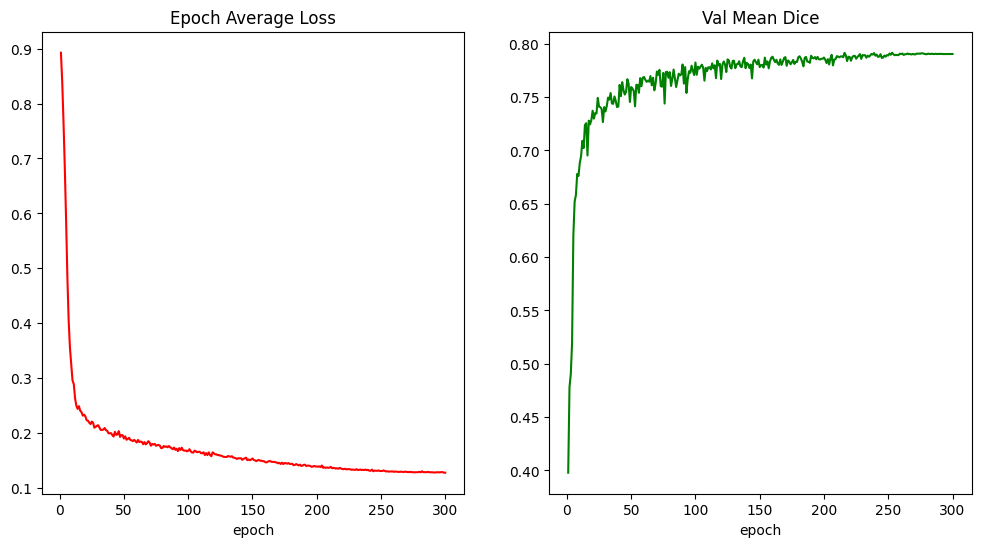

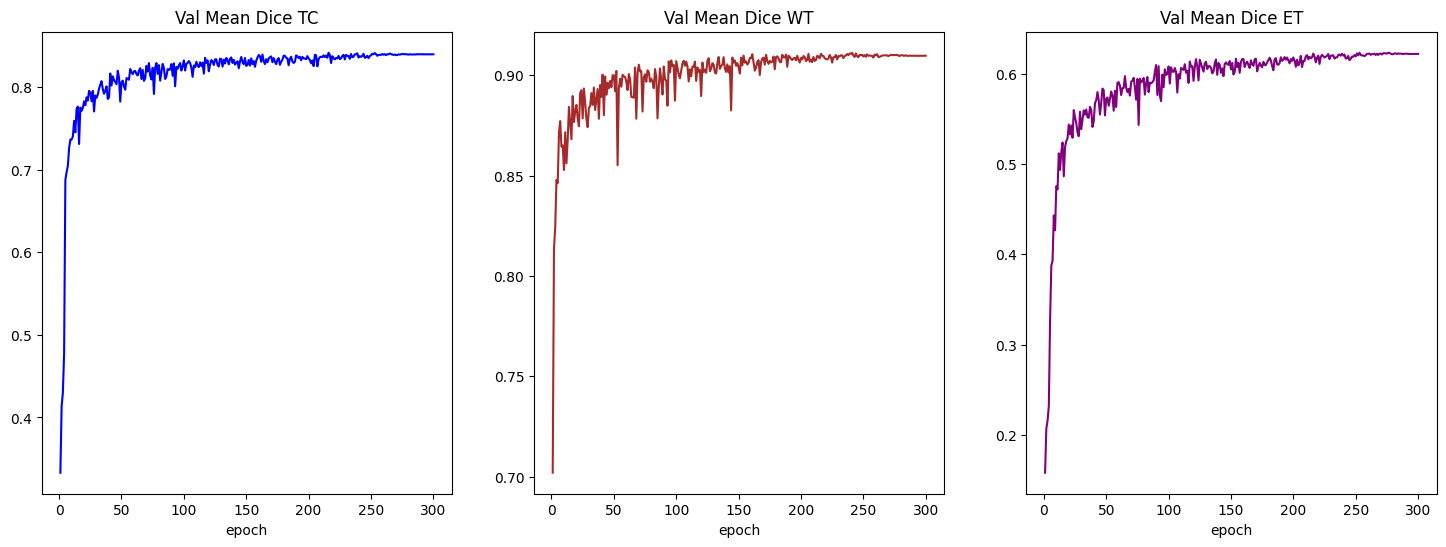

In [19]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title('Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y, color='red')
plt.subplot(1, 2, 2)
plt.title('Val Mean Dice')
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y, color='green')
plt.show()

plt.figure('train', (18, 6))
plt.subplot(1, 3, 1)
plt.title('Val Mean Dice TC')
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel('epoch')
plt.plot(x, y, color='blue')
plt.subplot(1, 3, 2)
plt.title('Val Mean Dice WT')
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel('epoch')
plt.plot(x, y, color='brown')
plt.subplot(1, 3, 3)
plt.title('Val Mean Dice ET')
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel('epoch')
plt.plot(x, y, color='purple')
plt.show()

## 4. 評価

In [20]:
model.load_state_dict(
    torch.load(os.path.join(model_dir, 'best_metric_model.pth'))
)

<All keys matched successfully>

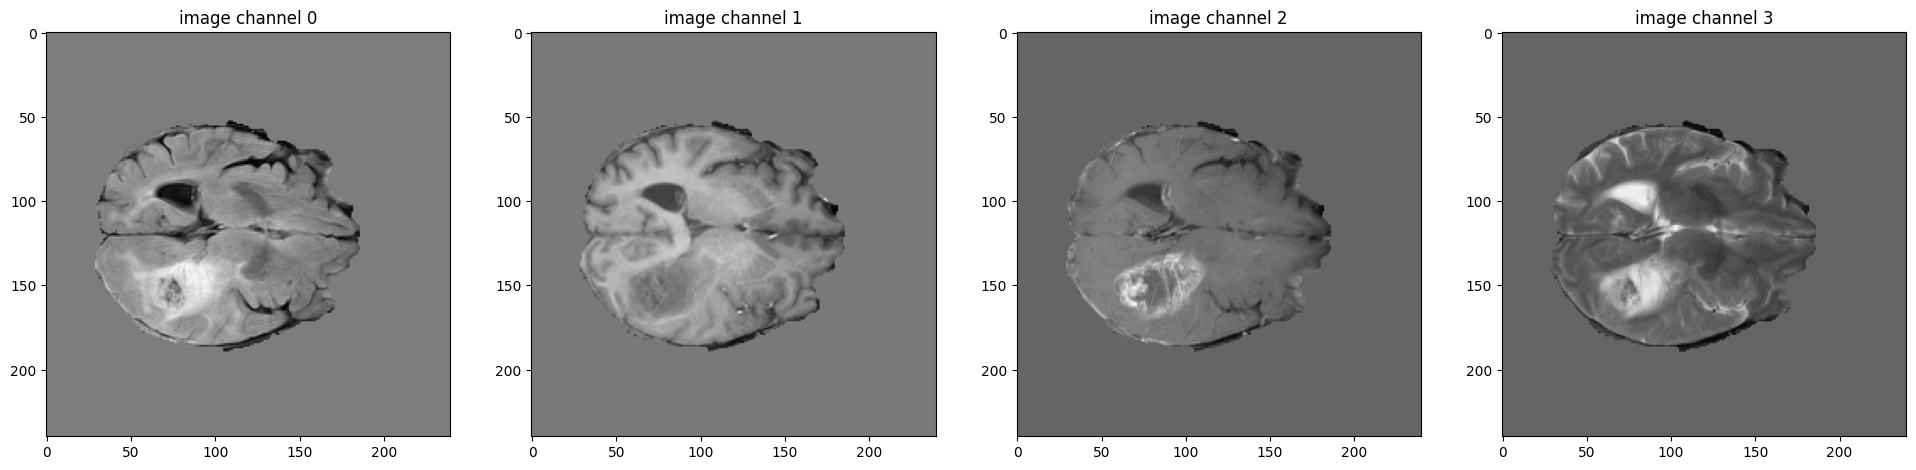

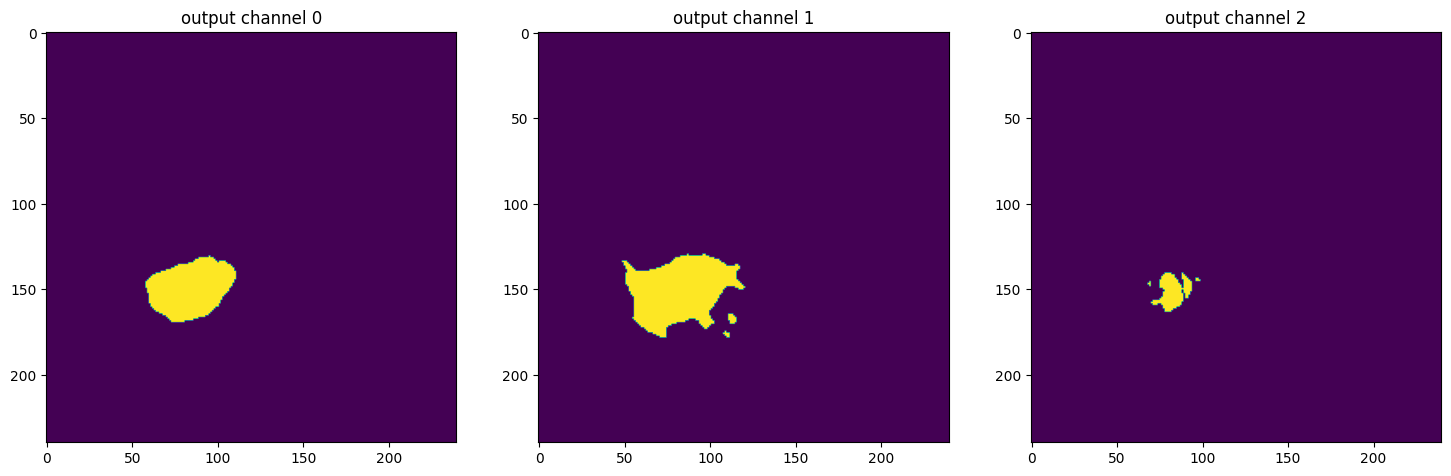

In [21]:
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]['image'].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure('image', (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f'image channel {i}')
        plt.imshow(val_ds[6]['image'][i, :, :, 70].detach().cpu(), cmap='gray')
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure('output', (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f'output channel {i}')
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

In [22]:
val_org_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image']),
    ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
    Orientationd(keys=['image'], axcodes='RAS'),
    Spacingd(keys=['image'], pixdim=(1.0, 1.0, 1.0), mode='bilinear'),
    NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
])

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task='Task01_BrainTumour',
    transform=val_org_transforms,
    section='validation',
    download=False,
    num_workers=2,
    cache_num=0,
)

val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=2)

In [23]:
post_transforms = Compose([
    Invertd(
        keys='pred',
        transform=val_org_transforms,
        orig_keys='image',
        meta_keys='pred_meta_dict',
        orig_meta_keys='image_meta_dict',
        meta_key_postfix='meta_dict',
        nearest_interp=False,
        to_tensor=True,
        device='cpu',
    ),
    Activationsd(keys='pred', sigmoid=True),
    AsDiscreted(keys='pred', threshold=0.5),    
])

In [25]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, 'best_metric_model.pth')))

model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data['image'].to(device)
        val_data['pred'] = inference(val_inputs)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(['pred', 'label'])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)
        
    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()
    
    dice_metric.reset()
    dice_metric_batch.reset()
    
metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

print('Metric on original image spacing: ', metric_org)
print(f'metric_tc : {metric_tc:.4f}')
print(f'metric_wt : {metric_wt:.4f}')
print(f'metric_et : {metric_et:.4f}')

Metric on original image spacing:  0.7916600704193115
metric_tc : 0.8415
metric_wt : 0.9105
metric_et : 0.6230
